In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("/disk/u/gio/retrieval")

import json
import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

from src.utils.training_utils import get_device_map

model_key = "meta-llama/Llama-3.3-70B-Instruct"

device_map = get_device_map(model_key, 32, n_gpus=8)
print(device_map)

os.chdir("/disk/u/gio/mechinterp")
print(os.getcwd())

from src.models import ModelandTokenizer

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    device_map=device_map,
)



/disk/u/gio/.conda/envs/retrieval2/lib/python3.11/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


2025-09-05 15:57:00 __main__ INFO     torch.__version__='2.8.0+cu128', torch.version.cuda='12.8'
2025-09-05 15:57:00 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-05 15:57:00 __main__ INFO     transformers.__version__='4.54.1'
2025-09-05 15:57:03 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/retrieval, stdin=None, shell=False, universal_newlines=False)
2025-09-05 15:57:03 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/retrieval, stdin=None, shell=False, universal_newlines=False)
{'model.embed_tokens': 7, 'model.norm': 7, 'model.rotary_emb': 7, 'lm_head': 7, 'model.layers.0': 0, 'model.layers.1': 1, 'model.layers.2': 2, 'model.layers.3': 3, 'model.layers.4': 4, 'model.layers.5': 5, 'model.layers.6': 6, 'model.layers.7': 7, 'model.layers.8': 0, 'model.layers.9': 1, 'model.layers.10': 2, 'model.layers.11': 3, 'model.layers.12': 4, 'model.layers.13': 5, 'model.layers.14': 

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-05 15:57:48 src.models INFO     loaded model <models/meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:7


2025-09-05 15:57:54 matplotlib DEBUG    matplotlib data path: /disk/u/gio/.conda/envs/retrieval2/lib/python3.11/site-packages/matplotlib/mpl-data
2025-09-05 15:57:54 matplotlib DEBUG    CONFIGDIR=/disk/u/gio/.config/matplotlib
2025-09-05 15:57:54 matplotlib DEBUG    interactive is False
2025-09-05 15:57:54 matplotlib DEBUG    platform is linux
2025-09-05 15:57:54 matplotlib DEBUG    CACHEDIR=/disk/u/gio/.cache/matplotlib
2025-09-05 15:57:54 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/gio/.cache/matplotlib/fontlist-v390.json
2025-09-05 15:57:54 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-05 15:57:54 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-05 15:57:54 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-09-05 15:57:54 matplotlib.font_manager DEB

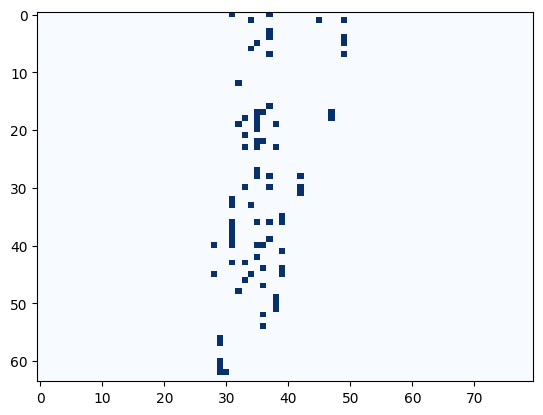

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from src.selection.data import SelectOneTask

optimized_path = os.path.join(
    "/disk/u/arnab/Codes/Projects/retrieval/results/"
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    "distinct_options",
    "select_one",
    "epoch_10.npz"
)
optimization_results = np.load(optimized_path, allow_pickle=True)
optimal_head_mask = torch.tensor(optimization_results['optimal_mask']).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected
]
print(len(heads_selected))


In [10]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
######################################################################


@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    clean_prompt_template_idx=2,
    patch_prompt_template_idx=2,
    clean_option_style="single_line",
    patch_option_style="single_line",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
    n_distractors: int = N_DISTRACTORS,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (
            KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)
        ).values,
        2,
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer)
                - KeyedSet([patch_obj], mt.tokenizer)
            ).values
        )
        clean_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer)
                - KeyedSet([clean_obj], mt.tokenizer)
            ).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_type_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=N_DISTRACTORS - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors,
                            tokenizer=mt.tokenizer,
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while clean_options.index(clean_obj) == patch_obj_idx:
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    print(f"{type(task)=}")
    if isinstance(task, SelectOneTask):
        patch_metadata = {
            "track_category": clean_category,
            "track_type_obj": clean_type_obj,
            "track_type_obj_idx": patch_options.index(clean_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                clean_type_obj, mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_category": patch_category,
            "track_type_obj": patch_type_obj,
            "track_type_obj_idx": clean_options.index(patch_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                patch_type_obj, mt.tokenizer, prefix=" "
            ),
        }
    else:
        raise NotImplementedError(f"Unsupported task type: {type(task)}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata=patch_metadata,
        prompt_template = task.prompt_templates[patch_prompt_template_idx],
        default_option_style=patch_option_style,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata=clean_metadata,
        prompt_template = task.prompt_templates[clean_prompt_template_idx],
        default_option_style=clean_option_style,
    )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata[
                "track_type_obj_token_id"
            ]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    clean_prompt_template_idx=clean_prompt_template_idx,
                    patch_prompt_template_idx=patch_prompt_template_idx,
                    clean_option_style=clean_option_style,
                    patch_option_style=patch_option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    distinct_options=distinct_options,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

In [11]:
TASK_CLS = SelectOneTask
N_DISTRACTORS = 5
prompt_template_idx = 2
OPTION_STYLE = "single_line"

select_task = TASK_CLS.load(
    path="/disk/u/gio/retrieval/data_save/selection/objects.json"
)

print(select_task.task_name)

select_one


In [25]:
validation_set = []
validation_limit = 1024

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        task=select_task,
        filter_by_lm_prediction=True,
        distinct_options=True,
        n_distractors=N_DISTRACTORS
    )
    validation_set.append((clean, patch))

2025-09-05 16:09:46 __main__ INFO     Patch category: vehicle, subject: Boat, object: Motorcycle
2025-09-05 16:09:46 __main__ INFO     Clean category: electronics, subject: Laptop, object: Monitor
2025-09-05 16:09:46 __main__ INFO     patch_must_have_options=['Motorcycle', 'Microphone']
2025-09-05 16:09:46 __main__ INFO     clean_must_have_options=['Monitor', 'Car']
2025-09-05 16:09:46 __main__ INFO     clean_type_obj='Microphone'
2025-09-05 16:09:46 __main__ INFO     patch_type_obj='Car'
2025-09-05 16:09:46 __main__ INFO     patch_obj_idx=2 | ['Microphone', 'Bear', 'Motorcycle', 'Pressure cooker', 'Jeans', 'Maple']
2025-09-05 16:09:46 __main__ INFO     clean_obj_idx=0 | ['Monitor', 'Eraser', 'Car', 'Hat', 'Carnation', 'Shower']


type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-05 16:09:46 __main__ INFO     Which object from the following list is a vehicle?
Options: Microphone, Bear, Motorcycle, Pressure cooker, Jeans, Maple.
Answer:
2025-09-05 16:09:46 __main__ INFO     Boat | vehicle -> Motorcycle | pred=['" Motorcycle"[70762] (p=0.801, logit=21.875)', '" The"[578] (p=0.096, logit=19.750)', '" A"[362] (p=0.074, logit=19.500)', '" Out"[4470] (p=0.003, logit=16.375)', '" "[220] (p=0.002, logit=15.938)']
2025-09-05 16:09:47 __main__ INFO     Which object from the following list is a electronics?
Options: Monitor, Eraser, Car, Hat, Carnation, Shower.
Answer:
2025-09-05 16:09:47 __main__ INFO     Laptop | electronics -> Monitor | pred=['" Monitor"[24423] (p=0.621, logit=20.625)', '" The"[578] (p=0.157, logit=19.250)', '" A"[362] (p=0.139, logit=19.125)', '" Only"[8442] (p=0.007, logit=16.125)', '" ("[320] (p=0.006, logit=15.938)']
2025-09-05 16:09:47 __main__ INFO     Which object from the following l

In [27]:
from tqdm import tqdm
from src.tokens import find_token_range
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):

    patch_ques = (
        find_token_range(
            tokenizer=mt.tokenizer,
            string=patch_sample.prompt(),
            substring="?",
            occurrence=-1,
        )[1]
        - 1
    )
    clean_ques = (
        find_token_range(
            tokenizer=mt.tokenizer,
            string=clean_sample.prompt(),
            substring="?",
            occurrence=-1,
        )[1]
        - 1
    )
    logger.debug(
        f"{patch_ques=} | \"{mt.tokenizer.decode(patch_sample.metadata['tokenized']['input_ids'][0][patch_ques])}\""
    )
    logger.debug(
        f"{clean_ques=} | \"{mt.tokenizer.decode(clean_sample.metadata['tokenized']['input_ids'][0][clean_ques])}\""
    )

    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=heads_selected,
        query_indices={
            patch_ques: clean_ques,
            -2:-2,
            -1:-1
        },
        verify_head_behavior_on=None,
        ablate_possible_ans_info_from_options=True,
    )
    validation_results.append(result)
    print("=" * 80)

  0%|                                                  | 0/1024 [00:00<?, ?it/s]

2025-09-05 16:19:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:00 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:00 src.selection.optimization INFO     Caching the query states for the 78 heads


2025-09-05 16:19:00 src.selection.optimization INFO     patch_prediction=['" Motorcycle"[70762] (p=0.801, logit=21.875)', '" The"[578] (p=0.096, logit=19.750)', '" A"[362] (p=0.074, logit=19.500)', '" Out"[4470] (p=0.003, logit=16.375)', '" "[220] (p=0.002, logit=15.938)']
2025-09-05 16:19:00 src.selection.optimization INFO     clean run
2025-09-05 16:19:00 src.selection.optimization INFO     clean_prediction=['" Monitor"[24423] (p=0.621, logit=20.625)', '" The"[578] (p=0.157, logit=19.250)', '" A"[362] (p=0.139, logit=19.125)', '" Only"[8442] (p=0.007, logit=16.125)', '" ("[320] (p=0.006, logit=15.938)']
2025-09-05 16:19:00 src.selection.optimization INFO     clean_track=OrderedDict([(24423, (1, PredictedToken(token=' Monitor', prob=0.62109375, logit=20.625, token_id=24423, metadata=None))), (3341, (50, PredictedToken(token=' Car', prob=0.00016307830810546875, logit=12.375, token_id=3341, metadata=None))), (9939, (378, PredictedToken(token=' Er', prob=4.082918167114258e-06, logit=8.68

  0%|                                          | 1/1024 [00:02<34:47,  2.04s/it]

2025-09-05 16:19:02 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:19:02 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:19:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:02 src.selection.optimization INFO     patch_prediction=['" Oven"[87213] (p=0.520, logit=20.625)', '" The"[578] (p=0.246, logit=19.875)', '" An"[1556] (p=0.169, logit=19.500)', '" O"[507] (p=0.010, logit=16.625)', '" A"[362] (p=0.008, logit=16.500)']
2025-09-05 16:19:02 src.selection.optimization INFO     clean run
2025-09-05 16:19:02 src.selection.optimization INFO     clean_prediction=['" F"[435] (p=0.617, logit=21.000)', '" The"[578] (p=0.228, logit=20.000)', '" A"[362] (p=0.107, logit=19.250)', '" Sport"[18707] (p=0.003, logit=15.812)', '" the"[279] (p=0.003, logit=15.750)']
2025-09-05 16:19:02 src.selection.optimization INFO     clean_track=OrderedDict([(435, (1, PredictedToken(token=' F', prob=0.6171875, logit=21.0, token_id=435, metadata=None))), (16

  0%|                                          | 2/1024 [00:04<34:26,  2.02s/it]

2025-09-05 16:19:04 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:04 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:04 src.selection.optimization INFO     patch_prediction=['" Dress"[29318] (p=0.539, logit=21.125)', '" The"[578] (p=0.289, logit=20.500)', '" A"[362] (p=0.136, logit=19.750)', '" Only"[8442] (p=0.004, logit=16.125)', '" "[220] (p=0.002, logit=15.688)']
2025-09-05 16:19:04 src.selection.optimization INFO     clean run
2025-09-05 16:19:04 src.selection.optimization INFO     clean_prediction=['" Tiger"[36845] (p=0.773, logit=21.500)', '" The"[578] (p=0.152, logit=19.875)', '" A"[362] (p=0.039, logit=18.500)', '" Only"[8442] (p=0.003, logit=15.938)', '" "[220] (p=0.003, logit=15.875)']
2025-09-05 16:19:04 src.selection.optimization INFO     clean_track=OrderedDict([(36845, (1, PredictedToken(token=' Tiger', prob=0.7734375, logit=21.5, token_id=36845, metadata=N

  0%|                                          | 3/1024 [00:06<34:47,  2.04s/it]

2025-09-05 16:19:06 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:06 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:06 src.selection.optimization INFO     patch_prediction=['" E"[469] (p=0.766, logit=21.250)', '" The"[578] (p=0.151, logit=19.625)', '" A"[362] (p=0.021, logit=17.625)', '" An"[1556] (p=0.008, logit=16.625)', '" From"[5659] (p=0.005, logit=16.250)']
2025-09-05 16:19:06 src.selection.optimization INFO     clean run
2025-09-05 16:19:06 src.selection.optimization INFO     clean_prediction=['" Z"[1901] (p=0.621, logit=21.625)', '" The"[578] (p=0.228, logit=20.625)', '" A"[362] (p=0.108, logit=19.875)', '" "[220] (p=0.005, logit=16.875)', '" An"[1556] (p=0.004, logit=16.625)']
2025-09-05 16:19:06 src.selection.optimization INFO     clean_track=OrderedDict([(1901, (1, PredictedToken(token=' Z', prob=0.62109375, logit=21.625, token_id=1901, metadata=None))), (328,

  0%|▏                                         | 4/1024 [00:08<34:44,  2.04s/it]

2025-09-05 16:19:08 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:19:08 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:08 src.selection.optimization INFO     patch_prediction=['" Binder"[91263] (p=0.641, logit=21.125)', '" The"[578] (p=0.208, logit=20.000)', '" A"[362] (p=0.098, logit=19.250)', '" An"[1556] (p=0.006, logit=16.375)', '" "[220] (p=0.005, logit=16.250)']
2025-09-05 16:19:08 src.selection.optimization INFO     clean run
2025-09-05 16:19:08 src.selection.optimization INFO     clean_prediction=['" Ottoman"[70110] (p=0.535, logit=20.250)', '" An"[1556] (p=0.196, logit=19.250)', '" The"[578] (p=0.174, logit=19.125)', '" Wrestling"[62668] (p=0.018, logit=16.875)', '" ("[320] (p=0.008, logit=16.000)']
2025-09-05 16:19:08 src.selection.optimization INFO     clean_track=OrderedDict([(70110, (1, PredictedToken(token=' Ottoman', prob=0.53515625, logit=20.25, token_id=701

  0%|▏                                         | 5/1024 [00:10<35:01,  2.06s/it]

2025-09-05 16:19:10 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:19:10 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:10 src.selection.optimization INFO     patch_prediction=['" K"[735] (p=0.492, logit=21.375)', '" The"[578] (p=0.264, logit=20.750)', '" A"[362] (p=0.205, logit=20.500)', '" Out"[4470] (p=0.004, logit=16.500)', '" From"[5659] (p=0.003, logit=16.250)']
2025-09-05 16:19:10 src.selection.optimization INFO     clean run
2025-09-05 16:19:10 src.selection.optimization INFO     clean_prediction=['" Television"[41445] (p=0.707, logit=20.875)', '" The"[578] (p=0.157, logit=19.375)', '" A"[362] (p=0.045, logit=18.125)', '" TV"[6007] (p=0.011, logit=16.750)', '" From"[5659] (p=0.009, logit=16.500)']
2025-09-05 16:19:10 src.selection.optimization INFO     clean_track=OrderedDict([(41445, (1, PredictedToken(token=' Television', prob=0.70703125, logit=20.875, token_id=414

  1%|▏                                         | 6/1024 [00:12<35:33,  2.10s/it]

2025-09-05 16:19:12 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:12 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:19:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:12 src.selection.optimization INFO     patch_prediction=['" Rose"[16344] (p=0.586, logit=20.750)', '" The"[578] (p=0.168, logit=19.500)', '" A"[362] (p=0.131, logit=19.250)', '" As"[1666] (p=0.048, logit=18.250)', '" Only"[8442] (p=0.004, logit=15.875)']
2025-09-05 16:19:12 src.selection.optimization INFO     clean run
2025-09-05 16:19:12 src.selection.optimization INFO     clean_prediction=['" Hair"[26781] (p=0.680, logit=21.750)', '" The"[578] (p=0.172, logit=20.375)', '" A"[362] (p=0.118, logit=20.000)', '" HA"[42416] (p=0.004, logit=16.625)', '" hair"[7013] (p=0.002, logit=15.812)']
2025-09-05 16:19:12 src.selection.optimization INFO     clean_track=OrderedDict([(26781, (1, PredictedToken(token=' Hair', prob=0.6796875, logit=21.75, token_id=26781, metad

  1%|▎                                         | 7/1024 [00:14<34:43,  2.05s/it]

2025-09-05 16:19:14 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:14 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:14 src.selection.optimization INFO     patch_prediction=['" Jacket"[55870] (p=0.754, logit=21.750)', '" The"[578] (p=0.131, logit=20.000)', '" A"[362] (p=0.090, logit=19.625)', '" ""[330] (p=0.003, logit=16.375)', '" Out"[4470] (p=0.002, logit=15.938)']
2025-09-05 16:19:14 src.selection.optimization INFO     clean run
2025-09-05 16:19:14 src.selection.optimization INFO     clean_prediction=['" Game"[4140] (p=0.680, logit=20.500)', '" The"[578] (p=0.134, logit=18.875)', '" A"[362] (p=0.104, logit=18.625)', '" Only"[8442] (p=0.007, logit=15.938)', '" ("[320] (p=0.006, logit=15.688)']
2025-09-05 16:19:14 src.selection.optimization INFO     clean_track=OrderedDict([(4140, (1, PredictedToken(token=' Game', prob=0.6796875, logit=20.5, token_id=4140, metadata=None

  1%|▎                                         | 8/1024 [00:16<34:43,  2.05s/it]

2025-09-05 16:19:16 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:16 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:16 src.selection.optimization INFO     patch_prediction=['" Chair"[16478] (p=0.613, logit=21.000)', '" The"[578] (p=0.176, logit=19.750)', '" A"[362] (p=0.137, logit=19.500)', '" ("[320] (p=0.013, logit=17.125)', '" From"[5659] (p=0.008, logit=16.625)']
2025-09-05 16:19:16 src.selection.optimization INFO     clean run
2025-09-05 16:19:16 src.selection.optimization INFO     clean_prediction=['" E"[469] (p=0.527, logit=21.000)', '" An"[1556] (p=0.221, logit=20.125)', '" The"[578] (p=0.194, logit=20.000)', '" Only"[8442] (p=0.011, logit=17.125)', '" e"[384] (p=0.005, logit=16.375)']
2025-09-05 16:19:16 src.selection.optimization INFO     clean_track=OrderedDict([(469, (1, PredictedToken(token=' E', prob=0.52734375, logit=21.0, token_id=469, metadata=None))), (

  1%|▎                                         | 9/1024 [00:18<34:39,  2.05s/it]

2025-09-05 16:19:18 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:19:18 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:19:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:18 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.449, logit=20.250)', '" Wrestling"[62668] (p=0.350, logit=20.000)', '" A"[362] (p=0.113, logit=18.875)', '" Wrest"[46037] (p=0.009, logit=16.375)', '" ("[320] (p=0.009, logit=16.375)']
2025-09-05 16:19:18 src.selection.optimization INFO     clean run
2025-09-05 16:19:18 src.selection.optimization INFO     clean_prediction=['" Slow"[39247] (p=0.672, logit=22.000)', '" The"[578] (p=0.150, logit=20.500)', '" A"[362] (p=0.150, logit=20.500)', '" slow"[6435] (p=0.003, logit=16.500)', '" "[220] (p=0.002, logit=16.375)']
2025-09-05 16:19:18 src.selection.optimization INFO     clean_track=OrderedDict([(39247, (1, PredictedToken(token=' Slow', prob=0.671875, logit=22.0, token_id=39247, metada

  1%|▍                                        | 10/1024 [00:20<34:48,  2.06s/it]

2025-09-05 16:19:20 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:20 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:19:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:20 src.selection.optimization INFO     patch_prediction=['" Table"[6771] (p=0.562, logit=20.250)', '" The"[578] (p=0.183, logit=19.125)', '" A"[362] (p=0.059, logit=18.000)', '" Piano"[56491] (p=0.036, logit=17.500)', '" From"[5659] (p=0.028, logit=17.250)']
2025-09-05 16:19:20 src.selection.optimization INFO     clean run
2025-09-05 16:19:20 src.selection.optimization INFO     clean_prediction=['" Uk"[60413] (p=0.613, logit=20.750)', '" The"[578] (p=0.199, logit=19.625)', '" A"[362] (p=0.106, logit=19.000)', '" R"[432] (p=0.021, logit=17.375)', '" ("[320] (p=0.005, logit=15.938)']
2025-09-05 16:19:20 src.selection.optimization INFO     clean_track=OrderedDict([(60413, (1, PredictedToken(token=' Uk', prob=0.61328125, logit=20.75, token_id=60413, metadata=No

  1%|▍                                        | 11/1024 [00:22<34:26,  2.04s/it]

2025-09-05 16:19:22 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:19:22 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:22 src.selection.optimization INFO     patch_prediction=['" Blender"[88668] (p=0.684, logit=21.750)', '" The"[578] (p=0.152, logit=20.250)', '" A"[362] (p=0.135, logit=20.125)', '" Only"[8442] (p=0.003, logit=16.250)', '" "[220] (p=0.002, logit=15.812)']
2025-09-05 16:19:22 src.selection.optimization INFO     clean run
2025-09-05 16:19:22 src.selection.optimization INFO     clean_prediction=['" Jeans"[82507] (p=0.586, logit=19.875)', '" The"[578] (p=0.147, logit=18.500)', '" C"[356] (p=0.042, logit=17.250)', '" Two"[9220] (p=0.026, logit=16.750)', '" A"[362] (p=0.023, logit=16.625)']
2025-09-05 16:19:22 src.selection.optimization INFO     clean_track=OrderedDict([(82507, (1, PredictedToken(token=' Jeans', prob=0.5859375, logit=19.875, token_id=82507, metada

  1%|▍                                        | 12/1024 [00:24<34:33,  2.05s/it]

2025-09-05 16:19:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:24 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:19:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:24 src.selection.optimization INFO     patch_prediction=['" Phone"[14642] (p=0.355, logit=18.250)', '" The"[578] (p=0.190, logit=17.625)', '" Food"[12369] (p=0.131, logit=17.250)', '" A"[362] (p=0.090, logit=16.875)', '" From"[5659] (p=0.020, logit=15.375)']
2025-09-05 16:19:24 src.selection.optimization INFO     clean run
2025-09-05 16:19:24 src.selection.optimization INFO     clean_prediction=['" Dish"[49268] (p=0.385, logit=20.000)', '" The"[578] (p=0.299, logit=19.750)', '" A"[362] (p=0.264, logit=19.625)', '" ("[320] (p=0.005, logit=15.750)', '" "[220] (p=0.004, logit=15.500)']
2025-09-05 16:19:24 src.selection.optimization INFO     clean_track=OrderedDict([(49268, (1, PredictedToken(token=' Dish', prob=0.384765625, logit=20.0, token_id=49268, metadata

  1%|▌                                        | 13/1024 [00:26<35:02,  2.08s/it]

2025-09-05 16:19:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:26 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:26 src.selection.optimization INFO     patch_prediction=['" Ottoman"[70110] (p=0.645, logit=20.750)', '" The"[578] (p=0.163, logit=19.375)', '" An"[1556] (p=0.144, logit=19.250)', '" ("[320] (p=0.004, logit=15.688)', '" an"[459] (p=0.003, logit=15.500)']
2025-09-05 16:19:26 src.selection.optimization INFO     clean run
2025-09-05 16:19:27 src.selection.optimization INFO     clean_prediction=['" School"[6150] (p=0.652, logit=21.375)', '" The"[578] (p=0.165, logit=20.000)', '" A"[362] (p=0.129, logit=19.750)', '" Bench"[36358] (p=0.004, logit=16.375)', '" Out"[4470] (p=0.004, logit=16.250)']
2025-09-05 16:19:27 src.selection.optimization INFO     clean_track=OrderedDict([(6150, (1, PredictedToken(token=' School', prob=0.65234375, logit=21.375, token_id=6150, 

  1%|▌                                        | 14/1024 [00:28<34:40,  2.06s/it]

2025-09-05 16:19:28 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:19:28 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:19:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:28 src.selection.optimization INFO     patch_prediction=['" Sink"[57551] (p=0.490, logit=20.750)', '" The"[578] (p=0.297, logit=20.250)', '" A"[362] (p=0.159, logit=19.625)', '" Out"[4470] (p=0.007, logit=16.500)', '" From"[5659] (p=0.005, logit=16.250)']
2025-09-05 16:19:28 src.selection.optimization INFO     clean run
2025-09-05 16:19:29 src.selection.optimization INFO     clean_prediction=['" D"[423] (p=0.703, logit=21.125)', '" The"[578] (p=0.157, logit=19.625)', '" A"[362] (p=0.095, logit=19.125)', '" From"[5659] (p=0.006, logit=16.375)', '" ("[320] (p=0.004, logit=15.875)']
2025-09-05 16:19:29 src.selection.optimization INFO     clean_track=OrderedDict([(423, (1, PredictedToken(token=' D', prob=0.703125, logit=21.125, token_id=423, metadata=None))), (

  1%|▌                                        | 15/1024 [00:30<34:23,  2.05s/it]

2025-09-05 16:19:30 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:30 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:19:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:30 src.selection.optimization INFO     patch_prediction=['" House"[4783] (p=0.676, logit=21.750)', '" The"[578] (p=0.133, logit=20.125)', '" A"[362] (p=0.133, logit=20.125)', '" From"[5659] (p=0.007, logit=17.125)', '" Out"[4470] (p=0.005, logit=16.750)']
2025-09-05 16:19:30 src.selection.optimization INFO     clean run
2025-09-05 16:19:31 src.selection.optimization INFO     clean_prediction=['" Food"[12369] (p=0.508, logit=21.625)', '" The"[578] (p=0.240, logit=20.875)', '" A"[362] (p=0.212, logit=20.750)', '" Kitchen"[19915] (p=0.003, logit=16.500)', '" "[220] (p=0.003, logit=16.500)']
2025-09-05 16:19:31 src.selection.optimization INFO     clean_track=OrderedDict([(12369, (1, PredictedToken(token=' Food', prob=0.5078125, logit=21.625, token_id=12369, met

  2%|▋                                        | 16/1024 [00:32<34:40,  2.06s/it]

2025-09-05 16:19:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:33 src.selection.optimization INFO     patch_prediction=['" Pin"[17929] (p=0.645, logit=21.125)', '" The"[578] (p=0.145, logit=19.625)', '" A"[362] (p=0.145, logit=19.625)', '" Only"[8442] (p=0.009, logit=16.875)', '" From"[5659] (p=0.008, logit=16.750)']
2025-09-05 16:19:33 src.selection.optimization INFO     clean run
2025-09-05 16:19:33 src.selection.optimization INFO     clean_prediction=['" Blue"[8868] (p=0.723, logit=21.750)', '" The"[578] (p=0.161, logit=20.250)', '" A"[362] (p=0.076, logit=19.500)', '" Fruit"[44187] (p=0.006, logit=17.000)', '" "[220] (p=0.004, logit=16.500)']
2025-09-05 16:19:33 src.selection.optimization INFO     clean_track=OrderedDict([(8868, (1, PredictedToken(token=' Blue', prob=0.72265625, logit=21.75, token_id=8868, metadata

  2%|▋                                        | 17/1024 [00:35<35:11,  2.10s/it]

2025-09-05 16:19:35 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:19:35 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:19:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:35 src.selection.optimization INFO     patch_prediction=['" Sc"[2522] (p=0.789, logit=21.500)', '" The"[578] (p=0.155, logit=19.875)', '" A"[362] (p=0.011, logit=17.250)', '" "[220] (p=0.005, logit=16.375)', '" An"[1556] (p=0.003, logit=16.000)']
2025-09-05 16:19:35 src.selection.optimization INFO     clean run
2025-09-05 16:19:35 src.selection.optimization INFO     clean_prediction=['" Razor"[74968] (p=0.645, logit=20.875)', '" A"[362] (p=0.163, logit=19.500)', '" The"[578] (p=0.144, logit=19.375)', '" Raz"[77919] (p=0.006, logit=16.125)', '" R"[432] (p=0.006, logit=16.125)']
2025-09-05 16:19:35 src.selection.optimization INFO     clean_track=OrderedDict([(74968, (1, PredictedToken(token=' Razor', prob=0.64453125, logit=20.875, token_id=74968, metadata=Non

  2%|▋                                        | 18/1024 [00:37<34:35,  2.06s/it]

2025-09-05 16:19:37 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:37 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:37 src.selection.optimization INFO     patch_prediction=['" Smart"[16147] (p=0.664, logit=20.875)', '" The"[578] (p=0.168, logit=19.500)', '" A"[362] (p=0.115, logit=19.125)', '" "[220] (p=0.004, logit=15.812)', '" smart"[7941] (p=0.004, logit=15.750)']
2025-09-05 16:19:37 src.selection.optimization INFO     clean run
2025-09-05 16:19:37 src.selection.optimization INFO     clean_prediction=['" Cel"[47643] (p=0.664, logit=20.625)', '" The"[578] (p=0.245, logit=19.625)', '" A"[362] (p=0.018, logit=17.000)', '" Only"[8442] (p=0.007, logit=16.125)', '" "[220] (p=0.004, logit=15.625)']
2025-09-05 16:19:37 src.selection.optimization INFO     clean_track=OrderedDict([(47643, (1, PredictedToken(token=' Cel', prob=0.6640625, logit=20.625, token_id=47643, metadata=No

  2%|▊                                        | 19/1024 [00:39<34:18,  2.05s/it]

2025-09-05 16:19:39 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:39 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:39 src.selection.optimization INFO     patch_prediction=['" Bed"[13394] (p=0.613, logit=21.125)', '" The"[578] (p=0.176, logit=19.875)', '" A"[362] (p=0.137, logit=19.625)', '" Only"[8442] (p=0.007, logit=16.625)', '" ""[330] (p=0.007, logit=16.625)']
2025-09-05 16:19:39 src.selection.optimization INFO     clean run
2025-09-05 16:19:39 src.selection.optimization INFO     clean_prediction=['" Cow"[22607] (p=0.727, logit=21.750)', '" The"[578] (p=0.162, logit=20.250)', '" A"[362] (p=0.067, logit=19.375)', '" C"[356] (p=0.006, logit=16.875)', '" "[220] (p=0.005, logit=16.750)']
2025-09-05 16:19:39 src.selection.optimization INFO     clean_track=OrderedDict([(22607, (1, PredictedToken(token=' Cow', prob=0.7265625, logit=21.75, token_id=22607, metadata=None))), 

  2%|▊                                        | 20/1024 [00:41<35:12,  2.10s/it]

2025-09-05 16:19:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:41 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:41 src.selection.optimization INFO     patch_prediction=['" Ash"[14937] (p=0.688, logit=21.375)', '" The"[578] (p=0.153, logit=19.875)', '" An"[1556] (p=0.093, logit=19.375)', '" A"[362] (p=0.011, logit=17.250)', '" Only"[8442] (p=0.006, logit=16.625)']
2025-09-05 16:19:41 src.selection.optimization INFO     clean run
2025-09-05 16:19:41 src.selection.optimization INFO     clean_prediction=['" Dolphin"[96096] (p=0.656, logit=21.000)', '" The"[578] (p=0.213, logit=19.875)', '" A"[362] (p=0.089, logit=19.000)', '" Only"[8442] (p=0.004, logit=16.000)', '" "[220] (p=0.004, logit=15.875)']
2025-09-05 16:19:41 src.selection.optimization INFO     clean_track=OrderedDict([(96096, (1, PredictedToken(token=' Dolphin', prob=0.65625, logit=21.0, token_id=96096, metadat

  2%|▊                                        | 21/1024 [00:43<34:39,  2.07s/it]

2025-09-05 16:19:43 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:19:43 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:19:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:43 src.selection.optimization INFO     patch_prediction=['" J"[622] (p=0.758, logit=21.500)', '" The"[578] (p=0.132, logit=19.750)', '" A"[362] (p=0.070, logit=19.125)', '" ("[320] (p=0.006, logit=16.625)', '" ""[330] (p=0.003, logit=16.000)']
2025-09-05 16:19:43 src.selection.optimization INFO     clean run
2025-09-05 16:19:43 src.selection.optimization INFO     clean_prediction=['" R"[432] (p=0.594, logit=21.000)', '" The"[578] (p=0.192, logit=19.875)', '" A"[362] (p=0.150, logit=19.625)', '" Only"[8442] (p=0.010, logit=16.875)', '" "[220] (p=0.007, logit=16.625)']
2025-09-05 16:19:43 src.selection.optimization INFO     clean_track=OrderedDict([(432, (1, PredictedToken(token=' R', prob=0.59375, logit=21.0, token_id=432, metadata=None))), (3341, (53, Predi

  2%|▉                                        | 22/1024 [00:45<34:54,  2.09s/it]

2025-09-05 16:19:45 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:45 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:45 src.selection.optimization INFO     patch_prediction=['" E"[469] (p=0.598, logit=21.375)', '" An"[1556] (p=0.194, logit=20.250)', '" The"[578] (p=0.151, logit=20.000)', '" Only"[8442] (p=0.010, logit=17.250)', '" ("[320] (p=0.008, logit=17.000)']
2025-09-05 16:19:45 src.selection.optimization INFO     clean run
2025-09-05 16:19:45 src.selection.optimization INFO     clean_prediction=['" Air"[6690] (p=0.500, logit=21.000)', '" An"[1556] (p=0.270, logit=20.375)', '" The"[578] (p=0.185, logit=20.000)', '" A"[362] (p=0.004, logit=16.125)', '" "[220] (p=0.003, logit=16.000)']
2025-09-05 16:19:45 src.selection.optimization INFO     clean_track=OrderedDict([(6690, (1, PredictedToken(token=' Air', prob=0.5, logit=21.0, token_id=6690, metadata=None))), (921, (52,

  2%|▉                                        | 23/1024 [00:47<35:28,  2.13s/it]

2025-09-05 16:19:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:47 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:47 src.selection.optimization INFO     patch_prediction=['" Ward"[27738] (p=0.719, logit=20.750)', '" The"[578] (p=0.142, logit=19.125)', '" A"[362] (p=0.086, logit=18.625)', '" ("[320] (p=0.006, logit=15.938)', '" "[220] (p=0.004, logit=15.438)']
2025-09-05 16:19:47 src.selection.optimization INFO     clean run
2025-09-05 16:19:47 src.selection.optimization INFO     clean_prediction=['" Water"[10164] (p=0.699, logit=21.625)', '" The"[578] (p=0.228, logit=20.500)', '" A"[362] (p=0.035, logit=18.625)', '" Fruit"[44187] (p=0.003, logit=16.250)', '" Only"[8442] (p=0.003, logit=16.125)']
2025-09-05 16:19:47 src.selection.optimization INFO     clean_track=OrderedDict([(10164, (1, PredictedToken(token=' Water', prob=0.69921875, logit=21.625, token_id=10164, metad

  2%|▉                                        | 24/1024 [00:49<35:48,  2.15s/it]

2025-09-05 16:19:49 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:49 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:19:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:50 src.selection.optimization INFO     patch_prediction=['" Black"[5348] (p=0.598, logit=21.375)', '" The"[578] (p=0.221, logit=20.375)', '" A"[362] (p=0.134, logit=19.875)', '" Fruit"[44187] (p=0.004, logit=16.375)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:19:50 src.selection.optimization INFO     clean run
2025-09-05 16:19:50 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.582, logit=21.375)', '" The"[578] (p=0.275, logit=20.625)', '" A"[362] (p=0.102, logit=19.625)', '" Only"[8442] (p=0.003, logit=16.250)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:19:50 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.58203125, logit=21.375, token_id=356, metadata=None))), (9

  2%|█                                        | 25/1024 [00:52<36:11,  2.17s/it]

2025-09-05 16:19:52 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:19:52 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:52 src.selection.optimization INFO     patch_prediction=['" Toilet"[82994] (p=0.570, logit=20.375)', '" The"[578] (p=0.346, logit=19.875)', '" A"[362] (p=0.012, logit=16.500)', '" Only"[8442] (p=0.009, logit=16.250)', '" Out"[4470] (p=0.005, logit=15.562)']
2025-09-05 16:19:52 src.selection.optimization INFO     clean run
2025-09-05 16:19:52 src.selection.optimization INFO     clean_prediction=['" Mushroom"[91297] (p=0.676, logit=20.375)', '" The"[578] (p=0.104, logit=18.500)', '" A"[362] (p=0.104, logit=18.500)', '" None"[2290] (p=0.055, logit=17.875)', '" Only"[8442] (p=0.006, logit=15.688)']
2025-09-05 16:19:52 src.selection.optimization INFO     clean_track=OrderedDict([(91297, (1, PredictedToken(token=' Mushroom', prob=0.67578125, logit=20.375, token_i

  3%|█                                        | 26/1024 [00:54<35:38,  2.14s/it]

2025-09-05 16:19:54 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:19:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:54 src.selection.optimization INFO     patch_prediction=['" Sofa"[61948] (p=0.354, logit=19.625)', '" The"[578] (p=0.275, logit=19.375)', '" A"[362] (p=0.243, logit=19.250)', '" Furniture"[30339] (p=0.011, logit=16.125)', '" ("[320] (p=0.009, logit=16.000)']
2025-09-05 16:19:54 src.selection.optimization INFO     clean run
2025-09-05 16:19:54 src.selection.optimization INFO     clean_prediction=['" Shirt"[55807] (p=0.656, logit=21.250)', '" The"[578] (p=0.188, logit=20.000)', '" A"[362] (p=0.101, logit=19.375)', '" ""[330] (p=0.006, logit=16.500)', '" Out"[4470] (p=0.005, logit=16.375)']
2025-09-05 16:19:54 src.selection.optimization INFO     clean_track=OrderedDict([(55807, (1, PredictedToken(token=' Shirt', prob=0.65625, logit=21.25, token_id=55807, metad

  3%|█                                        | 27/1024 [00:56<35:06,  2.11s/it]

2025-09-05 16:19:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:56 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:19:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:56 src.selection.optimization INFO     patch_prediction=['" Jacket"[55870] (p=0.531, logit=20.875)', '" The"[578] (p=0.195, logit=19.875)', '" A"[362] (p=0.118, logit=19.375)', '" Ti"[23126] (p=0.104, logit=19.250)', '" ("[320] (p=0.005, logit=16.250)']
2025-09-05 16:19:56 src.selection.optimization INFO     clean run
2025-09-05 16:19:56 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.629, logit=21.500)', '" The"[578] (p=0.231, logit=20.500)', '" A"[362] (p=0.097, logit=19.625)', '" c"[272] (p=0.004, logit=16.500)', '" Only"[8442] (p=0.004, logit=16.375)']
2025-09-05 16:19:56 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.62890625, logit=21.5, token_id=356, metadata=None))), (46

  3%|█                                        | 28/1024 [00:58<35:30,  2.14s/it]

2025-09-05 16:19:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:19:58 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:19:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:19:58 src.selection.optimization INFO     patch_prediction=['" Daisy"[71264] (p=0.504, logit=20.750)', '" The"[578] (p=0.307, logit=20.250)', '" A"[362] (p=0.128, logit=19.375)', '" Only"[8442] (p=0.004, logit=16.000)', '" d"[294] (p=0.004, logit=16.000)']
2025-09-05 16:19:58 src.selection.optimization INFO     clean run
2025-09-05 16:19:58 src.selection.optimization INFO     clean_prediction=['" To"[2057] (p=0.457, logit=21.125)', '" The"[578] (p=0.314, logit=20.750)', '" A"[362] (p=0.190, logit=20.250)', '" "[220] (p=0.003, logit=16.250)', '" TO"[5257] (p=0.003, logit=16.125)']
2025-09-05 16:19:58 src.selection.optimization INFO     clean_track=OrderedDict([(2057, (1, PredictedToken(token=' To', prob=0.45703125, logit=21.125, token_id=2057, metadata=None))),

  3%|█▏                                       | 29/1024 [01:00<35:13,  2.12s/it]

2025-09-05 16:20:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:00 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:20:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:00 src.selection.optimization INFO     patch_prediction=['" Mushroom"[91297] (p=0.703, logit=20.375)', '" The"[578] (p=0.108, logit=18.500)', '" A"[362] (p=0.108, logit=18.500)', '" Mush"[59205] (p=0.008, logit=15.938)', '" Although"[10541] (p=0.005, logit=15.500)']
2025-09-05 16:20:00 src.selection.optimization INFO     clean run
2025-09-05 16:20:00 src.selection.optimization INFO     clean_prediction=['" Sax"[68027] (p=0.539, logit=20.875)', '" The"[578] (p=0.326, logit=20.375)', '" A"[362] (p=0.093, logit=19.125)', '" Only"[8442] (p=0.005, logit=16.125)', '" "[220] (p=0.004, logit=15.938)']
2025-09-05 16:20:00 src.selection.optimization INFO     clean_track=OrderedDict([(68027, (1, PredictedToken(token=' Sax', prob=0.5390625, logit=20.875, token_id=68027

  3%|█▏                                       | 30/1024 [01:02<34:53,  2.11s/it]

2025-09-05 16:20:02 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:02 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:02 src.selection.optimization INFO     patch_prediction=['" Red"[3816] (p=0.551, logit=21.625)', '" The"[578] (p=0.230, logit=20.750)', '" A"[362] (p=0.180, logit=20.500)', '" Only"[8442] (p=0.005, logit=16.875)', '" "[220] (p=0.003, logit=16.250)']
2025-09-05 16:20:02 src.selection.optimization INFO     clean run
2025-09-05 16:20:02 src.selection.optimization INFO     clean_prediction=['" Ottoman"[70110] (p=0.637, logit=20.750)', '" The"[578] (p=0.161, logit=19.375)', '" An"[1556] (p=0.143, logit=19.250)', '" Out"[4470] (p=0.006, logit=16.000)', '" ("[320] (p=0.006, logit=16.000)']
2025-09-05 16:20:02 src.selection.optimization INFO     clean_track=OrderedDict([(70110, (1, PredictedToken(token=' Ottoman', prob=0.63671875, logit=20.75, token_id=70110, metad

  3%|█▏                                       | 31/1024 [01:04<34:30,  2.08s/it]

2025-09-05 16:20:04 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:20:04 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:04 src.selection.optimization INFO     patch_prediction=['" Harmon"[40759] (p=0.750, logit=21.625)', '" The"[578] (p=0.147, logit=20.000)', '" A"[362] (p=0.070, logit=19.250)', '" Out"[4470] (p=0.003, logit=16.000)', '" Among"[22395] (p=0.003, logit=15.938)']
2025-09-05 16:20:04 src.selection.optimization INFO     clean run
2025-09-05 16:20:04 src.selection.optimization INFO     clean_prediction=['" E"[469] (p=0.547, logit=21.125)', '" An"[1556] (p=0.228, logit=20.250)', '" The"[578] (p=0.177, logit=20.000)', '" Only"[8442] (p=0.009, logit=17.000)', '" e"[384] (p=0.008, logit=16.875)']
2025-09-05 16:20:04 src.selection.optimization INFO     clean_track=OrderedDict([(469, (1, PredictedToken(token=' E', prob=0.546875, logit=21.125, token_id=469, metadata=None

  3%|█▎                                       | 32/1024 [01:06<34:59,  2.12s/it]

2025-09-05 16:20:06 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:20:06 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:06 src.selection.optimization INFO     patch_prediction=['" Tooth"[83499] (p=0.609, logit=21.125)', '" The"[578] (p=0.197, logit=20.000)', '" A"[362] (p=0.153, logit=19.750)', '" TO"[5257] (p=0.004, logit=16.125)', '" "[220] (p=0.003, logit=15.750)']
2025-09-05 16:20:06 src.selection.optimization INFO     clean run
2025-09-05 16:20:07 src.selection.optimization INFO     clean_prediction=['" Palm"[33578] (p=0.547, logit=20.625)', '" The"[578] (p=0.258, logit=19.875)', '" A"[362] (p=0.139, logit=19.250)', '" From"[5659] (p=0.004, logit=15.688)', '" ""[330] (p=0.004, logit=15.688)']
2025-09-05 16:20:07 src.selection.optimization INFO     clean_track=OrderedDict([(33578, (1, PredictedToken(token=' Palm', prob=0.546875, logit=20.625, token_id=33578, metadata=Non

  3%|█▎                                       | 33/1024 [01:08<34:35,  2.09s/it]

2025-09-05 16:20:08 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:08 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:20:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:09 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.322, logit=19.625)', '" Brace"[70306] (p=0.250, logit=19.375)', '" A"[362] (p=0.195, logit=19.125)', '" Smart"[16147] (p=0.104, logit=18.500)', '" ("[320] (p=0.011, logit=16.250)']
2025-09-05 16:20:09 src.selection.optimization INFO     clean run
2025-09-05 16:20:09 src.selection.optimization INFO     clean_prediction=['" Paper"[18343] (p=0.672, logit=21.750)', '" The"[578] (p=0.149, logit=20.250)', '" A"[362] (p=0.132, logit=20.125)', '" Only"[8442] (p=0.005, logit=16.875)', '" ("[320] (p=0.005, logit=16.750)']
2025-09-05 16:20:09 src.selection.optimization INFO     clean_track=OrderedDict([(18343, (1, PredictedToken(token=' Paper', prob=0.671875, logit=21.75, token_id=18343, metada

  3%|█▎                                       | 34/1024 [01:10<34:22,  2.08s/it]

2025-09-05 16:20:10 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:10 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:20:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:11 src.selection.optimization INFO     patch_prediction=['" Honey"[40715] (p=0.852, logit=21.875)', '" The"[578] (p=0.102, logit=19.750)', '" A"[362] (p=0.023, logit=18.250)', '" "[220] (p=0.002, logit=16.000)', '" Mel"[11220] (p=0.002, logit=15.750)']
2025-09-05 16:20:11 src.selection.optimization INFO     clean run
2025-09-05 16:20:11 src.selection.optimization INFO     clean_prediction=['" Trom"[94467] (p=0.707, logit=20.875)', '" The"[578] (p=0.179, logit=19.500)', '" A"[362] (p=0.075, logit=18.625)', '" "[220] (p=0.004, logit=15.750)', '" ("[320] (p=0.003, logit=15.250)']
2025-09-05 16:20:11 src.selection.optimization INFO     clean_track=OrderedDict([(94467, (1, PredictedToken(token=' Trom', prob=0.70703125, logit=20.875, token_id=94467, metadata=None

  3%|█▍                                       | 35/1024 [01:12<34:22,  2.09s/it]

2025-09-05 16:20:13 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:13 src.selection.optimization INFO     patch_prediction=['" Ch"[921] (p=0.637, logit=21.750)', '" The"[578] (p=0.206, logit=20.625)', '" A"[362] (p=0.125, logit=20.125)', '" Only"[8442] (p=0.003, logit=16.375)', '" CH"[6969] (p=0.003, logit=16.375)']
2025-09-05 16:20:13 src.selection.optimization INFO     clean run
2025-09-05 16:20:13 src.selection.optimization INFO     clean_prediction=['" Head"[11452] (p=0.656, logit=20.500)', '" The"[578] (p=0.241, logit=19.500)', '" From"[5659] (p=0.014, logit=16.625)', '" A"[362] (p=0.008, logit=16.125)', '" Out"[4470] (p=0.007, logit=16.000)']
2025-09-05 16:20:13 src.selection.optimization INFO     clean_track=OrderedDict([(11452, (1, PredictedToken(token=' Head', prob=0.65625, logit=20.5, token_id=11452, metadata=Non

  4%|█▍                                       | 36/1024 [01:15<35:01,  2.13s/it]

2025-09-05 16:20:15 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:15 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:15 src.selection.optimization INFO     patch_prediction=['" Shirt"[55807] (p=0.594, logit=20.750)', '" The"[578] (p=0.219, logit=19.750)', '" A"[362] (p=0.117, logit=19.125)', '" Out"[4470] (p=0.008, logit=16.375)', '" ("[320] (p=0.008, logit=16.375)']
2025-09-05 16:20:15 src.selection.optimization INFO     clean run
2025-09-05 16:20:15 src.selection.optimization INFO     clean_prediction=['" Y"[816] (p=0.422, logit=20.625)', '" A"[362] (p=0.328, logit=20.375)', '" The"[578] (p=0.199, logit=19.875)', '" Out"[4470] (p=0.004, logit=15.938)', '" Only"[8442] (p=0.003, logit=15.812)']
2025-09-05 16:20:15 src.selection.optimization INFO     clean_track=OrderedDict([(816, (1, PredictedToken(token=' Y', prob=0.421875, logit=20.625, token_id=816, metadata=None))), (

  4%|█▍                                       | 37/1024 [01:17<35:32,  2.16s/it]

2025-09-05 16:20:17 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:20:17 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:17 src.selection.optimization INFO     patch_prediction=['" Tennis"[58251] (p=0.443, logit=20.125)', '" The"[578] (p=0.305, logit=19.750)', '" A"[362] (p=0.185, logit=19.250)', '" ""[330] (p=0.006, logit=15.750)', '" "[220] (p=0.005, logit=15.625)']
2025-09-05 16:20:17 src.selection.optimization INFO     clean run
2025-09-05 16:20:17 src.selection.optimization INFO     clean_prediction=['" Mosque"[100031] (p=0.715, logit=21.125)', '" The"[578] (p=0.124, logit=19.375)', '" A"[362] (p=0.124, logit=19.375)', '" MOS"[74174] (p=0.005, logit=16.125)', '" "[220] (p=0.003, logit=15.562)']
2025-09-05 16:20:17 src.selection.optimization INFO     clean_track=OrderedDict([(100031, (1, PredictedToken(token=' Mosque', prob=0.71484375, logit=21.125, token_id=100031, metad

  4%|█▌                                       | 38/1024 [01:19<34:44,  2.11s/it]

2025-09-05 16:20:19 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:19 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:19 src.selection.optimization INFO     patch_prediction=['" Motorcycle"[70762] (p=0.785, logit=21.750)', '" The"[578] (p=0.106, logit=19.750)', '" A"[362] (p=0.083, logit=19.500)', '" Only"[8442] (p=0.002, logit=16.000)', '" Out"[4470] (p=0.002, logit=16.000)']
2025-09-05 16:20:19 src.selection.optimization INFO     clean run
2025-09-05 16:20:19 src.selection.optimization INFO     clean_prediction=['" Eagle"[36895] (p=0.516, logit=20.625)', '" The"[578] (p=0.243, logit=19.875)', '" An"[1556] (p=0.189, logit=19.625)', '" E"[469] (p=0.007, logit=16.375)', '" "[220] (p=0.006, logit=16.125)']
2025-09-05 16:20:19 src.selection.optimization INFO     clean_track=OrderedDict([(36895, (1, PredictedToken(token=' Eagle', prob=0.515625, logit=20.625, token_id=36895, me

  4%|█▌                                       | 39/1024 [01:21<34:35,  2.11s/it]

2025-09-05 16:20:21 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:20:21 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:21 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.383, logit=20.000)', '" Wrestling"[62668] (p=0.383, logit=20.000)', '" A"[362] (p=0.141, logit=19.000)', '" ("[320] (p=0.008, logit=16.125)', '" "[220] (p=0.007, logit=16.000)']
2025-09-05 16:20:21 src.selection.optimization INFO     clean run
2025-09-05 16:20:21 src.selection.optimization INFO     clean_prediction=['" Bus"[19111] (p=0.443, logit=21.000)', '" The"[578] (p=0.305, logit=20.625)', '" A"[362] (p=0.186, logit=20.125)', '" Out"[4470] (p=0.007, logit=16.875)', '" From"[5659] (p=0.006, logit=16.625)']
2025-09-05 16:20:21 src.selection.optimization INFO     clean_track=OrderedDict([(19111, (1, PredictedToken(token=' Bus', prob=0.443359375, logit=21.0, token_id=19111, metadata

  4%|█▌                                       | 40/1024 [01:23<35:02,  2.14s/it]

2025-09-05 16:20:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:23 src.selection.optimization INFO     patch_prediction=['" Spin"[41785] (p=0.820, logit=21.500)', '" The"[578] (p=0.126, logit=19.625)', '" A"[362] (p=0.009, logit=17.000)', '" Only"[8442] (p=0.007, logit=16.750)', '" Among"[22395] (p=0.004, logit=16.125)']
2025-09-05 16:20:23 src.selection.optimization INFO     clean run
2025-09-05 16:20:24 src.selection.optimization INFO     clean_prediction=['" Hospital"[15429] (p=0.688, logit=21.375)', '" The"[578] (p=0.153, logit=19.875)', '" A"[362] (p=0.120, logit=19.625)', '" "[220] (p=0.004, logit=16.125)', '" Only"[8442] (p=0.002, logit=15.750)']
2025-09-05 16:20:24 src.selection.optimization INFO     clean_track=OrderedDict([(15429, (1, PredictedToken(token=' Hospital', prob=0.6875, logit=21.375, token_id=15429,

  4%|█▋                                       | 41/1024 [01:25<34:11,  2.09s/it]

2025-09-05 16:20:25 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:20:25 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:25 src.selection.optimization INFO     patch_prediction=['" Tennis"[58251] (p=0.400, logit=20.000)', '" The"[578] (p=0.311, logit=19.750)', '" A"[362] (p=0.214, logit=19.375)', '" ("[320] (p=0.007, logit=15.938)', '" ""[330] (p=0.006, logit=15.750)']
2025-09-05 16:20:25 src.selection.optimization INFO     clean run
2025-09-05 16:20:26 src.selection.optimization INFO     clean_prediction=['" Let"[6914] (p=0.730, logit=21.125)', '" The"[578] (p=0.209, logit=19.875)', '" A"[362] (p=0.009, logit=16.750)', '" Only"[8442] (p=0.008, logit=16.625)', '" "[220] (p=0.004, logit=16.000)']
2025-09-05 16:20:26 src.selection.optimization INFO     clean_track=OrderedDict([(6914, (1, PredictedToken(token=' Let', prob=0.73046875, logit=21.125, token_id=6914, metadata=None)))

  4%|█▋                                       | 42/1024 [01:27<34:18,  2.10s/it]

2025-09-05 16:20:27 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:27 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:28 src.selection.optimization INFO     patch_prediction=['" Book"[6017] (p=0.672, logit=21.750)', '" The"[578] (p=0.192, logit=20.500)', '" A"[362] (p=0.080, logit=19.625)', '" Among"[22395] (p=0.010, logit=17.500)', '" From"[5659] (p=0.007, logit=17.250)']
2025-09-05 16:20:28 src.selection.optimization INFO     clean run
2025-09-05 16:20:28 src.selection.optimization INFO     clean_prediction=['" Violet"[74574] (p=0.699, logit=21.125)', '" The"[578] (p=0.156, logit=19.625)', '" A"[362] (p=0.095, logit=19.125)', '" violet"[80836] (p=0.003, logit=15.688)', '" Only"[8442] (p=0.003, logit=15.688)']
2025-09-05 16:20:28 src.selection.optimization INFO     clean_track=OrderedDict([(74574, (1, PredictedToken(token=' Violet', prob=0.69921875, logit=21.125, token_id

  4%|█▋                                       | 43/1024 [01:29<34:15,  2.10s/it]

2025-09-05 16:20:29 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:29 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:20:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:30 src.selection.optimization INFO     patch_prediction=['" Mosque"[100031] (p=0.812, logit=21.625)', '" The"[578] (p=0.085, logit=19.375)', '" A"[362] (p=0.076, logit=19.250)', '" MOS"[74174] (p=0.006, logit=16.750)', '" From"[5659] (p=0.002, logit=15.375)']
2025-09-05 16:20:30 src.selection.optimization INFO     clean run
2025-09-05 16:20:30 src.selection.optimization INFO     clean_prediction=['" Drum"[46506] (p=0.594, logit=20.875)', '" The"[578] (p=0.248, logit=20.000)', '" A"[362] (p=0.104, logit=19.125)', '" DR"[14644] (p=0.007, logit=16.375)', '" ""[330] (p=0.004, logit=15.938)']
2025-09-05 16:20:30 src.selection.optimization INFO     clean_track=OrderedDict([(46506, (1, PredictedToken(token=' Drum', prob=0.59375, logit=20.875, token_id=46506, metad

  4%|█▊                                       | 44/1024 [01:32<36:06,  2.21s/it]

2025-09-05 16:20:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:32 src.selection.optimization INFO     patch_prediction=['" Desk"[39794] (p=0.586, logit=20.750)', '" The"[578] (p=0.216, logit=19.750)', '" A"[362] (p=0.131, logit=19.250)', '" Out"[4470] (p=0.006, logit=16.125)', '" ("[320] (p=0.006, logit=16.125)']
2025-09-05 16:20:32 src.selection.optimization INFO     clean run
2025-09-05 16:20:32 src.selection.optimization INFO     clean_prediction=['" Z"[1901] (p=0.605, logit=21.625)', '" The"[578] (p=0.252, logit=20.750)', '" A"[362] (p=0.093, logit=19.750)', '" "[220] (p=0.006, logit=17.000)', '" Only"[8442] (p=0.005, logit=16.875)']
2025-09-05 16:20:32 src.selection.optimization INFO     clean_track=OrderedDict([(1901, (1, PredictedToken(token=' Z', prob=0.60546875, logit=21.625, token_id=1901, metadata=None))), (

  4%|█▊                                       | 45/1024 [01:34<36:16,  2.22s/it]

2025-09-05 16:20:34 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:34 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:34 src.selection.optimization INFO     patch_prediction=['" Horse"[34392] (p=0.617, logit=21.250)', '" The"[578] (p=0.200, logit=20.125)', '" A"[362] (p=0.138, logit=19.750)', '" "[220] (p=0.005, logit=16.375)', '" Only"[8442] (p=0.004, logit=16.250)']
2025-09-05 16:20:34 src.selection.optimization INFO     clean run
2025-09-05 16:20:34 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.656, logit=21.625)', '" The"[578] (p=0.188, logit=20.375)', '" A"[362] (p=0.114, logit=19.875)', '" Only"[8442] (p=0.006, logit=16.875)', '" ("[320] (p=0.003, logit=16.250)']
2025-09-05 16:20:34 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.65625, logit=21.625, token_id=356, metadata=None))), (8808

  4%|█▊                                       | 46/1024 [01:36<35:09,  2.16s/it]

2025-09-05 16:20:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:36 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:36 src.selection.optimization INFO     patch_prediction=['" Red"[3816] (p=0.477, logit=21.250)', '" The"[578] (p=0.254, logit=20.625)', '" A"[362] (p=0.225, logit=20.500)', '" Tree"[9119] (p=0.005, logit=16.750)', '" "[220] (p=0.004, logit=16.375)']
2025-09-05 16:20:36 src.selection.optimization INFO     clean run
2025-09-05 16:20:36 src.selection.optimization INFO     clean_prediction=['" Turn"[12268] (p=0.738, logit=21.375)', '" The"[578] (p=0.165, logit=19.875)', '" A"[362] (p=0.061, logit=18.875)', '" Only"[8442] (p=0.004, logit=16.250)', '" "[220] (p=0.002, logit=15.562)']
2025-09-05 16:20:36 src.selection.optimization INFO     clean_track=OrderedDict([(12268, (1, PredictedToken(token=' Turn', prob=0.73828125, logit=21.375, token_id=12268, metadata=Non

  5%|█▉                                       | 47/1024 [01:38<34:50,  2.14s/it]

2025-09-05 16:20:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:38 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:38 src.selection.optimization INFO     patch_prediction=['" Charm"[58600] (p=0.559, logit=20.375)', '" The"[578] (p=0.205, logit=19.375)', '" A"[362] (p=0.142, logit=19.000)', '" Only"[8442] (p=0.010, logit=16.375)', '" Char"[4969] (p=0.009, logit=16.250)']
2025-09-05 16:20:38 src.selection.optimization INFO     clean run
2025-09-05 16:20:39 src.selection.optimization INFO     clean_prediction=['" Shirt"[55807] (p=0.406, logit=19.500)', '" The"[578] (p=0.191, logit=18.750)', '" C"[356] (p=0.169, logit=18.625)', '" A"[362] (p=0.090, logit=18.000)', '" Both"[11995] (p=0.014, logit=16.125)']
2025-09-05 16:20:39 src.selection.optimization INFO     clean_track=OrderedDict([(55807, (1, PredictedToken(token=' Shirt', prob=0.40625, logit=19.5, token_id=55807, metad

  5%|█▉                                       | 48/1024 [01:40<34:56,  2.15s/it]

2025-09-05 16:20:40 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:41 src.selection.optimization INFO     patch_prediction=['" Raspberry"[48665] (p=0.602, logit=20.625)', '" The"[578] (p=0.250, logit=19.750)', '" A"[362] (p=0.092, logit=18.750)', '" R"[432] (p=0.009, logit=16.375)', '" Only"[8442] (p=0.005, logit=15.812)']
2025-09-05 16:20:41 src.selection.optimization INFO     clean run
2025-09-05 16:20:41 src.selection.optimization INFO     clean_prediction=['" School"[6150] (p=0.633, logit=21.500)', '" The"[578] (p=0.181, logit=20.250)', '" A"[362] (p=0.141, logit=20.000)', '" Building"[17283] (p=0.005, logit=16.625)', '" "[220] (p=0.004, logit=16.500)']
2025-09-05 16:20:41 src.selection.optimization INFO     clean_track=OrderedDict([(6150, (1, PredictedToken(token=' School', prob=0.6328125, logit=21.5, token_id=6150, m

  5%|█▉                                       | 49/1024 [01:42<34:14,  2.11s/it]

2025-09-05 16:20:42 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:20:42 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:43 src.selection.optimization INFO     patch_prediction=['" Rice"[30616] (p=0.453, logit=20.875)', '" The"[578] (p=0.275, logit=20.375)', '" A"[362] (p=0.214, logit=20.125)', '" Only"[8442] (p=0.009, logit=17.000)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:20:43 src.selection.optimization INFO     clean run
2025-09-05 16:20:43 src.selection.optimization INFO     clean_prediction=['" Cant"[42931] (p=0.672, logit=21.000)', '" The"[578] (p=0.218, logit=19.875)', '" A"[362] (p=0.062, logit=18.625)', '" Fruit"[44187] (p=0.006, logit=16.250)', '" "[220] (p=0.005, logit=16.125)']
2025-09-05 16:20:43 src.selection.optimization INFO     clean_track=OrderedDict([(42931, (1, PredictedToken(token=' Cant', prob=0.671875, logit=21.0, token_id=42931, metadata=Non

  5%|██                                       | 50/1024 [01:45<34:11,  2.11s/it]

2025-09-05 16:20:45 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:45 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:45 src.selection.optimization INFO     patch_prediction=['" Spr"[15883] (p=0.684, logit=21.375)', '" The"[578] (p=0.173, logit=20.000)', '" A"[362] (p=0.105, logit=19.500)', '" Only"[8442] (p=0.004, logit=16.125)', '" "[220] (p=0.003, logit=15.875)']
2025-09-05 16:20:45 src.selection.optimization INFO     clean run
2025-09-05 16:20:45 src.selection.optimization INFO     clean_prediction=['" Bro"[6031] (p=0.672, logit=21.875)', '" The"[578] (p=0.170, logit=20.500)', '" A"[362] (p=0.117, logit=20.125)', '" Only"[8442] (p=0.007, logit=17.375)', '" ("[320] (p=0.005, logit=17.000)']
2025-09-05 16:20:45 src.selection.optimization INFO     clean_track=OrderedDict([(6031, (1, PredictedToken(token=' Bro', prob=0.671875, logit=21.875, token_id=6031, metadata=None))),

  5%|██                                       | 51/1024 [01:47<34:24,  2.12s/it]

2025-09-05 16:20:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:47 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:47 src.selection.optimization INFO     patch_prediction=['" Grape"[80629] (p=0.578, logit=20.250)', '" The"[578] (p=0.213, logit=19.250)', '" A"[362] (p=0.114, logit=18.625)', '" Gr"[2895] (p=0.012, logit=16.375)', '" GRA"[65120] (p=0.009, logit=16.125)']
2025-09-05 16:20:47 src.selection.optimization INFO     clean run
2025-09-05 16:20:47 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.322, logit=19.125)', '" Shirt"[55807] (p=0.222, logit=18.750)', '" A"[362] (p=0.119, logit=18.125)', '" Both"[11995] (p=0.082, logit=17.750)', '" Helmet"[67629] (p=0.072, logit=17.625)']
2025-09-05 16:20:47 src.selection.optimization INFO     clean_track=OrderedDict([(55807, (2, PredictedToken(token=' Shirt', prob=0.2216796875, logit=18.75, token_id=5

  5%|██                                       | 52/1024 [01:49<33:48,  2.09s/it]

2025-09-05 16:20:49 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:49 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:49 src.selection.optimization INFO     patch_prediction=['" Tul"[43316] (p=0.434, logit=20.250)', '" The"[578] (p=0.299, logit=19.875)', '" A"[362] (p=0.205, logit=19.500)', '" Only"[8442] (p=0.010, logit=16.500)', '" "[220] (p=0.006, logit=15.938)']
2025-09-05 16:20:49 src.selection.optimization INFO     clean run
2025-09-05 16:20:49 src.selection.optimization INFO     clean_prediction=['" Sco"[50159] (p=0.699, logit=20.875)', '" A"[362] (p=0.155, logit=19.375)', '" The"[578] (p=0.094, logit=18.875)', '" Out"[4470] (p=0.004, logit=15.812)', '" ("[320] (p=0.004, logit=15.750)']
2025-09-05 16:20:49 src.selection.optimization INFO     clean_track=OrderedDict([(50159, (1, PredictedToken(token=' Sco', prob=0.69921875, logit=20.875, token_id=50159, metadata=None

  5%|██                                       | 53/1024 [01:51<34:05,  2.11s/it]

2025-09-05 16:20:51 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:51 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:51 src.selection.optimization INFO     patch_prediction=['" Head"[11452] (p=0.656, logit=20.625)', '" The"[578] (p=0.242, logit=19.625)', '" A"[362] (p=0.012, logit=16.625)', '" From"[5659] (p=0.008, logit=16.250)', '" ("[320] (p=0.006, logit=16.000)']
2025-09-05 16:20:51 src.selection.optimization INFO     clean run
2025-09-05 16:20:51 src.selection.optimization INFO     clean_prediction=['" Honey"[40715] (p=0.805, logit=22.250)', '" The"[578] (p=0.140, logit=20.500)', '" A"[362] (p=0.035, logit=19.125)', '" Mel"[11220] (p=0.003, logit=16.500)', '" "[220] (p=0.002, logit=16.000)']
2025-09-05 16:20:51 src.selection.optimization INFO     clean_track=OrderedDict([(40715, (1, PredictedToken(token=' Honey', prob=0.8046875, logit=22.25, token_id=40715, metadata=

  5%|██▏                                      | 54/1024 [01:53<34:24,  2.13s/it]

2025-09-05 16:20:53 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:20:53 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:53 src.selection.optimization INFO     patch_prediction=['" Binder"[91263] (p=0.648, logit=20.750)', '" The"[578] (p=0.164, logit=19.375)', '" A"[362] (p=0.128, logit=19.125)', '" "[220] (p=0.006, logit=16.125)', '" ("[320] (p=0.004, logit=15.688)']
2025-09-05 16:20:53 src.selection.optimization INFO     clean run
2025-09-05 16:20:53 src.selection.optimization INFO     clean_prediction=['" E"[469] (p=0.746, logit=21.125)', '" The"[578] (p=0.166, logit=19.625)', '" A"[362] (p=0.026, logit=17.750)', '" An"[1556] (p=0.008, logit=16.625)', '" From"[5659] (p=0.006, logit=16.250)']
2025-09-05 16:20:53 src.selection.optimization INFO     clean_track=OrderedDict([(469, (1, PredictedToken(token=' E', prob=0.74609375, logit=21.125, token_id=469, metadata=None))), (10

  5%|██▏                                      | 55/1024 [01:55<33:49,  2.09s/it]

2025-09-05 16:20:55 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:55 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:55 src.selection.optimization INFO     patch_prediction=['" Lav"[43950] (p=0.688, logit=20.875)', '" The"[578] (p=0.224, logit=19.750)', '" A"[362] (p=0.018, logit=17.250)', '" C"[356] (p=0.016, logit=17.125)', '" Only"[8442] (p=0.005, logit=16.000)']
2025-09-05 16:20:55 src.selection.optimization INFO     clean run
2025-09-05 16:20:55 src.selection.optimization INFO     clean_prediction=['" Spin"[41785] (p=0.844, logit=21.500)', '" The"[578] (p=0.101, logit=19.375)', '" Among"[22395] (p=0.007, logit=16.750)', '" Only"[8442] (p=0.006, logit=16.625)', '" A"[362] (p=0.004, logit=16.250)']
2025-09-05 16:20:55 src.selection.optimization INFO     clean_track=OrderedDict([(41785, (1, PredictedToken(token=' Spin', prob=0.84375, logit=21.5, token_id=41785, metadata

  5%|██▏                                      | 56/1024 [01:57<33:58,  2.11s/it]

2025-09-05 16:20:57 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:20:57 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:57 src.selection.optimization INFO     patch_prediction=['" Lac"[55141] (p=0.551, logit=20.750)', '" The"[578] (p=0.260, logit=20.000)', '" A"[362] (p=0.140, logit=19.375)', '" ("[320] (p=0.005, logit=16.125)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:20:57 src.selection.optimization INFO     clean run
2025-09-05 16:20:57 src.selection.optimization INFO     clean_prediction=['" Church"[9441] (p=0.547, logit=21.375)', '" The"[578] (p=0.202, logit=20.375)', '" A"[362] (p=0.202, logit=20.375)', '" Only"[8442] (p=0.006, logit=16.875)', '" "[220] (p=0.004, logit=16.500)']
2025-09-05 16:20:57 src.selection.optimization INFO     clean_track=OrderedDict([(9441, (1, PredictedToken(token=' Church', prob=0.546875, logit=21.375, token_id=9441, metadata=None)))

  6%|██▎                                      | 57/1024 [01:59<33:37,  2.09s/it]

2025-09-05 16:20:59 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:20:59 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:20:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:20:59 src.selection.optimization INFO     patch_prediction=['" Night"[13120] (p=0.617, logit=21.500)', '" The"[578] (p=0.200, logit=20.375)', '" A"[362] (p=0.138, logit=20.000)', '" ("[320] (p=0.005, logit=16.625)', '" Out"[4470] (p=0.003, logit=16.250)']
2025-09-05 16:20:59 src.selection.optimization INFO     clean run
2025-09-05 16:21:00 src.selection.optimization INFO     clean_prediction=['" S"[328] (p=0.793, logit=21.500)', '" The"[578] (p=0.156, logit=19.875)', '" A"[362] (p=0.011, logit=17.250)', '" ""[330] (p=0.005, logit=16.375)', '" From"[5659] (p=0.004, logit=16.250)']
2025-09-05 16:21:00 src.selection.optimization INFO     clean_track=OrderedDict([(328, (1, PredictedToken(token=' S', prob=0.79296875, logit=21.5, token_id=328, metadata=None))), (118

  6%|██▎                                      | 58/1024 [02:01<33:31,  2.08s/it]

2025-09-05 16:21:01 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:01 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:21:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:01 src.selection.optimization INFO     patch_prediction=['" Grape"[80629] (p=0.523, logit=20.500)', '" The"[578] (p=0.279, logit=19.875)', '" A"[362] (p=0.132, logit=19.125)', '" GRA"[65120] (p=0.012, logit=16.750)', '" Fruit"[44187] (p=0.007, logit=16.250)']
2025-09-05 16:21:01 src.selection.optimization INFO     clean run
2025-09-05 16:21:02 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.490, logit=19.875)', '" The"[578] (p=0.231, logit=19.125)', '" A"[362] (p=0.075, logit=18.000)', '" There"[2684] (p=0.035, logit=17.250)', '" Micro"[18654] (p=0.024, logit=16.875)']
2025-09-05 16:21:02 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.490234375, logit=19.875, token_id=356, metad

  6%|██▎                                      | 59/1024 [02:03<33:56,  2.11s/it]

2025-09-05 16:21:04 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:21:04 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:04 src.selection.optimization INFO     patch_prediction=['" Stap"[63606] (p=0.629, logit=20.750)', '" The"[578] (p=0.180, logit=19.500)', '" A"[362] (p=0.124, logit=19.125)', '" stap"[36114] (p=0.006, logit=16.125)', '" Only"[8442] (p=0.006, logit=16.125)']
2025-09-05 16:21:04 src.selection.optimization INFO     clean run
2025-09-05 16:21:04 src.selection.optimization INFO     clean_prediction=['" Pants"[67553] (p=0.637, logit=20.250)', '" The"[578] (p=0.266, logit=19.375)', '" A"[362] (p=0.019, logit=16.750)', '" ""[330] (p=0.012, logit=16.250)', '" From"[5659] (p=0.006, logit=15.562)']
2025-09-05 16:21:04 src.selection.optimization INFO     clean_track=OrderedDict([(67553, (1, PredictedToken(token=' Pants', prob=0.63671875, logit=20.25, token_id=67553, me

  6%|██▍                                      | 60/1024 [02:05<33:21,  2.08s/it]

2025-09-05 16:21:05 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:21:05 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:06 src.selection.optimization INFO     patch_prediction=['" Soap"[61731] (p=0.742, logit=21.500)', '" The"[578] (p=0.188, logit=20.125)', '" SOAP"[64332] (p=0.015, logit=17.625)', '" A"[362] (p=0.015, logit=17.625)', '" Only"[8442] (p=0.005, logit=16.500)']
2025-09-05 16:21:06 src.selection.optimization INFO     clean run
2025-09-05 16:21:06 src.selection.optimization INFO     clean_prediction=['" Swe"[37326] (p=0.652, logit=21.250)', '" The"[578] (p=0.187, logit=20.000)', '" A"[362] (p=0.128, logit=19.625)', '" sweater"[61221] (p=0.003, logit=15.938)', '" "[220] (p=0.003, logit=15.688)']
2025-09-05 16:21:06 src.selection.optimization INFO     clean_track=OrderedDict([(37326, (1, PredictedToken(token=' Swe', prob=0.65234375, logit=21.25, token_id=37326, met

  6%|██▍                                      | 61/1024 [02:08<33:25,  2.08s/it]

2025-09-05 16:21:08 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:08 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:21:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:08 src.selection.optimization INFO     patch_prediction=['" Pin"[17929] (p=0.598, logit=20.875)', '" The"[578] (p=0.171, logit=19.625)', '" A"[362] (p=0.151, logit=19.500)', '" From"[5659] (p=0.010, logit=16.750)', '" None"[2290] (p=0.007, logit=16.375)']
2025-09-05 16:21:08 src.selection.optimization INFO     clean run
2025-09-05 16:21:08 src.selection.optimization INFO     clean_prediction=['" Pressure"[40090] (p=0.672, logit=21.375)', '" The"[578] (p=0.170, logit=20.000)', '" A"[362] (p=0.117, logit=19.625)', '" From"[5659] (p=0.004, logit=16.125)', '" ("[320] (p=0.004, logit=16.125)']
2025-09-05 16:21:08 src.selection.optimization INFO     clean_track=OrderedDict([(40090, (1, PredictedToken(token=' Pressure', prob=0.671875, logit=21.375, token_id=40090,

  6%|██▍                                      | 62/1024 [02:10<33:57,  2.12s/it]

2025-09-05 16:21:10 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:10 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:10 src.selection.optimization INFO     patch_prediction=['" Sun"[8219] (p=0.688, logit=21.375)', '" The"[578] (p=0.174, logit=20.000)', '" A"[362] (p=0.093, logit=19.375)', '" Only"[8442] (p=0.004, logit=16.250)', '" "[220] (p=0.003, logit=15.812)']
2025-09-05 16:21:10 src.selection.optimization INFO     clean run
2025-09-05 16:21:10 src.selection.optimization INFO     clean_prediction=['" Mushroom"[91297] (p=0.730, logit=20.375)', '" The"[578] (p=0.112, logit=18.500)', '" A"[362] (p=0.077, logit=18.125)', '" Mush"[59205] (p=0.008, logit=15.875)', '" Only"[8442] (p=0.005, logit=15.375)']
2025-09-05 16:21:10 src.selection.optimization INFO     clean_track=OrderedDict([(91297, (1, PredictedToken(token=' Mushroom', prob=0.73046875, logit=20.375, token_id=91297

  6%|██▌                                      | 63/1024 [02:12<33:24,  2.09s/it]

2025-09-05 16:21:12 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:12 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:12 src.selection.optimization INFO     patch_prediction=['" Cow"[22607] (p=0.715, logit=21.375)', '" The"[578] (p=0.160, logit=19.875)', '" A"[362] (p=0.076, logit=19.125)', '" "[220] (p=0.005, logit=16.500)', '" Only"[8442] (p=0.004, logit=16.250)']
2025-09-05 16:21:12 src.selection.optimization INFO     clean run
2025-09-05 16:21:12 src.selection.optimization INFO     clean_prediction=['" Boys"[30857] (p=0.828, logit=22.125)', '" The"[578] (p=0.112, logit=20.125)', '" A"[362] (p=0.041, logit=19.125)', '" "[220] (p=0.002, logit=16.125)', '" BO"[7967] (p=0.001, logit=15.812)']
2025-09-05 16:21:12 src.selection.optimization INFO     clean_track=OrderedDict([(30857, (1, PredictedToken(token=' Boys', prob=0.828125, logit=22.125, token_id=30857, metadata=None))

  6%|██▌                                      | 64/1024 [02:14<33:41,  2.11s/it]

2025-09-05 16:21:14 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:14 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:14 src.selection.optimization INFO     patch_prediction=['" Charm"[58600] (p=0.543, logit=20.250)', '" The"[578] (p=0.227, logit=19.375)', '" A"[362] (p=0.138, logit=18.875)', '" Char"[4969] (p=0.009, logit=16.125)', '" ("[320] (p=0.008, logit=16.000)']
2025-09-05 16:21:14 src.selection.optimization INFO     clean run
2025-09-05 16:21:14 src.selection.optimization INFO     clean_prediction=['" Grape"[80629] (p=0.520, logit=20.250)', '" The"[578] (p=0.246, logit=19.500)', '" A"[362] (p=0.132, logit=18.875)', '" Among"[22395] (p=0.011, logit=16.375)', '" Gr"[2895] (p=0.010, logit=16.250)']
2025-09-05 16:21:14 src.selection.optimization INFO     clean_track=OrderedDict([(80629, (1, PredictedToken(token=' Grape', prob=0.51953125, logit=20.25, token_id=80629, me

  6%|██▌                                      | 65/1024 [02:16<34:00,  2.13s/it]

2025-09-05 16:21:16 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:21:16 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:16 src.selection.optimization INFO     patch_prediction=['" Coffee"[27171] (p=0.535, logit=21.000)', '" The"[578] (p=0.287, logit=20.375)', '" A"[362] (p=0.120, logit=19.500)', '" "[220] (p=0.006, logit=16.500)', '" Out"[4470] (p=0.004, logit=16.125)']
2025-09-05 16:21:16 src.selection.optimization INFO     clean run
2025-09-05 16:21:16 src.selection.optimization INFO     clean_prediction=['" Z"[1901] (p=0.602, logit=21.375)', '" The"[578] (p=0.221, logit=20.375)', '" A"[362] (p=0.134, logit=19.875)', '" ("[320] (p=0.005, logit=16.500)', '" "[220] (p=0.004, logit=16.375)']
2025-09-05 16:21:16 src.selection.optimization INFO     clean_track=OrderedDict([(1901, (1, PredictedToken(token=' Z', prob=0.6015625, logit=21.375, token_id=1901, metadata=None))), (816,

  6%|██▋                                      | 66/1024 [02:18<33:26,  2.09s/it]

2025-09-05 16:21:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:18 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:18 src.selection.optimization INFO     patch_prediction=['" Sco"[50159] (p=0.586, logit=20.625)', '" A"[362] (p=0.189, logit=19.500)', '" The"[578] (p=0.167, logit=19.375)', '" Out"[4470] (p=0.007, logit=16.250)', '" "[220] (p=0.005, logit=15.812)']
2025-09-05 16:21:18 src.selection.optimization INFO     clean run
2025-09-05 16:21:18 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.449, logit=20.375)', '" Scar"[30760] (p=0.240, logit=19.750)', '" A"[362] (p=0.240, logit=19.750)', '" Only"[8442] (p=0.007, logit=16.250)', '" Out"[4470] (p=0.007, logit=16.250)']
2025-09-05 16:21:18 src.selection.optimization INFO     clean_track=OrderedDict([(30760, (3, PredictedToken(token=' Scar', prob=0.240234375, logit=19.75, token_id=30760, metadata

  7%|██▋                                      | 67/1024 [02:20<33:33,  2.10s/it]

2025-09-05 16:21:20 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:20 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:20 src.selection.optimization INFO     patch_prediction=['" Potato"[78703] (p=0.672, logit=20.750)', '" The"[578] (p=0.149, logit=19.250)', '" A"[362] (p=0.117, logit=19.000)', '" Pot"[14020] (p=0.005, logit=15.875)', '" From"[5659] (p=0.005, logit=15.812)']
2025-09-05 16:21:20 src.selection.optimization INFO     clean run
2025-09-05 16:21:21 src.selection.optimization INFO     clean_prediction=['" Jeans"[82507] (p=0.762, logit=20.875)', '" The"[578] (p=0.132, logit=19.125)', '" A"[362] (p=0.014, logit=16.875)', '" ""[330] (p=0.012, logit=16.750)', '" From"[5659] (p=0.010, logit=16.500)']
2025-09-05 16:21:21 src.selection.optimization INFO     clean_track=OrderedDict([(82507, (1, PredictedToken(token=' Jeans', prob=0.76171875, logit=20.875, token_id=82507, 

  7%|██▋                                      | 68/1024 [02:22<34:05,  2.14s/it]

2025-09-05 16:21:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:23 src.selection.optimization INFO     patch_prediction=['" Shirt"[55807] (p=0.551, logit=20.875)', '" The"[578] (p=0.260, logit=20.125)', '" A"[362] (p=0.140, logit=19.500)', '" Out"[4470] (p=0.005, logit=16.125)', '" Only"[8442] (p=0.004, logit=15.875)']
2025-09-05 16:21:23 src.selection.optimization INFO     clean run
2025-09-05 16:21:23 src.selection.optimization INFO     clean_prediction=['" Bro"[6031] (p=0.871, logit=22.125)', '" The"[578] (p=0.092, logit=19.875)', '" Only"[8442] (p=0.005, logit=17.000)', '" A"[362] (p=0.004, logit=16.625)', '" From"[5659] (p=0.003, logit=16.375)']
2025-09-05 16:21:23 src.selection.optimization INFO     clean_track=OrderedDict([(6031, (1, PredictedToken(token=' Bro', prob=0.87109375, logit=22.125, token_id=6031, metad

  7%|██▊                                      | 69/1024 [02:25<33:49,  2.13s/it]

2025-09-05 16:21:25 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:21:25 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:25 src.selection.optimization INFO     patch_prediction=['" X"[1630] (p=0.574, logit=20.875)', '" The"[578] (p=0.239, logit=20.000)', '" A"[362] (p=0.128, logit=19.375)', '" Out"[4470] (p=0.005, logit=16.125)', '" ("[320] (p=0.005, logit=16.125)']
2025-09-05 16:21:25 src.selection.optimization INFO     clean run
2025-09-05 16:21:25 src.selection.optimization INFO     clean_prediction=['" Head"[11452] (p=0.688, logit=20.625)', '" The"[578] (p=0.196, logit=19.375)', '" From"[5659] (p=0.013, logit=16.625)', '" Out"[4470] (p=0.011, logit=16.500)', '" ("[320] (p=0.009, logit=16.250)']
2025-09-05 16:21:25 src.selection.optimization INFO     clean_track=OrderedDict([(11452, (1, PredictedToken(token=' Head', prob=0.6875, logit=20.625, token_id=11452, metadata=None)

  7%|██▊                                      | 70/1024 [02:27<33:27,  2.10s/it]

2025-09-05 16:21:27 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:21:27 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:27 src.selection.optimization INFO     patch_prediction=['" Mirror"[34954] (p=0.719, logit=21.750)', '" The"[578] (p=0.142, logit=20.125)', '" A"[362] (p=0.110, logit=19.875)', '" Out"[4470] (p=0.003, logit=16.250)', '" "[220] (p=0.002, logit=15.625)']
2025-09-05 16:21:27 src.selection.optimization INFO     clean run
2025-09-05 16:21:27 src.selection.optimization INFO     clean_prediction=['" Car"[3341] (p=0.494, logit=20.875)', '" The"[578] (p=0.233, logit=20.125)', '" A"[362] (p=0.206, logit=20.000)', '" Out"[4470] (p=0.007, logit=16.625)', '" ("[320] (p=0.005, logit=16.375)']
2025-09-05 16:21:27 src.selection.optimization INFO     clean_track=OrderedDict([(3341, (1, PredictedToken(token=' Car', prob=0.494140625, logit=20.875, token_id=3341, metadata=None

  7%|██▊                                      | 71/1024 [02:29<33:48,  2.13s/it]

2025-09-05 16:21:29 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:29 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:29 src.selection.optimization INFO     patch_prediction=['" Grape"[80629] (p=0.586, logit=20.375)', '" The"[578] (p=0.216, logit=19.375)', '" A"[362] (p=0.102, logit=18.625)', '" Among"[22395] (p=0.010, logit=16.250)', '" Gr"[2895] (p=0.008, logit=16.125)']
2025-09-05 16:21:29 src.selection.optimization INFO     clean run
2025-09-05 16:21:29 src.selection.optimization INFO     clean_prediction=['" Mall"[32498] (p=0.480, logit=20.625)', '" The"[578] (p=0.291, logit=20.125)', '" A"[362] (p=0.177, logit=19.625)', '" "[220] (p=0.005, logit=16.125)', '" Out"[4470] (p=0.004, logit=15.938)']
2025-09-05 16:21:29 src.selection.optimization INFO     clean_track=OrderedDict([(32498, (1, PredictedToken(token=' Mall', prob=0.48046875, logit=20.625, token_id=32498, metad

  7%|██▉                                      | 72/1024 [02:31<33:31,  2.11s/it]

2025-09-05 16:21:31 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:31 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:21:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:31 src.selection.optimization INFO     patch_prediction=['" Ank"[57915] (p=0.699, logit=21.250)', '" The"[578] (p=0.138, logit=19.625)', '" An"[1556] (p=0.107, logit=19.375)', '" ank"[71572] (p=0.007, logit=16.625)', '" ("[320] (p=0.006, logit=16.500)']
2025-09-05 16:21:31 src.selection.optimization INFO     clean run
2025-09-05 16:21:31 src.selection.optimization INFO     clean_prediction=['" L"[445] (p=0.715, logit=20.625)', '" The"[578] (p=0.181, logit=19.250)', '" A"[362] (p=0.040, logit=17.750)', '" Lot"[22503] (p=0.004, logit=15.500)', '" Out"[4470] (p=0.004, logit=15.438)']
2025-09-05 16:21:31 src.selection.optimization INFO     clean_track=OrderedDict([(445, (1, PredictedToken(token=' L', prob=0.71484375, logit=20.625, token_id=445, metadata=None)))

  7%|██▉                                      | 73/1024 [02:33<33:38,  2.12s/it]

2025-09-05 16:21:33 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:33 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:21:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:33 src.selection.optimization INFO     patch_prediction=['" Cow"[22607] (p=0.730, logit=21.250)', '" The"[578] (p=0.144, logit=19.625)', '" A"[362] (p=0.060, logit=18.750)', '" An"[1556] (p=0.009, logit=16.875)', '" C"[356] (p=0.009, logit=16.875)']
2025-09-05 16:21:33 src.selection.optimization INFO     clean run
2025-09-05 16:21:33 src.selection.optimization INFO     clean_prediction=['" Soap"[61731] (p=0.707, logit=21.250)', '" The"[578] (p=0.203, logit=20.000)', '" SOAP"[64332] (p=0.019, logit=17.625)', '" A"[362] (p=0.017, logit=17.500)', '" Out"[4470] (p=0.011, logit=17.125)']
2025-09-05 16:21:33 src.selection.optimization INFO     clean_track=OrderedDict([(61731, (1, PredictedToken(token=' Soap', prob=0.70703125, logit=21.25, token_id=61731, metadata

  7%|██▉                                      | 74/1024 [02:35<33:58,  2.15s/it]

2025-09-05 16:21:35 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:35 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:21:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:35 src.selection.optimization INFO     patch_prediction=['" Maple"[44570] (p=0.766, logit=21.625)', '" The"[578] (p=0.151, logit=20.000)', '" A"[362] (p=0.056, logit=19.000)', '" Only"[8442] (p=0.002, logit=15.750)', '" "[220] (p=0.002, logit=15.625)']
2025-09-05 16:21:35 src.selection.optimization INFO     clean run
2025-09-05 16:21:36 src.selection.optimization INFO     clean_prediction=['" Paper"[18343] (p=0.648, logit=21.625)', '" The"[578] (p=0.164, logit=20.250)', '" A"[362] (p=0.145, logit=20.125)', '" "[220] (p=0.004, logit=16.625)', '" a"[264] (p=0.003, logit=16.375)']
2025-09-05 16:21:36 src.selection.optimization INFO     clean_track=OrderedDict([(18343, (1, PredictedToken(token=' Paper', prob=0.6484375, logit=21.625, token_id=18343, metadata=Non

  7%|███                                      | 75/1024 [02:37<34:10,  2.16s/it]

2025-09-05 16:21:37 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:37 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:38 src.selection.optimization INFO     patch_prediction=['" Sco"[50159] (p=0.590, logit=20.250)', '" A"[362] (p=0.191, logit=19.125)', '" The"[578] (p=0.132, logit=18.750)', '" Only"[8442] (p=0.007, logit=15.812)', '" Out"[4470] (p=0.006, logit=15.688)']
2025-09-05 16:21:38 src.selection.optimization INFO     clean run
2025-09-05 16:21:38 src.selection.optimization INFO     clean_prediction=['" Pin"[17929] (p=0.625, logit=21.500)', '" The"[578] (p=0.158, logit=20.125)', '" A"[362] (p=0.158, logit=20.125)', '" Only"[8442] (p=0.008, logit=17.125)', '" From"[5659] (p=0.005, logit=16.750)']
2025-09-05 16:21:38 src.selection.optimization INFO     clean_track=OrderedDict([(17929, (1, PredictedToken(token=' Pin', prob=0.625, logit=21.5, token_id=17929, metadata=No

  7%|███                                      | 76/1024 [02:40<34:03,  2.16s/it]

2025-09-05 16:21:40 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:40 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.367, logit=20.000)', '" Stadium"[23462] (p=0.285, logit=19.750)', '" A"[362] (p=0.285, logit=19.750)', '" Only"[8442] (p=0.005, logit=15.688)', '" "[220] (p=0.005, logit=15.625)']
2025-09-05 16:21:40 src.selection.optimization INFO     clean run
2025-09-05 16:21:40 src.selection.optimization INFO     clean_prediction=['" Turn"[12268] (p=0.781, logit=21.500)', '" The"[578] (p=0.136, logit=19.750)', '" A"[362] (p=0.050, logit=18.750)', '" Only"[8442] (p=0.003, logit=15.938)', '" From"[5659] (p=0.002, logit=15.750)']
2025-09-05 16:21:40 src.selection.optimization INFO     clean_track=OrderedDict([(12268, (1, PredictedToken(token=' Turn', prob=0.78125, logit=21.5, token_id=12268, metadat

  8%|███                                      | 77/1024 [02:42<33:23,  2.12s/it]

2025-09-05 16:21:42 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:42 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:21:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:42 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.473, logit=20.125)', '" The"[578] (p=0.324, logit=19.750)', '" A"[362] (p=0.136, logit=18.875)', '" Only"[8442] (p=0.006, logit=15.750)', '" "[220] (p=0.005, logit=15.625)']
2025-09-05 16:21:42 src.selection.optimization INFO     clean run
2025-09-05 16:21:42 src.selection.optimization INFO     clean_prediction=['" Drum"[46506] (p=0.586, logit=20.750)', '" The"[578] (p=0.244, logit=19.875)', '" A"[362] (p=0.115, logit=19.125)', '" DR"[14644] (p=0.009, logit=16.625)', '" ""[330] (p=0.004, logit=15.688)']
2025-09-05 16:21:42 src.selection.optimization INFO     clean_track=OrderedDict([(46506, (1, PredictedToken(token=' Drum', prob=0.5859375, logit=20.75, token_id=46506, metadata=Non

  8%|███                                      | 78/1024 [02:44<33:38,  2.13s/it]

2025-09-05 16:21:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:44 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:44 src.selection.optimization INFO     patch_prediction=['" L"[445] (p=0.479, logit=21.000)', '" The"[578] (p=0.256, logit=20.375)', '" A"[362] (p=0.200, logit=20.125)', '" ("[320] (p=0.008, logit=16.875)', '" Out"[4470] (p=0.006, logit=16.625)']
2025-09-05 16:21:44 src.selection.optimization INFO     clean run
2025-09-05 16:21:44 src.selection.optimization INFO     clean_prediction=['" Y"[816] (p=0.504, logit=20.875)', '" A"[362] (p=0.270, logit=20.250)', '" The"[578] (p=0.163, logit=19.750)', '" Out"[4470] (p=0.008, logit=16.750)', '" Only"[8442] (p=0.006, logit=16.500)']
2025-09-05 16:21:44 src.selection.optimization INFO     clean_track=OrderedDict([(816, (1, PredictedToken(token=' Y', prob=0.50390625, logit=20.875, token_id=816, metadata=None))), (426,

  8%|███▏                                     | 79/1024 [02:46<32:54,  2.09s/it]

2025-09-05 16:21:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:46 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:46 src.selection.optimization INFO     patch_prediction=['" Gloves"[68554] (p=0.660, logit=20.625)', '" The"[578] (p=0.243, logit=19.625)', '" A"[362] (p=0.026, logit=17.375)', '" Glo"[25372] (p=0.009, logit=16.375)', '" ""[330] (p=0.007, logit=16.125)']
2025-09-05 16:21:46 src.selection.optimization INFO     clean run
2025-09-05 16:21:46 src.selection.optimization INFO     clean_prediction=['" Rad"[21254] (p=0.805, logit=22.250)', '" The"[578] (p=0.124, logit=20.375)', '" A"[362] (p=0.035, logit=19.125)', '" From"[5659] (p=0.005, logit=17.125)', '" Only"[8442] (p=0.004, logit=16.875)']
2025-09-05 16:21:46 src.selection.optimization INFO     clean_track=OrderedDict([(21254, (1, PredictedToken(token=' Rad', prob=0.8046875, logit=22.25, token_id=21254, metada

  8%|███▏                                     | 80/1024 [02:48<33:22,  2.12s/it]

2025-09-05 16:21:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:48 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:48 src.selection.optimization INFO     patch_prediction=['" E"[469] (p=0.609, logit=21.375)', '" The"[578] (p=0.254, logit=20.500)', '" An"[1556] (p=0.050, logit=18.875)', '" A"[362] (p=0.050, logit=18.875)', '" Only"[8442] (p=0.004, logit=16.250)']
2025-09-05 16:21:48 src.selection.optimization INFO     clean run
2025-09-05 16:21:48 src.selection.optimization INFO     clean_prediction=['" Television"[41445] (p=0.684, logit=20.875)', '" The"[578] (p=0.173, logit=19.500)', '" A"[362] (p=0.056, logit=18.375)', '" TV"[6007] (p=0.014, logit=17.000)', '" From"[5659] (p=0.009, logit=16.500)']
2025-09-05 16:21:48 src.selection.optimization INFO     clean_track=OrderedDict([(41445, (1, PredictedToken(token=' Television', prob=0.68359375, logit=20.875, token_id=4144

  8%|███▏                                     | 81/1024 [02:50<33:02,  2.10s/it]

2025-09-05 16:21:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:50 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:50 src.selection.optimization INFO     patch_prediction=['" E"[469] (p=0.684, logit=19.750)', '" The"[578] (p=0.152, logit=18.250)', '" A"[362] (p=0.044, logit=17.000)', '" Both"[11995] (p=0.013, logit=15.750)', '" Lav"[43950] (p=0.007, logit=15.188)']
2025-09-05 16:21:50 src.selection.optimization INFO     clean run
2025-09-05 16:21:50 src.selection.optimization INFO     clean_prediction=['" Sk"[4923] (p=0.512, logit=20.875)', '" The"[578] (p=0.241, logit=20.125)', '" A"[362] (p=0.188, logit=19.875)', '" "[220] (p=0.006, logit=16.500)', '" Only"[8442] (p=0.005, logit=16.250)']
2025-09-05 16:21:50 src.selection.optimization INFO     clean_track=OrderedDict([(4923, (1, PredictedToken(token=' Sk', prob=0.51171875, logit=20.875, token_id=4923, metadata=None)))

  8%|███▎                                     | 82/1024 [02:52<32:50,  2.09s/it]

2025-09-05 16:21:52 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:21:52 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:52 src.selection.optimization INFO     patch_prediction=['" Oven"[87213] (p=0.463, logit=20.500)', '" The"[578] (p=0.248, logit=19.875)', '" An"[1556] (p=0.219, logit=19.750)', '" O"[507] (p=0.011, logit=16.750)', '" A"[362] (p=0.008, logit=16.375)']
2025-09-05 16:21:52 src.selection.optimization INFO     clean run
2025-09-05 16:21:52 src.selection.optimization INFO     clean_prediction=['" Cran"[67530] (p=0.734, logit=21.125)', '" The"[578] (p=0.164, logit=19.625)', '" A"[362] (p=0.060, logit=18.625)', '" Fruit"[44187] (p=0.004, logit=16.000)', '" "[220] (p=0.004, logit=15.938)']
2025-09-05 16:21:52 src.selection.optimization INFO     clean_track=OrderedDict([(67530, (1, PredictedToken(token=' Cran', prob=0.734375, logit=21.125, token_id=67530, metadata=No

  8%|███▎                                     | 83/1024 [02:54<33:29,  2.14s/it]

2025-09-05 16:21:54 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:54 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:21:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:54 src.selection.optimization INFO     patch_prediction=['" Rose"[16344] (p=0.570, logit=21.125)', '" The"[578] (p=0.237, logit=20.250)', '" A"[362] (p=0.145, logit=19.750)', '" Only"[8442] (p=0.006, logit=16.625)', '" "[220] (p=0.003, logit=15.875)']
2025-09-05 16:21:54 src.selection.optimization INFO     clean run
2025-09-05 16:21:55 src.selection.optimization INFO     clean_prediction=['" K"[735] (p=0.594, logit=21.875)', '" The"[578] (p=0.248, logit=21.000)', '" A"[362] (p=0.133, logit=20.375)', '" Kitchen"[19915] (p=0.002, logit=16.250)', '" "[220] (p=0.002, logit=16.125)']
2025-09-05 16:21:55 src.selection.optimization INFO     clean_track=OrderedDict([(735, (1, PredictedToken(token=' K', prob=0.59375, logit=21.875, token_id=735, metadata=None))), (42

  8%|███▎                                     | 84/1024 [02:56<32:43,  2.09s/it]

2025-09-05 16:21:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:56 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:56 src.selection.optimization INFO     patch_prediction=['" Bike"[38930] (p=0.574, logit=20.875)', '" The"[578] (p=0.211, logit=19.875)', '" A"[362] (p=0.146, logit=19.500)', '" Out"[4470] (p=0.009, logit=16.750)', '" ""[330] (p=0.004, logit=16.000)']
2025-09-05 16:21:56 src.selection.optimization INFO     clean run
2025-09-05 16:21:57 src.selection.optimization INFO     clean_prediction=['" Pine"[42609] (p=0.590, logit=20.750)', '" The"[578] (p=0.191, logit=19.625)', '" A"[362] (p=0.169, logit=19.500)', '" Tree"[9119] (p=0.004, logit=15.625)', '" "[220] (p=0.003, logit=15.500)']
2025-09-05 16:21:57 src.selection.optimization INFO     clean_track=OrderedDict([(42609, (1, PredictedToken(token=' Pine', prob=0.58984375, logit=20.75, token_id=42609, metadata=No

  8%|███▍                                     | 85/1024 [02:59<33:48,  2.16s/it]

2025-09-05 16:21:59 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:21:59 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:21:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:21:59 src.selection.optimization INFO     patch_prediction=['" Night"[13120] (p=0.633, logit=21.625)', '" The"[578] (p=0.205, logit=20.500)', '" A"[362] (p=0.125, logit=20.000)', '" Only"[8442] (p=0.004, logit=16.625)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:21:59 src.selection.optimization INFO     clean run
2025-09-05 16:21:59 src.selection.optimization INFO     clean_prediction=['" Shirt"[55807] (p=0.625, logit=21.000)', '" The"[578] (p=0.203, logit=19.875)', '" A"[362] (p=0.123, logit=19.375)', '" ""[330] (p=0.005, logit=16.250)', '" Out"[4470] (p=0.004, logit=15.938)']
2025-09-05 16:21:59 src.selection.optimization INFO     clean_track=OrderedDict([(55807, (1, PredictedToken(token=' Shirt', prob=0.625, logit=21.0, token_id=55807, metadata=None)

  8%|███▍                                     | 86/1024 [03:01<34:00,  2.18s/it]

2025-09-05 16:22:01 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:22:01 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:01 src.selection.optimization INFO     patch_prediction=['" Clar"[31181] (p=0.434, logit=21.000)', '" The"[578] (p=0.383, logit=20.875)', '" A"[362] (p=0.141, logit=19.875)', '" Only"[8442] (p=0.004, logit=16.375)', '" "[220] (p=0.003, logit=16.000)']
2025-09-05 16:22:01 src.selection.optimization INFO     clean run
2025-09-05 16:22:01 src.selection.optimization INFO     clean_prediction=['" Smart"[16147] (p=0.633, logit=20.875)', '" The"[578] (p=0.205, logit=19.750)', '" A"[362] (p=0.097, logit=19.000)', '" From"[5659] (p=0.007, logit=16.375)', '" Only"[8442] (p=0.005, logit=16.125)']
2025-09-05 16:22:01 src.selection.optimization INFO     clean_track=OrderedDict([(16147, (1, PredictedToken(token=' Smart', prob=0.6328125, logit=20.875, token_id=16147, meta

  8%|███▍                                     | 87/1024 [03:03<33:09,  2.12s/it]

2025-09-05 16:22:03 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:22:03 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:03 src.selection.optimization INFO     patch_prediction=['" Uk"[60413] (p=0.598, logit=21.000)', '" The"[578] (p=0.250, logit=20.125)', '" A"[362] (p=0.092, logit=19.125)', '" An"[1556] (p=0.014, logit=17.250)', '" ("[320] (p=0.005, logit=16.250)']
2025-09-05 16:22:03 src.selection.optimization INFO     clean run
2025-09-05 16:22:03 src.selection.optimization INFO     clean_prediction=['" Motorcycle"[70762] (p=0.777, logit=21.875)', '" The"[578] (p=0.105, logit=19.875)', '" A"[362] (p=0.093, logit=19.750)', '" Out"[4470] (p=0.003, logit=16.375)', '" Only"[8442] (p=0.002, logit=16.000)']
2025-09-05 16:22:03 src.selection.optimization INFO     clean_track=OrderedDict([(70762, (1, PredictedToken(token=' Motorcycle', prob=0.77734375, logit=21.875, token_id=7076

  9%|███▌                                     | 88/1024 [03:05<32:53,  2.11s/it]

2025-09-05 16:22:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:05 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:05 src.selection.optimization INFO     patch_prediction=['" Eagle"[36895] (p=0.547, logit=20.875)', '" The"[578] (p=0.228, logit=20.000)', '" An"[1556] (p=0.177, logit=19.750)', '" E"[469] (p=0.009, logit=16.750)', '" Only"[8442] (p=0.006, logit=16.375)']
2025-09-05 16:22:05 src.selection.optimization INFO     clean run
2025-09-05 16:22:05 src.selection.optimization INFO     clean_prediction=['" Hospital"[15429] (p=0.656, logit=21.875)', '" A"[362] (p=0.188, logit=20.625)', '" The"[578] (p=0.129, logit=20.250)', '" "[220] (p=0.003, logit=16.375)', '" Only"[8442] (p=0.002, logit=16.250)']
2025-09-05 16:22:05 src.selection.optimization INFO     clean_track=OrderedDict([(15429, (1, PredictedToken(token=' Hospital', prob=0.65625, logit=21.875, token_id=15429, m

  9%|███▌                                     | 89/1024 [03:07<33:01,  2.12s/it]

2025-09-05 16:22:07 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:22:07 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:07 src.selection.optimization INFO     patch_prediction=['" Microwave"[98641] (p=0.652, logit=21.250)', '" The"[578] (p=0.212, logit=20.125)', '" A"[362] (p=0.100, logit=19.375)', '" Option"[7104] (p=0.003, logit=16.000)', '" "[220] (p=0.003, logit=15.812)']
2025-09-05 16:22:07 src.selection.optimization INFO     clean run
2025-09-05 16:22:07 src.selection.optimization INFO     clean_prediction=['" Temple"[19176] (p=0.617, logit=20.875)', '" The"[578] (p=0.201, logit=19.750)', '" A"[362] (p=0.122, logit=19.250)', '" TEM"[76770] (p=0.007, logit=16.375)', '" From"[5659] (p=0.005, logit=16.125)']
2025-09-05 16:22:07 src.selection.optimization INFO     clean_track=OrderedDict([(19176, (1, PredictedToken(token=' Temple', prob=0.6171875, logit=20.875, token_id=19

  9%|███▌                                     | 90/1024 [03:09<32:39,  2.10s/it]

2025-09-05 16:22:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:09 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:22:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:09 src.selection.optimization INFO     patch_prediction=['" Pe"[5250] (p=0.391, logit=20.875)', '" The"[578] (p=0.305, logit=20.625)', '" A"[362] (p=0.237, logit=20.375)', '" Let"[6914] (p=0.009, logit=17.125)', '" Only"[8442] (p=0.007, logit=16.875)']
2025-09-05 16:22:09 src.selection.optimization INFO     clean run
2025-09-05 16:22:09 src.selection.optimization INFO     clean_prediction=['" Rice"[30616] (p=0.531, logit=21.250)', '" The"[578] (p=0.252, logit=20.500)', '" A"[362] (p=0.173, logit=20.125)', '" Only"[8442] (p=0.006, logit=16.750)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:22:09 src.selection.optimization INFO     clean_track=OrderedDict([(30616, (1, PredictedToken(token=' Rice', prob=0.53125, logit=21.25, token_id=30616, metadata=None

  9%|███▋                                     | 91/1024 [03:11<32:55,  2.12s/it]

2025-09-05 16:22:11 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:22:11 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:11 src.selection.optimization INFO     patch_prediction=['" Uk"[60413] (p=0.621, logit=21.250)', '" The"[578] (p=0.229, logit=20.250)', '" A"[362] (p=0.108, logit=19.500)', '" An"[1556] (p=0.005, logit=16.500)', '" ("[320] (p=0.005, logit=16.375)']
2025-09-05 16:22:11 src.selection.optimization INFO     clean run
2025-09-05 16:22:12 src.selection.optimization INFO     clean_prediction=['" Necklace"[86460] (p=0.574, logit=21.125)', '" The"[578] (p=0.239, logit=20.250)', '" A"[362] (p=0.146, logit=19.750)', '" Only"[8442] (p=0.004, logit=16.125)', '" From"[5659] (p=0.003, logit=15.938)']
2025-09-05 16:22:12 src.selection.optimization INFO     clean_track=OrderedDict([(86460, (1, PredictedToken(token=' Necklace', prob=0.57421875, logit=21.125, token_id=86460, 

  9%|███▋                                     | 92/1024 [03:13<32:16,  2.08s/it]

2025-09-05 16:22:13 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:13 src.selection.optimization INFO     patch_prediction=['" Van"[13000] (p=0.617, logit=21.500)', '" A"[362] (p=0.177, logit=20.250)', '" The"[578] (p=0.156, logit=20.125)', '" VAN"[97753] (p=0.005, logit=16.750)', '" "[220] (p=0.004, logit=16.500)']
2025-09-05 16:22:13 src.selection.optimization INFO     clean run
2025-09-05 16:22:14 src.selection.optimization INFO     clean_prediction=['" Suit"[33711] (p=0.527, logit=20.875)', '" The"[578] (p=0.281, logit=20.250)', '" A"[362] (p=0.133, logit=19.500)', '" ("[320] (p=0.005, logit=16.250)', '" Out"[4470] (p=0.005, logit=16.125)']
2025-09-05 16:22:14 src.selection.optimization INFO     clean_track=OrderedDict([(33711, (1, PredictedToken(token=' Suit', prob=0.52734375, logit=20.875, token_id=33711, metadata=No

  9%|███▋                                     | 93/1024 [03:15<32:08,  2.07s/it]

2025-09-05 16:22:15 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:15 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:22:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:15 src.selection.optimization INFO     patch_prediction=['" Tie"[59825] (p=0.586, logit=20.375)', '" The"[578] (p=0.189, logit=19.250)', '" A"[362] (p=0.102, logit=18.625)', '" Ward"[27738] (p=0.020, logit=17.000)', '" From"[5659] (p=0.016, logit=16.750)']
2025-09-05 16:22:15 src.selection.optimization INFO     clean run
2025-09-05 16:22:16 src.selection.optimization INFO     clean_prediction=['" Slow"[39247] (p=0.711, logit=22.000)', '" The"[578] (p=0.140, logit=20.375)', '" A"[362] (p=0.123, logit=20.250)', '" slow"[6435] (p=0.003, logit=16.500)', '" Option"[7104] (p=0.003, logit=16.375)']
2025-09-05 16:22:16 src.selection.optimization INFO     clean_track=OrderedDict([(39247, (1, PredictedToken(token=' Slow', prob=0.7109375, logit=22.0, token_id=39247, m

  9%|███▊                                     | 94/1024 [03:18<32:44,  2.11s/it]

2025-09-05 16:22:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:18 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:18 src.selection.optimization INFO     patch_prediction=['" Mar"[2947] (p=0.715, logit=21.750)', '" The"[578] (p=0.181, logit=20.375)', '" A"[362] (p=0.066, logit=19.375)', '" Only"[8442] (p=0.008, logit=17.250)', '" "[220] (p=0.003, logit=16.375)']
2025-09-05 16:22:18 src.selection.optimization INFO     clean run
2025-09-05 16:22:18 src.selection.optimization INFO     clean_prediction=['" Project"[5907] (p=0.488, logit=19.625)', '" The"[578] (p=0.158, logit=18.500)', '" A"[362] (p=0.140, logit=18.375)', '" C"[356] (p=0.058, logit=17.500)', '" From"[5659] (p=0.017, logit=16.250)']
2025-09-05 16:22:18 src.selection.optimization INFO     clean_track=OrderedDict([(5907, (1, PredictedToken(token=' Project', prob=0.48828125, logit=19.625, token_id=5907, metadata

  9%|███▊                                     | 95/1024 [03:20<33:10,  2.14s/it]

2025-09-05 16:22:20 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:22:20 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:20 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.463, logit=20.000)', '" Wrestling"[62668] (p=0.281, logit=19.500)', '" A"[362] (p=0.150, logit=18.875)', '" Out"[4470] (p=0.008, logit=16.000)', '" ("[320] (p=0.008, logit=16.000)']
2025-09-05 16:22:20 src.selection.optimization INFO     clean run
2025-09-05 16:22:20 src.selection.optimization INFO     clean_prediction=['" Dolphin"[96096] (p=0.629, logit=20.750)', '" The"[578] (p=0.231, logit=19.750)', '" A"[362] (p=0.085, logit=18.750)', '" Only"[8442] (p=0.005, logit=15.938)', '" "[220] (p=0.005, logit=15.875)']
2025-09-05 16:22:20 src.selection.optimization INFO     clean_track=OrderedDict([(96096, (1, PredictedToken(token=' Dolphin', prob=0.62890625, logit=20.75, token_id=96096, 

  9%|███▊                                     | 96/1024 [03:22<33:12,  2.15s/it]

2025-09-05 16:22:22 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:22 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:22 src.selection.optimization INFO     patch_prediction=['" Boys"[30857] (p=0.773, logit=21.500)', '" The"[578] (p=0.134, logit=19.750)', '" A"[362] (p=0.063, logit=19.000)', '" ("[320] (p=0.002, logit=15.750)', '" "[220] (p=0.002, logit=15.688)']
2025-09-05 16:22:22 src.selection.optimization INFO     clean run
2025-09-05 16:22:22 src.selection.optimization INFO     clean_prediction=['" Dog"[14588] (p=0.566, logit=21.125)', '" The"[578] (p=0.268, logit=20.375)', '" A"[362] (p=0.111, logit=19.500)', '" Only"[8442] (p=0.006, logit=16.500)', '" "[220] (p=0.005, logit=16.375)']
2025-09-05 16:22:22 src.selection.optimization INFO     clean_track=OrderedDict([(14588, (1, PredictedToken(token=' Dog', prob=0.56640625, logit=21.125, token_id=14588, metadata=None)))

  9%|███▉                                     | 97/1024 [03:24<33:06,  2.14s/it]

2025-09-05 16:22:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:24 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:22:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:24 src.selection.optimization INFO     patch_prediction=['" Bear"[24941] (p=0.594, logit=21.375)', '" The"[578] (p=0.247, logit=20.500)', '" A"[362] (p=0.117, logit=19.750)', '" "[220] (p=0.005, logit=16.625)', '" BE"[7354] (p=0.003, logit=16.125)']
2025-09-05 16:22:24 src.selection.optimization INFO     clean run
2025-09-05 16:22:24 src.selection.optimization INFO     clean_prediction=['" Yoga"[38673] (p=0.613, logit=20.625)', '" The"[578] (p=0.176, logit=19.375)', '" A"[362] (p=0.137, logit=19.125)', '" ("[320] (p=0.009, logit=16.375)', '" Out"[4470] (p=0.007, logit=16.125)']
2025-09-05 16:22:24 src.selection.optimization INFO     clean_track=OrderedDict([(38673, (1, PredictedToken(token=' Yoga', prob=0.61328125, logit=20.625, token_id=38673, metadata=Non

 10%|███▉                                     | 98/1024 [03:27<34:56,  2.26s/it]

2025-09-05 16:22:27 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:27 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:27 src.selection.optimization INFO     patch_prediction=['" Tiger"[36845] (p=0.723, logit=21.375)', '" The"[578] (p=0.183, logit=20.000)', '" A"[362] (p=0.059, logit=18.875)', '" "[220] (p=0.004, logit=16.125)', '" Only"[8442] (p=0.003, logit=15.750)']
2025-09-05 16:22:27 src.selection.optimization INFO     clean run
2025-09-05 16:22:27 src.selection.optimization INFO     clean_prediction=['" Hel"[16183] (p=0.445, logit=20.875)', '" The"[578] (p=0.270, logit=20.375)', '" A"[362] (p=0.238, logit=20.250)', '" "[220] (p=0.005, logit=16.375)', '" Only"[8442] (p=0.003, logit=16.000)']
2025-09-05 16:22:27 src.selection.optimization INFO     clean_track=OrderedDict([(16183, (1, PredictedToken(token=' Hel', prob=0.4453125, logit=20.875, token_id=16183, metadata=Non

 10%|███▉                                     | 99/1024 [03:29<34:10,  2.22s/it]

2025-09-05 16:22:29 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:29 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:29 src.selection.optimization INFO     patch_prediction=['" Truck"[34785] (p=0.543, logit=20.750)', '" The"[578] (p=0.226, logit=19.875)', '" A"[362] (p=0.176, logit=19.625)', '" "[220] (p=0.005, logit=16.125)', '" Out"[4470] (p=0.005, logit=16.000)']
2025-09-05 16:22:29 src.selection.optimization INFO     clean run
2025-09-05 16:22:29 src.selection.optimization INFO     clean_prediction=['" House"[4783] (p=0.562, logit=21.625)', '" The"[578] (p=0.234, logit=20.750)', '" A"[362] (p=0.161, logit=20.375)', '" HOUSE"[69461] (p=0.006, logit=17.125)', '" ""[330] (p=0.003, logit=16.500)']
2025-09-05 16:22:29 src.selection.optimization INFO     clean_track=OrderedDict([(4783, (1, PredictedToken(token=' House', prob=0.5625, logit=21.625, token_id=4783, metadata=Non

 10%|███▉                                    | 100/1024 [03:31<34:03,  2.21s/it]

2025-09-05 16:22:31 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:31 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:31 src.selection.optimization INFO     patch_prediction=['" Necklace"[86460] (p=0.742, logit=22.125)', '" The"[578] (p=0.146, logit=20.500)', '" A"[362] (p=0.078, logit=19.875)', '" ("[320] (p=0.003, logit=16.750)', '" Out"[4470] (p=0.003, logit=16.625)']
2025-09-05 16:22:31 src.selection.optimization INFO     clean run
2025-09-05 16:22:31 src.selection.optimization INFO     clean_prediction=['" Blue"[8868] (p=0.676, logit=21.500)', '" The"[578] (p=0.193, logit=20.250)', '" A"[362] (p=0.091, logit=19.500)', '" Fruit"[44187] (p=0.005, logit=16.625)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:22:31 src.selection.optimization INFO     clean_track=OrderedDict([(8868, (1, PredictedToken(token=' Blue', prob=0.67578125, logit=21.5, token_id=8868, metadata=

 10%|███▉                                    | 101/1024 [03:33<33:07,  2.15s/it]

2025-09-05 16:22:33 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:33 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:33 src.selection.optimization INFO     patch_prediction=['" Sk"[4923] (p=0.490, logit=20.375)', '" The"[578] (p=0.231, logit=19.625)', '" A"[362] (p=0.204, logit=19.500)', '" Shower"[48471] (p=0.015, logit=16.875)', '" "[220] (p=0.006, logit=15.938)']
2025-09-05 16:22:33 src.selection.optimization INFO     clean run
2025-09-05 16:22:33 src.selection.optimization INFO     clean_prediction=['" Pants"[67553] (p=0.469, logit=19.125)', '" The"[578] (p=0.285, logit=18.625)', '" Tow"[41493] (p=0.044, logit=16.750)', '" A"[362] (p=0.026, logit=16.250)', '" There"[2684] (p=0.017, logit=15.812)']
2025-09-05 16:22:33 src.selection.optimization INFO     clean_track=OrderedDict([(67553, (1, PredictedToken(token=' Pants', prob=0.46875, logit=19.125, token_id=67553, metad

 10%|███▉                                    | 102/1024 [03:35<32:45,  2.13s/it]

2025-09-05 16:22:35 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:22:35 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:22:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:35 src.selection.optimization INFO     patch_prediction=['" Notebook"[69755] (p=0.443, logit=20.375)', '" The"[578] (p=0.270, logit=19.875)', '" A"[362] (p=0.210, logit=19.625)', '" Note"[7181] (p=0.009, logit=16.500)', '" Only"[8442] (p=0.006, logit=16.000)']
2025-09-05 16:22:35 src.selection.optimization INFO     clean run
2025-09-05 16:22:35 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.613, logit=21.750)', '" The"[578] (p=0.256, logit=20.875)', '" A"[362] (p=0.094, logit=19.875)', '" c"[272] (p=0.005, logit=16.875)', '" Only"[8442] (p=0.004, logit=16.750)']
2025-09-05 16:22:35 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.61328125, logit=21.75, token_id=356, metadata=None

 10%|████                                    | 103/1024 [03:37<32:59,  2.15s/it]

2025-09-05 16:22:37 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:37 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:37 src.selection.optimization INFO     patch_prediction=['" Game"[4140] (p=0.609, logit=20.625)', '" The"[578] (p=0.198, logit=19.500)', '" A"[362] (p=0.120, logit=19.000)', '" Only"[8442] (p=0.006, logit=16.000)', '" An"[1556] (p=0.005, logit=15.812)']
2025-09-05 16:22:37 src.selection.optimization INFO     clean run
2025-09-05 16:22:37 src.selection.optimization INFO     clean_prediction=['" Bro"[6031] (p=0.863, logit=22.375)', '" The"[578] (p=0.103, logit=20.250)', '" A"[362] (p=0.007, logit=17.500)', '" Only"[8442] (p=0.003, logit=16.750)', '" BRO"[78687] (p=0.002, logit=16.250)']
2025-09-05 16:22:37 src.selection.optimization INFO     clean_track=OrderedDict([(6031, (1, PredictedToken(token=' Bro', prob=0.86328125, logit=22.375, token_id=6031, metadata

 10%|████                                    | 104/1024 [03:39<32:11,  2.10s/it]

2025-09-05 16:22:39 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:22:39 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:39 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.391, logit=20.000)', '" Shower"[48471] (p=0.344, logit=19.875)', '" A"[362] (p=0.185, logit=19.250)', '" SH"[6570] (p=0.006, logit=15.875)', '" Out"[4470] (p=0.006, logit=15.875)']
2025-09-05 16:22:39 src.selection.optimization INFO     clean run
2025-09-05 16:22:39 src.selection.optimization INFO     clean_prediction=['" Rabbit"[49431] (p=0.420, logit=20.125)', '" The"[578] (p=0.371, logit=20.000)', '" A"[362] (p=0.120, logit=18.875)', '" Only"[8442] (p=0.010, logit=16.375)', '" "[220] (p=0.009, logit=16.250)']
2025-09-05 16:22:39 src.selection.optimization INFO     clean_track=OrderedDict([(49431, (1, PredictedToken(token=' Rabbit', prob=0.419921875, logit=20.125, token_id=49431, m

 10%|████                                    | 105/1024 [03:41<32:20,  2.11s/it]

2025-09-05 16:22:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:41 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:41 src.selection.optimization INFO     patch_prediction=['" Birch"[88088] (p=0.629, logit=21.125)', '" The"[578] (p=0.231, logit=20.125)', '" A"[362] (p=0.085, logit=19.125)', '" Only"[8442] (p=0.004, logit=16.125)', '" "[220] (p=0.003, logit=15.625)']
2025-09-05 16:22:41 src.selection.optimization INFO     clean run
2025-09-05 16:22:42 src.selection.optimization INFO     clean_prediction=['" Pine"[42609] (p=0.641, logit=21.000)', '" The"[578] (p=0.268, logit=20.125)', '" A"[362] (p=0.052, logit=18.500)', '" Only"[8442] (p=0.003, logit=15.750)', '" "[220] (p=0.002, logit=15.438)']
2025-09-05 16:22:42 src.selection.optimization INFO     clean_track=OrderedDict([(42609, (1, PredictedToken(token=' Pine', prob=0.640625, logit=21.0, token_id=42609, metadata=None

 10%|████▏                                   | 106/1024 [03:43<32:45,  2.14s/it]

2025-09-05 16:22:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:44 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:44 src.selection.optimization INFO     patch_prediction=['" Eagle"[36895] (p=0.602, logit=20.875)', '" An"[1556] (p=0.173, logit=19.625)', '" The"[578] (p=0.173, logit=19.625)', '" E"[469] (p=0.007, logit=16.375)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:22:44 src.selection.optimization INFO     clean run
2025-09-05 16:22:44 src.selection.optimization INFO     clean_prediction=['" Train"[27217] (p=0.531, logit=21.125)', '" The"[578] (p=0.250, logit=20.375)', '" A"[362] (p=0.172, logit=20.000)', '" Out"[4470] (p=0.004, logit=16.250)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:22:44 src.selection.optimization INFO     clean_track=OrderedDict([(27217, (1, PredictedToken(token=' Train', prob=0.53125, logit=21.125, token_id=27217, metadata=None

 10%|████▏                                   | 107/1024 [03:45<32:00,  2.09s/it]

2025-09-05 16:22:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:46 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:22:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:46 src.selection.optimization INFO     patch_prediction=['" Tiger"[36845] (p=0.777, logit=21.625)', '" The"[578] (p=0.136, logit=19.875)', '" A"[362] (p=0.056, logit=19.000)', '" "[220] (p=0.003, logit=16.125)', '" Only"[8442] (p=0.003, logit=15.938)']
2025-09-05 16:22:46 src.selection.optimization INFO     clean run
2025-09-05 16:22:46 src.selection.optimization INFO     clean_prediction=['" Highlight"[57094] (p=0.578, logit=20.875)', '" The"[578] (p=0.213, logit=19.875)', '" A"[362] (p=0.146, logit=19.500)', '" "[220] (p=0.007, logit=16.500)', '" Only"[8442] (p=0.006, logit=16.375)']
2025-09-05 16:22:46 src.selection.optimization INFO     clean_track=OrderedDict([(57094, (1, PredictedToken(token=' Highlight', prob=0.578125, logit=20.875, token_id=57094, m

 11%|████▏                                   | 108/1024 [03:48<32:32,  2.13s/it]

2025-09-05 16:22:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:48 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:22:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:48 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.385, logit=19.875)', '" Sofa"[61948] (p=0.338, logit=19.750)', '" A"[362] (p=0.182, logit=19.125)', '" ("[320] (p=0.008, logit=16.000)', '" SO"[5745] (p=0.007, logit=15.938)']
2025-09-05 16:22:48 src.selection.optimization INFO     clean run
2025-09-05 16:22:48 src.selection.optimization INFO     clean_prediction=['" Refriger"[75258] (p=0.496, logit=20.625)', '" The"[578] (p=0.301, logit=20.125)', '" A"[362] (p=0.111, logit=19.125)', '" Out"[4470] (p=0.009, logit=16.625)', '" F"[435] (p=0.008, logit=16.500)']
2025-09-05 16:22:48 src.selection.optimization INFO     clean_track=OrderedDict([(75258, (1, PredictedToken(token=' Refriger', prob=0.49609375, logit=20.625, token_id=75258, met

 11%|████▎                                   | 109/1024 [03:50<32:41,  2.14s/it]

2025-09-05 16:22:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:50 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:50 src.selection.optimization INFO     patch_prediction=['" Cow"[22607] (p=0.711, logit=21.375)', '" The"[578] (p=0.159, logit=19.875)', '" A"[362] (p=0.075, logit=19.125)', '" C"[356] (p=0.007, logit=16.750)', '" "[220] (p=0.007, logit=16.750)']
2025-09-05 16:22:50 src.selection.optimization INFO     clean run
2025-09-05 16:22:50 src.selection.optimization INFO     clean_prediction=['" Cel"[47643] (p=0.742, logit=21.250)', '" The"[578] (p=0.188, logit=19.875)', '" A"[362] (p=0.011, logit=17.000)', '" Among"[22395] (p=0.008, logit=16.750)', '" Only"[8442] (p=0.006, logit=16.375)']
2025-09-05 16:22:50 src.selection.optimization INFO     clean_track=OrderedDict([(47643, (1, PredictedToken(token=' Cel', prob=0.7421875, logit=21.25, token_id=47643, metadata=Non

 11%|████▎                                   | 110/1024 [03:52<32:01,  2.10s/it]

2025-09-05 16:22:52 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:22:52 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:22:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:52 src.selection.optimization INFO     patch_prediction=['" X"[1630] (p=0.516, logit=21.500)', '" The"[578] (p=0.312, logit=21.000)', '" A"[362] (p=0.131, logit=20.125)', '" An"[1556] (p=0.007, logit=17.250)', '" ("[320] (p=0.004, logit=16.750)']
2025-09-05 16:22:52 src.selection.optimization INFO     clean run
2025-09-05 16:22:52 src.selection.optimization INFO     clean_prediction=['" Shot"[33447] (p=0.898, logit=22.375)', '" The"[578] (p=0.065, logit=19.750)', '" A"[362] (p=0.019, logit=18.500)', '" shot"[6689] (p=0.003, logit=16.750)', '" ""[330] (p=0.002, logit=16.000)']
2025-09-05 16:22:52 src.selection.optimization INFO     clean_track=OrderedDict([(33447, (1, PredictedToken(token=' Shot', prob=0.8984375, logit=22.375, token_id=33447, metadata=None))

 11%|████▎                                   | 111/1024 [03:54<32:17,  2.12s/it]

2025-09-05 16:22:54 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:22:54 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:22:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:54 src.selection.optimization INFO     patch_prediction=['" Oven"[87213] (p=0.469, logit=20.500)', '" The"[578] (p=0.283, logit=20.000)', '" An"[1556] (p=0.195, logit=19.625)', '" A"[362] (p=0.007, logit=16.250)', '" O"[507] (p=0.005, logit=15.875)']
2025-09-05 16:22:54 src.selection.optimization INFO     clean run
2025-09-05 16:22:54 src.selection.optimization INFO     clean_prediction=['" Golf"[28131] (p=0.547, logit=21.000)', '" The"[578] (p=0.229, logit=20.125)', '" A"[362] (p=0.178, logit=19.875)', '" "[220] (p=0.003, logit=15.750)', '" ("[320] (p=0.003, logit=15.688)']
2025-09-05 16:22:54 src.selection.optimization INFO     clean_track=OrderedDict([(28131, (1, PredictedToken(token=' Golf', prob=0.546875, logit=21.0, token_id=28131, metadata=None))), (

 11%|████▍                                   | 112/1024 [03:56<31:51,  2.10s/it]

2025-09-05 16:22:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:56 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:22:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:56 src.selection.optimization INFO     patch_prediction=['" Brace"[70306] (p=0.406, logit=20.625)', '" The"[578] (p=0.316, logit=20.375)', '" A"[362] (p=0.217, logit=20.000)', '" Only"[8442] (p=0.006, logit=16.375)', '" From"[5659] (p=0.006, logit=16.375)']
2025-09-05 16:22:56 src.selection.optimization INFO     clean run
2025-09-05 16:22:56 src.selection.optimization INFO     clean_prediction=['" Mixer"[72392] (p=0.484, logit=20.375)', '" The"[578] (p=0.229, logit=19.625)', '" A"[362] (p=0.229, logit=19.625)', '" MIX"[81309] (p=0.007, logit=16.125)', '" Out"[4470] (p=0.005, logit=15.875)']
2025-09-05 16:22:56 src.selection.optimization INFO     clean_track=OrderedDict([(72392, (1, PredictedToken(token=' Mixer', prob=0.484375, logit=20.375, token_id=72392, 

 11%|████▍                                   | 113/1024 [03:58<32:03,  2.11s/it]

2025-09-05 16:22:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:22:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:22:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:22:58 src.selection.optimization INFO     patch_prediction=['" Cow"[22607] (p=0.680, logit=21.375)', '" The"[578] (p=0.172, logit=20.000)', '" A"[362] (p=0.092, logit=19.375)', '" "[220] (p=0.007, logit=16.750)', '" Only"[8442] (p=0.006, logit=16.625)']
2025-09-05 16:22:58 src.selection.optimization INFO     clean run
2025-09-05 16:22:59 src.selection.optimization INFO     clean_prediction=['" Micro"[18654] (p=0.527, logit=20.250)', '" The"[578] (p=0.220, logit=19.375)', '" A"[362] (p=0.171, logit=19.125)', '" Out"[4470] (p=0.009, logit=16.125)', '" "[220] (p=0.009, logit=16.125)']
2025-09-05 16:22:59 src.selection.optimization INFO     clean_track=OrderedDict([(18654, (1, PredictedToken(token=' Micro', prob=0.52734375, logit=20.25, token_id=18654, metadata=No

 11%|████▍                                   | 114/1024 [04:00<31:49,  2.10s/it]

2025-09-05 16:23:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:00 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:00 src.selection.optimization INFO     patch_prediction=['" Birch"[88088] (p=0.668, logit=21.000)', '" The"[578] (p=0.191, logit=19.750)', '" A"[362] (p=0.091, logit=19.000)', '" Only"[8442] (p=0.004, logit=15.938)', '" ""[330] (p=0.003, logit=15.625)']
2025-09-05 16:23:00 src.selection.optimization INFO     clean run
2025-09-05 16:23:01 src.selection.optimization INFO     clean_prediction=['" Toilet"[82994] (p=0.535, logit=20.500)', '" The"[578] (p=0.369, logit=20.125)', '" Only"[8442] (p=0.018, logit=17.125)', '" A"[362] (p=0.011, logit=16.625)', '" ""[330] (p=0.007, logit=16.125)']
2025-09-05 16:23:01 src.selection.optimization INFO     clean_track=OrderedDict([(82994, (1, PredictedToken(token=' Toilet', prob=0.53515625, logit=20.5, token_id=82994, metad

 11%|████▍                                   | 115/1024 [04:02<31:23,  2.07s/it]

2025-09-05 16:23:02 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:02 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:23:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:02 src.selection.optimization INFO     patch_prediction=['" Pin"[17929] (p=0.668, logit=21.625)', '" The"[578] (p=0.148, logit=20.125)', '" A"[362] (p=0.131, logit=20.000)', '" Only"[8442] (p=0.006, logit=16.875)', '" From"[5659] (p=0.005, logit=16.750)']
2025-09-05 16:23:02 src.selection.optimization INFO     clean run
2025-09-05 16:23:03 src.selection.optimization INFO     clean_prediction=['" Dog"[14588] (p=0.637, logit=21.250)', '" The"[578] (p=0.207, logit=20.125)', '" A"[362] (p=0.098, logit=19.375)', '" Only"[8442] (p=0.007, logit=16.750)', '" "[220] (p=0.006, logit=16.500)']
2025-09-05 16:23:03 src.selection.optimization INFO     clean_track=OrderedDict([(14588, (1, PredictedToken(token=' Dog', prob=0.63671875, logit=21.25, token_id=14588, metadata=

 11%|████▌                                   | 116/1024 [04:04<31:54,  2.11s/it]

2025-09-05 16:23:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:05 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:23:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:05 src.selection.optimization INFO     patch_prediction=['" Grape"[80629] (p=0.602, logit=20.250)', '" The"[578] (p=0.221, logit=19.250)', '" A"[362] (p=0.104, logit=18.500)', '" Fruit"[44187] (p=0.008, logit=15.938)', '" GRA"[65120] (p=0.005, logit=15.500)']
2025-09-05 16:23:05 src.selection.optimization INFO     clean run
2025-09-05 16:23:05 src.selection.optimization INFO     clean_prediction=['" Warehouse"[52466] (p=0.746, logit=21.625)', '" The"[578] (p=0.130, logit=19.875)', '" A"[362] (p=0.089, logit=19.500)', '" "[220] (p=0.003, logit=16.000)', '" Building"[17283] (p=0.002, logit=15.812)']
2025-09-05 16:23:05 src.selection.optimization INFO     clean_track=OrderedDict([(52466, (1, PredictedToken(token=' Warehouse', prob=0.74609375, logit=21.625, tok

 11%|████▌                                   | 117/1024 [04:07<32:25,  2.15s/it]

2025-09-05 16:23:07 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:23:07 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:23:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:07 src.selection.optimization INFO     patch_prediction=['" Sink"[57551] (p=0.500, logit=20.625)', '" The"[578] (p=0.303, logit=20.125)', '" A"[362] (p=0.144, logit=19.375)', '" Out"[4470] (p=0.005, logit=16.000)', '" From"[5659] (p=0.004, logit=15.875)']
2025-09-05 16:23:07 src.selection.optimization INFO     clean run
2025-09-05 16:23:07 src.selection.optimization INFO     clean_prediction=['" As"[1666] (p=0.812, logit=21.750)', '" The"[578] (p=0.142, logit=20.000)', '" Only"[8442] (p=0.012, logit=17.500)', '" "[220] (p=0.003, logit=16.250)', '" A"[362] (p=0.003, logit=16.125)']
2025-09-05 16:23:07 src.selection.optimization INFO     clean_track=OrderedDict([(1666, (1, PredictedToken(token=' As', prob=0.8125, logit=21.75, token_id=1666, metadata=None))), 

 12%|████▌                                   | 118/1024 [04:09<32:08,  2.13s/it]

2025-09-05 16:23:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:09 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:09 src.selection.optimization INFO     patch_prediction=['" Sheep"[84008] (p=0.461, logit=20.375)', '" The"[578] (p=0.316, logit=20.000)', '" A"[362] (p=0.149, logit=19.250)', '" Only"[8442] (p=0.010, logit=16.500)', '" "[220] (p=0.007, logit=16.125)']
2025-09-05 16:23:09 src.selection.optimization INFO     clean run
2025-09-05 16:23:09 src.selection.optimization INFO     clean_prediction=['" To"[2057] (p=0.467, logit=20.875)', '" The"[578] (p=0.320, logit=20.500)', '" A"[362] (p=0.172, logit=19.875)', '" TO"[5257] (p=0.006, logit=16.500)', '" "[220] (p=0.003, logit=15.875)']
2025-09-05 16:23:09 src.selection.optimization INFO     clean_track=OrderedDict([(2057, (1, PredictedToken(token=' To', prob=0.466796875, logit=20.875, token_id=2057, metadata=None))),

 12%|████▋                                   | 119/1024 [04:11<31:37,  2.10s/it]

2025-09-05 16:23:11 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:11 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:23:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:11 src.selection.optimization INFO     patch_prediction=['" Iris"[66821] (p=0.562, logit=20.375)', '" The"[578] (p=0.235, logit=19.500)', '" An"[1556] (p=0.111, logit=18.750)', '" A"[362] (p=0.019, logit=17.000)', '" ""[330] (p=0.007, logit=16.000)']
2025-09-05 16:23:11 src.selection.optimization INFO     clean run
2025-09-05 16:23:11 src.selection.optimization INFO     clean_prediction=['" Birch"[88088] (p=0.672, logit=20.750)', '" The"[578] (p=0.170, logit=19.375)', '" A"[362] (p=0.091, logit=18.750)', '" Only"[8442] (p=0.007, logit=16.250)', '" ""[330] (p=0.004, logit=15.562)']
2025-09-05 16:23:11 src.selection.optimization INFO     clean_track=OrderedDict([(88088, (1, PredictedToken(token=' Birch', prob=0.671875, logit=20.75, token_id=88088, metadata=No

 12%|████▋                                   | 120/1024 [04:13<31:58,  2.12s/it]

2025-09-05 16:23:13 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:23:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:23:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:13 src.selection.optimization INFO     patch_prediction=['" R"[432] (p=0.562, logit=21.125)', '" The"[578] (p=0.207, logit=20.125)', '" A"[362] (p=0.183, logit=20.000)', '" "[220] (p=0.006, logit=16.625)', '" Only"[8442] (p=0.005, logit=16.500)']
2025-09-05 16:23:13 src.selection.optimization INFO     clean run
2025-09-05 16:23:13 src.selection.optimization INFO     clean_prediction=['" Bamboo"[98028] (p=0.660, logit=20.000)', '" The"[578] (p=0.166, logit=18.625)', '" A"[362] (p=0.042, logit=17.250)', '" Among"[22395] (p=0.011, logit=15.875)', '" Out"[4470] (p=0.009, logit=15.750)']
2025-09-05 16:23:13 src.selection.optimization INFO     clean_track=OrderedDict([(98028, (1, PredictedToken(token=' Bamboo', prob=0.66015625, logit=20.0, token_id=98028, metadat

 12%|████▋                                   | 121/1024 [04:15<32:14,  2.14s/it]

2025-09-05 16:23:15 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:15 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:15 src.selection.optimization INFO     patch_prediction=['" E"[469] (p=0.535, logit=21.625)', '" An"[1556] (p=0.223, logit=20.750)', '" The"[578] (p=0.196, logit=20.625)', '" e"[384] (p=0.009, logit=17.500)', '" ("[320] (p=0.007, logit=17.250)']
2025-09-05 16:23:15 src.selection.optimization INFO     clean run
2025-09-05 16:23:16 src.selection.optimization INFO     clean_prediction=['" X"[1630] (p=0.543, logit=20.875)', '" The"[578] (p=0.256, logit=20.125)', '" A"[362] (p=0.138, logit=19.500)', '" Out"[4470] (p=0.005, logit=16.250)', '" An"[1556] (p=0.005, logit=16.250)']
2025-09-05 16:23:16 src.selection.optimization INFO     clean_track=OrderedDict([(1630, (1, PredictedToken(token=' X', prob=0.54296875, logit=20.875, token_id=1630, metadata=None))), (6914

 12%|████▊                                   | 122/1024 [04:17<31:41,  2.11s/it]

2025-09-05 16:23:17 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:17 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:23:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:17 src.selection.optimization INFO     patch_prediction=['" Bro"[6031] (p=0.633, logit=21.500)', '" The"[578] (p=0.160, logit=20.125)', '" A"[362] (p=0.160, logit=20.125)', '" From"[5659] (p=0.004, logit=16.500)', '" ("[320] (p=0.004, logit=16.500)']
2025-09-05 16:23:17 src.selection.optimization INFO     clean run
2025-09-05 16:23:18 src.selection.optimization INFO     clean_prediction=['" Church"[9441] (p=0.629, logit=21.375)', '" The"[578] (p=0.204, logit=20.250)', '" A"[362] (p=0.124, logit=19.750)', '" CH"[6969] (p=0.005, logit=16.625)', '" "[220] (p=0.003, logit=16.000)']
2025-09-05 16:23:18 src.selection.optimization INFO     clean_track=OrderedDict([(9441, (1, PredictedToken(token=' Church', prob=0.62890625, logit=21.375, token_id=9441, metadata=Non

 12%|████▊                                   | 123/1024 [04:19<31:46,  2.12s/it]

2025-09-05 16:23:19 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:23:19 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:20 src.selection.optimization INFO     patch_prediction=['" Hockey"[41342] (p=0.703, logit=21.375)', '" The"[578] (p=0.156, logit=19.875)', '" A"[362] (p=0.107, logit=19.500)', '" ("[320] (p=0.003, logit=16.000)', '" ""[330] (p=0.003, logit=15.812)']
2025-09-05 16:23:20 src.selection.optimization INFO     clean run
2025-09-05 16:23:20 src.selection.optimization INFO     clean_prediction=['" Sc"[2522] (p=0.789, logit=21.125)', '" The"[578] (p=0.137, logit=19.375)', '" A"[362] (p=0.016, logit=17.250)', '" "[220] (p=0.005, logit=16.000)', '" Office"[8410] (p=0.004, logit=15.875)']
2025-09-05 16:23:20 src.selection.optimization INFO     clean_track=OrderedDict([(2522, (1, PredictedToken(token=' Sc', prob=0.7890625, logit=21.125, token_id=2522, metadata=None))),

 12%|████▊                                   | 124/1024 [04:22<32:01,  2.13s/it]

2025-09-05 16:23:22 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:22 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:22 src.selection.optimization INFO     patch_prediction=['" Pe"[5250] (p=0.416, logit=20.750)', '" The"[578] (p=0.324, logit=20.500)', '" A"[362] (p=0.196, logit=20.000)', '" Only"[8442] (p=0.007, logit=16.625)', '" "[220] (p=0.005, logit=16.375)']
2025-09-05 16:23:22 src.selection.optimization INFO     clean run
2025-09-05 16:23:22 src.selection.optimization INFO     clean_prediction=['" Baseball"[38258] (p=0.652, logit=20.875)', '" The"[578] (p=0.212, logit=19.750)', '" A"[362] (p=0.078, logit=18.750)', '" ""[330] (p=0.005, logit=16.000)', '" Only"[8442] (p=0.004, logit=15.812)']
2025-09-05 16:23:22 src.selection.optimization INFO     clean_track=OrderedDict([(38258, (1, PredictedToken(token=' Baseball', prob=0.65234375, logit=20.875, token_id=38258, meta

 12%|████▉                                   | 125/1024 [04:24<31:33,  2.11s/it]

2025-09-05 16:23:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:24 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:24 src.selection.optimization INFO     patch_prediction=['" Laptop"[57225] (p=0.387, logit=18.375)', '" The"[578] (p=0.235, logit=17.875)', '" A"[362] (p=0.059, logit=16.500)', '" Electronics"[38784] (p=0.041, logit=16.125)', '" Calculator"[37128] (p=0.025, logit=15.625)']
2025-09-05 16:23:24 src.selection.optimization INFO     clean run
2025-09-05 16:23:24 src.selection.optimization INFO     clean_prediction=['" K"[735] (p=0.523, logit=21.875)', '" The"[578] (p=0.281, logit=21.250)', '" A"[362] (p=0.170, logit=20.750)', '" Option"[7104] (p=0.002, logit=16.500)', '" Kitchen"[19915] (p=0.002, logit=16.375)']
2025-09-05 16:23:24 src.selection.optimization INFO     clean_track=OrderedDict([(735, (1, PredictedToken(token=' K', prob=0.5234375, logit=21.875, toke

 12%|████▉                                   | 126/1024 [04:26<31:54,  2.13s/it]

2025-09-05 16:23:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:26 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:23:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:26 src.selection.optimization INFO     patch_prediction=['" Factory"[17367] (p=0.516, logit=20.875)', '" The"[578] (p=0.215, logit=20.000)', '" A"[362] (p=0.215, logit=20.000)', '" "[220] (p=0.006, logit=16.500)', '" Option"[7104] (p=0.004, logit=16.000)']
2025-09-05 16:23:26 src.selection.optimization INFO     clean run
2025-09-05 16:23:26 src.selection.optimization INFO     clean_prediction=['" Camera"[14669] (p=0.570, logit=20.625)', '" The"[578] (p=0.210, logit=19.625)', '" A"[362] (p=0.128, logit=19.125)', '" ("[320] (p=0.009, logit=16.500)', '" Out"[4470] (p=0.007, logit=16.250)']
2025-09-05 16:23:26 src.selection.optimization INFO     clean_track=OrderedDict([(14669, (1, PredictedToken(token=' Camera', prob=0.5703125, logit=20.625, token_id=14669, me

 12%|████▉                                   | 127/1024 [04:28<31:07,  2.08s/it]

2025-09-05 16:23:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:28 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:28 src.selection.optimization INFO     patch_prediction=['" Game"[4140] (p=0.727, logit=21.000)', '" The"[578] (p=0.127, logit=19.250)', '" A"[362] (p=0.087, logit=18.875)', '" An"[1556] (p=0.007, logit=16.375)', '" "[220] (p=0.005, logit=15.938)']
2025-09-05 16:23:28 src.selection.optimization INFO     clean run
2025-09-05 16:23:28 src.selection.optimization INFO     clean_prediction=['" Mixer"[72392] (p=0.543, logit=20.375)', '" The"[578] (p=0.227, logit=19.500)', '" A"[362] (p=0.177, logit=19.250)', '" Option"[7104] (p=0.005, logit=15.750)', '" MIX"[81309] (p=0.004, logit=15.562)']
2025-09-05 16:23:28 src.selection.optimization INFO     clean_track=OrderedDict([(72392, (1, PredictedToken(token=' Mixer', prob=0.54296875, logit=20.375, token_id=72392, meta

 12%|█████                                   | 128/1024 [04:30<31:15,  2.09s/it]

2025-09-05 16:23:30 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:30 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:30 src.selection.optimization INFO     patch_prediction=['" Apartment"[53889] (p=0.520, logit=20.875)', '" An"[1556] (p=0.245, logit=20.125)', '" The"[578] (p=0.191, logit=19.875)', '" A"[362] (p=0.004, logit=16.000)', '" "[220] (p=0.004, logit=15.938)']
2025-09-05 16:23:30 src.selection.optimization INFO     clean run
2025-09-05 16:23:30 src.selection.optimization INFO     clean_prediction=['" Marker"[40975] (p=0.730, logit=21.625)', '" The"[578] (p=0.127, logit=19.875)', '" A"[362] (p=0.099, logit=19.625)', '" "[220] (p=0.004, logit=16.375)', '" An"[1556] (p=0.003, logit=16.125)']
2025-09-05 16:23:30 src.selection.optimization INFO     clean_track=OrderedDict([(40975, (1, PredictedToken(token=' Marker', prob=0.73046875, logit=21.625, token_id=40975, metad

 13%|█████                                   | 129/1024 [04:32<31:04,  2.08s/it]

2025-09-05 16:23:32 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:23:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:23:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:32 src.selection.optimization INFO     patch_prediction=['" Razor"[74968] (p=0.602, logit=20.750)', '" A"[362] (p=0.195, logit=19.625)', '" The"[578] (p=0.152, logit=19.375)', '" Raz"[77919] (p=0.006, logit=16.125)', '" R"[432] (p=0.004, logit=15.688)']
2025-09-05 16:23:32 src.selection.optimization INFO     clean run
2025-09-05 16:23:32 src.selection.optimization INFO     clean_prediction=['" Table"[6771] (p=0.613, logit=21.500)', '" The"[578] (p=0.198, logit=20.375)', '" A"[362] (p=0.121, logit=19.875)', '" From"[5659] (p=0.010, logit=17.375)', '" Only"[8442] (p=0.009, logit=17.250)']
2025-09-05 16:23:32 src.selection.optimization INFO     clean_track=OrderedDict([(6771, (1, PredictedToken(token=' Table', prob=0.61328125, logit=21.5, token_id=6771, metada

 13%|█████                                   | 130/1024 [04:34<31:24,  2.11s/it]

2025-09-05 16:23:34 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:34 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:34 src.selection.optimization INFO     patch_prediction=['" Game"[4140] (p=0.609, logit=21.125)', '" The"[578] (p=0.198, logit=20.000)', '" A"[362] (p=0.136, logit=19.625)', '" An"[1556] (p=0.004, logit=16.125)', '" "[220] (p=0.004, logit=16.000)']
2025-09-05 16:23:34 src.selection.optimization INFO     clean run
2025-09-05 16:23:34 src.selection.optimization INFO     clean_prediction=['" Binder"[91263] (p=0.602, logit=20.875)', '" The"[578] (p=0.173, logit=19.625)', '" A"[362] (p=0.173, logit=19.625)', '" "[220] (p=0.005, logit=16.125)', '" An"[1556] (p=0.004, logit=15.875)']
2025-09-05 16:23:34 src.selection.optimization INFO     clean_track=OrderedDict([(91263, (1, PredictedToken(token=' Binder', prob=0.6015625, logit=20.875, token_id=91263, metadata=Non

 13%|█████                                   | 131/1024 [04:36<30:56,  2.08s/it]

2025-09-05 16:23:36 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:23:36 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:23:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:36 src.selection.optimization INFO     patch_prediction=['" Slow"[39247] (p=0.594, logit=21.625)', '" The"[578] (p=0.219, logit=20.625)', '" A"[362] (p=0.150, logit=20.250)', '" "[220] (p=0.004, logit=16.500)', '" B"[426] (p=0.002, logit=16.000)']
2025-09-05 16:23:36 src.selection.optimization INFO     clean run
2025-09-05 16:23:36 src.selection.optimization INFO     clean_prediction=['" Dress"[29318] (p=0.467, logit=20.500)', '" The"[578] (p=0.283, logit=20.000)', '" A"[362] (p=0.194, logit=19.625)', '" ("[320] (p=0.005, logit=15.938)', '" "[220] (p=0.004, logit=15.750)']
2025-09-05 16:23:36 src.selection.optimization INFO     clean_track=OrderedDict([(29318, (1, PredictedToken(token=' Dress', prob=0.466796875, logit=20.5, token_id=29318, metadata=None))),

 13%|█████▏                                  | 132/1024 [04:38<30:37,  2.06s/it]

2025-09-05 16:23:38 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:23:38 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:23:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:38 src.selection.optimization INFO     patch_prediction=['" Hair"[26781] (p=0.664, logit=21.375)', '" The"[578] (p=0.168, logit=20.000)', '" A"[362] (p=0.131, logit=19.750)', '" HA"[42416] (p=0.007, logit=16.750)', '" hair"[7013] (p=0.002, logit=15.750)']
2025-09-05 16:23:38 src.selection.optimization INFO     clean run
2025-09-05 16:23:38 src.selection.optimization INFO     clean_prediction=['" Palm"[33578] (p=0.574, logit=20.875)', '" The"[578] (p=0.238, logit=20.000)', '" A"[362] (p=0.128, logit=19.375)', '" From"[5659] (p=0.007, logit=16.500)', '" Among"[22395] (p=0.004, logit=16.000)']
2025-09-05 16:23:38 src.selection.optimization INFO     clean_track=OrderedDict([(33578, (1, PredictedToken(token=' Palm', prob=0.57421875, logit=20.875, token_id=33578,

 13%|█████▏                                  | 133/1024 [04:40<31:04,  2.09s/it]

2025-09-05 16:23:40 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:23:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:40 src.selection.optimization INFO     patch_prediction=['" Bear"[24941] (p=0.652, logit=21.500)', '" The"[578] (p=0.188, logit=20.250)', '" A"[362] (p=0.114, logit=19.750)', '" Only"[8442] (p=0.006, logit=16.750)', '" "[220] (p=0.004, logit=16.375)']
2025-09-05 16:23:40 src.selection.optimization INFO     clean run
2025-09-05 16:23:41 src.selection.optimization INFO     clean_prediction=['" Oak"[18787] (p=0.676, logit=21.375)', '" The"[578] (p=0.150, logit=19.875)', '" An"[1556] (p=0.133, logit=19.750)', '" A"[362] (p=0.006, logit=16.625)', '" Only"[8442] (p=0.004, logit=16.250)']
2025-09-05 16:23:41 src.selection.optimization INFO     clean_track=OrderedDict([(18787, (1, PredictedToken(token=' Oak', prob=0.67578125, logit=21.375, token_id=18787, metadata=

 13%|█████▏                                  | 134/1024 [04:42<30:44,  2.07s/it]

2025-09-05 16:23:42 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:42 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:42 src.selection.optimization INFO     patch_prediction=['" Bike"[38930] (p=0.617, logit=21.500)', '" The"[578] (p=0.200, logit=20.375)', '" A"[362] (p=0.138, logit=20.000)', '" Out"[4470] (p=0.007, logit=17.000)', '" "[220] (p=0.004, logit=16.375)']
2025-09-05 16:23:42 src.selection.optimization INFO     clean run
2025-09-05 16:23:43 src.selection.optimization INFO     clean_prediction=['" Piano"[56491] (p=0.633, logit=21.125)', '" The"[578] (p=0.233, logit=20.125)', '" A"[362] (p=0.076, logit=19.000)', '" From"[5659] (p=0.005, logit=16.250)', '" ("[320] (p=0.005, logit=16.250)']
2025-09-05 16:23:43 src.selection.optimization INFO     clean_track=OrderedDict([(56491, (1, PredictedToken(token=' Piano', prob=0.6328125, logit=21.125, token_id=56491, metadata=

 13%|█████▎                                  | 135/1024 [04:44<31:10,  2.10s/it]

2025-09-05 16:23:45 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:45 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:45 src.selection.optimization INFO     patch_prediction=['" Hospital"[15429] (p=0.715, logit=21.875)', '" The"[578] (p=0.142, logit=20.250)', '" A"[362] (p=0.110, logit=20.000)', '" Building"[17283] (p=0.004, logit=16.625)', '" "[220] (p=0.002, logit=16.125)']
2025-09-05 16:23:45 src.selection.optimization INFO     clean run
2025-09-05 16:23:45 src.selection.optimization INFO     clean_prediction=['" Sh"[1443] (p=0.641, logit=20.750)', '" The"[578] (p=0.268, logit=19.875)', '" A"[362] (p=0.022, logit=17.375)', '" Out"[4470] (p=0.010, logit=16.625)', '" SH"[6570] (p=0.008, logit=16.375)']
2025-09-05 16:23:45 src.selection.optimization INFO     clean_track=OrderedDict([(1443, (1, PredictedToken(token=' Sh', prob=0.640625, logit=20.75, token_id=1443, metadata=

 13%|█████▎                                  | 136/1024 [04:46<30:36,  2.07s/it]

2025-09-05 16:23:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:47 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:47 src.selection.optimization INFO     patch_prediction=['" Museum"[16730] (p=0.570, logit=21.375)', '" The"[578] (p=0.211, logit=20.375)', '" A"[362] (p=0.186, logit=20.250)', '" Only"[8442] (p=0.003, logit=16.250)', '" "[220] (p=0.003, logit=16.000)']
2025-09-05 16:23:47 src.selection.optimization INFO     clean run
2025-09-05 16:23:47 src.selection.optimization INFO     clean_prediction=['" Er"[9939] (p=0.389, logit=20.625)', '" An"[1556] (p=0.344, logit=20.500)', '" The"[578] (p=0.208, logit=20.000)', '" "[220] (p=0.006, logit=16.500)', '" ("[320] (p=0.005, logit=16.250)']
2025-09-05 16:23:47 src.selection.optimization INFO     clean_track=OrderedDict([(9939, (1, PredictedToken(token=' Er', prob=0.388671875, logit=20.625, token_id=9939, metadata=None)))

 13%|█████▎                                  | 137/1024 [04:49<30:48,  2.08s/it]

2025-09-05 16:23:49 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:49 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:49 src.selection.optimization INFO     patch_prediction=['" Grape"[80629] (p=0.559, logit=20.125)', '" The"[578] (p=0.232, logit=19.250)', '" A"[362] (p=0.124, logit=18.625)', '" GRA"[65120] (p=0.009, logit=16.000)', '" Gr"[2895] (p=0.008, logit=15.875)']
2025-09-05 16:23:49 src.selection.optimization INFO     clean run
2025-09-05 16:23:49 src.selection.optimization INFO     clean_prediction=['" Trom"[94467] (p=0.609, logit=20.750)', '" The"[578] (p=0.254, logit=19.875)', '" A"[362] (p=0.093, logit=18.875)', '" Only"[8442] (p=0.004, logit=15.625)', '" "[220] (p=0.003, logit=15.500)']
2025-09-05 16:23:49 src.selection.optimization INFO     clean_track=OrderedDict([(94467, (1, PredictedToken(token=' Trom', prob=0.609375, logit=20.75, token_id=94467, metadata=

 13%|█████▍                                  | 138/1024 [04:51<30:59,  2.10s/it]

2025-09-05 16:23:51 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:23:51 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:51 src.selection.optimization INFO     patch_prediction=['" Clar"[31181] (p=0.486, logit=21.000)', '" The"[578] (p=0.334, logit=20.625)', '" A"[362] (p=0.140, logit=19.750)', '" "[220] (p=0.004, logit=16.125)', '" Only"[8442] (p=0.003, logit=16.000)']
2025-09-05 16:23:51 src.selection.optimization INFO     clean run
2025-09-05 16:23:51 src.selection.optimization INFO     clean_prediction=['" Blender"[88668] (p=0.668, logit=21.750)', '" The"[578] (p=0.191, logit=20.500)', '" A"[362] (p=0.116, logit=20.000)', '" Only"[8442] (p=0.002, logit=15.875)', '" "[220] (p=0.002, logit=15.812)']
2025-09-05 16:23:51 src.selection.optimization INFO     clean_track=OrderedDict([(88668, (1, PredictedToken(token=' Blender', prob=0.66796875, logit=21.75, token_id=88668, metad

 14%|█████▍                                  | 139/1024 [04:53<30:36,  2.07s/it]

2025-09-05 16:23:53 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:53 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:23:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:53 src.selection.optimization INFO     patch_prediction=['" Blue"[8868] (p=0.672, logit=21.500)', '" The"[578] (p=0.192, logit=20.250)', '" A"[362] (p=0.103, logit=19.625)', '" Fruit"[44187] (p=0.004, logit=16.375)', '" "[220] (p=0.003, logit=15.938)']
2025-09-05 16:23:53 src.selection.optimization INFO     clean run
2025-09-05 16:23:53 src.selection.optimization INFO     clean_prediction=['" Har"[5340] (p=0.703, logit=21.750)', '" The"[578] (p=0.201, logit=20.500)', '" A"[362] (p=0.065, logit=19.375)', '" har"[4960] (p=0.003, logit=16.375)', '" ("[320] (p=0.003, logit=16.375)']
2025-09-05 16:23:53 src.selection.optimization INFO     clean_track=OrderedDict([(5340, (1, PredictedToken(token=' Har', prob=0.703125, logit=21.75, token_id=5340, metadata=None))),

 14%|█████▍                                  | 140/1024 [04:55<31:03,  2.11s/it]

2025-09-05 16:23:55 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:55 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:23:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:55 src.selection.optimization INFO     patch_prediction=['" Camera"[14669] (p=0.531, logit=20.375)', '" The"[578] (p=0.222, logit=19.500)', '" A"[362] (p=0.135, logit=19.000)', '" ("[320] (p=0.014, logit=16.750)', '" From"[5659] (p=0.010, logit=16.375)']
2025-09-05 16:23:55 src.selection.optimization INFO     clean run
2025-09-05 16:23:55 src.selection.optimization INFO     clean_prediction=['" Ch"[921] (p=0.723, logit=21.375)', '" The"[578] (p=0.143, logit=19.750)', '" A"[362] (p=0.098, logit=19.375)', '" "[220] (p=0.003, logit=16.000)', '" Only"[8442] (p=0.003, logit=15.938)']
2025-09-05 16:23:55 src.selection.optimization INFO     clean_track=OrderedDict([(921, (1, PredictedToken(token=' Ch', prob=0.72265625, logit=21.375, token_id=921, metadata=None))),

 14%|█████▌                                  | 141/1024 [04:57<31:23,  2.13s/it]

2025-09-05 16:23:57 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:57 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:23:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:57 src.selection.optimization INFO     patch_prediction=['" Raspberry"[48665] (p=0.695, logit=21.125)', '" The"[578] (p=0.176, logit=19.750)', '" A"[362] (p=0.083, logit=19.000)', '" R"[432] (p=0.005, logit=16.250)', '" Fruit"[44187] (p=0.003, logit=15.625)']
2025-09-05 16:23:57 src.selection.optimization INFO     clean run
2025-09-05 16:23:57 src.selection.optimization INFO     clean_prediction=['" Shirt"[55807] (p=0.668, logit=21.125)', '" The"[578] (p=0.169, logit=19.750)', '" A"[362] (p=0.116, logit=19.375)', '" ""[330] (p=0.005, logit=16.250)', '" SH"[6570] (p=0.004, logit=16.125)']
2025-09-05 16:23:57 src.selection.optimization INFO     clean_track=OrderedDict([(55807, (1, PredictedToken(token=' Shirt', prob=0.66796875, logit=21.125, token_id=55807, m

 14%|█████▌                                  | 142/1024 [04:59<30:49,  2.10s/it]

2025-09-05 16:23:59 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:23:59 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:23:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:23:59 src.selection.optimization INFO     patch_prediction=['" Dress"[29318] (p=0.520, logit=20.625)', '" The"[578] (p=0.246, logit=19.875)', '" A"[362] (p=0.169, logit=19.500)', '" Out"[4470] (p=0.007, logit=16.250)', '" From"[5659] (p=0.006, logit=16.125)']
2025-09-05 16:23:59 src.selection.optimization INFO     clean run
2025-09-05 16:23:59 src.selection.optimization INFO     clean_prediction=['" Game"[4140] (p=0.637, logit=21.000)', '" The"[578] (p=0.161, logit=19.625)', '" A"[362] (p=0.142, logit=19.500)', '" Only"[8442] (p=0.008, logit=16.625)', '" An"[1556] (p=0.004, logit=16.000)']
2025-09-05 16:23:59 src.selection.optimization INFO     clean_track=OrderedDict([(4140, (1, PredictedToken(token=' Game', prob=0.63671875, logit=21.0, token_id=4140, metadat

 14%|█████▌                                  | 143/1024 [05:01<30:40,  2.09s/it]

2025-09-05 16:24:01 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:01 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:01 src.selection.optimization INFO     patch_prediction=['" L"[445] (p=0.535, logit=20.750)', '" The"[578] (p=0.196, logit=19.750)', '" A"[362] (p=0.174, logit=19.625)', '" Only"[8442] (p=0.013, logit=17.000)', '" ("[320] (p=0.011, logit=16.875)']
2025-09-05 16:24:01 src.selection.optimization INFO     clean run
2025-09-05 16:24:02 src.selection.optimization INFO     clean_prediction=['" Elm"[65329] (p=0.482, logit=20.125)', '" The"[578] (p=0.228, logit=19.375)', '" An"[1556] (p=0.201, logit=19.250)', '" A"[362] (p=0.015, logit=16.625)', '" an"[459] (p=0.005, logit=15.625)']
2025-09-05 16:24:02 src.selection.optimization INFO     clean_track=OrderedDict([(65329, (1, PredictedToken(token=' Elm', prob=0.482421875, logit=20.125, token_id=65329, metadata=None))

 14%|█████▋                                  | 144/1024 [05:03<30:55,  2.11s/it]

2025-09-05 16:24:03 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:24:03 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:04 src.selection.optimization INFO     patch_prediction=['" Coffee"[27171] (p=0.477, logit=21.375)', '" The"[578] (p=0.328, logit=21.000)', '" A"[362] (p=0.154, logit=20.250)', '" Only"[8442] (p=0.004, logit=16.500)', '" "[220] (p=0.003, logit=16.375)']
2025-09-05 16:24:04 src.selection.optimization INFO     clean run
2025-09-05 16:24:04 src.selection.optimization INFO     clean_prediction=['" Sk"[4923] (p=0.543, logit=20.500)', '" The"[578] (p=0.199, logit=19.500)', '" A"[362] (p=0.176, logit=19.375)', '" Building"[17283] (p=0.008, logit=16.250)', '" "[220] (p=0.007, logit=16.125)']
2025-09-05 16:24:04 src.selection.optimization INFO     clean_track=OrderedDict([(4923, (1, PredictedToken(token=' Sk', prob=0.54296875, logit=20.5, token_id=4923, metadata=Non

 14%|█████▋                                  | 145/1024 [05:05<30:45,  2.10s/it]

2025-09-05 16:24:05 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:24:05 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:06 src.selection.optimization INFO     patch_prediction=['" Notebook"[69755] (p=0.369, logit=19.875)', '" A"[362] (p=0.287, logit=19.625)', '" The"[578] (p=0.254, logit=19.500)', '" Note"[7181] (p=0.011, logit=16.375)', '" Only"[8442] (p=0.006, logit=15.812)']
2025-09-05 16:24:06 src.selection.optimization INFO     clean run
2025-09-05 16:24:06 src.selection.optimization INFO     clean_prediction=['" Sun"[8219] (p=0.703, logit=20.875)', '" The"[578] (p=0.139, logit=19.250)', '" A"[362] (p=0.084, logit=18.750)', '" Willow"[65449] (p=0.015, logit=17.000)', '" Only"[8442] (p=0.004, logit=15.625)']
2025-09-05 16:24:06 src.selection.optimization INFO     clean_track=OrderedDict([(8219, (1, PredictedToken(token=' Sun', prob=0.703125, logit=20.875, token_id=8219, 

 14%|█████▋                                  | 146/1024 [05:08<30:53,  2.11s/it]

2025-09-05 16:24:08 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:08 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:24:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:08 src.selection.optimization INFO     patch_prediction=['" Dog"[14588] (p=0.605, logit=21.375)', '" The"[578] (p=0.252, logit=20.500)', '" A"[362] (p=0.093, logit=19.500)', '" Only"[8442] (p=0.007, logit=16.875)', '" "[220] (p=0.005, logit=16.625)']
2025-09-05 16:24:08 src.selection.optimization INFO     clean run
2025-09-05 16:24:08 src.selection.optimization INFO     clean_prediction=['" K"[735] (p=0.551, logit=21.375)', '" The"[578] (p=0.260, logit=20.625)', '" A"[362] (p=0.157, logit=20.125)', '" Only"[8442] (p=0.002, logit=15.812)', '" "[220] (p=0.002, logit=15.812)']
2025-09-05 16:24:08 src.selection.optimization INFO     clean_track=OrderedDict([(735, (1, PredictedToken(token=' K', prob=0.55078125, logit=21.375, token_id=735, metadata=None))), (3061

 14%|█████▋                                  | 147/1024 [05:10<31:10,  2.13s/it]

2025-09-05 16:24:10 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:24:10 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:24:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:10 src.selection.optimization INFO     patch_prediction=['" Oven"[87213] (p=0.498, logit=20.500)', '" The"[578] (p=0.268, logit=19.875)', '" An"[1556] (p=0.162, logit=19.375)', '" O"[507] (p=0.017, logit=17.125)', '" A"[362] (p=0.012, logit=16.750)']
2025-09-05 16:24:10 src.selection.optimization INFO     clean run
2025-09-05 16:24:10 src.selection.optimization INFO     clean_prediction=['" Yoga"[38673] (p=0.520, logit=19.750)', '" The"[578] (p=0.246, logit=19.000)', '" A"[362] (p=0.116, logit=18.250)', '" Among"[22395] (p=0.011, logit=15.938)', '" From"[5659] (p=0.010, logit=15.812)']
2025-09-05 16:24:10 src.selection.optimization INFO     clean_track=OrderedDict([(38673, (1, PredictedToken(token=' Yoga', prob=0.51953125, logit=19.75, token_id=38673, metad

 14%|█████▊                                  | 148/1024 [05:12<31:09,  2.13s/it]

2025-09-05 16:24:12 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:24:12 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:12 src.selection.optimization INFO     patch_prediction=['" Sc"[2522] (p=0.793, logit=20.625)', '" The"[578] (p=0.095, logit=18.500)', '" A"[362] (p=0.013, logit=16.500)', '" From"[5659] (p=0.011, logit=16.375)', '" Office"[8410] (p=0.009, logit=16.125)']
2025-09-05 16:24:12 src.selection.optimization INFO     clean run
2025-09-05 16:24:12 src.selection.optimization INFO     clean_prediction=['" Laptop"[57225] (p=0.498, logit=18.875)', '" The"[578] (p=0.161, logit=17.750)', '" Microwave"[98641] (p=0.052, logit=16.625)', '" From"[5659] (p=0.036, logit=16.250)', '" A"[362] (p=0.036, logit=16.250)']
2025-09-05 16:24:12 src.selection.optimization INFO     clean_track=OrderedDict([(57225, (1, PredictedToken(token=' Laptop', prob=0.498046875, logit=18.875, token_

 15%|█████▊                                  | 149/1024 [05:14<30:55,  2.12s/it]

2025-09-05 16:24:14 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:24:14 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:14 src.selection.optimization INFO     patch_prediction=['" Microwave"[98641] (p=0.680, logit=21.125)', '" The"[578] (p=0.172, logit=19.750)', '" A"[362] (p=0.104, logit=19.250)', '" Only"[8442] (p=0.004, logit=15.875)', '" Option"[7104] (p=0.003, logit=15.625)']
2025-09-05 16:24:14 src.selection.optimization INFO     clean run
2025-09-05 16:24:14 src.selection.optimization INFO     clean_prediction=['" S"[328] (p=0.617, logit=20.750)', '" The"[578] (p=0.156, logit=19.375)', '" A"[362] (p=0.107, logit=19.000)', '" As"[1666] (p=0.065, logit=18.500)', '" An"[1556] (p=0.005, logit=16.000)']
2025-09-05 16:24:14 src.selection.optimization INFO     clean_track=OrderedDict([(328, (1, PredictedToken(token=' S', prob=0.6171875, logit=20.75, token_id=328, metadata=No

 15%|█████▊                                  | 150/1024 [05:16<30:42,  2.11s/it]

2025-09-05 16:24:16 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:16 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:16 src.selection.optimization INFO     patch_prediction=['" Head"[11452] (p=0.688, logit=20.625)', '" The"[578] (p=0.223, logit=19.500)', '" A"[362] (p=0.014, logit=16.750)', '" From"[5659] (p=0.007, logit=16.000)', '" ("[320] (p=0.006, logit=15.812)']
2025-09-05 16:24:16 src.selection.optimization INFO     clean run
2025-09-05 16:24:16 src.selection.optimization INFO     clean_prediction=['" Rad"[21254] (p=0.809, logit=21.750)', '" The"[578] (p=0.109, logit=19.750)', '" A"[362] (p=0.046, logit=18.875)', '" Only"[8442] (p=0.005, logit=16.625)', '" From"[5659] (p=0.004, logit=16.375)']
2025-09-05 16:24:16 src.selection.optimization INFO     clean_track=OrderedDict([(21254, (1, PredictedToken(token=' Rad', prob=0.80859375, logit=21.75, token_id=21254, metadat

 15%|█████▉                                  | 151/1024 [05:18<30:52,  2.12s/it]

2025-09-05 16:24:18 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:24:18 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:18 src.selection.optimization INFO     patch_prediction=['" Comb"[23262] (p=0.602, logit=20.875)', '" A"[362] (p=0.195, logit=19.750)', '" The"[578] (p=0.118, logit=19.250)', '" None"[2290] (p=0.030, logit=17.875)', '" Out"[4470] (p=0.004, logit=15.812)']
2025-09-05 16:24:18 src.selection.optimization INFO     clean run
2025-09-05 16:24:19 src.selection.optimization INFO     clean_prediction=['" Charm"[58600] (p=0.535, logit=20.125)', '" The"[578] (p=0.223, logit=19.250)', '" A"[362] (p=0.135, logit=18.750)', '" Only"[8442] (p=0.011, logit=16.250)', '" Char"[4969] (p=0.011, logit=16.250)']
2025-09-05 16:24:19 src.selection.optimization INFO     clean_track=OrderedDict([(58600, (1, PredictedToken(token=' Charm', prob=0.53515625, logit=20.125, token_id=58600,

 15%|█████▉                                  | 152/1024 [05:20<30:17,  2.08s/it]

2025-09-05 16:24:20 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:20 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:24:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:20 src.selection.optimization INFO     patch_prediction=['" E"[469] (p=0.543, logit=21.000)', '" An"[1556] (p=0.227, logit=20.125)', '" The"[578] (p=0.156, logit=19.750)', '" Only"[8442] (p=0.011, logit=17.125)', '" ("[320] (p=0.006, logit=16.500)']
2025-09-05 16:24:20 src.selection.optimization INFO     clean run
2025-09-05 16:24:21 src.selection.optimization INFO     clean_prediction=['" Yoga"[38673] (p=0.574, logit=21.125)', '" The"[578] (p=0.211, logit=20.125)', '" A"[362] (p=0.164, logit=19.875)', '" Out"[4470] (p=0.004, logit=16.250)', '" "[220] (p=0.003, logit=15.875)']
2025-09-05 16:24:21 src.selection.optimization INFO     clean_track=OrderedDict([(38673, (1, PredictedToken(token=' Yoga', prob=0.57421875, logit=21.125, token_id=38673, metadata=None

 15%|█████▉                                  | 153/1024 [05:23<32:25,  2.23s/it]

2025-09-05 16:24:23 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:24:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:23 src.selection.optimization INFO     patch_prediction=['" Er"[9939] (p=0.471, logit=20.500)', '" An"[1556] (p=0.285, logit=20.000)', '" The"[578] (p=0.173, logit=19.500)', '" Office"[8410] (p=0.005, logit=16.000)', '" ("[320] (p=0.005, logit=16.000)']
2025-09-05 16:24:23 src.selection.optimization INFO     clean run
2025-09-05 16:24:23 src.selection.optimization INFO     clean_prediction=['" Sk"[4923] (p=0.578, logit=21.250)', '" The"[578] (p=0.241, logit=20.375)', '" A"[362] (p=0.129, logit=19.750)', '" Out"[4470] (p=0.006, logit=16.625)', '" From"[5659] (p=0.004, logit=16.375)']
2025-09-05 16:24:23 src.selection.optimization INFO     clean_track=OrderedDict([(4923, (1, PredictedToken(token=' Sk', prob=0.578125, logit=21.25, token_id=4923, metadata=None)

 15%|██████                                  | 154/1024 [05:25<31:37,  2.18s/it]

2025-09-05 16:24:25 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:25 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:24:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:25 src.selection.optimization INFO     patch_prediction=['" Sheep"[84008] (p=0.488, logit=20.125)', '" The"[578] (p=0.297, logit=19.625)', '" A"[362] (p=0.124, logit=18.750)', '" Only"[8442] (p=0.009, logit=16.125)', '" "[220] (p=0.007, logit=15.875)']
2025-09-05 16:24:25 src.selection.optimization INFO     clean run
2025-09-05 16:24:25 src.selection.optimization INFO     clean_prediction=['" Oven"[87213] (p=0.547, logit=20.625)', '" The"[578] (p=0.229, logit=19.750)', '" An"[1556] (p=0.157, logit=19.375)', '" A"[362] (p=0.009, logit=16.500)', '" O"[507] (p=0.008, logit=16.375)']
2025-09-05 16:24:25 src.selection.optimization INFO     clean_track=OrderedDict([(87213, (1, PredictedToken(token=' Oven', prob=0.546875, logit=20.625, token_id=87213, metadata=Non

 15%|██████                                  | 155/1024 [05:27<31:16,  2.16s/it]

2025-09-05 16:24:27 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:27 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:27 src.selection.optimization INFO     patch_prediction=['" Willow"[65449] (p=0.742, logit=21.625)', '" The"[578] (p=0.129, logit=19.875)', '" A"[362] (p=0.100, logit=19.625)', '" Tree"[9119] (p=0.002, logit=15.625)', '" From"[5659] (p=0.002, logit=15.562)']
2025-09-05 16:24:27 src.selection.optimization INFO     clean run
2025-09-05 16:24:27 src.selection.optimization INFO     clean_prediction=['" B"[426] (p=0.652, logit=20.875)', '" The"[578] (p=0.165, logit=19.500)', '" A"[362] (p=0.100, logit=19.000)', '" b"[293] (p=0.012, logit=16.875)', '" ("[320] (p=0.008, logit=16.500)']
2025-09-05 16:24:27 src.selection.optimization INFO     clean_track=OrderedDict([(426, (1, PredictedToken(token=' B', prob=0.65234375, logit=20.875, token_id=426, metadata=None))), 

 15%|██████                                  | 156/1024 [05:29<31:14,  2.16s/it]

2025-09-05 16:24:29 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:24:29 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:29 src.selection.optimization INFO     patch_prediction=['" Paper"[18343] (p=0.727, logit=21.875)', '" The"[578] (p=0.111, logit=20.000)', '" A"[362] (p=0.111, logit=20.000)', '" Monitor"[24423] (p=0.015, logit=18.000)', '" "[220] (p=0.003, logit=16.500)']
2025-09-05 16:24:29 src.selection.optimization INFO     clean run
2025-09-05 16:24:29 src.selection.optimization INFO     clean_prediction=['" Bed"[13394] (p=0.691, logit=21.500)', '" The"[578] (p=0.136, logit=19.875)', '" A"[362] (p=0.106, logit=19.625)', '" Only"[8442] (p=0.007, logit=16.875)', '" ""[330] (p=0.006, logit=16.750)']
2025-09-05 16:24:29 src.selection.optimization INFO     clean_track=OrderedDict([(13394, (1, PredictedToken(token=' Bed', prob=0.69140625, logit=21.5, token_id=13394, metadata

 15%|██████▏                                 | 157/1024 [05:31<30:49,  2.13s/it]

2025-09-05 16:24:31 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:31 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:24:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:31 src.selection.optimization INFO     patch_prediction=['" Laptop"[57225] (p=0.668, logit=20.375)', '" The"[578] (p=0.169, logit=19.000)', '" A"[362] (p=0.062, logit=18.000)', '" Out"[4470] (p=0.014, logit=16.500)', '" From"[5659] (p=0.011, logit=16.250)']
2025-09-05 16:24:31 src.selection.optimization INFO     clean run
2025-09-05 16:24:32 src.selection.optimization INFO     clean_prediction=['" Refriger"[75258] (p=0.420, logit=20.125)', '" The"[578] (p=0.289, logit=19.750)', '" A"[362] (p=0.225, logit=19.500)', '" Ref"[8718] (p=0.005, logit=15.688)', '" From"[5659] (p=0.005, logit=15.625)']
2025-09-05 16:24:32 src.selection.optimization INFO     clean_track=OrderedDict([(75258, (1, PredictedToken(token=' Refriger', prob=0.419921875, logit=20.125, token_i

 15%|██████▏                                 | 158/1024 [05:33<30:49,  2.14s/it]

2025-09-05 16:24:33 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:33 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:24:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:34 src.selection.optimization INFO     patch_prediction=['" Palm"[33578] (p=0.609, logit=20.500)', '" The"[578] (p=0.198, logit=19.375)', '" A"[362] (p=0.106, logit=18.750)', '" From"[5659] (p=0.010, logit=16.375)', '" Among"[22395] (p=0.005, logit=15.688)']
2025-09-05 16:24:34 src.selection.optimization INFO     clean run
2025-09-05 16:24:34 src.selection.optimization INFO     clean_prediction=['" Pressure"[40090] (p=0.609, logit=21.000)', '" The"[578] (p=0.175, logit=19.750)', '" A"[362] (p=0.154, logit=19.625)', '" From"[5659] (p=0.008, logit=16.625)', '" Only"[8442] (p=0.005, logit=16.250)']
2025-09-05 16:24:34 src.selection.optimization INFO     clean_track=OrderedDict([(40090, (1, PredictedToken(token=' Pressure', prob=0.609375, logit=21.0, token_id=4

 16%|██████▏                                 | 159/1024 [05:35<30:44,  2.13s/it]

2025-09-05 16:24:35 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:35 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:36 src.selection.optimization INFO     patch_prediction=['" Honey"[40715] (p=0.836, logit=21.375)', '" The"[578] (p=0.100, logit=19.250)', '" A"[362] (p=0.029, logit=18.000)', '" "[220] (p=0.003, logit=15.562)', '" Fruit"[44187] (p=0.002, logit=15.375)']
2025-09-05 16:24:36 src.selection.optimization INFO     clean run
2025-09-05 16:24:36 src.selection.optimization INFO     clean_prediction=['" Hick"[79028] (p=0.812, logit=21.750)', '" The"[578] (p=0.110, logit=19.750)', '" A"[362] (p=0.052, logit=19.000)', '" Only"[8442] (p=0.003, logit=16.125)', '" "[220] (p=0.002, logit=15.562)']
2025-09-05 16:24:36 src.selection.optimization INFO     clean_track=OrderedDict([(79028, (1, PredictedToken(token=' Hick', prob=0.8125, logit=21.75, token_id=79028, metadata=Non

 16%|██████▎                                 | 160/1024 [05:37<30:09,  2.09s/it]

2025-09-05 16:24:38 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:24:38 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:38 src.selection.optimization INFO     patch_prediction=['" Refriger"[75258] (p=0.471, logit=20.875)', '" The"[578] (p=0.324, logit=20.500)', '" A"[362] (p=0.153, logit=19.750)', '" Ref"[8718] (p=0.005, logit=16.250)', '" F"[435] (p=0.004, logit=16.125)']
2025-09-05 16:24:38 src.selection.optimization INFO     clean run
2025-09-05 16:24:38 src.selection.optimization INFO     clean_prediction=['" Camera"[14669] (p=0.566, logit=20.000)', '" The"[578] (p=0.185, logit=18.875)', '" A"[362] (p=0.087, logit=18.125)', '" ("[320] (p=0.019, logit=16.625)', '" From"[5659] (p=0.015, logit=16.375)']
2025-09-05 16:24:38 src.selection.optimization INFO     clean_track=OrderedDict([(14669, (1, PredictedToken(token=' Camera', prob=0.56640625, logit=20.0, token_id=14669, met

 16%|██████▎                                 | 161/1024 [05:39<29:38,  2.06s/it]

2025-09-05 16:24:39 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:39 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:24:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:40 src.selection.optimization INFO     patch_prediction=['" Library"[11896] (p=0.609, logit=21.625)', '" The"[578] (p=0.197, logit=20.500)', '" A"[362] (p=0.153, logit=20.250)', '" Out"[4470] (p=0.004, logit=16.500)', '" "[220] (p=0.004, logit=16.500)']
2025-09-05 16:24:40 src.selection.optimization INFO     clean run
2025-09-05 16:24:40 src.selection.optimization INFO     clean_prediction=['" Viol"[30555] (p=0.523, logit=20.875)', '" The"[578] (p=0.318, logit=20.375)', '" A"[362] (p=0.104, logit=19.250)', '" VI"[30768] (p=0.004, logit=16.000)', '" Out"[4470] (p=0.004, logit=15.938)']
2025-09-05 16:24:40 src.selection.optimization INFO     clean_track=OrderedDict([(30555, (1, PredictedToken(token=' Viol', prob=0.5234375, logit=20.875, token_id=30555, metada

 16%|██████▎                                 | 162/1024 [05:42<29:36,  2.06s/it]

2025-09-05 16:24:42 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:42 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:42 src.selection.optimization INFO     patch_prediction=['" Rad"[21254] (p=0.836, logit=21.750)', '" The"[578] (p=0.088, logit=19.500)', '" A"[362] (p=0.047, logit=18.875)', '" Only"[8442] (p=0.003, logit=16.250)', '" Out"[4470] (p=0.002, logit=15.688)']
2025-09-05 16:24:42 src.selection.optimization INFO     clean run
2025-09-05 16:24:42 src.selection.optimization INFO     clean_prediction=['" Bike"[38930] (p=0.531, logit=21.000)', '" The"[578] (p=0.222, logit=20.125)', '" A"[362] (p=0.196, logit=20.000)', '" Out"[4470] (p=0.005, logit=16.250)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:24:42 src.selection.optimization INFO     clean_track=OrderedDict([(38930, (1, PredictedToken(token=' Bike', prob=0.53125, logit=21.0, token_id=38930, metadata=None

 16%|██████▎                                 | 163/1024 [05:44<29:17,  2.04s/it]

2025-09-05 16:24:44 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:24:44 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:44 src.selection.optimization INFO     patch_prediction=['" Razor"[74968] (p=0.574, logit=20.875)', '" A"[362] (p=0.211, logit=19.875)', '" The"[578] (p=0.164, logit=19.625)', '" Raz"[77919] (p=0.005, logit=16.125)', '" Out"[4470] (p=0.005, logit=16.125)']
2025-09-05 16:24:44 src.selection.optimization INFO     clean run
2025-09-05 16:24:44 src.selection.optimization INFO     clean_prediction=['" Ottoman"[70110] (p=0.414, logit=19.750)', '" An"[1556] (p=0.222, logit=19.125)', '" The"[578] (p=0.195, logit=19.000)', '" Toilet"[82994] (p=0.063, logit=17.875)', '" A"[362] (p=0.010, logit=16.000)']
2025-09-05 16:24:44 src.selection.optimization INFO     clean_track=OrderedDict([(70110, (1, PredictedToken(token=' Ottoman', prob=0.4140625, logit=19.75, token_id=70

 16%|██████▍                                 | 164/1024 [05:46<29:30,  2.06s/it]

2025-09-05 16:24:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:46 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:46 src.selection.optimization INFO     patch_prediction=['" Motorcycle"[70762] (p=0.828, logit=21.375)', '" The"[578] (p=0.068, logit=18.875)', '" A"[362] (p=0.068, logit=18.875)', '" Horse"[34392] (p=0.002, logit=15.500)', '" Out"[4470] (p=0.002, logit=15.500)']
2025-09-05 16:24:46 src.selection.optimization INFO     clean run
2025-09-05 16:24:46 src.selection.optimization INFO     clean_prediction=['" Bamboo"[98028] (p=0.719, logit=20.875)', '" The"[578] (p=0.182, logit=19.500)', '" A"[362] (p=0.032, logit=17.750)', '" Out"[4470] (p=0.005, logit=16.000)', '" BAM"[93227] (p=0.005, logit=15.938)']
2025-09-05 16:24:46 src.selection.optimization INFO     clean_track=OrderedDict([(98028, (1, PredictedToken(token=' Bamboo', prob=0.71875, logit=20.875, token_id=

 16%|██████▍                                 | 165/1024 [05:48<29:40,  2.07s/it]

2025-09-05 16:24:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:48 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:24:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:48 src.selection.optimization INFO     patch_prediction=['" Church"[9441] (p=0.605, logit=21.500)', '" The"[578] (p=0.197, logit=20.375)', '" A"[362] (p=0.153, logit=20.125)', '" "[220] (p=0.004, logit=16.500)', '" CH"[6969] (p=0.004, logit=16.375)']
2025-09-05 16:24:48 src.selection.optimization INFO     clean run
2025-09-05 16:24:48 src.selection.optimization INFO     clean_prediction=['" Paper"[18343] (p=0.676, logit=21.750)', '" The"[578] (p=0.151, logit=20.250)', '" A"[362] (p=0.134, logit=20.125)', '" Only"[8442] (p=0.004, logit=16.500)', '" "[220] (p=0.003, logit=16.375)']
2025-09-05 16:24:48 src.selection.optimization INFO     clean_track=OrderedDict([(18343, (1, PredictedToken(token=' Paper', prob=0.67578125, logit=21.75, token_id=18343, metadata=N

 16%|██████▍                                 | 166/1024 [05:50<29:35,  2.07s/it]

2025-09-05 16:24:50 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:24:50 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:50 src.selection.optimization INFO     patch_prediction=['" Rice"[30616] (p=0.508, logit=20.875)', '" The"[578] (p=0.213, logit=20.000)', '" A"[362] (p=0.213, logit=20.000)', '" Only"[8442] (p=0.008, logit=16.750)', '" "[220] (p=0.006, logit=16.375)']
2025-09-05 16:24:50 src.selection.optimization INFO     clean run
2025-09-05 16:24:50 src.selection.optimization INFO     clean_prediction=['" Factory"[17367] (p=0.621, logit=21.375)', '" The"[578] (p=0.178, logit=20.125)', '" A"[362] (p=0.156, logit=20.000)', '" "[220] (p=0.004, logit=16.375)', '" From"[5659] (p=0.003, logit=15.938)']
2025-09-05 16:24:50 src.selection.optimization INFO     clean_track=OrderedDict([(17367, (1, PredictedToken(token=' Factory', prob=0.62109375, logit=21.375, token_id=17367, meta

 16%|██████▌                                 | 167/1024 [05:52<29:22,  2.06s/it]

2025-09-05 16:24:52 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:52 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:52 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.361, logit=20.750)', '" Pe"[5250] (p=0.361, logit=20.750)', '" A"[362] (p=0.219, logit=20.250)', '" Only"[8442] (p=0.007, logit=16.750)', '" "[220] (p=0.006, logit=16.625)']
2025-09-05 16:24:52 src.selection.optimization INFO     clean run
2025-09-05 16:24:52 src.selection.optimization INFO     clean_prediction=['" Sco"[50159] (p=0.551, logit=20.500)', '" The"[578] (p=0.203, logit=19.500)', '" A"[362] (p=0.179, logit=19.375)', '" Out"[4470] (p=0.010, logit=16.500)', '" scooter"[76140] (p=0.005, logit=15.750)']
2025-09-05 16:24:52 src.selection.optimization INFO     clean_track=OrderedDict([(50159, (1, PredictedToken(token=' Sco', prob=0.55078125, logit=20.5, token_id=50159, metadata=

 16%|██████▌                                 | 168/1024 [05:54<29:15,  2.05s/it]

2025-09-05 16:24:54 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:54 src.selection.optimization INFO     patch_prediction=['" Van"[13000] (p=0.660, logit=21.000)', '" The"[578] (p=0.130, logit=19.375)', '" A"[362] (p=0.130, logit=19.375)', '" VAN"[97753] (p=0.008, logit=16.625)', '" Car"[3341] (p=0.008, logit=16.625)']
2025-09-05 16:24:54 src.selection.optimization INFO     clean run
2025-09-05 16:24:54 src.selection.optimization INFO     clean_prediction=['" E"[469] (p=0.770, logit=21.125)', '" The"[578] (p=0.151, logit=19.500)', '" A"[362] (p=0.018, logit=17.375)', '" An"[1556] (p=0.007, logit=16.375)', '" From"[5659] (p=0.005, logit=16.000)']
2025-09-05 16:24:54 src.selection.optimization INFO     clean_track=OrderedDict([(469, (1, PredictedToken(token=' E', prob=0.76953125, logit=21.125, token_id=469, metadata=None)))

 17%|██████▌                                 | 169/1024 [05:56<28:44,  2.02s/it]

2025-09-05 16:24:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:56 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:24:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:56 src.selection.optimization INFO     patch_prediction=['" Strawberry"[89077] (p=0.602, logit=20.375)', '" The"[578] (p=0.222, logit=19.375)', '" A"[362] (p=0.104, logit=18.625)', '" STR"[12428] (p=0.006, logit=15.750)', '" strawberry"[73700] (p=0.005, logit=15.500)']
2025-09-05 16:24:56 src.selection.optimization INFO     clean run
2025-09-05 16:24:56 src.selection.optimization INFO     clean_prediction=['" E"[469] (p=0.562, logit=21.125)', '" An"[1556] (p=0.206, logit=20.125)', '" The"[578] (p=0.182, logit=20.000)', '" e"[384] (p=0.010, logit=17.125)', '" ("[320] (p=0.005, logit=16.375)']
2025-09-05 16:24:56 src.selection.optimization INFO     clean_track=OrderedDict([(469, (1, PredictedToken(token=' E', prob=0.5625, logit=21.125, token_id=469, metadata=

 17%|██████▋                                 | 170/1024 [05:58<28:20,  1.99s/it]

2025-09-05 16:24:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:24:58 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:24:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:24:58 src.selection.optimization INFO     patch_prediction=['" Apartment"[53889] (p=0.531, logit=21.000)', '" An"[1556] (p=0.222, logit=20.125)', '" The"[578] (p=0.196, logit=20.000)', '" A"[362] (p=0.006, logit=16.500)', '" Only"[8442] (p=0.004, logit=16.000)']
2025-09-05 16:24:58 src.selection.optimization INFO     clean run
2025-09-05 16:24:58 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.578, logit=21.625)', '" The"[578] (p=0.273, logit=20.875)', '" A"[362] (p=0.101, logit=19.875)', '" Only"[8442] (p=0.006, logit=17.125)', '" c"[272] (p=0.004, logit=16.750)']
2025-09-05 16:24:58 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.578125, logit=21.625, token_id=356, metadata=None))

 17%|██████▋                                 | 171/1024 [06:00<28:04,  1.98s/it]

2025-09-05 16:25:00 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:25:00 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:00 src.selection.optimization INFO     patch_prediction=['" Mirror"[34954] (p=0.688, logit=21.250)', '" A"[362] (p=0.153, logit=19.750)', '" The"[578] (p=0.120, logit=19.500)', '" Out"[4470] (p=0.003, logit=15.938)', '" "[220] (p=0.002, logit=15.438)']
2025-09-05 16:25:00 src.selection.optimization INFO     clean run
2025-09-05 16:25:00 src.selection.optimization INFO     clean_prediction=['" Sub"[3804] (p=0.598, logit=20.625)', '" A"[362] (p=0.194, logit=19.500)', '" The"[578] (p=0.134, logit=19.125)', '" From"[5659] (p=0.012, logit=16.750)', '" Out"[4470] (p=0.008, logit=16.250)']
2025-09-05 16:25:00 src.selection.optimization INFO     clean_track=OrderedDict([(3804, (1, PredictedToken(token=' Sub', prob=0.59765625, logit=20.625, token_id=3804, metadata=N

 17%|██████▋                                 | 172/1024 [06:02<27:58,  1.97s/it]

2025-09-05 16:25:02 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:25:02 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:02 src.selection.optimization INFO     patch_prediction=['" Basketball"[47589] (p=0.777, logit=21.500)', '" The"[578] (p=0.135, logit=19.750)', '" A"[362] (p=0.050, logit=18.750)', '" basketball"[19794] (p=0.005, logit=16.500)', '" Basket"[34217] (p=0.005, logit=16.375)']
2025-09-05 16:25:02 src.selection.optimization INFO     clean run
2025-09-05 16:25:02 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.410, logit=19.875)', '" Stadium"[23462] (p=0.281, logit=19.500)', '" A"[362] (p=0.220, logit=19.250)', '" Out"[4470] (p=0.009, logit=16.000)', '" Among"[22395] (p=0.007, logit=15.750)']
2025-09-05 16:25:02 src.selection.optimization INFO     clean_track=OrderedDict([(23462, (2, PredictedToken(token=' Stadium', prob=0.28125, logit=19.5

 17%|██████▊                                 | 173/1024 [06:04<27:43,  1.95s/it]

2025-09-05 16:25:04 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:04 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:04 src.selection.optimization INFO     patch_prediction=['" Night"[13120] (p=0.676, logit=21.625)', '" The"[578] (p=0.171, logit=20.250)', '" A"[362] (p=0.117, logit=19.875)', '" ("[320] (p=0.005, logit=16.625)', '" Only"[8442] (p=0.004, logit=16.375)']
2025-09-05 16:25:04 src.selection.optimization INFO     clean run
2025-09-05 16:25:04 src.selection.optimization INFO     clean_prediction=['" Rabbit"[49431] (p=0.465, logit=20.375)', '" The"[578] (p=0.320, logit=20.000)', '" A"[362] (p=0.133, logit=19.125)', '" Only"[8442] (p=0.011, logit=16.625)', '" "[220] (p=0.010, logit=16.500)']
2025-09-05 16:25:04 src.selection.optimization INFO     clean_track=OrderedDict([(49431, (1, PredictedToken(token=' Rabbit', prob=0.46484375, logit=20.375, token_id=49431, meta

 17%|██████▊                                 | 174/1024 [06:05<27:35,  1.95s/it]

2025-09-05 16:25:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:05 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:06 src.selection.optimization INFO     patch_prediction=['" As"[1666] (p=0.832, logit=21.750)', '" The"[578] (p=0.128, logit=19.875)', '" Only"[8442] (p=0.005, logit=16.625)', '" An"[1556] (p=0.004, logit=16.375)', '" A"[362] (p=0.004, logit=16.375)']
2025-09-05 16:25:06 src.selection.optimization INFO     clean run
2025-09-05 16:25:06 src.selection.optimization INFO     clean_prediction=['" Gloves"[68554] (p=0.664, logit=20.500)', '" The"[578] (p=0.244, logit=19.500)', '" A"[362] (p=0.016, logit=16.750)', '" Glo"[25372] (p=0.007, logit=15.938)', '" ""[330] (p=0.007, logit=15.875)']
2025-09-05 16:25:06 src.selection.optimization INFO     clean_track=OrderedDict([(68554, (1, PredictedToken(token=' Gloves', prob=0.6640625, logit=20.5, token_id=68554, metadata

 17%|██████▊                                 | 175/1024 [06:07<27:29,  1.94s/it]

2025-09-05 16:25:07 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:07 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:08 src.selection.optimization INFO     patch_prediction=['" Suit"[33711] (p=0.574, logit=21.250)', '" The"[578] (p=0.239, logit=20.375)', '" A"[362] (p=0.128, logit=19.750)', '" Out"[4470] (p=0.006, logit=16.750)', '" ("[320] (p=0.006, logit=16.625)']
2025-09-05 16:25:08 src.selection.optimization INFO     clean run
2025-09-05 16:25:08 src.selection.optimization INFO     clean_prediction=['" Beet"[75049] (p=0.809, logit=21.250)', '" The"[578] (p=0.097, logit=19.125)', '" A"[362] (p=0.046, logit=18.375)', '" Only"[8442] (p=0.007, logit=16.500)', '" "[220] (p=0.003, logit=15.500)']
2025-09-05 16:25:08 src.selection.optimization INFO     clean_track=OrderedDict([(75049, (1, PredictedToken(token=' Beet', prob=0.80859375, logit=21.25, token_id=75049, metadata=No

 17%|██████▉                                 | 176/1024 [06:09<27:25,  1.94s/it]

2025-09-05 16:25:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:09 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:09 src.selection.optimization INFO     patch_prediction=['" Mushroom"[91297] (p=0.684, logit=19.875)', '" The"[578] (p=0.092, logit=17.875)', '" A"[362] (p=0.082, logit=17.750)', '" None"[2290] (p=0.021, logit=16.375)', '" Mush"[59205] (p=0.012, logit=15.812)']
2025-09-05 16:25:10 src.selection.optimization INFO     clean run
2025-09-05 16:25:10 src.selection.optimization INFO     clean_prediction=['" Bamboo"[98028] (p=0.602, logit=19.625)', '" The"[578] (p=0.152, logit=18.250)', '" A"[362] (p=0.044, logit=17.000)', '" Pine"[42609] (p=0.034, logit=16.750)', '" None"[2290] (p=0.016, logit=16.000)']
2025-09-05 16:25:10 src.selection.optimization INFO     clean_track=OrderedDict([(98028, (1, PredictedToken(token=' Bamboo', prob=0.6015625, logit=19.625, token_i

 17%|██████▉                                 | 177/1024 [06:11<27:15,  1.93s/it]

2025-09-05 16:25:11 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:11 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:11 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.641, logit=21.000)', '" The"[578] (p=0.208, logit=19.875)', '" A"[362] (p=0.111, logit=19.250)', '" ""[330] (p=0.005, logit=16.125)', '" Tree"[9119] (p=0.003, logit=15.562)']
2025-09-05 16:25:11 src.selection.optimization INFO     clean run
2025-09-05 16:25:12 src.selection.optimization INFO     clean_prediction=['" Coffee"[27171] (p=0.531, logit=20.750)', '" The"[578] (p=0.252, logit=20.000)', '" A"[362] (p=0.105, logit=19.125)', '" C"[356] (p=0.018, logit=17.375)', '" From"[5659] (p=0.009, logit=16.625)']
2025-09-05 16:25:12 src.selection.optimization INFO     clean_track=OrderedDict([(27171, (1, PredictedToken(token=' Coffee', prob=0.53125, logit=20.75, token_id=27171, metadata

 17%|██████▉                                 | 178/1024 [06:13<27:12,  1.93s/it]

2025-09-05 16:25:13 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:13 src.selection.optimization INFO     patch_prediction=['" Head"[11452] (p=0.473, logit=18.750)', '" The"[578] (p=0.197, logit=17.875)', '" There"[2684] (p=0.056, logit=16.625)', '" Rice"[30616] (p=0.044, logit=16.375)', '" From"[5659] (p=0.021, logit=15.625)']
2025-09-05 16:25:13 src.selection.optimization INFO     clean run
2025-09-05 16:25:13 src.selection.optimization INFO     clean_prediction=['" Spin"[41785] (p=0.863, logit=22.000)', '" The"[578] (p=0.103, logit=19.875)', '" A"[362] (p=0.004, logit=16.625)', '" Out"[4470] (p=0.003, logit=16.375)', '" Only"[8442] (p=0.003, logit=16.250)']
2025-09-05 16:25:13 src.selection.optimization INFO     clean_track=OrderedDict([(41785, (1, PredictedToken(token=' Spin', prob=0.86328125, logit=22.0, token_id=4178

 17%|██████▉                                 | 179/1024 [06:15<27:10,  1.93s/it]

2025-09-05 16:25:15 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:25:15 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:15 src.selection.optimization INFO     patch_prediction=['" X"[1630] (p=0.555, logit=20.625)', '" The"[578] (p=0.262, logit=19.875)', '" A"[362] (p=0.124, logit=19.125)', '" Only"[8442] (p=0.005, logit=15.875)', '" An"[1556] (p=0.005, logit=15.812)']
2025-09-05 16:25:15 src.selection.optimization INFO     clean run
2025-09-05 16:25:15 src.selection.optimization INFO     clean_prediction=['" Head"[11452] (p=0.660, logit=20.625)', '" The"[578] (p=0.242, logit=19.625)', '" From"[5659] (p=0.011, logit=16.500)', '" A"[362] (p=0.008, logit=16.250)', '" ("[320] (p=0.008, logit=16.250)']
2025-09-05 16:25:15 src.selection.optimization INFO     clean_track=OrderedDict([(11452, (1, PredictedToken(token=' Head', prob=0.66015625, logit=20.625, token_id=11452, metadata=N

 18%|███████                                 | 180/1024 [06:17<27:04,  1.93s/it]

2025-09-05 16:25:17 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:17 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:17 src.selection.optimization INFO     patch_prediction=['" Y"[816] (p=0.484, logit=20.750)', '" A"[362] (p=0.293, logit=20.250)', '" The"[578] (p=0.157, logit=19.625)', '" Only"[8442] (p=0.009, logit=16.750)', '" Out"[4470] (p=0.005, logit=16.250)']
2025-09-05 16:25:17 src.selection.optimization INFO     clean run
2025-09-05 16:25:17 src.selection.optimization INFO     clean_prediction=['" Pin"[17929] (p=0.602, logit=21.375)', '" The"[578] (p=0.173, logit=20.125)', '" A"[362] (p=0.173, logit=20.125)', '" Only"[8442] (p=0.010, logit=17.250)', '" ""[330] (p=0.004, logit=16.375)']
2025-09-05 16:25:17 src.selection.optimization INFO     clean_track=OrderedDict([(17929, (1, PredictedToken(token=' Pin', prob=0.6015625, logit=21.375, token_id=17929, metadata=None

 18%|███████                                 | 181/1024 [06:19<27:00,  1.92s/it]

2025-09-05 16:25:19 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:19 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:25:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:19 src.selection.optimization INFO     patch_prediction=['" Book"[6017] (p=0.699, logit=21.625)', '" The"[578] (p=0.177, logit=20.250)', '" A"[362] (p=0.065, logit=19.250)', '" Among"[22395] (p=0.007, logit=17.000)', '" From"[5659] (p=0.007, logit=17.000)']
2025-09-05 16:25:19 src.selection.optimization INFO     clean run
2025-09-05 16:25:19 src.selection.optimization INFO     clean_prediction=['" Tow"[41493] (p=0.793, logit=21.125)', '" The"[578] (p=0.107, logit=19.125)', '" A"[362] (p=0.074, logit=18.750)', '" ("[320] (p=0.002, logit=15.312)', '" Out"[4470] (p=0.002, logit=15.188)']
2025-09-05 16:25:19 src.selection.optimization INFO     clean_track=OrderedDict([(41493, (1, PredictedToken(token=' Tow', prob=0.79296875, logit=21.125, token_id=41493, metada

 18%|███████                                 | 182/1024 [06:21<27:06,  1.93s/it]

2025-09-05 16:25:21 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:25:21 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:21 src.selection.optimization INFO     patch_prediction=['" Clar"[31181] (p=0.605, logit=20.750)', '" The"[578] (p=0.223, logit=19.750)', '" A"[362] (p=0.119, logit=19.125)', '" "[220] (p=0.004, logit=15.812)', '" ("[320] (p=0.004, logit=15.625)']
2025-09-05 16:25:21 src.selection.optimization INFO     clean run
2025-09-05 16:25:21 src.selection.optimization INFO     clean_prediction=['" Cedar"[57748] (p=0.668, logit=20.875)', '" The"[578] (p=0.191, logit=19.625)', '" A"[362] (p=0.090, logit=18.875)', '" Option"[7104] (p=0.003, logit=15.625)', '" Among"[22395] (p=0.003, logit=15.500)']
2025-09-05 16:25:21 src.selection.optimization INFO     clean_track=OrderedDict([(57748, (1, PredictedToken(token=' Cedar', prob=0.66796875, logit=20.875, token_id=57748, met

 18%|███████▏                                | 183/1024 [06:23<27:13,  1.94s/it]

2025-09-05 16:25:23 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:25:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:23 src.selection.optimization INFO     patch_prediction=['" F"[435] (p=0.629, logit=21.125)', '" The"[578] (p=0.231, logit=20.125)', '" A"[362] (p=0.096, logit=19.250)', '" ("[320] (p=0.004, logit=16.000)', '" "[220] (p=0.004, logit=15.938)']
2025-09-05 16:25:23 src.selection.optimization INFO     clean run
2025-09-05 16:25:23 src.selection.optimization INFO     clean_prediction=['" Tomato"[94091] (p=0.820, logit=21.250)', '" The"[578] (p=0.086, logit=19.000)', '" A"[362] (p=0.036, logit=18.125)', '" Among"[22395] (p=0.006, logit=16.250)', '" Only"[8442] (p=0.005, logit=16.125)']
2025-09-05 16:25:23 src.selection.optimization INFO     clean_track=OrderedDict([(94091, (1, PredictedToken(token=' Tomato', prob=0.8203125, logit=21.25, token_id=94091, metadata=N

 18%|███████▏                                | 184/1024 [06:25<27:07,  1.94s/it]

2025-09-05 16:25:25 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:25:25 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:25:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:25 src.selection.optimization INFO     patch_prediction=['" Er"[9939] (p=0.562, logit=20.625)', '" An"[1556] (p=0.207, logit=19.625)', '" The"[578] (p=0.161, logit=19.375)', '" Only"[8442] (p=0.006, logit=16.125)', '" "[220] (p=0.006, logit=16.125)']
2025-09-05 16:25:25 src.selection.optimization INFO     clean run
2025-09-05 16:25:25 src.selection.optimization INFO     clean_prediction=['" Drum"[46506] (p=0.562, logit=21.000)', '" The"[578] (p=0.266, logit=20.250)', '" A"[362] (p=0.111, logit=19.375)', '" DR"[14644] (p=0.008, logit=16.750)', '" ("[320] (p=0.007, logit=16.625)']
2025-09-05 16:25:25 src.selection.optimization INFO     clean_track=OrderedDict([(46506, (1, PredictedToken(token=' Drum', prob=0.5625, logit=21.0, token_id=46506, metadata=None))),

 18%|███████▏                                | 185/1024 [06:27<27:24,  1.96s/it]

2025-09-05 16:25:27 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:27 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:25:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:27 src.selection.optimization INFO     patch_prediction=['" Laptop"[57225] (p=0.574, logit=19.875)', '" The"[578] (p=0.211, logit=18.875)', '" A"[362] (p=0.088, logit=18.000)', '" Black"[5348] (p=0.013, logit=16.125)', '" From"[5659] (p=0.011, logit=15.938)']
2025-09-05 16:25:27 src.selection.optimization INFO     clean run
2025-09-05 16:25:27 src.selection.optimization INFO     clean_prediction=['" F"[435] (p=0.598, logit=20.875)', '" The"[578] (p=0.220, logit=19.875)', '" A"[362] (p=0.134, logit=19.375)', '" the"[279] (p=0.005, logit=16.125)', '" "[220] (p=0.004, logit=15.938)']
2025-09-05 16:25:27 src.selection.optimization INFO     clean_track=OrderedDict([(435, (1, PredictedToken(token=' F', prob=0.59765625, logit=20.875, token_id=435, metadata=None)))

 18%|███████▎                                | 186/1024 [06:29<27:18,  1.96s/it]

2025-09-05 16:25:29 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:29 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:25:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:29 src.selection.optimization INFO     patch_prediction=['" Mall"[32498] (p=0.602, logit=20.750)', '" A"[362] (p=0.172, logit=19.500)', '" The"[578] (p=0.152, logit=19.375)', '" Out"[4470] (p=0.009, logit=16.500)', '" Only"[8442] (p=0.008, logit=16.375)']
2025-09-05 16:25:29 src.selection.optimization INFO     clean run
2025-09-05 16:25:29 src.selection.optimization INFO     clean_prediction=['" Tooth"[83499] (p=0.773, logit=21.375)', '" The"[578] (p=0.173, logit=19.875)', '" A"[362] (p=0.010, logit=17.000)', '" TO"[5257] (p=0.007, logit=16.625)', '" Out"[4470] (p=0.005, logit=16.375)']
2025-09-05 16:25:29 src.selection.optimization INFO     clean_track=OrderedDict([(83499, (1, PredictedToken(token=' Tooth', prob=0.7734375, logit=21.375, token_id=83499, met

 18%|███████▎                                | 187/1024 [06:31<27:09,  1.95s/it]

2025-09-05 16:25:31 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:25:31 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:31 src.selection.optimization INFO     patch_prediction=['" Guitar"[47759] (p=0.625, logit=20.750)', '" The"[578] (p=0.229, logit=19.750)', '" A"[362] (p=0.075, logit=18.625)', '" G"[480] (p=0.009, logit=16.500)', '" Out"[4470] (p=0.006, logit=16.125)']
2025-09-05 16:25:31 src.selection.optimization INFO     clean run
2025-09-05 16:25:31 src.selection.optimization INFO     clean_prediction=['" Necklace"[86460] (p=0.766, logit=21.875)', '" The"[578] (p=0.117, logit=20.000)', '" A"[362] (p=0.091, logit=19.750)', '" Only"[8442] (p=0.002, logit=16.125)', '" "[220] (p=0.002, logit=15.750)']
2025-09-05 16:25:31 src.selection.optimization INFO     clean_track=OrderedDict([(86460, (1, PredictedToken(token=' Necklace', prob=0.765625, logit=21.875, token_id=86460, me

 18%|███████▎                                | 188/1024 [06:33<27:03,  1.94s/it]

2025-09-05 16:25:33 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:25:33 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:33 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.357, logit=20.250)', '" Shower"[48471] (p=0.357, logit=20.250)', '" A"[362] (p=0.217, logit=19.750)', '" SH"[6570] (p=0.008, logit=16.500)', '" Only"[8442] (p=0.006, logit=16.125)']
2025-09-05 16:25:33 src.selection.optimization INFO     clean run
2025-09-05 16:25:33 src.selection.optimization INFO     clean_prediction=['" Ti"[23126] (p=0.449, logit=21.000)', '" The"[578] (p=0.309, logit=20.625)', '" A"[362] (p=0.187, logit=20.125)', '" Only"[8442] (p=0.009, logit=17.125)', '" ("[320] (p=0.005, logit=16.500)']
2025-09-05 16:25:33 src.selection.optimization INFO     clean_track=OrderedDict([(23126, (1, PredictedToken(token=' Ti', prob=0.44921875, logit=21.0, token_id=23126, metadata=N

 18%|███████▍                                | 189/1024 [06:35<26:58,  1.94s/it]

2025-09-05 16:25:35 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:35 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:25:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:35 src.selection.optimization INFO     patch_prediction=['" Train"[27217] (p=0.559, logit=21.000)', '" The"[578] (p=0.233, logit=20.125)', '" A"[362] (p=0.142, logit=19.625)', '" Among"[22395] (p=0.009, logit=16.875)', '" Out"[4470] (p=0.008, logit=16.750)']
2025-09-05 16:25:35 src.selection.optimization INFO     clean run
2025-09-05 16:25:35 src.selection.optimization INFO     clean_prediction=['" Baseball"[38258] (p=0.699, logit=21.125)', '" The"[578] (p=0.177, logit=19.750)', '" A"[362] (p=0.074, logit=18.875)', '" ""[330] (p=0.005, logit=16.250)', '" Only"[8442] (p=0.004, logit=15.938)']
2025-09-05 16:25:35 src.selection.optimization INFO     clean_track=OrderedDict([(38258, (1, PredictedToken(token=' Baseball', prob=0.69921875, logit=21.125, token_id=3

 19%|███████▍                                | 190/1024 [06:36<26:56,  1.94s/it]

2025-09-05 16:25:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:36 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:37 src.selection.optimization INFO     patch_prediction=['" Bamboo"[98028] (p=0.770, logit=21.000)', '" The"[578] (p=0.151, logit=19.375)', '" A"[362] (p=0.018, logit=17.250)', '" Out"[4470] (p=0.005, logit=15.938)', '" Among"[22395] (p=0.004, logit=15.812)']
2025-09-05 16:25:37 src.selection.optimization INFO     clean run
2025-09-05 16:25:37 src.selection.optimization INFO     clean_prediction=['" Desk"[39794] (p=0.551, logit=20.625)', '" The"[578] (p=0.229, logit=19.750)', '" A"[362] (p=0.139, logit=19.250)', '" Out"[4470] (p=0.009, logit=16.500)', '" From"[5659] (p=0.008, logit=16.375)']
2025-09-05 16:25:37 src.selection.optimization INFO     clean_track=OrderedDict([(39794, (1, PredictedToken(token=' Desk', prob=0.55078125, logit=20.625, token_id=39794

 19%|███████▍                                | 191/1024 [06:38<26:49,  1.93s/it]

2025-09-05 16:25:38 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:25:38 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:25:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:39 src.selection.optimization INFO     patch_prediction=['" Folder"[36943] (p=0.570, logit=20.625)', '" The"[578] (p=0.186, logit=19.500)', '" A"[362] (p=0.164, logit=19.375)', '" ("[320] (p=0.007, logit=16.250)', '" "[220] (p=0.006, logit=16.125)']
2025-09-05 16:25:39 src.selection.optimization INFO     clean run
2025-09-05 16:25:39 src.selection.optimization INFO     clean_prediction=['" Acc"[11683] (p=0.555, logit=21.625)', '" The"[578] (p=0.299, logit=21.000)', '" An"[1556] (p=0.109, logit=20.000)', '" Accord"[80657] (p=0.005, logit=16.875)', '" "[220] (p=0.002, logit=16.125)']
2025-09-05 16:25:39 src.selection.optimization INFO     clean_track=OrderedDict([(11683, (1, PredictedToken(token=' Acc', prob=0.5546875, logit=21.625, token_id=11683, metadata=N

 19%|███████▌                                | 192/1024 [06:40<26:48,  1.93s/it]

2025-09-05 16:25:40 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:25:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:40 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.381, logit=20.375)', '" Shower"[48471] (p=0.381, logit=20.375)', '" A"[362] (p=0.180, logit=19.625)', '" SH"[6570] (p=0.009, logit=16.625)', '" Out"[4470] (p=0.005, logit=16.125)']
2025-09-05 16:25:40 src.selection.optimization INFO     clean run
2025-09-05 16:25:41 src.selection.optimization INFO     clean_prediction=['" Ank"[57915] (p=0.793, logit=21.375)', '" The"[578] (p=0.095, logit=19.250)', '" An"[1556] (p=0.065, logit=18.875)', '" ank"[71572] (p=0.007, logit=16.625)', '" A"[362] (p=0.005, logit=16.375)']
2025-09-05 16:25:41 src.selection.optimization INFO     clean_track=OrderedDict([(57915, (1, PredictedToken(token=' Ank', prob=0.79296875, logit=21.375, token_id=57915, metad

 19%|███████▌                                | 193/1024 [06:42<26:50,  1.94s/it]

2025-09-05 16:25:42 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:42 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:42 src.selection.optimization INFO     patch_prediction=['" Mushroom"[91297] (p=0.715, logit=20.250)', '" The"[578] (p=0.097, logit=18.250)', '" A"[362] (p=0.097, logit=18.250)', '" Mush"[59205] (p=0.010, logit=16.000)', '" None"[2290] (p=0.010, logit=16.000)']
2025-09-05 16:25:42 src.selection.optimization INFO     clean run
2025-09-05 16:25:43 src.selection.optimization INFO     clean_prediction=['" Iris"[66821] (p=0.594, logit=20.125)', '" The"[578] (p=0.170, logit=18.875)', '" An"[1556] (p=0.117, logit=18.500)', '" A"[362] (p=0.023, logit=16.875)', '" Only"[8442] (p=0.010, logit=16.000)']
2025-09-05 16:25:43 src.selection.optimization INFO     clean_track=OrderedDict([(66821, (1, PredictedToken(token=' Iris', prob=0.59375, logit=20.125, token_id=66821, 

 19%|███████▌                                | 194/1024 [06:44<26:45,  1.93s/it]

2025-09-05 16:25:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:44 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:44 src.selection.optimization INFO     patch_prediction=['" Pin"[17929] (p=0.543, logit=21.125)', '" The"[578] (p=0.200, logit=20.125)', '" A"[362] (p=0.200, logit=20.125)', '" ("[320] (p=0.005, logit=16.500)', '" Only"[8442] (p=0.005, logit=16.375)']
2025-09-05 16:25:44 src.selection.optimization INFO     clean run
2025-09-05 16:25:44 src.selection.optimization INFO     clean_prediction=['" Sco"[50159] (p=0.609, logit=20.625)', '" The"[578] (p=0.175, logit=19.375)', '" A"[362] (p=0.154, logit=19.250)', '" Out"[4470] (p=0.010, logit=16.500)', '" scooter"[76140] (p=0.005, logit=15.875)']
2025-09-05 16:25:44 src.selection.optimization INFO     clean_track=OrderedDict([(50159, (1, PredictedToken(token=' Sco', prob=0.609375, logit=20.625, token_id=50159, metada

 19%|███████▌                                | 195/1024 [06:46<26:46,  1.94s/it]

2025-09-05 16:25:46 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:25:46 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:46 src.selection.optimization INFO     patch_prediction=['" Sh"[1443] (p=0.672, logit=21.000)', '" The"[578] (p=0.247, logit=20.000)', '" A"[362] (p=0.023, logit=17.625)', '" SH"[6570] (p=0.006, logit=16.250)', '" Only"[8442] (p=0.005, logit=16.125)']
2025-09-05 16:25:46 src.selection.optimization INFO     clean run
2025-09-05 16:25:46 src.selection.optimization INFO     clean_prediction=['" Mushroom"[91297] (p=0.613, logit=19.875)', '" None"[2290] (p=0.107, logit=18.125)', '" The"[578] (p=0.094, logit=18.000)', '" A"[362] (p=0.083, logit=17.875)', '" Mush"[59205] (p=0.009, logit=15.625)']
2025-09-05 16:25:46 src.selection.optimization INFO     clean_track=OrderedDict([(91297, (1, PredictedToken(token=' Mushroom', prob=0.61328125, logit=19.875, token_id=912

 19%|███████▋                                | 196/1024 [06:48<26:40,  1.93s/it]

2025-09-05 16:25:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:48 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:25:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:48 src.selection.optimization INFO     patch_prediction=['" Tie"[59825] (p=0.447, logit=20.125)', '" The"[578] (p=0.307, logit=19.750)', '" A"[362] (p=0.164, logit=19.125)', '" ""[330] (p=0.010, logit=16.375)', '" From"[5659] (p=0.008, logit=16.125)']
2025-09-05 16:25:48 src.selection.optimization INFO     clean run
2025-09-05 16:25:48 src.selection.optimization INFO     clean_prediction=['" Lac"[55141] (p=0.598, logit=21.125)', '" The"[578] (p=0.221, logit=20.125)', '" A"[362] (p=0.134, logit=19.625)', '" ("[320] (p=0.005, logit=16.375)', '" "[220] (p=0.005, logit=16.250)']
2025-09-05 16:25:48 src.selection.optimization INFO     clean_track=OrderedDict([(55141, (1, PredictedToken(token=' Lac', prob=0.59765625, logit=21.125, token_id=55141, metadata=None)))

 19%|███████▋                                | 197/1024 [06:50<26:40,  1.94s/it]

2025-09-05 16:25:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:50 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:50 src.selection.optimization INFO     patch_prediction=['" Television"[41445] (p=0.633, logit=20.750)', '" The"[578] (p=0.205, logit=19.625)', '" A"[362] (p=0.075, logit=18.625)', '" TV"[6007] (p=0.013, logit=16.875)', '" ("[320] (p=0.007, logit=16.250)']
2025-09-05 16:25:50 src.selection.optimization INFO     clean run
2025-09-05 16:25:50 src.selection.optimization INFO     clean_prediction=['" Charm"[58600] (p=0.490, logit=20.500)', '" The"[578] (p=0.297, logit=20.000)', '" A"[362] (p=0.124, logit=19.125)', '" Char"[4969] (p=0.009, logit=16.500)', '" C"[356] (p=0.008, logit=16.375)']
2025-09-05 16:25:50 src.selection.optimization INFO     clean_track=OrderedDict([(58600, (1, PredictedToken(token=' Charm', prob=0.490234375, logit=20.5, token_id=58600, met

 19%|███████▋                                | 198/1024 [06:52<26:35,  1.93s/it]

2025-09-05 16:25:52 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:52 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:52 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.629, logit=20.750)', '" The"[578] (p=0.180, logit=19.500)', '" A"[362] (p=0.140, logit=19.250)', '" From"[5659] (p=0.004, logit=15.562)', '" "[220] (p=0.004, logit=15.562)']
2025-09-05 16:25:52 src.selection.optimization INFO     clean run
2025-09-05 16:25:52 src.selection.optimization INFO     clean_prediction=['" Coffee"[27171] (p=0.494, logit=21.000)', '" The"[578] (p=0.264, logit=20.375)', '" A"[362] (p=0.160, logit=19.875)', '" From"[5659] (p=0.009, logit=17.000)', '" Only"[8442] (p=0.008, logit=16.875)']
2025-09-05 16:25:52 src.selection.optimization INFO     clean_track=OrderedDict([(27171, (1, PredictedToken(token=' Coffee', prob=0.494140625, logit=21.0, token_id=27171, me

 19%|███████▊                                | 199/1024 [06:54<26:34,  1.93s/it]

2025-09-05 16:25:54 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:25:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:54 src.selection.optimization INFO     patch_prediction=['" Slow"[39247] (p=0.645, logit=21.500)', '" The"[578] (p=0.162, logit=20.125)', '" A"[362] (p=0.162, logit=20.125)', '" slow"[6435] (p=0.003, logit=16.250)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:25:54 src.selection.optimization INFO     clean run
2025-09-05 16:25:54 src.selection.optimization INFO     clean_prediction=['" Sheep"[84008] (p=0.430, logit=20.250)', '" The"[578] (p=0.336, logit=20.000)', '" A"[362] (p=0.158, logit=19.250)', '" Only"[8442] (p=0.015, logit=16.875)', '" "[220] (p=0.007, logit=16.125)']
2025-09-05 16:25:54 src.selection.optimization INFO     clean_track=OrderedDict([(84008, (1, PredictedToken(token=' Sheep', prob=0.4296875, logit=20.25, token_id=84008, metadata=N

 20%|███████▊                                | 200/1024 [06:56<26:31,  1.93s/it]

2025-09-05 16:25:56 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:25:56 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:25:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:56 src.selection.optimization INFO     patch_prediction=['" X"[1630] (p=0.547, logit=20.750)', '" The"[578] (p=0.258, logit=20.000)', '" A"[362] (p=0.138, logit=19.375)', '" An"[1556] (p=0.013, logit=17.000)', '" "[220] (p=0.004, logit=15.750)']
2025-09-05 16:25:56 src.selection.optimization INFO     clean run
2025-09-05 16:25:56 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.672, logit=21.750)', '" The"[578] (p=0.170, logit=20.375)', '" A"[362] (p=0.117, logit=20.000)', '" ("[320] (p=0.005, logit=16.875)', '" Only"[8442] (p=0.004, logit=16.625)']
2025-09-05 16:25:56 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.671875, logit=21.75, token_id=356, metadata=None))), (3804, (30, 

 20%|███████▊                                | 201/1024 [06:58<26:34,  1.94s/it]

2025-09-05 16:25:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:25:58 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:25:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:25:58 src.selection.optimization INFO     patch_prediction=['" Palm"[33578] (p=0.746, logit=20.125)', '" A"[362] (p=0.101, logit=18.125)', '" The"[578] (p=0.069, logit=17.750)', '" ""[330] (p=0.005, logit=15.125)', '" Ch"[921] (p=0.005, logit=15.062)']
2025-09-05 16:25:58 src.selection.optimization INFO     clean run
2025-09-05 16:25:58 src.selection.optimization INFO     clean_prediction=['" Blender"[88668] (p=0.781, logit=21.875)', '" The"[578] (p=0.120, logit=20.000)', '" A"[362] (p=0.073, logit=19.500)', '" ("[320] (p=0.002, logit=16.125)', '" Out"[4470] (p=0.002, logit=15.812)']
2025-09-05 16:25:58 src.selection.optimization INFO     clean_track=OrderedDict([(88668, (1, PredictedToken(token=' Blender', prob=0.78125, logit=21.875, token_id=88668, metadata=

 20%|███████▉                                | 202/1024 [07:00<26:26,  1.93s/it]

2025-09-05 16:26:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:00 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:00 src.selection.optimization INFO     patch_prediction=['" Library"[11896] (p=0.582, logit=21.625)', '" The"[578] (p=0.214, logit=20.625)', '" A"[362] (p=0.167, logit=20.375)', '" "[220] (p=0.003, logit=16.500)', '" Only"[8442] (p=0.003, logit=16.250)']
2025-09-05 16:26:00 src.selection.optimization INFO     clean run
2025-09-05 16:26:00 src.selection.optimization INFO     clean_prediction=['" L"[445] (p=0.527, logit=20.875)', '" The"[578] (p=0.219, logit=20.000)', '" A"[362] (p=0.171, logit=19.750)', '" Only"[8442] (p=0.011, logit=17.000)', '" From"[5659] (p=0.010, logit=16.875)']
2025-09-05 16:26:00 src.selection.optimization INFO     clean_track=OrderedDict([(445, (1, PredictedToken(token=' L', prob=0.52734375, logit=20.875, token_id=445, metadata=None)

 20%|███████▉                                | 203/1024 [07:02<26:24,  1.93s/it]

2025-09-05 16:26:02 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:26:02 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:26:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:02 src.selection.optimization INFO     patch_prediction=['" Helmet"[67629] (p=0.559, logit=19.875)', '" The"[578] (p=0.206, logit=18.875)', '" A"[362] (p=0.125, logit=18.375)', '" Out"[4470] (p=0.007, logit=15.438)', '" ("[320] (p=0.007, logit=15.438)']
2025-09-05 16:26:02 src.selection.optimization INFO     clean run
2025-09-05 16:26:02 src.selection.optimization INFO     clean_prediction=['" Food"[12369] (p=0.490, logit=21.125)', '" The"[578] (p=0.231, logit=20.375)', '" A"[362] (p=0.231, logit=20.375)', '" "[220] (p=0.005, logit=16.500)', '" a"[264] (p=0.003, logit=16.125)']
2025-09-05 16:26:02 src.selection.optimization INFO     clean_track=OrderedDict([(12369, (1, PredictedToken(token=' Food', prob=0.490234375, logit=21.125, token_id=12369, metadata=No

 20%|███████▉                                | 204/1024 [07:03<26:20,  1.93s/it]

2025-09-05 16:26:04 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:04 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:04 src.selection.optimization INFO     patch_prediction=['" Cow"[22607] (p=0.648, logit=21.500)', '" The"[578] (p=0.211, logit=20.375)', '" A"[362] (p=0.088, logit=19.500)', '" "[220] (p=0.007, logit=17.000)', '" C"[356] (p=0.005, logit=16.625)']
2025-09-05 16:26:04 src.selection.optimization INFO     clean run
2025-09-05 16:26:04 src.selection.optimization INFO     clean_prediction=['" Air"[6690] (p=0.523, logit=21.375)', '" An"[1556] (p=0.247, logit=20.625)', '" The"[578] (p=0.192, logit=20.375)', '" A"[362] (p=0.003, logit=16.125)', '" From"[5659] (p=0.002, logit=16.000)']
2025-09-05 16:26:04 src.selection.optimization INFO     clean_track=OrderedDict([(6690, (1, PredictedToken(token=' Air', prob=0.5234375, logit=21.375, token_id=6690, metadata=None))), 

 20%|████████                                | 205/1024 [07:05<26:20,  1.93s/it]

2025-09-05 16:26:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:05 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:06 src.selection.optimization INFO     patch_prediction=['" Bear"[24941] (p=0.629, logit=21.500)', '" The"[578] (p=0.231, logit=20.500)', '" A"[362] (p=0.097, logit=19.625)', '" Only"[8442] (p=0.005, logit=16.625)', '" "[220] (p=0.003, logit=16.250)']
2025-09-05 16:26:06 src.selection.optimization INFO     clean run
2025-09-05 16:26:06 src.selection.optimization INFO     clean_prediction=['" Cel"[47643] (p=0.715, logit=20.625)', '" The"[578] (p=0.181, logit=19.250)', '" Among"[22395] (p=0.013, logit=16.625)', '" From"[5659] (p=0.008, logit=16.125)', '" A"[362] (p=0.008, logit=16.125)']
2025-09-05 16:26:06 src.selection.optimization INFO     clean_track=OrderedDict([(47643, (1, PredictedToken(token=' Cel', prob=0.71484375, logit=20.625, token_id=47643, metad

 20%|████████                                | 206/1024 [07:07<26:18,  1.93s/it]

2025-09-05 16:26:07 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:07 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:08 src.selection.optimization INFO     patch_prediction=['" Oak"[18787] (p=0.680, logit=21.125)', '" The"[578] (p=0.151, logit=19.625)', '" An"[1556] (p=0.104, logit=19.250)', '" A"[362] (p=0.010, logit=16.875)', '" Only"[8442] (p=0.005, logit=16.125)']
2025-09-05 16:26:08 src.selection.optimization INFO     clean run
2025-09-05 16:26:08 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.645, logit=21.750)', '" The"[578] (p=0.163, logit=20.375)', '" A"[362] (p=0.144, logit=20.250)', '" Only"[8442] (p=0.007, logit=17.250)', '" ("[320] (p=0.007, logit=17.250)']
2025-09-05 16:26:08 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.64453125, logit=21.75, token_id=356, metadata=None))), (6

 20%|████████                                | 207/1024 [07:09<26:19,  1.93s/it]

2025-09-05 16:26:09 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:26:09 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:09 src.selection.optimization INFO     patch_prediction=['" J"[622] (p=0.758, logit=21.625)', '" The"[578] (p=0.132, logit=19.875)', '" A"[362] (p=0.080, logit=19.375)', '" jav"[1281] (p=0.002, logit=15.750)', '" "[220] (p=0.002, logit=15.750)']
2025-09-05 16:26:09 src.selection.optimization INFO     clean run
2025-09-05 16:26:10 src.selection.optimization INFO     clean_prediction=['" Swe"[37326] (p=0.660, logit=20.875)', '" The"[578] (p=0.167, logit=19.500)', '" A"[362] (p=0.130, logit=19.250)', '" sweater"[61221] (p=0.005, logit=16.000)', '" "[220] (p=0.003, logit=15.500)']
2025-09-05 16:26:10 src.selection.optimization INFO     clean_track=OrderedDict([(37326, (1, PredictedToken(token=' Swe', prob=0.66015625, logit=20.875, token_id=37326, metadata=None)

 20%|████████▏                               | 208/1024 [07:11<26:17,  1.93s/it]

2025-09-05 16:26:11 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:11 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:11 src.selection.optimization INFO     patch_prediction=['" Monkey"[58937] (p=0.555, logit=20.750)', '" The"[578] (p=0.262, logit=20.000)', '" A"[362] (p=0.124, logit=19.250)', '" "[220] (p=0.006, logit=16.250)', '" MON"[29637] (p=0.005, logit=16.125)']
2025-09-05 16:26:11 src.selection.optimization INFO     clean run
2025-09-05 16:26:12 src.selection.optimization INFO     clean_prediction=['" Tr"[1183] (p=0.547, logit=20.750)', '" The"[578] (p=0.228, logit=19.875)', '" A"[362] (p=0.177, logit=19.625)', '" Out"[4470] (p=0.004, logit=15.875)', '" "[220] (p=0.004, logit=15.750)']
2025-09-05 16:26:12 src.selection.optimization INFO     clean_track=OrderedDict([(1183, (1, PredictedToken(token=' Tr', prob=0.546875, logit=20.75, token_id=1183, metadata=None))), (

 20%|████████▏                               | 209/1024 [07:13<26:15,  1.93s/it]

2025-09-05 16:26:13 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:13 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:26:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:13 src.selection.optimization INFO     patch_prediction=['" Onion"[87035] (p=0.551, logit=20.625)', '" The"[578] (p=0.260, logit=19.875)', '" An"[1556] (p=0.123, logit=19.125)', '" A"[362] (p=0.006, logit=16.125)', '" "[220] (p=0.005, logit=15.938)']
2025-09-05 16:26:13 src.selection.optimization INFO     clean run
2025-09-05 16:26:13 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.314, logit=20.000)', '" A"[362] (p=0.314, logit=20.000)', '" Ju"[22410] (p=0.277, logit=19.875)', '" Only"[8442] (p=0.010, logit=16.500)', '" "[220] (p=0.008, logit=16.375)']
2025-09-05 16:26:13 src.selection.optimization INFO     clean_track=OrderedDict([(22410, (3, PredictedToken(token=' Ju', prob=0.27734375, logit=19.875, token_id=22410, metadata=None))

 21%|████████▏                               | 210/1024 [07:15<26:10,  1.93s/it]

2025-09-05 16:26:15 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:15 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:15 src.selection.optimization INFO     patch_prediction=['" Ti"[23126] (p=0.535, logit=21.000)', '" The"[578] (p=0.224, logit=20.125)', '" A"[362] (p=0.175, logit=19.875)', '" Only"[8442] (p=0.014, logit=17.375)', '" ("[320] (p=0.005, logit=16.375)']
2025-09-05 16:26:15 src.selection.optimization INFO     clean run
2025-09-05 16:26:15 src.selection.optimization INFO     clean_prediction=['" Drone"[74581] (p=0.508, logit=19.875)', '" The"[578] (p=0.212, logit=19.000)', '" A"[362] (p=0.129, logit=18.500)', '" D"[423] (p=0.022, logit=16.750)', '" ("[320] (p=0.014, logit=16.250)']
2025-09-05 16:26:15 src.selection.optimization INFO     clean_track=OrderedDict([(74581, (1, PredictedToken(token=' Drone', prob=0.5078125, logit=19.875, token_id=74581, metadata=None

 21%|████████▏                               | 211/1024 [07:17<26:13,  1.94s/it]

2025-09-05 16:26:17 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:26:17 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:17 src.selection.optimization INFO     patch_prediction=['" Guitar"[47759] (p=0.629, logit=20.875)', '" The"[578] (p=0.231, logit=19.875)', '" A"[362] (p=0.085, logit=18.875)', '" G"[480] (p=0.007, logit=16.375)', '" Only"[8442] (p=0.006, logit=16.250)']
2025-09-05 16:26:17 src.selection.optimization INFO     clean run
2025-09-05 16:26:17 src.selection.optimization INFO     clean_prediction=['" Caul"[90538] (p=0.859, logit=22.000)', '" The"[578] (p=0.103, logit=19.875)', '" A"[362] (p=0.016, logit=18.000)', '" Only"[8442] (p=0.003, logit=16.375)', '" CA"[9362] (p=0.002, logit=15.938)']
2025-09-05 16:26:17 src.selection.optimization INFO     clean_track=OrderedDict([(90538, (1, PredictedToken(token=' Caul', prob=0.859375, logit=22.0, token_id=90538, metadata

 21%|████████▎                               | 212/1024 [07:19<27:35,  2.04s/it]

2025-09-05 16:26:19 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:26:19 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:19 src.selection.optimization INFO     patch_prediction=['" Paper"[18343] (p=0.672, logit=21.625)', '" The"[578] (p=0.150, logit=20.125)', '" A"[362] (p=0.133, logit=20.000)', '" paper"[5684] (p=0.004, logit=16.500)', '" "[220] (p=0.004, logit=16.500)']
2025-09-05 16:26:19 src.selection.optimization INFO     clean run
2025-09-05 16:26:20 src.selection.optimization INFO     clean_prediction=['" Dress"[29318] (p=0.559, logit=20.750)', '" The"[578] (p=0.264, logit=20.000)', '" A"[362] (p=0.110, logit=19.125)', '" ""[330] (p=0.009, logit=16.625)', '" ("[320] (p=0.009, logit=16.625)']
2025-09-05 16:26:20 src.selection.optimization INFO     clean_track=OrderedDict([(29318, (1, PredictedToken(token=' Dress', prob=0.55859375, logit=20.75, token_id=29318, metadata=N

 21%|████████▎                               | 213/1024 [07:21<27:07,  2.01s/it]

2025-09-05 16:26:21 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:21 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:26:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:21 src.selection.optimization INFO     patch_prediction=['" Coat"[68867] (p=0.602, logit=21.375)', '" The"[578] (p=0.222, logit=20.375)', '" A"[362] (p=0.135, logit=19.875)', '" ""[330] (p=0.005, logit=16.625)', '" Only"[8442] (p=0.003, logit=16.125)']
2025-09-05 16:26:21 src.selection.optimization INFO     clean run
2025-09-05 16:26:22 src.selection.optimization INFO     clean_prediction=['" Bat"[16488] (p=0.711, logit=22.125)', '" The"[578] (p=0.180, logit=20.750)', '" A"[362] (p=0.075, logit=19.875)', '" BAT"[79081] (p=0.006, logit=17.375)', '" Out"[4470] (p=0.003, logit=16.750)']
2025-09-05 16:26:22 src.selection.optimization INFO     clean_track=OrderedDict([(16488, (1, PredictedToken(token=' Bat', prob=0.7109375, logit=22.125, token_id=16488, metadata

 21%|████████▎                               | 214/1024 [07:23<26:46,  1.98s/it]

2025-09-05 16:26:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:23 src.selection.optimization INFO     patch_prediction=['" Suit"[33711] (p=0.543, logit=21.000)', '" The"[578] (p=0.258, logit=20.250)', '" A"[362] (p=0.138, logit=19.625)', '" ""[330] (p=0.007, logit=16.625)', '" Out"[4470] (p=0.005, logit=16.375)']
2025-09-05 16:26:23 src.selection.optimization INFO     clean run
2025-09-05 16:26:23 src.selection.optimization INFO     clean_prediction=['" Onion"[87035] (p=0.656, logit=20.625)', '" The"[578] (p=0.146, logit=19.125)', '" An"[1556] (p=0.129, logit=19.000)', '" On"[1952] (p=0.008, logit=16.250)', '" Only"[8442] (p=0.005, logit=15.812)']
2025-09-05 16:26:23 src.selection.optimization INFO     clean_track=OrderedDict([(87035, (1, PredictedToken(token=' Onion', prob=0.65625, logit=20.625, token_id=87035, metada

 21%|████████▍                               | 215/1024 [07:25<26:26,  1.96s/it]

2025-09-05 16:26:25 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:26:25 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:25 src.selection.optimization INFO     patch_prediction=['" Golf"[28131] (p=0.562, logit=21.375)', '" The"[578] (p=0.208, logit=20.375)', '" A"[362] (p=0.184, logit=20.250)', '" Only"[8442] (p=0.004, logit=16.500)', '" Sport"[18707] (p=0.003, logit=16.250)']
2025-09-05 16:26:25 src.selection.optimization INFO     clean run
2025-09-05 16:26:25 src.selection.optimization INFO     clean_prediction=['" Van"[13000] (p=0.621, logit=21.875)', '" The"[578] (p=0.179, logit=20.625)', '" A"[362] (p=0.157, logit=20.500)', '" VAN"[97753] (p=0.006, logit=17.250)', '" "[220] (p=0.003, logit=16.625)']
2025-09-05 16:26:25 src.selection.optimization INFO     clean_track=OrderedDict([(13000, (1, PredictedToken(token=' Van', prob=0.62109375, logit=21.875, token_id=13000, metad

 21%|████████▍                               | 216/1024 [07:27<26:20,  1.96s/it]

2025-09-05 16:26:27 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:26:27 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:27 src.selection.optimization INFO     patch_prediction=['" Tooth"[83499] (p=0.594, logit=21.000)', '" The"[578] (p=0.193, logit=19.875)', '" A"[362] (p=0.171, logit=19.750)', '" TO"[5257] (p=0.007, logit=16.500)', '" "[220] (p=0.002, logit=15.500)']
2025-09-05 16:26:27 src.selection.optimization INFO     clean run
2025-09-05 16:26:27 src.selection.optimization INFO     clean_prediction=['" Hospital"[15429] (p=0.648, logit=21.625)', '" A"[362] (p=0.164, logit=20.250)', '" The"[578] (p=0.145, logit=20.125)', '" "[220] (p=0.004, logit=16.625)', '" Out"[4470] (p=0.003, logit=16.125)']
2025-09-05 16:26:27 src.selection.optimization INFO     clean_track=OrderedDict([(15429, (1, PredictedToken(token=' Hospital', prob=0.6484375, logit=21.625, token_id=15429, metad

 21%|████████▍                               | 217/1024 [07:29<26:11,  1.95s/it]

2025-09-05 16:26:29 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:29 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:26:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:29 src.selection.optimization INFO     patch_prediction=['" Dolphin"[96096] (p=0.688, logit=20.875)', '" The"[578] (p=0.174, logit=19.500)', '" A"[362] (p=0.093, logit=18.875)', '" "[220] (p=0.004, logit=15.750)', '" ("[320] (p=0.004, logit=15.625)']
2025-09-05 16:26:29 src.selection.optimization INFO     clean run
2025-09-05 16:26:29 src.selection.optimization INFO     clean_prediction=['" Uk"[60413] (p=0.586, logit=21.000)', '" The"[578] (p=0.277, logit=20.250)', '" A"[362] (p=0.090, logit=19.125)', '" An"[1556] (p=0.008, logit=16.750)', '" Only"[8442] (p=0.004, logit=15.938)']
2025-09-05 16:26:29 src.selection.optimization INFO     clean_track=OrderedDict([(60413, (1, PredictedToken(token=' Uk', prob=0.5859375, logit=21.0, token_id=60413, metadata=None))

 21%|████████▌                               | 218/1024 [07:31<26:06,  1.94s/it]

2025-09-05 16:26:31 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:31 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:26:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:31 src.selection.optimization INFO     patch_prediction=['" Spin"[41785] (p=0.863, logit=22.125)', '" The"[578] (p=0.103, logit=20.000)', '" A"[362] (p=0.005, logit=16.875)', '" Only"[8442] (p=0.004, logit=16.750)', '" Among"[22395] (p=0.004, logit=16.625)']
2025-09-05 16:26:31 src.selection.optimization INFO     clean run
2025-09-05 16:26:31 src.selection.optimization INFO     clean_prediction=['" P"[393] (p=0.590, logit=21.125)', '" The"[578] (p=0.217, logit=20.125)', '" A"[362] (p=0.148, logit=19.750)', '" Only"[8442] (p=0.004, logit=16.125)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:26:31 src.selection.optimization INFO     clean_track=OrderedDict([(393, (1, PredictedToken(token=' P', prob=0.58984375, logit=21.125, token_id=393, metadata=None))

 21%|████████▌                               | 219/1024 [07:33<25:59,  1.94s/it]

2025-09-05 16:26:33 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:33 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:33 src.selection.optimization INFO     patch_prediction=['" Jasmine"[82452] (p=0.676, logit=20.625)', '" The"[578] (p=0.220, logit=19.500)', '" A"[362] (p=0.020, logit=17.125)', '" Among"[22395] (p=0.007, logit=16.000)', '" Jas"[86216] (p=0.006, logit=15.875)']
2025-09-05 16:26:33 src.selection.optimization INFO     clean run
2025-09-05 16:26:33 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.754, logit=21.625)', '" The"[578] (p=0.190, logit=20.250)', '" A"[362] (p=0.020, logit=18.000)', '" Only"[8442] (p=0.006, logit=16.750)', '" "[220] (p=0.002, logit=15.812)']
2025-09-05 16:26:33 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.75390625, logit=21.625, token_id=356, metadata=Non

 21%|████████▌                               | 220/1024 [07:35<25:52,  1.93s/it]

2025-09-05 16:26:35 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:35 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:35 src.selection.optimization INFO     patch_prediction=['" Lion"[33199] (p=0.598, logit=20.500)', '" The"[578] (p=0.248, logit=19.625)', '" A"[362] (p=0.091, logit=18.625)', '" Only"[8442] (p=0.007, logit=16.000)', '" "[220] (p=0.006, logit=15.875)']
2025-09-05 16:26:35 src.selection.optimization INFO     clean run
2025-09-05 16:26:35 src.selection.optimization INFO     clean_prediction=['" Library"[11896] (p=0.539, logit=21.375)', '" The"[578] (p=0.224, logit=20.500)', '" A"[362] (p=0.197, logit=20.375)', '" "[220] (p=0.004, logit=16.500)', '" ("[320] (p=0.004, logit=16.375)']
2025-09-05 16:26:35 src.selection.optimization INFO     clean_track=OrderedDict([(11896, (1, PredictedToken(token=' Library', prob=0.5390625, logit=21.375, token_id=11896, metadata=

 22%|████████▋                               | 221/1024 [07:37<25:48,  1.93s/it]

2025-09-05 16:26:37 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:37 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:37 src.selection.optimization INFO     patch_prediction=['" Sun"[8219] (p=0.715, logit=21.375)', '" The"[578] (p=0.141, logit=19.750)', '" A"[362] (p=0.085, logit=19.250)', '" Only"[8442] (p=0.010, logit=17.125)', '" sun"[7160] (p=0.004, logit=16.250)']
2025-09-05 16:26:37 src.selection.optimization INFO     clean run
2025-09-05 16:26:37 src.selection.optimization INFO     clean_prediction=['" Ti"[23126] (p=0.547, logit=21.000)', '" The"[578] (p=0.201, logit=20.000)', '" A"[362] (p=0.201, logit=20.000)', '" Only"[8442] (p=0.006, logit=16.500)', '" ("[320] (p=0.005, logit=16.250)']
2025-09-05 16:26:37 src.selection.optimization INFO     clean_track=OrderedDict([(23126, (1, PredictedToken(token=' Ti', prob=0.546875, logit=21.0, token_id=23126, metadata=None))

 22%|████████▋                               | 222/1024 [07:39<25:48,  1.93s/it]

2025-09-05 16:26:39 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:26:39 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:39 src.selection.optimization INFO     patch_prediction=['" C"[356] (p=0.602, logit=21.375)', '" The"[578] (p=0.252, logit=20.500)', '" A"[362] (p=0.105, logit=19.625)', '" c"[272] (p=0.004, logit=16.375)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:26:39 src.selection.optimization INFO     clean run
2025-09-05 16:26:39 src.selection.optimization INFO     clean_prediction=['" Birch"[88088] (p=0.699, logit=21.250)', '" The"[578] (p=0.177, logit=19.875)', '" A"[362] (p=0.083, logit=19.125)', '" ""[330] (p=0.003, logit=15.938)', '" B"[426] (p=0.003, logit=15.625)']
2025-09-05 16:26:39 src.selection.optimization INFO     clean_track=OrderedDict([(88088, (1, PredictedToken(token=' Birch', prob=0.69921875, logit=21.25, token_id=88088, metadata=None))), (69

 22%|████████▋                               | 223/1024 [07:41<25:49,  1.93s/it]

2025-09-05 16:26:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:41 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:41 src.selection.optimization INFO     patch_prediction=['" St"[800] (p=0.652, logit=21.250)', '" The"[578] (p=0.165, logit=19.875)', '" A"[362] (p=0.129, logit=19.625)', '" ("[320] (p=0.009, logit=17.000)', '" Out"[4470] (p=0.006, logit=16.625)']
2025-09-05 16:26:41 src.selection.optimization INFO     clean run
2025-09-05 16:26:41 src.selection.optimization INFO     clean_prediction=['" S"[328] (p=0.551, logit=21.125)', '" The"[578] (p=0.203, logit=20.125)', '" A"[362] (p=0.180, logit=20.000)', '" Strawberry"[89077] (p=0.017, logit=17.625)', '" C"[356] (p=0.005, logit=16.500)']
2025-09-05 16:26:41 src.selection.optimization INFO     clean_track=OrderedDict([(328, (1, PredictedToken(token=' S', prob=0.55078125, logit=21.125, token_id=328, metadata=None))), 

 22%|████████▊                               | 224/1024 [07:42<25:43,  1.93s/it]

2025-09-05 16:26:42 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:42 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:43 src.selection.optimization INFO     patch_prediction=['" School"[6150] (p=0.684, logit=22.375)', '" The"[578] (p=0.152, logit=20.875)', '" A"[362] (p=0.135, logit=20.750)', '" Building"[17283] (p=0.002, logit=16.750)', '" "[220] (p=0.002, logit=16.625)']
2025-09-05 16:26:43 src.selection.optimization INFO     clean run
2025-09-05 16:26:43 src.selection.optimization INFO     clean_prediction=['" Car"[3341] (p=0.504, logit=21.000)', '" The"[578] (p=0.239, logit=20.250)', '" A"[362] (p=0.211, logit=20.125)', '" "[220] (p=0.004, logit=16.250)', '" Out"[4470] (p=0.003, logit=15.875)']
2025-09-05 16:26:43 src.selection.optimization INFO     clean_track=OrderedDict([(3341, (1, PredictedToken(token=' Car', prob=0.50390625, logit=21.0, token_id=3341, metadata=Non

 22%|████████▊                               | 225/1024 [07:44<25:46,  1.94s/it]

2025-09-05 16:26:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:44 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:45 src.selection.optimization INFO     patch_prediction=['" Micro"[18654] (p=0.488, logit=19.875)', '" The"[578] (p=0.230, logit=19.125)', '" A"[362] (p=0.180, logit=18.875)', '" ("[320] (p=0.011, logit=16.125)', '" Out"[4470] (p=0.010, logit=16.000)']
2025-09-05 16:26:45 src.selection.optimization INFO     clean run
2025-09-05 16:26:45 src.selection.optimization INFO     clean_prediction=['" Bed"[13394] (p=0.660, logit=21.375)', '" The"[578] (p=0.167, logit=20.000)', '" A"[362] (p=0.089, logit=19.375)', '" Among"[22395] (p=0.008, logit=17.000)', '" Out"[4470] (p=0.008, logit=17.000)']
2025-09-05 16:26:45 src.selection.optimization INFO     clean_track=OrderedDict([(13394, (1, PredictedToken(token=' Bed', prob=0.66015625, logit=21.375, token_id=13394, metad

 22%|████████▊                               | 226/1024 [07:46<25:44,  1.94s/it]

2025-09-05 16:26:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:46 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:47 src.selection.optimization INFO     patch_prediction=['" Let"[6914] (p=0.660, logit=20.875)', '" The"[578] (p=0.275, logit=20.000)', '" A"[362] (p=0.016, logit=17.125)', '" Only"[8442] (p=0.005, logit=16.000)', '" "[220] (p=0.005, logit=15.938)']
2025-09-05 16:26:47 src.selection.optimization INFO     clean run
2025-09-05 16:26:47 src.selection.optimization INFO     clean_prediction=['" Laptop"[57225] (p=0.621, logit=20.375)', '" The"[578] (p=0.202, logit=19.250)', '" A"[362] (p=0.084, logit=18.375)', '" Out"[4470] (p=0.010, logit=16.250)', '" From"[5659] (p=0.008, logit=16.000)']
2025-09-05 16:26:47 src.selection.optimization INFO     clean_track=OrderedDict([(57225, (1, PredictedToken(token=' Laptop', prob=0.62109375, logit=20.375, token_id=57225, meta

 22%|████████▊                               | 227/1024 [07:48<25:41,  1.93s/it]

2025-09-05 16:26:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:48 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:48 src.selection.optimization INFO     patch_prediction=['" Honey"[40715] (p=0.840, logit=21.125)', '" The"[578] (p=0.100, logit=19.000)', '" A"[362] (p=0.020, logit=17.375)', '" Bro"[6031] (p=0.004, logit=15.812)', '" ("[320] (p=0.003, logit=15.562)']
2025-09-05 16:26:48 src.selection.optimization INFO     clean run
2025-09-05 16:26:49 src.selection.optimization INFO     clean_prediction=['" S"[328] (p=0.664, logit=20.750)', '" The"[578] (p=0.167, logit=19.375)', '" A"[362] (p=0.115, logit=19.000)', '" Jasmine"[82452] (p=0.005, logit=15.875)', '" Only"[8442] (p=0.004, logit=15.688)']
2025-09-05 16:26:49 src.selection.optimization INFO     clean_track=OrderedDict([(328, (1, PredictedToken(token=' S', prob=0.6640625, logit=20.75, token_id=328, metadata=None)

 22%|████████▉                               | 228/1024 [07:50<25:39,  1.93s/it]

2025-09-05 16:26:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:50 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:50 src.selection.optimization INFO     patch_prediction=['" Temple"[19176] (p=0.617, logit=20.625)', '" The"[578] (p=0.177, logit=19.375)', '" A"[362] (p=0.107, logit=18.875)', '" Chair"[16478] (p=0.031, logit=17.625)', '" Among"[22395] (p=0.005, logit=15.875)']
2025-09-05 16:26:50 src.selection.optimization INFO     clean run
2025-09-05 16:26:51 src.selection.optimization INFO     clean_prediction=['" Dress"[29318] (p=0.559, logit=20.750)', '" The"[578] (p=0.232, logit=19.875)', '" A"[362] (p=0.160, logit=19.500)', '" ("[320] (p=0.005, logit=16.125)', '" Only"[8442] (p=0.004, logit=15.750)']
2025-09-05 16:26:51 src.selection.optimization INFO     clean_track=OrderedDict([(29318, (1, PredictedToken(token=' Dress', prob=0.55859375, logit=20.75, token_id=2931

 22%|████████▉                               | 229/1024 [07:52<25:37,  1.93s/it]

2025-09-05 16:26:52 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:52 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:52 src.selection.optimization INFO     patch_prediction=['" Honey"[40715] (p=0.789, logit=21.125)', '" The"[578] (p=0.121, logit=19.250)', '" A"[362] (p=0.051, logit=18.375)', '" Mel"[11220] (p=0.004, logit=15.812)', '" ("[320] (p=0.004, logit=15.812)']
2025-09-05 16:26:52 src.selection.optimization INFO     clean run
2025-09-05 16:26:52 src.selection.optimization INFO     clean_prediction=['" Jacket"[55870] (p=0.719, logit=21.375)', '" The"[578] (p=0.160, logit=19.875)', '" A"[362] (p=0.086, logit=19.250)', '" Only"[8442] (p=0.004, logit=16.125)', '" ""[330] (p=0.003, logit=16.000)']
2025-09-05 16:26:52 src.selection.optimization INFO     clean_track=OrderedDict([(55870, (1, PredictedToken(token=' Jacket', prob=0.71875, logit=21.375, token_id=55870, metada

 22%|████████▉                               | 230/1024 [07:54<25:35,  1.93s/it]

2025-09-05 16:26:54 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:26:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:54 src.selection.optimization INFO     patch_prediction=['" Basketball"[47589] (p=0.734, logit=21.250)', '" The"[578] (p=0.164, logit=19.750)', '" A"[362] (p=0.053, logit=18.625)', '" Basket"[34217] (p=0.004, logit=16.125)', '" "[220] (p=0.003, logit=15.812)']
2025-09-05 16:26:54 src.selection.optimization INFO     clean run
2025-09-05 16:26:54 src.selection.optimization INFO     clean_prediction=['" Mar"[2947] (p=0.668, logit=21.250)', '" The"[578] (p=0.191, logit=20.000)', '" A"[362] (p=0.090, logit=19.250)', '" MAR"[38599] (p=0.006, logit=16.500)', '" Only"[8442] (p=0.004, logit=16.250)']
2025-09-05 16:26:54 src.selection.optimization INFO     clean_track=OrderedDict([(2947, (1, PredictedToken(token=' Mar', prob=0.66796875, logit=21.25, token_id=2947, me

 23%|█████████                               | 231/1024 [07:56<25:32,  1.93s/it]

2025-09-05 16:26:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:56 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:56 src.selection.optimization INFO     patch_prediction=['" Ring"[22249] (p=0.625, logit=21.125)', '" The"[578] (p=0.158, logit=19.750)', '" A"[362] (p=0.158, logit=19.750)', '" ("[320] (p=0.006, logit=16.500)', '" From"[5659] (p=0.005, logit=16.250)']
2025-09-05 16:26:56 src.selection.optimization INFO     clean run
2025-09-05 16:26:56 src.selection.optimization INFO     clean_prediction=['" Cel"[47643] (p=0.691, logit=21.000)', '" The"[578] (p=0.225, logit=19.875)', '" A"[362] (p=0.014, logit=17.125)', '" Only"[8442] (p=0.008, logit=16.500)', '" "[220] (p=0.006, logit=16.250)']
2025-09-05 16:26:56 src.selection.optimization INFO     clean_track=OrderedDict([(47643, (1, PredictedToken(token=' Cel', prob=0.69140625, logit=21.0, token_id=47643, metadata=None

 23%|█████████                               | 232/1024 [07:58<25:35,  1.94s/it]

2025-09-05 16:26:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:26:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:26:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:26:58 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.629, logit=21.125)', '" The"[578] (p=0.262, logit=20.250)', '" A"[362] (p=0.075, logit=19.000)', '" Fruit"[44187] (p=0.003, logit=15.875)', '" "[220] (p=0.003, logit=15.625)']
2025-09-05 16:26:58 src.selection.optimization INFO     clean run
2025-09-05 16:26:58 src.selection.optimization INFO     clean_prediction=['" Library"[11896] (p=0.494, logit=21.500)', '" The"[578] (p=0.264, logit=20.875)', '" A"[362] (p=0.206, logit=20.625)', '" "[220] (p=0.004, logit=16.625)', '" Out"[4470] (p=0.002, logit=16.125)']
2025-09-05 16:26:58 src.selection.optimization INFO     clean_track=OrderedDict([(11896, (1, PredictedToken(token=' Library', prob=0.494140625, logit=21.5, token_id=11896, meta

 23%|█████████                               | 233/1024 [08:00<25:34,  1.94s/it]

2025-09-05 16:27:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:00 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:00 src.selection.optimization INFO     patch_prediction=['" Daisy"[71264] (p=0.473, logit=20.375)', '" The"[578] (p=0.287, logit=19.875)', '" A"[362] (p=0.174, logit=19.375)', '" d"[294] (p=0.010, logit=16.500)', '" D"[423] (p=0.005, logit=15.750)']
2025-09-05 16:27:00 src.selection.optimization INFO     clean run
2025-09-05 16:27:00 src.selection.optimization INFO     clean_prediction=['" Charm"[58600] (p=0.449, logit=20.250)', '" The"[578] (p=0.273, logit=19.750)', '" A"[362] (p=0.188, logit=19.375)', '" ("[320] (p=0.008, logit=16.250)', '" Only"[8442] (p=0.006, logit=16.000)']
2025-09-05 16:27:00 src.selection.optimization INFO     clean_track=OrderedDict([(58600, (1, PredictedToken(token=' Charm', prob=0.44921875, logit=20.25, token_id=58600, metadata=N

 23%|█████████▏                              | 234/1024 [08:02<25:32,  1.94s/it]

2025-09-05 16:27:02 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:02 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:27:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:02 src.selection.optimization INFO     patch_prediction=['" Ank"[57915] (p=0.605, logit=20.625)', '" The"[578] (p=0.174, logit=19.375)', '" An"[1556] (p=0.153, logit=19.250)', '" Only"[8442] (p=0.006, logit=16.000)', '" A"[362] (p=0.006, logit=16.000)']
2025-09-05 16:27:02 src.selection.optimization INFO     clean run
2025-09-05 16:27:02 src.selection.optimization INFO     clean_prediction=['" Notebook"[69755] (p=0.566, logit=19.875)', '" The"[578] (p=0.162, logit=18.625)', '" A"[362] (p=0.086, logit=18.000)', '" Printer"[47033] (p=0.060, logit=17.625)', '" There"[2684] (p=0.010, logit=15.812)']
2025-09-05 16:27:02 src.selection.optimization INFO     clean_track=OrderedDict([(69755, (1, PredictedToken(token=' Notebook', prob=0.56640625, logit=19.875, token_

 23%|█████████▏                              | 235/1024 [08:04<25:29,  1.94s/it]

2025-09-05 16:27:04 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:04 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:27:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:04 src.selection.optimization INFO     patch_prediction=['" Church"[9441] (p=0.562, logit=21.375)', '" The"[578] (p=0.234, logit=20.500)', '" A"[362] (p=0.161, logit=20.125)', '" CH"[6969] (p=0.004, logit=16.500)', '" Only"[8442] (p=0.004, logit=16.375)']
2025-09-05 16:27:04 src.selection.optimization INFO     clean run
2025-09-05 16:27:04 src.selection.optimization INFO     clean_prediction=['" Air"[6690] (p=0.492, logit=21.500)', '" An"[1556] (p=0.264, logit=20.875)', '" The"[578] (p=0.205, logit=20.625)', '" A"[362] (p=0.003, logit=16.500)', '" ("[320] (p=0.003, logit=16.500)']
2025-09-05 16:27:04 src.selection.optimization INFO     clean_track=OrderedDict([(6690, (1, PredictedToken(token=' Air', prob=0.4921875, logit=21.5, token_id=6690, metadata=None))

 23%|█████████▏                              | 236/1024 [08:06<25:25,  1.94s/it]

2025-09-05 16:27:06 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:06 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:06 src.selection.optimization INFO     patch_prediction=['" Cant"[42931] (p=0.664, logit=20.875)', '" The"[578] (p=0.216, logit=19.750)', '" A"[362] (p=0.070, logit=18.625)', '" "[220] (p=0.005, logit=16.000)', '" Only"[8442] (p=0.004, logit=15.688)']
2025-09-05 16:27:06 src.selection.optimization INFO     clean run
2025-09-05 16:27:06 src.selection.optimization INFO     clean_prediction=['" Lily"[48390] (p=0.498, logit=20.625)', '" The"[578] (p=0.303, logit=20.125)', '" A"[362] (p=0.126, logit=19.250)', '" Only"[8442] (p=0.007, logit=16.375)', '" L"[445] (p=0.007, logit=16.375)']
2025-09-05 16:27:06 src.selection.optimization INFO     clean_track=OrderedDict([(48390, (1, PredictedToken(token=' Lily', prob=0.498046875, logit=20.625, token_id=48390, metadata

 23%|█████████▎                              | 237/1024 [08:08<25:20,  1.93s/it]

2025-09-05 16:27:08 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:08 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:08 src.selection.optimization INFO     patch_prediction=['" School"[6150] (p=0.637, logit=21.250)', '" The"[578] (p=0.161, logit=19.875)', '" A"[362] (p=0.142, logit=19.750)', '" From"[5659] (p=0.005, logit=16.375)', '" Out"[4470] (p=0.004, logit=16.250)']
2025-09-05 16:27:08 src.selection.optimization INFO     clean run
2025-09-05 16:27:08 src.selection.optimization INFO     clean_prediction=['" Bed"[13394] (p=0.660, logit=21.375)', '" The"[578] (p=0.167, logit=20.000)', '" A"[362] (p=0.114, logit=19.625)', '" BED"[83364] (p=0.005, logit=16.500)', '" Out"[4470] (p=0.005, logit=16.500)']
2025-09-05 16:27:08 src.selection.optimization INFO     clean_track=OrderedDict([(13394, (1, PredictedToken(token=' Bed', prob=0.66015625, logit=21.375, token_id=13394, met

 23%|█████████▎                              | 238/1024 [08:10<25:19,  1.93s/it]

2025-09-05 16:27:10 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:10 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:10 src.selection.optimization INFO     patch_prediction=['" Sk"[4923] (p=0.578, logit=21.250)', '" The"[578] (p=0.213, logit=20.250)', '" A"[362] (p=0.166, logit=20.000)', '" Only"[8442] (p=0.004, logit=16.375)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:27:10 src.selection.optimization INFO     clean run
2025-09-05 16:27:10 src.selection.optimization INFO     clean_prediction=['" Sun"[8219] (p=0.605, logit=21.625)', '" The"[578] (p=0.252, logit=20.750)', '" A"[362] (p=0.105, logit=19.875)', '" Only"[8442] (p=0.003, logit=16.375)', '" "[220] (p=0.003, logit=16.375)']
2025-09-05 16:27:10 src.selection.optimization INFO     clean_track=OrderedDict([(8219, (1, PredictedToken(token=' Sun', prob=0.60546875, logit=21.625, token_id=8219, metadata=None))), 

 23%|█████████▎                              | 239/1024 [08:11<25:15,  1.93s/it]

2025-09-05 16:27:12 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:12 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:12 src.selection.optimization INFO     patch_prediction=['" Elephant"[79189] (p=0.562, logit=21.125)', '" The"[578] (p=0.207, logit=20.125)', '" An"[1556] (p=0.183, logit=20.000)', '" Only"[8442] (p=0.008, logit=16.875)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:27:12 src.selection.optimization INFO     clean run
2025-09-05 16:27:12 src.selection.optimization INFO     clean_prediction=['" Dress"[29318] (p=0.504, logit=20.750)', '" The"[578] (p=0.270, logit=20.125)', '" A"[362] (p=0.164, logit=19.625)', '" ("[320] (p=0.008, logit=16.625)', '" Out"[4470] (p=0.006, logit=16.250)']
2025-09-05 16:27:12 src.selection.optimization INFO     clean_track=OrderedDict([(29318, (1, PredictedToken(token=' Dress', prob=0.50390625, logit=20.75, token_id=29318, met

 23%|█████████▍                              | 240/1024 [08:13<25:17,  1.93s/it]

2025-09-05 16:27:13 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:14 src.selection.optimization INFO     patch_prediction=['" Lion"[33199] (p=0.586, logit=20.375)', '" The"[578] (p=0.245, logit=19.500)', '" A"[362] (p=0.080, logit=18.375)', '" Only"[8442] (p=0.009, logit=16.250)', '" An"[1556] (p=0.008, logit=16.125)']
2025-09-05 16:27:14 src.selection.optimization INFO     clean run
2025-09-05 16:27:14 src.selection.optimization INFO     clean_prediction=['" Carn"[32749] (p=0.488, logit=21.000)', '" The"[578] (p=0.297, logit=20.500)', '" A"[362] (p=0.158, logit=19.875)', '" Cant"[42931] (p=0.009, logit=17.000)', '" "[220] (p=0.006, logit=16.625)']
2025-09-05 16:27:14 src.selection.optimization INFO     clean_track=OrderedDict([(32749, (1, PredictedToken(token=' Carn', prob=0.48828125, logit=21.0, token_id=32749, metadata

 24%|█████████▍                              | 241/1024 [08:15<25:15,  1.94s/it]

2025-09-05 16:27:15 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:15 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:27:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:16 src.selection.optimization INFO     patch_prediction=['" Y"[816] (p=0.496, logit=20.625)', '" A"[362] (p=0.266, logit=20.000)', '" The"[578] (p=0.183, logit=19.625)', '" Out"[4470] (p=0.005, logit=16.000)', '" Only"[8442] (p=0.005, logit=15.938)']
2025-09-05 16:27:16 src.selection.optimization INFO     clean run
2025-09-05 16:27:16 src.selection.optimization INFO     clean_prediction=['" X"[1630] (p=0.574, logit=21.375)', '" The"[578] (p=0.271, logit=20.625)', '" A"[362] (p=0.113, logit=19.750)', '" Only"[8442] (p=0.004, logit=16.500)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:27:16 src.selection.optimization INFO     clean_track=OrderedDict([(1630, (1, PredictedToken(token=' X', prob=0.57421875, logit=21.375, token_id=1630, metadata=None))), (4

 24%|█████████▍                              | 242/1024 [08:17<25:15,  1.94s/it]

2025-09-05 16:27:17 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:27:17 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:17 src.selection.optimization INFO     patch_prediction=['" Clar"[31181] (p=0.467, logit=21.000)', '" The"[578] (p=0.363, logit=20.750)', '" A"[362] (p=0.134, logit=19.750)', '" Only"[8442] (p=0.004, logit=16.125)', '" "[220] (p=0.003, logit=15.938)']
2025-09-05 16:27:17 src.selection.optimization INFO     clean run
2025-09-05 16:27:18 src.selection.optimization INFO     clean_prediction=['" Honey"[40715] (p=0.809, logit=21.625)', '" The"[578] (p=0.124, logit=19.750)', '" A"[362] (p=0.036, logit=18.500)', '" Mel"[11220] (p=0.004, logit=16.250)', '" Only"[8442] (p=0.003, logit=15.875)']
2025-09-05 16:27:18 src.selection.optimization INFO     clean_track=OrderedDict([(40715, (1, PredictedToken(token=' Honey', prob=0.80859375, logit=21.625, token_id=40715, met

 24%|█████████▍                              | 243/1024 [08:19<25:09,  1.93s/it]

2025-09-05 16:27:19 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:27:19 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:19 src.selection.optimization INFO     patch_prediction=['" Sc"[2522] (p=0.797, logit=21.625)', '" The"[578] (p=0.139, logit=19.875)', '" A"[362] (p=0.019, logit=17.875)', '" "[220] (p=0.006, logit=16.750)', '" An"[1556] (p=0.004, logit=16.250)']
2025-09-05 16:27:19 src.selection.optimization INFO     clean run
2025-09-05 16:27:20 src.selection.optimization INFO     clean_prediction=['" Car"[3341] (p=0.469, logit=21.000)', '" The"[578] (p=0.252, logit=20.375)', '" A"[362] (p=0.222, logit=20.250)', '" "[220] (p=0.005, logit=16.500)', '" Out"[4470] (p=0.005, logit=16.375)']
2025-09-05 16:27:20 src.selection.optimization INFO     clean_track=OrderedDict([(3341, (1, PredictedToken(token=' Car', prob=0.46875, logit=21.0, token_id=3341, metadata=None))), (39247, 

 24%|█████████▌                              | 244/1024 [08:21<25:07,  1.93s/it]

2025-09-05 16:27:21 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:21 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:21 src.selection.optimization INFO     patch_prediction=['" Caul"[90538] (p=0.852, logit=22.000)', '" The"[578] (p=0.115, logit=20.000)', '" A"[362] (p=0.011, logit=17.625)', '" Only"[8442] (p=0.003, logit=16.500)', '" "[220] (p=0.002, logit=16.000)']
2025-09-05 16:27:21 src.selection.optimization INFO     clean run
2025-09-05 16:27:21 src.selection.optimization INFO     clean_prediction=['" B"[426] (p=0.660, logit=20.875)', '" The"[578] (p=0.166, logit=19.500)', '" A"[362] (p=0.101, logit=19.000)', '" b"[293] (p=0.014, logit=17.000)', '" ("[320] (p=0.007, logit=16.375)']
2025-09-05 16:27:21 src.selection.optimization INFO     clean_track=OrderedDict([(426, (1, PredictedToken(token=' B', prob=0.66015625, logit=20.875, token_id=426, metadata=None))), (34954,

 24%|█████████▌                              | 245/1024 [08:23<25:05,  1.93s/it]

2025-09-05 16:27:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:23 src.selection.optimization INFO     patch_prediction=['" Temple"[19176] (p=0.699, logit=21.625)', '" The"[578] (p=0.177, logit=20.250)', '" A"[362] (p=0.065, logit=19.250)', '" Among"[22395] (p=0.010, logit=17.375)', '" From"[5659] (p=0.007, logit=17.000)']
2025-09-05 16:27:23 src.selection.optimization INFO     clean run
2025-09-05 16:27:23 src.selection.optimization INFO     clean_prediction=['" Van"[13000] (p=0.719, logit=21.750)', '" The"[578] (p=0.125, logit=20.000)', '" A"[362] (p=0.098, logit=19.750)', '" VAN"[97753] (p=0.007, logit=17.125)', '" School"[6150] (p=0.006, logit=17.000)']
2025-09-05 16:27:23 src.selection.optimization INFO     clean_track=OrderedDict([(13000, (1, PredictedToken(token=' Van', prob=0.71875, logit=21.75, token_id=13000, 

 24%|█████████▌                              | 246/1024 [08:25<25:04,  1.93s/it]

2025-09-05 16:27:25 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:27:25 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:27:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:25 src.selection.optimization INFO     patch_prediction=['" Paper"[18343] (p=0.676, logit=22.000)', '" The"[578] (p=0.150, logit=20.500)', '" A"[362] (p=0.133, logit=20.375)', '" ("[320] (p=0.005, logit=17.000)', '" paper"[5684] (p=0.004, logit=16.875)']
2025-09-05 16:27:25 src.selection.optimization INFO     clean run
2025-09-05 16:27:25 src.selection.optimization INFO     clean_prediction=['" Pressure"[40090] (p=0.684, logit=21.750)', '" The"[578] (p=0.173, logit=20.375)', '" A"[362] (p=0.105, logit=19.875)', '" From"[5659] (p=0.005, logit=16.750)', '" pressure"[7410] (p=0.003, logit=16.250)']
2025-09-05 16:27:25 src.selection.optimization INFO     clean_track=OrderedDict([(40090, (1, PredictedToken(token=' Pressure', prob=0.68359375, logit=21.75, token_i

 24%|█████████▋                              | 247/1024 [08:27<25:04,  1.94s/it]

2025-09-05 16:27:27 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:27 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:27:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:27 src.selection.optimization INFO     patch_prediction=['" Spr"[15883] (p=0.730, logit=21.875)', '" The"[578] (p=0.163, logit=20.375)', '" A"[362] (p=0.077, logit=19.625)', '" SPR"[52367] (p=0.003, logit=16.250)', '" Only"[8442] (p=0.002, logit=16.125)']
2025-09-05 16:27:27 src.selection.optimization INFO     clean run
2025-09-05 16:27:27 src.selection.optimization INFO     clean_prediction=['" Soap"[61731] (p=0.770, logit=21.250)', '" The"[578] (p=0.151, logit=19.625)', '" A"[362] (p=0.021, logit=17.625)', '" SOAP"[64332] (p=0.018, logit=17.500)', '" Out"[4470] (p=0.005, logit=16.250)']
2025-09-05 16:27:27 src.selection.optimization INFO     clean_track=OrderedDict([(61731, (1, PredictedToken(token=' Soap', prob=0.76953125, logit=21.25, token_id=61731, me

 24%|█████████▋                              | 248/1024 [08:29<25:04,  1.94s/it]

2025-09-05 16:27:29 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:29 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:29 src.selection.optimization INFO     patch_prediction=['" Router"[10777] (p=0.467, logit=19.750)', '" The"[578] (p=0.250, logit=19.125)', '" A"[362] (p=0.172, logit=18.750)', '" Only"[8442] (p=0.010, logit=15.875)', '" ("[320] (p=0.010, logit=15.875)']
2025-09-05 16:27:29 src.selection.optimization INFO     clean run
2025-09-05 16:27:29 src.selection.optimization INFO     clean_prediction=['" Violet"[74574] (p=0.676, logit=21.125)', '" The"[578] (p=0.194, logit=19.875)', '" A"[362] (p=0.081, logit=19.000)', '" Only"[8442] (p=0.003, logit=15.812)', '" V"[650] (p=0.003, logit=15.750)']
2025-09-05 16:27:29 src.selection.optimization INFO     clean_track=OrderedDict([(74574, (1, PredictedToken(token=' Violet', prob=0.67578125, logit=21.125, token_id=74574, me

 24%|█████████▋                              | 249/1024 [08:31<24:59,  1.93s/it]

2025-09-05 16:27:31 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:31 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:27:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:31 src.selection.optimization INFO     patch_prediction=['" Phone"[14642] (p=0.617, logit=20.375)', '" The"[578] (p=0.177, logit=19.125)', '" A"[362] (p=0.121, logit=18.750)', '" ("[320] (p=0.009, logit=16.125)', '" phone"[4641] (p=0.006, logit=15.750)']
2025-09-05 16:27:31 src.selection.optimization INFO     clean run
2025-09-05 16:27:31 src.selection.optimization INFO     clean_prediction=['" Soap"[61731] (p=0.758, logit=21.250)', '" The"[578] (p=0.169, logit=19.750)', '" SOAP"[64332] (p=0.018, logit=17.500)', '" A"[362] (p=0.014, logit=17.250)', '" Out"[4470] (p=0.005, logit=16.125)']
2025-09-05 16:27:31 src.selection.optimization INFO     clean_track=OrderedDict([(61731, (1, PredictedToken(token=' Soap', prob=0.7578125, logit=21.25, token_id=61731, meta

 24%|█████████▊                              | 250/1024 [08:33<24:56,  1.93s/it]

2025-09-05 16:27:33 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:27:33 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:33 src.selection.optimization INFO     patch_prediction=['" Bat"[16488] (p=0.770, logit=21.875)', '" The"[578] (p=0.134, logit=20.125)', '" A"[362] (p=0.063, logit=19.375)', '" BAT"[79081] (p=0.009, logit=17.375)', '" Bath"[19710] (p=0.002, logit=16.125)']
2025-09-05 16:27:33 src.selection.optimization INFO     clean run
2025-09-05 16:27:33 src.selection.optimization INFO     clean_prediction=['" Sun"[8219] (p=0.613, logit=20.250)', '" The"[578] (p=0.154, logit=18.875)', '" A"[362] (p=0.094, logit=18.375)', '" Cran"[67530] (p=0.024, logit=17.000)', '" There"[2684] (p=0.010, logit=16.125)']
2025-09-05 16:27:33 src.selection.optimization INFO     clean_track=OrderedDict([(8219, (1, PredictedToken(token=' Sun', prob=0.61328125, logit=20.25, token_id=8219, meta

 25%|█████████▊                              | 251/1024 [08:35<24:55,  1.94s/it]

2025-09-05 16:27:35 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:35 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:35 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.707, logit=22.000)', '" The"[578] (p=0.157, logit=20.500)', '" A"[362] (p=0.108, logit=20.125)', '" Only"[8442] (p=0.003, logit=16.625)', '" CAR"[28876] (p=0.003, logit=16.500)']
2025-09-05 16:27:35 src.selection.optimization INFO     clean run
2025-09-05 16:27:35 src.selection.optimization INFO     clean_prediction=['" Van"[13000] (p=0.660, logit=22.000)', '" The"[578] (p=0.147, logit=20.500)', '" A"[362] (p=0.147, logit=20.500)', '" VAN"[97753] (p=0.006, logit=17.250)', '" Out"[4470] (p=0.004, logit=16.875)']
2025-09-05 16:27:35 src.selection.optimization INFO     clean_track=OrderedDict([(13000, (1, PredictedToken(token=' Van', prob=0.66015625, logit=22.0, token_id=13000, metadat

 25%|█████████▊                              | 252/1024 [08:37<24:51,  1.93s/it]

2025-09-05 16:27:37 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:27:37 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:37 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.354, logit=19.375)', '" Wrestling"[62668] (p=0.354, logit=19.375)', '" A"[362] (p=0.130, logit=18.375)', '" Pin"[17929] (p=0.016, logit=16.250)', '" ("[320] (p=0.012, logit=16.000)']
2025-09-05 16:27:37 src.selection.optimization INFO     clean run
2025-09-05 16:27:37 src.selection.optimization INFO     clean_prediction=['" L"[445] (p=0.434, logit=20.875)', '" The"[578] (p=0.262, logit=20.375)', '" A"[362] (p=0.231, logit=20.250)', '" ("[320] (p=0.010, logit=17.125)', '" Only"[8442] (p=0.008, logit=16.875)']
2025-09-05 16:27:37 src.selection.optimization INFO     clean_track=OrderedDict([(445, (1, PredictedToken(token=' L', prob=0.43359375, logit=20.875, token_id=445, metadata=None))

 25%|█████████▉                              | 253/1024 [08:39<24:46,  1.93s/it]

2025-09-05 16:27:39 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:27:39 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:27:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:39 src.selection.optimization INFO     patch_prediction=['" Pen"[13597] (p=0.605, logit=21.250)', '" The"[578] (p=0.196, logit=20.125)', '" A"[362] (p=0.135, logit=19.750)', '" ("[320] (p=0.006, logit=16.625)', '" "[220] (p=0.006, logit=16.625)']
2025-09-05 16:27:39 src.selection.optimization INFO     clean run
2025-09-05 16:27:39 src.selection.optimization INFO     clean_prediction=['" Mirror"[34954] (p=0.652, logit=21.500)', '" The"[578] (p=0.165, logit=20.125)', '" A"[362] (p=0.146, logit=20.000)', '" Out"[4470] (p=0.003, logit=16.125)', '" From"[5659] (p=0.003, logit=15.938)']
2025-09-05 16:27:39 src.selection.optimization INFO     clean_track=OrderedDict([(34954, (1, PredictedToken(token=' Mirror', prob=0.65234375, logit=21.5, token_id=34954, metadata=

 25%|█████████▉                              | 254/1024 [08:40<24:45,  1.93s/it]

2025-09-05 16:27:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:41 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:41 src.selection.optimization INFO     patch_prediction=['" Hospital"[15429] (p=0.570, logit=20.375)', '" The"[578] (p=0.209, logit=19.375)', '" A"[362] (p=0.112, logit=18.750)', '" Shower"[48471] (p=0.019, logit=17.000)', '" Both"[11995] (p=0.008, logit=16.125)']
2025-09-05 16:27:41 src.selection.optimization INFO     clean run
2025-09-05 16:27:41 src.selection.optimization INFO     clean_prediction=['" Charm"[58600] (p=0.590, logit=20.375)', '" The"[578] (p=0.192, logit=19.250)', '" A"[362] (p=0.116, logit=18.750)', '" Char"[4969] (p=0.011, logit=16.375)', '" ("[320] (p=0.010, logit=16.250)']
2025-09-05 16:27:41 src.selection.optimization INFO     clean_track=OrderedDict([(58600, (1, PredictedToken(token=' Charm', prob=0.58984375, logit=20.375, token_id=5

 25%|█████████▉                              | 255/1024 [08:42<24:41,  1.93s/it]

2025-09-05 16:27:42 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:42 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:27:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:43 src.selection.optimization INFO     patch_prediction=['" Eagle"[36895] (p=0.574, logit=20.875)', '" The"[578] (p=0.211, logit=19.875)', '" An"[1556] (p=0.164, logit=19.625)', '" E"[469] (p=0.010, logit=16.875)', '" Only"[8442] (p=0.006, logit=16.250)']
2025-09-05 16:27:43 src.selection.optimization INFO     clean run
2025-09-05 16:27:43 src.selection.optimization INFO     clean_prediction=['" X"[1630] (p=0.562, logit=21.250)', '" The"[578] (p=0.266, logit=20.500)', '" A"[362] (p=0.111, logit=19.625)', '" Among"[22395] (p=0.007, logit=16.875)', '" Out"[4470] (p=0.007, logit=16.875)']
2025-09-05 16:27:43 src.selection.optimization INFO     clean_track=OrderedDict([(1630, (1, PredictedToken(token=' X', prob=0.5625, logit=21.25, token_id=1630, metadata=None)

 25%|██████████                              | 256/1024 [08:44<24:40,  1.93s/it]

2025-09-05 16:27:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:44 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:45 src.selection.optimization INFO     patch_prediction=['" B"[426] (p=0.656, logit=21.250)', '" The"[578] (p=0.166, logit=19.875)', '" A"[362] (p=0.101, logit=19.375)', '" b"[293] (p=0.008, logit=16.875)', '" Out"[4470] (p=0.006, logit=16.625)']
2025-09-05 16:27:45 src.selection.optimization INFO     clean run
2025-09-05 16:27:45 src.selection.optimization INFO     clean_prediction=['" Game"[4140] (p=0.578, logit=19.125)', '" The"[578] (p=0.146, logit=17.750)', '" A"[362] (p=0.129, logit=17.625)', '" Among"[22395] (p=0.010, logit=15.062)', '" An"[1556] (p=0.009, logit=15.000)']
2025-09-05 16:27:45 src.selection.optimization INFO     clean_track=OrderedDict([(4140, (1, PredictedToken(token=' Game', prob=0.578125, logit=19.125, token_id=4140, metadata=None))

 25%|██████████                              | 257/1024 [08:46<24:38,  1.93s/it]

2025-09-05 16:27:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:46 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:27:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:46 src.selection.optimization INFO     patch_prediction=['" Ti"[23126] (p=0.500, logit=21.000)', '" A"[362] (p=0.236, logit=20.250)', '" The"[578] (p=0.208, logit=20.125)', '" ("[320] (p=0.007, logit=16.750)', '" From"[5659] (p=0.005, logit=16.375)']
2025-09-05 16:27:46 src.selection.optimization INFO     clean run
2025-09-05 16:27:47 src.selection.optimization INFO     clean_prediction=['" Trom"[94467] (p=0.637, logit=20.750)', '" The"[578] (p=0.233, logit=19.750)', '" A"[362] (p=0.076, logit=18.625)', '" From"[5659] (p=0.005, logit=16.000)', '" Out"[4470] (p=0.004, logit=15.750)']
2025-09-05 16:27:47 src.selection.optimization INFO     clean_track=OrderedDict([(94467, (1, PredictedToken(token=' Trom', prob=0.63671875, logit=20.75, token_id=94467, metadata

 25%|██████████                              | 258/1024 [08:48<24:36,  1.93s/it]

2025-09-05 16:27:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:48 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:48 src.selection.optimization INFO     patch_prediction=['" Dog"[14588] (p=0.598, logit=21.000)', '" The"[578] (p=0.249, logit=20.125)', '" A"[362] (p=0.092, logit=19.125)', '" Only"[8442] (p=0.006, logit=16.375)', '" "[220] (p=0.005, logit=16.250)']
2025-09-05 16:27:48 src.selection.optimization INFO     clean run
2025-09-05 16:27:48 src.selection.optimization INFO     clean_prediction=['" Van"[13000] (p=0.648, logit=22.000)', '" The"[578] (p=0.164, logit=20.625)', '" A"[362] (p=0.145, logit=20.500)', '" VAN"[97753] (p=0.003, logit=16.750)', '" Out"[4470] (p=0.003, logit=16.625)']
2025-09-05 16:27:48 src.selection.optimization INFO     clean_track=OrderedDict([(13000, (1, PredictedToken(token=' Van', prob=0.6484375, logit=22.0, token_id=13000, metadata=Non

 25%|██████████                              | 259/1024 [08:50<24:38,  1.93s/it]

2025-09-05 16:27:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:50 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:27:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:50 src.selection.optimization INFO     patch_prediction=['" Table"[6771] (p=0.566, logit=21.250)', '" The"[578] (p=0.236, logit=20.375)', '" A"[362] (p=0.144, logit=19.875)', '" Har"[5340] (p=0.005, logit=16.500)', '" ("[320] (p=0.005, logit=16.500)']
2025-09-05 16:27:50 src.selection.optimization INFO     clean run
2025-09-05 16:27:50 src.selection.optimization INFO     clean_prediction=['" Acc"[11683] (p=0.621, logit=21.625)', '" The"[578] (p=0.260, logit=20.750)', '" An"[1556] (p=0.084, logit=19.625)', '" Accord"[80657] (p=0.005, logit=16.750)', '" Only"[8442] (p=0.004, logit=16.500)']
2025-09-05 16:27:50 src.selection.optimization INFO     clean_track=OrderedDict([(11683, (1, PredictedToken(token=' Acc', prob=0.62109375, logit=21.625, token_id=11683, me

 25%|██████████▏                             | 260/1024 [08:52<24:41,  1.94s/it]

2025-09-05 16:27:52 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:52 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:27:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:52 src.selection.optimization INFO     patch_prediction=['" Router"[10777] (p=0.318, logit=18.375)', '" The"[578] (p=0.193, logit=17.875)', '" To"[2057] (p=0.104, logit=17.250)', '" A"[362] (p=0.104, logit=17.250)', '" From"[5659] (p=0.038, logit=16.250)']
2025-09-05 16:27:52 src.selection.optimization INFO     clean run
2025-09-05 16:27:52 src.selection.optimization INFO     clean_prediction=['" Dish"[49268] (p=0.455, logit=20.875)', '" The"[578] (p=0.312, logit=20.500)', '" A"[362] (p=0.189, logit=20.000)', '" Only"[8442] (p=0.003, logit=16.000)', '" "[220] (p=0.003, logit=16.000)']
2025-09-05 16:27:52 src.selection.optimization INFO     clean_track=OrderedDict([(49268, (1, PredictedToken(token=' Dish', prob=0.455078125, logit=20.875, token_id=49268, meta

 25%|██████████▏                             | 261/1024 [08:54<24:38,  1.94s/it]

2025-09-05 16:27:54 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:27:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:54 src.selection.optimization INFO     patch_prediction=['" Mixer"[72392] (p=0.539, logit=20.500)', '" The"[578] (p=0.225, logit=19.625)', '" A"[362] (p=0.175, logit=19.375)', '" Option"[7104] (p=0.008, logit=16.250)', '" ("[320] (p=0.006, logit=16.000)']
2025-09-05 16:27:54 src.selection.optimization INFO     clean run
2025-09-05 16:27:54 src.selection.optimization INFO     clean_prediction=['" Ti"[23126] (p=0.500, logit=21.125)', '" The"[578] (p=0.236, logit=20.375)', '" A"[362] (p=0.209, logit=20.250)', '" Only"[8442] (p=0.009, logit=17.125)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:27:54 src.selection.optimization INFO     clean_track=OrderedDict([(23126, (1, PredictedToken(token=' Ti', prob=0.5, logit=21.125, token_id=23126, metadata=None))),

 26%|██████████▏                             | 262/1024 [08:56<26:08,  2.06s/it]

2025-09-05 16:27:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:27:56 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:57 src.selection.optimization INFO     patch_prediction=['" Bike"[38930] (p=0.559, logit=20.750)', '" The"[578] (p=0.232, logit=19.875)', '" A"[362] (p=0.142, logit=19.375)', '" Out"[4470] (p=0.010, logit=16.750)', '" ""[330] (p=0.005, logit=16.000)']
2025-09-05 16:27:57 src.selection.optimization INFO     clean run
2025-09-05 16:27:57 src.selection.optimization INFO     clean_prediction=['" Camera"[14669] (p=0.523, logit=20.500)', '" The"[578] (p=0.218, logit=19.625)', '" A"[362] (p=0.170, logit=19.375)', '" Only"[8442] (p=0.011, logit=16.625)', '" ("[320] (p=0.007, logit=16.250)']
2025-09-05 16:27:57 src.selection.optimization INFO     clean_track=OrderedDict([(14669, (1, PredictedToken(token=' Camera', prob=0.5234375, logit=20.5, token_id=14669, metadata

 26%|██████████▎                             | 263/1024 [08:58<25:36,  2.02s/it]

2025-09-05 16:27:58 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:27:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:27:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:27:58 src.selection.optimization INFO     patch_prediction=['" Sink"[57551] (p=0.602, logit=21.125)', '" The"[578] (p=0.222, logit=20.125)', '" A"[362] (p=0.135, logit=19.625)', '" Out"[4470] (p=0.005, logit=16.375)', '" S"[328] (p=0.003, logit=15.938)']
2025-09-05 16:27:58 src.selection.optimization INFO     clean run
2025-09-05 16:27:59 src.selection.optimization INFO     clean_prediction=['" Boys"[30857] (p=0.832, logit=22.000)', '" The"[578] (p=0.100, logit=19.875)', '" A"[362] (p=0.047, logit=19.125)', '" "[220] (p=0.002, logit=16.000)', '" BO"[7967] (p=0.002, logit=15.938)']
2025-09-05 16:27:59 src.selection.optimization INFO     clean_track=OrderedDict([(30857, (1, PredictedToken(token=' Boys', prob=0.83203125, logit=22.0, token_id=30857, metadata=None)

 26%|██████████▎                             | 264/1024 [09:00<25:11,  1.99s/it]

2025-09-05 16:28:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:00 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:28:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:00 src.selection.optimization INFO     patch_prediction=['" Micro"[18654] (p=0.582, logit=19.375)', '" The"[578] (p=0.167, logit=18.125)', '" A"[362] (p=0.115, logit=17.750)', '" From"[5659] (p=0.011, logit=15.375)', '" Out"[4470] (p=0.010, logit=15.312)']
2025-09-05 16:28:00 src.selection.optimization INFO     clean run
2025-09-05 16:28:01 src.selection.optimization INFO     clean_prediction=['" Notebook"[69755] (p=0.436, logit=20.000)', '" The"[578] (p=0.266, logit=19.500)', '" A"[362] (p=0.206, logit=19.250)', '" Note"[7181] (p=0.012, logit=16.375)', '" "[220] (p=0.008, logit=16.000)']
2025-09-05 16:28:01 src.selection.optimization INFO     clean_track=OrderedDict([(69755, (1, PredictedToken(token=' Notebook', prob=0.435546875, logit=20.0, token_id=69755

 26%|██████████▎                             | 265/1024 [09:02<24:53,  1.97s/it]

2025-09-05 16:28:02 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:02 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:28:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:02 src.selection.optimization INFO     patch_prediction=['" Potato"[78703] (p=0.625, logit=20.875)', '" The"[578] (p=0.229, logit=19.875)', '" A"[362] (p=0.084, logit=18.875)', '" Only"[8442] (p=0.007, logit=16.375)', '" Pot"[14020] (p=0.006, logit=16.250)']
2025-09-05 16:28:02 src.selection.optimization INFO     clean run
2025-09-05 16:28:02 src.selection.optimization INFO     clean_prediction=['" K"[735] (p=0.523, logit=21.375)', '" The"[578] (p=0.248, logit=20.625)', '" A"[362] (p=0.193, logit=20.375)', '" Only"[8442] (p=0.004, logit=16.375)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:28:02 src.selection.optimization INFO     clean_track=OrderedDict([(735, (1, PredictedToken(token=' K', prob=0.5234375, logit=21.375, token_id=735, metadata=None)))

 26%|██████████▍                             | 266/1024 [09:04<24:45,  1.96s/it]

2025-09-05 16:28:04 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:28:04 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:04 src.selection.optimization INFO     patch_prediction=['" Sax"[68027] (p=0.605, logit=21.125)', '" The"[578] (p=0.287, logit=20.375)', '" A"[362] (p=0.072, logit=19.000)', '" Only"[8442] (p=0.004, logit=16.125)', '" "[220] (p=0.003, logit=15.812)']
2025-09-05 16:28:04 src.selection.optimization INFO     clean run
2025-09-05 16:28:04 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.375, logit=21.000)', '" Pe"[5250] (p=0.375, logit=21.000)', '" A"[362] (p=0.200, logit=20.375)', '" "[220] (p=0.005, logit=16.625)', '" Only"[8442] (p=0.004, logit=16.375)']
2025-09-05 16:28:04 src.selection.optimization INFO     clean_track=OrderedDict([(5250, (2, PredictedToken(token=' Pe', prob=0.375, logit=21.0, token_id=5250, metadata=None))), (393, (

 26%|██████████▍                             | 267/1024 [09:06<24:38,  1.95s/it]

2025-09-05 16:28:06 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:06 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:28:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:06 src.selection.optimization INFO     patch_prediction=['" Cedar"[57748] (p=0.660, logit=21.000)', '" The"[578] (p=0.215, logit=19.875)', '" A"[362] (p=0.079, logit=18.875)', '" "[220] (p=0.003, logit=15.500)', '" C"[356] (p=0.003, logit=15.438)']
2025-09-05 16:28:06 src.selection.optimization INFO     clean run
2025-09-05 16:28:06 src.selection.optimization INFO     clean_prediction=['" Tooth"[83499] (p=0.594, logit=21.125)', '" The"[578] (p=0.219, logit=20.125)', '" A"[362] (p=0.150, logit=19.750)', '" TO"[5257] (p=0.007, logit=16.625)', '" "[220] (p=0.002, logit=15.438)']
2025-09-05 16:28:06 src.selection.optimization INFO     clean_track=OrderedDict([(83499, (1, PredictedToken(token=' Tooth', prob=0.59375, logit=21.125, token_id=83499, metadata=None)))

 26%|██████████▍                             | 268/1024 [09:08<24:32,  1.95s/it]

2025-09-05 16:28:08 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:08 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:08 src.selection.optimization INFO     patch_prediction=['" Train"[27217] (p=0.566, logit=20.625)', '" The"[578] (p=0.209, logit=19.625)', '" A"[362] (p=0.163, logit=19.375)', '" Among"[22395] (p=0.006, logit=16.125)', '" Out"[4470] (p=0.005, logit=15.875)']
2025-09-05 16:28:08 src.selection.optimization INFO     clean run
2025-09-05 16:28:08 src.selection.optimization INFO     clean_prediction=['" Book"[6017] (p=0.727, logit=22.000)', '" The"[578] (p=0.162, logit=20.500)', '" A"[362] (p=0.077, logit=19.750)', '" Only"[8442] (p=0.003, logit=16.500)', '" book"[2363] (p=0.003, logit=16.500)']
2025-09-05 16:28:08 src.selection.optimization INFO     clean_track=OrderedDict([(6017, (1, PredictedToken(token=' Book', prob=0.7265625, logit=22.0, token_id=6017, meta

 26%|██████████▌                             | 269/1024 [09:10<24:26,  1.94s/it]

2025-09-05 16:28:10 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:10 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:10 src.selection.optimization INFO     patch_prediction=['" Jasmine"[82452] (p=0.727, logit=20.625)', '" The"[578] (p=0.162, logit=19.125)', '" A"[362] (p=0.022, logit=17.125)', '" Among"[22395] (p=0.008, logit=16.125)', '" Option"[7104] (p=0.005, logit=15.688)']
2025-09-05 16:28:10 src.selection.optimization INFO     clean run
2025-09-05 16:28:10 src.selection.optimization INFO     clean_prediction=['" Palm"[33578] (p=0.523, logit=20.000)', '" The"[578] (p=0.192, logit=19.000)', '" A"[362] (p=0.103, logit=18.375)', '" Blue"[8868] (p=0.049, logit=17.625)', '" Both"[11995] (p=0.020, logit=16.750)']
2025-09-05 16:28:10 src.selection.optimization INFO     clean_track=OrderedDict([(33578, (1, PredictedToken(token=' Palm', prob=0.5234375, logit=20.0, token_id=33

 26%|██████████▌                             | 270/1024 [09:12<24:25,  1.94s/it]

2025-09-05 16:28:12 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:12 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:12 src.selection.optimization INFO     patch_prediction=['" Lily"[48390] (p=0.559, logit=20.500)', '" The"[578] (p=0.264, logit=19.750)', '" A"[362] (p=0.110, logit=18.875)', '" L"[445] (p=0.005, logit=15.875)', '" ("[320] (p=0.005, logit=15.875)']
2025-09-05 16:28:12 src.selection.optimization INFO     clean run
2025-09-05 16:28:12 src.selection.optimization INFO     clean_prediction=['" Jeans"[82507] (p=0.762, logit=21.125)', '" The"[578] (p=0.150, logit=19.500)', '" A"[362] (p=0.014, logit=17.125)', '" JE"[71430] (p=0.008, logit=16.625)', '" From"[5659] (p=0.007, logit=16.375)']
2025-09-05 16:28:12 src.selection.optimization INFO     clean_track=OrderedDict([(82507, (1, PredictedToken(token=' Jeans', prob=0.76171875, logit=21.125, token_id=82507, metadat

 26%|██████████▌                             | 271/1024 [09:14<24:18,  1.94s/it]

2025-09-05 16:28:14 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:14 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:28:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:14 src.selection.optimization INFO     patch_prediction=['" Gir"[48035] (p=0.578, logit=21.000)', '" The"[578] (p=0.241, logit=20.125)', '" A"[362] (p=0.129, logit=19.500)', '" "[220] (p=0.006, logit=16.500)', '" Only"[8442] (p=0.004, logit=16.125)']
2025-09-05 16:28:14 src.selection.optimization INFO     clean run
2025-09-05 16:28:14 src.selection.optimization INFO     clean_prediction=['" Notebook"[69755] (p=0.494, logit=20.125)', '" The"[578] (p=0.233, logit=19.375)', '" A"[362] (p=0.160, logit=19.000)', '" Note"[7181] (p=0.012, logit=16.375)', '" "[220] (p=0.010, logit=16.250)']
2025-09-05 16:28:14 src.selection.optimization INFO     clean_track=OrderedDict([(69755, (1, PredictedToken(token=' Notebook', prob=0.494140625, logit=20.125, token_id=69755, me

 27%|██████████▋                             | 272/1024 [09:16<24:16,  1.94s/it]

2025-09-05 16:28:16 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:16 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:28:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:16 src.selection.optimization INFO     patch_prediction=['" Maple"[44570] (p=0.766, logit=21.625)', '" The"[578] (p=0.133, logit=19.875)', '" A"[362] (p=0.071, logit=19.250)', '" MAP"[28322] (p=0.005, logit=16.625)', '" Only"[8442] (p=0.002, logit=15.812)']
2025-09-05 16:28:16 src.selection.optimization INFO     clean run
2025-09-05 16:28:16 src.selection.optimization INFO     clean_prediction=['" Viol"[30555] (p=0.609, logit=21.125)', '" The"[578] (p=0.254, logit=20.250)', '" A"[362] (p=0.083, logit=19.125)', '" From"[5659] (p=0.005, logit=16.250)', '" Out"[4470] (p=0.004, logit=16.125)']
2025-09-05 16:28:16 src.selection.optimization INFO     clean_track=OrderedDict([(30555, (1, PredictedToken(token=' Viol', prob=0.609375, logit=21.125, token_id=30555, me

 27%|██████████▋                             | 273/1024 [09:18<24:12,  1.93s/it]

2025-09-05 16:28:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:18 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:28:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:18 src.selection.optimization INFO     patch_prediction=['" Jacket"[55870] (p=0.746, logit=21.500)', '" The"[578] (p=0.146, logit=19.875)', '" A"[362] (p=0.079, logit=19.250)', '" ""[330] (p=0.003, logit=16.125)', '" Out"[4470] (p=0.002, logit=15.750)']
2025-09-05 16:28:18 src.selection.optimization INFO     clean run
2025-09-05 16:28:18 src.selection.optimization INFO     clean_prediction=['" Dish"[49268] (p=0.381, logit=20.000)', '" The"[578] (p=0.297, logit=19.750)', '" A"[362] (p=0.262, logit=19.625)', '" Only"[8442] (p=0.005, logit=15.750)', '" "[220] (p=0.004, logit=15.500)']
2025-09-05 16:28:18 src.selection.optimization INFO     clean_track=OrderedDict([(49268, (1, PredictedToken(token=' Dish', prob=0.380859375, logit=20.0, token_id=49268, metadata=

 27%|██████████▋                             | 274/1024 [09:20<24:11,  1.94s/it]

2025-09-05 16:28:20 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:20 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:20 src.selection.optimization INFO     patch_prediction=['" Z"[1901] (p=0.590, logit=22.000)', '" The"[578] (p=0.245, logit=21.125)', '" A"[362] (p=0.116, logit=20.375)', '" From"[5659] (p=0.004, logit=17.000)', '" An"[1556] (p=0.004, logit=17.000)']
2025-09-05 16:28:20 src.selection.optimization INFO     clean run
2025-09-05 16:28:20 src.selection.optimization INFO     clean_prediction=['" Printer"[47033] (p=0.730, logit=21.125)', '" The"[578] (p=0.112, logit=19.250)', '" A"[362] (p=0.099, logit=19.125)', '" printer"[23185] (p=0.007, logit=16.500)', '" From"[5659] (p=0.004, logit=16.000)']
2025-09-05 16:28:20 src.selection.optimization INFO     clean_track=OrderedDict([(47033, (1, PredictedToken(token=' Printer', prob=0.73046875, logit=21.125, token_id=470

 27%|██████████▋                             | 275/1024 [09:21<24:05,  1.93s/it]

2025-09-05 16:28:21 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:21 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:22 src.selection.optimization INFO     patch_prediction=['" Mar"[2947] (p=0.734, logit=20.750)', '" The"[578] (p=0.145, logit=19.125)', '" A"[362] (p=0.032, logit=17.625)', '" Among"[22395] (p=0.008, logit=16.250)', '" As"[1666] (p=0.007, logit=16.125)']
2025-09-05 16:28:22 src.selection.optimization INFO     clean run
2025-09-05 16:28:22 src.selection.optimization INFO     clean_prediction=['" B"[426] (p=0.672, logit=21.375)', '" The"[578] (p=0.170, logit=20.000)', '" A"[362] (p=0.091, logit=19.375)', '" b"[293] (p=0.010, logit=17.125)', '" ("[320] (p=0.008, logit=17.000)']
2025-09-05 16:28:22 src.selection.optimization INFO     clean_track=OrderedDict([(426, (1, PredictedToken(token=' B', prob=0.671875, logit=21.375, token_id=426, metadata=None))), (1666,

 27%|██████████▊                             | 276/1024 [09:23<24:06,  1.93s/it]

2025-09-05 16:28:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:23 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:28:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:24 src.selection.optimization INFO     patch_prediction=['" School"[6150] (p=0.695, logit=22.125)', '" The"[578] (p=0.155, logit=20.625)', '" A"[362] (p=0.121, logit=20.375)', '" Out"[4470] (p=0.003, logit=16.500)', '" "[220] (p=0.002, logit=16.375)']
2025-09-05 16:28:24 src.selection.optimization INFO     clean run
2025-09-05 16:28:24 src.selection.optimization INFO     clean_prediction=['" Lac"[55141] (p=0.574, logit=21.000)', '" The"[578] (p=0.240, logit=20.125)', '" A"[362] (p=0.146, logit=19.625)', '" "[220] (p=0.005, logit=16.250)', '" ("[320] (p=0.003, logit=15.625)']
2025-09-05 16:28:24 src.selection.optimization INFO     clean_track=OrderedDict([(55141, (1, PredictedToken(token=' Lac', prob=0.57421875, logit=21.0, token_id=55141, metadata=None))), 

 27%|██████████▊                             | 277/1024 [09:25<24:01,  1.93s/it]

2025-09-05 16:28:25 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:25 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:25 src.selection.optimization INFO     patch_prediction=['" Caul"[90538] (p=0.902, logit=22.000)', '" The"[578] (p=0.065, logit=19.375)', '" A"[362] (p=0.011, logit=17.625)', '" CA"[9362] (p=0.002, logit=15.875)', '" "[220] (p=0.001, logit=15.500)']
2025-09-05 16:28:25 src.selection.optimization INFO     clean run
2025-09-05 16:28:26 src.selection.optimization INFO     clean_prediction=['" Birch"[88088] (p=0.707, logit=20.375)', '" The"[578] (p=0.140, logit=18.750)', '" A"[362] (p=0.066, logit=18.000)', '" Violet"[74574] (p=0.010, logit=16.125)', '" From"[5659] (p=0.009, logit=16.000)']
2025-09-05 16:28:26 src.selection.optimization INFO     clean_track=OrderedDict([(88088, (1, PredictedToken(token=' Birch', prob=0.70703125, logit=20.375, token_id=88088, me

 27%|██████████▊                             | 278/1024 [09:27<24:03,  1.94s/it]

2025-09-05 16:28:27 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:27 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:28:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:27 src.selection.optimization INFO     patch_prediction=['" Monitor"[24423] (p=0.594, logit=19.625)', '" The"[578] (p=0.170, logit=18.375)', '" A"[362] (p=0.103, logit=17.875)', '" ("[320] (p=0.010, logit=15.500)', '" Only"[8442] (p=0.007, logit=15.188)']
2025-09-05 16:28:27 src.selection.optimization INFO     clean run
2025-09-05 16:28:28 src.selection.optimization INFO     clean_prediction=['" Mirror"[34954] (p=0.738, logit=21.375)', '" The"[578] (p=0.113, logit=19.500)', '" A"[362] (p=0.113, logit=19.500)', '" From"[5659] (p=0.002, logit=15.625)', '" Out"[4470] (p=0.002, logit=15.625)']
2025-09-05 16:28:28 src.selection.optimization INFO     clean_track=OrderedDict([(34954, (1, PredictedToken(token=' Mirror', prob=0.73828125, logit=21.375, token_id=34954

 27%|██████████▉                             | 279/1024 [09:29<24:01,  1.93s/it]

2025-09-05 16:28:29 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:29 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:28:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:29 src.selection.optimization INFO     patch_prediction=['" Shorts"[91782] (p=0.504, logit=19.750)', '" The"[578] (p=0.346, logit=19.375)', '" A"[362] (p=0.022, logit=16.625)', '" ""[330] (p=0.020, logit=16.500)', '" Short"[10928] (p=0.013, logit=16.125)']
2025-09-05 16:28:29 src.selection.optimization INFO     clean run
2025-09-05 16:28:30 src.selection.optimization INFO     clean_prediction=['" Viol"[30555] (p=0.508, logit=21.125)', '" The"[578] (p=0.350, logit=20.750)', '" A"[362] (p=0.088, logit=19.375)', '" Only"[8442] (p=0.006, logit=16.750)', '" From"[5659] (p=0.003, logit=16.000)']
2025-09-05 16:28:30 src.selection.optimization INFO     clean_track=OrderedDict([(30555, (1, PredictedToken(token=' Viol', prob=0.5078125, logit=21.125, token_id=30555, m

 27%|██████████▉                             | 280/1024 [09:31<23:59,  1.94s/it]

2025-09-05 16:28:31 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:31 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:28:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:31 src.selection.optimization INFO     patch_prediction=['" Bamboo"[98028] (p=0.758, logit=20.375)', '" The"[578] (p=0.116, logit=18.500)', '" A"[362] (p=0.033, logit=17.250)', '" Only"[8442] (p=0.006, logit=15.500)', '" bamboo"[59982] (p=0.005, logit=15.438)']
2025-09-05 16:28:31 src.selection.optimization INFO     clean run
2025-09-05 16:28:31 src.selection.optimization INFO     clean_prediction=['" Har"[5340] (p=0.762, logit=21.750)', '" The"[578] (p=0.132, logit=20.000)', '" A"[362] (p=0.080, logit=19.500)', '" har"[4960] (p=0.003, logit=16.125)', '" ("[320] (p=0.003, logit=16.125)']
2025-09-05 16:28:31 src.selection.optimization INFO     clean_track=OrderedDict([(5340, (1, PredictedToken(token=' Har', prob=0.76171875, logit=21.75, token_id=5340, metada

 27%|██████████▉                             | 281/1024 [09:33<23:55,  1.93s/it]

2025-09-05 16:28:33 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:33 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:33 src.selection.optimization INFO     patch_prediction=['" Tul"[43316] (p=0.459, logit=20.125)', '" The"[578] (p=0.277, logit=19.625)', '" A"[362] (p=0.191, logit=19.250)', '" Only"[8442] (p=0.012, logit=16.500)', '" "[220] (p=0.005, logit=15.688)']
2025-09-05 16:28:33 src.selection.optimization INFO     clean run
2025-09-05 16:28:33 src.selection.optimization INFO     clean_prediction=['" Birch"[88088] (p=0.680, logit=20.625)', '" The"[578] (p=0.172, logit=19.250)', '" A"[362] (p=0.081, logit=18.500)', '" ""[330] (p=0.005, logit=15.688)', '" From"[5659] (p=0.005, logit=15.625)']
2025-09-05 16:28:33 src.selection.optimization INFO     clean_track=OrderedDict([(88088, (1, PredictedToken(token=' Birch', prob=0.6796875, logit=20.625, token_id=88088, metadata=

 28%|███████████                             | 282/1024 [09:35<23:51,  1.93s/it]

2025-09-05 16:28:35 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:35 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:35 src.selection.optimization INFO     patch_prediction=['" Grape"[80629] (p=0.527, logit=20.625)', '" The"[578] (p=0.281, logit=20.000)', '" A"[362] (p=0.133, logit=19.250)', '" GRA"[65120] (p=0.011, logit=16.750)', '" Fruit"[44187] (p=0.005, logit=15.938)']
2025-09-05 16:28:35 src.selection.optimization INFO     clean run
2025-09-05 16:28:35 src.selection.optimization INFO     clean_prediction=['" Suit"[33711] (p=0.605, logit=21.250)', '" The"[578] (p=0.224, logit=20.250)', '" A"[362] (p=0.120, logit=19.625)', '" Out"[4470] (p=0.006, logit=16.625)', '" ""[330] (p=0.005, logit=16.375)']
2025-09-05 16:28:35 src.selection.optimization INFO     clean_track=OrderedDict([(33711, (1, PredictedToken(token=' Suit', prob=0.60546875, logit=21.25, token_id=33711, met

 28%|███████████                             | 283/1024 [09:37<23:53,  1.93s/it]

2025-09-05 16:28:37 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:28:37 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:37 src.selection.optimization INFO     patch_prediction=['" Air"[6690] (p=0.434, logit=21.375)', '" An"[1556] (p=0.299, logit=21.000)', '" The"[578] (p=0.232, logit=20.750)', '" A"[362] (p=0.003, logit=16.500)', '" "[220] (p=0.003, logit=16.375)']
2025-09-05 16:28:37 src.selection.optimization INFO     clean run
2025-09-05 16:28:37 src.selection.optimization INFO     clean_prediction=['" Television"[41445] (p=0.613, logit=20.375)', '" The"[578] (p=0.176, logit=19.125)', '" A"[362] (p=0.083, logit=18.375)', '" TV"[6007] (p=0.013, logit=16.500)', '" From"[5659] (p=0.013, logit=16.500)']
2025-09-05 16:28:37 src.selection.optimization INFO     clean_track=OrderedDict([(41445, (1, PredictedToken(token=' Television', prob=0.61328125, logit=20.375, token_id=41445,

 28%|███████████                             | 284/1024 [09:39<23:54,  1.94s/it]

2025-09-05 16:28:39 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:39 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:28:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:39 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.742, logit=20.875)', '" A"[362] (p=0.101, logit=18.875)', '" The"[578] (p=0.078, logit=18.625)', '" Black"[5348] (p=0.020, logit=17.250)', '" From"[5659] (p=0.003, logit=15.500)']
2025-09-05 16:28:39 src.selection.optimization INFO     clean run
2025-09-05 16:28:39 src.selection.optimization INFO     clean_prediction=['" Bat"[16488] (p=0.703, logit=22.125)', '" The"[578] (p=0.178, logit=20.750)', '" A"[362] (p=0.084, logit=20.000)', '" BAT"[79081] (p=0.006, logit=17.375)', '" Bath"[19710] (p=0.003, logit=16.750)']
2025-09-05 16:28:39 src.selection.optimization INFO     clean_track=OrderedDict([(16488, (1, PredictedToken(token=' Bat', prob=0.703125, logit=22.125, token_id=16488, meta

 28%|███████████▏                            | 285/1024 [09:41<23:50,  1.94s/it]

2025-09-05 16:28:41 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:28:41 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:28:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:41 src.selection.optimization INFO     patch_prediction=['" Har"[5340] (p=0.715, logit=21.875)', '" The"[578] (p=0.181, logit=20.500)', '" A"[362] (p=0.075, logit=19.625)', '" har"[4960] (p=0.003, logit=16.375)', '" Only"[8442] (p=0.002, logit=16.125)']
2025-09-05 16:28:41 src.selection.optimization INFO     clean run
2025-09-05 16:28:41 src.selection.optimization INFO     clean_prediction=['" Microwave"[98641] (p=0.707, logit=21.375)', '" The"[578] (p=0.158, logit=19.875)', '" A"[362] (p=0.096, logit=19.375)', '" Only"[8442] (p=0.005, logit=16.375)', '" Of"[5046] (p=0.003, logit=15.750)']
2025-09-05 16:28:41 src.selection.optimization INFO     clean_track=OrderedDict([(98641, (1, PredictedToken(token=' Microwave', prob=0.70703125, logit=21.375, token_id=98

 28%|███████████▏                            | 286/1024 [09:43<23:49,  1.94s/it]

2025-09-05 16:28:43 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:28:43 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:43 src.selection.optimization INFO     patch_prediction=['" Oven"[87213] (p=0.512, logit=20.500)', '" The"[578] (p=0.214, logit=19.625)', '" An"[1556] (p=0.188, logit=19.500)', '" O"[507] (p=0.011, logit=16.625)', '" A"[362] (p=0.008, logit=16.375)']
2025-09-05 16:28:43 src.selection.optimization INFO     clean run
2025-09-05 16:28:43 src.selection.optimization INFO     clean_prediction=['" Museum"[16730] (p=0.574, logit=20.750)', '" A"[362] (p=0.211, logit=19.750)', '" The"[578] (p=0.164, logit=19.500)', '" ""[330] (p=0.003, logit=15.625)', '" "[220] (p=0.003, logit=15.625)']
2025-09-05 16:28:43 src.selection.optimization INFO     clean_track=OrderedDict([(16730, (1, PredictedToken(token=' Museum', prob=0.57421875, logit=20.75, token_id=16730, metadata=Non

 28%|███████████▏                            | 287/1024 [09:45<23:47,  1.94s/it]

2025-09-05 16:28:45 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:28:45 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:45 src.selection.optimization INFO     patch_prediction=['" Clar"[31181] (p=0.451, logit=20.750)', '" The"[578] (p=0.352, logit=20.500)', '" A"[362] (p=0.146, logit=19.625)', '" "[220] (p=0.004, logit=16.125)', '" ("[320] (p=0.004, logit=16.000)']
2025-09-05 16:28:45 src.selection.optimization INFO     clean run
2025-09-05 16:28:45 src.selection.optimization INFO     clean_prediction=['" Television"[41445] (p=0.641, logit=20.750)', '" The"[578] (p=0.208, logit=19.625)', '" A"[362] (p=0.067, logit=18.500)', '" TV"[6007] (p=0.013, logit=16.875)', '" From"[5659] (p=0.006, logit=16.125)']
2025-09-05 16:28:45 src.selection.optimization INFO     clean_track=OrderedDict([(41445, (1, PredictedToken(token=' Television', prob=0.640625, logit=20.75, token_id=41445, me

 28%|███████████▎                            | 288/1024 [09:47<23:41,  1.93s/it]

2025-09-05 16:28:47 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:28:47 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:47 src.selection.optimization INFO     patch_prediction=['" Har"[5340] (p=0.459, logit=19.125)', '" The"[578] (p=0.191, logit=18.250)', '" A"[362] (p=0.070, logit=17.250)', '" There"[2684] (p=0.062, logit=17.125)', '" Both"[11995] (p=0.020, logit=16.000)']
2025-09-05 16:28:47 src.selection.optimization INFO     clean run
2025-09-05 16:28:47 src.selection.optimization INFO     clean_prediction=['" Project"[5907] (p=0.676, logit=20.750)', '" The"[578] (p=0.151, logit=19.250)', '" A"[362] (p=0.104, logit=18.875)', '" From"[5659] (p=0.008, logit=16.250)', '" ("[320] (p=0.005, logit=15.812)']
2025-09-05 16:28:47 src.selection.optimization INFO     clean_track=OrderedDict([(5907, (1, PredictedToken(token=' Project', prob=0.67578125, logit=20.75, token_id=5907, me

 28%|███████████▎                            | 289/1024 [09:49<23:38,  1.93s/it]

2025-09-05 16:28:49 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:49 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:28:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:49 src.selection.optimization INFO     patch_prediction=['" Suit"[33711] (p=0.559, logit=21.250)', '" The"[578] (p=0.233, logit=20.375)', '" A"[362] (p=0.160, logit=20.000)', '" ""[330] (p=0.005, logit=16.500)', '" Only"[8442] (p=0.004, logit=16.250)']
2025-09-05 16:28:49 src.selection.optimization INFO     clean run
2025-09-05 16:28:49 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.375, logit=20.000)', '" Wrestling"[62668] (p=0.375, logit=20.000)', '" A"[362] (p=0.156, logit=19.125)', '" Wrest"[46037] (p=0.009, logit=16.250)', '" Out"[4470] (p=0.008, logit=16.125)']
2025-09-05 16:28:49 src.selection.optimization INFO     clean_track=OrderedDict([(62668, (2, PredictedToken(token=' Wrestling', prob=0.375, logit=20.0, token_id=62668, 

 28%|███████████▎                            | 290/1024 [09:50<23:37,  1.93s/it]

2025-09-05 16:28:50 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:28:50 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:51 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.396, logit=20.875)', '" To"[2057] (p=0.396, logit=20.875)', '" A"[362] (p=0.166, logit=20.000)', '" TO"[5257] (p=0.004, logit=16.375)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:28:51 src.selection.optimization INFO     clean run
2025-09-05 16:28:51 src.selection.optimization INFO     clean_prediction=['" Z"[1901] (p=0.555, logit=21.375)', '" The"[578] (p=0.262, logit=20.625)', '" A"[362] (p=0.141, logit=20.000)', '" "[220] (p=0.005, logit=16.625)', '" An"[1556] (p=0.003, logit=16.250)']
2025-09-05 16:28:51 src.selection.optimization INFO     clean_track=OrderedDict([(1901, (1, PredictedToken(token=' Z', prob=0.5546875, logit=21.375, token_id=1901, metadata=None))), (30857, (

 28%|███████████▎                            | 291/1024 [09:52<23:36,  1.93s/it]

2025-09-05 16:28:52 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:52 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:53 src.selection.optimization INFO     patch_prediction=['" Bed"[13394] (p=0.617, logit=21.500)', '" The"[578] (p=0.201, logit=20.375)', '" A"[362] (p=0.122, logit=19.875)', '" ""[330] (p=0.008, logit=17.125)', '" the"[279] (p=0.004, logit=16.375)']
2025-09-05 16:28:53 src.selection.optimization INFO     clean run
2025-09-05 16:28:53 src.selection.optimization INFO     clean_prediction=['" Turn"[12268] (p=0.703, logit=21.375)', '" The"[578] (p=0.201, logit=20.125)', '" A"[362] (p=0.058, logit=18.875)', '" Only"[8442] (p=0.005, logit=16.375)', '" "[220] (p=0.002, logit=15.625)']
2025-09-05 16:28:53 src.selection.optimization INFO     clean_track=OrderedDict([(12268, (1, PredictedToken(token=' Turn', prob=0.703125, logit=21.375, token_id=12268, metadata=None)

 29%|███████████▍                            | 292/1024 [09:54<23:36,  1.94s/it]

2025-09-05 16:28:54 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:55 src.selection.optimization INFO     patch_prediction=['" Violet"[74574] (p=0.648, logit=21.500)', '" The"[578] (p=0.210, logit=20.375)', '" A"[362] (p=0.112, logit=19.750)', '" Only"[8442] (p=0.003, logit=16.250)', '" V"[650] (p=0.002, logit=15.688)']
2025-09-05 16:28:55 src.selection.optimization INFO     clean run
2025-09-05 16:28:55 src.selection.optimization INFO     clean_prediction=['" Camera"[14669] (p=0.547, logit=19.250)', '" The"[578] (p=0.139, logit=17.875)', '" A"[362] (p=0.074, logit=17.250)', '" Mixer"[72392] (p=0.027, logit=16.250)', '" From"[5659] (p=0.027, logit=16.250)']
2025-09-05 16:28:55 src.selection.optimization INFO     clean_track=OrderedDict([(14669, (1, PredictedToken(token=' Camera', prob=0.546875, logit=19.25, token_id=14669,

 29%|███████████▍                            | 293/1024 [09:56<23:33,  1.93s/it]

2025-09-05 16:28:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:56 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:28:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:56 src.selection.optimization INFO     patch_prediction=['" Orch"[55405] (p=0.656, logit=21.000)', '" The"[578] (p=0.166, logit=19.625)', '" An"[1556] (p=0.129, logit=19.375)', '" Only"[8442] (p=0.003, logit=15.750)', '" an"[459] (p=0.003, logit=15.688)']
2025-09-05 16:28:56 src.selection.optimization INFO     clean run
2025-09-05 16:28:57 src.selection.optimization INFO     clean_prediction=['" Folder"[36943] (p=0.488, logit=20.625)', '" The"[578] (p=0.262, logit=20.000)', '" A"[362] (p=0.158, logit=19.500)', '" An"[1556] (p=0.009, logit=16.625)', '" "[220] (p=0.007, logit=16.375)']
2025-09-05 16:28:57 src.selection.optimization INFO     clean_track=OrderedDict([(36943, (1, PredictedToken(token=' Folder', prob=0.48828125, logit=20.625, token_id=36943, meta

 29%|███████████▍                            | 294/1024 [09:58<23:31,  1.93s/it]

2025-09-05 16:28:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:28:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:28:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:28:58 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.320, logit=19.500)', '" Dress"[29318] (p=0.320, logit=19.500)', '" A"[362] (p=0.134, logit=18.625)', '" Helmet"[67629] (p=0.118, logit=18.500)', '" ("[320] (p=0.011, logit=16.125)']
2025-09-05 16:28:58 src.selection.optimization INFO     clean run
2025-09-05 16:28:59 src.selection.optimization INFO     clean_prediction=['" Blue"[8868] (p=0.637, logit=21.000)', '" The"[578] (p=0.207, logit=19.875)', '" A"[362] (p=0.111, logit=19.250)', '" Fruit"[44187] (p=0.006, logit=16.250)', '" "[220] (p=0.004, logit=16.000)']
2025-09-05 16:28:59 src.selection.optimization INFO     clean_track=OrderedDict([(8868, (1, PredictedToken(token=' Blue', prob=0.63671875, logit=21.0, token_id=8868, metadata

 29%|███████████▌                            | 295/1024 [10:00<23:31,  1.94s/it]

2025-09-05 16:29:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:00 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:00 src.selection.optimization INFO     patch_prediction=['" E"[469] (p=0.688, logit=20.875)', '" The"[578] (p=0.175, logit=19.500)', '" A"[362] (p=0.050, logit=18.250)', '" An"[1556] (p=0.034, logit=17.875)', '" Only"[8442] (p=0.007, logit=16.250)']
2025-09-05 16:29:00 src.selection.optimization INFO     clean run
2025-09-05 16:29:00 src.selection.optimization INFO     clean_prediction=['" Ottoman"[70110] (p=0.562, logit=20.500)', '" An"[1556] (p=0.183, logit=19.375)', '" The"[578] (p=0.183, logit=19.375)', '" Only"[8442] (p=0.009, logit=16.375)', '" ("[320] (p=0.006, logit=16.000)']
2025-09-05 16:29:00 src.selection.optimization INFO     clean_track=OrderedDict([(70110, (1, PredictedToken(token=' Ottoman', prob=0.5625, logit=20.5, token_id=70110, metadata=

 29%|███████████▌                            | 296/1024 [10:02<23:25,  1.93s/it]

2025-09-05 16:29:02 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:29:02 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:29:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:02 src.selection.optimization INFO     patch_prediction=['" Marker"[40975] (p=0.688, logit=21.500)', '" The"[578] (p=0.153, logit=20.000)', '" A"[362] (p=0.119, logit=19.750)', '" Only"[8442] (p=0.004, logit=16.375)', '" "[220] (p=0.004, logit=16.375)']
2025-09-05 16:29:02 src.selection.optimization INFO     clean run
2025-09-05 16:29:02 src.selection.optimization INFO     clean_prediction=['" Acc"[11683] (p=0.699, logit=21.750)', '" The"[578] (p=0.177, logit=20.375)', '" An"[1556] (p=0.083, logit=19.625)', '" Only"[8442] (p=0.004, logit=16.500)', '" There"[2684] (p=0.002, logit=16.000)']
2025-09-05 16:29:02 src.selection.optimization INFO     clean_track=OrderedDict([(11683, (1, PredictedToken(token=' Acc', prob=0.69921875, logit=21.75, token_id=11683, met

 29%|███████████▌                            | 297/1024 [10:04<23:19,  1.93s/it]

2025-09-05 16:29:04 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:04 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:29:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:04 src.selection.optimization INFO     patch_prediction=['" Dress"[29318] (p=0.406, logit=20.375)', '" The"[578] (p=0.316, logit=20.125)', '" A"[362] (p=0.217, logit=19.750)', '" ("[320] (p=0.007, logit=16.250)', '" Among"[22395] (p=0.006, logit=16.125)']
2025-09-05 16:29:04 src.selection.optimization INFO     clean run
2025-09-05 16:29:04 src.selection.optimization INFO     clean_prediction=['" Microwave"[98641] (p=0.629, logit=21.250)', '" The"[578] (p=0.231, logit=20.250)', '" A"[362] (p=0.097, logit=19.375)', '" Option"[7104] (p=0.004, logit=16.250)', '" Only"[8442] (p=0.003, logit=15.875)']
2025-09-05 16:29:04 src.selection.optimization INFO     clean_track=OrderedDict([(98641, (1, PredictedToken(token=' Microwave', prob=0.62890625, logit=21.25, token_

 29%|███████████▋                            | 298/1024 [10:06<23:14,  1.92s/it]

2025-09-05 16:29:06 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:06 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:06 src.selection.optimization INFO     patch_prediction=['" Strawberry"[89077] (p=0.602, logit=20.875)', '" The"[578] (p=0.250, logit=20.000)', '" A"[362] (p=0.092, logit=19.000)', '" "[220] (p=0.005, logit=16.125)', '" Only"[8442] (p=0.004, logit=15.875)']
2025-09-05 16:29:06 src.selection.optimization INFO     clean run
2025-09-05 16:29:06 src.selection.optimization INFO     clean_prediction=['" Lily"[48390] (p=0.494, logit=20.625)', '" The"[578] (p=0.301, logit=20.125)', '" A"[362] (p=0.142, logit=19.375)', '" Only"[8442] (p=0.005, logit=16.125)', '" "[220] (p=0.004, logit=15.875)']
2025-09-05 16:29:06 src.selection.optimization INFO     clean_track=OrderedDict([(48390, (1, PredictedToken(token=' Lily', prob=0.494140625, logit=20.625, token_id=48390, met

 29%|███████████▋                            | 299/1024 [10:08<23:09,  1.92s/it]

2025-09-05 16:29:08 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:29:08 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:29:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:08 src.selection.optimization INFO     patch_prediction=['" Trom"[94467] (p=0.570, logit=20.750)', '" The"[578] (p=0.305, logit=20.125)', '" A"[362] (p=0.087, logit=18.875)', '" ("[320] (p=0.004, logit=15.688)', '" "[220] (p=0.004, logit=15.688)']
2025-09-05 16:29:08 src.selection.optimization INFO     clean run
2025-09-05 16:29:08 src.selection.optimization INFO     clean_prediction=['" Tow"[41493] (p=0.680, logit=21.000)', '" The"[578] (p=0.172, logit=19.625)', '" A"[362] (p=0.118, logit=19.250)', '" ("[320] (p=0.003, logit=15.688)', '" Out"[4470] (p=0.003, logit=15.625)']
2025-09-05 16:29:08 src.selection.optimization INFO     clean_track=OrderedDict([(41493, (1, PredictedToken(token=' Tow', prob=0.6796875, logit=21.0, token_id=41493, metadata=None))), (

 29%|███████████▋                            | 300/1024 [10:10<23:06,  1.91s/it]

2025-09-05 16:29:10 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:29:10 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:29:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:10 src.selection.optimization INFO     patch_prediction=['" Slow"[39247] (p=0.566, logit=21.500)', '" The"[578] (p=0.209, logit=20.500)', '" A"[362] (p=0.185, logit=20.375)', '" Only"[8442] (p=0.006, logit=16.875)', '" "[220] (p=0.004, logit=16.500)']
2025-09-05 16:29:10 src.selection.optimization INFO     clean run
2025-09-05 16:29:10 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.445, logit=19.625)', '" Shower"[48471] (p=0.271, logit=19.125)', '" A"[362] (p=0.186, logit=18.750)', '" Out"[4470] (p=0.008, logit=15.562)', '" "[220] (p=0.006, logit=15.375)']
2025-09-05 16:29:10 src.selection.optimization INFO     clean_track=OrderedDict([(48471, (2, PredictedToken(token=' Shower', prob=0.271484375, logit=19.125, token_id=48471, metada

 29%|███████████▊                            | 301/1024 [10:12<23:11,  1.92s/it]

2025-09-05 16:29:12 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:12 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:12 src.selection.optimization INFO     patch_prediction=['" Mosque"[100031] (p=0.793, logit=21.750)', '" The"[578] (p=0.107, logit=19.750)', '" A"[362] (p=0.074, logit=19.375)', '" MOS"[74174] (p=0.003, logit=16.250)', '" "[220] (p=0.002, logit=15.625)']
2025-09-05 16:29:12 src.selection.optimization INFO     clean run
2025-09-05 16:29:12 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.404, logit=19.375)', '" Tablet"[58403] (p=0.217, logit=18.750)', '" A"[362] (p=0.191, logit=18.625)', '" An"[1556] (p=0.020, logit=16.375)', '" From"[5659] (p=0.018, logit=16.250)']
2025-09-05 16:29:12 src.selection.optimization INFO     clean_track=OrderedDict([(58403, (2, PredictedToken(token=' Tablet', prob=0.216796875, logit=18.75, token_id=58403, 

 29%|███████████▊                            | 302/1024 [10:14<23:10,  1.93s/it]

2025-09-05 16:29:14 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:14 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:14 src.selection.optimization INFO     patch_prediction=['" Bamboo"[98028] (p=0.443, logit=18.875)', '" Sun"[8219] (p=0.185, logit=18.000)', '" The"[578] (p=0.112, logit=17.500)', '" A"[362] (p=0.047, logit=16.625)', '" Raspberry"[48665] (p=0.036, logit=16.375)']
2025-09-05 16:29:14 src.selection.optimization INFO     clean run
2025-09-05 16:29:14 src.selection.optimization INFO     clean_prediction=['" Carn"[32749] (p=0.625, logit=21.375)', '" The"[578] (p=0.229, logit=20.375)', '" A"[362] (p=0.108, logit=19.625)', '" Only"[8442] (p=0.004, logit=16.250)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:29:14 src.selection.optimization INFO     clean_track=OrderedDict([(32749, (1, PredictedToken(token=' Carn', prob=0.625, logit=21.375, token_id=32749, met

 30%|███████████▊                            | 303/1024 [10:16<23:12,  1.93s/it]

2025-09-05 16:29:16 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:16 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:16 src.selection.optimization INFO     patch_prediction=['" Sub"[3804] (p=0.461, logit=20.875)', '" The"[578] (p=0.247, logit=20.250)', '" A"[362] (p=0.247, logit=20.250)', '" "[220] (p=0.004, logit=16.000)', '" Out"[4470] (p=0.003, logit=15.875)']
2025-09-05 16:29:16 src.selection.optimization INFO     clean run
2025-09-05 16:29:16 src.selection.optimization INFO     clean_prediction=['" Turn"[12268] (p=0.629, logit=21.625)', '" The"[578] (p=0.231, logit=20.625)', '" A"[362] (p=0.109, logit=19.875)', '" Only"[8442] (p=0.003, logit=16.250)', '" "[220] (p=0.002, logit=15.938)']
2025-09-05 16:29:16 src.selection.optimization INFO     clean_track=OrderedDict([(12268, (1, PredictedToken(token=' Turn', prob=0.62890625, logit=21.625, token_id=12268, metadata=None

 30%|███████████▉                            | 304/1024 [10:17<23:09,  1.93s/it]

2025-09-05 16:29:17 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:29:17 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:29:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:18 src.selection.optimization INFO     patch_prediction=['" Hair"[26781] (p=0.711, logit=21.875)', '" The"[578] (p=0.181, logit=20.500)', '" A"[362] (p=0.075, logit=19.625)', '" HA"[42416] (p=0.005, logit=16.875)', '" Out"[4470] (p=0.002, logit=16.000)']
2025-09-05 16:29:18 src.selection.optimization INFO     clean run
2025-09-05 16:29:18 src.selection.optimization INFO     clean_prediction=['" Pressure"[40090] (p=0.715, logit=21.750)', '" The"[578] (p=0.159, logit=20.250)', '" A"[362] (p=0.097, logit=19.750)', '" From"[5659] (p=0.003, logit=16.125)', '" pressure"[7410] (p=0.002, logit=16.000)']
2025-09-05 16:29:18 src.selection.optimization INFO     clean_track=OrderedDict([(40090, (1, PredictedToken(token=' Pressure', prob=0.71484375, logit=21.75, token_i

 30%|███████████▉                            | 305/1024 [10:19<23:07,  1.93s/it]

2025-09-05 16:29:19 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:19 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:20 src.selection.optimization INFO     patch_prediction=['" Micro"[18654] (p=0.617, logit=20.250)', '" The"[578] (p=0.155, logit=18.875)', '" A"[362] (p=0.121, logit=18.625)', '" From"[5659] (p=0.014, logit=16.500)', '" Out"[4470] (p=0.014, logit=16.500)']
2025-09-05 16:29:20 src.selection.optimization INFO     clean run
2025-09-05 16:29:20 src.selection.optimization INFO     clean_prediction=['" Museum"[16730] (p=0.609, logit=21.125)', '" The"[578] (p=0.174, logit=19.875)', '" A"[362] (p=0.136, logit=19.625)', '" St"[800] (p=0.030, logit=18.125)', '" Out"[4470] (p=0.005, logit=16.375)']
2025-09-05 16:29:20 src.selection.optimization INFO     clean_track=OrderedDict([(16730, (1, PredictedToken(token=' Museum', prob=0.609375, logit=21.125, token_id=16730, me

 30%|███████████▉                            | 306/1024 [10:21<23:10,  1.94s/it]

2025-09-05 16:29:21 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:21 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:22 src.selection.optimization INFO     patch_prediction=['" Tomato"[94091] (p=0.758, logit=21.250)', '" The"[578] (p=0.149, logit=19.625)', '" A"[362] (p=0.048, logit=18.500)', '" Among"[22395] (p=0.003, logit=15.750)', '" "[220] (p=0.003, logit=15.750)']
2025-09-05 16:29:22 src.selection.optimization INFO     clean run
2025-09-05 16:29:22 src.selection.optimization INFO     clean_prediction=['" Factory"[17367] (p=0.598, logit=21.250)', '" A"[362] (p=0.193, logit=20.125)', '" The"[578] (p=0.151, logit=19.875)', '" ("[320] (p=0.006, logit=16.625)', '" "[220] (p=0.005, logit=16.375)']
2025-09-05 16:29:22 src.selection.optimization INFO     clean_track=OrderedDict([(17367, (1, PredictedToken(token=' Factory', prob=0.59765625, logit=21.25, token_id=17367, metad

 30%|███████████▉                            | 307/1024 [10:23<23:06,  1.93s/it]

2025-09-05 16:29:23 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:29:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:23 src.selection.optimization INFO     patch_prediction=['" Paper"[18343] (p=0.695, logit=22.250)', '" The"[578] (p=0.137, logit=20.625)', '" A"[362] (p=0.137, logit=20.625)', '" "[220] (p=0.004, logit=17.000)', '" Only"[8442] (p=0.003, logit=16.875)']
2025-09-05 16:29:23 src.selection.optimization INFO     clean run
2025-09-05 16:29:24 src.selection.optimization INFO     clean_prediction=['" Iris"[66821] (p=0.637, logit=20.375)', '" The"[578] (p=0.183, logit=19.125)', '" An"[1556] (p=0.086, logit=18.375)', '" A"[362] (p=0.015, logit=16.625)', '" IR"[16646] (p=0.012, logit=16.375)']
2025-09-05 16:29:24 src.selection.optimization INFO     clean_track=OrderedDict([(66821, (1, PredictedToken(token=' Iris', prob=0.63671875, logit=20.375, token_id=66821, metadat

 30%|████████████                            | 308/1024 [10:25<23:03,  1.93s/it]

2025-09-05 16:29:25 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:25 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:25 src.selection.optimization INFO     patch_prediction=['" Gir"[48035] (p=0.504, logit=21.000)', '" The"[578] (p=0.270, logit=20.375)', '" A"[362] (p=0.185, logit=20.000)', '" "[220] (p=0.006, logit=16.500)', '" Only"[8442] (p=0.005, logit=16.375)']
2025-09-05 16:29:25 src.selection.optimization INFO     clean run
2025-09-05 16:29:25 src.selection.optimization INFO     clean_prediction=['" Daisy"[71264] (p=0.445, logit=20.500)', '" The"[578] (p=0.307, logit=20.125)', '" A"[362] (p=0.186, logit=19.625)', '" Only"[8442] (p=0.006, logit=16.125)', '" d"[294] (p=0.006, logit=16.125)']
2025-09-05 16:29:25 src.selection.optimization INFO     clean_track=OrderedDict([(71264, (1, PredictedToken(token=' Daisy', prob=0.4453125, logit=20.5, token_id=71264, metadata=No

 30%|████████████                            | 309/1024 [10:27<23:02,  1.93s/it]

2025-09-05 16:29:27 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:27 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:27 src.selection.optimization INFO     patch_prediction=['" School"[6150] (p=0.555, logit=20.750)', '" The"[578] (p=0.159, logit=19.500)', '" A"[362] (p=0.109, logit=19.125)', '" Book"[6017] (p=0.097, logit=19.000)', '" Building"[17283] (p=0.012, logit=16.875)']
2025-09-05 16:29:27 src.selection.optimization INFO     clean run
2025-09-05 16:29:27 src.selection.optimization INFO     clean_prediction=['" Tr"[1183] (p=0.535, logit=20.750)', '" The"[578] (p=0.254, logit=20.000)', '" A"[362] (p=0.153, logit=19.500)', '" tractor"[59785] (p=0.006, logit=16.250)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:29:27 src.selection.optimization INFO     clean_track=OrderedDict([(1183, (1, PredictedToken(token=' Tr', prob=0.53515625, logit=20.75, token_id=1183, met

 30%|████████████                            | 310/1024 [10:29<22:58,  1.93s/it]

2025-09-05 16:29:29 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:29:29 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:29 src.selection.optimization INFO     patch_prediction=['" Uk"[60413] (p=0.637, logit=21.625)', '" The"[578] (p=0.234, logit=20.625)', '" A"[362] (p=0.086, logit=19.625)', '" An"[1556] (p=0.007, logit=17.125)', '" Only"[8442] (p=0.003, logit=16.375)']
2025-09-05 16:29:29 src.selection.optimization INFO     clean run
2025-09-05 16:29:29 src.selection.optimization INFO     clean_prediction=['" B"[426] (p=0.648, logit=21.250)', '" The"[578] (p=0.164, logit=19.875)', '" A"[362] (p=0.113, logit=19.500)', '" b"[293] (p=0.010, logit=17.125)', '" ("[320] (p=0.006, logit=16.625)']
2025-09-05 16:29:29 src.selection.optimization INFO     clean_track=OrderedDict([(426, (1, PredictedToken(token=' B', prob=0.6484375, logit=21.25, token_id=426, metadata=None))), (11683, 

 30%|████████████▏                           | 311/1024 [10:31<22:56,  1.93s/it]

2025-09-05 16:29:31 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:31 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:31 src.selection.optimization INFO     patch_prediction=['" L"[445] (p=0.535, logit=21.375)', '" The"[578] (p=0.224, logit=20.500)', '" A"[362] (p=0.174, logit=20.250)', '" ("[320] (p=0.009, logit=17.250)', '" Out"[4470] (p=0.007, logit=17.000)']
2025-09-05 16:29:31 src.selection.optimization INFO     clean run
2025-09-05 16:29:31 src.selection.optimization INFO     clean_prediction=['" Book"[6017] (p=0.711, logit=21.750)', '" The"[578] (p=0.159, logit=20.250)', '" A"[362] (p=0.085, logit=19.625)', '" From"[5659] (p=0.004, logit=16.500)', '" Among"[22395] (p=0.003, logit=16.375)']
2025-09-05 16:29:31 src.selection.optimization INFO     clean_track=OrderedDict([(6017, (1, PredictedToken(token=' Book', prob=0.7109375, logit=21.75, token_id=6017, metadata=None

 30%|████████████▏                           | 312/1024 [10:33<22:56,  1.93s/it]

2025-09-05 16:29:33 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:33 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:33 src.selection.optimization INFO     patch_prediction=['" Sk"[4923] (p=0.609, logit=21.250)', '" The"[578] (p=0.225, logit=20.250)', '" A"[362] (p=0.120, logit=19.625)', '" ("[320] (p=0.005, logit=16.375)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:29:33 src.selection.optimization INFO     clean run
2025-09-05 16:29:33 src.selection.optimization INFO     clean_prediction=['" Banana"[76924] (p=0.594, logit=20.625)', '" The"[578] (p=0.219, logit=19.625)', '" A"[362] (p=0.091, logit=18.750)', '" Fruit"[44187] (p=0.011, logit=16.625)', '" Out"[4470] (p=0.008, logit=16.375)']
2025-09-05 16:29:33 src.selection.optimization INFO     clean_track=OrderedDict([(76924, (1, PredictedToken(token=' Banana', prob=0.59375, logit=20.625, token_id=76924, metadata=N

 31%|████████████▏                           | 313/1024 [10:35<22:59,  1.94s/it]

2025-09-05 16:29:35 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:35 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:35 src.selection.optimization INFO     patch_prediction=['" Elephant"[79189] (p=0.645, logit=21.125)', '" The"[578] (p=0.163, logit=19.750)', '" An"[1556] (p=0.144, logit=19.625)', '" Only"[8442] (p=0.005, logit=16.250)', '" "[220] (p=0.004, logit=16.000)']
2025-09-05 16:29:35 src.selection.optimization INFO     clean run
2025-09-05 16:29:35 src.selection.optimization INFO     clean_prediction=['" Tie"[59825] (p=0.527, logit=20.375)', '" The"[578] (p=0.249, logit=19.625)', '" A"[362] (p=0.150, logit=19.125)', '" ""[330] (p=0.010, logit=16.375)', '" From"[5659] (p=0.008, logit=16.125)']
2025-09-05 16:29:35 src.selection.optimization INFO     clean_track=OrderedDict([(59825, (1, PredictedToken(token=' Tie', prob=0.52734375, logit=20.375, token_id=59825, metad

 31%|████████████▎                           | 314/1024 [10:37<22:53,  1.93s/it]

2025-09-05 16:29:37 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:37 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:37 src.selection.optimization INFO     patch_prediction=['" Book"[6017] (p=0.672, logit=21.750)', '" The"[578] (p=0.192, logit=20.500)', '" A"[362] (p=0.091, logit=19.750)', '" Slow"[39247] (p=0.005, logit=16.750)', '" book"[2363] (p=0.004, logit=16.625)']
2025-09-05 16:29:37 src.selection.optimization INFO     clean run
2025-09-05 16:29:37 src.selection.optimization INFO     clean_prediction=['" Printer"[47033] (p=0.629, logit=20.750)', '" The"[578] (p=0.180, logit=19.500)', '" A"[362] (p=0.124, logit=19.125)', '" From"[5659] (p=0.006, logit=16.125)', '" Out"[4470] (p=0.005, logit=16.000)']
2025-09-05 16:29:37 src.selection.optimization INFO     clean_track=OrderedDict([(47033, (1, PredictedToken(token=' Printer', prob=0.62890625, logit=20.75, token_id=470

 31%|████████████▎                           | 315/1024 [10:39<22:50,  1.93s/it]

2025-09-05 16:29:39 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:39 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:39 src.selection.optimization INFO     patch_prediction=['" Tiger"[36845] (p=0.816, logit=21.625)', '" The"[578] (p=0.125, logit=19.750)', '" A"[362] (p=0.025, logit=18.125)', '" An"[1556] (p=0.003, logit=15.938)', '" Only"[8442] (p=0.003, logit=15.875)']
2025-09-05 16:29:39 src.selection.optimization INFO     clean run
2025-09-05 16:29:39 src.selection.optimization INFO     clean_prediction=['" Hick"[79028] (p=0.824, logit=21.500)', '" The"[578] (p=0.087, logit=19.250)', '" A"[362] (p=0.060, logit=18.875)', '" Only"[8442] (p=0.003, logit=15.812)', '" "[220] (p=0.002, logit=15.500)']
2025-09-05 16:29:39 src.selection.optimization INFO     clean_track=OrderedDict([(79028, (1, PredictedToken(token=' Hick', prob=0.82421875, logit=21.5, token_id=79028, metadata

 31%|████████████▎                           | 316/1024 [10:41<24:12,  2.05s/it]

2025-09-05 16:29:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:41 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:41 src.selection.optimization INFO     patch_prediction=['" Let"[6914] (p=0.586, logit=20.000)', '" The"[578] (p=0.168, logit=18.750)', '" Honey"[40715] (p=0.079, logit=18.000)', '" Both"[11995] (p=0.070, logit=17.875)', '" A"[362] (p=0.020, logit=16.625)']
2025-09-05 16:29:41 src.selection.optimization INFO     clean run
2025-09-05 16:29:41 src.selection.optimization INFO     clean_prediction=['" Dress"[29318] (p=0.594, logit=21.000)', '" The"[578] (p=0.247, logit=20.125)', '" A"[362] (p=0.117, logit=19.375)', '" From"[5659] (p=0.004, logit=15.875)', '" Out"[4470] (p=0.004, logit=15.875)']
2025-09-05 16:29:41 src.selection.optimization INFO     clean_track=OrderedDict([(29318, (1, PredictedToken(token=' Dress', prob=0.59375, logit=21.0, token_id=29318, met

 31%|████████████▍                           | 317/1024 [10:43<23:43,  2.01s/it]

2025-09-05 16:29:43 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:43 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:43 src.selection.optimization INFO     patch_prediction=['" Factory"[17367] (p=0.566, logit=21.375)', '" The"[578] (p=0.208, logit=20.375)', '" A"[362] (p=0.184, logit=20.250)', '" FACT"[59643] (p=0.004, logit=16.500)', '" "[220] (p=0.003, logit=16.250)']
2025-09-05 16:29:43 src.selection.optimization INFO     clean run
2025-09-05 16:29:43 src.selection.optimization INFO     clean_prediction=['" Desk"[39794] (p=0.633, logit=21.125)', '" The"[578] (p=0.205, logit=20.000)', '" A"[362] (p=0.110, logit=19.375)', '" Out"[4470] (p=0.004, logit=16.125)', '" ("[320] (p=0.004, logit=16.125)']
2025-09-05 16:29:43 src.selection.optimization INFO     clean_track=OrderedDict([(39794, (1, PredictedToken(token=' Desk', prob=0.6328125, logit=21.125, token_id=39794, metadat

 31%|████████████▍                           | 318/1024 [10:45<23:22,  1.99s/it]

2025-09-05 16:29:45 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:45 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:29:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:45 src.selection.optimization INFO     patch_prediction=['" Pe"[5250] (p=0.389, logit=20.625)', '" The"[578] (p=0.344, logit=20.500)', '" A"[362] (p=0.209, logit=20.000)', '" Only"[8442] (p=0.007, logit=16.625)', '" "[220] (p=0.006, logit=16.500)']
2025-09-05 16:29:45 src.selection.optimization INFO     clean run
2025-09-05 16:29:45 src.selection.optimization INFO     clean_prediction=['" Dish"[49268] (p=0.414, logit=20.375)', '" The"[578] (p=0.365, logit=20.250)', '" A"[362] (p=0.173, logit=19.500)', '" Only"[8442] (p=0.004, logit=15.625)', '" "[220] (p=0.003, logit=15.438)']
2025-09-05 16:29:45 src.selection.optimization INFO     clean_track=OrderedDict([(49268, (1, PredictedToken(token=' Dish', prob=0.4140625, logit=20.375, token_id=49268, metadata=None)

 31%|████████████▍                           | 319/1024 [10:47<23:07,  1.97s/it]

2025-09-05 16:29:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:47 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:29:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:47 src.selection.optimization INFO     patch_prediction=['" B"[426] (p=0.590, logit=21.000)', '" The"[578] (p=0.191, logit=19.875)', '" A"[362] (p=0.149, logit=19.625)', '" b"[293] (p=0.011, logit=17.000)', '" Out"[4470] (p=0.007, logit=16.500)']
2025-09-05 16:29:47 src.selection.optimization INFO     clean run
2025-09-05 16:29:47 src.selection.optimization INFO     clean_prediction=['" Piano"[56491] (p=0.609, logit=21.125)', '" The"[578] (p=0.254, logit=20.250)', '" A"[362] (p=0.094, logit=19.250)', '" ("[320] (p=0.003, logit=15.812)', '" Out"[4470] (p=0.003, logit=15.688)']
2025-09-05 16:29:47 src.selection.optimization INFO     clean_track=OrderedDict([(56491, (1, PredictedToken(token=' Piano', prob=0.609375, logit=21.125, token_id=56491, metadata=None))

 31%|████████████▌                           | 320/1024 [10:49<22:53,  1.95s/it]

2025-09-05 16:29:49 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:29:49 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:29:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:49 src.selection.optimization INFO     patch_prediction=['" Sh"[1443] (p=0.625, logit=21.000)', '" The"[578] (p=0.295, logit=20.250)', '" A"[362] (p=0.021, logit=17.625)', '" Only"[8442] (p=0.006, logit=16.375)', '" Out"[4470] (p=0.005, logit=16.250)']
2025-09-05 16:29:49 src.selection.optimization INFO     clean run
2025-09-05 16:29:49 src.selection.optimization INFO     clean_prediction=['" Food"[12369] (p=0.555, logit=21.750)', '" The"[578] (p=0.231, logit=20.875)', '" A"[362] (p=0.180, logit=20.625)', '" ""[330] (p=0.003, logit=16.625)', '" "[220] (p=0.003, logit=16.500)']
2025-09-05 16:29:49 src.selection.optimization INFO     clean_track=OrderedDict([(12369, (1, PredictedToken(token=' Food', prob=0.5546875, logit=21.75, token_id=12369, metadata=None))

 31%|████████████▌                           | 321/1024 [10:51<22:42,  1.94s/it]

2025-09-05 16:29:51 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:29:51 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:51 src.selection.optimization INFO     patch_prediction=['" Fl"[3061] (p=0.633, logit=21.125)', '" The"[578] (p=0.232, logit=20.125)', '" A"[362] (p=0.097, logit=19.250)', '" FL"[13062] (p=0.004, logit=16.000)', '" "[220] (p=0.003, logit=15.750)']
2025-09-05 16:29:51 src.selection.optimization INFO     clean run
2025-09-05 16:29:51 src.selection.optimization INFO     clean_prediction=['" Car"[3341] (p=0.688, logit=21.750)', '" The"[578] (p=0.174, logit=20.375)', '" A"[362] (p=0.105, logit=19.875)', '" Only"[8442] (p=0.006, logit=17.000)', '" From"[5659] (p=0.002, logit=16.000)']
2025-09-05 16:29:51 src.selection.optimization INFO     clean_track=OrderedDict([(3341, (1, PredictedToken(token=' Car', prob=0.6875, logit=21.75, token_id=3341, metadata=None))), (

 31%|████████████▌                           | 322/1024 [10:53<22:37,  1.93s/it]

2025-09-05 16:29:53 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:53 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:29:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:53 src.selection.optimization INFO     patch_prediction=['" Speaker"[30173] (p=0.543, logit=20.125)', '" The"[578] (p=0.256, logit=19.375)', '" A"[362] (p=0.083, logit=18.250)', '" From"[5659] (p=0.013, logit=16.375)', '" Out"[4470] (p=0.013, logit=16.375)']
2025-09-05 16:29:53 src.selection.optimization INFO     clean run
2025-09-05 16:29:53 src.selection.optimization INFO     clean_prediction=['" X"[1630] (p=0.520, logit=21.500)', '" The"[578] (p=0.314, logit=21.000)', '" A"[362] (p=0.132, logit=20.125)', '" ("[320] (p=0.005, logit=16.875)', '" "[220] (p=0.003, logit=16.250)']
2025-09-05 16:29:53 src.selection.optimization INFO     clean_track=OrderedDict([(1630, (1, PredictedToken(token=' X', prob=0.51953125, logit=21.5, token_id=1630, metadata=None))), 

 32%|████████████▌                           | 323/1024 [10:54<22:32,  1.93s/it]

2025-09-05 16:29:55 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:55 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:29:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:55 src.selection.optimization INFO     patch_prediction=['" Air"[6690] (p=0.523, logit=21.500)', '" An"[1556] (p=0.248, logit=20.750)', '" The"[578] (p=0.193, logit=20.500)', '" Only"[8442] (p=0.003, logit=16.250)', '" A"[362] (p=0.003, logit=16.250)']
2025-09-05 16:29:55 src.selection.optimization INFO     clean run
2025-09-05 16:29:55 src.selection.optimization INFO     clean_prediction=['" L"[445] (p=0.555, logit=21.125)', '" The"[578] (p=0.203, logit=20.125)', '" A"[362] (p=0.180, logit=20.000)', '" ("[320] (p=0.009, logit=17.000)', '" Out"[4470] (p=0.005, logit=16.500)']
2025-09-05 16:29:55 src.selection.optimization INFO     clean_track=OrderedDict([(445, (1, PredictedToken(token=' L', prob=0.5546875, logit=21.125, token_id=445, metadata=None))), (204

 32%|████████████▋                           | 324/1024 [10:56<22:29,  1.93s/it]

2025-09-05 16:29:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:56 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:29:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:57 src.selection.optimization INFO     patch_prediction=['" Ash"[14937] (p=0.660, logit=21.250)', '" The"[578] (p=0.188, logit=20.000)', '" An"[1556] (p=0.089, logit=19.250)', '" A"[362] (p=0.011, logit=17.125)', '" ""[330] (p=0.006, logit=16.625)']
2025-09-05 16:29:57 src.selection.optimization INFO     clean run
2025-09-05 16:29:57 src.selection.optimization INFO     clean_prediction=['" Basketball"[47589] (p=0.805, logit=21.750)', '" The"[578] (p=0.109, logit=19.750)', '" A"[362] (p=0.052, logit=19.000)', '" Basket"[34217] (p=0.004, logit=16.500)', '" basketball"[19794] (p=0.003, logit=16.125)']
2025-09-05 16:29:57 src.selection.optimization INFO     clean_track=OrderedDict([(47589, (1, PredictedToken(token=' Basketball', prob=0.8046875, logit=21.75, tok

 32%|████████████▋                           | 325/1024 [10:58<22:30,  1.93s/it]

2025-09-05 16:29:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:29:58 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:29:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:29:59 src.selection.optimization INFO     patch_prediction=['" Brace"[70306] (p=0.387, logit=20.375)', '" The"[578] (p=0.340, logit=20.250)', '" A"[362] (p=0.207, logit=19.750)', '" Only"[8442] (p=0.007, logit=16.375)', '" "[220] (p=0.004, logit=15.875)']
2025-09-05 16:29:59 src.selection.optimization INFO     clean run
2025-09-05 16:29:59 src.selection.optimization INFO     clean_prediction=['" Rice"[30616] (p=0.523, logit=20.625)', '" The"[578] (p=0.218, logit=19.750)', '" A"[362] (p=0.192, logit=19.625)', '" Only"[8442] (p=0.007, logit=16.250)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:29:59 src.selection.optimization INFO     clean_track=OrderedDict([(30616, (1, PredictedToken(token=' Rice', prob=0.5234375, logit=20.625, token_id=30616, metadata=N

 32%|████████████▋                           | 326/1024 [11:00<22:30,  1.94s/it]

2025-09-05 16:30:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:00 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:00 src.selection.optimization INFO     patch_prediction=['" Jacket"[55870] (p=0.789, logit=21.625)', '" The"[578] (p=0.121, logit=19.750)', '" A"[362] (p=0.057, logit=19.000)', '" Out"[4470] (p=0.005, logit=16.500)', '" ("[320] (p=0.003, logit=15.875)']
2025-09-05 16:30:00 src.selection.optimization INFO     clean run
2025-09-05 16:30:01 src.selection.optimization INFO     clean_prediction=['" Palm"[33578] (p=0.598, logit=20.750)', '" The"[578] (p=0.221, logit=19.750)', '" A"[362] (p=0.118, logit=19.125)', '" ""[330] (p=0.006, logit=16.125)', '" PAL"[52569] (p=0.004, logit=15.688)']
2025-09-05 16:30:01 src.selection.optimization INFO     clean_track=OrderedDict([(33578, (1, PredictedToken(token=' Palm', prob=0.59765625, logit=20.75, token_id=33578, metadata

 32%|████████████▊                           | 327/1024 [11:02<22:27,  1.93s/it]

2025-09-05 16:30:02 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:02 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:02 src.selection.optimization INFO     patch_prediction=['" Router"[10777] (p=0.365, logit=19.375)', '" The"[578] (p=0.285, logit=19.125)', '" A"[362] (p=0.222, logit=18.875)', '" ("[320] (p=0.014, logit=16.125)', '" From"[5659] (p=0.011, logit=15.875)']
2025-09-05 16:30:02 src.selection.optimization INFO     clean run
2025-09-05 16:30:03 src.selection.optimization INFO     clean_prediction=['" Sk"[4923] (p=0.562, logit=21.375)', '" The"[578] (p=0.207, logit=20.375)', '" A"[362] (p=0.184, logit=20.250)', '" Building"[17283] (p=0.004, logit=16.375)', '" "[220] (p=0.004, logit=16.375)']
2025-09-05 16:30:03 src.selection.optimization INFO     clean_track=OrderedDict([(4923, (1, PredictedToken(token=' Sk', prob=0.5625, logit=21.375, token_id=4923, metadata=None

 32%|████████████▊                           | 328/1024 [11:04<22:27,  1.94s/it]

2025-09-05 16:30:04 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:04 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:04 src.selection.optimization INFO     patch_prediction=['" Rabbit"[49431] (p=0.473, logit=20.250)', '" The"[578] (p=0.326, logit=19.875)', '" A"[362] (p=0.105, logit=18.750)', '" Only"[8442] (p=0.011, logit=16.500)', '" "[220] (p=0.010, logit=16.375)']
2025-09-05 16:30:04 src.selection.optimization INFO     clean run
2025-09-05 16:30:04 src.selection.optimization INFO     clean_prediction=['" Bench"[36358] (p=0.523, logit=20.250)', '" The"[578] (p=0.248, logit=19.500)', '" A"[362] (p=0.133, logit=18.875)', '" Among"[22395] (p=0.016, logit=16.750)', '" Out"[4470] (p=0.011, logit=16.375)']
2025-09-05 16:30:04 src.selection.optimization INFO     clean_track=OrderedDict([(36358, (1, PredictedToken(token=' Bench', prob=0.5234375, logit=20.25, token_id=36358, me

 32%|████████████▊                           | 329/1024 [11:06<22:21,  1.93s/it]

2025-09-05 16:30:06 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:06 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:30:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:06 src.selection.optimization INFO     patch_prediction=['" Tie"[59825] (p=0.520, logit=20.500)', '" The"[578] (p=0.244, logit=19.750)', '" A"[362] (p=0.168, logit=19.375)', '" From"[5659] (p=0.006, logit=16.000)', '" ("[320] (p=0.006, logit=16.000)']
2025-09-05 16:30:06 src.selection.optimization INFO     clean run
2025-09-05 16:30:06 src.selection.optimization INFO     clean_prediction=['" Tow"[41493] (p=0.691, logit=20.875)', '" The"[578] (p=0.154, logit=19.375)', '" A"[362] (p=0.120, logit=19.125)', '" Out"[4470] (p=0.004, logit=15.750)', '" ("[320] (p=0.003, logit=15.312)']
2025-09-05 16:30:06 src.selection.optimization INFO     clean_track=OrderedDict([(41493, (1, PredictedToken(token=' Tow', prob=0.69140625, logit=20.875, token_id=41493, metadata=Non

 32%|████████████▉                           | 330/1024 [11:08<22:20,  1.93s/it]

2025-09-05 16:30:08 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:08 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:08 src.selection.optimization INFO     patch_prediction=['" Air"[6690] (p=0.504, logit=21.125)', '" An"[1556] (p=0.270, logit=20.500)', '" The"[578] (p=0.186, logit=20.125)', '" A"[362] (p=0.004, logit=16.250)', '" Only"[8442] (p=0.003, logit=16.125)']
2025-09-05 16:30:08 src.selection.optimization INFO     clean run
2025-09-05 16:30:08 src.selection.optimization INFO     clean_prediction=['" Micro"[18654] (p=0.566, logit=20.125)', '" The"[578] (p=0.185, logit=19.000)', '" A"[362] (p=0.144, logit=18.750)', '" ("[320] (p=0.013, logit=16.375)', '" Out"[4470] (p=0.009, logit=15.938)']
2025-09-05 16:30:08 src.selection.optimization INFO     clean_track=OrderedDict([(18654, (1, PredictedToken(token=' Micro', prob=0.56640625, logit=20.125, token_id=18654, metadat

 32%|████████████▉                           | 331/1024 [11:10<22:19,  1.93s/it]

2025-09-05 16:30:10 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:30:10 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:10 src.selection.optimization INFO     patch_prediction=['" Notebook"[69755] (p=0.500, logit=19.875)', '" The"[578] (p=0.208, logit=19.000)', '" A"[362] (p=0.184, logit=18.875)', '" Note"[7181] (p=0.010, logit=15.938)', '" "[220] (p=0.010, logit=15.938)']
2025-09-05 16:30:10 src.selection.optimization INFO     clean run
2025-09-05 16:30:10 src.selection.optimization INFO     clean_prediction=['" Micro"[18654] (p=0.516, logit=18.625)', '" The"[578] (p=0.168, logit=17.500)', '" A"[362] (p=0.090, logit=16.875)', '" From"[5659] (p=0.017, logit=15.188)', '" ("[320] (p=0.016, logit=15.125)']
2025-09-05 16:30:10 src.selection.optimization INFO     clean_track=OrderedDict([(18654, (1, PredictedToken(token=' Micro', prob=0.515625, logit=18.625, token_id=18654, metad

 32%|████████████▉                           | 332/1024 [11:12<22:18,  1.93s/it]

2025-09-05 16:30:12 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:12 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:30:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:12 src.selection.optimization INFO     patch_prediction=['" Banana"[76924] (p=0.672, logit=21.000)', '" The"[578] (p=0.193, logit=19.750)', '" A"[362] (p=0.071, logit=18.750)', '" Fruit"[44187] (p=0.007, logit=16.375)', '" B"[426] (p=0.005, logit=16.000)']
2025-09-05 16:30:12 src.selection.optimization INFO     clean run
2025-09-05 16:30:12 src.selection.optimization INFO     clean_prediction=['" Clar"[31181] (p=0.488, logit=20.875)', '" The"[578] (p=0.336, logit=20.500)', '" A"[362] (p=0.124, logit=19.500)', '" Only"[8442] (p=0.005, logit=16.250)', '" "[220] (p=0.004, logit=16.000)']
2025-09-05 16:30:12 src.selection.optimization INFO     clean_track=OrderedDict([(31181, (1, PredictedToken(token=' Clar', prob=0.48828125, logit=20.875, token_id=31181, metad

 33%|█████████████                           | 333/1024 [11:14<22:18,  1.94s/it]

2025-09-05 16:30:14 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:30:14 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:30:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:14 src.selection.optimization INFO     patch_prediction=['" F"[435] (p=0.617, logit=21.000)', '" The"[578] (p=0.228, logit=20.000)', '" A"[362] (p=0.107, logit=19.250)', '" "[220] (p=0.004, logit=16.000)', '" the"[279] (p=0.004, logit=15.938)']
2025-09-05 16:30:14 src.selection.optimization INFO     clean run
2025-09-05 16:30:14 src.selection.optimization INFO     clean_prediction=['" Coffee"[27171] (p=0.555, logit=21.000)', '" The"[578] (p=0.231, logit=20.125)', '" A"[362] (p=0.159, logit=19.750)', '" "[220] (p=0.005, logit=16.250)', '" Only"[8442] (p=0.003, logit=15.875)']
2025-09-05 16:30:14 src.selection.optimization INFO     clean_track=OrderedDict([(27171, (1, PredictedToken(token=' Coffee', prob=0.5546875, logit=21.0, token_id=27171, metadata=None)))

 33%|█████████████                           | 334/1024 [11:16<22:16,  1.94s/it]

2025-09-05 16:30:16 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:16 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:30:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:16 src.selection.optimization INFO     patch_prediction=['" Tul"[43316] (p=0.629, logit=20.625)', '" The"[578] (p=0.204, logit=19.500)', '" A"[362] (p=0.109, logit=18.875)', '" Only"[8442] (p=0.012, logit=16.625)', '" "[220] (p=0.004, logit=15.625)']
2025-09-05 16:30:16 src.selection.optimization INFO     clean run
2025-09-05 16:30:16 src.selection.optimization INFO     clean_prediction=['" Sc"[2522] (p=0.793, logit=21.000)', '" The"[578] (p=0.138, logit=19.250)', '" A"[362] (p=0.011, logit=16.750)', '" ""[330] (p=0.005, logit=15.875)', '" "[220] (p=0.005, logit=15.875)']
2025-09-05 16:30:16 src.selection.optimization INFO     clean_track=OrderedDict([(2522, (1, PredictedToken(token=' Sc', prob=0.79296875, logit=21.0, token_id=2522, metadata=None))), (6150,

 33%|█████████████                           | 335/1024 [11:18<22:12,  1.93s/it]

2025-09-05 16:30:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:18 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:18 src.selection.optimization INFO     patch_prediction=['" Lily"[48390] (p=0.480, logit=20.500)', '" The"[578] (p=0.330, logit=20.125)', '" A"[362] (p=0.122, logit=19.125)', '" L"[445] (p=0.005, logit=16.000)', '" ""[330] (p=0.005, logit=15.938)']
2025-09-05 16:30:18 src.selection.optimization INFO     clean run
2025-09-05 16:30:18 src.selection.optimization INFO     clean_prediction=['" Pine"[42609] (p=0.562, logit=20.750)', '" The"[578] (p=0.233, logit=19.875)', '" A"[362] (p=0.161, logit=19.500)', '" Tree"[9119] (p=0.004, logit=15.812)', '" "[220] (p=0.003, logit=15.625)']
2025-09-05 16:30:18 src.selection.optimization INFO     clean_track=OrderedDict([(42609, (1, PredictedToken(token=' Pine', prob=0.5625, logit=20.75, token_id=42609, metadata=None))), 

 33%|█████████████▏                          | 336/1024 [11:20<22:05,  1.93s/it]

2025-09-05 16:30:20 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:30:20 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:20 src.selection.optimization INFO     patch_prediction=['" Drum"[46506] (p=0.609, logit=20.875)', '" The"[578] (p=0.224, logit=19.875)', '" A"[362] (p=0.106, logit=19.125)', '" DR"[14644] (p=0.007, logit=16.375)', '" ("[320] (p=0.006, logit=16.250)']
2025-09-05 16:30:20 src.selection.optimization INFO     clean run
2025-09-05 16:30:20 src.selection.optimization INFO     clean_prediction=['" Bro"[6031] (p=0.672, logit=21.625)', '" The"[578] (p=0.149, logit=20.125)', '" A"[362] (p=0.132, logit=20.000)', '" Har"[5340] (p=0.004, logit=16.500)', '" ("[320] (p=0.004, logit=16.500)']
2025-09-05 16:30:20 src.selection.optimization INFO     clean_track=OrderedDict([(6031, (1, PredictedToken(token=' Bro', prob=0.671875, logit=21.625, token_id=6031, metadata=None))),

 33%|█████████████▏                          | 337/1024 [11:22<21:59,  1.92s/it]

2025-09-05 16:30:22 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:30:22 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:22 src.selection.optimization INFO     patch_prediction=['" K"[735] (p=0.594, logit=21.250)', '" The"[578] (p=0.219, logit=20.250)', '" A"[362] (p=0.150, logit=19.875)', '" Kitchen"[19915] (p=0.004, logit=16.125)', '" "[220] (p=0.003, logit=15.812)']
2025-09-05 16:30:22 src.selection.optimization INFO     clean run
2025-09-05 16:30:22 src.selection.optimization INFO     clean_prediction=['" Jacket"[55870] (p=0.789, logit=22.000)', '" The"[578] (p=0.121, logit=20.125)', '" A"[362] (p=0.064, logit=19.500)', '" ""[330] (p=0.003, logit=16.500)', '" Only"[8442] (p=0.003, logit=16.375)']
2025-09-05 16:30:22 src.selection.optimization INFO     clean_track=OrderedDict([(55870, (1, PredictedToken(token=' Jacket', prob=0.7890625, logit=22.0, token_id=55870, metadata=

 33%|█████████████▏                          | 338/1024 [11:23<21:56,  1.92s/it]

2025-09-05 16:30:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:23 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:30:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:24 src.selection.optimization INFO     patch_prediction=['" Caul"[90538] (p=0.871, logit=22.375)', '" The"[578] (p=0.104, logit=20.250)', '" A"[362] (p=0.007, logit=17.500)', '" CA"[9362] (p=0.004, logit=16.875)', '" "[220] (p=0.002, logit=16.250)']
2025-09-05 16:30:24 src.selection.optimization INFO     clean run
2025-09-05 16:30:24 src.selection.optimization INFO     clean_prediction=['" J"[622] (p=0.758, logit=21.375)', '" The"[578] (p=0.116, logit=19.500)', '" A"[362] (p=0.090, logit=19.250)', '" ("[320] (p=0.002, logit=15.625)', '" jav"[1281] (p=0.002, logit=15.562)']
2025-09-05 16:30:24 src.selection.optimization INFO     clean_track=OrderedDict([(622, (1, PredictedToken(token=' J', prob=0.7578125, logit=21.375, token_id=622, metadata=None))), (21254,

 33%|█████████████▏                          | 339/1024 [11:25<21:52,  1.92s/it]

2025-09-05 16:30:25 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:25 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:26 src.selection.optimization INFO     patch_prediction=['" Grape"[80629] (p=0.430, logit=19.875)', '" The"[578] (p=0.334, logit=19.625)', '" A"[362] (p=0.140, logit=18.750)', '" GRA"[65120] (p=0.008, logit=15.875)', '" An"[1556] (p=0.007, logit=15.812)']
2025-09-05 16:30:26 src.selection.optimization INFO     clean run
2025-09-05 16:30:26 src.selection.optimization INFO     clean_prediction=['" B"[426] (p=0.570, logit=21.125)', '" The"[578] (p=0.209, logit=20.125)', '" A"[362] (p=0.144, logit=19.750)', '" b"[293] (p=0.013, logit=17.375)', '" Only"[8442] (p=0.006, logit=16.625)']
2025-09-05 16:30:26 src.selection.optimization INFO     clean_track=OrderedDict([(426, (1, PredictedToken(token=' B', prob=0.5703125, logit=21.125, token_id=426, metadata=None))), 

 33%|█████████████▎                          | 340/1024 [11:27<21:55,  1.92s/it]

2025-09-05 16:30:27 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:30:27 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:30:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:27 src.selection.optimization INFO     patch_prediction=['" Blender"[88668] (p=0.684, logit=21.875)', '" The"[578] (p=0.173, logit=20.500)', '" A"[362] (p=0.119, logit=20.125)', '" Only"[8442] (p=0.002, logit=16.250)', '" "[220] (p=0.002, logit=16.125)']
2025-09-05 16:30:27 src.selection.optimization INFO     clean run
2025-09-05 16:30:28 src.selection.optimization INFO     clean_prediction=['" Sc"[2522] (p=0.816, logit=21.625)', '" The"[578] (p=0.125, logit=19.750)', '" A"[362] (p=0.019, logit=17.875)', '" "[220] (p=0.003, logit=16.125)', '"Sc"[3407] (p=0.002, logit=15.750)']
2025-09-05 16:30:28 src.selection.optimization INFO     clean_track=OrderedDict([(2522, (1, PredictedToken(token=' Sc', prob=0.81640625, logit=21.625, token_id=2522, metadata=None))),

 33%|█████████████▎                          | 341/1024 [11:29<22:05,  1.94s/it]

2025-09-05 16:30:29 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:29 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:29 src.selection.optimization INFO     patch_prediction=['" Boys"[30857] (p=0.844, logit=21.875)', '" The"[578] (p=0.079, logit=19.500)', '" A"[362] (p=0.048, logit=19.000)', '" boys"[13305] (p=0.002, logit=16.000)', '" "[220] (p=0.002, logit=15.938)']
2025-09-05 16:30:29 src.selection.optimization INFO     clean run
2025-09-05 16:30:30 src.selection.optimization INFO     clean_prediction=['" Bro"[6031] (p=0.711, logit=22.000)', '" The"[578] (p=0.141, logit=20.375)', '" A"[362] (p=0.109, logit=20.125)', '" Only"[8442] (p=0.004, logit=16.750)', '" ("[320] (p=0.004, logit=16.750)']
2025-09-05 16:30:30 src.selection.optimization INFO     clean_track=OrderedDict([(6031, (1, PredictedToken(token=' Bro', prob=0.7109375, logit=22.0, token_id=6031, metadata=None)))

 33%|█████████████▎                          | 342/1024 [11:31<22:00,  1.94s/it]

2025-09-05 16:30:31 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:31 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:31 src.selection.optimization INFO     patch_prediction=['" Gir"[48035] (p=0.512, logit=20.875)', '" The"[578] (p=0.275, logit=20.250)', '" A"[362] (p=0.167, logit=19.750)', '" "[220] (p=0.006, logit=16.500)', '" Only"[8442] (p=0.004, logit=16.000)']
2025-09-05 16:30:31 src.selection.optimization INFO     clean run
2025-09-05 16:30:31 src.selection.optimization INFO     clean_prediction=['" Bro"[6031] (p=0.871, logit=22.000)', '" The"[578] (p=0.092, logit=19.750)', '" A"[362] (p=0.005, logit=16.875)', '" Only"[8442] (p=0.005, logit=16.750)', '" None"[2290] (p=0.002, logit=15.938)']
2025-09-05 16:30:31 src.selection.optimization INFO     clean_track=OrderedDict([(6031, (1, PredictedToken(token=' Bro', prob=0.87109375, logit=22.0, token_id=6031, metadata=None

 33%|█████████████▍                          | 343/1024 [11:33<21:56,  1.93s/it]

2025-09-05 16:30:33 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:33 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:33 src.selection.optimization INFO     patch_prediction=['" Printer"[47033] (p=0.695, logit=21.125)', '" The"[578] (p=0.137, logit=19.500)', '" A"[362] (p=0.106, logit=19.250)', '" printer"[23185] (p=0.007, logit=16.500)', '" From"[5659] (p=0.005, logit=16.250)']
2025-09-05 16:30:33 src.selection.optimization INFO     clean run
2025-09-05 16:30:33 src.selection.optimization INFO     clean_prediction=['" Motorcycle"[70762] (p=0.785, logit=22.250)', '" The"[578] (p=0.106, logit=20.250)', '" A"[362] (p=0.083, logit=20.000)', '" Out"[4470] (p=0.004, logit=17.000)', '" From"[5659] (p=0.003, logit=16.500)']
2025-09-05 16:30:33 src.selection.optimization INFO     clean_track=OrderedDict([(70762, (1, PredictedToken(token=' Motorcycle', prob=0.78515625, logit=22.25,

 34%|█████████████▍                          | 344/1024 [11:35<21:53,  1.93s/it]

2025-09-05 16:30:35 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:30:35 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:35 src.selection.optimization INFO     patch_prediction=['" Lac"[55141] (p=0.660, logit=20.625)', '" The"[578] (p=0.167, logit=19.250)', '" A"[362] (p=0.115, logit=18.875)', '" Gloves"[68554] (p=0.006, logit=15.938)', '" \n"[720] (p=0.004, logit=15.500)']
2025-09-05 16:30:35 src.selection.optimization INFO     clean run
2025-09-05 16:30:35 src.selection.optimization INFO     clean_prediction=['" Tr"[1183] (p=0.562, logit=21.000)', '" The"[578] (p=0.235, logit=20.125)', '" A"[362] (p=0.126, logit=19.500)', '" Out"[4470] (p=0.010, logit=17.000)', '" Among"[22395] (p=0.008, logit=16.750)']
2025-09-05 16:30:35 src.selection.optimization INFO     clean_track=OrderedDict([(1183, (1, PredictedToken(token=' Tr', prob=0.5625, logit=21.0, token_id=1183, metadata=None

 34%|█████████████▍                          | 345/1024 [11:37<21:55,  1.94s/it]

2025-09-05 16:30:37 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:37 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:37 src.selection.optimization INFO     patch_prediction=['" Z"[1901] (p=0.555, logit=21.250)', '" The"[578] (p=0.262, logit=20.500)', '" A"[362] (p=0.141, logit=19.875)', '" "[220] (p=0.005, logit=16.625)', '" An"[1556] (p=0.004, logit=16.250)']
2025-09-05 16:30:37 src.selection.optimization INFO     clean run
2025-09-05 16:30:37 src.selection.optimization INFO     clean_prediction=['" Gloves"[68554] (p=0.656, logit=20.375)', '" The"[578] (p=0.213, logit=19.250)', '" A"[362] (p=0.029, logit=17.250)', '" Glo"[25372] (p=0.022, logit=17.000)', '" From"[5659] (p=0.009, logit=16.125)']
2025-09-05 16:30:37 src.selection.optimization INFO     clean_track=OrderedDict([(68554, (1, PredictedToken(token=' Gloves', prob=0.65625, logit=20.375, token_id=68554, metadata=N

 34%|█████████████▌                          | 346/1024 [11:39<21:50,  1.93s/it]

2025-09-05 16:30:39 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:39 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:30:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:39 src.selection.optimization INFO     patch_prediction=['" Apartment"[53889] (p=0.559, logit=21.125)', '" An"[1556] (p=0.233, logit=20.250)', '" The"[578] (p=0.160, logit=19.875)', '" A"[362] (p=0.004, logit=16.250)', '" Only"[8442] (p=0.004, logit=16.125)']
2025-09-05 16:30:39 src.selection.optimization INFO     clean run
2025-09-05 16:30:39 src.selection.optimization INFO     clean_prediction=['" X"[1630] (p=0.598, logit=21.125)', '" The"[578] (p=0.249, logit=20.250)', '" A"[362] (p=0.104, logit=19.375)', '" An"[1556] (p=0.008, logit=16.750)', '" Only"[8442] (p=0.005, logit=16.250)']
2025-09-05 16:30:39 src.selection.optimization INFO     clean_track=OrderedDict([(1630, (1, PredictedToken(token=' X', prob=0.59765625, logit=21.125, token_id=1630, metadata

 34%|█████████████▌                          | 347/1024 [11:41<21:47,  1.93s/it]

2025-09-05 16:30:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:41 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:41 src.selection.optimization INFO     patch_prediction=['" Sub"[3804] (p=0.475, logit=20.750)', '" A"[362] (p=0.254, logit=20.125)', '" The"[578] (p=0.225, logit=20.000)', '" Out"[4470] (p=0.004, logit=16.000)', '" From"[5659] (p=0.004, logit=15.875)']
2025-09-05 16:30:41 src.selection.optimization INFO     clean run
2025-09-05 16:30:41 src.selection.optimization INFO     clean_prediction=['" Gloves"[68554] (p=0.668, logit=20.500)', '" The"[578] (p=0.217, logit=19.375)', '" A"[362] (p=0.033, logit=17.500)', '" Glo"[25372] (p=0.012, logit=16.500)', '" ""[330] (p=0.007, logit=16.000)']
2025-09-05 16:30:41 src.selection.optimization INFO     clean_track=OrderedDict([(68554, (1, PredictedToken(token=' Gloves', prob=0.66796875, logit=20.5, token_id=68554, metad

 34%|█████████████▌                          | 348/1024 [11:43<21:45,  1.93s/it]

2025-09-05 16:30:43 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:30:43 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:43 src.selection.optimization INFO     patch_prediction=['" Bat"[16488] (p=0.703, logit=21.875)', '" The"[578] (p=0.178, logit=20.500)', '" A"[362] (p=0.074, logit=19.625)', '" BAT"[79081] (p=0.010, logit=17.625)', '" Out"[4470] (p=0.004, logit=16.750)']
2025-09-05 16:30:43 src.selection.optimization INFO     clean run
2025-09-05 16:30:43 src.selection.optimization INFO     clean_prediction=['" Hospital"[15429] (p=0.648, logit=21.375)', '" The"[578] (p=0.186, logit=20.125)', '" A"[362] (p=0.128, logit=19.750)', '" H"[473] (p=0.003, logit=16.125)', '" "[220] (p=0.003, logit=16.000)']
2025-09-05 16:30:43 src.selection.optimization INFO     clean_track=OrderedDict([(15429, (1, PredictedToken(token=' Hospital', prob=0.6484375, logit=21.375, token_id=15429, meta

 34%|█████████████▋                          | 349/1024 [11:45<21:44,  1.93s/it]

2025-09-05 16:30:45 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:30:45 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:45 src.selection.optimization INFO     patch_prediction=['" Sc"[2522] (p=0.805, logit=21.375)', '" The"[578] (p=0.123, logit=19.500)', '" A"[362] (p=0.013, logit=17.250)', '" From"[5659] (p=0.006, logit=16.500)', '" Out"[4470] (p=0.005, logit=16.375)']
2025-09-05 16:30:45 src.selection.optimization INFO     clean run
2025-09-05 16:30:45 src.selection.optimization INFO     clean_prediction=['" Pin"[17929] (p=0.664, logit=21.000)', '" A"[362] (p=0.148, logit=19.500)', '" The"[578] (p=0.115, logit=19.250)', '" From"[5659] (p=0.009, logit=16.750)', '" ("[320] (p=0.006, logit=16.250)']
2025-09-05 16:30:45 src.selection.optimization INFO     clean_track=OrderedDict([(17929, (1, PredictedToken(token=' Pin', prob=0.6640625, logit=21.0, token_id=17929, metadata=None

 34%|█████████████▋                          | 350/1024 [11:47<21:48,  1.94s/it]

2025-09-05 16:30:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:47 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:30:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:47 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.559, logit=20.875)', '" The"[578] (p=0.232, logit=20.000)', '" A"[362] (p=0.160, logit=19.625)', '" "[220] (p=0.004, logit=15.875)', '" Only"[8442] (p=0.003, logit=15.750)']
2025-09-05 16:30:47 src.selection.optimization INFO     clean run
2025-09-05 16:30:47 src.selection.optimization INFO     clean_prediction=['" R"[432] (p=0.520, logit=21.125)', '" The"[578] (p=0.277, logit=20.500)', '" A"[362] (p=0.148, logit=19.875)', '" Among"[22395] (p=0.005, logit=16.500)', '" "[220] (p=0.004, logit=16.375)']
2025-09-05 16:30:47 src.selection.optimization INFO     clean_track=OrderedDict([(432, (1, PredictedToken(token=' R', prob=0.51953125, logit=21.125, token_id=432, metadata=None))), (407

 34%|█████████████▋                          | 351/1024 [11:49<21:45,  1.94s/it]

2025-09-05 16:30:49 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:49 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:49 src.selection.optimization INFO     patch_prediction=['" Gloves"[68554] (p=0.299, logit=18.125)', '" The"[578] (p=0.233, logit=17.875)', '" There"[2684] (p=0.052, logit=16.375)', '" Necklace"[86460] (p=0.046, logit=16.250)', '" A"[362] (p=0.046, logit=16.250)']
2025-09-05 16:30:49 src.selection.optimization INFO     clean run
2025-09-05 16:30:49 src.selection.optimization INFO     clean_prediction=['" Orch"[55405] (p=0.543, logit=20.875)', '" The"[578] (p=0.227, logit=20.000)', '" An"[1556] (p=0.176, logit=19.750)', '" ("[320] (p=0.006, logit=16.375)', '" "[220] (p=0.004, logit=16.000)']
2025-09-05 16:30:49 src.selection.optimization INFO     clean_track=OrderedDict([(55405, (1, PredictedToken(token=' Orch', prob=0.54296875, logit=20.875, token_id=55405,

 34%|█████████████▊                          | 352/1024 [11:51<21:45,  1.94s/it]

2025-09-05 16:30:51 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:51 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:30:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:51 src.selection.optimization INFO     patch_prediction=['" Violet"[74574] (p=0.816, logit=21.250)', '" The"[578] (p=0.098, logit=19.125)', '" A"[362] (p=0.036, logit=18.125)', '" Viol"[30555] (p=0.009, logit=16.750)', '" violet"[80836] (p=0.004, logit=15.875)']
2025-09-05 16:30:51 src.selection.optimization INFO     clean run
2025-09-05 16:30:51 src.selection.optimization INFO     clean_prediction=['" Uk"[60413] (p=0.566, logit=21.125)', '" The"[578] (p=0.268, logit=20.375)', '" A"[362] (p=0.111, logit=19.500)', '" An"[1556] (p=0.006, logit=16.625)', '" ("[320] (p=0.006, logit=16.625)']
2025-09-05 16:30:51 src.selection.optimization INFO     clean_track=OrderedDict([(60413, (1, PredictedToken(token=' Uk', prob=0.56640625, logit=21.125, token_id=60413, meta

 34%|█████████████▊                          | 353/1024 [11:52<21:38,  1.94s/it]

2025-09-05 16:30:53 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:30:53 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:30:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:53 src.selection.optimization INFO     patch_prediction=['" Comb"[23262] (p=0.350, logit=19.500)', '" The"[578] (p=0.188, logit=18.875)', '" A"[362] (p=0.165, logit=18.750)', '" St"[800] (p=0.146, logit=18.625)', '" Among"[22395] (p=0.017, logit=16.500)']
2025-09-05 16:30:53 src.selection.optimization INFO     clean run
2025-09-05 16:30:53 src.selection.optimization INFO     clean_prediction=['" Guitar"[47759] (p=0.471, logit=20.500)', '" The"[578] (p=0.367, logit=20.250)', '" A"[362] (p=0.105, logit=19.000)', '" Only"[8442] (p=0.005, logit=16.000)', '" G"[480] (p=0.005, logit=16.000)']
2025-09-05 16:30:53 src.selection.optimization INFO     clean_track=OrderedDict([(47759, (1, PredictedToken(token=' Guitar', prob=0.470703125, logit=20.5, token_id=47759, me

 35%|█████████████▊                          | 354/1024 [11:54<21:35,  1.93s/it]

2025-09-05 16:30:54 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:55 src.selection.optimization INFO     patch_prediction=['" Willow"[65449] (p=0.652, logit=20.125)', '" The"[578] (p=0.146, logit=18.625)', '" A"[362] (p=0.069, logit=17.875)', '" Both"[11995] (p=0.014, logit=16.250)', '" There"[2684] (p=0.012, logit=16.125)']
2025-09-05 16:30:55 src.selection.optimization INFO     clean run
2025-09-05 16:30:55 src.selection.optimization INFO     clean_prediction=['" Turn"[12268] (p=0.738, logit=21.000)', '" The"[578] (p=0.129, logit=19.250)', '" A"[362] (p=0.061, logit=18.500)', '" Cran"[67530] (p=0.020, logit=17.375)', '" Both"[11995] (p=0.004, logit=15.812)']
2025-09-05 16:30:55 src.selection.optimization INFO     clean_track=OrderedDict([(12268, (1, PredictedToken(token=' Turn', prob=0.73828125, logit=21.0, token_id=122

 35%|█████████████▊                          | 355/1024 [11:56<21:32,  1.93s/it]

2025-09-05 16:30:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:56 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:57 src.selection.optimization INFO     patch_prediction=['" Charm"[58600] (p=0.531, logit=20.875)', '" The"[578] (p=0.222, logit=20.000)', '" A"[362] (p=0.173, logit=19.750)', '" Only"[8442] (p=0.011, logit=17.000)', '" Char"[4969] (p=0.007, logit=16.500)']
2025-09-05 16:30:57 src.selection.optimization INFO     clean run
2025-09-05 16:30:57 src.selection.optimization INFO     clean_prediction=['" Onion"[87035] (p=0.625, logit=20.875)', '" The"[578] (p=0.229, logit=19.875)', '" An"[1556] (p=0.096, logit=19.000)', '" On"[1952] (p=0.005, logit=16.125)', '" Only"[8442] (p=0.005, logit=16.000)']
2025-09-05 16:30:57 src.selection.optimization INFO     clean_track=OrderedDict([(87035, (1, PredictedToken(token=' Onion', prob=0.625, logit=20.875, token_id=87035, me

 35%|█████████████▉                          | 356/1024 [11:58<21:28,  1.93s/it]

2025-09-05 16:30:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:30:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:30:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:30:58 src.selection.optimization INFO     patch_prediction=['" Suit"[33711] (p=0.625, logit=20.875)', '" The"[578] (p=0.158, logit=19.500)', '" A"[362] (p=0.158, logit=19.500)', '" Only"[8442] (p=0.005, logit=16.125)', '" ""[330] (p=0.005, logit=16.125)']
2025-09-05 16:30:58 src.selection.optimization INFO     clean run
2025-09-05 16:30:59 src.selection.optimization INFO     clean_prediction=['" Daisy"[71264] (p=0.523, logit=20.625)', '" The"[578] (p=0.248, logit=19.875)', '" A"[362] (p=0.170, logit=19.500)', '" d"[294] (p=0.008, logit=16.500)', '" Only"[8442] (p=0.005, logit=16.000)']
2025-09-05 16:30:59 src.selection.optimization INFO     clean_track=OrderedDict([(71264, (1, PredictedToken(token=' Daisy', prob=0.5234375, logit=20.625, token_id=71264, metadat

 35%|█████████████▉                          | 357/1024 [12:00<21:25,  1.93s/it]

2025-09-05 16:31:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:00 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:00 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.777, logit=21.875)', '" The"[578] (p=0.119, logit=20.000)', '" A"[362] (p=0.072, logit=19.500)', '" CAR"[28876] (p=0.005, logit=16.875)', '" Only"[8442] (p=0.003, logit=16.375)']
2025-09-05 16:31:00 src.selection.optimization INFO     clean run
2025-09-05 16:31:00 src.selection.optimization INFO     clean_prediction=['" Church"[9441] (p=0.602, logit=21.375)', '" The"[578] (p=0.221, logit=20.375)', '" A"[362] (p=0.134, logit=19.875)', '" Only"[8442] (p=0.004, logit=16.250)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:31:00 src.selection.optimization INFO     clean_track=OrderedDict([(9441, (1, PredictedToken(token=' Church', prob=0.6015625, logit=21.375, token_id=9441, metadat

 35%|█████████████▉                          | 358/1024 [12:02<21:25,  1.93s/it]

2025-09-05 16:31:02 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:02 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:02 src.selection.optimization INFO     patch_prediction=['" Hospital"[15429] (p=0.695, logit=21.875)', '" A"[362] (p=0.137, logit=20.250)', '" The"[578] (p=0.121, logit=20.125)', '" From"[5659] (p=0.005, logit=16.875)', '" Out"[4470] (p=0.005, logit=16.875)']
2025-09-05 16:31:02 src.selection.optimization INFO     clean run
2025-09-05 16:31:02 src.selection.optimization INFO     clean_prediction=['" Television"[41445] (p=0.613, logit=20.750)', '" The"[578] (p=0.226, logit=19.750)', '" A"[362] (p=0.065, logit=18.500)', '" TV"[6007] (p=0.014, logit=17.000)', '" From"[5659] (p=0.008, logit=16.375)']
2025-09-05 16:31:02 src.selection.optimization INFO     clean_track=OrderedDict([(41445, (1, PredictedToken(token=' Television', prob=0.61328125, logit=20.75, toke

 35%|██████████████                          | 359/1024 [12:04<21:24,  1.93s/it]

2025-09-05 16:31:04 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:04 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:31:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:04 src.selection.optimization INFO     patch_prediction=['" Elephant"[79189] (p=0.602, logit=20.875)', '" An"[1556] (p=0.173, logit=19.625)', '" The"[578] (p=0.173, logit=19.625)', '" Only"[8442] (p=0.007, logit=16.375)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:31:04 src.selection.optimization INFO     clean run
2025-09-05 16:31:04 src.selection.optimization INFO     clean_prediction=['" Hockey"[41342] (p=0.723, logit=21.500)', '" The"[578] (p=0.161, logit=20.000)', '" A"[362] (p=0.086, logit=19.375)', '" ("[320] (p=0.003, logit=16.125)', '" ""[330] (p=0.003, logit=16.000)']
2025-09-05 16:31:04 src.selection.optimization INFO     clean_track=OrderedDict([(41342, (1, PredictedToken(token=' Hockey', prob=0.72265625, logit=21.5, token_id=41342, metad

 35%|██████████████                          | 360/1024 [12:06<21:23,  1.93s/it]

2025-09-05 16:31:06 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:06 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:31:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:06 src.selection.optimization INFO     patch_prediction=['" C"[356] (p=0.797, logit=21.250)', '" The"[578] (p=0.123, logit=19.375)', '" A"[362] (p=0.019, logit=17.500)', '" Among"[22395] (p=0.010, logit=16.875)', '" Out"[4470] (p=0.006, logit=16.375)']
2025-09-05 16:31:06 src.selection.optimization INFO     clean run
2025-09-05 16:31:06 src.selection.optimization INFO     clean_prediction=['" Hair"[26781] (p=0.648, logit=21.500)', '" The"[578] (p=0.164, logit=20.125)', '" A"[362] (p=0.146, logit=20.000)', '" HA"[42416] (p=0.004, logit=16.375)', '" Only"[8442] (p=0.003, logit=16.250)']
2025-09-05 16:31:06 src.selection.optimization INFO     clean_track=OrderedDict([(26781, (1, PredictedToken(token=' Hair', prob=0.6484375, logit=21.5, token_id=26781, metadata

 35%|██████████████                          | 361/1024 [12:08<21:21,  1.93s/it]

2025-09-05 16:31:08 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:08 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:08 src.selection.optimization INFO     patch_prediction=['" Black"[5348] (p=0.691, logit=21.000)', '" The"[578] (p=0.175, logit=19.625)', '" A"[362] (p=0.064, logit=18.625)', '" Fruit"[44187] (p=0.013, logit=17.000)', '" Pine"[42609] (p=0.010, logit=16.750)']
2025-09-05 16:31:08 src.selection.optimization INFO     clean run
2025-09-05 16:31:08 src.selection.optimization INFO     clean_prediction=['" Bus"[19111] (p=0.602, logit=20.000)', '" The"[578] (p=0.172, logit=18.750)', '" A"[362] (p=0.118, logit=18.375)', '" Mixer"[72392] (p=0.016, logit=16.375)', '" From"[5659] (p=0.008, logit=15.688)']
2025-09-05 16:31:08 src.selection.optimization INFO     clean_track=OrderedDict([(19111, (1, PredictedToken(token=' Bus', prob=0.6015625, logit=20.0, token_id=19111, 

 35%|██████████████▏                         | 362/1024 [12:10<21:15,  1.93s/it]

2025-09-05 16:31:10 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:10 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:10 src.selection.optimization INFO     patch_prediction=['" Black"[5348] (p=0.664, logit=21.375)', '" The"[578] (p=0.190, logit=20.125)', '" A"[362] (p=0.102, logit=19.500)', '" Fruit"[44187] (p=0.005, logit=16.500)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:31:10 src.selection.optimization INFO     clean run
2025-09-05 16:31:10 src.selection.optimization INFO     clean_prediction=['" Ring"[22249] (p=0.711, logit=21.625)', '" The"[578] (p=0.140, logit=20.000)', '" A"[362] (p=0.109, logit=19.750)', '" Only"[8442] (p=0.006, logit=16.875)', '" ("[320] (p=0.004, logit=16.500)']
2025-09-05 16:31:10 src.selection.optimization INFO     clean_track=OrderedDict([(22249, (1, PredictedToken(token=' Ring', prob=0.7109375, logit=21.625, token_id=22249, metadata

 35%|██████████████▏                         | 363/1024 [12:12<21:15,  1.93s/it]

2025-09-05 16:31:12 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:12 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:31:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:12 src.selection.optimization INFO     patch_prediction=['" Television"[41445] (p=0.703, logit=20.750)', '" The"[578] (p=0.156, logit=19.250)', '" A"[362] (p=0.040, logit=17.875)', '" TV"[6007] (p=0.010, logit=16.500)', '" From"[5659] (p=0.010, logit=16.500)']
2025-09-05 16:31:12 src.selection.optimization INFO     clean run
2025-09-05 16:31:12 src.selection.optimization INFO     clean_prediction=['" Lac"[55141] (p=0.578, logit=21.250)', '" The"[578] (p=0.213, logit=20.250)', '" A"[362] (p=0.166, logit=20.000)', '" ("[320] (p=0.006, logit=16.625)', '" "[220] (p=0.004, logit=16.375)']
2025-09-05 16:31:12 src.selection.optimization INFO     clean_track=OrderedDict([(55141, (1, PredictedToken(token=' Lac', prob=0.578125, logit=21.25, token_id=55141, metadata=N

 36%|██████████████▏                         | 364/1024 [12:14<21:13,  1.93s/it]

2025-09-05 16:31:14 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:31:14 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:14 src.selection.optimization INFO     patch_prediction=['" Soap"[61731] (p=0.746, logit=21.625)', '" The"[578] (p=0.188, logit=20.250)', '" A"[362] (p=0.026, logit=18.250)', '" SOAP"[64332] (p=0.012, logit=17.500)', '" Out"[4470] (p=0.003, logit=16.250)']
2025-09-05 16:31:14 src.selection.optimization INFO     clean run
2025-09-05 16:31:14 src.selection.optimization INFO     clean_prediction=['" Car"[3341] (p=0.707, logit=21.750)', '" The"[578] (p=0.157, logit=20.250)', '" A"[362] (p=0.096, logit=19.750)', '" Only"[8442] (p=0.006, logit=17.000)', '" From"[5659] (p=0.003, logit=16.250)']
2025-09-05 16:31:14 src.selection.optimization INFO     clean_track=OrderedDict([(3341, (1, PredictedToken(token=' Car', prob=0.70703125, logit=21.75, token_id=3341, metada

 36%|██████████████▎                         | 365/1024 [12:16<21:12,  1.93s/it]

2025-09-05 16:31:16 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:31:16 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:16 src.selection.optimization INFO     patch_prediction=['" Yoga"[38673] (p=0.535, logit=20.750)', '" The"[578] (p=0.224, logit=19.875)', '" A"[362] (p=0.174, logit=19.625)', '" Out"[4470] (p=0.006, logit=16.250)', '" From"[5659] (p=0.004, logit=15.938)']
2025-09-05 16:31:16 src.selection.optimization INFO     clean run
2025-09-05 16:31:16 src.selection.optimization INFO     clean_prediction=['" Cel"[47643] (p=0.660, logit=20.625)', '" The"[578] (p=0.242, logit=19.625)', '" Only"[8442] (p=0.016, logit=16.875)', '" A"[362] (p=0.011, logit=16.500)', '" Among"[22395] (p=0.005, logit=15.750)']
2025-09-05 16:31:16 src.selection.optimization INFO     clean_track=OrderedDict([(47643, (1, PredictedToken(token=' Cel', prob=0.66015625, logit=20.625, token_id=47643, m

 36%|██████████████▎                         | 366/1024 [12:18<21:11,  1.93s/it]

2025-09-05 16:31:18 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:31:18 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:31:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:18 src.selection.optimization INFO     patch_prediction=['" Sc"[2522] (p=0.797, logit=21.375)', '" The"[578] (p=0.139, logit=19.625)', '" A"[362] (p=0.011, logit=17.125)', '" C"[356] (p=0.005, logit=16.250)', '" ("[320] (p=0.005, logit=16.250)']
2025-09-05 16:31:18 src.selection.optimization INFO     clean run
2025-09-05 16:31:18 src.selection.optimization INFO     clean_prediction=['" Lac"[55141] (p=0.734, logit=20.750)', '" The"[578] (p=0.145, logit=19.125)', '" A"[362] (p=0.078, logit=18.500)', '" lac"[44979] (p=0.005, logit=15.750)', '" "[220] (p=0.003, logit=15.312)']
2025-09-05 16:31:18 src.selection.optimization INFO     clean_track=OrderedDict([(55141, (1, PredictedToken(token=' Lac', prob=0.734375, logit=20.75, token_id=55141, metadata=None))), (65

 36%|██████████████▎                         | 367/1024 [12:20<21:11,  1.94s/it]

2025-09-05 16:31:20 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:31:20 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:20 src.selection.optimization INFO     patch_prediction=['" Hockey"[41342] (p=0.672, logit=21.125)', '" The"[578] (p=0.170, logit=19.750)', '" A"[362] (p=0.117, logit=19.375)', '" ""[330] (p=0.005, logit=16.125)', '" ("[320] (p=0.004, logit=15.875)']
2025-09-05 16:31:20 src.selection.optimization INFO     clean run
2025-09-05 16:31:20 src.selection.optimization INFO     clean_prediction=['" L"[445] (p=0.512, logit=20.875)', '" The"[578] (p=0.213, logit=20.000)', '" A"[362] (p=0.188, logit=19.875)', '" Out"[4470] (p=0.009, logit=16.875)', '" ("[320] (p=0.009, logit=16.875)']
2025-09-05 16:31:20 src.selection.optimization INFO     clean_track=OrderedDict([(445, (1, PredictedToken(token=' L', prob=0.51171875, logit=20.875, token_id=445, metadata=None))), (356,

 36%|██████████████▍                         | 368/1024 [12:21<21:10,  1.94s/it]

2025-09-05 16:31:21 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:31:21 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:31:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:22 src.selection.optimization INFO     patch_prediction=['" Sh"[1443] (p=0.699, logit=21.000)', '" The"[578] (p=0.227, logit=19.875)', '" A"[362] (p=0.015, logit=17.125)', '" Out"[4470] (p=0.008, logit=16.500)', '" SH"[6570] (p=0.006, logit=16.250)']
2025-09-05 16:31:22 src.selection.optimization INFO     clean run
2025-09-05 16:31:22 src.selection.optimization INFO     clean_prediction=['" Uk"[60413] (p=0.586, logit=21.125)', '" The"[578] (p=0.275, logit=20.375)', '" A"[362] (p=0.102, logit=19.375)', '" An"[1556] (p=0.004, logit=16.250)', '" Only"[8442] (p=0.003, logit=16.000)']
2025-09-05 16:31:22 src.selection.optimization INFO     clean_track=OrderedDict([(60413, (1, PredictedToken(token=' Uk', prob=0.5859375, logit=21.125, token_id=60413, metadata=None

 36%|██████████████▍                         | 369/1024 [12:23<21:10,  1.94s/it]

2025-09-05 16:31:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:24 src.selection.optimization INFO     patch_prediction=['" Water"[10164] (p=0.785, logit=21.875)', '" The"[578] (p=0.154, logit=20.250)', '" A"[362] (p=0.018, logit=18.125)', '" Among"[22395] (p=0.004, logit=16.625)', '" Out"[4470] (p=0.003, logit=16.375)']
2025-09-05 16:31:24 src.selection.optimization INFO     clean run
2025-09-05 16:31:24 src.selection.optimization INFO     clean_prediction=['" Chain"[29625] (p=0.691, logit=21.875)', '" The"[578] (p=0.175, logit=20.500)', '" A"[362] (p=0.093, logit=19.875)', '" From"[5659] (p=0.004, logit=16.750)', '" Out"[4470] (p=0.003, logit=16.375)']
2025-09-05 16:31:24 src.selection.optimization INFO     clean_track=OrderedDict([(29625, (1, PredictedToken(token=' Chain', prob=0.69140625, logit=21.875, token_id=2962

 36%|██████████████▍                         | 370/1024 [12:25<21:09,  1.94s/it]

2025-09-05 16:31:25 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:31:25 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:26 src.selection.optimization INFO     patch_prediction=['" Helmet"[67629] (p=0.498, logit=20.000)', '" The"[578] (p=0.235, logit=19.250)', '" A"[362] (p=0.162, logit=18.875)', '" HEL"[38757] (p=0.009, logit=16.000)', '" "[220] (p=0.006, logit=15.500)']
2025-09-05 16:31:26 src.selection.optimization INFO     clean run
2025-09-05 16:31:26 src.selection.optimization INFO     clean_prediction=['" Gloves"[68554] (p=0.672, logit=20.250)', '" The"[578] (p=0.218, logit=19.125)', '" A"[362] (p=0.023, logit=16.875)', '" Glo"[25372] (p=0.011, logit=16.125)', '" ""[330] (p=0.007, logit=15.750)']
2025-09-05 16:31:26 src.selection.optimization INFO     clean_track=OrderedDict([(68554, (1, PredictedToken(token=' Gloves', prob=0.671875, logit=20.25, token_id=68554, metada

 36%|██████████████▍                         | 371/1024 [12:27<21:04,  1.94s/it]

2025-09-05 16:31:27 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:27 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:27 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.482, logit=21.000)', '" The"[578] (p=0.228, logit=20.250)', '" A"[362] (p=0.228, logit=20.250)', '" Only"[8442] (p=0.007, logit=16.750)', '" "[220] (p=0.005, logit=16.500)']
2025-09-05 16:31:27 src.selection.optimization INFO     clean run
2025-09-05 16:31:28 src.selection.optimization INFO     clean_prediction=['" Table"[6771] (p=0.602, logit=21.250)', '" The"[578] (p=0.221, logit=20.250)', '" A"[362] (p=0.118, logit=19.625)', '" From"[5659] (p=0.005, logit=16.500)', '" ("[320] (p=0.005, logit=16.375)']
2025-09-05 16:31:28 src.selection.optimization INFO     clean_track=OrderedDict([(6771, (1, PredictedToken(token=' Table', prob=0.6015625, logit=21.25, token_id=6771, metadata=None)

 36%|██████████████▌                         | 372/1024 [12:29<21:03,  1.94s/it]

2025-09-05 16:31:29 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:29 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:29 src.selection.optimization INFO     patch_prediction=['" Tomato"[94091] (p=0.781, logit=21.250)', '" The"[578] (p=0.136, logit=19.500)', '" A"[362] (p=0.039, logit=18.250)', '" Fruit"[44187] (p=0.003, logit=15.688)', '" "[220] (p=0.003, logit=15.562)']
2025-09-05 16:31:29 src.selection.optimization INFO     clean run
2025-09-05 16:31:30 src.selection.optimization INFO     clean_prediction=['" Mall"[32498] (p=0.680, logit=21.000)', '" The"[578] (p=0.151, logit=19.500)', '" A"[362] (p=0.118, logit=19.250)', '" Option"[7104] (p=0.005, logit=16.125)', '" Out"[4470] (p=0.005, logit=16.125)']
2025-09-05 16:31:30 src.selection.optimization INFO     clean_track=OrderedDict([(32498, (1, PredictedToken(token=' Mall', prob=0.6796875, logit=21.0, token_id=32498, met

 36%|██████████████▌                         | 373/1024 [12:31<21:01,  1.94s/it]

2025-09-05 16:31:31 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:31 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:31 src.selection.optimization INFO     patch_prediction=['" Sheep"[84008] (p=0.451, logit=20.000)', '" The"[578] (p=0.273, logit=19.500)', '" A"[362] (p=0.188, logit=19.125)', '" Only"[8442] (p=0.008, logit=15.938)', '" "[220] (p=0.007, logit=15.875)']
2025-09-05 16:31:31 src.selection.optimization INFO     clean run
2025-09-05 16:31:31 src.selection.optimization INFO     clean_prediction=['" Pin"[17929] (p=0.660, logit=21.625)', '" The"[578] (p=0.147, logit=20.125)', '" A"[362] (p=0.147, logit=20.125)', '" Only"[8442] (p=0.006, logit=17.000)', '" ("[320] (p=0.004, logit=16.500)']
2025-09-05 16:31:31 src.selection.optimization INFO     clean_track=OrderedDict([(17929, (1, PredictedToken(token=' Pin', prob=0.66015625, logit=21.625, token_id=17929, metadata=N

 37%|██████████████▌                         | 374/1024 [12:33<20:59,  1.94s/it]

2025-09-05 16:31:33 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:31:33 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:33 src.selection.optimization INFO     patch_prediction=['" Air"[6690] (p=0.406, logit=21.750)', '" An"[1556] (p=0.316, logit=21.500)', '" The"[578] (p=0.246, logit=21.250)', '" Only"[8442] (p=0.004, logit=17.000)', '" an"[459] (p=0.002, logit=16.625)']
2025-09-05 16:31:33 src.selection.optimization INFO     clean run
2025-09-05 16:31:33 src.selection.optimization INFO     clean_prediction=['" Z"[1901] (p=0.586, logit=22.000)', '" The"[578] (p=0.244, logit=21.125)', '" A"[362] (p=0.131, logit=20.500)', '" "[220] (p=0.004, logit=17.000)', '" ("[320] (p=0.003, logit=16.875)']
2025-09-05 16:31:33 src.selection.optimization INFO     clean_track=OrderedDict([(1901, (1, PredictedToken(token=' Z', prob=0.5859375, logit=22.0, token_id=1901, metadata=None))), (2057,

 37%|██████████████▋                         | 375/1024 [12:35<20:54,  1.93s/it]

2025-09-05 16:31:35 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:35 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:31:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:35 src.selection.optimization INFO     patch_prediction=['" Palm"[33578] (p=0.598, logit=20.875)', '" The"[578] (p=0.194, logit=19.750)', '" A"[362] (p=0.151, logit=19.500)', '" From"[5659] (p=0.004, logit=15.750)', '" "[220] (p=0.003, logit=15.562)']
2025-09-05 16:31:35 src.selection.optimization INFO     clean run
2025-09-05 16:31:35 src.selection.optimization INFO     clean_prediction=['" J"[622] (p=0.719, logit=21.375)', '" The"[578] (p=0.125, logit=19.625)', '" A"[362] (p=0.110, logit=19.500)', '" Hick"[79028] (p=0.008, logit=16.875)', '" jav"[1281] (p=0.002, logit=15.688)']
2025-09-05 16:31:35 src.selection.optimization INFO     clean_track=OrderedDict([(622, (1, PredictedToken(token=' J', prob=0.71875, logit=21.375, token_id=622, metadata=None))), (7

 37%|██████████████▋                         | 376/1024 [12:37<22:10,  2.05s/it]

2025-09-05 16:31:37 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:37 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:31:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:38 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.369, logit=19.875)', '" Stadium"[23462] (p=0.326, logit=19.750)', '" A"[362] (p=0.225, logit=19.375)', '" Out"[4470] (p=0.008, logit=16.000)', '" From"[5659] (p=0.006, logit=15.688)']
2025-09-05 16:31:38 src.selection.optimization INFO     clean run
2025-09-05 16:31:38 src.selection.optimization INFO     clean_prediction=['" J"[622] (p=0.766, logit=21.375)', '" The"[578] (p=0.104, logit=19.375)', '" A"[362] (p=0.081, logit=19.125)', '" ("[320] (p=0.005, logit=16.375)', '" jav"[1281] (p=0.005, logit=16.250)']
2025-09-05 16:31:38 src.selection.optimization INFO     clean_track=OrderedDict([(622, (1, PredictedToken(token=' J', prob=0.765625, logit=21.375, token_id=622, metadata=None))),

 37%|██████████████▋                         | 377/1024 [12:39<21:46,  2.02s/it]

2025-09-05 16:31:39 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:39 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:39 src.selection.optimization INFO     patch_prediction=['" Smart"[16147] (p=0.652, logit=20.750)', '" The"[578] (p=0.187, logit=19.500)', '" A"[362] (p=0.100, logit=18.875)', '" ("[320] (p=0.005, logit=15.875)', '" "[220] (p=0.004, logit=15.750)']
2025-09-05 16:31:39 src.selection.optimization INFO     clean run
2025-09-05 16:31:40 src.selection.optimization INFO     clean_prediction=['" Raspberry"[48665] (p=0.598, logit=20.750)', '" The"[578] (p=0.250, logit=19.875)', '" A"[362] (p=0.092, logit=18.875)', '" R"[432] (p=0.012, logit=16.875)', '" "[220] (p=0.003, logit=15.562)']
2025-09-05 16:31:40 src.selection.optimization INFO     clean_track=OrderedDict([(48665, (1, PredictedToken(token=' Raspberry', prob=0.59765625, logit=20.75, token_id=48665, metadata

 37%|██████████████▊                         | 378/1024 [12:41<21:27,  1.99s/it]

2025-09-05 16:31:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:41 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:41 src.selection.optimization INFO     patch_prediction=['" Ring"[22249] (p=0.688, logit=21.750)', '" The"[578] (p=0.153, logit=20.250)', '" A"[362] (p=0.120, logit=20.000)', '" Only"[8442] (p=0.005, logit=16.875)', '" ("[320] (p=0.003, logit=16.375)']
2025-09-05 16:31:41 src.selection.optimization INFO     clean run
2025-09-05 16:31:42 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.398, logit=19.250)', '" Stadium"[23462] (p=0.273, logit=18.875)', '" A"[362] (p=0.188, logit=18.500)', '" An"[1556] (p=0.025, logit=16.500)', '" Ottoman"[70110] (p=0.013, logit=15.812)']
2025-09-05 16:31:42 src.selection.optimization INFO     clean_track=OrderedDict([(23462, (2, PredictedToken(token=' Stadium', prob=0.2734375, logit=18.875, token_id=2346

 37%|██████████████▊                         | 379/1024 [12:43<21:13,  1.97s/it]

2025-09-05 16:31:43 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:31:43 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:43 src.selection.optimization INFO     patch_prediction=['" Baseball"[38258] (p=0.318, logit=18.375)', '" The"[578] (p=0.281, logit=18.250)', '" Bike"[38930] (p=0.081, logit=17.000)', '" A"[362] (p=0.062, logit=16.750)', '" There"[2684] (p=0.030, logit=16.000)']
2025-09-05 16:31:43 src.selection.optimization INFO     clean run
2025-09-05 16:31:43 src.selection.optimization INFO     clean_prediction=['" Theater"[38571] (p=0.469, logit=20.750)', '" The"[578] (p=0.252, logit=20.125)', '" A"[362] (p=0.222, logit=20.000)', '" Theatre"[27315] (p=0.005, logit=16.250)', '" Building"[17283] (p=0.005, logit=16.125)']
2025-09-05 16:31:43 src.selection.optimization INFO     clean_track=OrderedDict([(38571, (1, PredictedToken(token=' Theater', prob=0.46875, logit=20.75,

 37%|██████████████▊                         | 380/1024 [12:45<21:05,  1.96s/it]

2025-09-05 16:31:45 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:31:45 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:45 src.selection.optimization INFO     patch_prediction=['" Tennis"[58251] (p=0.508, logit=20.250)', '" The"[578] (p=0.240, logit=19.500)', '" A"[362] (p=0.188, logit=19.250)', '" ""[330] (p=0.005, logit=15.562)', '" "[220] (p=0.004, logit=15.438)']
2025-09-05 16:31:45 src.selection.optimization INFO     clean run
2025-09-05 16:31:45 src.selection.optimization INFO     clean_prediction=['" Bro"[6031] (p=0.625, logit=21.875)', '" The"[578] (p=0.203, logit=20.750)', '" A"[362] (p=0.140, logit=20.375)', '" ("[320] (p=0.003, logit=16.500)', '" "[220] (p=0.003, logit=16.375)']
2025-09-05 16:31:45 src.selection.optimization INFO     clean_track=OrderedDict([(6031, (1, PredictedToken(token=' Bro', prob=0.625, logit=21.875, token_id=6031, metadata=None))), (3816, (

 37%|██████████████▉                         | 381/1024 [12:47<20:55,  1.95s/it]

2025-09-05 16:31:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:47 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:47 src.selection.optimization INFO     patch_prediction=['" C"[356] (p=0.633, logit=21.500)', '" The"[578] (p=0.182, logit=20.250)', '" A"[362] (p=0.141, logit=20.000)', '" Only"[8442] (p=0.007, logit=17.000)', '" ("[320] (p=0.003, logit=16.250)']
2025-09-05 16:31:47 src.selection.optimization INFO     clean run
2025-09-05 16:31:47 src.selection.optimization INFO     clean_prediction=['" Bro"[6031] (p=0.867, logit=22.000)', '" The"[578] (p=0.091, logit=19.750)', '" A"[362] (p=0.006, logit=17.000)', '" Among"[22395] (p=0.005, logit=16.750)', '" From"[5659] (p=0.004, logit=16.500)']
2025-09-05 16:31:47 src.selection.optimization INFO     clean_track=OrderedDict([(6031, (1, PredictedToken(token=' Bro', prob=0.8671875, logit=22.0, token_id=6031, metadata=None))

 37%|██████████████▉                         | 382/1024 [12:49<20:47,  1.94s/it]

2025-09-05 16:31:49 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:49 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:49 src.selection.optimization INFO     patch_prediction=['" Rad"[21254] (p=0.781, logit=20.750)', '" The"[578] (p=0.083, logit=18.500)', '" Bamboo"[98028] (p=0.039, logit=17.750)', '" A"[362] (p=0.030, logit=17.500)', '" Out"[4470] (p=0.008, logit=16.125)']
2025-09-05 16:31:49 src.selection.optimization INFO     clean run
2025-09-05 16:31:49 src.selection.optimization INFO     clean_prediction=['" Birch"[88088] (p=0.688, logit=21.125)', '" The"[578] (p=0.197, logit=19.875)', '" A"[362] (p=0.072, logit=18.875)', '" Only"[8442] (p=0.004, logit=16.000)', '" ""[330] (p=0.003, logit=15.812)']
2025-09-05 16:31:49 src.selection.optimization INFO     clean_track=OrderedDict([(88088, (1, PredictedToken(token=' Birch', prob=0.6875, logit=21.125, token_id=88088, metad

 37%|██████████████▉                         | 383/1024 [12:51<20:42,  1.94s/it]

2025-09-05 16:31:51 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:51 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:31:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:51 src.selection.optimization INFO     patch_prediction=['" Desk"[39794] (p=0.512, logit=20.750)', '" The"[578] (p=0.273, logit=20.125)', '" A"[362] (p=0.146, logit=19.500)', '" From"[5659] (p=0.007, logit=16.500)', '" Out"[4470] (p=0.006, logit=16.375)']
2025-09-05 16:31:51 src.selection.optimization INFO     clean run
2025-09-05 16:31:51 src.selection.optimization INFO     clean_prediction=['" Tennis"[58251] (p=0.432, logit=20.125)', '" The"[578] (p=0.297, logit=19.750)', '" A"[362] (p=0.204, logit=19.375)', '" "[220] (p=0.005, logit=15.688)', '" ("[320] (p=0.004, logit=15.500)']
2025-09-05 16:31:51 src.selection.optimization INFO     clean_track=OrderedDict([(58251, (1, PredictedToken(token=' Tennis', prob=0.431640625, logit=20.125, token_id=58251, metad

 38%|███████████████                         | 384/1024 [12:53<20:42,  1.94s/it]

2025-09-05 16:31:53 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:53 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:31:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:53 src.selection.optimization INFO     patch_prediction=['" Raspberry"[48665] (p=0.484, logit=20.500)', '" The"[578] (p=0.334, logit=20.125)', '" A"[362] (p=0.123, logit=19.125)', '" R"[432] (p=0.008, logit=16.375)', '" Fruit"[44187] (p=0.005, logit=16.000)']
2025-09-05 16:31:53 src.selection.optimization INFO     clean run
2025-09-05 16:31:53 src.selection.optimization INFO     clean_prediction=['" K"[735] (p=0.617, logit=21.625)', '" The"[578] (p=0.177, logit=20.375)', '" A"[362] (p=0.177, logit=20.375)', '" Car"[3341] (p=0.003, logit=16.250)', '" "[220] (p=0.002, logit=15.812)']
2025-09-05 16:31:53 src.selection.optimization INFO     clean_track=OrderedDict([(735, (1, PredictedToken(token=' K', prob=0.6171875, logit=21.625, token_id=735, metadata=None)))

 38%|███████████████                         | 385/1024 [12:55<20:38,  1.94s/it]

2025-09-05 16:31:55 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:31:55 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:31:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:55 src.selection.optimization INFO     patch_prediction=['" Pressure"[40090] (p=0.672, logit=21.750)', '" The"[578] (p=0.170, logit=20.375)', '" A"[362] (p=0.117, logit=20.000)', '" pressure"[7410] (p=0.005, logit=16.750)', '" From"[5659] (p=0.005, logit=16.750)']
2025-09-05 16:31:55 src.selection.optimization INFO     clean run
2025-09-05 16:31:55 src.selection.optimization INFO     clean_prediction=['" Mosque"[100031] (p=0.773, logit=21.500)', '" A"[362] (p=0.104, logit=19.500)', '" The"[578] (p=0.092, logit=19.375)', '" MOS"[74174] (p=0.003, logit=15.938)', '" "[220] (p=0.003, logit=15.938)']
2025-09-05 16:31:55 src.selection.optimization INFO     clean_track=OrderedDict([(100031, (1, PredictedToken(token=' Mosque', prob=0.7734375, logit=21.5, token_id=1

 38%|███████████████                         | 386/1024 [12:57<20:33,  1.93s/it]

2025-09-05 16:31:57 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:57 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:31:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:57 src.selection.optimization INFO     patch_prediction=['" Tomato"[94091] (p=0.797, logit=21.500)', '" The"[578] (p=0.107, logit=19.500)', '" A"[362] (p=0.058, logit=18.875)', '" Only"[8442] (p=0.003, logit=16.000)', '" From"[5659] (p=0.003, logit=15.875)']
2025-09-05 16:31:57 src.selection.optimization INFO     clean run
2025-09-05 16:31:57 src.selection.optimization INFO     clean_prediction=['" Lac"[55141] (p=0.605, logit=21.125)', '" The"[578] (p=0.223, logit=20.125)', '" A"[362] (p=0.135, logit=19.625)', '" "[220] (p=0.004, logit=16.125)', '" ("[320] (p=0.002, logit=15.625)']
2025-09-05 16:31:57 src.selection.optimization INFO     clean_track=OrderedDict([(55141, (1, PredictedToken(token=' Lac', prob=0.60546875, logit=21.125, token_id=55141, metadata=

 38%|███████████████                         | 387/1024 [12:59<20:36,  1.94s/it]

2025-09-05 16:31:59 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:31:59 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:31:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:31:59 src.selection.optimization INFO     patch_prediction=['" Mosque"[100031] (p=0.785, logit=21.625)', '" The"[578] (p=0.121, logit=19.750)', '" A"[362] (p=0.064, logit=19.125)', '" MOS"[74174] (p=0.004, logit=16.250)', '" Out"[4470] (p=0.002, logit=15.812)']
2025-09-05 16:31:59 src.selection.optimization INFO     clean run
2025-09-05 16:31:59 src.selection.optimization INFO     clean_prediction=['" Lac"[55141] (p=0.512, logit=19.500)', '" The"[578] (p=0.213, logit=18.625)', '" A"[362] (p=0.069, logit=17.500)', '" Bike"[38930] (p=0.047, logit=17.125)', '" Both"[11995] (p=0.022, logit=16.375)']
2025-09-05 16:31:59 src.selection.optimization INFO     clean_track=OrderedDict([(55141, (1, PredictedToken(token=' Lac', prob=0.51171875, logit=19.5, token_id=55141, 

 38%|███████████████▏                        | 388/1024 [13:01<20:34,  1.94s/it]

2025-09-05 16:32:01 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:32:01 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:01 src.selection.optimization INFO     patch_prediction=['" Hair"[26781] (p=0.594, logit=21.625)', '" The"[578] (p=0.219, logit=20.625)', '" A"[362] (p=0.150, logit=20.250)', '" HA"[42416] (p=0.003, logit=16.375)', '" Out"[4470] (p=0.003, logit=16.375)']
2025-09-05 16:32:01 src.selection.optimization INFO     clean run
2025-09-05 16:32:01 src.selection.optimization INFO     clean_prediction=['" Charm"[58600] (p=0.512, logit=20.375)', '" The"[578] (p=0.241, logit=19.625)', '" A"[362] (p=0.166, logit=19.250)', '" Only"[8442] (p=0.012, logit=16.625)', '" Char"[4969] (p=0.007, logit=16.125)']
2025-09-05 16:32:01 src.selection.optimization INFO     clean_track=OrderedDict([(58600, (1, PredictedToken(token=' Charm', prob=0.51171875, logit=20.375, token_id=58600, 

 38%|███████████████▏                        | 389/1024 [13:02<20:28,  1.94s/it]

2025-09-05 16:32:03 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:32:03 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:03 src.selection.optimization INFO     patch_prediction=['" Lac"[55141] (p=0.660, logit=21.000)', '" The"[578] (p=0.188, logit=19.750)', '" A"[362] (p=0.114, logit=19.250)', '" "[220] (p=0.004, logit=15.875)', '" lac"[44979] (p=0.003, logit=15.750)']
2025-09-05 16:32:03 src.selection.optimization INFO     clean run
2025-09-05 16:32:03 src.selection.optimization INFO     clean_prediction=['" Sofa"[61948] (p=0.414, logit=20.250)', '" The"[578] (p=0.322, logit=20.000)', '" A"[362] (p=0.173, logit=19.375)', '" Only"[8442] (p=0.009, logit=16.375)', '" Out"[4470] (p=0.005, logit=15.875)']
2025-09-05 16:32:03 src.selection.optimization INFO     clean_track=OrderedDict([(61948, (1, PredictedToken(token=' Sofa', prob=0.4140625, logit=20.25, token_id=61948, metadata=

 38%|███████████████▏                        | 390/1024 [13:04<20:26,  1.93s/it]

2025-09-05 16:32:04 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:04 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:05 src.selection.optimization INFO     patch_prediction=['" Tie"[59825] (p=0.512, logit=20.375)', '" The"[578] (p=0.242, logit=19.625)', '" A"[362] (p=0.166, logit=19.250)', '" From"[5659] (p=0.011, logit=16.500)', '" Out"[4470] (p=0.009, logit=16.375)']
2025-09-05 16:32:05 src.selection.optimization INFO     clean run
2025-09-05 16:32:05 src.selection.optimization INFO     clean_prediction=['" Game"[4140] (p=0.668, logit=20.750)', '" The"[578] (p=0.169, logit=19.375)', '" A"[362] (p=0.103, logit=18.875)', '" An"[1556] (p=0.007, logit=16.250)', '" the"[279] (p=0.005, logit=15.875)']
2025-09-05 16:32:05 src.selection.optimization INFO     clean_track=OrderedDict([(4140, (1, PredictedToken(token=' Game', prob=0.66796875, logit=20.75, token_id=4140, metadata=N

 38%|███████████████▎                        | 391/1024 [13:06<20:22,  1.93s/it]

2025-09-05 16:32:06 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:06 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:32:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:07 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.342, logit=19.625)', '" Sofa"[61948] (p=0.342, logit=19.625)', '" A"[362] (p=0.207, logit=19.125)', '" Only"[8442] (p=0.008, logit=15.812)', '" Out"[4470] (p=0.008, logit=15.812)']
2025-09-05 16:32:07 src.selection.optimization INFO     clean run
2025-09-05 16:32:07 src.selection.optimization INFO     clean_prediction=['" Tooth"[83499] (p=0.613, logit=21.375)', '" The"[578] (p=0.176, logit=20.125)', '" A"[362] (p=0.176, logit=20.125)', '" TO"[5257] (p=0.004, logit=16.250)', '" Only"[8442] (p=0.003, logit=16.000)']
2025-09-05 16:32:07 src.selection.optimization INFO     clean_track=OrderedDict([(83499, (1, PredictedToken(token=' Tooth', prob=0.61328125, logit=21.375, token_id=83499, m

 38%|███████████████▎                        | 392/1024 [13:08<20:22,  1.93s/it]

2025-09-05 16:32:08 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:32:08 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:32:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:08 src.selection.optimization INFO     patch_prediction=['" Hockey"[41342] (p=0.734, logit=21.375)', '" The"[578] (p=0.145, logit=19.750)', '" A"[362] (p=0.088, logit=19.250)', '" ""[330] (p=0.004, logit=16.125)', '" ("[320] (p=0.003, logit=16.000)']
2025-09-05 16:32:08 src.selection.optimization INFO     clean run
2025-09-05 16:32:09 src.selection.optimization INFO     clean_prediction=['" Hair"[26781] (p=0.652, logit=21.625)', '" The"[578] (p=0.212, logit=20.500)', '" A"[362] (p=0.100, logit=19.750)', '" HA"[42416] (p=0.006, logit=17.000)', '" ("[320] (p=0.003, logit=16.250)']
2025-09-05 16:32:09 src.selection.optimization INFO     clean_track=OrderedDict([(26781, (1, PredictedToken(token=' Hair', prob=0.65234375, logit=21.625, token_id=26781, metadata=No

 38%|███████████████▎                        | 393/1024 [13:10<20:18,  1.93s/it]

2025-09-05 16:32:10 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:10 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:10 src.selection.optimization INFO     patch_prediction=['" Elm"[65329] (p=0.660, logit=20.750)', '" The"[578] (p=0.147, logit=19.250)', '" An"[1556] (p=0.101, logit=18.875)', '" A"[362] (p=0.014, logit=16.875)', '" Both"[11995] (p=0.009, logit=16.500)']
2025-09-05 16:32:10 src.selection.optimization INFO     clean run
2025-09-05 16:32:11 src.selection.optimization INFO     clean_prediction=['" Jasmine"[82452] (p=0.684, logit=20.000)', '" The"[578] (p=0.152, logit=18.500)', '" A"[362] (p=0.023, logit=16.625)', '" Among"[22395] (p=0.014, logit=16.125)', '" From"[5659] (p=0.009, logit=15.625)']
2025-09-05 16:32:11 src.selection.optimization INFO     clean_track=OrderedDict([(82452, (1, PredictedToken(token=' Jasmine', prob=0.68359375, logit=20.0, token_id=824

 38%|███████████████▍                        | 394/1024 [13:12<20:17,  1.93s/it]

2025-09-05 16:32:12 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:32:12 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:12 src.selection.optimization INFO     patch_prediction=['" Paper"[18343] (p=0.793, logit=21.750)', '" The"[578] (p=0.138, logit=20.000)', '" A"[362] (p=0.021, logit=18.125)', '" Only"[8442] (p=0.005, logit=16.625)', '" An"[1556] (p=0.004, logit=16.500)']
2025-09-05 16:32:12 src.selection.optimization INFO     clean run
2025-09-05 16:32:12 src.selection.optimization INFO     clean_prediction=['" Tr"[1183] (p=0.512, logit=21.125)', '" The"[578] (p=0.273, logit=20.500)', '" A"[362] (p=0.166, logit=20.000)', '" Out"[4470] (p=0.004, logit=16.250)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:32:12 src.selection.optimization INFO     clean_track=OrderedDict([(1183, (1, PredictedToken(token=' Tr', prob=0.51171875, logit=21.125, token_id=1183, metadata=None)

 39%|███████████████▍                        | 395/1024 [13:14<20:14,  1.93s/it]

2025-09-05 16:32:14 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:14 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:14 src.selection.optimization INFO     patch_prediction=['" Gir"[48035] (p=0.555, logit=20.500)', '" The"[578] (p=0.262, logit=19.750)', '" A"[362] (p=0.124, logit=19.000)', '" "[220] (p=0.007, logit=16.125)', '" Only"[8442] (p=0.006, logit=15.938)']
2025-09-05 16:32:14 src.selection.optimization INFO     clean run
2025-09-05 16:32:14 src.selection.optimization INFO     clean_prediction=['" Project"[5907] (p=0.715, logit=21.125)', '" The"[578] (p=0.141, logit=19.500)', '" A"[362] (p=0.085, logit=19.000)', '" From"[5659] (p=0.008, logit=16.625)', '" Out"[4470] (p=0.005, logit=16.250)']
2025-09-05 16:32:14 src.selection.optimization INFO     clean_track=OrderedDict([(5907, (1, PredictedToken(token=' Project', prob=0.71484375, logit=21.125, token_id=5907, meta

 39%|███████████████▍                        | 396/1024 [13:16<20:12,  1.93s/it]

2025-09-05 16:32:16 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:16 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:32:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:16 src.selection.optimization INFO     patch_prediction=['" Let"[6914] (p=0.418, logit=20.375)', '" Boys"[30857] (p=0.287, logit=20.000)', '" The"[578] (p=0.224, logit=19.750)', '" A"[362] (p=0.018, logit=17.250)', '" Only"[8442] (p=0.004, logit=15.812)']
2025-09-05 16:32:16 src.selection.optimization INFO     clean run
2025-09-05 16:32:16 src.selection.optimization INFO     clean_prediction=['" Drum"[46506] (p=0.637, logit=20.750)', '" The"[578] (p=0.207, logit=19.625)', '" A"[362] (p=0.098, logit=18.875)', '" DR"[14644] (p=0.005, logit=15.875)', '" ("[320] (p=0.004, logit=15.562)']
2025-09-05 16:32:16 src.selection.optimization INFO     clean_track=OrderedDict([(46506, (1, PredictedToken(token=' Drum', prob=0.63671875, logit=20.75, token_id=46506, metadat

 39%|███████████████▌                        | 397/1024 [13:18<20:14,  1.94s/it]

2025-09-05 16:32:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:18 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:32:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:18 src.selection.optimization INFO     patch_prediction=['" Spr"[15883] (p=0.746, logit=21.875)', '" The"[578] (p=0.147, logit=20.250)', '" A"[362] (p=0.079, logit=19.625)', '" Only"[8442] (p=0.002, logit=16.000)', '" spr"[8314] (p=0.002, logit=15.688)']
2025-09-05 16:32:18 src.selection.optimization INFO     clean run
2025-09-05 16:32:18 src.selection.optimization INFO     clean_prediction=['" Piano"[56491] (p=0.551, logit=20.625)', '" The"[578] (p=0.295, logit=20.000)', '" A"[362] (p=0.108, logit=19.000)', '" Only"[8442] (p=0.007, logit=16.250)', '" "[220] (p=0.002, logit=15.188)']
2025-09-05 16:32:18 src.selection.optimization INFO     clean_track=OrderedDict([(56491, (1, PredictedToken(token=' Piano', prob=0.55078125, logit=20.625, token_id=56491, metad

 39%|███████████████▌                        | 398/1024 [13:20<20:15,  1.94s/it]

2025-09-05 16:32:20 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:20 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:32:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:20 src.selection.optimization INFO     patch_prediction=['" Museum"[16730] (p=0.625, logit=21.125)', '" The"[578] (p=0.179, logit=19.875)', '" A"[362] (p=0.157, logit=19.750)', '" "[220] (p=0.003, logit=15.875)', '" ("[320] (p=0.003, logit=15.688)']
2025-09-05 16:32:20 src.selection.optimization INFO     clean run
2025-09-05 16:32:20 src.selection.optimization INFO     clean_prediction=['" Dish"[49268] (p=0.393, logit=20.500)', '" The"[578] (p=0.346, logit=20.375)', '" A"[362] (p=0.210, logit=19.875)', '" Only"[8442] (p=0.006, logit=16.250)', '" "[220] (p=0.004, logit=16.000)']
2025-09-05 16:32:20 src.selection.optimization INFO     clean_track=OrderedDict([(49268, (1, PredictedToken(token=' Dish', prob=0.392578125, logit=20.5, token_id=49268, metadata=None

 39%|███████████████▌                        | 399/1024 [13:22<20:12,  1.94s/it]

2025-09-05 16:32:22 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:22 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:32:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:22 src.selection.optimization INFO     patch_prediction=['" Monkey"[58937] (p=0.527, logit=20.500)', '" The"[578] (p=0.283, logit=19.875)', '" A"[362] (p=0.118, logit=19.000)', '" Only"[8442] (p=0.009, logit=16.375)', '" "[220] (p=0.007, logit=16.125)']
2025-09-05 16:32:22 src.selection.optimization INFO     clean run
2025-09-05 16:32:22 src.selection.optimization INFO     clean_prediction=['" Clar"[31181] (p=0.512, logit=20.750)', '" The"[578] (p=0.309, logit=20.250)', '" A"[362] (p=0.129, logit=19.375)', '" "[220] (p=0.005, logit=16.125)', '" CL"[7121] (p=0.003, logit=15.750)']
2025-09-05 16:32:22 src.selection.optimization INFO     clean_track=OrderedDict([(31181, (1, PredictedToken(token=' Clar', prob=0.51171875, logit=20.75, token_id=31181, metadata=No

 39%|███████████████▋                        | 400/1024 [13:24<20:09,  1.94s/it]

2025-09-05 16:32:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:24 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:32:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:24 src.selection.optimization INFO     patch_prediction=['" Head"[11452] (p=0.707, logit=20.875)', '" The"[578] (p=0.203, logit=19.625)', '" A"[362] (p=0.010, logit=16.625)', '" From"[5659] (p=0.009, logit=16.500)', '" Out"[4470] (p=0.006, logit=16.125)']
2025-09-05 16:32:24 src.selection.optimization INFO     clean run
2025-09-05 16:32:24 src.selection.optimization INFO     clean_prediction=['" P"[393] (p=0.566, logit=20.625)', '" The"[578] (p=0.208, logit=19.625)', '" A"[362] (p=0.143, logit=19.250)', '" From"[5659] (p=0.010, logit=16.625)', '" Among"[22395] (p=0.008, logit=16.375)']
2025-09-05 16:32:24 src.selection.optimization INFO     clean_track=OrderedDict([(393, (1, PredictedToken(token=' P', prob=0.56640625, logit=20.625, token_id=393, metadata=No

 39%|███████████████▋                        | 401/1024 [13:26<20:05,  1.93s/it]

2025-09-05 16:32:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:26 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:32:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:26 src.selection.optimization INFO     patch_prediction=['" Book"[6017] (p=0.738, logit=21.500)', '" The"[578] (p=0.128, logit=19.750)', '" A"[362] (p=0.088, logit=19.375)', '" book"[2363] (p=0.005, logit=16.500)', '" ("[320] (p=0.003, logit=16.125)']
2025-09-05 16:32:26 src.selection.optimization INFO     clean run
2025-09-05 16:32:26 src.selection.optimization INFO     clean_prediction=['" Clar"[31181] (p=0.504, logit=20.375)', '" The"[578] (p=0.305, logit=19.875)', '" A"[362] (p=0.127, logit=19.000)', '" "[220] (p=0.005, logit=15.812)', '" CL"[7121] (p=0.004, logit=15.625)']
2025-09-05 16:32:26 src.selection.optimization INFO     clean_track=OrderedDict([(31181, (1, PredictedToken(token=' Clar', prob=0.50390625, logit=20.375, token_id=31181, metadata=Non

 39%|███████████████▋                        | 402/1024 [13:28<20:05,  1.94s/it]

2025-09-05 16:32:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:28 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:28 src.selection.optimization INFO     patch_prediction=['" Theater"[38571] (p=0.455, logit=20.875)', '" The"[578] (p=0.243, logit=20.250)', '" A"[362] (p=0.243, logit=20.250)', '" Theatre"[27315] (p=0.006, logit=16.625)', '" ""[330] (p=0.005, logit=16.375)']
2025-09-05 16:32:28 src.selection.optimization INFO     clean run
2025-09-05 16:32:28 src.selection.optimization INFO     clean_prediction=['" Laptop"[57225] (p=0.582, logit=19.875)', '" The"[578] (p=0.214, logit=18.875)', '" A"[362] (p=0.079, logit=17.875)', '" Out"[4470] (p=0.011, logit=15.938)', '" Highlight"[57094] (p=0.011, logit=15.875)']
2025-09-05 16:32:28 src.selection.optimization INFO     clean_track=OrderedDict([(57225, (1, PredictedToken(token=' Laptop', prob=0.58203125, logit=19.875, toke

 39%|███████████████▋                        | 403/1024 [13:30<20:03,  1.94s/it]

2025-09-05 16:32:30 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:30 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:32:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:30 src.selection.optimization INFO     patch_prediction=['" Monitor"[24423] (p=0.590, logit=20.375)', '" The"[578] (p=0.192, logit=19.250)', '" A"[362] (p=0.132, logit=18.875)', '" ("[320] (p=0.007, logit=15.938)', '" MON"[29637] (p=0.006, logit=15.812)']
2025-09-05 16:32:30 src.selection.optimization INFO     clean run
2025-09-05 16:32:30 src.selection.optimization INFO     clean_prediction=['" Viol"[30555] (p=0.332, logit=18.875)', '" The"[578] (p=0.260, logit=18.625)', '" A"[362] (p=0.084, logit=17.500)', '" Micro"[18654] (p=0.051, logit=17.000)', '" There"[2684] (p=0.051, logit=17.000)']
2025-09-05 16:32:30 src.selection.optimization INFO     clean_track=OrderedDict([(30555, (1, PredictedToken(token=' Viol', prob=0.33203125, logit=18.875, token_id=30555

 39%|███████████████▊                        | 404/1024 [13:32<20:01,  1.94s/it]

2025-09-05 16:32:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:32 src.selection.optimization INFO     patch_prediction=['" Bike"[38930] (p=0.574, logit=21.125)', '" The"[578] (p=0.211, logit=20.125)', '" A"[362] (p=0.164, logit=19.875)', '" Out"[4470] (p=0.006, logit=16.625)', '" "[220] (p=0.003, logit=16.000)']
2025-09-05 16:32:32 src.selection.optimization INFO     clean run
2025-09-05 16:32:32 src.selection.optimization INFO     clean_prediction=['" Sun"[8219] (p=0.680, logit=21.250)', '" The"[578] (p=0.172, logit=19.875)', '" A"[362] (p=0.092, logit=19.250)', '" Only"[8442] (p=0.004, logit=16.125)', '" It"[1102] (p=0.004, logit=16.000)']
2025-09-05 16:32:32 src.selection.optimization INFO     clean_track=OrderedDict([(8219, (1, PredictedToken(token=' Sun', prob=0.6796875, logit=21.25, token_id=8219, metadata=None))

 40%|███████████████▊                        | 405/1024 [13:33<20:00,  1.94s/it]

2025-09-05 16:32:33 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:33 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:34 src.selection.optimization INFO     patch_prediction=['" Elm"[65329] (p=0.648, logit=21.125)', '" The"[578] (p=0.186, logit=19.875)', '" An"[1556] (p=0.113, logit=19.375)', '" A"[362] (p=0.007, logit=16.625)', '" ""[330] (p=0.004, logit=16.125)']
2025-09-05 16:32:34 src.selection.optimization INFO     clean run
2025-09-05 16:32:34 src.selection.optimization INFO     clean_prediction=['" Television"[41445] (p=0.613, logit=20.625)', '" The"[578] (p=0.199, logit=19.500)', '" A"[362] (p=0.083, logit=18.625)', '" TV"[6007] (p=0.014, logit=16.875)', '" From"[5659] (p=0.009, logit=16.375)']
2025-09-05 16:32:34 src.selection.optimization INFO     clean_track=OrderedDict([(41445, (1, PredictedToken(token=' Television', prob=0.61328125, logit=20.625, token_id=4144

 40%|███████████████▊                        | 406/1024 [13:35<19:56,  1.94s/it]

2025-09-05 16:32:35 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:35 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:36 src.selection.optimization INFO     patch_prediction=['" Monitor"[24423] (p=0.609, logit=20.375)', '" The"[578] (p=0.175, logit=19.125)', '" A"[362] (p=0.120, logit=18.750)', '" Only"[8442] (p=0.008, logit=16.000)', '" From"[5659] (p=0.007, logit=15.875)']
2025-09-05 16:32:36 src.selection.optimization INFO     clean run
2025-09-05 16:32:36 src.selection.optimization INFO     clean_prediction=['" Coat"[68867] (p=0.629, logit=21.250)', '" The"[578] (p=0.204, logit=20.125)', '" A"[362] (p=0.124, logit=19.625)', '" ""[330] (p=0.006, logit=16.625)', '" CO"[7432] (p=0.003, logit=16.000)']
2025-09-05 16:32:36 src.selection.optimization INFO     clean_track=OrderedDict([(68867, (1, PredictedToken(token=' Coat', prob=0.62890625, logit=21.25, token_id=68867, meta

 40%|███████████████▉                        | 407/1024 [13:37<19:52,  1.93s/it]

2025-09-05 16:32:37 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:37 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:37 src.selection.optimization INFO     patch_prediction=['" Z"[1901] (p=0.613, logit=21.625)', '" The"[578] (p=0.226, logit=20.625)', '" A"[362] (p=0.121, logit=20.000)', '" Only"[8442] (p=0.004, logit=16.625)', '" "[220] (p=0.004, logit=16.625)']
2025-09-05 16:32:37 src.selection.optimization INFO     clean run
2025-09-05 16:32:38 src.selection.optimization INFO     clean_prediction=['" Banana"[76924] (p=0.570, logit=20.500)', '" The"[578] (p=0.238, logit=19.625)', '" A"[362] (p=0.112, logit=18.875)', '" Fruit"[44187] (p=0.007, logit=16.125)', '" Only"[8442] (p=0.007, logit=16.125)']
2025-09-05 16:32:38 src.selection.optimization INFO     clean_track=OrderedDict([(76924, (1, PredictedToken(token=' Banana', prob=0.5703125, logit=20.5, token_id=76924, metada

 40%|███████████████▉                        | 408/1024 [13:39<19:49,  1.93s/it]

2025-09-05 16:32:39 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:32:39 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:39 src.selection.optimization INFO     patch_prediction=['" Har"[5340] (p=0.621, logit=21.625)', '" The"[578] (p=0.260, logit=20.750)', '" A"[362] (p=0.084, logit=19.625)', '" Only"[8442] (p=0.003, logit=16.250)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:32:39 src.selection.optimization INFO     clean run
2025-09-05 16:32:40 src.selection.optimization INFO     clean_prediction=['" Air"[6690] (p=0.527, logit=21.250)', '" An"[1556] (p=0.281, logit=20.625)', '" The"[578] (p=0.150, logit=20.000)', '" Only"[8442] (p=0.004, logit=16.375)', '" A"[362] (p=0.004, logit=16.375)']
2025-09-05 16:32:40 src.selection.optimization INFO     clean_track=OrderedDict([(6690, (1, PredictedToken(token=' Air', prob=0.52734375, logit=21.25, token_id=6690, metadata=None))

 40%|███████████████▉                        | 409/1024 [13:41<19:47,  1.93s/it]

2025-09-05 16:32:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:41 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:32:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:41 src.selection.optimization INFO     patch_prediction=['" Tie"[59825] (p=0.494, logit=20.250)', '" The"[578] (p=0.264, logit=19.625)', '" A"[362] (p=0.160, logit=19.125)', '" From"[5659] (p=0.007, logit=16.000)', '" ""[330] (p=0.007, logit=16.000)']
2025-09-05 16:32:41 src.selection.optimization INFO     clean run
2025-09-05 16:32:41 src.selection.optimization INFO     clean_prediction=['" Guitar"[47759] (p=0.508, logit=20.375)', '" The"[578] (p=0.309, logit=19.875)', '" A"[362] (p=0.113, logit=18.875)', '" G"[480] (p=0.007, logit=16.125)', '" From"[5659] (p=0.006, logit=15.875)']
2025-09-05 16:32:41 src.selection.optimization INFO     clean_track=OrderedDict([(47759, (1, PredictedToken(token=' Guitar', prob=0.5078125, logit=20.375, token_id=47759, metada

 40%|████████████████                        | 410/1024 [13:43<19:45,  1.93s/it]

2025-09-05 16:32:43 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:43 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:43 src.selection.optimization INFO     patch_prediction=['" Sheep"[84008] (p=0.469, logit=20.250)', '" The"[578] (p=0.322, logit=19.875)', '" A"[362] (p=0.135, logit=19.000)', '" Only"[8442] (p=0.009, logit=16.250)', '" SHE"[54695] (p=0.008, logit=16.125)']
2025-09-05 16:32:43 src.selection.optimization INFO     clean run
2025-09-05 16:32:43 src.selection.optimization INFO     clean_prediction=['" Sub"[3804] (p=0.570, logit=20.750)', '" A"[362] (p=0.211, logit=19.750)', '" The"[578] (p=0.164, logit=19.500)', '" Only"[8442] (p=0.006, logit=16.125)', '" "[220] (p=0.006, logit=16.125)']
2025-09-05 16:32:43 src.selection.optimization INFO     clean_track=OrderedDict([(3804, (1, PredictedToken(token=' Sub', prob=0.5703125, logit=20.75, token_id=3804, metadata=No

 40%|████████████████                        | 411/1024 [13:45<19:43,  1.93s/it]

2025-09-05 16:32:45 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:45 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:32:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:45 src.selection.optimization INFO     patch_prediction=['" Let"[6914] (p=0.715, logit=20.875)', '" The"[578] (p=0.205, logit=19.625)', '" A"[362] (p=0.019, logit=17.250)', '" Only"[8442] (p=0.008, logit=16.375)', '" Cant"[42931] (p=0.006, logit=16.125)']
2025-09-05 16:32:45 src.selection.optimization INFO     clean run
2025-09-05 16:32:45 src.selection.optimization INFO     clean_prediction=['" Drum"[46506] (p=0.562, logit=21.000)', '" The"[578] (p=0.266, logit=20.250)', '" A"[362] (p=0.111, logit=19.375)', '" Only"[8442] (p=0.006, logit=16.500)', '" ""[330] (p=0.005, logit=16.250)']
2025-09-05 16:32:45 src.selection.optimization INFO     clean_track=OrderedDict([(46506, (1, PredictedToken(token=' Drum', prob=0.5625, logit=21.0, token_id=46506, metadata=No

 40%|████████████████                        | 412/1024 [13:47<19:43,  1.93s/it]

2025-09-05 16:32:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:47 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:47 src.selection.optimization INFO     patch_prediction=['" Ring"[22249] (p=0.551, logit=21.500)', '" The"[578] (p=0.229, logit=20.625)', '" A"[362] (p=0.157, logit=20.250)', '" Only"[8442] (p=0.019, logit=18.125)', '" ""[330] (p=0.004, logit=16.500)']
2025-09-05 16:32:47 src.selection.optimization INFO     clean run
2025-09-05 16:32:47 src.selection.optimization INFO     clean_prediction=['" Ash"[14937] (p=0.621, logit=21.375)', '" The"[578] (p=0.229, logit=20.375)', '" An"[1556] (p=0.084, logit=19.375)', '" A"[362] (p=0.019, logit=17.875)', '" ""[330] (p=0.005, logit=16.500)']
2025-09-05 16:32:47 src.selection.optimization INFO     clean_track=OrderedDict([(14937, (1, PredictedToken(token=' Ash', prob=0.62109375, logit=21.375, token_id=14937, metadata=Non

 40%|████████████████▏                       | 413/1024 [13:49<19:40,  1.93s/it]

2025-09-05 16:32:49 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:32:49 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:32:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:49 src.selection.optimization INFO     patch_prediction=['" Soap"[61731] (p=0.723, logit=21.625)', '" The"[578] (p=0.207, logit=20.375)', '" A"[362] (p=0.013, logit=17.625)', '" SOAP"[64332] (p=0.012, logit=17.500)', '" Out"[4470] (p=0.007, logit=17.000)']
2025-09-05 16:32:49 src.selection.optimization INFO     clean run
2025-09-05 16:32:49 src.selection.optimization INFO     clean_prediction=['" J"[622] (p=0.723, logit=21.375)', '" The"[578] (p=0.161, logit=19.875)', '" A"[362] (p=0.076, logit=19.125)', '" jav"[1281] (p=0.003, logit=16.000)', '" "[220] (p=0.003, logit=15.812)']
2025-09-05 16:32:49 src.selection.optimization INFO     clean_track=OrderedDict([(622, (1, PredictedToken(token=' J', prob=0.72265625, logit=21.375, token_id=622, metadata=None))), 

 40%|████████████████▏                       | 414/1024 [13:51<19:37,  1.93s/it]

2025-09-05 16:32:51 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:32:51 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:51 src.selection.optimization INFO     patch_prediction=['" Trom"[94467] (p=0.559, logit=20.375)', '" The"[578] (p=0.299, logit=19.750)', '" A"[362] (p=0.097, logit=18.625)', '" ("[320] (p=0.004, logit=15.438)', '" "[220] (p=0.004, logit=15.375)']
2025-09-05 16:32:51 src.selection.optimization INFO     clean run
2025-09-05 16:32:51 src.selection.optimization INFO     clean_prediction=['" Elm"[65329] (p=0.498, logit=20.500)', '" An"[1556] (p=0.235, logit=19.750)', '" The"[578] (p=0.207, logit=19.625)', '" A"[362] (p=0.006, logit=16.000)', '" "[220] (p=0.006, logit=16.000)']
2025-09-05 16:32:51 src.selection.optimization INFO     clean_track=OrderedDict([(65329, (1, PredictedToken(token=' Elm', prob=0.498046875, logit=20.5, token_id=65329, metadata=None))), (

 41%|████████████████▏                       | 415/1024 [13:53<19:37,  1.93s/it]

2025-09-05 16:32:53 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:32:53 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:53 src.selection.optimization INFO     patch_prediction=['" Sax"[68027] (p=0.582, logit=20.500)', '" The"[578] (p=0.273, logit=19.750)', '" A"[362] (p=0.089, logit=18.625)', '" Out"[4470] (p=0.005, logit=15.750)', '" "[220] (p=0.005, logit=15.750)']
2025-09-05 16:32:53 src.selection.optimization INFO     clean run
2025-09-05 16:32:53 src.selection.optimization INFO     clean_prediction=['" Coffee"[27171] (p=0.547, logit=21.000)', '" The"[578] (p=0.258, logit=20.250)', '" A"[362] (p=0.122, logit=19.500)', '" From"[5659] (p=0.005, logit=16.375)', '" Out"[4470] (p=0.005, logit=16.375)']
2025-09-05 16:32:53 src.selection.optimization INFO     clean_track=OrderedDict([(27171, (1, PredictedToken(token=' Coffee', prob=0.546875, logit=21.0, token_id=27171, metadata

 41%|████████████████▎                       | 416/1024 [13:55<19:37,  1.94s/it]

2025-09-05 16:32:55 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:55 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:32:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:55 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.332, logit=19.750)', '" Sofa"[61948] (p=0.332, logit=19.750)', '" A"[362] (p=0.229, logit=19.375)', '" Only"[8442] (p=0.009, logit=16.125)', '" Out"[4470] (p=0.007, logit=15.938)']
2025-09-05 16:32:55 src.selection.optimization INFO     clean run
2025-09-05 16:32:55 src.selection.optimization INFO     clean_prediction=['" F"[435] (p=0.637, logit=20.625)', '" The"[578] (p=0.206, logit=19.500)', '" A"[362] (p=0.097, logit=18.750)', '" Sport"[18707] (p=0.004, logit=15.438)', '" "[220] (p=0.003, logit=15.375)']
2025-09-05 16:32:55 src.selection.optimization INFO     clean_track=OrderedDict([(435, (1, PredictedToken(token=' F', prob=0.63671875, logit=20.625, token_id=435, metadata=None)))

 41%|████████████████▎                       | 417/1024 [13:57<19:34,  1.93s/it]

2025-09-05 16:32:57 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:57 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:57 src.selection.optimization INFO     patch_prediction=['" Ring"[22249] (p=0.707, logit=22.000)', '" The"[578] (p=0.139, logit=20.375)', '" A"[362] (p=0.123, logit=20.250)', '" Only"[8442] (p=0.005, logit=17.000)', '" ("[320] (p=0.003, logit=16.500)']
2025-09-05 16:32:57 src.selection.optimization INFO     clean run
2025-09-05 16:32:57 src.selection.optimization INFO     clean_prediction=['" Phone"[14642] (p=0.582, logit=20.000)', '" The"[578] (p=0.189, logit=18.875)', '" A"[362] (p=0.079, logit=18.000)', '" Black"[5348] (p=0.037, logit=17.250)', '" Among"[22395] (p=0.009, logit=15.812)']
2025-09-05 16:32:57 src.selection.optimization INFO     clean_track=OrderedDict([(14642, (1, PredictedToken(token=' Phone', prob=0.58203125, logit=20.0, token_id=14642, m

 41%|████████████████▎                       | 418/1024 [13:59<19:33,  1.94s/it]

2025-09-05 16:32:59 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:32:59 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:32:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:32:59 src.selection.optimization INFO     patch_prediction=['" Museum"[16730] (p=0.645, logit=20.875)', '" A"[362] (p=0.162, logit=19.500)', '" The"[578] (p=0.144, logit=19.375)', '" "[220] (p=0.005, logit=15.938)', '" Building"[17283] (p=0.004, logit=15.875)']
2025-09-05 16:32:59 src.selection.optimization INFO     clean run
2025-09-05 16:32:59 src.selection.optimization INFO     clean_prediction=['" D"[423] (p=0.621, logit=21.750)', '" The"[578] (p=0.202, logit=20.625)', '" A"[362] (p=0.139, logit=20.250)', '" d"[294] (p=0.010, logit=17.625)', '" Only"[8442] (p=0.004, logit=16.625)']
2025-09-05 16:32:59 src.selection.optimization INFO     clean_track=OrderedDict([(423, (1, PredictedToken(token=' D', prob=0.62109375, logit=21.75, token_id=423, metadata=None))

 41%|████████████████▎                       | 419/1024 [14:01<19:34,  1.94s/it]

2025-09-05 16:33:01 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:33:01 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:01 src.selection.optimization INFO     patch_prediction=['" Acc"[11683] (p=0.652, logit=21.750)', '" The"[578] (p=0.212, logit=20.625)', '" An"[1556] (p=0.100, logit=19.875)', '" Accord"[80657] (p=0.006, logit=17.000)', '" A"[362] (p=0.002, logit=16.125)']
2025-09-05 16:33:01 src.selection.optimization INFO     clean run
2025-09-05 16:33:01 src.selection.optimization INFO     clean_prediction=['" Palm"[33578] (p=0.633, logit=20.625)', '" The"[578] (p=0.181, logit=19.375)', '" A"[362] (p=0.110, logit=18.875)', '" From"[5659] (p=0.008, logit=16.250)', '" Among"[22395] (p=0.006, logit=15.938)']
2025-09-05 16:33:01 src.selection.optimization INFO     clean_track=OrderedDict([(33578, (1, PredictedToken(token=' Palm', prob=0.6328125, logit=20.625, token_id=33578,

 41%|████████████████▍                       | 420/1024 [14:02<19:31,  1.94s/it]

2025-09-05 16:33:02 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:02 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:33:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:03 src.selection.optimization INFO     patch_prediction=['" Chain"[29625] (p=0.707, logit=21.625)', '" The"[578] (p=0.157, logit=20.125)', '" A"[362] (p=0.084, logit=19.500)', '" ("[320] (p=0.005, logit=16.750)', '" ""[330] (p=0.005, logit=16.625)']
2025-09-05 16:33:03 src.selection.optimization INFO     clean run
2025-09-05 16:33:03 src.selection.optimization INFO     clean_prediction=['" Toilet"[82994] (p=0.488, logit=20.000)', '" The"[578] (p=0.336, logit=19.625)', '" A"[362] (p=0.096, logit=18.375)', '" TO"[5257] (p=0.008, logit=15.875)', '" Out"[4470] (p=0.007, logit=15.750)']
2025-09-05 16:33:03 src.selection.optimization INFO     clean_track=OrderedDict([(82994, (1, PredictedToken(token=' Toilet', prob=0.48828125, logit=20.0, token_id=82994, metadata

 41%|████████████████▍                       | 421/1024 [14:04<19:29,  1.94s/it]

2025-09-05 16:33:04 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:04 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:05 src.selection.optimization INFO     patch_prediction=['" Train"[27217] (p=0.496, logit=21.125)', '" The"[578] (p=0.301, logit=20.625)', '" A"[362] (p=0.161, logit=20.000)', '" "[220] (p=0.003, logit=16.125)', '" Out"[4470] (p=0.003, logit=16.000)']
2025-09-05 16:33:05 src.selection.optimization INFO     clean run
2025-09-05 16:33:05 src.selection.optimization INFO     clean_prediction=['" Swe"[37326] (p=0.547, logit=20.250)', '" The"[578] (p=0.201, logit=19.250)', '" A"[362] (p=0.139, logit=18.875)', '" B"[426] (p=0.035, logit=17.500)', '" sweater"[61221] (p=0.009, logit=16.125)']
2025-09-05 16:33:05 src.selection.optimization INFO     clean_track=OrderedDict([(37326, (1, PredictedToken(token=' Swe', prob=0.546875, logit=20.25, token_id=37326, metadata=N

 41%|████████████████▍                       | 422/1024 [14:06<19:27,  1.94s/it]

2025-09-05 16:33:06 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:06 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:33:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:07 src.selection.optimization INFO     patch_prediction=['" Maple"[44570] (p=0.805, logit=21.500)', '" The"[578] (p=0.123, logit=19.625)', '" A"[362] (p=0.040, logit=18.500)', '" MAP"[28322] (p=0.004, logit=16.250)', '" ""[330] (p=0.002, logit=15.625)']
2025-09-05 16:33:07 src.selection.optimization INFO     clean run
2025-09-05 16:33:07 src.selection.optimization INFO     clean_prediction=['" Razor"[74968] (p=0.668, logit=20.750)', '" A"[362] (p=0.149, logit=19.250)', '" The"[578] (p=0.132, logit=19.125)', '" Raz"[77919] (p=0.005, logit=15.875)', '" R"[432] (p=0.005, logit=15.750)']
2025-09-05 16:33:07 src.selection.optimization INFO     clean_track=OrderedDict([(74968, (1, PredictedToken(token=' Razor', prob=0.66796875, logit=20.75, token_id=74968, metada

 41%|████████████████▌                       | 423/1024 [14:08<19:22,  1.93s/it]

2025-09-05 16:33:08 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:08 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:08 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.434, logit=19.875)', '" A"[362] (p=0.264, logit=19.375)', '" Scar"[30760] (p=0.205, logit=19.125)', '" Only"[8442] (p=0.010, logit=16.125)', '" Out"[4470] (p=0.010, logit=16.125)']
2025-09-05 16:33:08 src.selection.optimization INFO     clean run
2025-09-05 16:33:09 src.selection.optimization INFO     clean_prediction=['" Elm"[65329] (p=0.711, logit=20.750)', '" The"[578] (p=0.141, logit=19.125)', '" An"[1556] (p=0.040, logit=17.875)', '" Raspberry"[48665] (p=0.031, logit=17.625)', '" A"[362] (p=0.024, logit=17.375)']
2025-09-05 16:33:09 src.selection.optimization INFO     clean_track=OrderedDict([(65329, (1, PredictedToken(token=' Elm', prob=0.7109375, logit=20.75, token_id=65329, m

 41%|████████████████▌                       | 424/1024 [14:10<19:21,  1.94s/it]

2025-09-05 16:33:10 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:10 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:10 src.selection.optimization INFO     patch_prediction=['" House"[4783] (p=0.602, logit=21.000)', '" The"[578] (p=0.173, logit=19.750)', '" A"[362] (p=0.152, logit=19.625)', '" HOUSE"[69461] (p=0.013, logit=17.125)', '" Ward"[27738] (p=0.011, logit=17.000)']
2025-09-05 16:33:10 src.selection.optimization INFO     clean run
2025-09-05 16:33:11 src.selection.optimization INFO     clean_prediction=['" Chair"[16478] (p=0.602, logit=21.375)', '" The"[578] (p=0.221, logit=20.375)', '" A"[362] (p=0.118, logit=19.750)', '" ("[320] (p=0.006, logit=16.750)', '" From"[5659] (p=0.004, logit=16.375)']
2025-09-05 16:33:11 src.selection.optimization INFO     clean_track=OrderedDict([(16478, (1, PredictedToken(token=' Chair', prob=0.6015625, logit=21.375, token_id=16478, 

 42%|████████████████▌                       | 425/1024 [14:12<19:14,  1.93s/it]

2025-09-05 16:33:12 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:12 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:12 src.selection.optimization INFO     patch_prediction=['" Cabinet"[34046] (p=0.535, logit=20.250)', '" The"[578] (p=0.252, logit=19.500)', '" A"[362] (p=0.105, logit=18.625)', '" ("[320] (p=0.016, logit=16.750)', '" From"[5659] (p=0.009, logit=16.125)']
2025-09-05 16:33:12 src.selection.optimization INFO     clean run
2025-09-05 16:33:12 src.selection.optimization INFO     clean_prediction=['" Micro"[18654] (p=0.387, logit=18.500)', '" The"[578] (p=0.161, logit=17.625)', '" A"[362] (p=0.111, logit=17.250)', '" Food"[12369] (p=0.059, logit=16.625)', '" All"[2052] (p=0.025, logit=15.750)']
2025-09-05 16:33:12 src.selection.optimization INFO     clean_track=OrderedDict([(18654, (1, PredictedToken(token=' Micro', prob=0.38671875, logit=18.5, token_id=18654, m

 42%|████████████████▋                       | 426/1024 [14:14<19:10,  1.92s/it]

2025-09-05 16:33:14 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:33:14 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:15 src.selection.optimization INFO     patch_prediction=['" Golf"[28131] (p=0.547, logit=21.125)', '" The"[578] (p=0.229, logit=20.250)', '" A"[362] (p=0.178, logit=20.000)', '" "[220] (p=0.004, logit=16.125)', '" a"[264] (p=0.003, logit=15.750)']
2025-09-05 16:33:15 src.selection.optimization INFO     clean run
2025-09-05 16:33:15 src.selection.optimization INFO     clean_prediction=['" Suit"[33711] (p=0.559, logit=21.500)', '" The"[578] (p=0.266, logit=20.750)', '" A"[362] (p=0.125, logit=20.000)', '" ""[330] (p=0.005, logit=16.875)', '" Out"[4470] (p=0.004, logit=16.625)']
2025-09-05 16:33:15 src.selection.optimization INFO     clean_track=OrderedDict([(33711, (1, PredictedToken(token=' Suit', prob=0.55859375, logit=21.5, token_id=33711, metadata=None)))

 42%|████████████████▋                       | 427/1024 [14:16<20:18,  2.04s/it]

2025-09-05 16:33:16 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:33:16 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:17 src.selection.optimization INFO     patch_prediction=['" Tooth"[83499] (p=0.602, logit=21.125)', '" The"[578] (p=0.221, logit=20.125)', '" A"[362] (p=0.134, logit=19.625)', '" Out"[4470] (p=0.005, logit=16.375)', '" TO"[5257] (p=0.005, logit=16.250)']
2025-09-05 16:33:17 src.selection.optimization INFO     clean run
2025-09-05 16:33:17 src.selection.optimization INFO     clean_prediction=['" Apartment"[53889] (p=0.539, logit=21.125)', '" An"[1556] (p=0.256, logit=20.375)', '" The"[578] (p=0.155, logit=19.875)', '" A"[362] (p=0.005, logit=16.375)', '" Building"[17283] (p=0.003, logit=15.938)']
2025-09-05 16:33:17 src.selection.optimization INFO     clean_track=OrderedDict([(53889, (1, PredictedToken(token=' Apartment', prob=0.5390625, logit=21.125, token_

 42%|████████████████▋                       | 428/1024 [14:18<19:55,  2.01s/it]

2025-09-05 16:33:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:18 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:33:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:18 src.selection.optimization INFO     patch_prediction=['" Pe"[5250] (p=0.451, logit=20.750)', '" The"[578] (p=0.311, logit=20.375)', '" A"[362] (p=0.188, logit=19.875)', '" "[220] (p=0.004, logit=16.125)', '" Only"[8442] (p=0.003, logit=15.875)']
2025-09-05 16:33:18 src.selection.optimization INFO     clean run
2025-09-05 16:33:19 src.selection.optimization INFO     clean_prediction=['" Tennis"[58251] (p=0.451, logit=20.375)', '" The"[578] (p=0.273, logit=19.875)', '" A"[362] (p=0.213, logit=19.625)', '" Only"[8442] (p=0.006, logit=16.125)', '" ""[330] (p=0.004, logit=15.688)']
2025-09-05 16:33:19 src.selection.optimization INFO     clean_track=OrderedDict([(58251, (1, PredictedToken(token=' Tennis', prob=0.451171875, logit=20.375, token_id=58251, metadat

 42%|████████████████▊                       | 429/1024 [14:20<19:41,  1.99s/it]

2025-09-05 16:33:20 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:20 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:33:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:20 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.676, logit=21.875)', '" The"[578] (p=0.171, logit=20.500)', '" A"[362] (p=0.117, logit=20.125)', '" Only"[8442] (p=0.005, logit=17.000)', '" "[220] (p=0.003, logit=16.500)']
2025-09-05 16:33:20 src.selection.optimization INFO     clean run
2025-09-05 16:33:21 src.selection.optimization INFO     clean_prediction=['" F"[435] (p=0.656, logit=21.000)', '" The"[578] (p=0.188, logit=19.750)', '" A"[362] (p=0.114, logit=19.250)', '" the"[279] (p=0.004, logit=16.000)', '" C"[356] (p=0.004, logit=15.812)']
2025-09-05 16:33:21 src.selection.optimization INFO     clean_track=OrderedDict([(435, (1, PredictedToken(token=' F', prob=0.65625, logit=21.0, token_id=435, metadata=None))), (356, (5, Pr

 42%|████████████████▊                       | 430/1024 [14:22<19:32,  1.97s/it]

2025-09-05 16:33:22 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:22 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:22 src.selection.optimization INFO     patch_prediction=['" C"[356] (p=0.750, logit=21.750)', '" The"[578] (p=0.189, logit=20.375)', '" A"[362] (p=0.020, logit=18.125)', '" Only"[8442] (p=0.008, logit=17.250)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:33:22 src.selection.optimization INFO     clean run
2025-09-05 16:33:22 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.389, logit=20.125)', '" Stadium"[23462] (p=0.268, logit=19.750)', '" A"[362] (p=0.268, logit=19.750)', '" Out"[4470] (p=0.006, logit=16.000)', '" An"[1556] (p=0.006, logit=16.000)']
2025-09-05 16:33:22 src.selection.optimization INFO     clean_track=OrderedDict([(23462, (3, PredictedToken(token=' Stadium', prob=0.267578125, logit=19.75, token_id=23462, metadat

 42%|████████████████▊                       | 431/1024 [14:24<19:24,  1.96s/it]

2025-09-05 16:33:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:24 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:24 src.selection.optimization INFO     patch_prediction=['" Turn"[12268] (p=0.727, logit=21.500)', '" The"[578] (p=0.143, logit=19.875)', '" A"[362] (p=0.098, logit=19.500)', '" Only"[8442] (p=0.003, logit=16.125)', '" "[220] (p=0.002, logit=15.750)']
2025-09-05 16:33:24 src.selection.optimization INFO     clean run
2025-09-05 16:33:24 src.selection.optimization INFO     clean_prediction=['" Hat"[22050] (p=0.482, logit=20.500)', '" The"[578] (p=0.293, logit=20.000)', '" A"[362] (p=0.156, logit=19.375)', '" From"[5659] (p=0.007, logit=16.250)', '" Only"[8442] (p=0.005, logit=15.938)']
2025-09-05 16:33:24 src.selection.optimization INFO     clean_track=OrderedDict([(22050, (1, PredictedToken(token=' Hat', prob=0.482421875, logit=20.5, token_id=22050, metadata

 42%|████████████████▉                       | 432/1024 [14:26<19:13,  1.95s/it]

2025-09-05 16:33:26 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:33:26 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:26 src.selection.optimization INFO     patch_prediction=['" Acc"[11683] (p=0.602, logit=22.000)', '" The"[578] (p=0.250, logit=21.125)', '" An"[1556] (p=0.118, logit=20.375)', '" Only"[8442] (p=0.004, logit=16.875)', '" Accord"[80657] (p=0.002, logit=16.500)']
2025-09-05 16:33:26 src.selection.optimization INFO     clean run
2025-09-05 16:33:26 src.selection.optimization INFO     clean_prediction=['" Z"[1901] (p=0.648, logit=21.375)', '" The"[578] (p=0.211, logit=20.250)', '" A"[362] (p=0.100, logit=19.500)', '" Only"[8442] (p=0.005, logit=16.500)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:33:26 src.selection.optimization INFO     clean_track=OrderedDict([(1901, (1, PredictedToken(token=' Z', prob=0.6484375, logit=21.375, token_id=1901, metadata=No

 42%|████████████████▉                       | 433/1024 [14:28<19:11,  1.95s/it]

2025-09-05 16:33:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:28 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:28 src.selection.optimization INFO     patch_prediction=['" School"[6150] (p=0.699, logit=22.125)', '" The"[578] (p=0.156, logit=20.625)', '" A"[362] (p=0.107, logit=20.250)', '" Out"[4470] (p=0.003, logit=16.750)', '" "[220] (p=0.003, logit=16.750)']
2025-09-05 16:33:28 src.selection.optimization INFO     clean run
2025-09-05 16:33:28 src.selection.optimization INFO     clean_prediction=['" Cant"[42931] (p=0.742, logit=20.750)', '" The"[578] (p=0.146, logit=19.125)', '" A"[362] (p=0.047, logit=18.000)', '" Only"[8442] (p=0.006, logit=15.875)', '" "[220] (p=0.006, logit=15.875)']
2025-09-05 16:33:28 src.selection.optimization INFO     clean_track=OrderedDict([(42931, (1, PredictedToken(token=' Cant', prob=0.7421875, logit=20.75, token_id=42931, metadata=Non

 42%|████████████████▉                       | 434/1024 [14:30<19:05,  1.94s/it]

2025-09-05 16:33:30 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:33:30 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:30 src.selection.optimization INFO     patch_prediction=['" Har"[5340] (p=0.711, logit=21.625)', '" The"[578] (p=0.180, logit=20.250)', '" A"[362] (p=0.075, logit=19.375)', '" Only"[8442] (p=0.003, logit=16.125)', '" har"[4960] (p=0.002, logit=15.812)']
2025-09-05 16:33:30 src.selection.optimization INFO     clean run
2025-09-05 16:33:30 src.selection.optimization INFO     clean_prediction=['" Raspberry"[48665] (p=0.621, logit=20.750)', '" The"[578] (p=0.229, logit=19.750)', '" A"[362] (p=0.096, logit=18.875)', '" R"[432] (p=0.006, logit=16.125)', '" "[220] (p=0.005, logit=15.875)']
2025-09-05 16:33:30 src.selection.optimization INFO     clean_track=OrderedDict([(48665, (1, PredictedToken(token=' Raspberry', prob=0.62109375, logit=20.75, token_id=48665, met

 42%|████████████████▉                       | 435/1024 [14:32<19:01,  1.94s/it]

2025-09-05 16:33:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:32 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:33:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:32 src.selection.optimization INFO     patch_prediction=['" Dolphin"[96096] (p=0.684, logit=20.750)', '" The"[578] (p=0.195, logit=19.500)', '" A"[362] (p=0.072, logit=18.500)', '" "[220] (p=0.005, logit=15.750)', '" Only"[8442] (p=0.004, logit=15.562)']
2025-09-05 16:33:32 src.selection.optimization INFO     clean run
2025-09-05 16:33:32 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.367, logit=20.000)', '" Ju"[22410] (p=0.285, logit=19.750)', '" A"[362] (p=0.252, logit=19.625)', '" An"[1556] (p=0.010, logit=16.375)', '" ""[330] (p=0.009, logit=16.250)']
2025-09-05 16:33:32 src.selection.optimization INFO     clean_track=OrderedDict([(22410, (2, PredictedToken(token=' Ju', prob=0.28515625, logit=19.75, token_id=22410, metadata=None

 43%|█████████████████                       | 436/1024 [14:34<18:58,  1.94s/it]

2025-09-05 16:33:34 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:34 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:33:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:34 src.selection.optimization INFO     patch_prediction=['" Daisy"[71264] (p=0.504, logit=21.125)', '" The"[578] (p=0.307, logit=20.625)', '" A"[362] (p=0.145, logit=19.875)', '" d"[294] (p=0.006, logit=16.625)', '" ""[330] (p=0.003, logit=16.125)']
2025-09-05 16:33:34 src.selection.optimization INFO     clean run
2025-09-05 16:33:34 src.selection.optimization INFO     clean_prediction=['" R"[432] (p=0.594, logit=21.375)', '" The"[578] (p=0.219, logit=20.375)', '" A"[362] (p=0.133, logit=19.875)', '" "[220] (p=0.005, logit=16.500)', '" ("[320] (p=0.004, logit=16.250)']
2025-09-05 16:33:34 src.selection.optimization INFO     clean_track=OrderedDict([(432, (1, PredictedToken(token=' R', prob=0.59375, logit=21.375, token_id=432, metadata=None))), (30555, (23, 

 43%|█████████████████                       | 437/1024 [14:36<18:55,  1.94s/it]

2025-09-05 16:33:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:36 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:36 src.selection.optimization INFO     patch_prediction=['" Micro"[18654] (p=0.289, logit=17.750)', '" The"[578] (p=0.176, logit=17.250)', '" A"[362] (p=0.094, logit=16.625)', '" Electronics"[38784] (p=0.057, logit=16.125)', '" Mixer"[72392] (p=0.042, logit=15.812)']
2025-09-05 16:33:36 src.selection.optimization INFO     clean run
2025-09-05 16:33:36 src.selection.optimization INFO     clean_prediction=['" Shorts"[91782] (p=0.504, logit=19.750)', '" The"[578] (p=0.346, logit=19.375)', '" A"[362] (p=0.022, logit=16.625)', '" ""[330] (p=0.013, logit=16.125)', '" Short"[10928] (p=0.012, logit=16.000)']
2025-09-05 16:33:36 src.selection.optimization INFO     clean_track=OrderedDict([(91782, (1, PredictedToken(token=' Shorts', prob=0.50390625, logit=19.75, toke

 43%|█████████████████                       | 438/1024 [14:38<18:53,  1.93s/it]

2025-09-05 16:33:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:38 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:38 src.selection.optimization INFO     patch_prediction=['" Lav"[43950] (p=0.672, logit=20.875)', '" The"[578] (p=0.248, logit=19.875)', '" A"[362] (p=0.026, logit=17.625)', '" Only"[8442] (p=0.005, logit=16.000)', '" "[220] (p=0.003, logit=15.562)']
2025-09-05 16:33:38 src.selection.optimization INFO     clean run
2025-09-05 16:33:38 src.selection.optimization INFO     clean_prediction=['" Dress"[29318] (p=0.566, logit=20.875)', '" The"[578] (p=0.268, logit=20.125)', '" A"[362] (p=0.112, logit=19.250)', '" ""[330] (p=0.008, logit=16.625)', '" An"[1556] (p=0.004, logit=15.875)']
2025-09-05 16:33:38 src.selection.optimization INFO     clean_track=OrderedDict([(29318, (1, PredictedToken(token=' Dress', prob=0.56640625, logit=20.875, token_id=29318, metadata=N

 43%|█████████████████▏                      | 439/1024 [14:40<18:50,  1.93s/it]

2025-09-05 16:33:40 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:33:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:40 src.selection.optimization INFO     patch_prediction=['" Razor"[74968] (p=0.617, logit=20.750)', '" A"[362] (p=0.177, logit=19.500)', '" The"[578] (p=0.155, logit=19.375)', '" Out"[4470] (p=0.005, logit=15.938)', '" From"[5659] (p=0.004, logit=15.812)']
2025-09-05 16:33:40 src.selection.optimization INFO     clean run
2025-09-05 16:33:40 src.selection.optimization INFO     clean_prediction=['" Ward"[27738] (p=0.777, logit=21.375)', '" The"[578] (p=0.119, logit=19.500)', '" A"[362] (p=0.063, logit=18.875)', '" From"[5659] (p=0.004, logit=16.125)', '" ("[320] (p=0.004, logit=16.125)']
2025-09-05 16:33:40 src.selection.optimization INFO     clean_track=OrderedDict([(27738, (1, PredictedToken(token=' Ward', prob=0.77734375, logit=21.375, token_id=27738, meta

 43%|█████████████████▏                      | 440/1024 [14:41<18:49,  1.93s/it]

2025-09-05 16:33:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:41 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:42 src.selection.optimization INFO     patch_prediction=['" Router"[10777] (p=0.266, logit=18.375)', '" Mixer"[72392] (p=0.206, logit=18.125)', '" The"[578] (p=0.206, logit=18.125)', '" A"[362] (p=0.098, logit=17.375)', '" Both"[11995] (p=0.046, logit=16.625)']
2025-09-05 16:33:42 src.selection.optimization INFO     clean run
2025-09-05 16:33:42 src.selection.optimization INFO     clean_prediction=['" Apartment"[53889] (p=0.480, logit=21.000)', '" An"[1556] (p=0.291, logit=20.500)', '" The"[578] (p=0.177, logit=20.000)', '" A"[362] (p=0.006, logit=16.625)', '" From"[5659] (p=0.004, logit=16.125)']
2025-09-05 16:33:42 src.selection.optimization INFO     clean_track=OrderedDict([(53889, (1, PredictedToken(token=' Apartment', prob=0.48046875, logit=21.0, token

 43%|█████████████████▏                      | 441/1024 [14:43<18:47,  1.93s/it]

2025-09-05 16:33:43 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:43 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:44 src.selection.optimization INFO     patch_prediction=['" Gir"[48035] (p=0.531, logit=21.000)', '" The"[578] (p=0.283, logit=20.375)', '" A"[362] (p=0.134, logit=19.625)', '" "[220] (p=0.007, logit=16.625)', '" Only"[8442] (p=0.005, logit=16.375)']
2025-09-05 16:33:44 src.selection.optimization INFO     clean run
2025-09-05 16:33:44 src.selection.optimization INFO     clean_prediction=['" Game"[4140] (p=0.473, logit=18.625)', '" The"[578] (p=0.174, logit=17.625)', '" A"[362] (p=0.082, logit=16.875)', '" Hair"[26781] (p=0.050, logit=16.375)', '" There"[2684] (p=0.022, logit=15.562)']
2025-09-05 16:33:44 src.selection.optimization INFO     clean_track=OrderedDict([(4140, (1, PredictedToken(token=' Game', prob=0.47265625, logit=18.625, token_id=4140, metadat

 43%|█████████████████▎                      | 442/1024 [14:45<18:46,  1.94s/it]

2025-09-05 16:33:45 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:45 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:46 src.selection.optimization INFO     patch_prediction=['" Library"[11896] (p=0.465, logit=20.875)', '" The"[578] (p=0.249, logit=20.250)', '" A"[362] (p=0.220, logit=20.125)', '" Bench"[36358] (p=0.014, logit=17.375)', '" "[220] (p=0.005, logit=16.375)']
2025-09-05 16:33:46 src.selection.optimization INFO     clean run
2025-09-05 16:33:46 src.selection.optimization INFO     clean_prediction=['" Truck"[34785] (p=0.498, logit=21.000)', '" The"[578] (p=0.266, logit=20.375)', '" A"[362] (p=0.184, logit=20.000)', '" Only"[8442] (p=0.005, logit=16.375)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:33:46 src.selection.optimization INFO     clean_track=OrderedDict([(34785, (1, PredictedToken(token=' Truck', prob=0.498046875, logit=21.0, token_id=34785, meta

 43%|█████████████████▎                      | 443/1024 [14:47<18:43,  1.93s/it]

2025-09-05 16:33:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:47 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:47 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.344, logit=19.875)', '" Stadium"[23462] (p=0.303, logit=19.750)', '" A"[362] (p=0.268, logit=19.625)', '" Out"[4470] (p=0.009, logit=16.250)', '" From"[5659] (p=0.007, logit=15.938)']
2025-09-05 16:33:47 src.selection.optimization INFO     clean run
2025-09-05 16:33:48 src.selection.optimization INFO     clean_prediction=['" Hat"[22050] (p=0.590, logit=21.000)', '" The"[578] (p=0.217, logit=20.000)', '" A"[362] (p=0.132, logit=19.500)', '" From"[5659] (p=0.007, logit=16.500)', '" Out"[4470] (p=0.005, logit=16.250)']
2025-09-05 16:33:48 src.selection.optimization INFO     clean_track=OrderedDict([(22050, (1, PredictedToken(token=' Hat', prob=0.58984375, logit=21.0, token_id=22050, met

 43%|█████████████████▎                      | 444/1024 [14:49<18:39,  1.93s/it]

2025-09-05 16:33:49 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:33:49 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:49 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.451, logit=20.125)', '" Wrestling"[62668] (p=0.241, logit=19.500)', '" A"[362] (p=0.213, logit=19.375)', '" ""[330] (p=0.006, logit=15.875)', '" ("[320] (p=0.006, logit=15.875)']
2025-09-05 16:33:49 src.selection.optimization INFO     clean run
2025-09-05 16:33:50 src.selection.optimization INFO     clean_prediction=['" Cel"[47643] (p=0.680, logit=21.125)', '" The"[578] (p=0.249, logit=20.125)', '" A"[362] (p=0.014, logit=17.250)', '" "[220] (p=0.005, logit=16.125)', '" Only"[8442] (p=0.004, logit=15.875)']
2025-09-05 16:33:50 src.selection.optimization INFO     clean_track=OrderedDict([(47643, (1, PredictedToken(token=' Cel', prob=0.6796875, logit=21.125, token_id=47643, metadata=No

 43%|█████████████████▍                      | 445/1024 [14:51<18:36,  1.93s/it]

2025-09-05 16:33:51 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:51 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:51 src.selection.optimization INFO     patch_prediction=['" Bear"[24941] (p=0.613, logit=21.625)', '" The"[578] (p=0.256, logit=20.750)', '" A"[362] (p=0.094, logit=19.750)', '" BE"[7354] (p=0.004, logit=16.625)', '" "[220] (p=0.004, logit=16.500)']
2025-09-05 16:33:51 src.selection.optimization INFO     clean run
2025-09-05 16:33:51 src.selection.optimization INFO     clean_prediction=['" Boys"[30857] (p=0.781, logit=22.000)', '" The"[578] (p=0.136, logit=20.250)', '" A"[362] (p=0.057, logit=19.375)', '" From"[5659] (p=0.002, logit=16.000)', '" "[220] (p=0.002, logit=16.000)']
2025-09-05 16:33:51 src.selection.optimization INFO     clean_track=OrderedDict([(30857, (1, PredictedToken(token=' Boys', prob=0.78125, logit=22.0, token_id=30857, metadata=None))),

 44%|█████████████████▍                      | 446/1024 [14:53<18:35,  1.93s/it]

2025-09-05 16:33:53 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:53 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:53 src.selection.optimization INFO     patch_prediction=['" Water"[10164] (p=0.797, logit=21.875)', '" The"[578] (p=0.139, logit=20.125)', '" A"[362] (p=0.021, logit=18.250)', '" Fruit"[44187] (p=0.005, logit=16.875)', '" "[220] (p=0.003, logit=16.250)']
2025-09-05 16:33:53 src.selection.optimization INFO     clean run
2025-09-05 16:33:53 src.selection.optimization INFO     clean_prediction=['" Night"[13120] (p=0.633, logit=21.500)', '" The"[578] (p=0.181, logit=20.250)', '" A"[362] (p=0.141, logit=20.000)', '" ("[320] (p=0.005, logit=16.625)', '" Out"[4470] (p=0.004, logit=16.500)']
2025-09-05 16:33:53 src.selection.optimization INFO     clean_track=OrderedDict([(13120, (1, PredictedToken(token=' Night', prob=0.6328125, logit=21.5, token_id=13120, metadata

 44%|█████████████████▍                      | 447/1024 [14:55<18:33,  1.93s/it]

2025-09-05 16:33:55 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:33:55 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:55 src.selection.optimization INFO     patch_prediction=['" X"[1630] (p=0.562, logit=21.250)', '" The"[578] (p=0.266, logit=20.500)', '" A"[362] (p=0.125, logit=19.750)', '" An"[1556] (p=0.009, logit=17.125)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:33:55 src.selection.optimization INFO     clean run
2025-09-05 16:33:55 src.selection.optimization INFO     clean_prediction=['" Router"[10777] (p=0.398, logit=19.625)', '" The"[578] (p=0.241, logit=19.125)', '" A"[362] (p=0.241, logit=19.125)', '" Only"[8442] (p=0.012, logit=16.125)', '" From"[5659] (p=0.009, logit=15.812)']
2025-09-05 16:33:55 src.selection.optimization INFO     clean_track=OrderedDict([(10777, (1, PredictedToken(token=' Router', prob=0.3984375, logit=19.625, token_id=10777, metadata

 44%|█████████████████▌                      | 448/1024 [14:57<18:31,  1.93s/it]

2025-09-05 16:33:57 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:33:57 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:57 src.selection.optimization INFO     patch_prediction=['" Tie"[59825] (p=0.555, logit=20.625)', '" The"[578] (p=0.230, logit=19.750)', '" A"[362] (p=0.124, logit=19.125)', '" From"[5659] (p=0.015, logit=17.000)', '" Out"[4470] (p=0.010, logit=16.625)']
2025-09-05 16:33:57 src.selection.optimization INFO     clean run
2025-09-05 16:33:57 src.selection.optimization INFO     clean_prediction=['" As"[1666] (p=0.875, logit=21.375)', '" The"[578] (p=0.082, logit=19.000)', '" An"[1556] (p=0.005, logit=16.125)', '" A"[362] (p=0.004, logit=16.000)', '" "[220] (p=0.003, logit=15.688)']
2025-09-05 16:33:57 src.selection.optimization INFO     clean_track=OrderedDict([(1666, (1, PredictedToken(token=' As', prob=0.875, logit=21.375, token_id=1666, metadata=None))), (29

 44%|█████████████████▌                      | 449/1024 [14:59<18:29,  1.93s/it]

2025-09-05 16:33:59 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:33:59 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:33:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:33:59 src.selection.optimization INFO     patch_prediction=['" Shower"[48471] (p=0.471, logit=20.375)', '" The"[578] (p=0.285, logit=19.875)', '" A"[362] (p=0.174, logit=19.375)', '" SH"[6570] (p=0.008, logit=16.250)', '" ""[330] (p=0.008, logit=16.250)']
2025-09-05 16:33:59 src.selection.optimization INFO     clean run
2025-09-05 16:33:59 src.selection.optimization INFO     clean_prediction=['" Horse"[34392] (p=0.652, logit=20.750)', '" The"[578] (p=0.188, logit=19.500)', '" A"[362] (p=0.088, logit=18.750)', '" An"[1556] (p=0.007, logit=16.250)', '" Only"[8442] (p=0.006, logit=16.000)']
2025-09-05 16:33:59 src.selection.optimization INFO     clean_track=OrderedDict([(34392, (1, PredictedToken(token=' Horse', prob=0.65234375, logit=20.75, token_id=34392, metad

 44%|█████████████████▌                      | 450/1024 [15:01<18:25,  1.93s/it]

2025-09-05 16:34:01 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:01 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:01 src.selection.optimization INFO     patch_prediction=['" Rose"[16344] (p=0.582, logit=20.875)', '" The"[578] (p=0.167, logit=19.625)', '" A"[362] (p=0.101, logit=19.125)', '" As"[1666] (p=0.079, logit=18.875)', '" An"[1556] (p=0.007, logit=16.500)']
2025-09-05 16:34:01 src.selection.optimization INFO     clean run
2025-09-05 16:34:01 src.selection.optimization INFO     clean_prediction=['" Swe"[37326] (p=0.641, logit=20.750)', '" The"[578] (p=0.162, logit=19.375)', '" A"[362] (p=0.143, logit=19.250)', '" sweater"[61221] (p=0.010, logit=16.625)', '" "[220] (p=0.004, logit=15.625)']
2025-09-05 16:34:01 src.selection.optimization INFO     clean_track=OrderedDict([(37326, (1, PredictedToken(token=' Swe', prob=0.640625, logit=20.75, token_id=37326, metadata=N

 44%|█████████████████▌                      | 451/1024 [15:03<18:26,  1.93s/it]

2025-09-05 16:34:03 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:03 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:03 src.selection.optimization INFO     patch_prediction=['" Tul"[43316] (p=0.566, logit=20.000)', '" The"[578] (p=0.209, logit=19.000)', '" A"[362] (p=0.099, logit=18.250)', '" There"[2684] (p=0.013, logit=16.250)', '" "[220] (p=0.008, logit=15.750)']
2025-09-05 16:34:03 src.selection.optimization INFO     clean run
2025-09-05 16:34:03 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.357, logit=19.375)', '" Tablet"[58403] (p=0.279, logit=19.125)', '" A"[362] (p=0.218, logit=18.875)', '" From"[5659] (p=0.018, logit=16.375)', '" Out"[4470] (p=0.010, logit=15.750)']
2025-09-05 16:34:03 src.selection.optimization INFO     clean_track=OrderedDict([(58403, (2, PredictedToken(token=' Tablet', prob=0.279296875, logit=19.125, token_id=58403, m

 44%|█████████████████▋                      | 452/1024 [15:05<18:25,  1.93s/it]

2025-09-05 16:34:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:05 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:05 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.465, logit=19.625)', '" Shorts"[91782] (p=0.361, logit=19.375)', '" A"[362] (p=0.020, logit=16.500)', '" ""[330] (p=0.018, logit=16.375)', '" Short"[10928] (p=0.014, logit=16.125)']
2025-09-05 16:34:05 src.selection.optimization INFO     clean run
2025-09-05 16:34:05 src.selection.optimization INFO     clean_prediction=['" Mosque"[100031] (p=0.785, logit=21.375)', '" The"[578] (p=0.094, logit=19.250)', '" A"[362] (p=0.083, logit=19.125)', '" MOS"[74174] (p=0.010, logit=17.000)', '" From"[5659] (p=0.003, logit=15.625)']
2025-09-05 16:34:05 src.selection.optimization INFO     clean_track=OrderedDict([(100031, (1, PredictedToken(token=' Mosque', prob=0.78515625, logit=21.375, token_id=1

 44%|█████████████████▋                      | 453/1024 [15:07<18:25,  1.94s/it]

2025-09-05 16:34:07 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:34:07 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:34:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:07 src.selection.optimization INFO     patch_prediction=['" Shot"[33447] (p=0.895, logit=22.375)', '" The"[578] (p=0.064, logit=19.750)', '" A"[362] (p=0.019, logit=18.500)', '" shot"[6689] (p=0.005, logit=17.250)', '" Sport"[18707] (p=0.002, logit=16.375)']
2025-09-05 16:34:07 src.selection.optimization INFO     clean run
2025-09-05 16:34:07 src.selection.optimization INFO     clean_prediction=['" Piano"[56491] (p=0.617, logit=20.875)', '" The"[578] (p=0.228, logit=19.875)', '" A"[362] (p=0.107, logit=19.125)', '" "[220] (p=0.004, logit=15.875)', '" ("[320] (p=0.003, logit=15.688)']
2025-09-05 16:34:07 src.selection.optimization INFO     clean_track=OrderedDict([(56491, (1, PredictedToken(token=' Piano', prob=0.6171875, logit=20.875, token_id=56491, metada

 44%|█████████████████▋                      | 454/1024 [15:08<18:21,  1.93s/it]

2025-09-05 16:34:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:09 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:34:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:09 src.selection.optimization INFO     patch_prediction=['" Ch"[921] (p=0.664, logit=21.750)', '" The"[578] (p=0.190, logit=20.500)', '" A"[362] (p=0.115, logit=20.000)', '" Only"[8442] (p=0.003, logit=16.375)', '" "[220] (p=0.003, logit=16.375)']
2025-09-05 16:34:09 src.selection.optimization INFO     clean run
2025-09-05 16:34:09 src.selection.optimization INFO     clean_prediction=['" Blender"[88668] (p=0.531, logit=20.875)', '" The"[578] (p=0.252, logit=20.125)', '" A"[362] (p=0.173, logit=19.750)', '" C"[356] (p=0.004, logit=15.938)', '" "[220] (p=0.003, logit=15.750)']
2025-09-05 16:34:09 src.selection.optimization INFO     clean_track=OrderedDict([(88668, (1, PredictedToken(token=' Blender', prob=0.53125, logit=20.875, token_id=88668, metadata=None))

 44%|█████████████████▊                      | 455/1024 [15:10<18:19,  1.93s/it]

2025-09-05 16:34:10 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:10 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:34:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:11 src.selection.optimization INFO     patch_prediction=['" Sco"[50159] (p=0.498, logit=20.250)', '" The"[578] (p=0.235, logit=19.500)', '" A"[362] (p=0.208, logit=19.375)', '" Out"[4470] (p=0.006, logit=15.875)', '" "[220] (p=0.005, logit=15.625)']
2025-09-05 16:34:11 src.selection.optimization INFO     clean run
2025-09-05 16:34:11 src.selection.optimization INFO     clean_prediction=['" Folder"[36943] (p=0.543, logit=20.625)', '" The"[578] (p=0.227, logit=19.750)', '" A"[362] (p=0.138, logit=19.250)', '" Only"[8442] (p=0.010, logit=16.625)', '" An"[1556] (p=0.009, logit=16.500)']
2025-09-05 16:34:11 src.selection.optimization INFO     clean_track=OrderedDict([(36943, (1, PredictedToken(token=' Folder', prob=0.54296875, logit=20.625, token_id=36943, metad

 45%|█████████████████▊                      | 456/1024 [15:12<18:18,  1.93s/it]

2025-09-05 16:34:12 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:12 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:34:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:13 src.selection.optimization INFO     patch_prediction=['" Horse"[34392] (p=0.637, logit=20.875)', '" The"[578] (p=0.207, logit=19.750)', '" A"[362] (p=0.111, logit=19.125)', '" "[220] (p=0.006, logit=16.125)', '" Only"[8442] (p=0.004, logit=15.875)']
2025-09-05 16:34:13 src.selection.optimization INFO     clean run
2025-09-05 16:34:13 src.selection.optimization INFO     clean_prediction=['" Mirror"[34954] (p=0.789, logit=21.625)', '" The"[578] (p=0.094, logit=19.500)', '" A"[362] (p=0.083, logit=19.375)', '" From"[5659] (p=0.003, logit=15.938)', '" Out"[4470] (p=0.002, logit=15.688)']
2025-09-05 16:34:13 src.selection.optimization INFO     clean_track=OrderedDict([(34954, (1, PredictedToken(token=' Mirror', prob=0.7890625, logit=21.625, token_id=34954, me

 45%|█████████████████▊                      | 457/1024 [15:14<18:15,  1.93s/it]

2025-09-05 16:34:14 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:34:14 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:14 src.selection.optimization INFO     patch_prediction=['" Harmon"[40759] (p=0.711, logit=21.625)', '" The"[578] (p=0.180, logit=20.250)', '" A"[362] (p=0.075, logit=19.375)', '" Only"[8442] (p=0.005, logit=16.625)', '" "[220] (p=0.002, logit=15.750)']
2025-09-05 16:34:14 src.selection.optimization INFO     clean run
2025-09-05 16:34:15 src.selection.optimization INFO     clean_prediction=['" Hick"[79028] (p=0.730, logit=21.000)', '" The"[578] (p=0.144, logit=19.375)', '" A"[362] (p=0.087, logit=18.875)', '" Only"[8442] (p=0.002, logit=15.312)', '" "[220] (p=0.002, logit=15.312)']
2025-09-05 16:34:15 src.selection.optimization INFO     clean_track=OrderedDict([(79028, (1, PredictedToken(token=' Hick', prob=0.73046875, logit=21.0, token_id=79028, metadata=N

 45%|█████████████████▉                      | 458/1024 [15:16<18:15,  1.94s/it]

2025-09-05 16:34:16 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:34:16 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:34:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:16 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.387, logit=20.000)', '" Wrestling"[62668] (p=0.342, logit=19.875)', '" A"[362] (p=0.183, logit=19.250)', '" ("[320] (p=0.010, logit=16.375)', '" Wrest"[46037] (p=0.007, logit=15.938)']
2025-09-05 16:34:16 src.selection.optimization INFO     clean run
2025-09-05 16:34:17 src.selection.optimization INFO     clean_prediction=['" Piano"[56491] (p=0.508, logit=20.875)', '" The"[578] (p=0.350, logit=20.500)', '" A"[362] (p=0.100, logit=19.250)', '" Only"[8442] (p=0.004, logit=16.125)', '" P"[393] (p=0.003, logit=15.562)']
2025-09-05 16:34:17 src.selection.optimization INFO     clean_track=OrderedDict([(56491, (1, PredictedToken(token=' Piano', prob=0.5078125, logit=20.875, token_id=56491, 

 45%|█████████████████▉                      | 459/1024 [15:18<18:12,  1.93s/it]

2025-09-05 16:34:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:18 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:18 src.selection.optimization INFO     patch_prediction=['" Beet"[75049] (p=0.836, logit=21.500)', '" The"[578] (p=0.069, logit=19.000)', '" A"[362] (p=0.053, logit=18.750)', '" Only"[8442] (p=0.003, logit=16.000)', '" Among"[22395] (p=0.003, logit=15.750)']
2025-09-05 16:34:18 src.selection.optimization INFO     clean run
2025-09-05 16:34:18 src.selection.optimization INFO     clean_prediction=['" Red"[3816] (p=0.488, logit=20.125)', '" A"[362] (p=0.230, logit=19.375)', '" The"[578] (p=0.180, logit=19.125)', '" Let"[6914] (p=0.019, logit=16.875)', '" Lac"[55141] (p=0.017, logit=16.750)']
2025-09-05 16:34:18 src.selection.optimization INFO     clean_track=OrderedDict([(3816, (1, PredictedToken(token=' Red', prob=0.48828125, logit=20.125, token_id=3816, meta

 45%|█████████████████▉                      | 460/1024 [15:20<18:09,  1.93s/it]

2025-09-05 16:34:20 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:34:20 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:20 src.selection.optimization INFO     patch_prediction=['" R"[432] (p=0.617, logit=21.250)', '" The"[578] (p=0.177, logit=20.000)', '" A"[362] (p=0.156, logit=19.875)', '" Only"[8442] (p=0.006, logit=16.625)', '" Office"[8410] (p=0.004, logit=16.250)']
2025-09-05 16:34:20 src.selection.optimization INFO     clean run
2025-09-05 16:34:20 src.selection.optimization INFO     clean_prediction=['" Monkey"[58937] (p=0.582, logit=20.875)', '" The"[578] (p=0.242, logit=20.000)', '" A"[362] (p=0.114, logit=19.250)', '" "[220] (p=0.007, logit=16.500)', '" Only"[8442] (p=0.006, logit=16.375)']
2025-09-05 16:34:20 src.selection.optimization INFO     clean_track=OrderedDict([(58937, (1, PredictedToken(token=' Monkey', prob=0.58203125, logit=20.875, token_id=58937, meta

 45%|██████████████████                      | 461/1024 [15:22<18:06,  1.93s/it]

2025-09-05 16:34:22 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:22 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:22 src.selection.optimization INFO     patch_prediction=['" Birch"[88088] (p=0.707, logit=21.250)', '" The"[578] (p=0.179, logit=19.875)', '" A"[362] (p=0.074, logit=19.000)', '" ""[330] (p=0.003, logit=15.875)', '" B"[426] (p=0.003, logit=15.812)']
2025-09-05 16:34:22 src.selection.optimization INFO     clean run
2025-09-05 16:34:22 src.selection.optimization INFO     clean_prediction=['" Black"[5348] (p=0.684, logit=21.125)', '" The"[578] (p=0.195, logit=19.875)', '" A"[362] (p=0.056, logit=18.625)', '" Among"[22395] (p=0.008, logit=16.625)', '" Fruit"[44187] (p=0.006, logit=16.375)']
2025-09-05 16:34:22 src.selection.optimization INFO     clean_track=OrderedDict([(5348, (1, PredictedToken(token=' Black', prob=0.68359375, logit=21.125, token_id=5348, meta

 45%|██████████████████                      | 462/1024 [15:24<18:03,  1.93s/it]

2025-09-05 16:34:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:24 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:24 src.selection.optimization INFO     patch_prediction=['" Speaker"[30173] (p=0.570, logit=20.250)', '" The"[578] (p=0.210, logit=19.250)', '" A"[362] (p=0.112, logit=18.625)', '" ("[320] (p=0.013, logit=16.500)', '" From"[5659] (p=0.009, logit=16.125)']
2025-09-05 16:34:24 src.selection.optimization INFO     clean run
2025-09-05 16:34:24 src.selection.optimization INFO     clean_prediction=['" Coat"[68867] (p=0.328, logit=18.875)', '" The"[578] (p=0.256, logit=18.625)', '" A"[362] (p=0.094, logit=17.625)', '" There"[2684] (p=0.050, logit=17.000)', '" Necklace"[86460] (p=0.039, logit=16.750)']
2025-09-05 16:34:24 src.selection.optimization INFO     clean_track=OrderedDict([(68867, (1, PredictedToken(token=' Coat', prob=0.328125, logit=18.875, token_id=6886

 45%|██████████████████                      | 463/1024 [15:26<18:02,  1.93s/it]

2025-09-05 16:34:26 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:34:26 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:34:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:26 src.selection.optimization INFO     patch_prediction=['" Hockey"[41342] (p=0.676, logit=21.125)', '" The"[578] (p=0.193, logit=19.875)', '" A"[362] (p=0.091, logit=19.125)', '" "[220] (p=0.003, logit=15.688)', '" From"[5659] (p=0.002, logit=15.438)']
2025-09-05 16:34:26 src.selection.optimization INFO     clean run
2025-09-05 16:34:26 src.selection.optimization INFO     clean_prediction=['" Piano"[56491] (p=0.648, logit=21.375)', '" The"[578] (p=0.239, logit=20.375)', '" A"[362] (p=0.078, logit=19.250)', '" Only"[8442] (p=0.003, logit=16.125)', '" ""[330] (p=0.002, logit=15.750)']
2025-09-05 16:34:26 src.selection.optimization INFO     clean_track=OrderedDict([(56491, (1, PredictedToken(token=' Piano', prob=0.6484375, logit=21.375, token_id=56491, metada

 45%|██████████████████▏                     | 464/1024 [15:28<18:01,  1.93s/it]

2025-09-05 16:34:28 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:34:28 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:28 src.selection.optimization INFO     patch_prediction=['" Helmet"[67629] (p=0.424, logit=19.625)', '" The"[578] (p=0.291, logit=19.250)', '" A"[362] (p=0.156, logit=18.625)', '" "[220] (p=0.006, logit=15.438)', '" Only"[8442] (p=0.006, logit=15.375)']
2025-09-05 16:34:28 src.selection.optimization INFO     clean run
2025-09-05 16:34:28 src.selection.optimization INFO     clean_prediction=['" Swe"[37326] (p=0.621, logit=21.000)', '" The"[578] (p=0.179, logit=19.750)', '" A"[362] (p=0.157, logit=19.625)', '" sweater"[61221] (p=0.004, logit=15.938)', '" "[220] (p=0.003, logit=15.812)']
2025-09-05 16:34:28 src.selection.optimization INFO     clean_track=OrderedDict([(37326, (1, PredictedToken(token=' Swe', prob=0.62109375, logit=21.0, token_id=37326, metadata

 45%|██████████████████▏                     | 465/1024 [15:30<18:01,  1.93s/it]

2025-09-05 16:34:30 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:30 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:30 src.selection.optimization INFO     patch_prediction=['" Bear"[24941] (p=0.613, logit=21.375)', '" The"[578] (p=0.226, logit=20.375)', '" A"[362] (p=0.121, logit=19.750)', '" "[220] (p=0.004, logit=16.375)', '" Only"[8442] (p=0.004, logit=16.250)']
2025-09-05 16:34:30 src.selection.optimization INFO     clean run
2025-09-05 16:34:30 src.selection.optimization INFO     clean_prediction=['" Museum"[16730] (p=0.566, logit=21.250)', '" The"[578] (p=0.208, logit=20.250)', '" A"[362] (p=0.184, logit=20.125)', '" Only"[8442] (p=0.004, logit=16.250)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:34:30 src.selection.optimization INFO     clean_track=OrderedDict([(16730, (1, PredictedToken(token=' Museum', prob=0.56640625, logit=21.25, token_id=16730, metadat

 46%|██████████████████▏                     | 466/1024 [15:32<17:56,  1.93s/it]

2025-09-05 16:34:32 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:34:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:32 src.selection.optimization INFO     patch_prediction=['" Marker"[40975] (p=0.688, logit=21.375)', '" The"[578] (p=0.174, logit=20.000)', '" A"[362] (p=0.093, logit=19.375)', '" "[220] (p=0.004, logit=16.250)', '" marker"[11381] (p=0.004, logit=16.125)']
2025-09-05 16:34:32 src.selection.optimization INFO     clean run
2025-09-05 16:34:32 src.selection.optimization INFO     clean_prediction=['" Phone"[14642] (p=0.598, logit=20.125)', '" The"[578] (p=0.193, logit=19.000)', '" A"[362] (p=0.104, logit=18.375)', '" From"[5659] (p=0.009, logit=15.875)', '" Out"[4470] (p=0.009, logit=15.875)']
2025-09-05 16:34:32 src.selection.optimization INFO     clean_track=OrderedDict([(14642, (1, PredictedToken(token=' Phone', prob=0.59765625, logit=20.125, token_id=14642,

 46%|██████████████████▏                     | 467/1024 [15:34<17:52,  1.92s/it]

2025-09-05 16:34:34 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:34 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:34 src.selection.optimization INFO     patch_prediction=['" Museum"[16730] (p=0.555, logit=21.250)', '" The"[578] (p=0.204, logit=20.250)', '" A"[362] (p=0.204, logit=20.250)', '" Only"[8442] (p=0.004, logit=16.250)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:34:34 src.selection.optimization INFO     clean run
2025-09-05 16:34:34 src.selection.optimization INFO     clean_prediction=['" Tomato"[94091] (p=0.777, logit=21.375)', '" The"[578] (p=0.135, logit=19.625)', '" A"[362] (p=0.044, logit=18.500)', '" Among"[22395] (p=0.003, logit=15.750)', '" ("[320] (p=0.003, logit=15.688)']
2025-09-05 16:34:34 src.selection.optimization INFO     clean_track=OrderedDict([(94091, (1, PredictedToken(token=' Tomato', prob=0.77734375, logit=21.375, token_id=94091, m

 46%|██████████████████▎                     | 468/1024 [15:36<17:50,  1.93s/it]

2025-09-05 16:34:36 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:34:36 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:36 src.selection.optimization INFO     patch_prediction=['" Tape"[58586] (p=0.730, logit=20.875)', '" The"[578] (p=0.185, logit=19.500)', '" A"[362] (p=0.032, logit=17.750)', '" Only"[8442] (p=0.004, logit=15.750)', '" "[220] (p=0.004, logit=15.688)']
2025-09-05 16:34:36 src.selection.optimization INFO     clean run
2025-09-05 16:34:36 src.selection.optimization INFO     clean_prediction=['" Potato"[78703] (p=0.684, logit=21.250)', '" The"[578] (p=0.195, logit=20.000)', '" A"[362] (p=0.072, logit=19.000)', '" Pot"[14020] (p=0.006, logit=16.500)', '" Only"[8442] (p=0.005, logit=16.250)']
2025-09-05 16:34:36 src.selection.optimization INFO     clean_track=OrderedDict([(78703, (1, PredictedToken(token=' Potato', prob=0.68359375, logit=21.25, token_id=78703, me

 46%|██████████████████▎                     | 469/1024 [15:37<17:51,  1.93s/it]

2025-09-05 16:34:37 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:37 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:34:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:38 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.359, logit=19.750)', '" Stadium"[23462] (p=0.318, logit=19.625)', '" A"[362] (p=0.218, logit=19.250)', '" Out"[4470] (p=0.012, logit=16.375)', '" Among"[22395] (p=0.011, logit=16.250)']
2025-09-05 16:34:38 src.selection.optimization INFO     clean run
2025-09-05 16:34:38 src.selection.optimization INFO     clean_prediction=['" Guitar"[47759] (p=0.512, logit=20.750)', '" The"[578] (p=0.309, logit=20.250)', '" A"[362] (p=0.114, logit=19.250)', '" G"[480] (p=0.007, logit=16.500)', '" Out"[4470] (p=0.006, logit=16.375)']
2025-09-05 16:34:38 src.selection.optimization INFO     clean_track=OrderedDict([(47759, (1, PredictedToken(token=' Guitar', prob=0.51171875, logit=20.75, token_id=47759

 46%|██████████████████▎                     | 470/1024 [15:39<17:49,  1.93s/it]

2025-09-05 16:34:39 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:34:39 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:34:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:40 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.418, logit=20.000)', '" Toilet"[82994] (p=0.418, logit=20.000)', '" A"[362] (p=0.073, logit=18.250)', '" Out"[4470] (p=0.014, logit=16.625)', '" From"[5659] (p=0.008, logit=16.000)']
2025-09-05 16:34:40 src.selection.optimization INFO     clean run
2025-09-05 16:34:40 src.selection.optimization INFO     clean_prediction=['" Baseball"[38258] (p=0.680, logit=21.000)', '" The"[578] (p=0.195, logit=19.750)', '" A"[362] (p=0.072, logit=18.750)', '" Only"[8442] (p=0.004, logit=15.812)', '" From"[5659] (p=0.004, logit=15.750)']
2025-09-05 16:34:40 src.selection.optimization INFO     clean_track=OrderedDict([(38258, (1, PredictedToken(token=' Baseball', prob=0.6796875, logit=21.0, token_id=3

 46%|██████████████████▍                     | 471/1024 [15:41<17:49,  1.93s/it]

2025-09-05 16:34:41 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:34:41 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:42 src.selection.optimization INFO     patch_prediction=['" Highlight"[57094] (p=0.613, logit=21.000)', '" The"[578] (p=0.198, logit=19.875)', '" A"[362] (p=0.137, logit=19.500)', '" "[220] (p=0.006, logit=16.375)', '" Only"[8442] (p=0.005, logit=16.250)']
2025-09-05 16:34:42 src.selection.optimization INFO     clean run
2025-09-05 16:34:42 src.selection.optimization INFO     clean_prediction=['" Potato"[78703] (p=0.676, logit=20.625)', '" The"[578] (p=0.151, logit=19.125)', '" A"[362] (p=0.092, logit=18.625)', '" Pot"[14020] (p=0.008, logit=16.125)', '" POT"[62602] (p=0.005, logit=15.812)']
2025-09-05 16:34:42 src.selection.optimization INFO     clean_track=OrderedDict([(78703, (1, PredictedToken(token=' Potato', prob=0.67578125, logit=20.625, token_id=787

 46%|██████████████████▍                     | 472/1024 [15:43<17:45,  1.93s/it]

2025-09-05 16:34:43 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:43 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:34:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:43 src.selection.optimization INFO     patch_prediction=['" Water"[10164] (p=0.801, logit=21.625)', '" The"[578] (p=0.139, logit=19.875)', '" A"[362] (p=0.021, logit=18.000)', '" Fruit"[44187] (p=0.003, logit=16.125)', '" Among"[22395] (p=0.003, logit=16.125)']
2025-09-05 16:34:43 src.selection.optimization INFO     clean run
2025-09-05 16:34:44 src.selection.optimization INFO     clean_prediction=['" R"[432] (p=0.590, logit=21.125)', '" The"[578] (p=0.191, logit=20.000)', '" A"[362] (p=0.169, logit=19.875)', '" "[220] (p=0.005, logit=16.250)', '" Only"[8442] (p=0.004, logit=16.000)']
2025-09-05 16:34:44 src.selection.optimization INFO     clean_track=OrderedDict([(432, (1, PredictedToken(token=' R', prob=0.58984375, logit=21.125, token_id=432, metadata=Non

 46%|██████████████████▍                     | 473/1024 [15:45<17:45,  1.93s/it]

2025-09-05 16:34:45 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:45 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:45 src.selection.optimization INFO     patch_prediction=['" St"[800] (p=0.668, logit=21.375)', '" The"[578] (p=0.169, logit=20.000)', '" A"[362] (p=0.116, logit=19.625)', '" Out"[4470] (p=0.005, logit=16.500)', '" ("[320] (p=0.005, logit=16.500)']
2025-09-05 16:34:45 src.selection.optimization INFO     clean run
2025-09-05 16:34:46 src.selection.optimization INFO     clean_prediction=['" Gir"[48035] (p=0.508, logit=20.625)', '" The"[578] (p=0.271, logit=20.000)', '" A"[362] (p=0.165, logit=19.500)', '" "[220] (p=0.007, logit=16.375)', '" Only"[8442] (p=0.005, logit=16.000)']
2025-09-05 16:34:46 src.selection.optimization INFO     clean_track=OrderedDict([(48035, (1, PredictedToken(token=' Gir', prob=0.5078125, logit=20.625, token_id=48035, metadata=None))),

 46%|██████████████████▌                     | 474/1024 [15:47<17:45,  1.94s/it]

2025-09-05 16:34:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:47 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:34:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:47 src.selection.optimization INFO     patch_prediction=['" Air"[6690] (p=0.512, logit=21.125)', '" An"[1556] (p=0.241, logit=20.375)', '" The"[578] (p=0.213, logit=20.250)', '" A"[362] (p=0.003, logit=16.000)', '" airplane"[44024] (p=0.003, logit=15.875)']
2025-09-05 16:34:47 src.selection.optimization INFO     clean run
2025-09-05 16:34:47 src.selection.optimization INFO     clean_prediction=['" Binder"[91263] (p=0.602, logit=20.750)', '" The"[578] (p=0.172, logit=19.500)', '" A"[362] (p=0.172, logit=19.500)', '" "[220] (p=0.005, logit=16.000)', '" An"[1556] (p=0.003, logit=15.500)']
2025-09-05 16:34:47 src.selection.optimization INFO     clean_track=OrderedDict([(91263, (1, PredictedToken(token=' Binder', prob=0.6015625, logit=20.75, token_id=91263, meta

 46%|██████████████████▌                     | 475/1024 [15:49<17:45,  1.94s/it]

2025-09-05 16:34:49 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:49 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:34:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:49 src.selection.optimization INFO     patch_prediction=['" E"[469] (p=0.766, logit=20.875)', '" The"[578] (p=0.133, logit=19.125)', '" A"[362] (p=0.034, logit=17.750)', '" From"[5659] (p=0.008, logit=16.250)', '" Option"[7104] (p=0.005, logit=15.812)']
2025-09-05 16:34:49 src.selection.optimization INFO     clean run
2025-09-05 16:34:49 src.selection.optimization INFO     clean_prediction=['" Pen"[13597] (p=0.621, logit=21.000)', '" The"[578] (p=0.178, logit=19.750)', '" A"[362] (p=0.122, logit=19.375)', '" "[220] (p=0.008, logit=16.625)', '" ("[320] (p=0.006, logit=16.375)']
2025-09-05 16:34:49 src.selection.optimization INFO     clean_track=OrderedDict([(13597, (1, PredictedToken(token=' Pen', prob=0.62109375, logit=21.0, token_id=13597, metadata=None)))

 46%|██████████████████▌                     | 476/1024 [15:51<17:40,  1.94s/it]

2025-09-05 16:34:51 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:51 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:51 src.selection.optimization INFO     patch_prediction=['" Boys"[30857] (p=0.730, logit=21.625)', '" The"[578] (p=0.163, logit=20.125)', '" A"[362] (p=0.077, logit=19.375)', '" "[220] (p=0.003, logit=16.125)', '" BO"[7967] (p=0.002, logit=15.562)']
2025-09-05 16:34:51 src.selection.optimization INFO     clean run
2025-09-05 16:34:51 src.selection.optimization INFO     clean_prediction=['" Mar"[2947] (p=0.730, logit=21.750)', '" The"[578] (p=0.185, logit=20.375)', '" A"[362] (p=0.028, logit=18.500)', '" Only"[8442] (p=0.007, logit=17.125)', '" Among"[22395] (p=0.006, logit=17.000)']
2025-09-05 16:34:51 src.selection.optimization INFO     clean_track=OrderedDict([(2947, (1, PredictedToken(token=' Mar', prob=0.73046875, logit=21.75, token_id=2947, metadata=No

 47%|██████████████████▋                     | 477/1024 [15:53<17:39,  1.94s/it]

2025-09-05 16:34:53 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:53 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:53 src.selection.optimization INFO     patch_prediction=['" Tie"[59825] (p=0.574, logit=20.375)', '" The"[578] (p=0.211, logit=19.375)', '" A"[362] (p=0.145, logit=19.000)', '" ""[330] (p=0.007, logit=16.000)', '" Out"[4470] (p=0.006, logit=15.812)']
2025-09-05 16:34:53 src.selection.optimization INFO     clean run
2025-09-05 16:34:53 src.selection.optimization INFO     clean_prediction=['" Cabinet"[34046] (p=0.625, logit=21.000)', '" The"[578] (p=0.203, logit=19.875)', '" A"[362] (p=0.096, logit=19.125)', '" From"[5659] (p=0.008, logit=16.625)', '" ("[320] (p=0.008, logit=16.625)']
2025-09-05 16:34:53 src.selection.optimization INFO     clean_track=OrderedDict([(34046, (1, PredictedToken(token=' Cabinet', prob=0.625, logit=21.0, token_id=34046, metadata=No

 47%|██████████████████▋                     | 478/1024 [15:55<17:34,  1.93s/it]

2025-09-05 16:34:55 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:55 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:55 src.selection.optimization INFO     patch_prediction=['" Chair"[16478] (p=0.625, logit=21.500)', '" The"[578] (p=0.203, logit=20.375)', '" A"[362] (p=0.109, logit=19.750)', '" Among"[22395] (p=0.006, logit=16.875)', '" Out"[4470] (p=0.005, logit=16.750)']
2025-09-05 16:34:55 src.selection.optimization INFO     clean run
2025-09-05 16:34:55 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.672, logit=21.375)', '" The"[578] (p=0.132, logit=19.750)', '" A"[362] (p=0.132, logit=19.750)', '" From"[5659] (p=0.008, logit=17.000)', '" Out"[4470] (p=0.007, logit=16.875)']
2025-09-05 16:34:55 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.671875, logit=21.375, token_id=356, metadata=None

 47%|██████████████████▋                     | 479/1024 [15:57<17:32,  1.93s/it]

2025-09-05 16:34:57 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:57 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:57 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.527, logit=20.375)', '" The"[578] (p=0.320, logit=19.875)', '" A"[362] (p=0.081, logit=18.500)', '" Among"[22395] (p=0.008, logit=16.125)', '" "[220] (p=0.007, logit=16.000)']
2025-09-05 16:34:57 src.selection.optimization INFO     clean run
2025-09-05 16:34:57 src.selection.optimization INFO     clean_prediction=['" Car"[3341] (p=0.727, logit=22.125)', '" The"[578] (p=0.144, logit=20.500)', '" A"[362] (p=0.099, logit=20.125)', '" Only"[8442] (p=0.006, logit=17.375)', '" "[220] (p=0.002, logit=16.250)']
2025-09-05 16:34:57 src.selection.optimization INFO     clean_track=OrderedDict([(3341, (1, PredictedToken(token=' Car', prob=0.7265625, logit=22.125, token_id=3341, metadata=None)

 47%|██████████████████▊                     | 480/1024 [15:59<17:28,  1.93s/it]

2025-09-05 16:34:59 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:34:59 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:34:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:34:59 src.selection.optimization INFO     patch_prediction=['" Oak"[18787] (p=0.648, logit=21.375)', '" The"[578] (p=0.186, logit=20.125)', '" An"[1556] (p=0.112, logit=19.625)', '" A"[362] (p=0.012, logit=17.375)', '" Only"[8442] (p=0.006, logit=16.625)']
2025-09-05 16:34:59 src.selection.optimization INFO     clean run
2025-09-05 16:34:59 src.selection.optimization INFO     clean_prediction=['" Jasmine"[82452] (p=0.680, logit=20.375)', '" The"[578] (p=0.194, logit=19.125)', '" A"[362] (p=0.023, logit=17.000)', '" ""[330] (p=0.008, logit=15.875)', '" Option"[7104] (p=0.007, logit=15.812)']
2025-09-05 16:34:59 src.selection.optimization INFO     clean_track=OrderedDict([(82452, (1, PredictedToken(token=' Jasmine', prob=0.6796875, logit=20.375, token_id=82452, 

 47%|██████████████████▊                     | 481/1024 [16:01<17:23,  1.92s/it]

2025-09-05 16:35:01 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:01 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:01 src.selection.optimization INFO     patch_prediction=['" Project"[5907] (p=0.357, logit=18.500)', '" The"[578] (p=0.169, logit=17.750)', '" To"[2057] (p=0.132, logit=17.500)', '" A"[362] (p=0.103, logit=17.250)', '" From"[5659] (p=0.029, logit=16.000)']
2025-09-05 16:35:01 src.selection.optimization INFO     clean run
2025-09-05 16:35:01 src.selection.optimization INFO     clean_prediction=['" Re"[1050] (p=0.641, logit=21.000)', '" A"[362] (p=0.184, logit=19.750)', '" The"[578] (p=0.111, logit=19.250)', '" ("[320] (p=0.008, logit=16.625)', '" Only"[8442] (p=0.006, logit=16.375)']
2025-09-05 16:35:01 src.selection.optimization INFO     clean_track=OrderedDict([(1050, (1, PredictedToken(token=' Re', prob=0.640625, logit=21.0, token_id=1050, metadata=None))

 47%|██████████████████▊                     | 482/1024 [16:03<17:23,  1.93s/it]

2025-09-05 16:35:03 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:03 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:03 src.selection.optimization INFO     patch_prediction=['" Tiger"[36845] (p=0.715, logit=21.125)', '" The"[578] (p=0.181, logit=19.750)', '" A"[362] (p=0.066, logit=18.750)', '" Only"[8442] (p=0.004, logit=16.000)', '" "[220] (p=0.004, logit=15.938)']
2025-09-05 16:35:03 src.selection.optimization INFO     clean run
2025-09-05 16:35:03 src.selection.optimization INFO     clean_prediction=['" Hat"[22050] (p=0.555, logit=20.500)', '" The"[578] (p=0.204, logit=19.500)', '" A"[362] (p=0.159, logit=19.250)', '" ""[330] (p=0.010, logit=16.500)', '" From"[5659] (p=0.009, logit=16.375)']
2025-09-05 16:35:03 src.selection.optimization INFO     clean_track=OrderedDict([(22050, (1, PredictedToken(token=' Hat', prob=0.5546875, logit=20.5, token_id=22050, metadata=None

 47%|██████████████████▊                     | 483/1024 [16:05<17:26,  1.94s/it]

2025-09-05 16:35:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:05 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:35:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:05 src.selection.optimization INFO     patch_prediction=['" Strawberry"[89077] (p=0.555, logit=20.375)', '" The"[578] (p=0.262, logit=19.625)', '" A"[362] (p=0.109, logit=18.750)', '" STR"[12428] (p=0.006, logit=15.812)', '" Only"[8442] (p=0.005, logit=15.688)']
2025-09-05 16:35:05 src.selection.optimization INFO     clean run
2025-09-05 16:35:05 src.selection.optimization INFO     clean_prediction=['" Hockey"[41342] (p=0.684, logit=21.375)', '" The"[578] (p=0.173, logit=20.000)', '" A"[362] (p=0.105, logit=19.500)', '" ("[320] (p=0.007, logit=16.750)', '" ""[330] (p=0.003, logit=16.000)']
2025-09-05 16:35:05 src.selection.optimization INFO     clean_track=OrderedDict([(41342, (1, PredictedToken(token=' Hockey', prob=0.68359375, logit=21.375, token_id=41342

 47%|██████████████████▉                     | 484/1024 [16:06<17:23,  1.93s/it]

2025-09-05 16:35:06 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:35:06 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:07 src.selection.optimization INFO     patch_prediction=['" Uk"[60413] (p=0.586, logit=21.125)', '" The"[578] (p=0.277, logit=20.375)', '" A"[362] (p=0.090, logit=19.250)', '" An"[1556] (p=0.010, logit=17.000)', '" "[220] (p=0.003, logit=15.938)']
2025-09-05 16:35:07 src.selection.optimization INFO     clean run
2025-09-05 16:35:07 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.406, logit=19.375)', '" Shorts"[91782] (p=0.406, logit=19.375)', '" A"[362] (p=0.020, logit=16.375)', '" Short"[10928] (p=0.016, logit=16.125)', '" ""[330] (p=0.014, logit=16.000)']
2025-09-05 16:35:07 src.selection.optimization INFO     clean_track=OrderedDict([(91782, (2, PredictedToken(token=' Shorts', prob=0.40625, logit=19.375, token_id=91782, metadata=N

 47%|██████████████████▉                     | 485/1024 [16:08<17:21,  1.93s/it]

2025-09-05 16:35:08 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:08 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:09 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.531, logit=20.875)', '" The"[578] (p=0.250, logit=20.125)', '" A"[362] (p=0.172, logit=19.750)', '" "[220] (p=0.004, logit=16.000)', '" Only"[8442] (p=0.004, logit=15.938)']
2025-09-05 16:35:09 src.selection.optimization INFO     clean run
2025-09-05 16:35:09 src.selection.optimization INFO     clean_prediction=['" St"[800] (p=0.695, logit=21.250)', '" The"[578] (p=0.137, logit=19.625)', '" A"[362] (p=0.121, logit=19.500)', '" Spr"[15883] (p=0.007, logit=16.625)', '" ("[320] (p=0.003, logit=15.812)']
2025-09-05 16:35:09 src.selection.optimization INFO     clean_track=OrderedDict([(800, (1, PredictedToken(token=' St', prob=0.6953125, logit=21.25, token_id=800, metadata=None))), (15

 47%|██████████████████▉                     | 486/1024 [16:10<17:16,  1.93s/it]

2025-09-05 16:35:10 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:35:10 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:35:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:10 src.selection.optimization INFO     patch_prediction=['" F"[435] (p=0.582, logit=20.750)', '" The"[578] (p=0.214, logit=19.750)', '" A"[362] (p=0.146, logit=19.375)', '" Fo"[32757] (p=0.006, logit=16.250)', '" fencing"[68527] (p=0.004, logit=15.812)']
2025-09-05 16:35:10 src.selection.optimization INFO     clean run
2025-09-05 16:35:11 src.selection.optimization INFO     clean_prediction=['" Notebook"[69755] (p=0.492, logit=20.250)', '" The"[578] (p=0.232, logit=19.500)', '" A"[362] (p=0.205, logit=19.375)', '" Note"[7181] (p=0.009, logit=16.250)', '" "[220] (p=0.007, logit=15.938)']
2025-09-05 16:35:11 src.selection.optimization INFO     clean_track=OrderedDict([(69755, (1, PredictedToken(token=' Notebook', prob=0.4921875, logit=20.25, token_id=69755, m

 48%|███████████████████                     | 487/1024 [16:12<17:15,  1.93s/it]

2025-09-05 16:35:12 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:12 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:12 src.selection.optimization INFO     patch_prediction=['" Raspberry"[48665] (p=0.562, logit=20.750)', '" The"[578] (p=0.266, logit=20.000)', '" A"[362] (p=0.125, logit=19.250)', '" R"[432] (p=0.007, logit=16.375)', '" Only"[8442] (p=0.003, logit=15.625)']
2025-09-05 16:35:12 src.selection.optimization INFO     clean run
2025-09-05 16:35:13 src.selection.optimization INFO     clean_prediction=['" Game"[4140] (p=0.645, logit=20.625)', '" The"[578] (p=0.185, logit=19.375)', '" A"[362] (p=0.099, logit=18.750)', '" An"[1556] (p=0.006, logit=16.000)', '" ("[320] (p=0.005, logit=15.750)']
2025-09-05 16:35:13 src.selection.optimization INFO     clean_track=OrderedDict([(4140, (1, PredictedToken(token=' Game', prob=0.64453125, logit=20.625, token_id=4140, metadata

 48%|███████████████████                     | 488/1024 [16:14<17:14,  1.93s/it]

2025-09-05 16:35:14 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:14 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:14 src.selection.optimization INFO     patch_prediction=['" Ash"[14937] (p=0.535, logit=20.250)', '" The"[578] (p=0.196, logit=19.250)', '" Raspberry"[48665] (p=0.072, logit=18.250)', '" An"[1556] (p=0.072, logit=18.250)', '" A"[362] (p=0.050, logit=17.875)']
2025-09-05 16:35:14 src.selection.optimization INFO     clean run
2025-09-05 16:35:14 src.selection.optimization INFO     clean_prediction=['" Hat"[22050] (p=0.443, logit=20.875)', '" The"[578] (p=0.305, logit=20.500)', '" A"[362] (p=0.186, logit=20.000)', '" ""[330] (p=0.007, logit=16.750)', '" "[220] (p=0.005, logit=16.375)']
2025-09-05 16:35:14 src.selection.optimization INFO     clean_track=OrderedDict([(22050, (1, PredictedToken(token=' Hat', prob=0.443359375, logit=20.875, token_id=22050, metadat

 48%|███████████████████                     | 489/1024 [16:16<18:12,  2.04s/it]

2025-09-05 16:35:16 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:16 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:35:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:17 src.selection.optimization INFO     patch_prediction=['" Sheep"[84008] (p=0.408, logit=19.750)', '" The"[578] (p=0.359, logit=19.625)', '" A"[362] (p=0.133, logit=18.625)', '" ("[320] (p=0.008, logit=15.875)', '" "[220] (p=0.008, logit=15.812)']
2025-09-05 16:35:17 src.selection.optimization INFO     clean run
2025-09-05 16:35:17 src.selection.optimization INFO     clean_prediction=['" Rice"[30616] (p=0.463, logit=20.625)', '" The"[578] (p=0.281, logit=20.125)', '" A"[362] (p=0.192, logit=19.750)', '" Out"[4470] (p=0.007, logit=16.375)', '" ("[320] (p=0.006, logit=16.250)']
2025-09-05 16:35:17 src.selection.optimization INFO     clean_track=OrderedDict([(30616, (1, PredictedToken(token=' Rice', prob=0.462890625, logit=20.625, token_id=30616, metadata=Non

 48%|███████████████████▏                    | 490/1024 [16:18<17:54,  2.01s/it]

2025-09-05 16:35:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:18 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:19 src.selection.optimization INFO     patch_prediction=['" Sun"[8219] (p=0.656, logit=21.125)', '" The"[578] (p=0.214, logit=20.000)', '" A"[362] (p=0.061, logit=18.750)', '" Among"[22395] (p=0.007, logit=16.625)', '" Out"[4470] (p=0.007, logit=16.625)']
2025-09-05 16:35:19 src.selection.optimization INFO     clean run
2025-09-05 16:35:19 src.selection.optimization INFO     clean_prediction=['" Birch"[88088] (p=0.645, logit=21.000)', '" The"[578] (p=0.209, logit=19.875)', '" A"[362] (p=0.099, logit=19.125)', '" "[220] (p=0.003, logit=15.500)', '" Option"[7104] (p=0.002, logit=15.438)']
2025-09-05 16:35:19 src.selection.optimization INFO     clean_track=OrderedDict([(88088, (1, PredictedToken(token=' Birch', prob=0.64453125, logit=21.0, token_id=88088, meta

 48%|███████████████████▏                    | 491/1024 [16:20<17:39,  1.99s/it]

2025-09-05 16:35:20 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:20 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:35:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:21 src.selection.optimization INFO     patch_prediction=['" Raspberry"[48665] (p=0.512, logit=20.375)', '" The"[578] (p=0.311, logit=19.875)', '" A"[362] (p=0.114, logit=18.875)', '" R"[432] (p=0.006, logit=15.938)', '" Fruit"[44187] (p=0.005, logit=15.812)']
2025-09-05 16:35:21 src.selection.optimization INFO     clean run
2025-09-05 16:35:21 src.selection.optimization INFO     clean_prediction=['" Lac"[55141] (p=0.574, logit=21.250)', '" The"[578] (p=0.239, logit=20.375)', '" A"[362] (p=0.146, logit=19.875)', '" "[220] (p=0.005, logit=16.500)', '" ("[320] (p=0.004, logit=16.250)']
2025-09-05 16:35:21 src.selection.optimization INFO     clean_track=OrderedDict([(55141, (1, PredictedToken(token=' Lac', prob=0.57421875, logit=21.25, token_id=55141, metadata=

 48%|███████████████████▏                    | 492/1024 [16:22<17:31,  1.98s/it]

2025-09-05 16:35:22 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:35:22 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:35:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:22 src.selection.optimization INFO     patch_prediction=['" Mixer"[72392] (p=0.404, logit=20.375)', '" The"[578] (p=0.277, logit=20.000)', '" A"[362] (p=0.277, logit=20.000)', '" "[220] (p=0.004, logit=15.688)', '" a"[264] (p=0.002, logit=15.125)']
2025-09-05 16:35:22 src.selection.optimization INFO     clean run
2025-09-05 16:35:23 src.selection.optimization INFO     clean_prediction=['" Baseball"[38258] (p=0.656, logit=21.250)', '" The"[578] (p=0.213, logit=20.125)', '" A"[362] (p=0.089, logit=19.250)', '" ""[330] (p=0.004, logit=16.250)', '" Only"[8442] (p=0.003, logit=15.875)']
2025-09-05 16:35:23 src.selection.optimization INFO     clean_track=OrderedDict([(38258, (1, PredictedToken(token=' Baseball', prob=0.65625, logit=21.25, token_id=38258, metadata

 48%|███████████████████▎                    | 493/1024 [16:24<17:22,  1.96s/it]

2025-09-05 16:35:24 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:35:24 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:24 src.selection.optimization INFO     patch_prediction=['" Trom"[94467] (p=0.602, logit=20.875)', '" The"[578] (p=0.283, logit=20.125)', '" A"[362] (p=0.081, logit=18.875)', '" Only"[8442] (p=0.004, logit=15.812)', '" "[220] (p=0.003, logit=15.500)']
2025-09-05 16:35:24 src.selection.optimization INFO     clean run
2025-09-05 16:35:25 src.selection.optimization INFO     clean_prediction=['" Boat"[45332] (p=0.451, logit=20.750)', '" The"[578] (p=0.242, logit=20.125)', '" A"[362] (p=0.242, logit=20.125)', '" BO"[7967] (p=0.006, logit=16.375)', '" Out"[4470] (p=0.005, logit=16.250)']
2025-09-05 16:35:25 src.selection.optimization INFO     clean_track=OrderedDict([(45332, (1, PredictedToken(token=' Boat', prob=0.451171875, logit=20.75, token_id=45332, metadata

 48%|███████████████████▎                    | 494/1024 [16:26<17:17,  1.96s/it]

2025-09-05 16:35:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:26 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:35:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:26 src.selection.optimization INFO     patch_prediction=['" Potato"[78703] (p=0.605, logit=21.125)', '" The"[578] (p=0.222, logit=20.125)', '" A"[362] (p=0.119, logit=19.500)', '" Pot"[14020] (p=0.005, logit=16.375)', '" Only"[8442] (p=0.004, logit=16.125)']
2025-09-05 16:35:26 src.selection.optimization INFO     clean run
2025-09-05 16:35:26 src.selection.optimization INFO     clean_prediction=['" Football"[21424] (p=0.797, logit=21.625)', '" The"[578] (p=0.108, logit=19.625)', '" A"[362] (p=0.051, logit=18.875)', '" Boat"[45332] (p=0.007, logit=16.875)', '" ""[330] (p=0.003, logit=16.125)']
2025-09-05 16:35:26 src.selection.optimization INFO     clean_track=OrderedDict([(21424, (1, PredictedToken(token=' Football', prob=0.796875, logit=21.625, token_id=21

 48%|███████████████████▎                    | 495/1024 [16:28<17:07,  1.94s/it]

2025-09-05 16:35:28 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:35:28 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:28 src.selection.optimization INFO     patch_prediction=['" Sh"[1443] (p=0.727, logit=20.750)', '" The"[578] (p=0.184, logit=19.375)', '" A"[362] (p=0.025, logit=17.375)', '" SH"[6570] (p=0.008, logit=16.250)', '" Out"[4470] (p=0.006, logit=16.000)']
2025-09-05 16:35:28 src.selection.optimization INFO     clean run
2025-09-05 16:35:28 src.selection.optimization INFO     clean_prediction=['" Air"[6690] (p=0.479, logit=20.000)', '" An"[1556] (p=0.227, logit=19.250)', '" The"[578] (p=0.121, logit=18.625)', '" J"[622] (p=0.094, logit=18.375)', '" A"[362] (p=0.010, logit=16.125)']
2025-09-05 16:35:28 src.selection.optimization INFO     clean_track=OrderedDict([(6690, (1, PredictedToken(token=' Air', prob=0.478515625, logit=20.0, token_id=6690, metadata=None))), 

 48%|███████████████████▍                    | 496/1024 [16:30<17:02,  1.94s/it]

2025-09-05 16:35:30 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:35:30 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:35:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:30 src.selection.optimization INFO     patch_prediction=['" Pen"[13597] (p=0.617, logit=21.375)', '" The"[578] (p=0.200, logit=20.250)', '" A"[362] (p=0.122, logit=19.750)', '" ("[320] (p=0.007, logit=16.875)', '" "[220] (p=0.007, logit=16.875)']
2025-09-05 16:35:30 src.selection.optimization INFO     clean run
2025-09-05 16:35:30 src.selection.optimization INFO     clean_prediction=['" Trump"[3420] (p=0.590, logit=21.125)', '" The"[578] (p=0.279, logit=20.375)', '" A"[362] (p=0.080, logit=19.125)', '" Out"[4470] (p=0.004, logit=16.000)', '" "[220] (p=0.003, logit=15.938)']
2025-09-05 16:35:30 src.selection.optimization INFO     clean_track=OrderedDict([(3420, (1, PredictedToken(token=' Trump', prob=0.58984375, logit=21.125, token_id=3420, metadata=None))),

 49%|███████████████████▍                    | 497/1024 [16:32<17:02,  1.94s/it]

2025-09-05 16:35:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:32 src.selection.optimization INFO     patch_prediction=['" Apartment"[53889] (p=0.570, logit=21.000)', '" An"[1556] (p=0.185, logit=19.875)', '" The"[578] (p=0.185, logit=19.875)', '" A"[362] (p=0.006, logit=16.500)', '" Out"[4470] (p=0.004, logit=16.000)']
2025-09-05 16:35:32 src.selection.optimization INFO     clean run
2025-09-05 16:35:32 src.selection.optimization INFO     clean_prediction=['" Mar"[2947] (p=0.758, logit=21.625)', '" The"[578] (p=0.149, logit=20.000)', '" A"[362] (p=0.043, logit=18.750)', '" Out"[4470] (p=0.004, logit=16.375)', '" ("[320] (p=0.004, logit=16.375)']
2025-09-05 16:35:32 src.selection.optimization INFO     clean_track=OrderedDict([(2947, (1, PredictedToken(token=' Mar', prob=0.7578125, logit=21.625, token_id=2947, metadata=

 49%|███████████████████▍                    | 498/1024 [16:34<17:01,  1.94s/it]

2025-09-05 16:35:34 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:35:34 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:34 src.selection.optimization INFO     patch_prediction=['" Uk"[60413] (p=0.582, logit=21.000)', '" The"[578] (p=0.273, logit=20.250)', '" A"[362] (p=0.101, logit=19.250)', '" An"[1556] (p=0.009, logit=16.875)', '" ("[320] (p=0.004, logit=16.000)']
2025-09-05 16:35:34 src.selection.optimization INFO     clean run
2025-09-05 16:35:34 src.selection.optimization INFO     clean_prediction=['" Violet"[74574] (p=0.668, logit=20.875)', '" The"[578] (p=0.217, logit=19.750)', '" A"[362] (p=0.070, logit=18.625)', '" Only"[8442] (p=0.003, logit=15.500)', '" V"[650] (p=0.003, logit=15.375)']
2025-09-05 16:35:34 src.selection.optimization INFO     clean_track=OrderedDict([(74574, (1, PredictedToken(token=' Violet', prob=0.66796875, logit=20.875, token_id=74574, metadata

 49%|███████████████████▍                    | 499/1024 [16:36<16:57,  1.94s/it]

2025-09-05 16:35:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:36 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:36 src.selection.optimization INFO     patch_prediction=['" Bear"[24941] (p=0.574, logit=21.125)', '" The"[578] (p=0.271, logit=20.375)', '" A"[362] (p=0.100, logit=19.375)', '" "[220] (p=0.006, logit=16.500)', '" ("[320] (p=0.005, logit=16.375)']
2025-09-05 16:35:36 src.selection.optimization INFO     clean run
2025-09-05 16:35:36 src.selection.optimization INFO     clean_prediction=['" Brace"[70306] (p=0.486, logit=20.750)', '" The"[578] (p=0.295, logit=20.250)', '" A"[362] (p=0.157, logit=19.625)', '" Only"[8442] (p=0.006, logit=16.375)', '" ("[320] (p=0.005, logit=16.250)']
2025-09-05 16:35:36 src.selection.optimization INFO     clean_track=OrderedDict([(70306, (1, PredictedToken(token=' Brace', prob=0.486328125, logit=20.75, token_id=70306, metadata=No

 49%|███████████████████▌                    | 500/1024 [16:38<16:56,  1.94s/it]

2025-09-05 16:35:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:38 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:38 src.selection.optimization INFO     patch_prediction=['" House"[4783] (p=0.488, logit=21.375)', '" The"[578] (p=0.262, logit=20.750)', '" A"[362] (p=0.203, logit=20.500)', '" HOUSE"[69461] (p=0.007, logit=17.125)', '" "[220] (p=0.005, logit=16.750)']
2025-09-05 16:35:38 src.selection.optimization INFO     clean run
2025-09-05 16:35:38 src.selection.optimization INFO     clean_prediction=['" Printer"[47033] (p=0.691, logit=19.750)', '" The"[578] (p=0.094, logit=17.750)', '" A"[362] (p=0.073, logit=17.500)', '" Mixer"[72392] (p=0.024, logit=16.375)', '" ("[320] (p=0.013, logit=15.812)']
2025-09-05 16:35:38 src.selection.optimization INFO     clean_track=OrderedDict([(47033, (1, PredictedToken(token=' Printer', prob=0.69140625, logit=19.75, token_id=47033, 

 49%|███████████████████▌                    | 501/1024 [16:40<16:56,  1.94s/it]

2025-09-05 16:35:40 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:40 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:35:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:40 src.selection.optimization INFO     patch_prediction=['" Lav"[43950] (p=0.699, logit=20.625)', '" The"[578] (p=0.200, logit=19.375)', '" A"[362] (p=0.035, logit=17.625)', '" Only"[8442] (p=0.006, logit=15.938)', '" Flower"[43786] (p=0.004, logit=15.562)']
2025-09-05 16:35:40 src.selection.optimization INFO     clean run
2025-09-05 16:35:40 src.selection.optimization INFO     clean_prediction=['" Er"[9939] (p=0.480, logit=20.375)', '" An"[1556] (p=0.291, logit=19.875)', '" The"[578] (p=0.156, logit=19.250)', '" er"[2781] (p=0.006, logit=15.938)', '" "[220] (p=0.006, logit=15.938)']
2025-09-05 16:35:40 src.selection.optimization INFO     clean_track=OrderedDict([(9939, (1, PredictedToken(token=' Er', prob=0.48046875, logit=20.375, token_id=9939, metadata=N

 49%|███████████████████▌                    | 502/1024 [16:42<16:51,  1.94s/it]

2025-09-05 16:35:42 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:35:42 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:35:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:42 src.selection.optimization INFO     patch_prediction=['" Binder"[91263] (p=0.730, logit=21.250)', '" The"[578] (p=0.144, logit=19.625)', '" A"[362] (p=0.087, logit=19.125)', '" "[220] (p=0.004, logit=16.125)', '" ("[320] (p=0.002, logit=15.500)']
2025-09-05 16:35:42 src.selection.optimization INFO     clean run
2025-09-05 16:35:42 src.selection.optimization INFO     clean_prediction=['" Soap"[61731] (p=0.730, logit=21.250)', '" The"[578] (p=0.185, logit=19.875)', '" A"[362] (p=0.028, logit=18.000)', '" SOAP"[64332] (p=0.017, logit=17.500)', '" Out"[4470] (p=0.008, logit=16.750)']
2025-09-05 16:35:42 src.selection.optimization INFO     clean_track=OrderedDict([(61731, (1, PredictedToken(token=' Soap', prob=0.73046875, logit=21.25, token_id=61731, metadata

 49%|███████████████████▋                    | 503/1024 [16:44<16:47,  1.93s/it]

2025-09-05 16:35:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:44 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:44 src.selection.optimization INFO     patch_prediction=['" Sk"[4923] (p=0.594, logit=21.250)', '" The"[578] (p=0.192, logit=20.125)', '" A"[362] (p=0.170, logit=20.000)', '" Only"[8442] (p=0.005, logit=16.500)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:35:44 src.selection.optimization INFO     clean run
2025-09-05 16:35:44 src.selection.optimization INFO     clean_prediction=['" Desk"[39794] (p=0.656, logit=21.250)', '" The"[578] (p=0.188, logit=20.000)', '" A"[362] (p=0.101, logit=19.375)', '" ("[320] (p=0.007, logit=16.750)', '" ""[330] (p=0.004, logit=16.250)']
2025-09-05 16:35:44 src.selection.optimization INFO     clean_track=OrderedDict([(39794, (1, PredictedToken(token=' Desk', prob=0.65625, logit=21.25, token_id=39794, metadata=None))), (6

 49%|███████████████████▋                    | 504/1024 [16:45<16:40,  1.92s/it]

2025-09-05 16:35:45 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:35:45 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:46 src.selection.optimization INFO     patch_prediction=['" Tennis"[58251] (p=0.371, logit=20.250)', '" The"[578] (p=0.328, logit=20.125)', '" A"[362] (p=0.226, logit=19.750)', '" ("[320] (p=0.006, logit=16.125)', '" ""[330] (p=0.005, logit=16.000)']
2025-09-05 16:35:46 src.selection.optimization INFO     clean run
2025-09-05 16:35:46 src.selection.optimization INFO     clean_prediction=['" Elephant"[79189] (p=0.594, logit=21.000)', '" An"[1556] (p=0.192, logit=19.875)', '" The"[578] (p=0.170, logit=19.750)', '" Only"[8442] (p=0.005, logit=16.250)', '" "[220] (p=0.004, logit=15.875)']
2025-09-05 16:35:46 src.selection.optimization INFO     clean_track=OrderedDict([(79189, (1, PredictedToken(token=' Elephant', prob=0.59375, logit=21.0, token_id=79189, metada

 49%|███████████████████▋                    | 505/1024 [16:47<16:39,  1.93s/it]

2025-09-05 16:35:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:47 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:48 src.selection.optimization INFO     patch_prediction=['" Jasmine"[82452] (p=0.582, logit=20.000)', '" The"[578] (p=0.275, logit=19.250)', '" A"[362] (p=0.042, logit=17.375)', '" Only"[8442] (p=0.006, logit=15.500)', '" ("[320] (p=0.006, logit=15.438)']
2025-09-05 16:35:48 src.selection.optimization INFO     clean run
2025-09-05 16:35:48 src.selection.optimization INFO     clean_prediction=['" Pine"[42609] (p=0.695, logit=21.000)', '" The"[578] (p=0.176, logit=19.625)', '" A"[362] (p=0.083, logit=18.875)', '" From"[5659] (p=0.003, logit=15.688)', '" "[220] (p=0.003, logit=15.562)']
2025-09-05 16:35:48 src.selection.optimization INFO     clean_track=OrderedDict([(42609, (1, PredictedToken(token=' Pine', prob=0.6953125, logit=21.0, token_id=42609, metadata=

 49%|███████████████████▊                    | 506/1024 [16:49<16:33,  1.92s/it]

2025-09-05 16:35:49 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:49 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:35:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:49 src.selection.optimization INFO     patch_prediction=['" Library"[11896] (p=0.535, logit=21.625)', '" The"[578] (p=0.254, logit=20.875)', '" A"[362] (p=0.174, logit=20.500)', '" "[220] (p=0.004, logit=16.750)', '" Building"[17283] (p=0.003, logit=16.500)']
2025-09-05 16:35:49 src.selection.optimization INFO     clean run
2025-09-05 16:35:50 src.selection.optimization INFO     clean_prediction=['" Baseball"[38258] (p=0.711, logit=21.250)', '" The"[578] (p=0.180, logit=19.875)', '" A"[362] (p=0.066, logit=18.875)', '" Only"[8442] (p=0.005, logit=16.375)', '" ""[330] (p=0.003, logit=15.812)']
2025-09-05 16:35:50 src.selection.optimization INFO     clean_track=OrderedDict([(38258, (1, PredictedToken(token=' Baseball', prob=0.7109375, logit=21.25, token_id=38

 50%|███████████████████▊                    | 507/1024 [16:51<16:31,  1.92s/it]

2025-09-05 16:35:51 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:51 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:51 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.416, logit=20.125)', '" Scar"[30760] (p=0.252, logit=19.625)', '" A"[362] (p=0.223, logit=19.500)', '" Out"[4470] (p=0.018, logit=17.000)', '" From"[5659] (p=0.011, logit=16.500)']
2025-09-05 16:35:51 src.selection.optimization INFO     clean run
2025-09-05 16:35:52 src.selection.optimization INFO     clean_prediction=['" Factory"[17367] (p=0.652, logit=21.250)', '" A"[362] (p=0.164, logit=19.875)', '" The"[578] (p=0.128, logit=19.625)', '" From"[5659] (p=0.004, logit=16.250)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:35:52 src.selection.optimization INFO     clean_track=OrderedDict([(17367, (1, PredictedToken(token=' Factory', prob=0.65234375, logit=21.25, token_id=17367, m

 50%|███████████████████▊                    | 508/1024 [16:53<16:32,  1.92s/it]

2025-09-05 16:35:53 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:53 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:53 src.selection.optimization INFO     patch_prediction=['" Speaker"[30173] (p=0.498, logit=20.000)', '" The"[578] (p=0.268, logit=19.375)', '" A"[362] (p=0.143, logit=18.750)', '" ("[320] (p=0.009, logit=15.938)', '" "[220] (p=0.007, logit=15.688)']
2025-09-05 16:35:53 src.selection.optimization INFO     clean run
2025-09-05 16:35:53 src.selection.optimization INFO     clean_prediction=['" Water"[10164] (p=0.805, logit=21.875)', '" The"[578] (p=0.140, logit=20.125)', '" A"[362] (p=0.013, logit=17.750)', '" Among"[22395] (p=0.004, logit=16.500)', '" Out"[4470] (p=0.004, logit=16.500)']
2025-09-05 16:35:53 src.selection.optimization INFO     clean_track=OrderedDict([(10164, (1, PredictedToken(token=' Water', prob=0.8046875, logit=21.875, token_id=10164, meta

 50%|███████████████████▉                    | 509/1024 [16:55<16:32,  1.93s/it]

2025-09-05 16:35:55 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:35:55 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:35:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:55 src.selection.optimization INFO     patch_prediction=['" Paper"[18343] (p=0.789, logit=21.625)', '" The"[578] (p=0.137, logit=19.875)', '" A"[362] (p=0.021, logit=18.000)', '" Only"[8442] (p=0.006, logit=16.750)', '" From"[5659] (p=0.005, logit=16.625)']
2025-09-05 16:35:55 src.selection.optimization INFO     clean run
2025-09-05 16:35:55 src.selection.optimization INFO     clean_prediction=['" Mixer"[72392] (p=0.459, logit=20.250)', '" The"[578] (p=0.246, logit=19.625)', '" A"[362] (p=0.246, logit=19.625)', '" "[220] (p=0.004, logit=15.562)', '" MIX"[81309] (p=0.003, logit=15.188)']
2025-09-05 16:35:55 src.selection.optimization INFO     clean_track=OrderedDict([(72392, (1, PredictedToken(token=' Mixer', prob=0.458984375, logit=20.25, token_id=72392, me

 50%|███████████████████▉                    | 510/1024 [16:57<16:33,  1.93s/it]

2025-09-05 16:35:57 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:35:57 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:57 src.selection.optimization INFO     patch_prediction=['" J"[622] (p=0.723, logit=21.375)', '" The"[578] (p=0.126, logit=19.625)', '" A"[362] (p=0.098, logit=19.375)', '" Option"[7104] (p=0.005, logit=16.375)', '" ""[330] (p=0.005, logit=16.375)']
2025-09-05 16:35:57 src.selection.optimization INFO     clean run
2025-09-05 16:35:57 src.selection.optimization INFO     clean_prediction=['" Maple"[44570] (p=0.688, logit=21.250)', '" The"[578] (p=0.153, logit=19.750)', '" A"[362] (p=0.120, logit=19.500)', '" "[220] (p=0.003, logit=15.750)', '" Only"[8442] (p=0.002, logit=15.625)']
2025-09-05 16:35:57 src.selection.optimization INFO     clean_track=OrderedDict([(44570, (1, PredictedToken(token=' Maple', prob=0.6875, logit=21.25, token_id=44570, metadata=None))

 50%|███████████████████▉                    | 511/1024 [16:59<16:29,  1.93s/it]

2025-09-05 16:35:59 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:35:59 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:35:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:35:59 src.selection.optimization INFO     patch_prediction=['" Rad"[21254] (p=0.836, logit=21.750)', '" The"[578] (p=0.078, logit=19.375)', '" A"[362] (p=0.047, logit=18.875)', '" Pine"[42609] (p=0.005, logit=16.625)', '" Only"[8442] (p=0.003, logit=16.125)']
2025-09-05 16:35:59 src.selection.optimization INFO     clean run
2025-09-05 16:35:59 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.344, logit=18.500)', '" Scar"[30760] (p=0.111, logit=17.375)', '" A"[362] (p=0.111, logit=17.375)', '" There"[2684] (p=0.087, logit=17.125)', '" Both"[11995] (p=0.046, logit=16.500)']
2025-09-05 16:35:59 src.selection.optimization INFO     clean_track=OrderedDict([(30760, (3, PredictedToken(token=' Scar', prob=0.111328125, logit=17.375, token_id=3076

 50%|████████████████████                    | 512/1024 [17:01<16:29,  1.93s/it]

2025-09-05 16:36:01 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:01 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:36:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:01 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.648, logit=20.625)', '" The"[578] (p=0.163, logit=19.250)', '" A"[362] (p=0.127, logit=19.000)', '" From"[5659] (p=0.006, logit=16.000)', '" Only"[8442] (p=0.004, logit=15.625)']
2025-09-05 16:36:01 src.selection.optimization INFO     clean run
2025-09-05 16:36:01 src.selection.optimization INFO     clean_prediction=['" Tape"[58586] (p=0.812, logit=21.000)', '" The"[578] (p=0.110, logit=19.000)', '" A"[362] (p=0.019, logit=17.250)', '" ""[330] (p=0.006, logit=16.125)', '" "[220] (p=0.004, logit=15.562)']
2025-09-05 16:36:01 src.selection.optimization INFO     clean_track=OrderedDict([(58586, (1, PredictedToken(token=' Tape', prob=0.8125, logit=21.0, token_id=58586, metadata=None))

 50%|████████████████████                    | 513/1024 [17:03<16:26,  1.93s/it]

2025-09-05 16:36:03 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:36:03 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:03 src.selection.optimization INFO     patch_prediction=['" Tow"[41493] (p=0.715, logit=21.000)', '" The"[578] (p=0.141, logit=19.375)', '" A"[362] (p=0.109, logit=19.125)', '" Out"[4470] (p=0.005, logit=16.125)', '" ("[320] (p=0.003, logit=15.625)']
2025-09-05 16:36:03 src.selection.optimization INFO     clean run
2025-09-05 16:36:03 src.selection.optimization INFO     clean_prediction=['" Ch"[921] (p=0.723, logit=21.375)', '" The"[578] (p=0.143, logit=19.750)', '" A"[362] (p=0.086, logit=19.250)', '" Cran"[67530] (p=0.006, logit=16.625)', '" Only"[8442] (p=0.006, logit=16.625)']
2025-09-05 16:36:03 src.selection.optimization INFO     clean_track=OrderedDict([(921, (1, PredictedToken(token=' Ch', prob=0.72265625, logit=21.375, token_id=921, metadata=None))

 50%|████████████████████                    | 514/1024 [17:05<16:25,  1.93s/it]

2025-09-05 16:36:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:05 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:05 src.selection.optimization INFO     patch_prediction=['" Shirt"[55807] (p=0.582, logit=21.125)', '" The"[578] (p=0.242, logit=20.250)', '" A"[362] (p=0.130, logit=19.625)', '" ""[330] (p=0.004, logit=16.250)', '" SH"[6570] (p=0.004, logit=16.125)']
2025-09-05 16:36:05 src.selection.optimization INFO     clean run
2025-09-05 16:36:05 src.selection.optimization INFO     clean_prediction=['" Daisy"[71264] (p=0.469, logit=20.625)', '" The"[578] (p=0.283, logit=20.125)', '" A"[362] (p=0.195, logit=19.750)', '" d"[294] (p=0.006, logit=16.250)', '" D"[423] (p=0.005, logit=16.125)']
2025-09-05 16:36:05 src.selection.optimization INFO     clean_track=OrderedDict([(71264, (1, PredictedToken(token=' Daisy', prob=0.46875, logit=20.625, token_id=71264, metadata=None)

 50%|████████████████████                    | 515/1024 [17:07<16:24,  1.93s/it]

2025-09-05 16:36:07 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:36:07 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:07 src.selection.optimization INFO     patch_prediction=['" J"[622] (p=0.738, logit=21.500)', '" The"[578] (p=0.146, logit=19.875)', '" A"[362] (p=0.078, logit=19.250)', '" Option"[7104] (p=0.003, logit=16.000)', '" ("[320] (p=0.003, logit=16.000)']
2025-09-05 16:36:07 src.selection.optimization INFO     clean run
2025-09-05 16:36:07 src.selection.optimization INFO     clean_prediction=['" As"[1666] (p=0.812, logit=21.875)', '" The"[578] (p=0.142, logit=20.125)', '" Only"[8442] (p=0.009, logit=17.375)', '" An"[1556] (p=0.004, logit=16.500)', '" "[220] (p=0.003, logit=16.375)']
2025-09-05 16:36:07 src.selection.optimization INFO     clean_track=OrderedDict([(1666, (1, PredictedToken(token=' As', prob=0.8125, logit=21.875, token_id=1666, metadata=None))), (80

 50%|████████████████████▏                   | 516/1024 [17:09<16:21,  1.93s/it]

2025-09-05 16:36:09 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:36:09 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:09 src.selection.optimization INFO     patch_prediction=['" Soap"[61731] (p=0.680, logit=21.250)', '" The"[578] (p=0.221, logit=20.125)', '" A"[362] (p=0.030, logit=18.125)', '" SOAP"[64332] (p=0.016, logit=17.500)', '" Out"[4470] (p=0.010, logit=17.000)']
2025-09-05 16:36:09 src.selection.optimization INFO     clean run
2025-09-05 16:36:09 src.selection.optimization INFO     clean_prediction=['" Bed"[13394] (p=0.688, logit=21.500)', '" The"[578] (p=0.136, logit=19.875)', '" A"[362] (p=0.105, logit=19.625)', '" Only"[8442] (p=0.008, logit=17.000)', '" ""[330] (p=0.006, logit=16.750)']
2025-09-05 16:36:09 src.selection.optimization INFO     clean_track=OrderedDict([(13394, (1, PredictedToken(token=' Bed', prob=0.6875, logit=21.5, token_id=13394, metadata=Non

 50%|████████████████████▏                   | 517/1024 [17:11<16:18,  1.93s/it]

2025-09-05 16:36:11 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:11 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:11 src.selection.optimization INFO     patch_prediction=['" Spin"[41785] (p=0.867, logit=21.625)', '" The"[578] (p=0.091, logit=19.375)', '" A"[362] (p=0.005, logit=16.375)', '" Tr"[1183] (p=0.004, logit=16.250)', '" Only"[8442] (p=0.004, logit=16.125)']
2025-09-05 16:36:11 src.selection.optimization INFO     clean run
2025-09-05 16:36:11 src.selection.optimization INFO     clean_prediction=['" Rabbit"[49431] (p=0.420, logit=20.375)', '" The"[578] (p=0.371, logit=20.250)', '" A"[362] (p=0.137, logit=19.250)', '" Only"[8442] (p=0.009, logit=16.500)', '" "[220] (p=0.006, logit=16.125)']
2025-09-05 16:36:11 src.selection.optimization INFO     clean_track=OrderedDict([(49431, (1, PredictedToken(token=' Rabbit', prob=0.419921875, logit=20.375, token_id=49431, me

 51%|████████████████████▏                   | 518/1024 [17:12<16:17,  1.93s/it]

2025-09-05 16:36:13 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:13 src.selection.optimization INFO     patch_prediction=['" Bro"[6031] (p=0.824, logit=21.125)', '" The"[578] (p=0.099, logit=19.000)', '" A"[362] (p=0.013, logit=17.000)', '" Both"[11995] (p=0.009, logit=16.625)', '" Cran"[67530] (p=0.006, logit=16.250)']
2025-09-05 16:36:13 src.selection.optimization INFO     clean run
2025-09-05 16:36:13 src.selection.optimization INFO     clean_prediction=['" Banana"[76924] (p=0.562, logit=20.625)', '" The"[578] (p=0.235, logit=19.750)', '" A"[362] (p=0.126, logit=19.125)', '" Fruit"[44187] (p=0.012, logit=16.750)', '" Only"[8442] (p=0.006, logit=16.125)']
2025-09-05 16:36:13 src.selection.optimization INFO     clean_track=OrderedDict([(76924, (1, PredictedToken(token=' Banana', prob=0.5625, logit=20.625, token_id=76924

 51%|████████████████████▎                   | 519/1024 [17:14<16:16,  1.93s/it]

2025-09-05 16:36:14 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:14 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:15 src.selection.optimization INFO     patch_prediction=['" Book"[6017] (p=0.715, logit=21.375)', '" The"[578] (p=0.159, logit=19.875)', '" A"[362] (p=0.066, logit=19.000)', '" book"[2363] (p=0.006, logit=16.625)', '" From"[5659] (p=0.005, logit=16.375)']
2025-09-05 16:36:15 src.selection.optimization INFO     clean run
2025-09-05 16:36:15 src.selection.optimization INFO     clean_prediction=['" Theater"[38571] (p=0.482, logit=20.375)', '" The"[578] (p=0.293, logit=19.875)', '" A"[362] (p=0.156, logit=19.250)', '" Theatre"[27315] (p=0.007, logit=16.125)', '" From"[5659] (p=0.005, logit=15.750)']
2025-09-05 16:36:15 src.selection.optimization INFO     clean_track=OrderedDict([(38571, (1, PredictedToken(token=' Theater', prob=0.482421875, logit=20.375, token_

 51%|████████████████████▎                   | 520/1024 [17:16<16:12,  1.93s/it]

2025-09-05 16:36:16 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:16 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:17 src.selection.optimization INFO     patch_prediction=['" Theater"[38571] (p=0.516, logit=20.500)', '" The"[578] (p=0.244, logit=19.750)', '" A"[362] (p=0.168, logit=19.375)', '" Theatre"[27315] (p=0.007, logit=16.250)', '" "[220] (p=0.005, logit=15.938)']
2025-09-05 16:36:17 src.selection.optimization INFO     clean run
2025-09-05 16:36:17 src.selection.optimization INFO     clean_prediction=['" Book"[6017] (p=0.664, logit=21.375)', '" A"[362] (p=0.148, logit=19.875)', '" The"[578] (p=0.131, logit=19.750)', '" Only"[8442] (p=0.007, logit=16.750)', '" book"[2363] (p=0.004, logit=16.250)']
2025-09-05 16:36:17 src.selection.optimization INFO     clean_track=OrderedDict([(6017, (1, PredictedToken(token=' Book', prob=0.6640625, logit=21.375, token_id=6017, me

 51%|████████████████████▎                   | 521/1024 [17:18<16:10,  1.93s/it]

2025-09-05 16:36:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:18 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:36:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:18 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.426, logit=19.875)', '" Scar"[30760] (p=0.228, logit=19.250)', '" A"[362] (p=0.228, logit=19.250)', '" Out"[4470] (p=0.016, logit=16.625)', '" From"[5659] (p=0.011, logit=16.250)']
2025-09-05 16:36:18 src.selection.optimization INFO     clean run
2025-09-05 16:36:19 src.selection.optimization INFO     clean_prediction=['" Hair"[26781] (p=0.645, logit=22.000)', '" The"[578] (p=0.185, logit=20.750)', '" A"[362] (p=0.144, logit=20.500)', '" HA"[42416] (p=0.003, logit=16.625)', '" Out"[4470] (p=0.002, logit=16.125)']
2025-09-05 16:36:19 src.selection.optimization INFO     clean_track=OrderedDict([(26781, (1, PredictedToken(token=' Hair', prob=0.64453125, logit=22.0, token_id=26781, metad

 51%|████████████████████▍                   | 522/1024 [17:20<16:07,  1.93s/it]

2025-09-05 16:36:20 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:36:20 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:20 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.412, logit=20.875)', '" Clar"[31181] (p=0.412, logit=20.875)', '" A"[362] (p=0.134, logit=19.750)', '" Only"[8442] (p=0.005, logit=16.375)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:36:20 src.selection.optimization INFO     clean run
2025-09-05 16:36:20 src.selection.optimization INFO     clean_prediction=['" School"[6150] (p=0.680, logit=22.000)', '" The"[578] (p=0.152, logit=20.500)', '" A"[362] (p=0.134, logit=20.375)', '" "[220] (p=0.003, logit=16.625)', '" school"[2978] (p=0.002, logit=16.250)']
2025-09-05 16:36:21 src.selection.optimization INFO     clean_track=OrderedDict([(6150, (1, PredictedToken(token=' School', prob=0.6796875, logit=22.0, token_id=6150, metadata=N

 51%|████████████████████▍                   | 523/1024 [17:22<16:05,  1.93s/it]

2025-09-05 16:36:22 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:22 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:22 src.selection.optimization INFO     patch_prediction=['" Eagle"[36895] (p=0.547, logit=20.875)', '" The"[578] (p=0.228, logit=20.000)', '" An"[1556] (p=0.178, logit=19.750)', '" Only"[8442] (p=0.006, logit=16.375)', '" "[220] (p=0.005, logit=16.250)']
2025-09-05 16:36:22 src.selection.optimization INFO     clean run
2025-09-05 16:36:22 src.selection.optimization INFO     clean_prediction=['" Mushroom"[91297] (p=0.566, logit=19.875)', '" A"[362] (p=0.111, logit=18.250)', '" Sun"[8219] (p=0.098, logit=18.125)', '" The"[578] (p=0.098, logit=18.125)', '" None"[2290] (p=0.017, logit=16.375)']
2025-09-05 16:36:22 src.selection.optimization INFO     clean_track=OrderedDict([(91297, (1, PredictedToken(token=' Mushroom', prob=0.56640625, logit=19.875, token_id=91

 51%|████████████████████▍                   | 524/1024 [17:24<16:04,  1.93s/it]

2025-09-05 16:36:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:24 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:24 src.selection.optimization INFO     patch_prediction=['" Willow"[65449] (p=0.676, logit=21.125)', '" The"[578] (p=0.150, logit=19.625)', '" A"[362] (p=0.133, logit=19.500)', '" Tree"[9119] (p=0.004, logit=16.000)', '" "[220] (p=0.003, logit=15.688)']
2025-09-05 16:36:24 src.selection.optimization INFO     clean run
2025-09-05 16:36:24 src.selection.optimization INFO     clean_prediction=['" Air"[6690] (p=0.562, logit=21.625)', '" An"[1556] (p=0.235, logit=20.750)', '" The"[578] (p=0.162, logit=20.375)', '" Only"[8442] (p=0.005, logit=16.875)', '" A"[362] (p=0.003, logit=16.375)']
2025-09-05 16:36:24 src.selection.optimization INFO     clean_track=OrderedDict([(6690, (1, PredictedToken(token=' Air', prob=0.5625, logit=21.625, token_id=6690, metadata=None)

 51%|████████████████████▌                   | 525/1024 [17:26<16:03,  1.93s/it]

2025-09-05 16:36:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:26 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:26 src.selection.optimization INFO     patch_prediction=['" Daisy"[71264] (p=0.531, logit=19.875)', '" The"[578] (p=0.221, logit=19.000)', '" A"[362] (p=0.134, logit=18.500)', '" D"[423] (p=0.008, logit=15.625)', '" d"[294] (p=0.008, logit=15.625)']
2025-09-05 16:36:26 src.selection.optimization INFO     clean run
2025-09-05 16:36:26 src.selection.optimization INFO     clean_prediction=['" Spr"[15883] (p=0.785, logit=21.625)', '" The"[578] (p=0.106, logit=19.625)', '" A"[362] (p=0.073, logit=19.250)', '" Only"[8442] (p=0.003, logit=16.000)', '" "[220] (p=0.002, logit=15.562)']
2025-09-05 16:36:26 src.selection.optimization INFO     clean_track=OrderedDict([(15883, (1, PredictedToken(token=' Spr', prob=0.78515625, logit=21.625, token_id=15883, metadata=None)

 51%|████████████████████▌                   | 526/1024 [17:28<16:01,  1.93s/it]

2025-09-05 16:36:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:28 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:36:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:28 src.selection.optimization INFO     patch_prediction=['" Ank"[57915] (p=0.711, logit=21.125)', '" The"[578] (p=0.141, logit=19.500)', '" An"[1556] (p=0.096, logit=19.125)', '" A"[362] (p=0.006, logit=16.375)', '" ank"[71572] (p=0.005, logit=16.125)']
2025-09-05 16:36:28 src.selection.optimization INFO     clean run
2025-09-05 16:36:28 src.selection.optimization INFO     clean_prediction=['" Yoga"[38673] (p=0.555, logit=20.500)', '" The"[578] (p=0.204, logit=19.500)', '" A"[362] (p=0.159, logit=19.250)', '" Out"[4470] (p=0.007, logit=16.125)', '" From"[5659] (p=0.006, logit=16.000)']
2025-09-05 16:36:28 src.selection.optimization INFO     clean_track=OrderedDict([(38673, (1, PredictedToken(token=' Yoga', prob=0.5546875, logit=20.5, token_id=38673, metadat

 51%|████████████████████▌                   | 527/1024 [17:30<16:01,  1.93s/it]

2025-09-05 16:36:30 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:30 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:36:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:30 src.selection.optimization INFO     patch_prediction=['" Charm"[58600] (p=0.461, logit=19.875)', '" The"[578] (p=0.218, logit=19.125)', '" A"[362] (p=0.218, logit=19.125)', '" Char"[4969] (p=0.012, logit=16.250)', '" ("[320] (p=0.008, logit=15.812)']
2025-09-05 16:36:30 src.selection.optimization INFO     clean run
2025-09-05 16:36:30 src.selection.optimization INFO     clean_prediction=['" J"[622] (p=0.699, logit=21.875)', '" The"[578] (p=0.156, logit=20.375)', '" A"[362] (p=0.107, logit=20.000)', '" jav"[1281] (p=0.005, logit=16.875)', '" ("[320] (p=0.003, logit=16.500)']
2025-09-05 16:36:30 src.selection.optimization INFO     clean_track=OrderedDict([(622, (1, PredictedToken(token=' J', prob=0.69921875, logit=21.875, token_id=622, metadata=None))), (1

 52%|████████████████████▋                   | 528/1024 [17:32<16:00,  1.94s/it]

2025-09-05 16:36:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:32 src.selection.optimization INFO     patch_prediction=['" Ash"[14937] (p=0.727, logit=21.125)', '" An"[1556] (p=0.098, logit=19.125)', '" The"[578] (p=0.098, logit=19.125)', '" A"[362] (p=0.010, logit=16.875)', '" ""[330] (p=0.008, logit=16.625)']
2025-09-05 16:36:32 src.selection.optimization INFO     clean run
2025-09-05 16:36:32 src.selection.optimization INFO     clean_prediction=['" Jasmine"[82452] (p=0.711, logit=20.500)', '" The"[578] (p=0.180, logit=19.125)', '" A"[362] (p=0.027, logit=17.250)', '" Among"[22395] (p=0.005, logit=15.625)', '" ""[330] (p=0.005, logit=15.562)']
2025-09-05 16:36:32 src.selection.optimization INFO     clean_track=OrderedDict([(82452, (1, PredictedToken(token=' Jasmine', prob=0.7109375, logit=20.5, token_id=82452, metada

 52%|████████████████████▋                   | 529/1024 [17:34<15:57,  1.93s/it]

2025-09-05 16:36:34 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:36:34 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:36:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:34 src.selection.optimization INFO     patch_prediction=['" Helmet"[67629] (p=0.398, logit=19.500)', '" The"[578] (p=0.311, logit=19.250)', '" A"[362] (p=0.146, logit=18.500)', '" From"[5659] (p=0.011, logit=15.938)', '" Out"[4470] (p=0.011, logit=15.938)']
2025-09-05 16:36:34 src.selection.optimization INFO     clean run
2025-09-05 16:36:34 src.selection.optimization INFO     clean_prediction=['" Sax"[68027] (p=0.566, logit=20.875)', '" The"[578] (p=0.303, logit=20.250)', '" A"[362] (p=0.087, logit=19.000)', '" "[220] (p=0.004, logit=15.938)', '" Only"[8442] (p=0.004, logit=15.812)']
2025-09-05 16:36:34 src.selection.optimization INFO     clean_track=OrderedDict([(68027, (1, PredictedToken(token=' Sax', prob=0.56640625, logit=20.875, token_id=68027, metada

 52%|████████████████████▋                   | 530/1024 [17:36<15:56,  1.94s/it]

2025-09-05 16:36:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:36 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:36 src.selection.optimization INFO     patch_prediction=['" Onion"[87035] (p=0.578, logit=21.000)', '" The"[578] (p=0.241, logit=20.125)', '" An"[1556] (p=0.129, logit=19.500)', '" On"[1952] (p=0.005, logit=16.250)', '" Car"[3341] (p=0.004, logit=16.125)']
2025-09-05 16:36:36 src.selection.optimization INFO     clean run
2025-09-05 16:36:36 src.selection.optimization INFO     clean_prediction=['" Gloves"[68554] (p=0.656, logit=20.375)', '" The"[578] (p=0.213, logit=19.250)', '" A"[362] (p=0.032, logit=17.375)', '" Glo"[25372] (p=0.017, logit=16.750)', '" ""[330] (p=0.009, logit=16.125)']
2025-09-05 16:36:36 src.selection.optimization INFO     clean_track=OrderedDict([(68554, (1, PredictedToken(token=' Gloves', prob=0.65625, logit=20.375, token_id=68554, met

 52%|████████████████████▋                   | 531/1024 [17:38<15:52,  1.93s/it]

2025-09-05 16:36:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:38 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:38 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.338, logit=19.500)', '" Router"[10777] (p=0.338, logit=19.500)', '" A"[362] (p=0.205, logit=19.000)', '" Only"[8442] (p=0.015, logit=16.375)', '" From"[5659] (p=0.010, logit=15.938)']
2025-09-05 16:36:38 src.selection.optimization INFO     clean run
2025-09-05 16:36:38 src.selection.optimization INFO     clean_prediction=['" Cran"[67530] (p=0.758, logit=21.000)', '" The"[578] (p=0.132, logit=19.250)', '" A"[362] (p=0.055, logit=18.375)', '" Fruit"[44187] (p=0.005, logit=16.000)', '" Only"[8442] (p=0.005, logit=16.000)']
2025-09-05 16:36:38 src.selection.optimization INFO     clean_track=OrderedDict([(67530, (1, PredictedToken(token=' Cran', prob=0.7578125, logit=21.0, token_id=67530,

 52%|████████████████████▊                   | 532/1024 [17:40<15:51,  1.93s/it]

2025-09-05 16:36:40 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:36:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:40 src.selection.optimization INFO     patch_prediction=['" Tooth"[83499] (p=0.828, logit=21.625)', '" The"[578] (p=0.127, logit=19.750)', '" A"[362] (p=0.006, logit=16.750)', '" TO"[5257] (p=0.005, logit=16.500)', '" Out"[4470] (p=0.005, logit=16.500)']
2025-09-05 16:36:40 src.selection.optimization INFO     clean run
2025-09-05 16:36:40 src.selection.optimization INFO     clean_prediction=['" Library"[11896] (p=0.523, logit=21.250)', '" The"[578] (p=0.247, logit=20.500)', '" A"[362] (p=0.192, logit=20.250)', '" "[220] (p=0.004, logit=16.250)', '" Building"[17283] (p=0.002, logit=15.875)']
2025-09-05 16:36:40 src.selection.optimization INFO     clean_track=OrderedDict([(11896, (1, PredictedToken(token=' Library', prob=0.5234375, logit=21.25, token_id=11896

 52%|████████████████████▊                   | 533/1024 [17:41<15:48,  1.93s/it]

2025-09-05 16:36:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:41 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:36:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:42 src.selection.optimization INFO     patch_prediction=['" Theater"[38571] (p=0.512, logit=20.250)', '" A"[362] (p=0.213, logit=19.375)', '" The"[578] (p=0.188, logit=19.250)', '" Theatre"[27315] (p=0.011, logit=16.375)', '" Only"[8442] (p=0.007, logit=15.938)']
2025-09-05 16:36:42 src.selection.optimization INFO     clean run
2025-09-05 16:36:42 src.selection.optimization INFO     clean_prediction=['" Golf"[28131] (p=0.691, logit=21.500)', '" The"[578] (p=0.154, logit=20.000)', '" A"[362] (p=0.120, logit=19.750)', '" ""[330] (p=0.002, logit=15.812)', '" "[220] (p=0.002, logit=15.812)']
2025-09-05 16:36:42 src.selection.optimization INFO     clean_track=OrderedDict([(28131, (1, PredictedToken(token=' Golf', prob=0.69140625, logit=21.5, token_id=28131, meta

 52%|████████████████████▊                   | 534/1024 [17:43<15:45,  1.93s/it]

2025-09-05 16:36:43 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:43 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:44 src.selection.optimization INFO     patch_prediction=['" Brace"[70306] (p=0.479, logit=20.750)', '" The"[578] (p=0.256, logit=20.125)', '" A"[362] (p=0.199, logit=19.875)', '" Only"[8442] (p=0.006, logit=16.375)', '" ("[320] (p=0.005, logit=16.125)']
2025-09-05 16:36:44 src.selection.optimization INFO     clean run
2025-09-05 16:36:44 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.279, logit=17.750)', '" Pants"[67553] (p=0.192, logit=17.375)', '" Ank"[57915] (p=0.116, logit=16.875)', '" There"[2684] (p=0.062, logit=16.250)', '" A"[362] (p=0.026, logit=15.375)']
2025-09-05 16:36:44 src.selection.optimization INFO     clean_track=OrderedDict([(67553, (2, PredictedToken(token=' Pants', prob=0.1923828125, logit=17.375, token_id=67553

 52%|████████████████████▉                   | 535/1024 [17:45<15:43,  1.93s/it]

2025-09-05 16:36:45 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:45 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:36:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:45 src.selection.optimization INFO     patch_prediction=['" Orch"[55405] (p=0.691, logit=20.750)', '" The"[578] (p=0.137, logit=19.125)', '" An"[1556] (p=0.106, logit=18.875)', '" OR"[2794] (p=0.006, logit=15.938)', '" A"[362] (p=0.005, logit=15.750)']
2025-09-05 16:36:45 src.selection.optimization INFO     clean run
2025-09-05 16:36:46 src.selection.optimization INFO     clean_prediction=['" J"[622] (p=0.754, logit=21.500)', '" The"[578] (p=0.131, logit=19.750)', '" A"[362] (p=0.080, logit=19.250)', '" jav"[1281] (p=0.003, logit=15.875)', '" Out"[4470] (p=0.002, logit=15.688)']
2025-09-05 16:36:46 src.selection.optimization INFO     clean_track=OrderedDict([(622, (1, PredictedToken(token=' J', prob=0.75390625, logit=21.5, token_id=622, metadata=None))), (7

 52%|████████████████████▉                   | 536/1024 [17:47<15:41,  1.93s/it]

2025-09-05 16:36:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:47 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:36:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:47 src.selection.optimization INFO     patch_prediction=['" Carn"[32749] (p=0.723, logit=21.250)', '" The"[578] (p=0.143, logit=19.625)', '" A"[362] (p=0.086, logit=19.125)', '" Only"[8442] (p=0.005, logit=16.250)', '" "[220] (p=0.004, logit=15.938)']
2025-09-05 16:36:47 src.selection.optimization INFO     clean run
2025-09-05 16:36:48 src.selection.optimization INFO     clean_prediction=['" K"[735] (p=0.477, logit=21.250)', '" The"[578] (p=0.289, logit=20.750)', '" A"[362] (p=0.199, logit=20.375)', '" Only"[8442] (p=0.003, logit=16.125)', '" "[220] (p=0.002, logit=15.938)']
2025-09-05 16:36:48 src.selection.optimization INFO     clean_track=OrderedDict([(735, (1, PredictedToken(token=' K', prob=0.4765625, logit=21.25, token_id=735, metadata=None))), (18343

 52%|████████████████████▉                   | 537/1024 [17:49<15:38,  1.93s/it]

2025-09-05 16:36:49 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:49 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:49 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.350, logit=20.000)', '" Stadium"[23462] (p=0.309, logit=19.875)', '" A"[362] (p=0.273, logit=19.750)', '" Out"[4470] (p=0.006, logit=15.938)', '" "[220] (p=0.004, logit=15.625)']
2025-09-05 16:36:49 src.selection.optimization INFO     clean run
2025-09-05 16:36:49 src.selection.optimization INFO     clean_prediction=['" Cedar"[57748] (p=0.637, logit=21.000)', '" The"[578] (p=0.183, logit=19.750)', '" A"[362] (p=0.142, logit=19.500)', '" Tree"[9119] (p=0.004, logit=15.875)', '" "[220] (p=0.003, logit=15.500)']
2025-09-05 16:36:49 src.selection.optimization INFO     clean_track=OrderedDict([(57748, (1, PredictedToken(token=' Cedar', prob=0.63671875, logit=21.0, token_id=57748, metadata

 53%|█████████████████████                   | 538/1024 [17:51<15:34,  1.92s/it]

2025-09-05 16:36:51 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:51 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:36:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:51 src.selection.optimization INFO     patch_prediction=['" Cabinet"[34046] (p=0.566, logit=20.750)', '" The"[578] (p=0.268, logit=20.000)', '" A"[362] (p=0.098, logit=19.000)', '" From"[5659] (p=0.006, logit=16.250)', '" ("[320] (p=0.005, logit=16.000)']
2025-09-05 16:36:51 src.selection.optimization INFO     clean run
2025-09-05 16:36:51 src.selection.optimization INFO     clean_prediction=['" Golf"[28131] (p=0.672, logit=21.375)', '" The"[578] (p=0.169, logit=20.000)', '" A"[362] (p=0.116, logit=19.625)', '" Pin"[17929] (p=0.006, logit=16.625)', '" ""[330] (p=0.002, logit=15.688)']
2025-09-05 16:36:51 src.selection.optimization INFO     clean_track=OrderedDict([(28131, (1, PredictedToken(token=' Golf', prob=0.671875, logit=21.375, token_id=28131, metadat

 53%|█████████████████████                   | 539/1024 [17:53<15:30,  1.92s/it]

2025-09-05 16:36:53 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:53 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:53 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.605, logit=20.750)', '" The"[578] (p=0.223, logit=19.750)', '" A"[362] (p=0.120, logit=19.125)', '" ""[330] (p=0.005, logit=15.875)', '" Tree"[9119] (p=0.003, logit=15.562)']
2025-09-05 16:36:53 src.selection.optimization INFO     clean run
2025-09-05 16:36:53 src.selection.optimization INFO     clean_prediction=['" Horse"[34392] (p=0.617, logit=20.750)', '" The"[578] (p=0.228, logit=19.750)', '" A"[362] (p=0.095, logit=18.875)', '" Only"[8442] (p=0.005, logit=16.000)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:36:53 src.selection.optimization INFO     clean_track=OrderedDict([(34392, (1, PredictedToken(token=' Horse', prob=0.6171875, logit=20.75, token_id=34392, metadata=

 53%|█████████████████████                   | 540/1024 [17:55<15:30,  1.92s/it]

2025-09-05 16:36:55 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:36:55 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:36:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:55 src.selection.optimization INFO     patch_prediction=['" Bike"[38930] (p=0.617, logit=21.250)', '" The"[578] (p=0.177, logit=20.000)', '" A"[362] (p=0.156, logit=19.875)', '" Only"[8442] (p=0.007, logit=16.750)', '" ""[330] (p=0.004, logit=16.250)']
2025-09-05 16:36:55 src.selection.optimization INFO     clean run
2025-09-05 16:36:56 src.selection.optimization INFO     clean_prediction=['" Fl"[3061] (p=0.641, logit=21.125)', '" The"[578] (p=0.236, logit=20.125)', '" A"[362] (p=0.068, logit=18.875)', '" Among"[22395] (p=0.006, logit=16.375)', '" From"[5659] (p=0.004, logit=16.125)']
2025-09-05 16:36:56 src.selection.optimization INFO     clean_track=OrderedDict([(3061, (1, PredictedToken(token=' Fl', prob=0.640625, logit=21.125, token_id=3061, metadata=No

 53%|█████████████████████▏                  | 541/1024 [17:57<16:24,  2.04s/it]

2025-09-05 16:36:57 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:36:57 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:57 src.selection.optimization INFO     patch_prediction=['" D"[423] (p=0.672, logit=21.250)', '" The"[578] (p=0.192, logit=20.000)', '" A"[362] (p=0.103, logit=19.375)', '" Only"[8442] (p=0.003, logit=15.750)', '" ""[330] (p=0.003, logit=15.688)']
2025-09-05 16:36:57 src.selection.optimization INFO     clean run
2025-09-05 16:36:58 src.selection.optimization INFO     clean_prediction=['" Hel"[16183] (p=0.527, logit=21.000)', '" The"[578] (p=0.221, logit=20.125)', '" A"[362] (p=0.194, logit=20.000)', '" Only"[8442] (p=0.005, logit=16.375)', '" "[220] (p=0.005, logit=16.250)']
2025-09-05 16:36:58 src.selection.optimization INFO     clean_track=OrderedDict([(16183, (1, PredictedToken(token=' Hel', prob=0.52734375, logit=21.0, token_id=16183, metadata=None))), 

 53%|█████████████████████▏                  | 542/1024 [17:59<16:04,  2.00s/it]

2025-09-05 16:36:59 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:36:59 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:36:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:36:59 src.selection.optimization INFO     patch_prediction=['" Helmet"[67629] (p=0.551, logit=19.875)', '" The"[578] (p=0.229, logit=19.000)', '" A"[362] (p=0.123, logit=18.375)', '" HEL"[38757] (p=0.007, logit=15.438)', '" From"[5659] (p=0.005, logit=15.250)']
2025-09-05 16:36:59 src.selection.optimization INFO     clean run
2025-09-05 16:36:59 src.selection.optimization INFO     clean_prediction=['" Dolphin"[96096] (p=0.723, logit=21.125)', '" The"[578] (p=0.161, logit=19.625)', '" A"[362] (p=0.076, logit=18.875)', '" Only"[8442] (p=0.005, logit=16.125)', '" "[220] (p=0.004, logit=15.812)']
2025-09-05 16:36:59 src.selection.optimization INFO     clean_track=OrderedDict([(96096, (1, PredictedToken(token=' Dolphin', prob=0.72265625, logit=21.125, token_id=9609

 53%|█████████████████████▏                  | 543/1024 [18:01<15:50,  1.98s/it]

2025-09-05 16:37:01 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:01 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:37:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:01 src.selection.optimization INFO     patch_prediction=['" An"[1556] (p=0.383, logit=20.500)', '" Amb"[20423] (p=0.383, logit=20.500)', '" The"[578] (p=0.181, logit=19.750)', '" "[220] (p=0.006, logit=16.375)', '" Only"[8442] (p=0.004, logit=16.000)']
2025-09-05 16:37:01 src.selection.optimization INFO     clean run
2025-09-05 16:37:01 src.selection.optimization INFO     clean_prediction=['" D"[423] (p=0.656, logit=21.000)', '" The"[578] (p=0.188, logit=19.750)', '" A"[362] (p=0.114, logit=19.250)', '" Only"[8442] (p=0.004, logit=16.000)', '" ""[330] (p=0.003, logit=15.562)']
2025-09-05 16:37:01 src.selection.optimization INFO     clean_track=OrderedDict([(423, (1, PredictedToken(token=' D', prob=0.65625, logit=21.0, token_id=423, metadata=None))), (13597,

 53%|█████████████████████▎                  | 544/1024 [18:03<15:45,  1.97s/it]

2025-09-05 16:37:03 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:37:03 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:37:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:03 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.385, logit=19.875)', '" Wrestling"[62668] (p=0.340, logit=19.750)', '" A"[362] (p=0.182, logit=19.125)', '" Wrest"[46037] (p=0.008, logit=16.000)', '" "[220] (p=0.008, logit=16.000)']
2025-09-05 16:37:03 src.selection.optimization INFO     clean run
2025-09-05 16:37:03 src.selection.optimization INFO     clean_prediction=['" Notebook"[69755] (p=0.428, logit=20.125)', '" The"[578] (p=0.260, logit=19.625)', '" A"[362] (p=0.229, logit=19.500)', '" Note"[7181] (p=0.010, logit=16.375)', '" "[220] (p=0.007, logit=16.000)']
2025-09-05 16:37:03 src.selection.optimization INFO     clean_track=OrderedDict([(69755, (1, PredictedToken(token=' Notebook', prob=0.427734375, logit=20.125, token_id=6

 53%|█████████████████████▎                  | 545/1024 [18:05<15:38,  1.96s/it]

2025-09-05 16:37:05 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:37:05 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:05 src.selection.optimization INFO     patch_prediction=['" Mirror"[34954] (p=0.824, logit=21.625)', '" The"[578] (p=0.068, logit=19.125)', '" A"[362] (p=0.068, logit=19.125)', '" Out"[4470] (p=0.004, logit=16.250)', '" From"[5659] (p=0.003, logit=16.000)']
2025-09-05 16:37:05 src.selection.optimization INFO     clean run
2025-09-05 16:37:05 src.selection.optimization INFO     clean_prediction=['" Turn"[12268] (p=0.742, logit=21.625)', '" The"[578] (p=0.146, logit=20.000)', '" A"[362] (p=0.078, logit=19.375)', '" Only"[8442] (p=0.003, logit=15.938)', '" "[220] (p=0.002, logit=15.750)']
2025-09-05 16:37:05 src.selection.optimization INFO     clean_track=OrderedDict([(12268, (1, PredictedToken(token=' Turn', prob=0.7421875, logit=21.625, token_id=12268, metad

 53%|█████████████████████▎                  | 546/1024 [18:07<15:32,  1.95s/it]

2025-09-05 16:37:07 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:07 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:07 src.selection.optimization INFO     patch_prediction=['" Rose"[16344] (p=0.633, logit=20.875)', '" The"[578] (p=0.182, logit=19.625)', '" A"[362] (p=0.125, logit=19.250)', '" RO"[12076] (p=0.006, logit=16.250)', '" ("[320] (p=0.004, logit=15.812)']
2025-09-05 16:37:07 src.selection.optimization INFO     clean run
2025-09-05 16:37:07 src.selection.optimization INFO     clean_prediction=['" Cabinet"[34046] (p=0.617, logit=20.875)', '" The"[578] (p=0.228, logit=19.875)', '" A"[362] (p=0.095, logit=19.000)', '" ("[320] (p=0.006, logit=16.250)', '" CAB"[81217] (p=0.004, logit=15.875)']
2025-09-05 16:37:07 src.selection.optimization INFO     clean_track=OrderedDict([(34046, (1, PredictedToken(token=' Cabinet', prob=0.6171875, logit=20.875, token_id=34046, meta

 53%|█████████████████████▎                  | 547/1024 [18:09<15:27,  1.95s/it]

2025-09-05 16:37:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:09 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:09 src.selection.optimization INFO     patch_prediction=['" Jeans"[82507] (p=0.699, logit=20.750)', '" The"[578] (p=0.200, logit=19.500)', '" A"[362] (p=0.015, logit=16.875)', '" ""[330] (p=0.013, logit=16.750)', '" JE"[71430] (p=0.010, logit=16.500)']
2025-09-05 16:37:09 src.selection.optimization INFO     clean run
2025-09-05 16:37:09 src.selection.optimization INFO     clean_prediction=['" Factory"[17367] (p=0.590, logit=21.500)', '" The"[578] (p=0.191, logit=20.375)', '" A"[362] (p=0.169, logit=20.250)', '" Only"[8442] (p=0.004, logit=16.500)', '" "[220] (p=0.004, logit=16.375)']
2025-09-05 16:37:09 src.selection.optimization INFO     clean_track=OrderedDict([(17367, (1, PredictedToken(token=' Factory', prob=0.58984375, logit=21.5, token_id=17367, metad

 54%|█████████████████████▍                  | 548/1024 [18:11<15:24,  1.94s/it]

2025-09-05 16:37:11 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:37:11 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:11 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.393, logit=20.250)', '" Wrestling"[62668] (p=0.393, logit=20.250)', '" A"[362] (p=0.127, logit=19.125)', '" ("[320] (p=0.012, logit=16.750)', '" Out"[4470] (p=0.007, logit=16.250)']
2025-09-05 16:37:11 src.selection.optimization INFO     clean run
2025-09-05 16:37:11 src.selection.optimization INFO     clean_prediction=['" Speaker"[30173] (p=0.426, logit=19.500)', '" The"[578] (p=0.258, logit=19.000)', '" A"[362] (p=0.178, logit=18.625)', '" ("[320] (p=0.013, logit=16.000)', '" From"[5659] (p=0.012, logit=15.938)']
2025-09-05 16:37:11 src.selection.optimization INFO     clean_track=OrderedDict([(30173, (1, PredictedToken(token=' Speaker', prob=0.42578125, logit=19.5, token_id=30173, 

 54%|█████████████████████▍                  | 549/1024 [18:13<15:20,  1.94s/it]

2025-09-05 16:37:13 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:13 src.selection.optimization INFO     patch_prediction=['" Cel"[47643] (p=0.668, logit=20.750)', '" The"[578] (p=0.245, logit=19.750)', '" A"[362] (p=0.016, logit=17.000)', '" Only"[8442] (p=0.006, logit=16.000)', '" "[220] (p=0.005, logit=15.938)']
2025-09-05 16:37:13 src.selection.optimization INFO     clean run
2025-09-05 16:37:13 src.selection.optimization INFO     clean_prediction=['" Dog"[14588] (p=0.562, logit=21.000)', '" The"[578] (p=0.266, logit=20.250)', '" A"[362] (p=0.111, logit=19.375)', '" Only"[8442] (p=0.006, logit=16.375)', '" "[220] (p=0.006, logit=16.375)']
2025-09-05 16:37:13 src.selection.optimization INFO     clean_track=OrderedDict([(14588, (1, PredictedToken(token=' Dog', prob=0.5625, logit=21.0, token_id=14588, metadata=None))), (

 54%|█████████████████████▍                  | 550/1024 [18:15<15:14,  1.93s/it]

2025-09-05 16:37:15 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:37:15 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:15 src.selection.optimization INFO     patch_prediction=['" X"[1630] (p=0.547, logit=21.625)', '" The"[578] (p=0.293, logit=21.000)', '" A"[362] (p=0.123, logit=20.125)', '" Only"[8442] (p=0.005, logit=16.875)', '" "[220] (p=0.003, logit=16.250)']
2025-09-05 16:37:15 src.selection.optimization INFO     clean run
2025-09-05 16:37:15 src.selection.optimization INFO     clean_prediction=['" Tul"[43316] (p=0.449, logit=20.375)', '" The"[578] (p=0.309, logit=20.000)', '" A"[362] (p=0.188, logit=19.500)', '" Only"[8442] (p=0.007, logit=16.250)', '" "[220] (p=0.005, logit=15.812)']
2025-09-05 16:37:15 src.selection.optimization INFO     clean_track=OrderedDict([(43316, (1, PredictedToken(token=' Tul', prob=0.44921875, logit=20.375, token_id=43316, metadata=None)))

 54%|█████████████████████▌                  | 551/1024 [18:17<15:14,  1.93s/it]

2025-09-05 16:37:17 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:17 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:17 src.selection.optimization INFO     patch_prediction=['" Y"[816] (p=0.496, logit=20.500)', '" A"[362] (p=0.266, logit=19.875)', '" The"[578] (p=0.183, logit=19.500)', '" yacht"[73032] (p=0.003, logit=15.500)', '" Out"[4470] (p=0.003, logit=15.500)']
2025-09-05 16:37:17 src.selection.optimization INFO     clean run
2025-09-05 16:37:17 src.selection.optimization INFO     clean_prediction=['" Orch"[55405] (p=0.707, logit=20.750)', '" An"[1556] (p=0.123, logit=19.000)', '" The"[578] (p=0.108, logit=18.875)', '" Only"[8442] (p=0.006, logit=15.938)', '" "[220] (p=0.003, logit=15.250)']
2025-09-05 16:37:17 src.selection.optimization INFO     clean_track=OrderedDict([(55405, (1, PredictedToken(token=' Orch', prob=0.70703125, logit=20.75, token_id=55405, metadata

 54%|█████████████████████▌                  | 552/1024 [18:18<15:14,  1.94s/it]

2025-09-05 16:37:19 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:37:19 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:19 src.selection.optimization INFO     patch_prediction=['" Paper"[18343] (p=0.785, logit=21.500)', '" The"[578] (p=0.137, logit=19.750)', '" From"[5659] (p=0.009, logit=17.000)', '" Among"[22395] (p=0.008, logit=16.875)', '" A"[362] (p=0.007, logit=16.750)']
2025-09-05 16:37:19 src.selection.optimization INFO     clean run
2025-09-05 16:37:19 src.selection.optimization INFO     clean_prediction=['" Hat"[22050] (p=0.516, logit=20.750)', '" The"[578] (p=0.275, logit=20.125)', '" A"[362] (p=0.130, logit=19.375)', '" ""[330] (p=0.008, logit=16.625)', '" ("[320] (p=0.008, logit=16.625)']
2025-09-05 16:37:19 src.selection.optimization INFO     clean_track=OrderedDict([(22050, (1, PredictedToken(token=' Hat', prob=0.515625, logit=20.75, token_id=22050, metadata=N

 54%|█████████████████████▌                  | 553/1024 [18:20<15:09,  1.93s/it]

2025-09-05 16:37:20 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:20 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:21 src.selection.optimization INFO     patch_prediction=['" Black"[5348] (p=0.629, logit=21.125)', '" The"[578] (p=0.204, logit=20.000)', '" A"[362] (p=0.109, logit=19.375)', '" "[220] (p=0.004, logit=16.125)', '" BlackBerry"[64528] (p=0.004, logit=15.938)']
2025-09-05 16:37:21 src.selection.optimization INFO     clean run
2025-09-05 16:37:21 src.selection.optimization INFO     clean_prediction=['" Air"[6690] (p=0.477, logit=21.250)', '" An"[1556] (p=0.289, logit=20.750)', '" The"[578] (p=0.198, logit=20.375)', '" Only"[8442] (p=0.003, logit=16.125)', '" A"[362] (p=0.003, logit=16.000)']
2025-09-05 16:37:21 src.selection.optimization INFO     clean_track=OrderedDict([(6690, (1, PredictedToken(token=' Air', prob=0.4765625, logit=21.25, token_id=6690, metadat

 54%|█████████████████████▋                  | 554/1024 [18:22<15:08,  1.93s/it]

2025-09-05 16:37:22 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:37:22 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:22 src.selection.optimization INFO     patch_prediction=['" Paper"[18343] (p=0.664, logit=22.375)', '" The"[578] (p=0.168, logit=21.000)', '" A"[362] (p=0.131, logit=20.750)', '" ("[320] (p=0.004, logit=17.250)', '" "[220] (p=0.003, logit=17.125)']
2025-09-05 16:37:23 src.selection.optimization INFO     clean run
2025-09-05 16:37:23 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.391, logit=19.625)', '" Tablet"[58403] (p=0.303, logit=19.375)', '" A"[362] (p=0.112, logit=18.375)', '" An"[1556] (p=0.047, logit=17.500)', '" Acc"[11683] (p=0.017, logit=16.500)']
2025-09-05 16:37:23 src.selection.optimization INFO     clean_track=OrderedDict([(58403, (2, PredictedToken(token=' Tablet', prob=0.302734375, logit=19.375, token_id=58403, metad

 54%|█████████████████████▋                  | 555/1024 [18:24<15:06,  1.93s/it]

2025-09-05 16:37:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:24 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:24 src.selection.optimization INFO     patch_prediction=['" Bamboo"[98028] (p=0.703, logit=20.625)', '" The"[578] (p=0.178, logit=19.250)', '" A"[362] (p=0.045, logit=17.875)', '" BAM"[93227] (p=0.007, logit=16.000)', '" Out"[4470] (p=0.005, logit=15.750)']
2025-09-05 16:37:24 src.selection.optimization INFO     clean run
2025-09-05 16:37:25 src.selection.optimization INFO     clean_prediction=['" E"[469] (p=0.520, logit=21.375)', '" An"[1556] (p=0.216, logit=20.500)', '" The"[578] (p=0.216, logit=20.500)', '" e"[384] (p=0.007, logit=17.125)', '" ("[320] (p=0.007, logit=17.000)']
2025-09-05 16:37:25 src.selection.optimization INFO     clean_track=OrderedDict([(469, (1, PredictedToken(token=' E', prob=0.51953125, logit=21.375, token_id=469, metadata=None))),

 54%|█████████████████████▋                  | 556/1024 [18:26<15:05,  1.93s/it]

2025-09-05 16:37:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:26 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:26 src.selection.optimization INFO     patch_prediction=['" A"[362] (p=0.340, logit=19.250)', '" The"[578] (p=0.233, logit=18.875)', '" Stadium"[23462] (p=0.182, logit=18.625)', '" Night"[13120] (p=0.086, logit=17.875)', '" From"[5659] (p=0.012, logit=15.875)']
2025-09-05 16:37:26 src.selection.optimization INFO     clean run
2025-09-05 16:37:27 src.selection.optimization INFO     clean_prediction=['" Book"[6017] (p=0.699, logit=21.625)', '" The"[578] (p=0.177, logit=20.250)', '" A"[362] (p=0.083, logit=19.500)', '" book"[2363] (p=0.005, logit=16.625)', '" From"[5659] (p=0.004, logit=16.375)']
2025-09-05 16:37:27 src.selection.optimization INFO     clean_track=OrderedDict([(6017, (1, PredictedToken(token=' Book', prob=0.69921875, logit=21.625, token_id=6017

 54%|█████████████████████▊                  | 557/1024 [18:28<15:04,  1.94s/it]

2025-09-05 16:37:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:28 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:37:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:28 src.selection.optimization INFO     patch_prediction=['" Hat"[22050] (p=0.504, logit=20.875)', '" The"[578] (p=0.270, logit=20.250)', '" A"[362] (p=0.163, logit=19.750)', '" From"[5659] (p=0.006, logit=16.500)', '" ""[330] (p=0.006, logit=16.500)']
2025-09-05 16:37:28 src.selection.optimization INFO     clean run
2025-09-05 16:37:28 src.selection.optimization INFO     clean_prediction=['" Trump"[3420] (p=0.598, logit=21.125)', '" The"[578] (p=0.281, logit=20.375)', '" A"[362] (p=0.081, logit=19.125)', '" ("[320] (p=0.003, logit=15.875)', '" Only"[8442] (p=0.003, logit=15.812)']
2025-09-05 16:37:28 src.selection.optimization INFO     clean_track=OrderedDict([(3420, (1, PredictedToken(token=' Trump', prob=0.59765625, logit=21.125, token_id=3420, metadata=N

 54%|█████████████████████▊                  | 558/1024 [18:30<14:59,  1.93s/it]

2025-09-05 16:37:30 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:37:30 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:30 src.selection.optimization INFO     patch_prediction=['" F"[435] (p=0.598, logit=20.875)', '" The"[578] (p=0.194, logit=19.750)', '" A"[362] (p=0.151, logit=19.500)', '" Fo"[32757] (p=0.005, logit=16.125)', '" ("[320] (p=0.004, logit=15.875)']
2025-09-05 16:37:30 src.selection.optimization INFO     clean run
2025-09-05 16:37:30 src.selection.optimization INFO     clean_prediction=['" Tomato"[94091] (p=0.738, logit=21.000)', '" The"[578] (p=0.165, logit=19.500)', '" A"[362] (p=0.053, logit=18.375)', '" Only"[8442] (p=0.003, logit=15.625)', '" Fruit"[44187] (p=0.003, logit=15.562)']
2025-09-05 16:37:30 src.selection.optimization INFO     clean_track=OrderedDict([(94091, (1, PredictedToken(token=' Tomato', prob=0.73828125, logit=21.0, token_id=94091, metada

 55%|█████████████████████▊                  | 559/1024 [18:32<14:59,  1.94s/it]

2025-09-05 16:37:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:32 src.selection.optimization INFO     patch_prediction=['" Desk"[39794] (p=0.586, logit=20.875)', '" The"[578] (p=0.244, logit=20.000)', '" A"[362] (p=0.115, logit=19.250)', '" ""[330] (p=0.007, logit=16.375)', '" Only"[8442] (p=0.004, logit=16.000)']
2025-09-05 16:37:32 src.selection.optimization INFO     clean run
2025-09-05 16:37:32 src.selection.optimization INFO     clean_prediction=['" Lion"[33199] (p=0.463, logit=20.500)', '" The"[578] (p=0.361, logit=20.250)', '" A"[362] (p=0.117, logit=19.125)', '" "[220] (p=0.008, logit=16.375)', '" Only"[8442] (p=0.006, logit=16.125)']
2025-09-05 16:37:32 src.selection.optimization INFO     clean_track=OrderedDict([(33199, (1, PredictedToken(token=' Lion', prob=0.462890625, logit=20.5, token_id=33199, metadata=N

 55%|█████████████████████▉                  | 560/1024 [18:34<14:58,  1.94s/it]

2025-09-05 16:37:34 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:34 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:34 src.selection.optimization INFO     patch_prediction=['" Turn"[12268] (p=0.758, logit=21.375)', '" The"[578] (p=0.132, logit=19.625)', '" A"[362] (p=0.070, logit=19.000)', '" Black"[5348] (p=0.005, logit=16.375)', '" Only"[8442] (p=0.003, logit=15.812)']
2025-09-05 16:37:34 src.selection.optimization INFO     clean run
2025-09-05 16:37:34 src.selection.optimization INFO     clean_prediction=['" Sofa"[61948] (p=0.416, logit=20.125)', '" The"[578] (p=0.324, logit=19.875)', '" A"[362] (p=0.153, logit=19.125)', '" Out"[4470] (p=0.011, logit=16.500)', '" ("[320] (p=0.009, logit=16.250)']
2025-09-05 16:37:34 src.selection.optimization INFO     clean_track=OrderedDict([(61948, (1, PredictedToken(token=' Sofa', prob=0.416015625, logit=20.125, token_id=61948, met

 55%|█████████████████████▉                  | 561/1024 [18:36<14:56,  1.94s/it]

2025-09-05 16:37:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:36 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:36 src.selection.optimization INFO     patch_prediction=['" Cat"[17810] (p=0.625, logit=21.625)', '" The"[578] (p=0.230, logit=20.625)', '" A"[362] (p=0.096, logit=19.750)', '" Only"[8442] (p=0.006, logit=17.000)', '" "[220] (p=0.005, logit=16.875)']
2025-09-05 16:37:36 src.selection.optimization INFO     clean run
2025-09-05 16:37:36 src.selection.optimization INFO     clean_prediction=['" Tomato"[94091] (p=0.734, logit=21.125)', '" The"[578] (p=0.145, logit=19.500)', '" A"[362] (p=0.068, logit=18.750)', '" Among"[22395] (p=0.005, logit=16.125)', '" "[220] (p=0.004, logit=15.875)']
2025-09-05 16:37:36 src.selection.optimization INFO     clean_track=OrderedDict([(94091, (1, PredictedToken(token=' Tomato', prob=0.734375, logit=21.125, token_id=94091, metadat

 55%|█████████████████████▉                  | 562/1024 [18:38<14:54,  1.94s/it]

2025-09-05 16:37:38 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:37:38 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:37:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:38 src.selection.optimization INFO     patch_prediction=['" Uk"[60413] (p=0.621, logit=21.125)', '" The"[578] (p=0.258, logit=20.250)', '" A"[362] (p=0.074, logit=19.000)', '" An"[1556] (p=0.008, logit=16.750)', '" Only"[8442] (p=0.004, logit=16.125)']
2025-09-05 16:37:38 src.selection.optimization INFO     clean run
2025-09-05 16:37:38 src.selection.optimization INFO     clean_prediction=['" Baseball"[38258] (p=0.668, logit=21.375)', '" The"[578] (p=0.169, logit=20.000)', '" A"[362] (p=0.116, logit=19.625)', '" ""[330] (p=0.005, logit=16.500)', '" Only"[8442] (p=0.004, logit=16.125)']
2025-09-05 16:37:38 src.selection.optimization INFO     clean_track=OrderedDict([(38258, (1, PredictedToken(token=' Baseball', prob=0.66796875, logit=21.375, token_id=38258, 

 55%|█████████████████████▉                  | 563/1024 [18:40<14:51,  1.93s/it]

2025-09-05 16:37:40 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:40 src.selection.optimization INFO     patch_prediction=['" Ottoman"[70110] (p=0.625, logit=20.750)', '" The"[578] (p=0.180, logit=19.500)', '" An"[1556] (p=0.140, logit=19.250)', '" ("[320] (p=0.004, logit=15.750)', '" Only"[8442] (p=0.004, logit=15.625)']
2025-09-05 16:37:40 src.selection.optimization INFO     clean run
2025-09-05 16:37:40 src.selection.optimization INFO     clean_prediction=['" Turn"[12268] (p=0.688, logit=21.750)', '" The"[578] (p=0.196, logit=20.500)', '" A"[362] (p=0.082, logit=19.625)', '" Only"[8442] (p=0.003, logit=16.375)', '" Out"[4470] (p=0.003, logit=16.250)']
2025-09-05 16:37:40 src.selection.optimization INFO     clean_track=OrderedDict([(12268, (1, PredictedToken(token=' Turn', prob=0.6875, logit=21.75, token_id=12268, metad

 55%|██████████████████████                  | 564/1024 [18:42<14:50,  1.94s/it]

2025-09-05 16:37:42 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:37:42 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:42 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.391, logit=20.000)', '" Wrestling"[62668] (p=0.344, logit=19.875)', '" A"[362] (p=0.162, logit=19.125)', '" Wrest"[46037] (p=0.010, logit=16.375)', '" "[220] (p=0.009, logit=16.250)']
2025-09-05 16:37:42 src.selection.optimization INFO     clean run
2025-09-05 16:37:42 src.selection.optimization INFO     clean_prediction=['" B"[426] (p=0.645, logit=21.125)', '" The"[578] (p=0.185, logit=19.875)', '" A"[362] (p=0.099, logit=19.250)', '" b"[293] (p=0.010, logit=17.000)', '" ("[320] (p=0.009, logit=16.875)']
2025-09-05 16:37:42 src.selection.optimization INFO     clean_track=OrderedDict([(426, (1, PredictedToken(token=' B', prob=0.64453125, logit=21.125, token_id=426, metadata=None))), 

 55%|██████████████████████                  | 565/1024 [18:44<14:47,  1.93s/it]

2025-09-05 16:37:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:44 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:44 src.selection.optimization INFO     patch_prediction=['" Hat"[22050] (p=0.531, logit=21.000)', '" The"[578] (p=0.250, logit=20.250)', '" A"[362] (p=0.152, logit=19.750)', '" ""[330] (p=0.008, logit=16.750)', '" Only"[8442] (p=0.007, logit=16.625)']
2025-09-05 16:37:44 src.selection.optimization INFO     clean run
2025-09-05 16:37:44 src.selection.optimization INFO     clean_prediction=['" Carn"[32749] (p=0.664, logit=21.625)', '" The"[578] (p=0.216, logit=20.500)', '" A"[362] (p=0.090, logit=19.625)', '" "[220] (p=0.003, logit=16.125)', '" ("[320] (p=0.002, logit=15.812)']
2025-09-05 16:37:44 src.selection.optimization INFO     clean_track=OrderedDict([(32749, (1, PredictedToken(token=' Carn', prob=0.6640625, logit=21.625, token_id=32749, metadata=None))

 55%|██████████████████████                  | 566/1024 [18:46<14:46,  1.93s/it]

2025-09-05 16:37:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:46 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:46 src.selection.optimization INFO     patch_prediction=['" Cedar"[57748] (p=0.621, logit=21.000)', '" The"[578] (p=0.229, logit=20.000)', '" A"[362] (p=0.108, logit=19.250)', '" Only"[8442] (p=0.003, logit=15.750)', '" C"[356] (p=0.003, logit=15.750)']
2025-09-05 16:37:46 src.selection.optimization INFO     clean run
2025-09-05 16:37:46 src.selection.optimization INFO     clean_prediction=['" Desk"[39794] (p=0.617, logit=21.125)', '" The"[578] (p=0.228, logit=20.125)', '" A"[362] (p=0.107, logit=19.375)', '" Only"[8442] (p=0.004, logit=16.125)', '" ""[330] (p=0.003, logit=15.875)']
2025-09-05 16:37:46 src.selection.optimization INFO     clean_track=OrderedDict([(39794, (1, PredictedToken(token=' Desk', prob=0.6171875, logit=21.125, token_id=39794, metadata

 55%|██████████████████████▏                 | 567/1024 [18:47<14:40,  1.93s/it]

2025-09-05 16:37:47 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:37:47 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:48 src.selection.optimization INFO     patch_prediction=['" Mixer"[72392] (p=0.496, logit=20.000)', '" The"[578] (p=0.234, logit=19.250)', '" A"[362] (p=0.207, logit=19.125)', '" MIX"[81309] (p=0.005, logit=15.375)', '" ("[320] (p=0.005, logit=15.375)']
2025-09-05 16:37:48 src.selection.optimization INFO     clean run
2025-09-05 16:37:48 src.selection.optimization INFO     clean_prediction=['" Hick"[79028] (p=0.727, logit=21.375)', '" The"[578] (p=0.162, logit=19.875)', '" A"[362] (p=0.077, logit=19.125)', '" "[220] (p=0.003, logit=15.875)', '" Only"[8442] (p=0.002, logit=15.438)']
2025-09-05 16:37:48 src.selection.optimization INFO     clean_track=OrderedDict([(79028, (1, PredictedToken(token=' Hick', prob=0.7265625, logit=21.375, token_id=79028, metadata=

 55%|██████████████████████▏                 | 568/1024 [18:49<14:35,  1.92s/it]

2025-09-05 16:37:49 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:49 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:50 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.672, logit=21.125)', '" The"[578] (p=0.219, logit=20.000)', '" A"[362] (p=0.062, logit=18.750)', '" Among"[22395] (p=0.006, logit=16.375)', '" From"[5659] (p=0.005, logit=16.125)']
2025-09-05 16:37:50 src.selection.optimization INFO     clean run
2025-09-05 16:37:50 src.selection.optimization INFO     clean_prediction=['" Pin"[17929] (p=0.641, logit=21.125)', '" A"[362] (p=0.162, logit=19.750)', '" The"[578] (p=0.143, logit=19.625)', '" From"[5659] (p=0.006, logit=16.375)', '" Only"[8442] (p=0.004, logit=16.125)']
2025-09-05 16:37:50 src.selection.optimization INFO     clean_track=OrderedDict([(17929, (1, PredictedToken(token=' Pin', prob=0.640625, logit=21.125, token_id=17929, me

 56%|██████████████████████▏                 | 569/1024 [18:51<14:32,  1.92s/it]

2025-09-05 16:37:51 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:37:51 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:51 src.selection.optimization INFO     patch_prediction=['" P"[393] (p=0.566, logit=20.875)', '" The"[578] (p=0.236, logit=20.000)', '" A"[362] (p=0.144, logit=19.500)', '" "[220] (p=0.006, logit=16.250)', '" ("[320] (p=0.005, logit=16.125)']
2025-09-05 16:37:51 src.selection.optimization INFO     clean run
2025-09-05 16:37:52 src.selection.optimization INFO     clean_prediction=['" Truck"[34785] (p=0.586, logit=21.125)', '" The"[578] (p=0.190, logit=20.000)', '" A"[362] (p=0.168, logit=19.875)', '" "[220] (p=0.004, logit=16.250)', '" Out"[4470] (p=0.004, logit=16.125)']
2025-09-05 16:37:52 src.selection.optimization INFO     clean_track=OrderedDict([(34785, (1, PredictedToken(token=' Truck', prob=0.5859375, logit=21.125, token_id=34785, metadata=None))), (

 56%|██████████████████████▎                 | 570/1024 [18:53<14:32,  1.92s/it]

2025-09-05 16:37:53 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:53 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:53 src.selection.optimization INFO     patch_prediction=['" Beet"[75049] (p=0.789, logit=21.500)', '" The"[578] (p=0.121, logit=19.625)', '" A"[362] (p=0.051, logit=18.750)', '" BE"[7354] (p=0.004, logit=16.250)', '" Only"[8442] (p=0.003, logit=16.000)']
2025-09-05 16:37:53 src.selection.optimization INFO     clean run
2025-09-05 16:37:54 src.selection.optimization INFO     clean_prediction=['" Pin"[17929] (p=0.617, logit=20.500)', '" A"[362] (p=0.177, logit=19.250)', '" The"[578] (p=0.138, logit=19.000)', '" Only"[8442] (p=0.008, logit=16.125)', '" ("[320] (p=0.004, logit=15.438)']
2025-09-05 16:37:54 src.selection.optimization INFO     clean_track=OrderedDict([(17929, (1, PredictedToken(token=' Pin', prob=0.6171875, logit=20.5, token_id=17929, metadata=No

 56%|██████████████████████▎                 | 571/1024 [18:55<14:33,  1.93s/it]

2025-09-05 16:37:55 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:37:55 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:55 src.selection.optimization INFO     patch_prediction=['" Drum"[46506] (p=0.562, logit=20.625)', '" The"[578] (p=0.266, logit=19.875)', '" A"[362] (p=0.110, logit=19.000)', '" DR"[14644] (p=0.010, logit=16.625)', '" ("[320] (p=0.006, logit=16.125)']
2025-09-05 16:37:55 src.selection.optimization INFO     clean run
2025-09-05 16:37:55 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.420, logit=20.125)', '" A"[362] (p=0.328, logit=19.875)', '" Scar"[30760] (p=0.175, logit=19.250)', '" "[220] (p=0.008, logit=16.125)', '" Only"[8442] (p=0.007, logit=16.000)']
2025-09-05 16:37:55 src.selection.optimization INFO     clean_track=OrderedDict([(30760, (3, PredictedToken(token=' Scar', prob=0.1748046875, logit=19.25, token_id=30760, metadata=

 56%|██████████████████████▎                 | 572/1024 [18:57<14:32,  1.93s/it]

2025-09-05 16:37:57 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:37:57 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:57 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.311, logit=19.000)', '" Guitar"[47759] (p=0.242, logit=18.750)', '" Micro"[18654] (p=0.130, logit=18.125)', '" A"[362] (p=0.101, logit=17.875)', '" Both"[11995] (p=0.042, logit=17.000)']
2025-09-05 16:37:57 src.selection.optimization INFO     clean run
2025-09-05 16:37:57 src.selection.optimization INFO     clean_prediction=['" Eagle"[36895] (p=0.543, logit=20.750)', '" An"[1556] (p=0.227, logit=19.875)', '" The"[578] (p=0.177, logit=19.625)', '" E"[469] (p=0.008, logit=16.500)', '" "[220] (p=0.005, logit=16.125)']
2025-09-05 16:37:57 src.selection.optimization INFO     clean_track=OrderedDict([(36895, (1, PredictedToken(token=' Eagle', prob=0.54296875, logit=20.75, token_id=36895, m

 56%|██████████████████████▍                 | 573/1024 [18:59<14:28,  1.93s/it]

2025-09-05 16:37:59 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:37:59 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:37:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:37:59 src.selection.optimization INFO     patch_prediction=['" Truck"[34785] (p=0.494, logit=20.750)', '" The"[578] (p=0.266, logit=20.125)', '" A"[362] (p=0.182, logit=19.750)', '" TR"[5091] (p=0.005, logit=16.125)', '" "[220] (p=0.004, logit=16.000)']
2025-09-05 16:37:59 src.selection.optimization INFO     clean run
2025-09-05 16:37:59 src.selection.optimization INFO     clean_prediction=['" Beet"[75049] (p=0.715, logit=21.250)', '" The"[578] (p=0.141, logit=19.625)', '" A"[362] (p=0.097, logit=19.250)', '" Car"[3341] (p=0.004, logit=16.000)', '" BE"[7354] (p=0.003, logit=15.812)']
2025-09-05 16:37:59 src.selection.optimization INFO     clean_track=OrderedDict([(75049, (1, PredictedToken(token=' Beet', prob=0.71484375, logit=21.25, token_id=75049, metadata=N

 56%|██████████████████████▍                 | 574/1024 [19:01<14:27,  1.93s/it]

2025-09-05 16:38:01 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:01 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:01 src.selection.optimization INFO     patch_prediction=['" Sub"[3804] (p=0.455, logit=20.625)', '" The"[578] (p=0.243, logit=20.000)', '" A"[362] (p=0.243, logit=20.000)', '" From"[5659] (p=0.006, logit=16.250)', '" Out"[4470] (p=0.006, logit=16.250)']
2025-09-05 16:38:01 src.selection.optimization INFO     clean run
2025-09-05 16:38:01 src.selection.optimization INFO     clean_prediction=['" Strawberry"[89077] (p=0.652, logit=20.625)', '" The"[578] (p=0.212, logit=19.500)', '" A"[362] (p=0.069, logit=18.375)', '" Fruit"[44187] (p=0.005, logit=15.812)', '" Only"[8442] (p=0.005, logit=15.812)']
2025-09-05 16:38:01 src.selection.optimization INFO     clean_track=OrderedDict([(89077, (1, PredictedToken(token=' Strawberry', prob=0.65234375, logit=20.625, token

 56%|██████████████████████▍                 | 575/1024 [19:03<14:25,  1.93s/it]

2025-09-05 16:38:03 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:03 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:03 src.selection.optimization INFO     patch_prediction=['" Sun"[8219] (p=0.602, logit=21.375)', '" The"[578] (p=0.250, logit=20.500)', '" A"[362] (p=0.104, logit=19.625)', '" Spr"[15883] (p=0.005, logit=16.500)', '" Only"[8442] (p=0.003, logit=16.125)']
2025-09-05 16:38:03 src.selection.optimization INFO     clean run
2025-09-05 16:38:03 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.289, logit=18.500)', '" Phone"[14642] (p=0.289, logit=18.500)', '" A"[362] (p=0.083, logit=17.250)', '" Calculator"[37128] (p=0.064, logit=17.000)', '" There"[2684] (p=0.034, logit=16.375)']
2025-09-05 16:38:03 src.selection.optimization INFO     clean_track=OrderedDict([(14642, (2, PredictedToken(token=' Phone', prob=0.2890625, logit=18.5, token_id=14

 56%|██████████████████████▌                 | 576/1024 [19:05<14:23,  1.93s/it]

2025-09-05 16:38:05 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:38:05 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:05 src.selection.optimization INFO     patch_prediction=['" Microwave"[98641] (p=0.609, logit=21.250)', '" The"[578] (p=0.254, logit=20.375)', '" A"[362] (p=0.106, logit=19.500)', '" "[220] (p=0.002, logit=15.688)', '" Only"[8442] (p=0.002, logit=15.375)']
2025-09-05 16:38:05 src.selection.optimization INFO     clean run
2025-09-05 16:38:05 src.selection.optimization INFO     clean_prediction=['" Amb"[20423] (p=0.422, logit=20.750)', '" An"[1556] (p=0.328, logit=20.500)', '" The"[578] (p=0.176, logit=19.875)', '" "[220] (p=0.009, logit=16.875)', '" Out"[4470] (p=0.008, logit=16.750)']
2025-09-05 16:38:05 src.selection.optimization INFO     clean_track=OrderedDict([(20423, (1, PredictedToken(token=' Amb', prob=0.421875, logit=20.75, token_id=20423, metadata=

 56%|██████████████████████▌                 | 577/1024 [19:07<14:22,  1.93s/it]

2025-09-05 16:38:07 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:07 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:38:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:07 src.selection.optimization INFO     patch_prediction=['" House"[4783] (p=0.672, logit=21.500)', '" The"[578] (p=0.170, logit=20.125)', '" A"[362] (p=0.103, logit=19.625)', '" HOUSE"[69461] (p=0.006, logit=16.750)', '" Out"[4470] (p=0.004, logit=16.375)']
2025-09-05 16:38:07 src.selection.optimization INFO     clean run
2025-09-05 16:38:07 src.selection.optimization INFO     clean_prediction=['" Highlight"[57094] (p=0.582, logit=20.750)', '" The"[578] (p=0.242, logit=19.875)', '" A"[362] (p=0.114, logit=19.125)', '" ("[320] (p=0.008, logit=16.500)', '" "[220] (p=0.006, logit=16.125)']
2025-09-05 16:38:07 src.selection.optimization INFO     clean_track=OrderedDict([(57094, (1, PredictedToken(token=' Highlight', prob=0.58203125, logit=20.75, token_id=57094,

 56%|██████████████████████▌                 | 578/1024 [19:09<14:20,  1.93s/it]

2025-09-05 16:38:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:09 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:09 src.selection.optimization INFO     patch_prediction=['" Church"[9441] (p=0.562, logit=21.500)', '" The"[578] (p=0.234, logit=20.625)', '" A"[362] (p=0.161, logit=20.250)', '" Only"[8442] (p=0.005, logit=16.750)', '" "[220] (p=0.004, logit=16.500)']
2025-09-05 16:38:09 src.selection.optimization INFO     clean run
2025-09-05 16:38:09 src.selection.optimization INFO     clean_prediction=['" Train"[27217] (p=0.539, logit=21.125)', '" The"[578] (p=0.254, logit=20.375)', '" A"[362] (p=0.154, logit=19.875)', '" Out"[4470] (p=0.005, logit=16.500)', '" Among"[22395] (p=0.005, logit=16.375)']
2025-09-05 16:38:09 src.selection.optimization INFO     clean_track=OrderedDict([(27217, (1, PredictedToken(token=' Train', prob=0.5390625, logit=21.125, token_id=27217, me

 57%|██████████████████████▌                 | 579/1024 [19:11<14:18,  1.93s/it]

2025-09-05 16:38:11 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:38:11 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:11 src.selection.optimization INFO     patch_prediction=['" X"[1630] (p=0.586, logit=20.750)', '" The"[578] (p=0.244, logit=19.875)', '" A"[362] (p=0.115, logit=19.125)', '" Only"[8442] (p=0.006, logit=16.125)', '" Spr"[15883] (p=0.005, logit=16.000)']
2025-09-05 16:38:11 src.selection.optimization INFO     clean run
2025-09-05 16:38:11 src.selection.optimization INFO     clean_prediction=['" Pine"[42609] (p=0.602, logit=20.875)', '" The"[578] (p=0.285, logit=20.125)', '" A"[362] (p=0.072, logit=18.750)', '" "[220] (p=0.004, logit=15.750)', '" Only"[8442] (p=0.003, logit=15.500)']
2025-09-05 16:38:11 src.selection.optimization INFO     clean_track=OrderedDict([(42609, (1, PredictedToken(token=' Pine', prob=0.6015625, logit=20.875, token_id=42609, metadata=N

 57%|██████████████████████▋                 | 580/1024 [19:13<14:18,  1.93s/it]

2025-09-05 16:38:13 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:38:13 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:38:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:13 src.selection.optimization INFO     patch_prediction=['" Tooth"[83499] (p=0.809, logit=21.500)', '" The"[578] (p=0.141, logit=19.750)', '" TO"[5257] (p=0.007, logit=16.750)', '" A"[362] (p=0.007, logit=16.750)', '" Out"[4470] (p=0.005, logit=16.500)']
2025-09-05 16:38:13 src.selection.optimization INFO     clean run
2025-09-05 16:38:13 src.selection.optimization INFO     clean_prediction=['" Food"[12369] (p=0.486, logit=21.125)', '" A"[362] (p=0.260, logit=20.500)', '" The"[578] (p=0.203, logit=20.250)', '" "[220] (p=0.005, logit=16.500)', '" ""[330] (p=0.004, logit=16.250)']
2025-09-05 16:38:13 src.selection.optimization INFO     clean_track=OrderedDict([(12369, (1, PredictedToken(token=' Food', prob=0.486328125, logit=21.125, token_id=12369, metadata=N

 57%|██████████████████████▋                 | 581/1024 [19:14<14:15,  1.93s/it]

2025-09-05 16:38:14 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:14 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:15 src.selection.optimization INFO     patch_prediction=['" Mar"[2947] (p=0.789, logit=21.750)', '" The"[578] (p=0.121, logit=19.875)', '" A"[362] (p=0.051, logit=19.000)', '" Only"[8442] (p=0.006, logit=16.875)', '" MAR"[38599] (p=0.005, logit=16.625)']
2025-09-05 16:38:15 src.selection.optimization INFO     clean run
2025-09-05 16:38:15 src.selection.optimization INFO     clean_prediction=['" Hick"[79028] (p=0.824, logit=21.000)', '" The"[578] (p=0.087, logit=18.750)', '" A"[362] (p=0.047, logit=18.125)', '" Only"[8442] (p=0.004, logit=15.750)', '" "[220] (p=0.002, logit=15.188)']
2025-09-05 16:38:15 src.selection.optimization INFO     clean_track=OrderedDict([(79028, (1, PredictedToken(token=' Hick', prob=0.82421875, logit=21.0, token_id=79028, metadata=

 57%|██████████████████████▋                 | 582/1024 [19:16<14:12,  1.93s/it]

2025-09-05 16:38:16 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:38:16 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:38:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:17 src.selection.optimization INFO     patch_prediction=['" Shot"[33447] (p=0.895, logit=22.375)', '" The"[578] (p=0.065, logit=19.750)', '" A"[362] (p=0.021, logit=18.625)', '" shot"[6689] (p=0.003, logit=16.500)', '" ""[330] (p=0.002, logit=16.125)']
2025-09-05 16:38:17 src.selection.optimization INFO     clean run
2025-09-05 16:38:17 src.selection.optimization INFO     clean_prediction=['" Blender"[88668] (p=0.609, logit=21.625)', '" The"[578] (p=0.225, logit=20.625)', '" A"[362] (p=0.137, logit=20.125)', '" B"[426] (p=0.003, logit=16.125)', '" "[220] (p=0.002, logit=16.000)']
2025-09-05 16:38:17 src.selection.optimization INFO     clean_track=OrderedDict([(88668, (1, PredictedToken(token=' Blender', prob=0.609375, logit=21.625, token_id=88668, metadata=

 57%|██████████████████████▊                 | 583/1024 [19:18<14:12,  1.93s/it]

2025-09-05 16:38:18 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:38:18 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:18 src.selection.optimization INFO     patch_prediction=['" Paper"[18343] (p=0.676, logit=21.750)', '" A"[362] (p=0.151, logit=20.250)', '" The"[578] (p=0.133, logit=20.125)', '" ("[320] (p=0.004, logit=16.625)', '" a"[264] (p=0.004, logit=16.625)']
2025-09-05 16:38:18 src.selection.optimization INFO     clean run
2025-09-05 16:38:19 src.selection.optimization INFO     clean_prediction=['" Raspberry"[48665] (p=0.645, logit=20.750)', '" The"[578] (p=0.185, logit=19.500)', '" A"[362] (p=0.112, logit=19.000)', '" R"[432] (p=0.009, logit=16.500)', '" Fruit"[44187] (p=0.005, logit=15.938)']
2025-09-05 16:38:19 src.selection.optimization INFO     clean_track=OrderedDict([(48665, (1, PredictedToken(token=' Raspberry', prob=0.64453125, logit=20.75, token_id=48665, 

 57%|██████████████████████▊                 | 584/1024 [19:20<14:08,  1.93s/it]

2025-09-05 16:38:20 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:38:20 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:20 src.selection.optimization INFO     patch_prediction=['" Microwave"[98641] (p=0.641, logit=21.125)', '" The"[578] (p=0.208, logit=20.000)', '" A"[362] (p=0.111, logit=19.375)', '" Out"[4470] (p=0.003, logit=15.625)', '" "[220] (p=0.002, logit=15.562)']
2025-09-05 16:38:20 src.selection.optimization INFO     clean run
2025-09-05 16:38:21 src.selection.optimization INFO     clean_prediction=['" Elder"[39669] (p=0.695, logit=21.125)', '" The"[578] (p=0.199, logit=19.875)', '" An"[1556] (p=0.064, logit=18.750)', '" Fruit"[44187] (p=0.005, logit=16.125)', '" "[220] (p=0.004, logit=16.000)']
2025-09-05 16:38:21 src.selection.optimization INFO     clean_track=OrderedDict([(39669, (1, PredictedToken(token=' Elder', prob=0.6953125, logit=21.125, token_id=39669, m

 57%|██████████████████████▊                 | 585/1024 [19:22<14:08,  1.93s/it]

2025-09-05 16:38:22 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:38:22 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:22 src.selection.optimization INFO     patch_prediction=['" R"[432] (p=0.590, logit=20.625)', '" The"[578] (p=0.246, logit=19.750)', '" A"[362] (p=0.103, logit=18.875)', '" Out"[4470] (p=0.005, logit=15.812)', '" From"[5659] (p=0.005, logit=15.750)']
2025-09-05 16:38:22 src.selection.optimization INFO     clean run
2025-09-05 16:38:22 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.379, logit=20.625)', '" Brace"[70306] (p=0.379, logit=20.625)', '" A"[362] (p=0.180, logit=19.875)', '" Only"[8442] (p=0.009, logit=16.875)', '" "[220] (p=0.003, logit=15.938)']
2025-09-05 16:38:22 src.selection.optimization INFO     clean_track=OrderedDict([(70306, (2, PredictedToken(token=' Brace', prob=0.37890625, logit=20.625, token_id=70306, metadata=

 57%|██████████████████████▉                 | 586/1024 [19:24<14:04,  1.93s/it]

2025-09-05 16:38:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:24 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:38:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:24 src.selection.optimization INFO     patch_prediction=['" House"[4783] (p=0.602, logit=21.250)', '" The"[578] (p=0.172, logit=20.000)', '" A"[362] (p=0.172, logit=20.000)', '" HOUSE"[69461] (p=0.008, logit=16.875)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:38:24 src.selection.optimization INFO     clean run
2025-09-05 16:38:24 src.selection.optimization INFO     clean_prediction=['" Er"[9939] (p=0.451, logit=20.500)', '" An"[1556] (p=0.311, logit=20.125)', '" The"[578] (p=0.166, logit=19.500)', '" ("[320] (p=0.006, logit=16.125)', '" "[220] (p=0.006, logit=16.125)']
2025-09-05 16:38:24 src.selection.optimization INFO     clean_track=OrderedDict([(9939, (1, PredictedToken(token=' Er', prob=0.451171875, logit=20.5, token_id=9939, metadata=None))), 

 57%|██████████████████████▉                 | 587/1024 [19:26<14:04,  1.93s/it]

2025-09-05 16:38:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:26 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:38:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:26 src.selection.optimization INFO     patch_prediction=['" Cant"[42931] (p=0.680, logit=21.250)', '" The"[578] (p=0.221, logit=20.125)', '" A"[362] (p=0.063, logit=18.875)', '" "[220] (p=0.005, logit=16.375)', '" C"[356] (p=0.003, logit=15.875)']
2025-09-05 16:38:26 src.selection.optimization INFO     clean run
2025-09-05 16:38:26 src.selection.optimization INFO     clean_prediction=['" Dish"[49268] (p=0.475, logit=20.250)', '" The"[578] (p=0.287, logit=19.750)', '" A"[362] (p=0.175, logit=19.250)', '" "[220] (p=0.004, logit=15.562)', '" ("[320] (p=0.004, logit=15.438)']
2025-09-05 16:38:26 src.selection.optimization INFO     clean_track=OrderedDict([(49268, (1, PredictedToken(token=' Dish', prob=0.474609375, logit=20.25, token_id=49268, metadata=None))), 

 57%|██████████████████████▉                 | 588/1024 [19:28<14:03,  1.94s/it]

2025-09-05 16:38:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:28 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:28 src.selection.optimization INFO     patch_prediction=['" Potato"[78703] (p=0.602, logit=20.500)', '" The"[578] (p=0.221, logit=19.500)', '" A"[362] (p=0.092, logit=18.625)', '" Pot"[14020] (p=0.010, logit=16.375)', '" From"[5659] (p=0.008, logit=16.125)']
2025-09-05 16:38:28 src.selection.optimization INFO     clean run
2025-09-05 16:38:28 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.354, logit=19.875)', '" Sofa"[61948] (p=0.354, logit=19.875)', '" A"[362] (p=0.188, logit=19.250)', '" Furniture"[30339] (p=0.008, logit=16.125)', '" Only"[8442] (p=0.008, logit=16.125)']
2025-09-05 16:38:28 src.selection.optimization INFO     clean_track=OrderedDict([(61948, (2, PredictedToken(token=' Sofa', prob=0.353515625, logit=19.875, token_i

 58%|███████████████████████                 | 589/1024 [19:30<14:00,  1.93s/it]

2025-09-05 16:38:30 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:30 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:30 src.selection.optimization INFO     patch_prediction=['" Mar"[2947] (p=0.719, logit=21.250)', '" The"[578] (p=0.160, logit=19.750)', '" A"[362] (p=0.059, logit=18.750)', '" Only"[8442] (p=0.009, logit=16.875)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:38:30 src.selection.optimization INFO     clean run
2025-09-05 16:38:30 src.selection.optimization INFO     clean_prediction=['" Ti"[23126] (p=0.570, logit=20.875)', '" The"[578] (p=0.209, logit=19.875)', '" A"[362] (p=0.163, logit=19.625)', '" ("[320] (p=0.008, logit=16.625)', '" "[220] (p=0.004, logit=15.875)']
2025-09-05 16:38:30 src.selection.optimization INFO     clean_track=OrderedDict([(23126, (1, PredictedToken(token=' Ti', prob=0.5703125, logit=20.875, token_id=23126, metadata=None))), (66

 58%|███████████████████████                 | 590/1024 [19:32<13:59,  1.93s/it]

2025-09-05 16:38:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:32 src.selection.optimization INFO     patch_prediction=['" Cant"[42931] (p=0.598, logit=20.750)', '" The"[578] (p=0.249, logit=19.875)', '" A"[362] (p=0.104, logit=19.000)', '" "[220] (p=0.006, logit=16.125)', '" C"[356] (p=0.003, logit=15.500)']
2025-09-05 16:38:32 src.selection.optimization INFO     clean run
2025-09-05 16:38:32 src.selection.optimization INFO     clean_prediction=['" Rabbit"[49431] (p=0.457, logit=20.125)', '" The"[578] (p=0.355, logit=19.875)', '" A"[362] (p=0.090, logit=18.500)', '" Only"[8442] (p=0.011, logit=16.375)', '" "[220] (p=0.008, logit=16.125)']
2025-09-05 16:38:32 src.selection.optimization INFO     clean_track=OrderedDict([(49431, (1, PredictedToken(token=' Rabbit', prob=0.45703125, logit=20.125, token_id=49431, metadata=N

 58%|███████████████████████                 | 591/1024 [19:34<13:57,  1.93s/it]

2025-09-05 16:38:34 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:38:34 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:34 src.selection.optimization INFO     patch_prediction=['" Uk"[60413] (p=0.590, logit=21.125)', '" The"[578] (p=0.279, logit=20.375)', '" A"[362] (p=0.091, logit=19.250)', '" Only"[8442] (p=0.004, logit=16.125)', '" An"[1556] (p=0.004, logit=16.000)']
2025-09-05 16:38:34 src.selection.optimization INFO     clean run
2025-09-05 16:38:34 src.selection.optimization INFO     clean_prediction=['" Tomato"[94091] (p=0.809, logit=21.375)', '" The"[578] (p=0.097, logit=19.250)', '" A"[362] (p=0.046, logit=18.500)', '" Among"[22395] (p=0.004, logit=16.125)', '" From"[5659] (p=0.004, logit=16.125)']
2025-09-05 16:38:34 src.selection.optimization INFO     clean_track=OrderedDict([(94091, (1, PredictedToken(token=' Tomato', prob=0.80859375, logit=21.375, token_id=94091

 58%|███████████████████████▏                | 592/1024 [19:36<13:54,  1.93s/it]

2025-09-05 16:38:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:36 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:38:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:36 src.selection.optimization INFO     patch_prediction=['" Bamboo"[98028] (p=0.754, logit=21.125)', '" The"[578] (p=0.148, logit=19.500)', '" A"[362] (p=0.018, logit=17.375)', '" From"[5659] (p=0.011, logit=16.875)', '" Out"[4470] (p=0.010, logit=16.750)']
2025-09-05 16:38:36 src.selection.optimization INFO     clean run
2025-09-05 16:38:36 src.selection.optimization INFO     clean_prediction=['" Acc"[11683] (p=0.613, logit=21.375)', '" The"[578] (p=0.256, logit=20.500)', '" An"[1556] (p=0.083, logit=19.375)', '" R"[432] (p=0.009, logit=17.125)', '" A"[362] (p=0.006, logit=16.750)']
2025-09-05 16:38:36 src.selection.optimization INFO     clean_track=OrderedDict([(11683, (1, PredictedToken(token=' Acc', prob=0.61328125, logit=21.375, token_id=11683, metadat

 58%|███████████████████████▏                | 593/1024 [19:38<13:51,  1.93s/it]

2025-09-05 16:38:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:38 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:38 src.selection.optimization INFO     patch_prediction=['" Dress"[29318] (p=0.547, logit=20.625)', '" The"[578] (p=0.260, logit=19.875)', '" A"[362] (p=0.139, logit=19.250)', '" ""[330] (p=0.005, logit=15.875)', '" "[220] (p=0.004, logit=15.688)']
2025-09-05 16:38:38 src.selection.optimization INFO     clean run
2025-09-05 16:38:38 src.selection.optimization INFO     clean_prediction=['" Spin"[41785] (p=0.562, logit=19.875)', '" Honey"[40715] (p=0.161, logit=18.625)', '" The"[578] (p=0.111, logit=18.250)', '" Both"[11995] (p=0.032, logit=17.000)', '" There"[2684] (p=0.022, logit=16.625)']
2025-09-05 16:38:38 src.selection.optimization INFO     clean_track=OrderedDict([(41785, (1, PredictedToken(token=' Spin', prob=0.5625, logit=19.875, token_id=41785, meta

 58%|███████████████████████▏                | 594/1024 [19:40<13:48,  1.93s/it]

2025-09-05 16:38:40 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:40 src.selection.optimization INFO     patch_prediction=['" Pants"[67553] (p=0.605, logit=20.125)', '" The"[578] (p=0.285, logit=19.375)', '" A"[362] (p=0.023, logit=16.875)', '" ""[330] (p=0.014, logit=16.375)', '" ("[320] (p=0.007, logit=15.625)']
2025-09-05 16:38:40 src.selection.optimization INFO     clean run
2025-09-05 16:38:40 src.selection.optimization INFO     clean_prediction=['" Car"[3341] (p=0.504, logit=21.250)', '" The"[578] (p=0.270, logit=20.625)', '" A"[362] (p=0.186, logit=20.250)', '" "[220] (p=0.003, logit=16.250)', '" Only"[8442] (p=0.003, logit=16.125)']
2025-09-05 16:38:40 src.selection.optimization INFO     clean_track=OrderedDict([(3341, (1, PredictedToken(token=' Car', prob=0.50390625, logit=21.25, token_id=3341, metadata=None))), 

 58%|███████████████████████▏                | 595/1024 [19:41<13:45,  1.92s/it]

2025-09-05 16:38:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:41 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:42 src.selection.optimization INFO     patch_prediction=['" Museum"[16730] (p=0.621, logit=21.000)', '" A"[362] (p=0.201, logit=19.875)', '" The"[578] (p=0.139, logit=19.500)', '" Only"[8442] (p=0.005, logit=16.125)', '" "[220] (p=0.003, logit=15.750)']
2025-09-05 16:38:42 src.selection.optimization INFO     clean run
2025-09-05 16:38:42 src.selection.optimization INFO     clean_prediction=['" Router"[10777] (p=0.469, logit=19.750)', '" The"[578] (p=0.222, logit=19.000)', '" A"[362] (p=0.195, logit=18.875)', '" Only"[8442] (p=0.013, logit=16.125)', '" From"[5659] (p=0.009, logit=15.812)']
2025-09-05 16:38:42 src.selection.optimization INFO     clean_track=OrderedDict([(10777, (1, PredictedToken(token=' Router', prob=0.46875, logit=19.75, token_id=10777, met

 58%|███████████████████████▎                | 596/1024 [19:43<13:44,  1.93s/it]

2025-09-05 16:38:43 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:43 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:44 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.352, logit=20.625)', '" Pe"[5250] (p=0.352, logit=20.625)', '" A"[362] (p=0.241, logit=20.250)', '" Only"[8442] (p=0.006, logit=16.500)', '" "[220] (p=0.006, logit=16.500)']
2025-09-05 16:38:44 src.selection.optimization INFO     clean run
2025-09-05 16:38:44 src.selection.optimization INFO     clean_prediction=['" Red"[3816] (p=0.609, logit=20.875)', '" The"[578] (p=0.175, logit=19.625)', '" A"[362] (p=0.154, logit=19.500)', '" Only"[8442] (p=0.005, logit=16.125)', '" Tree"[9119] (p=0.004, logit=15.812)']
2025-09-05 16:38:44 src.selection.optimization INFO     clean_track=OrderedDict([(3816, (1, PredictedToken(token=' Red', prob=0.609375, logit=20.875, token_id=3816, metadata=None))

 58%|███████████████████████▎                | 597/1024 [19:45<13:40,  1.92s/it]

2025-09-05 16:38:45 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:45 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:45 src.selection.optimization INFO     patch_prediction=['" Church"[9441] (p=0.520, logit=21.375)', '" The"[578] (p=0.217, logit=20.500)', '" A"[362] (p=0.217, logit=20.500)', '" "[220] (p=0.005, logit=16.750)', '" Only"[8442] (p=0.004, logit=16.625)']
2025-09-05 16:38:45 src.selection.optimization INFO     clean run
2025-09-05 16:38:46 src.selection.optimization INFO     clean_prediction=['" Coat"[68867] (p=0.467, logit=19.750)', '" The"[578] (p=0.221, logit=19.000)', '" A"[362] (p=0.118, logit=18.375)', '" C"[356] (p=0.043, logit=17.375)', '" There"[2684] (p=0.016, logit=16.375)']
2025-09-05 16:38:46 src.selection.optimization INFO     clean_track=OrderedDict([(68867, (1, PredictedToken(token=' Coat', prob=0.466796875, logit=19.75, token_id=68867, metadat

 58%|███████████████████████▎                | 598/1024 [19:47<13:40,  1.93s/it]

2025-09-05 16:38:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:47 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:47 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.777, logit=22.000)', '" The"[578] (p=0.119, logit=20.125)', '" A"[362] (p=0.072, logit=19.625)', '" Only"[8442] (p=0.004, logit=16.625)', '" CAR"[28876] (p=0.003, logit=16.500)']
2025-09-05 16:38:47 src.selection.optimization INFO     clean run
2025-09-05 16:38:48 src.selection.optimization INFO     clean_prediction=['" Elm"[65329] (p=0.594, logit=20.375)', '" The"[578] (p=0.192, logit=19.250)', '" An"[1556] (p=0.132, logit=18.875)', '" A"[362] (p=0.016, logit=16.750)', '" "[220] (p=0.005, logit=15.625)']
2025-09-05 16:38:48 src.selection.optimization INFO     clean_track=OrderedDict([(65329, (1, PredictedToken(token=' Elm', prob=0.59375, logit=20.375, token_id=65329, metadata=None)

 58%|███████████████████████▍                | 599/1024 [19:50<14:28,  2.04s/it]

2025-09-05 16:38:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:50 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:50 src.selection.optimization INFO     patch_prediction=['" Jeans"[82507] (p=0.420, logit=19.500)', '" The"[578] (p=0.198, logit=18.750)', '" Ti"[23126] (p=0.175, logit=18.625)', '" A"[362] (p=0.044, logit=17.250)', '" From"[5659] (p=0.016, logit=16.250)']
2025-09-05 16:38:50 src.selection.optimization INFO     clean run
2025-09-05 16:38:50 src.selection.optimization INFO     clean_prediction=['" Brace"[70306] (p=0.434, logit=20.375)', '" The"[578] (p=0.299, logit=20.000)', '" A"[362] (p=0.181, logit=19.500)', '" ("[320] (p=0.012, logit=16.750)', '" From"[5659] (p=0.007, logit=16.250)']
2025-09-05 16:38:50 src.selection.optimization INFO     clean_track=OrderedDict([(70306, (1, PredictedToken(token=' Brace', prob=0.43359375, logit=20.375, token_id=70306, me

 59%|███████████████████████▍                | 600/1024 [19:51<14:10,  2.01s/it]

2025-09-05 16:38:52 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:52 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:52 src.selection.optimization INFO     patch_prediction=['" Bamboo"[98028] (p=0.688, logit=20.750)', '" The"[578] (p=0.197, logit=19.500)', '" A"[362] (p=0.018, logit=17.125)', '" Among"[22395] (p=0.014, logit=16.875)', '" Out"[4470] (p=0.009, logit=16.375)']
2025-09-05 16:38:52 src.selection.optimization INFO     clean run
2025-09-05 16:38:52 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.326, logit=19.500)', '" Stadium"[23462] (p=0.287, logit=19.375)', '" A"[362] (p=0.287, logit=19.375)', '" From"[5659] (p=0.009, logit=15.875)', '" Out"[4470] (p=0.008, logit=15.812)']
2025-09-05 16:38:52 src.selection.optimization INFO     clean_track=OrderedDict([(23462, (3, PredictedToken(token=' Stadium', prob=0.287109375, logit=19.375, token_i

 59%|███████████████████████▍                | 601/1024 [19:53<13:59,  1.99s/it]

2025-09-05 16:38:53 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:53 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:54 src.selection.optimization INFO     patch_prediction=['" Table"[6771] (p=0.609, logit=21.250)', '" The"[578] (p=0.224, logit=20.250)', '" A"[362] (p=0.105, logit=19.500)', '" From"[5659] (p=0.006, logit=16.625)', '" ("[320] (p=0.005, logit=16.500)']
2025-09-05 16:38:54 src.selection.optimization INFO     clean run
2025-09-05 16:38:54 src.selection.optimization INFO     clean_prediction=['" Temple"[19176] (p=0.695, logit=21.125)', '" The"[578] (p=0.155, logit=19.625)', '" A"[362] (p=0.094, logit=19.125)', '" From"[5659] (p=0.005, logit=16.250)', '" Among"[22395] (p=0.004, logit=16.000)']
2025-09-05 16:38:54 src.selection.optimization INFO     clean_track=OrderedDict([(19176, (1, PredictedToken(token=' Temple', prob=0.6953125, logit=21.125, token_id=19176,

 59%|███████████████████████▌                | 602/1024 [19:55<13:49,  1.97s/it]

2025-09-05 16:38:55 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:55 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:56 src.selection.optimization INFO     patch_prediction=['" Re"[1050] (p=0.605, logit=21.250)', '" The"[578] (p=0.174, logit=20.000)', '" A"[362] (p=0.174, logit=20.000)', '" ("[320] (p=0.007, logit=16.750)', '" Only"[8442] (p=0.004, logit=16.125)']
2025-09-05 16:38:56 src.selection.optimization INFO     clean run
2025-09-05 16:38:56 src.selection.optimization INFO     clean_prediction=['" S"[328] (p=0.664, logit=22.125)', '" The"[578] (p=0.215, logit=21.000)', '" A"[362] (p=0.090, logit=20.125)', '" Tree"[9119] (p=0.003, logit=16.875)', '" "[220] (p=0.003, logit=16.625)']
2025-09-05 16:38:56 src.selection.optimization INFO     clean_track=OrderedDict([(328, (1, PredictedToken(token=' S', prob=0.6640625, logit=22.125, token_id=328, metadata=None))), (79189,

 59%|███████████████████████▌                | 603/1024 [19:57<13:42,  1.95s/it]

2025-09-05 16:38:57 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:38:57 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:38:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:57 src.selection.optimization INFO     patch_prediction=['" Tul"[43316] (p=0.480, logit=20.250)', '" The"[578] (p=0.258, logit=19.625)', '" A"[362] (p=0.200, logit=19.375)', '" "[220] (p=0.009, logit=16.250)', '" Only"[8442] (p=0.006, logit=15.875)']
2025-09-05 16:38:57 src.selection.optimization INFO     clean run
2025-09-05 16:38:58 src.selection.optimization INFO     clean_prediction=['" Pendant"[81501] (p=0.703, logit=21.750)', '" The"[578] (p=0.157, logit=20.250)', '" A"[362] (p=0.108, logit=19.875)', '" Only"[8442] (p=0.005, logit=16.875)', '" From"[5659] (p=0.002, logit=16.000)']
2025-09-05 16:38:58 src.selection.optimization INFO     clean_track=OrderedDict([(81501, (1, PredictedToken(token=' Pendant', prob=0.703125, logit=21.75, token_id=81501, met

 59%|███████████████████████▌                | 604/1024 [19:59<13:37,  1.95s/it]

2025-09-05 16:38:59 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:38:59 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:38:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:38:59 src.selection.optimization INFO     patch_prediction=['" Tooth"[83499] (p=0.637, logit=21.500)', '" The"[578] (p=0.206, logit=20.375)', '" A"[362] (p=0.125, logit=19.875)', '" TO"[5257] (p=0.004, logit=16.375)', '" "[220] (p=0.003, logit=16.000)']
2025-09-05 16:38:59 src.selection.optimization INFO     clean run
2025-09-05 16:39:00 src.selection.optimization INFO     clean_prediction=['" J"[622] (p=0.758, logit=21.625)', '" The"[578] (p=0.116, logit=19.750)', '" A"[362] (p=0.091, logit=19.500)', '" Option"[7104] (p=0.002, logit=15.875)', '" ("[320] (p=0.002, logit=15.875)']
2025-09-05 16:39:00 src.selection.optimization INFO     clean_track=OrderedDict([(622, (1, PredictedToken(token=' J', prob=0.7578125, logit=21.625, token_id=622, metadata=None))), (49

 59%|███████████████████████▋                | 605/1024 [20:01<13:36,  1.95s/it]

2025-09-05 16:39:01 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:01 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:39:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:01 src.selection.optimization INFO     patch_prediction=['" Train"[27217] (p=0.555, logit=21.625)', '" The"[578] (p=0.230, logit=20.750)', '" A"[362] (p=0.180, logit=20.500)', '" Only"[8442] (p=0.004, logit=16.750)', '" "[220] (p=0.003, logit=16.500)']
2025-09-05 16:39:01 src.selection.optimization INFO     clean run
2025-09-05 16:39:01 src.selection.optimization INFO     clean_prediction=['" Mixer"[72392] (p=0.508, logit=20.500)', '" The"[578] (p=0.239, logit=19.750)', '" A"[362] (p=0.211, logit=19.625)', '" MIX"[81309] (p=0.003, logit=15.438)', '" "[220] (p=0.003, logit=15.312)']
2025-09-05 16:39:01 src.selection.optimization INFO     clean_track=OrderedDict([(72392, (1, PredictedToken(token=' Mixer', prob=0.5078125, logit=20.5, token_id=72392, metadata=N

 59%|███████████████████████▋                | 606/1024 [20:03<13:32,  1.94s/it]

2025-09-05 16:39:03 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:03 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:39:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:03 src.selection.optimization INFO     patch_prediction=['" Tie"[59825] (p=0.490, logit=20.375)', '" The"[578] (p=0.262, logit=19.750)', '" A"[362] (p=0.159, logit=19.250)', '" From"[5659] (p=0.009, logit=16.375)', '" ""[330] (p=0.009, logit=16.375)']
2025-09-05 16:39:03 src.selection.optimization INFO     clean run
2025-09-05 16:39:03 src.selection.optimization INFO     clean_prediction=['" Golf"[28131] (p=0.648, logit=21.250)', '" The"[578] (p=0.186, logit=20.000)', '" A"[362] (p=0.128, logit=19.625)', '" "[220] (p=0.003, logit=15.875)', '" ("[320] (p=0.003, logit=15.750)']
2025-09-05 16:39:03 src.selection.optimization INFO     clean_track=OrderedDict([(28131, (1, PredictedToken(token=' Golf', prob=0.6484375, logit=21.25, token_id=28131, metadata=None)))

 59%|███████████████████████▋                | 607/1024 [20:05<13:30,  1.94s/it]

2025-09-05 16:39:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:05 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:05 src.selection.optimization INFO     patch_prediction=['" Micro"[18654] (p=0.551, logit=20.000)', '" The"[578] (p=0.202, logit=19.000)', '" A"[362] (p=0.123, logit=18.500)', '" Out"[4470] (p=0.015, logit=16.375)', '" ("[320] (p=0.013, logit=16.250)']
2025-09-05 16:39:05 src.selection.optimization INFO     clean run
2025-09-05 16:39:05 src.selection.optimization INFO     clean_prediction=['" Mushroom"[91297] (p=0.574, logit=19.625)', '" The"[578] (p=0.146, logit=18.250)', '" A"[362] (p=0.146, logit=18.250)', '" None"[2290] (p=0.020, logit=16.250)', '" Mush"[59205] (p=0.011, logit=15.625)']
2025-09-05 16:39:05 src.selection.optimization INFO     clean_track=OrderedDict([(91297, (1, PredictedToken(token=' Mushroom', prob=0.57421875, logit=19.625, token_id=91

 59%|███████████████████████▊                | 608/1024 [20:07<13:30,  1.95s/it]

2025-09-05 16:39:07 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:07 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:39:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:07 src.selection.optimization INFO     patch_prediction=['" Boys"[30857] (p=0.730, logit=21.750)', '" The"[578] (p=0.163, logit=20.250)', '" A"[362] (p=0.077, logit=19.500)', '" "[220] (p=0.002, logit=15.938)', '" F"[435] (p=0.002, logit=15.688)']
2025-09-05 16:39:07 src.selection.optimization INFO     clean run
2025-09-05 16:39:07 src.selection.optimization INFO     clean_prediction=['" P"[393] (p=0.574, logit=21.125)', '" The"[578] (p=0.240, logit=20.250)', '" A"[362] (p=0.129, logit=19.625)', '" ("[320] (p=0.005, logit=16.375)', '" From"[5659] (p=0.004, logit=16.250)']
2025-09-05 16:39:07 src.selection.optimization INFO     clean_track=OrderedDict([(393, (1, PredictedToken(token=' P', prob=0.57421875, logit=21.125, token_id=393, metadata=None))), (6017, 

 59%|███████████████████████▊                | 609/1024 [20:09<13:26,  1.94s/it]

2025-09-05 16:39:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:09 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:09 src.selection.optimization INFO     patch_prediction=['" Ash"[14937] (p=0.625, logit=21.125)', '" The"[578] (p=0.179, logit=19.875)', '" An"[1556] (p=0.139, logit=19.625)', '" A"[362] (p=0.011, logit=17.125)', '" It"[1102] (p=0.003, logit=15.688)']
2025-09-05 16:39:09 src.selection.optimization INFO     clean run
2025-09-05 16:39:09 src.selection.optimization INFO     clean_prediction=['" Ward"[27738] (p=0.660, logit=20.750)', '" The"[578] (p=0.189, logit=19.500)', '" A"[362] (p=0.079, logit=18.625)', '" Out"[4470] (p=0.008, logit=16.375)', '" Speaker"[30173] (p=0.007, logit=16.250)']
2025-09-05 16:39:09 src.selection.optimization INFO     clean_track=OrderedDict([(27738, (1, PredictedToken(token=' Ward', prob=0.66015625, logit=20.75, token_id=27738, met

 60%|███████████████████████▊                | 610/1024 [20:11<13:23,  1.94s/it]

2025-09-05 16:39:11 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:11 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:11 src.selection.optimization INFO     patch_prediction=['" Temple"[19176] (p=0.645, logit=21.000)', '" The"[578] (p=0.185, logit=19.750)', '" A"[362] (p=0.112, logit=19.250)', '" Among"[22395] (p=0.005, logit=16.125)', '" Out"[4470] (p=0.005, logit=16.125)']
2025-09-05 16:39:11 src.selection.optimization INFO     clean run
2025-09-05 16:39:11 src.selection.optimization INFO     clean_prediction=['" Water"[10164] (p=0.785, logit=21.625)', '" The"[578] (p=0.154, logit=20.000)', '" A"[362] (p=0.018, logit=17.875)', '" Fruit"[44187] (p=0.004, logit=16.250)', '" water"[3090] (p=0.003, logit=16.125)']
2025-09-05 16:39:11 src.selection.optimization INFO     clean_track=OrderedDict([(10164, (1, PredictedToken(token=' Water', prob=0.78515625, logit=21.625, token_id

 60%|███████████████████████▊                | 611/1024 [20:13<13:20,  1.94s/it]

2025-09-05 16:39:13 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:13 src.selection.optimization INFO     patch_prediction=['" St"[800] (p=0.691, logit=21.375)', '" The"[578] (p=0.136, logit=19.750)', '" A"[362] (p=0.120, logit=19.625)', '" Out"[4470] (p=0.008, logit=16.875)', '" ("[320] (p=0.005, logit=16.500)']
2025-09-05 16:39:13 src.selection.optimization INFO     clean run
2025-09-05 16:39:13 src.selection.optimization INFO     clean_prediction=['" Lily"[48390] (p=0.598, logit=20.500)', '" The"[578] (p=0.249, logit=19.625)', '" A"[362] (p=0.081, logit=18.500)', '" L"[445] (p=0.005, logit=15.750)', '" Only"[8442] (p=0.005, logit=15.688)']
2025-09-05 16:39:13 src.selection.optimization INFO     clean_track=OrderedDict([(48390, (1, PredictedToken(token=' Lily', prob=0.59765625, logit=20.5, token_id=48390, metadata=None))

 60%|███████████████████████▉                | 612/1024 [20:15<13:20,  1.94s/it]

2025-09-05 16:39:15 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:39:15 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:15 src.selection.optimization INFO     patch_prediction=['" Stap"[63606] (p=0.711, logit=20.875)', '" The"[578] (p=0.141, logit=19.250)', '" A"[362] (p=0.096, logit=18.875)', '" stap"[36114] (p=0.005, logit=16.000)', '" "[220] (p=0.005, logit=15.938)']
2025-09-05 16:39:15 src.selection.optimization INFO     clean run
2025-09-05 16:39:15 src.selection.optimization INFO     clean_prediction=['" Ring"[22249] (p=0.633, logit=21.250)', '" The"[578] (p=0.181, logit=20.000)', '" A"[362] (p=0.125, logit=19.625)', '" Out"[4470] (p=0.008, logit=16.875)', '" Only"[8442] (p=0.007, logit=16.750)']
2025-09-05 16:39:15 src.selection.optimization INFO     clean_track=OrderedDict([(22249, (1, PredictedToken(token=' Ring', prob=0.6328125, logit=21.25, token_id=22249, metadat

 60%|███████████████████████▉                | 613/1024 [20:17<13:17,  1.94s/it]

2025-09-05 16:39:17 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:39:17 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:17 src.selection.optimization INFO     patch_prediction=['" Marker"[40975] (p=0.738, logit=21.625)', '" The"[578] (p=0.128, logit=19.875)', '" A"[362] (p=0.100, logit=19.625)', '" "[220] (p=0.003, logit=16.250)', '" \n"[720] (p=0.002, logit=15.875)']
2025-09-05 16:39:17 src.selection.optimization INFO     clean run
2025-09-05 16:39:17 src.selection.optimization INFO     clean_prediction=['" Y"[816] (p=0.377, logit=20.125)', '" A"[362] (p=0.332, logit=20.000)', '" The"[578] (p=0.229, logit=19.625)', '" F"[435] (p=0.009, logit=16.375)', '" From"[5659] (p=0.004, logit=15.500)']
2025-09-05 16:39:17 src.selection.optimization INFO     clean_track=OrderedDict([(816, (1, PredictedToken(token=' Y', prob=0.376953125, logit=20.125, token_id=816, metadata=None))), (43

 60%|███████████████████████▉                | 614/1024 [20:19<13:19,  1.95s/it]

2025-09-05 16:39:19 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:39:19 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:39:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:19 src.selection.optimization INFO     patch_prediction=['" Microwave"[98641] (p=0.645, logit=21.500)', '" The"[578] (p=0.209, logit=20.375)', '" A"[362] (p=0.112, logit=19.750)', '" Option"[7104] (p=0.003, logit=16.125)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:39:19 src.selection.optimization INFO     clean run
2025-09-05 16:39:19 src.selection.optimization INFO     clean_prediction=['" Basketball"[47589] (p=0.730, logit=21.500)', '" The"[578] (p=0.163, logit=20.000)', '" A"[362] (p=0.068, logit=19.125)', '" Basket"[34217] (p=0.004, logit=16.375)', '" "[220] (p=0.002, logit=15.750)']
2025-09-05 16:39:19 src.selection.optimization INFO     clean_track=OrderedDict([(47589, (1, PredictedToken(token=' Basketball', prob=0.73046875, logit=21.5, token_

 60%|████████████████████████                | 615/1024 [20:21<13:15,  1.95s/it]

2025-09-05 16:39:21 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:21 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:21 src.selection.optimization INFO     patch_prediction=['" Banana"[76924] (p=0.520, logit=21.125)', '" The"[578] (p=0.277, logit=20.500)', '" A"[362] (p=0.149, logit=19.875)', '" B"[426] (p=0.006, logit=16.625)', '" Only"[8442] (p=0.004, logit=16.375)']
2025-09-05 16:39:21 src.selection.optimization INFO     clean run
2025-09-05 16:39:21 src.selection.optimization INFO     clean_prediction=['" Shirt"[55807] (p=0.590, logit=21.125)', '" The"[578] (p=0.217, logit=20.125)', '" A"[362] (p=0.132, logit=19.625)', '" Only"[8442] (p=0.008, logit=16.875)', '" From"[5659] (p=0.007, logit=16.625)']
2025-09-05 16:39:21 src.selection.optimization INFO     clean_track=OrderedDict([(55807, (1, PredictedToken(token=' Shirt', prob=0.58984375, logit=21.125, token_id=55807, 

 60%|████████████████████████                | 616/1024 [20:22<13:11,  1.94s/it]

2025-09-05 16:39:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:23 src.selection.optimization INFO     patch_prediction=['" Sofa"[61948] (p=0.459, logit=20.250)', '" The"[578] (p=0.314, logit=19.875)', '" A"[362] (p=0.148, logit=19.125)', '" SO"[5745] (p=0.010, logit=16.375)', '" ("[320] (p=0.005, logit=15.688)']
2025-09-05 16:39:23 src.selection.optimization INFO     clean run
2025-09-05 16:39:23 src.selection.optimization INFO     clean_prediction=['" S"[328] (p=0.547, logit=19.625)', '" The"[578] (p=0.178, logit=18.500)', '" Both"[11995] (p=0.051, logit=17.250)', '" There"[2684] (p=0.040, logit=17.000)', '" A"[362] (p=0.024, logit=16.500)']
2025-09-05 16:39:23 src.selection.optimization INFO     clean_track=OrderedDict([(328, (1, PredictedToken(token=' S', prob=0.546875, logit=19.625, token_id=328, metadata=None))), 

 60%|████████████████████████                | 617/1024 [20:24<13:10,  1.94s/it]

2025-09-05 16:39:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:24 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:39:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:25 src.selection.optimization INFO     patch_prediction=['" C"[356] (p=0.660, logit=21.750)', '" The"[578] (p=0.147, logit=20.250)', '" A"[362] (p=0.147, logit=20.250)', '" Only"[8442] (p=0.005, logit=16.875)', '" ("[320] (p=0.004, logit=16.625)']
2025-09-05 16:39:25 src.selection.optimization INFO     clean run
2025-09-05 16:39:25 src.selection.optimization INFO     clean_prediction=['" Toilet"[82994] (p=0.449, logit=20.500)', '" The"[578] (p=0.396, logit=20.375)', '" A"[362] (p=0.088, logit=18.875)', '" TO"[5257] (p=0.011, logit=16.750)', '" Out"[4470] (p=0.006, logit=16.250)']
2025-09-05 16:39:25 src.selection.optimization INFO     clean_track=OrderedDict([(82994, (1, PredictedToken(token=' Toilet', prob=0.44921875, logit=20.5, token_id=82994, metadata=N

 60%|████████████████████████▏               | 618/1024 [20:26<13:08,  1.94s/it]

2025-09-05 16:39:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:26 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:39:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:27 src.selection.optimization INFO     patch_prediction=['" Swe"[37326] (p=0.594, logit=20.750)', '" The"[578] (p=0.192, logit=19.625)', '" A"[362] (p=0.170, logit=19.500)', '" sweater"[61221] (p=0.005, logit=16.000)', '" Out"[4470] (p=0.003, logit=15.562)']
2025-09-05 16:39:27 src.selection.optimization INFO     clean run
2025-09-05 16:39:27 src.selection.optimization INFO     clean_prediction=['" R"[432] (p=0.586, logit=21.000)', '" The"[578] (p=0.216, logit=20.000)', '" A"[362] (p=0.148, logit=19.625)', '" ("[320] (p=0.004, logit=16.000)', '" Among"[22395] (p=0.003, logit=15.875)']
2025-09-05 16:39:27 src.selection.optimization INFO     clean_track=OrderedDict([(432, (1, PredictedToken(token=' R', prob=0.5859375, logit=21.0, token_id=432, metadata=None))

 60%|████████████████████████▏               | 619/1024 [20:28<13:06,  1.94s/it]

2025-09-05 16:39:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:28 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:39:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:29 src.selection.optimization INFO     patch_prediction=['" Mosque"[100031] (p=0.777, logit=21.750)', '" The"[578] (p=0.105, logit=19.750)', '" A"[362] (p=0.093, logit=19.625)', '" MOS"[74174] (p=0.002, logit=16.000)', '" "[220] (p=0.002, logit=15.875)']
2025-09-05 16:39:29 src.selection.optimization INFO     clean run
2025-09-05 16:39:29 src.selection.optimization INFO     clean_prediction=['" Binder"[91263] (p=0.637, logit=20.875)', '" The"[578] (p=0.161, logit=19.500)', '" A"[362] (p=0.142, logit=19.375)', '" An"[1556] (p=0.007, logit=16.375)', '" "[220] (p=0.005, logit=16.125)']
2025-09-05 16:39:29 src.selection.optimization INFO     clean_track=OrderedDict([(91263, (1, PredictedToken(token=' Binder', prob=0.63671875, logit=20.875, token_id=91263, metad

 61%|████████████████████████▏               | 620/1024 [20:30<13:04,  1.94s/it]

2025-09-05 16:39:30 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:30 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:30 src.selection.optimization INFO     patch_prediction=['" Suit"[33711] (p=0.316, logit=19.250)', '" Bro"[6031] (p=0.247, logit=19.000)', '" The"[578] (p=0.170, logit=18.625)', '" A"[362] (p=0.117, logit=18.250)', '" From"[5659] (p=0.016, logit=16.250)']
2025-09-05 16:39:30 src.selection.optimization INFO     clean run
2025-09-05 16:39:31 src.selection.optimization INFO     clean_prediction=['" Orch"[55405] (p=0.617, logit=21.000)', '" The"[578] (p=0.177, logit=19.750)', '" An"[1556] (p=0.156, logit=19.625)', '" B"[426] (p=0.004, logit=15.938)', '" "[220] (p=0.004, logit=15.938)']
2025-09-05 16:39:31 src.selection.optimization INFO     clean_track=OrderedDict([(55405, (1, PredictedToken(token=' Orch', prob=0.6171875, logit=21.0, token_id=55405, metadata=No

 61%|████████████████████████▎               | 621/1024 [20:32<13:00,  1.94s/it]

2025-09-05 16:39:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:32 src.selection.optimization INFO     patch_prediction=['" Laptop"[57225] (p=0.664, logit=20.625)', '" The"[578] (p=0.168, logit=19.250)', '" A"[362] (p=0.079, logit=18.500)', '" From"[5659] (p=0.011, logit=16.500)', '" Out"[4470] (p=0.011, logit=16.500)']
2025-09-05 16:39:32 src.selection.optimization INFO     clean run
2025-09-05 16:39:33 src.selection.optimization INFO     clean_prediction=['" Bench"[36358] (p=0.574, logit=21.125)', '" The"[578] (p=0.211, logit=20.125)', '" A"[362] (p=0.164, logit=19.875)', '" ""[330] (p=0.006, logit=16.500)', '" Only"[8442] (p=0.005, logit=16.375)']
2025-09-05 16:39:33 src.selection.optimization INFO     clean_track=OrderedDict([(36358, (1, PredictedToken(token=' Bench', prob=0.57421875, logit=21.125, token_id=36358, m

 61%|████████████████████████▎               | 622/1024 [20:34<12:58,  1.94s/it]

2025-09-05 16:39:34 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:34 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:34 src.selection.optimization INFO     patch_prediction=['" Y"[816] (p=0.504, logit=20.625)', '" A"[362] (p=0.237, logit=19.875)', '" The"[578] (p=0.210, logit=19.750)', '" a"[264] (p=0.003, logit=15.625)', '" "[220] (p=0.003, logit=15.625)']
2025-09-05 16:39:34 src.selection.optimization INFO     clean run
2025-09-05 16:39:34 src.selection.optimization INFO     clean_prediction=['" Router"[10777] (p=0.393, logit=19.625)', '" The"[578] (p=0.270, logit=19.250)', '" A"[362] (p=0.211, logit=19.000)', '" ("[320] (p=0.015, logit=16.375)', '" From"[5659] (p=0.009, logit=15.875)']
2025-09-05 16:39:34 src.selection.optimization INFO     clean_track=OrderedDict([(10777, (1, PredictedToken(token=' Router', prob=0.392578125, logit=19.625, token_id=10777, metadata=None

 61%|████████████████████████▎               | 623/1024 [20:36<12:54,  1.93s/it]

2025-09-05 16:39:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:36 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:36 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.578, logit=20.750)', '" The"[578] (p=0.309, logit=20.125)', '" A"[362] (p=0.061, logit=18.500)', '" "[220] (p=0.006, logit=16.125)', '" Only"[8442] (p=0.005, logit=15.938)']
2025-09-05 16:39:36 src.selection.optimization INFO     clean run
2025-09-05 16:39:36 src.selection.optimization INFO     clean_prediction=['" Air"[6690] (p=0.504, logit=21.000)', '" An"[1556] (p=0.270, logit=20.375)', '" The"[578] (p=0.185, logit=20.000)', '" Only"[8442] (p=0.004, logit=16.125)', '" "[220] (p=0.003, logit=15.938)']
2025-09-05 16:39:36 src.selection.optimization INFO     clean_track=OrderedDict([(6690, (1, PredictedToken(token=' Air', prob=0.50390625, logit=21.0, token_id=6690, metadata=None))

 61%|████████████████████████▍               | 624/1024 [20:38<12:52,  1.93s/it]

2025-09-05 16:39:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:38 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:38 src.selection.optimization INFO     patch_prediction=['" Dress"[29318] (p=0.465, logit=20.500)', '" The"[578] (p=0.281, logit=20.000)', '" A"[362] (p=0.193, logit=19.625)', '" ("[320] (p=0.005, logit=16.000)', '" "[220] (p=0.004, logit=15.812)']
2025-09-05 16:39:38 src.selection.optimization INFO     clean run
2025-09-05 16:39:38 src.selection.optimization INFO     clean_prediction=['" Bro"[6031] (p=0.879, logit=22.000)', '" The"[578] (p=0.082, logit=19.625)', '" A"[362] (p=0.007, logit=17.125)', '" Only"[8442] (p=0.003, logit=16.250)', '" "[220] (p=0.002, logit=15.938)']
2025-09-05 16:39:38 src.selection.optimization INFO     clean_track=OrderedDict([(6031, (1, PredictedToken(token=' Bro', prob=0.87890625, logit=22.0, token_id=6031, metadata=None))), (4

 61%|████████████████████████▍               | 625/1024 [20:40<12:50,  1.93s/it]

2025-09-05 16:39:40 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:40 src.selection.optimization INFO     patch_prediction=['" Jasmine"[82452] (p=0.613, logit=20.250)', '" The"[578] (p=0.256, logit=19.375)', '" A"[362] (p=0.019, logit=16.750)', '" Among"[22395] (p=0.010, logit=16.125)', '" ("[320] (p=0.008, logit=15.875)']
2025-09-05 16:39:40 src.selection.optimization INFO     clean run
2025-09-05 16:39:40 src.selection.optimization INFO     clean_prediction=['" Speaker"[30173] (p=0.562, logit=20.250)', '" The"[578] (p=0.234, logit=19.375)', '" A"[362] (p=0.125, logit=18.750)', '" ("[320] (p=0.009, logit=16.125)', '" From"[5659] (p=0.005, logit=15.625)']
2025-09-05 16:39:40 src.selection.optimization INFO     clean_track=OrderedDict([(30173, (1, PredictedToken(token=' Speaker', prob=0.5625, logit=20.25, token_id=30173, me

 61%|████████████████████████▍               | 626/1024 [20:42<12:48,  1.93s/it]

2025-09-05 16:39:42 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:42 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:42 src.selection.optimization INFO     patch_prediction=['" Brace"[70306] (p=0.432, logit=20.375)', '" The"[578] (p=0.297, logit=20.000)', '" A"[362] (p=0.204, logit=19.625)', '" BR"[19333] (p=0.006, logit=16.125)', '" ("[320] (p=0.006, logit=16.125)']
2025-09-05 16:39:42 src.selection.optimization INFO     clean run
2025-09-05 16:39:42 src.selection.optimization INFO     clean_prediction=['" Carn"[32749] (p=0.625, logit=21.625)', '" The"[578] (p=0.230, logit=20.625)', '" A"[362] (p=0.109, logit=19.875)', '" Only"[8442] (p=0.004, logit=16.500)', '" "[220] (p=0.003, logit=16.250)']
2025-09-05 16:39:42 src.selection.optimization INFO     clean_track=OrderedDict([(32749, (1, PredictedToken(token=' Carn', prob=0.625, logit=21.625, token_id=32749, metadata=None)

 61%|████████████████████████▍               | 627/1024 [20:44<12:46,  1.93s/it]

2025-09-05 16:39:44 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:39:44 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:44 src.selection.optimization INFO     patch_prediction=['" Bat"[16488] (p=0.715, logit=22.250)', '" The"[578] (p=0.181, logit=20.875)', '" A"[362] (p=0.075, logit=20.000)', '" BAT"[79081] (p=0.005, logit=17.250)', '" Only"[8442] (p=0.003, logit=16.875)']
2025-09-05 16:39:44 src.selection.optimization INFO     clean run
2025-09-05 16:39:44 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.844, logit=21.500)', '" The"[578] (p=0.101, logit=19.375)', '" A"[362] (p=0.017, logit=17.625)', '" Among"[22395] (p=0.004, logit=16.250)', '" "[220] (p=0.003, logit=15.750)']
2025-09-05 16:39:44 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.84375, logit=21.5, token_id=356, metadata=None))), (43

 61%|████████████████████████▌               | 628/1024 [20:46<12:47,  1.94s/it]

2025-09-05 16:39:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:46 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:46 src.selection.optimization INFO     patch_prediction=['" Z"[1901] (p=0.574, logit=21.625)', '" The"[578] (p=0.239, logit=20.750)', '" A"[362] (p=0.145, logit=20.250)', '" "[220] (p=0.004, logit=16.750)', '" Only"[8442] (p=0.004, logit=16.625)']
2025-09-05 16:39:46 src.selection.optimization INFO     clean run
2025-09-05 16:39:46 src.selection.optimization INFO     clean_prediction=['" Car"[3341] (p=0.699, logit=22.000)', '" The"[578] (p=0.156, logit=20.500)', '" A"[362] (p=0.107, logit=20.125)', '" Only"[8442] (p=0.007, logit=17.375)', '" From"[5659] (p=0.003, logit=16.625)']
2025-09-05 16:39:46 src.selection.optimization INFO     clean_track=OrderedDict([(3341, (1, PredictedToken(token=' Car', prob=0.69921875, logit=22.0, token_id=3341, metadata=None)))

 61%|████████████████████████▌               | 629/1024 [20:48<12:44,  1.93s/it]

2025-09-05 16:39:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:48 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:39:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:48 src.selection.optimization INFO     patch_prediction=['" Mushroom"[91297] (p=0.594, logit=19.875)', '" The"[578] (p=0.150, logit=18.500)', '" A"[362] (p=0.150, logit=18.500)', '" Mush"[59205] (p=0.011, logit=15.875)', '" None"[2290] (p=0.010, logit=15.750)']
2025-09-05 16:39:48 src.selection.optimization INFO     clean run
2025-09-05 16:39:48 src.selection.optimization INFO     clean_prediction=['" Razor"[74968] (p=0.574, logit=20.875)', '" The"[578] (p=0.187, logit=19.750)', '" A"[362] (p=0.187, logit=19.750)', '" Out"[4470] (p=0.006, logit=16.250)', '" Raz"[77919] (p=0.005, logit=16.125)']
2025-09-05 16:39:48 src.selection.optimization INFO     clean_track=OrderedDict([(74968, (1, PredictedToken(token=' Razor', prob=0.57421875, logit=20.875, token_id=7

 62%|████████████████████████▌               | 630/1024 [20:50<12:43,  1.94s/it]

2025-09-05 16:39:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:50 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:50 src.selection.optimization INFO     patch_prediction=['" Bro"[6031] (p=0.855, logit=22.000)', '" The"[578] (p=0.102, logit=19.875)', '" A"[362] (p=0.006, logit=17.000)', '" Out"[4470] (p=0.004, logit=16.625)', '" Only"[8442] (p=0.003, logit=16.500)']
2025-09-05 16:39:50 src.selection.optimization INFO     clean run
2025-09-05 16:39:50 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.352, logit=19.500)', '" Sofa"[61948] (p=0.311, logit=19.375)', '" A"[362] (p=0.188, logit=18.875)', '" Out"[4470] (p=0.020, logit=16.625)', '" From"[5659] (p=0.012, logit=16.125)']
2025-09-05 16:39:50 src.selection.optimization INFO     clean_track=OrderedDict([(61948, (2, PredictedToken(token=' Sofa', prob=0.310546875, logit=19.375, token_id=61948, met

 62%|████████████████████████▋               | 631/1024 [20:52<12:40,  1.94s/it]

2025-09-05 16:39:52 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:52 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:52 src.selection.optimization INFO     patch_prediction=['" Tr"[1183] (p=0.594, logit=21.375)', '" The"[578] (p=0.219, logit=20.375)', '" A"[362] (p=0.150, logit=20.000)', '" Only"[8442] (p=0.003, logit=16.125)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:39:52 src.selection.optimization INFO     clean run
2025-09-05 16:39:52 src.selection.optimization INFO     clean_prediction=['" Spr"[15883] (p=0.719, logit=21.625)', '" The"[578] (p=0.161, logit=20.125)', '" A"[362] (p=0.086, logit=19.500)', '" Tree"[9119] (p=0.002, logit=15.938)', '" "[220] (p=0.002, logit=15.875)']
2025-09-05 16:39:52 src.selection.optimization INFO     clean_track=OrderedDict([(15883, (1, PredictedToken(token=' Spr', prob=0.71875, logit=21.625, token_id=15883, metadata=None))), 

 62%|████████████████████████▋               | 632/1024 [20:53<12:37,  1.93s/it]

2025-09-05 16:39:53 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:39:53 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:54 src.selection.optimization INFO     patch_prediction=['" Drum"[46506] (p=0.496, logit=20.750)', '" The"[578] (p=0.342, logit=20.375)', '" A"[362] (p=0.111, logit=19.250)', '" DR"[14644] (p=0.007, logit=16.500)', '" Only"[8442] (p=0.004, logit=15.938)']
2025-09-05 16:39:54 src.selection.optimization INFO     clean run
2025-09-05 16:39:54 src.selection.optimization INFO     clean_prediction=['" Cant"[42931] (p=0.594, logit=20.500)', '" The"[578] (p=0.218, logit=19.500)', '" A"[362] (p=0.132, logit=19.000)', '" Fruit"[44187] (p=0.007, logit=16.000)', '" "[220] (p=0.006, logit=15.875)']
2025-09-05 16:39:54 src.selection.optimization INFO     clean_track=OrderedDict([(42931, (1, PredictedToken(token=' Cant', prob=0.59375, logit=20.5, token_id=42931, metadata=

 62%|████████████████████████▋               | 633/1024 [20:55<12:35,  1.93s/it]

2025-09-05 16:39:55 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:55 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:39:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:56 src.selection.optimization INFO     patch_prediction=['" Motorcycle"[70762] (p=0.730, logit=21.750)', '" The"[578] (p=0.127, logit=20.000)', '" A"[362] (p=0.112, logit=19.875)', '" Only"[8442] (p=0.003, logit=16.125)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:39:56 src.selection.optimization INFO     clean run
2025-09-05 16:39:56 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.387, logit=19.875)', '" Wrestling"[62668] (p=0.342, logit=19.750)', '" A"[362] (p=0.161, logit=19.000)', '" ("[320] (p=0.013, logit=16.500)', '" Wrest"[46037] (p=0.009, logit=16.125)']
2025-09-05 16:39:56 src.selection.optimization INFO     clean_track=OrderedDict([(62668, (2, PredictedToken(token=' Wrestling', prob=0.341796875, logit=19.75, token_i

 62%|████████████████████████▊               | 634/1024 [20:57<12:34,  1.93s/it]

2025-09-05 16:39:57 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:57 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:57 src.selection.optimization INFO     patch_prediction=['" Let"[6914] (p=0.742, logit=21.000)', '" The"[578] (p=0.188, logit=19.625)', '" A"[362] (p=0.012, logit=16.875)', '" From"[5659] (p=0.005, logit=16.000)', '" Out"[4470] (p=0.005, logit=16.000)']
2025-09-05 16:39:58 src.selection.optimization INFO     clean run
2025-09-05 16:39:58 src.selection.optimization INFO     clean_prediction=['" Pants"[67553] (p=0.613, logit=20.375)', '" The"[578] (p=0.291, logit=19.625)', '" A"[362] (p=0.024, logit=17.125)', '" ""[330] (p=0.011, logit=16.375)', '" Only"[8442] (p=0.008, logit=16.000)']
2025-09-05 16:39:58 src.selection.optimization INFO     clean_track=OrderedDict([(67553, (1, PredictedToken(token=' Pants', prob=0.61328125, logit=20.375, token_id=67553, metad

 62%|████████████████████████▊               | 635/1024 [20:59<12:32,  1.94s/it]

2025-09-05 16:39:59 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:39:59 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:39:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:39:59 src.selection.optimization INFO     patch_prediction=['" Pendant"[81501] (p=0.812, logit=21.750)', '" The"[578] (p=0.086, logit=19.500)', '" A"[362] (p=0.076, logit=19.375)', '" ("[320] (p=0.003, logit=16.000)', '" Only"[8442] (p=0.002, logit=15.812)']
2025-09-05 16:39:59 src.selection.optimization INFO     clean run
2025-09-05 16:40:00 src.selection.optimization INFO     clean_prediction=['" Sun"[8219] (p=0.641, logit=21.125)', '" The"[578] (p=0.235, logit=20.125)', '" A"[362] (p=0.076, logit=19.000)', '" "[220] (p=0.004, logit=16.000)', '" Only"[8442] (p=0.004, logit=15.938)']
2025-09-05 16:40:00 src.selection.optimization INFO     clean_track=OrderedDict([(8219, (1, PredictedToken(token=' Sun', prob=0.640625, logit=21.125, token_id=8219, metadata=None

 62%|████████████████████████▊               | 636/1024 [21:01<12:31,  1.94s/it]

2025-09-05 16:40:01 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:01 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:40:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:01 src.selection.optimization INFO     patch_prediction=['" Let"[6914] (p=0.730, logit=21.250)', '" The"[578] (p=0.210, logit=20.000)', '" A"[362] (p=0.013, logit=17.250)', '" Only"[8442] (p=0.007, logit=16.625)', '" "[220] (p=0.005, logit=16.250)']
2025-09-05 16:40:01 src.selection.optimization INFO     clean run
2025-09-05 16:40:02 src.selection.optimization INFO     clean_prediction=['" Trump"[3420] (p=0.539, logit=20.750)', '" The"[578] (p=0.328, logit=20.250)', '" A"[362] (p=0.083, logit=18.875)', '" Only"[8442] (p=0.004, logit=15.875)', '" "[220] (p=0.003, logit=15.625)']
2025-09-05 16:40:02 src.selection.optimization INFO     clean_track=OrderedDict([(3420, (1, PredictedToken(token=' Trump', prob=0.5390625, logit=20.75, token_id=3420, metadata=None))

 62%|████████████████████████▉               | 637/1024 [21:03<12:29,  1.94s/it]

2025-09-05 16:40:03 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:03 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:03 src.selection.optimization INFO     patch_prediction=['" Ring"[22249] (p=0.676, logit=22.000)', '" The"[578] (p=0.171, logit=20.625)', '" A"[362] (p=0.117, logit=20.250)', '" Only"[8442] (p=0.008, logit=17.500)', '" ("[320] (p=0.004, logit=16.750)']
2025-09-05 16:40:03 src.selection.optimization INFO     clean run
2025-09-05 16:40:03 src.selection.optimization INFO     clean_prediction=['" Jeans"[82507] (p=0.754, logit=21.000)', '" The"[578] (p=0.148, logit=19.375)', '" A"[362] (p=0.020, logit=17.375)', '" ""[330] (p=0.011, logit=16.750)', '" From"[5659] (p=0.008, logit=16.500)']
2025-09-05 16:40:03 src.selection.optimization INFO     clean_track=OrderedDict([(82507, (1, PredictedToken(token=' Jeans', prob=0.75390625, logit=21.0, token_id=82507, metadata

 62%|████████████████████████▉               | 638/1024 [21:05<12:26,  1.93s/it]

2025-09-05 16:40:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:05 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:05 src.selection.optimization INFO     patch_prediction=['" Violet"[74574] (p=0.805, logit=21.375)', '" The"[578] (p=0.096, logit=19.250)', '" A"[362] (p=0.058, logit=18.750)', '" Only"[8442] (p=0.003, logit=15.875)', '" V"[650] (p=0.003, logit=15.750)']
2025-09-05 16:40:05 src.selection.optimization INFO     clean run
2025-09-05 16:40:05 src.selection.optimization INFO     clean_prediction=['" Raspberry"[48665] (p=0.648, logit=20.875)', '" The"[578] (p=0.210, logit=19.750)', '" A"[362] (p=0.087, logit=18.875)', '" R"[432] (p=0.009, logit=16.625)', '" Only"[8442] (p=0.005, logit=16.000)']
2025-09-05 16:40:05 src.selection.optimization INFO     clean_track=OrderedDict([(48665, (1, PredictedToken(token=' Raspberry', prob=0.6484375, logit=20.875, token_id=4866

 62%|████████████████████████▉               | 639/1024 [21:07<12:23,  1.93s/it]

2025-09-05 16:40:07 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:40:07 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:07 src.selection.optimization INFO     patch_prediction=['" Er"[9939] (p=0.508, logit=20.875)', '" An"[1556] (p=0.271, logit=20.250)', '" The"[578] (p=0.165, logit=19.750)', '" Only"[8442] (p=0.005, logit=16.250)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:40:07 src.selection.optimization INFO     clean run
2025-09-05 16:40:07 src.selection.optimization INFO     clean_prediction=['" Bro"[6031] (p=0.664, logit=21.250)', '" The"[578] (p=0.168, logit=19.875)', '" A"[362] (p=0.115, logit=19.500)', '" ("[320] (p=0.006, logit=16.500)', '" Only"[8442] (p=0.005, logit=16.375)']
2025-09-05 16:40:07 src.selection.optimization INFO     clean_track=OrderedDict([(6031, (1, PredictedToken(token=' Bro', prob=0.6640625, logit=21.25, token_id=6031, metadata=None))),

 62%|█████████████████████████               | 640/1024 [21:09<12:20,  1.93s/it]

2025-09-05 16:40:09 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:40:09 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:09 src.selection.optimization INFO     patch_prediction=['" Yoga"[38673] (p=0.574, logit=20.500)', '" The"[578] (p=0.165, logit=19.250)', '" A"[362] (p=0.146, logit=19.125)', '" Pin"[17929] (p=0.037, logit=17.750)', '" From"[5659] (p=0.006, logit=16.000)']
2025-09-05 16:40:09 src.selection.optimization INFO     clean run
2025-09-05 16:40:09 src.selection.optimization INFO     clean_prediction=['" Re"[1050] (p=0.609, logit=21.000)', '" The"[578] (p=0.197, logit=19.875)', '" A"[362] (p=0.136, logit=19.500)', '" ("[320] (p=0.008, logit=16.625)', '" Out"[4470] (p=0.005, logit=16.125)']
2025-09-05 16:40:09 src.selection.optimization INFO     clean_track=OrderedDict([(1050, (1, PredictedToken(token=' Re', prob=0.609375, logit=21.0, token_id=1050, metadata=None)))

 63%|█████████████████████████               | 641/1024 [21:11<12:16,  1.92s/it]

2025-09-05 16:40:11 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:40:11 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:40:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:11 src.selection.optimization INFO     patch_prediction=['" Pressure"[40090] (p=0.715, logit=21.750)', '" The"[578] (p=0.160, logit=20.250)', '" A"[362] (p=0.076, logit=19.500)', '" From"[5659] (p=0.008, logit=17.250)', '" Among"[22395] (p=0.005, logit=16.875)']
2025-09-05 16:40:11 src.selection.optimization INFO     clean run
2025-09-05 16:40:11 src.selection.optimization INFO     clean_prediction=['" Soap"[61731] (p=0.758, logit=21.250)', '" The"[578] (p=0.169, logit=19.750)', '" SOAP"[64332] (p=0.018, logit=17.500)', '" A"[362] (p=0.012, logit=17.125)', '" ""[330] (p=0.004, logit=16.125)']
2025-09-05 16:40:11 src.selection.optimization INFO     clean_track=OrderedDict([(61731, (1, PredictedToken(token=' Soap', prob=0.7578125, logit=21.25, token_id=61731,

 63%|█████████████████████████               | 642/1024 [21:13<12:14,  1.92s/it]

2025-09-05 16:40:13 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:13 src.selection.optimization INFO     patch_prediction=['" Strawberry"[89077] (p=0.602, logit=20.875)', '" The"[578] (p=0.250, logit=20.000)', '" A"[362] (p=0.092, logit=19.000)', '" Only"[8442] (p=0.005, logit=16.000)', '" "[220] (p=0.004, logit=15.875)']
2025-09-05 16:40:13 src.selection.optimization INFO     clean run
2025-09-05 16:40:13 src.selection.optimization INFO     clean_prediction=['" Z"[1901] (p=0.613, logit=21.375)', '" The"[578] (p=0.226, logit=20.375)', '" A"[362] (p=0.121, logit=19.750)', '" Only"[8442] (p=0.005, logit=16.500)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:40:13 src.selection.optimization INFO     clean_track=OrderedDict([(1901, (1, PredictedToken(token=' Z', prob=0.61328125, logit=21.375, token_id=1901, metadata=None

 63%|█████████████████████████               | 643/1024 [21:15<12:12,  1.92s/it]

2025-09-05 16:40:15 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:40:15 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:15 src.selection.optimization INFO     patch_prediction=['" Refriger"[75258] (p=0.434, logit=20.625)', '" The"[578] (p=0.338, logit=20.375)', '" A"[362] (p=0.181, logit=19.750)', '" Ref"[8718] (p=0.004, logit=15.875)', '" F"[435] (p=0.004, logit=15.875)']
2025-09-05 16:40:15 src.selection.optimization INFO     clean run
2025-09-05 16:40:15 src.selection.optimization INFO     clean_prediction=['" Drone"[74581] (p=0.247, logit=17.875)', '" The"[578] (p=0.218, logit=17.750)', '" A"[362] (p=0.080, logit=16.750)', '" An"[1556] (p=0.049, logit=16.250)', '" D"[423] (p=0.043, logit=16.125)']
2025-09-05 16:40:15 src.selection.optimization INFO     clean_track=OrderedDict([(74581, (1, PredictedToken(token=' Drone', prob=0.2470703125, logit=17.875, token_id=74581, met

 63%|█████████████████████████▏              | 644/1024 [21:17<12:11,  1.93s/it]

2025-09-05 16:40:17 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:17 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:17 src.selection.optimization INFO     patch_prediction=['" Router"[10777] (p=0.410, logit=18.750)', '" The"[578] (p=0.220, logit=18.125)', '" A"[362] (p=0.104, logit=17.375)', '" From"[5659] (p=0.034, logit=16.250)', '" Among"[22395] (p=0.026, logit=16.000)']
2025-09-05 16:40:17 src.selection.optimization INFO     clean run
2025-09-05 16:40:17 src.selection.optimization INFO     clean_prediction=['" Cran"[67530] (p=0.598, logit=20.750)', '" The"[578] (p=0.249, logit=19.875)', '" A"[362] (p=0.104, logit=19.000)', '" Fruit"[44187] (p=0.008, logit=16.375)', '" "[220] (p=0.006, logit=16.125)']
2025-09-05 16:40:17 src.selection.optimization INFO     clean_track=OrderedDict([(67530, (1, PredictedToken(token=' Cran', prob=0.59765625, logit=20.75, token_id=67530, 

 63%|█████████████████████████▏              | 645/1024 [21:19<12:09,  1.92s/it]

2025-09-05 16:40:19 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:19 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:19 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.359, logit=20.000)', '" A"[362] (p=0.316, logit=19.875)', '" Scar"[30760] (p=0.247, logit=19.625)', '" Out"[4470] (p=0.008, logit=16.250)', '" Only"[8442] (p=0.007, logit=16.125)']
2025-09-05 16:40:19 src.selection.optimization INFO     clean run
2025-09-05 16:40:19 src.selection.optimization INFO     clean_prediction=['" Mar"[2947] (p=0.734, logit=21.625)', '" The"[578] (p=0.164, logit=20.125)', '" A"[362] (p=0.053, logit=19.000)', '" Only"[8442] (p=0.006, logit=16.750)', '" MAR"[38599] (p=0.004, logit=16.375)']
2025-09-05 16:40:19 src.selection.optimization INFO     clean_track=OrderedDict([(2947, (1, PredictedToken(token=' Mar', prob=0.734375, logit=21.625, token_id=2947, metadata

 63%|█████████████████████████▏              | 646/1024 [21:20<12:07,  1.93s/it]

2025-09-05 16:40:20 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:20 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:40:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:21 src.selection.optimization INFO     patch_prediction=['" Pendant"[81501] (p=0.820, logit=21.875)', '" The"[578] (p=0.098, logit=19.750)', '" A"[362] (p=0.052, logit=19.125)', '" ("[320] (p=0.003, logit=16.375)', '" P"[393] (p=0.003, logit=16.125)']
2025-09-05 16:40:21 src.selection.optimization INFO     clean run
2025-09-05 16:40:21 src.selection.optimization INFO     clean_prediction=['" Uk"[60413] (p=0.617, logit=21.375)', '" The"[578] (p=0.258, logit=20.500)', '" A"[362] (p=0.083, logit=19.375)', '" An"[1556] (p=0.007, logit=16.875)', '" Only"[8442] (p=0.004, logit=16.250)']
2025-09-05 16:40:21 src.selection.optimization INFO     clean_track=OrderedDict([(60413, (1, PredictedToken(token=' Uk', prob=0.6171875, logit=21.375, token_id=60413, metadata=Non

 63%|█████████████████████████▎              | 647/1024 [21:22<12:08,  1.93s/it]

2025-09-05 16:40:22 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:22 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:23 src.selection.optimization INFO     patch_prediction=['" Museum"[16730] (p=0.578, logit=21.250)', '" A"[362] (p=0.213, logit=20.250)', '" The"[578] (p=0.166, logit=20.000)', '" Only"[8442] (p=0.006, logit=16.750)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:40:23 src.selection.optimization INFO     clean run
2025-09-05 16:40:23 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.387, logit=19.500)', '" Tablet"[58403] (p=0.301, logit=19.250)', '" A"[362] (p=0.161, logit=18.625)', '" From"[5659] (p=0.015, logit=16.250)', '" An"[1556] (p=0.013, logit=16.125)']
2025-09-05 16:40:23 src.selection.optimization INFO     clean_track=OrderedDict([(58403, (2, PredictedToken(token=' Tablet', prob=0.30078125, logit=19.25, token_id=58403, me

 63%|█████████████████████████▎              | 648/1024 [21:24<12:06,  1.93s/it]

2025-09-05 16:40:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:24 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:40:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:25 src.selection.optimization INFO     patch_prediction=['" St"[800] (p=0.660, logit=21.125)', '" The"[578] (p=0.147, logit=19.625)', '" A"[362] (p=0.147, logit=19.625)', '" ("[320] (p=0.004, logit=16.000)', '" Out"[4470] (p=0.004, logit=15.938)']
2025-09-05 16:40:25 src.selection.optimization INFO     clean run
2025-09-05 16:40:25 src.selection.optimization INFO     clean_prediction=['" Bat"[16488] (p=0.715, logit=22.250)', '" The"[578] (p=0.181, logit=20.875)', '" A"[362] (p=0.075, logit=20.000)', '" BAT"[79081] (p=0.007, logit=17.625)', '" Bath"[19710] (p=0.003, logit=16.875)']
2025-09-05 16:40:25 src.selection.optimization INFO     clean_track=OrderedDict([(16488, (1, PredictedToken(token=' Bat', prob=0.71484375, logit=22.25, token_id=16488, metadata=No

 63%|█████████████████████████▎              | 649/1024 [21:26<12:04,  1.93s/it]

2025-09-05 16:40:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:26 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:26 src.selection.optimization INFO     patch_prediction=['" Cedar"[57748] (p=0.668, logit=21.125)', '" The"[578] (p=0.191, logit=19.875)', '" A"[362] (p=0.102, logit=19.250)', '" Only"[8442] (p=0.003, logit=15.750)', '" Tree"[9119] (p=0.003, logit=15.625)']
2025-09-05 16:40:26 src.selection.optimization INFO     clean run
2025-09-05 16:40:27 src.selection.optimization INFO     clean_prediction=['" Boys"[30857] (p=0.816, logit=21.875)', '" The"[578] (p=0.111, logit=19.875)', '" A"[362] (p=0.046, logit=19.000)', '" "[220] (p=0.002, logit=16.000)', '" BO"[7967] (p=0.002, logit=15.688)']
2025-09-05 16:40:27 src.selection.optimization INFO     clean_track=OrderedDict([(30857, (1, PredictedToken(token=' Boys', prob=0.81640625, logit=21.875, token_id=30857, metada

 63%|█████████████████████████▍              | 650/1024 [21:28<12:01,  1.93s/it]

2025-09-05 16:40:28 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:40:28 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:28 src.selection.optimization INFO     patch_prediction=['" R"[432] (p=0.664, logit=21.000)', '" The"[578] (p=0.148, logit=19.500)', '" A"[362] (p=0.131, logit=19.375)', '" Only"[8442] (p=0.007, logit=16.375)', '" "[220] (p=0.004, logit=16.000)']
2025-09-05 16:40:28 src.selection.optimization INFO     clean run
2025-09-05 16:40:28 src.selection.optimization INFO     clean_prediction=['" Lav"[43950] (p=0.691, logit=21.000)', '" The"[578] (p=0.224, logit=19.875)', '" A"[362] (p=0.034, logit=18.000)', '" Only"[8442] (p=0.006, logit=16.250)', '" "[220] (p=0.004, logit=15.938)']
2025-09-05 16:40:28 src.selection.optimization INFO     clean_track=OrderedDict([(43950, (1, PredictedToken(token=' Lav', prob=0.69140625, logit=21.0, token_id=43950, metadata=None))), (

 64%|█████████████████████████▍              | 651/1024 [21:30<11:59,  1.93s/it]

2025-09-05 16:40:30 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:30 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:30 src.selection.optimization INFO     patch_prediction=['" Camera"[14669] (p=0.590, logit=20.750)', '" The"[578] (p=0.218, logit=19.750)', '" A"[362] (p=0.091, logit=18.875)', '" Out"[4470] (p=0.011, logit=16.750)', '" ("[320] (p=0.010, logit=16.625)']
2025-09-05 16:40:30 src.selection.optimization INFO     clean run
2025-09-05 16:40:30 src.selection.optimization INFO     clean_prediction=['" Blue"[8868] (p=0.688, logit=21.750)', '" The"[578] (p=0.196, logit=20.500)', '" A"[362] (p=0.082, logit=19.625)', '" Fruit"[44187] (p=0.004, logit=16.625)', '" "[220] (p=0.004, logit=16.500)']
2025-09-05 16:40:30 src.selection.optimization INFO     clean_track=OrderedDict([(8868, (1, PredictedToken(token=' Blue', prob=0.6875, logit=21.75, token_id=8868, metadata=None)

 64%|█████████████████████████▍              | 652/1024 [21:32<12:00,  1.94s/it]

2025-09-05 16:40:32 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:40:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:32 src.selection.optimization INFO     patch_prediction=['" Bat"[16488] (p=0.754, logit=22.125)', '" The"[578] (p=0.148, logit=20.500)', '" A"[362] (p=0.062, logit=19.625)', '" BAT"[79081] (p=0.008, logit=17.625)', '" Bath"[19710] (p=0.003, logit=16.625)']
2025-09-05 16:40:32 src.selection.optimization INFO     clean run
2025-09-05 16:40:32 src.selection.optimization INFO     clean_prediction=['" Jasmine"[82452] (p=0.703, logit=20.625)', '" The"[578] (p=0.178, logit=19.250)', '" A"[362] (p=0.024, logit=17.250)', '" Among"[22395] (p=0.009, logit=16.250)', '" From"[5659] (p=0.007, logit=16.000)']
2025-09-05 16:40:32 src.selection.optimization INFO     clean_track=OrderedDict([(82452, (1, PredictedToken(token=' Jasmine', prob=0.703125, logit=20.625, token_id=8

 64%|█████████████████████████▌              | 653/1024 [21:34<11:57,  1.93s/it]

2025-09-05 16:40:34 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:40:34 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:40:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:34 src.selection.optimization INFO     patch_prediction=['" Food"[12369] (p=0.504, logit=21.500)', '" The"[578] (p=0.238, logit=20.750)', '" A"[362] (p=0.210, logit=20.625)', '" "[220] (p=0.005, logit=16.875)', '" Har"[5340] (p=0.003, logit=16.375)']
2025-09-05 16:40:34 src.selection.optimization INFO     clean run
2025-09-05 16:40:34 src.selection.optimization INFO     clean_prediction=['" Uk"[60413] (p=0.590, logit=21.250)', '" The"[578] (p=0.279, logit=20.500)', '" A"[362] (p=0.091, logit=19.375)', '" An"[1556] (p=0.008, logit=17.000)', '" Only"[8442] (p=0.002, logit=15.750)']
2025-09-05 16:40:34 src.selection.optimization INFO     clean_track=OrderedDict([(60413, (1, PredictedToken(token=' Uk', prob=0.58984375, logit=21.25, token_id=60413, metadata=None

 64%|█████████████████████████▌              | 654/1024 [21:36<11:55,  1.93s/it]

2025-09-05 16:40:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:36 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:40:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:36 src.selection.optimization INFO     patch_prediction=['" Theater"[38571] (p=0.436, logit=20.375)', '" The"[578] (p=0.299, logit=20.000)', '" A"[362] (p=0.182, logit=19.500)', '" Theatre"[27315] (p=0.008, logit=16.375)', '" Out"[4470] (p=0.006, logit=16.125)']
2025-09-05 16:40:36 src.selection.optimization INFO     clean run
2025-09-05 16:40:36 src.selection.optimization INFO     clean_prediction=['" Guitar"[47759] (p=0.543, logit=20.750)', '" The"[578] (p=0.291, logit=20.125)', '" A"[362] (p=0.107, logit=19.125)', '" G"[480] (p=0.007, logit=16.375)', '" Only"[8442] (p=0.006, logit=16.250)']
2025-09-05 16:40:36 src.selection.optimization INFO     clean_track=OrderedDict([(47759, (1, PredictedToken(token=' Guitar', prob=0.54296875, logit=20.75, token_id=47

 64%|█████████████████████████▌              | 655/1024 [21:38<11:55,  1.94s/it]

2025-09-05 16:40:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:38 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:38 src.selection.optimization INFO     patch_prediction=['" Hat"[22050] (p=0.475, logit=20.250)', '" The"[578] (p=0.254, logit=19.625)', '" A"[362] (p=0.136, logit=19.000)', '" From"[5659] (p=0.018, logit=17.000)', '" Out"[4470] (p=0.018, logit=17.000)']
2025-09-05 16:40:38 src.selection.optimization INFO     clean run
2025-09-05 16:40:38 src.selection.optimization INFO     clean_prediction=['" Train"[27217] (p=0.574, logit=21.250)', '" The"[578] (p=0.211, logit=20.250)', '" A"[362] (p=0.165, logit=20.000)', '" Only"[8442] (p=0.004, logit=16.250)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:40:38 src.selection.optimization INFO     clean_track=OrderedDict([(27217, (1, PredictedToken(token=' Train', prob=0.57421875, logit=21.25, token_id=27217, metada

 64%|█████████████████████████▋              | 656/1024 [21:40<11:51,  1.93s/it]

2025-09-05 16:40:40 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:40:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:40 src.selection.optimization INFO     patch_prediction=['" Football"[21424] (p=0.793, logit=21.750)', '" The"[578] (p=0.122, logit=19.875)', '" A"[362] (p=0.051, logit=19.000)', '" From"[5659] (p=0.003, logit=16.125)', '" ""[330] (p=0.003, logit=16.125)']
2025-09-05 16:40:40 src.selection.optimization INFO     clean run
2025-09-05 16:40:40 src.selection.optimization INFO     clean_prediction=['" Charm"[58600] (p=0.422, logit=19.750)', '" The"[578] (p=0.256, logit=19.250)', '" A"[362] (p=0.226, logit=19.125)', '" ("[320] (p=0.013, logit=16.250)', '" Char"[4969] (p=0.008, logit=15.812)']
2025-09-05 16:40:40 src.selection.optimization INFO     clean_track=OrderedDict([(58600, (1, PredictedToken(token=' Charm', prob=0.421875, logit=19.75, token_id=58600, metad

 64%|█████████████████████████▋              | 657/1024 [21:42<11:46,  1.93s/it]

2025-09-05 16:40:42 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:40:42 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:40:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:42 src.selection.optimization INFO     patch_prediction=['" Trump"[3420] (p=0.598, logit=21.375)', '" The"[578] (p=0.283, logit=20.625)', '" A"[362] (p=0.081, logit=19.375)', '" TR"[5091] (p=0.005, logit=16.500)', '" Only"[8442] (p=0.003, logit=16.000)']
2025-09-05 16:40:42 src.selection.optimization INFO     clean run
2025-09-05 16:40:42 src.selection.optimization INFO     clean_prediction=['" Dish"[49268] (p=0.465, logit=20.500)', '" The"[578] (p=0.318, logit=20.125)', '" A"[362] (p=0.171, logit=19.500)', '" "[220] (p=0.004, logit=15.625)', '" Only"[8442] (p=0.003, logit=15.438)']
2025-09-05 16:40:42 src.selection.optimization INFO     clean_track=OrderedDict([(49268, (1, PredictedToken(token=' Dish', prob=0.46484375, logit=20.5, token_id=49268, metadata=

 64%|█████████████████████████▋              | 658/1024 [21:44<12:30,  2.05s/it]

2025-09-05 16:40:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:44 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:44 src.selection.optimization INFO     patch_prediction=['" Birch"[88088] (p=0.703, logit=21.250)', '" The"[578] (p=0.201, logit=20.000)', '" A"[362] (p=0.051, logit=18.625)', '" ""[330] (p=0.004, logit=16.000)', '" B"[426] (p=0.003, logit=15.812)']
2025-09-05 16:40:44 src.selection.optimization INFO     clean run
2025-09-05 16:40:44 src.selection.optimization INFO     clean_prediction=['" Air"[6690] (p=0.463, logit=21.125)', '" An"[1556] (p=0.281, logit=20.625)', '" The"[578] (p=0.219, logit=20.375)', '" A"[362] (p=0.004, logit=16.250)', '" an"[459] (p=0.003, logit=16.000)']
2025-09-05 16:40:44 src.selection.optimization INFO     clean_track=OrderedDict([(6690, (1, PredictedToken(token=' Air', prob=0.462890625, logit=21.125, token_id=6690, metadata=None)))

 64%|█████████████████████████▋              | 659/1024 [21:46<12:15,  2.01s/it]

2025-09-05 16:40:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:46 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:46 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.330, logit=19.250)', '" Tablet"[58403] (p=0.330, logit=19.250)', '" A"[362] (p=0.177, logit=18.625)', '" From"[5659] (p=0.019, logit=16.375)', '" An"[1556] (p=0.011, logit=15.812)']
2025-09-05 16:40:46 src.selection.optimization INFO     clean run
2025-09-05 16:40:46 src.selection.optimization INFO     clean_prediction=['" Lav"[43950] (p=0.656, logit=21.000)', '" The"[578] (p=0.273, logit=20.125)', '" A"[362] (p=0.017, logit=17.375)', '" Only"[8442] (p=0.007, logit=16.500)', '" "[220] (p=0.004, logit=15.812)']
2025-09-05 16:40:46 src.selection.optimization INFO     clean_track=OrderedDict([(43950, (1, PredictedToken(token=' Lav', prob=0.65625, logit=21.0, token_id=43950, metadata=Non

 64%|█████████████████████████▊              | 660/1024 [21:48<12:02,  1.99s/it]

2025-09-05 16:40:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:48 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:48 src.selection.optimization INFO     patch_prediction=['" Red"[3816] (p=0.516, logit=20.625)', '" The"[578] (p=0.243, logit=19.875)', '" A"[362] (p=0.189, logit=19.625)', '" Only"[8442] (p=0.004, logit=15.875)', '" Tree"[9119] (p=0.004, logit=15.750)']
2025-09-05 16:40:48 src.selection.optimization INFO     clean run
2025-09-05 16:40:48 src.selection.optimization INFO     clean_prediction=['" Jeans"[82507] (p=0.730, logit=21.125)', '" The"[578] (p=0.185, logit=19.750)', '" JE"[71430] (p=0.013, logit=17.125)', '" A"[362] (p=0.013, logit=17.125)', '" ""[330] (p=0.010, logit=16.875)']
2025-09-05 16:40:48 src.selection.optimization INFO     clean_track=OrderedDict([(82507, (1, PredictedToken(token=' Jeans', prob=0.73046875, logit=21.125, token_id=82507, metad

 65%|█████████████████████████▊              | 661/1024 [21:50<11:53,  1.97s/it]

2025-09-05 16:40:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:50 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:40:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:50 src.selection.optimization INFO     patch_prediction=['" Laptop"[57225] (p=0.578, logit=20.000)', '" The"[578] (p=0.213, logit=19.000)', '" A"[362] (p=0.114, logit=18.375)', '" Only"[8442] (p=0.007, logit=15.625)', '" "[220] (p=0.006, logit=15.375)']
2025-09-05 16:40:50 src.selection.optimization INFO     clean run
2025-09-05 16:40:50 src.selection.optimization INFO     clean_prediction=['" Highlight"[57094] (p=0.512, logit=20.750)', '" The"[578] (p=0.242, logit=20.000)', '" A"[362] (p=0.188, logit=19.750)', '" ("[320] (p=0.007, logit=16.500)', '" "[220] (p=0.006, logit=16.250)']
2025-09-05 16:40:50 src.selection.optimization INFO     clean_track=OrderedDict([(57094, (1, PredictedToken(token=' Highlight', prob=0.51171875, logit=20.75, token_id=57094, met

 65%|█████████████████████████▊              | 662/1024 [21:52<11:48,  1.96s/it]

2025-09-05 16:40:52 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:40:52 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:40:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:52 src.selection.optimization INFO     patch_prediction=['" Piano"[56491] (p=0.512, logit=19.375)', '" The"[578] (p=0.213, logit=18.500)', '" A"[362] (p=0.069, logit=17.375)', '" There"[2684] (p=0.029, logit=16.500)', '" Both"[11995] (p=0.015, logit=15.812)']
2025-09-05 16:40:52 src.selection.optimization INFO     clean run
2025-09-05 16:40:52 src.selection.optimization INFO     clean_prediction=['" Calculator"[37128] (p=0.293, logit=19.500)', '" The"[578] (p=0.293, logit=19.500)', '" A"[362] (p=0.293, logit=19.500)', '" Only"[8442] (p=0.011, logit=16.250)', '" "[220] (p=0.011, logit=16.250)']
2025-09-05 16:40:52 src.selection.optimization INFO     clean_track=OrderedDict([(37128, (3, PredictedToken(token=' Calculator', prob=0.29296875, logit=19.5, token_id

 65%|█████████████████████████▉              | 663/1024 [21:54<11:43,  1.95s/it]

2025-09-05 16:40:54 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:54 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:40:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:54 src.selection.optimization INFO     patch_prediction=['" Lily"[48390] (p=0.535, logit=19.875)', '" The"[578] (p=0.223, logit=19.000)', '" A"[362] (p=0.119, logit=18.375)', '" Strawberry"[89077] (p=0.014, logit=16.250)', '" ("[320] (p=0.013, logit=16.125)']
2025-09-05 16:40:54 src.selection.optimization INFO     clean run
2025-09-05 16:40:54 src.selection.optimization INFO     clean_prediction=['" Viol"[30555] (p=0.605, logit=21.125)', '" The"[578] (p=0.252, logit=20.250)', '" A"[362] (p=0.093, logit=19.250)', '" Only"[8442] (p=0.005, logit=16.375)', '" "[220] (p=0.002, logit=15.625)']
2025-09-05 16:40:54 src.selection.optimization INFO     clean_track=OrderedDict([(30555, (1, PredictedToken(token=' Viol', prob=0.60546875, logit=21.125, token_id=30555, me

 65%|█████████████████████████▉              | 664/1024 [21:56<11:39,  1.94s/it]

2025-09-05 16:40:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:56 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:56 src.selection.optimization INFO     patch_prediction=['" C"[356] (p=0.793, logit=21.125)', '" The"[578] (p=0.122, logit=19.250)', '" A"[362] (p=0.024, logit=17.625)', '" Only"[8442] (p=0.009, logit=16.625)', '" Among"[22395] (p=0.008, logit=16.500)']
2025-09-05 16:40:56 src.selection.optimization INFO     clean run
2025-09-05 16:40:56 src.selection.optimization INFO     clean_prediction=['" Church"[9441] (p=0.645, logit=21.500)', '" The"[578] (p=0.185, logit=20.250)', '" A"[362] (p=0.127, logit=19.875)', '" CH"[6969] (p=0.007, logit=17.000)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:40:56 src.selection.optimization INFO     clean_track=OrderedDict([(9441, (1, PredictedToken(token=' Church', prob=0.64453125, logit=21.5, token_id=9441, metadata=No

 65%|█████████████████████████▉              | 665/1024 [21:58<11:36,  1.94s/it]

2025-09-05 16:40:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:40:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:40:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:40:58 src.selection.optimization INFO     patch_prediction=['" Honey"[40715] (p=0.793, logit=21.375)', '" The"[578] (p=0.122, logit=19.500)', '" A"[362] (p=0.051, logit=18.625)', '" Turn"[12268] (p=0.004, logit=16.125)', '" "[220] (p=0.003, logit=15.812)']
2025-09-05 16:40:58 src.selection.optimization INFO     clean run
2025-09-05 16:40:58 src.selection.optimization INFO     clean_prediction=['" School"[6150] (p=0.699, logit=22.000)', '" A"[362] (p=0.156, logit=20.500)', '" The"[578] (p=0.107, logit=20.125)', '" ""[330] (p=0.003, logit=16.625)', '" "[220] (p=0.003, logit=16.500)']
2025-09-05 16:40:58 src.selection.optimization INFO     clean_track=OrderedDict([(6150, (1, PredictedToken(token=' School', prob=0.69921875, logit=22.0, token_id=6150, metadata=None

 65%|██████████████████████████              | 666/1024 [21:59<11:32,  1.93s/it]

2025-09-05 16:41:00 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:41:00 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:00 src.selection.optimization INFO     patch_prediction=['" Slow"[39247] (p=0.625, logit=21.500)', '" The"[578] (p=0.180, logit=20.250)', '" A"[362] (p=0.158, logit=20.125)', '" "[220] (p=0.003, logit=16.250)', '" slow"[6435] (p=0.003, logit=16.000)']
2025-09-05 16:41:00 src.selection.optimization INFO     clean run
2025-09-05 16:41:00 src.selection.optimization INFO     clean_prediction=['" Caul"[90538] (p=0.891, logit=22.625)', '" The"[578] (p=0.083, logit=20.250)', '" A"[362] (p=0.011, logit=18.250)', '" Only"[8442] (p=0.002, logit=16.625)', '" "[220] (p=0.002, logit=16.250)']
2025-09-05 16:41:00 src.selection.optimization INFO     clean_track=OrderedDict([(90538, (1, PredictedToken(token=' Caul', prob=0.890625, logit=22.625, token_id=90538, metadata=Non

 65%|██████████████████████████              | 667/1024 [22:01<11:31,  1.94s/it]

2025-09-05 16:41:01 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:41:01 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:02 src.selection.optimization INFO     patch_prediction=['" Pressure"[40090] (p=0.734, logit=22.000)', '" The"[578] (p=0.145, logit=20.375)', '" A"[362] (p=0.088, logit=19.875)', '" pressure"[7410] (p=0.003, logit=16.625)', '" From"[5659] (p=0.003, logit=16.500)']
2025-09-05 16:41:02 src.selection.optimization INFO     clean run
2025-09-05 16:41:02 src.selection.optimization INFO     clean_prediction=['" Router"[10777] (p=0.543, logit=19.625)', '" A"[362] (p=0.176, logit=18.500)', '" The"[578] (p=0.155, logit=18.375)', '" Only"[8442] (p=0.013, logit=15.875)', '" ("[320] (p=0.011, logit=15.750)']
2025-09-05 16:41:02 src.selection.optimization INFO     clean_track=OrderedDict([(10777, (1, PredictedToken(token=' Router', prob=0.54296875, logit=19.625, token_id

 65%|██████████████████████████              | 668/1024 [22:03<11:27,  1.93s/it]

2025-09-05 16:41:03 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:03 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:41:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:04 src.selection.optimization INFO     patch_prediction=['" Sk"[4923] (p=0.625, logit=21.500)', '" The"[578] (p=0.179, logit=20.250)', '" A"[362] (p=0.158, logit=20.125)', '" "[220] (p=0.004, logit=16.500)', '" Only"[8442] (p=0.003, logit=16.250)']
2025-09-05 16:41:04 src.selection.optimization INFO     clean run
2025-09-05 16:41:04 src.selection.optimization INFO     clean_prediction=['" Trump"[3420] (p=0.711, logit=20.875)', '" The"[578] (p=0.180, logit=19.500)', '" A"[362] (p=0.058, logit=18.375)', '"Trump"[16509] (p=0.004, logit=15.750)', '" ("[320] (p=0.004, logit=15.688)']
2025-09-05 16:41:04 src.selection.optimization INFO     clean_track=OrderedDict([(3420, (1, PredictedToken(token=' Trump', prob=0.7109375, logit=20.875, token_id=3420, metadata=None

 65%|██████████████████████████▏             | 669/1024 [22:05<11:25,  1.93s/it]

2025-09-05 16:41:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:05 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:41:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:05 src.selection.optimization INFO     patch_prediction=['" Strawberry"[89077] (p=0.637, logit=20.875)', '" The"[578] (p=0.234, logit=19.875)', '" A"[362] (p=0.067, logit=18.625)', '" STR"[12428] (p=0.007, logit=16.375)', '" "[220] (p=0.004, logit=15.812)']
2025-09-05 16:41:05 src.selection.optimization INFO     clean run
2025-09-05 16:41:06 src.selection.optimization INFO     clean_prediction=['" Fl"[3061] (p=0.605, logit=20.750)', '" The"[578] (p=0.252, logit=19.875)', '" A"[362] (p=0.093, logit=18.875)', '" "[220] (p=0.004, logit=15.688)', '" Only"[8442] (p=0.003, logit=15.438)']
2025-09-05 16:41:06 src.selection.optimization INFO     clean_track=OrderedDict([(3061, (1, PredictedToken(token=' Fl', prob=0.60546875, logit=20.75, token_id=3061, metadata=Non

 65%|██████████████████████████▏             | 670/1024 [22:07<11:24,  1.93s/it]

2025-09-05 16:41:07 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:07 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:07 src.selection.optimization INFO     patch_prediction=['" Ottoman"[70110] (p=0.668, logit=20.750)', '" The"[578] (p=0.148, logit=19.250)', '" An"[1556] (p=0.132, logit=19.125)', '" ("[320] (p=0.005, logit=15.938)', '" an"[459] (p=0.003, logit=15.500)']
2025-09-05 16:41:07 src.selection.optimization INFO     clean run
2025-09-05 16:41:08 src.selection.optimization INFO     clean_prediction=['" E"[469] (p=0.578, logit=21.375)', '" An"[1556] (p=0.188, logit=20.250)', '" The"[578] (p=0.188, logit=20.250)', '" Only"[8442] (p=0.005, logit=16.625)', '" e"[384] (p=0.005, logit=16.625)']
2025-09-05 16:41:08 src.selection.optimization INFO     clean_track=OrderedDict([(469, (1, PredictedToken(token=' E', prob=0.578125, logit=21.375, token_id=469, metadata=None))), 

 66%|██████████████████████████▏             | 671/1024 [22:09<11:20,  1.93s/it]

2025-09-05 16:41:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:09 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:09 src.selection.optimization INFO     patch_prediction=['" Hick"[79028] (p=0.785, logit=21.125)', '" The"[578] (p=0.106, logit=19.125)', '" A"[362] (p=0.073, logit=18.750)', '" Only"[8442] (p=0.005, logit=16.000)', '" "[220] (p=0.002, logit=15.312)']
2025-09-05 16:41:09 src.selection.optimization INFO     clean run
2025-09-05 16:41:09 src.selection.optimization INFO     clean_prediction=['" Speaker"[30173] (p=0.520, logit=20.125)', '" The"[578] (p=0.246, logit=19.375)', '" A"[362] (p=0.149, logit=18.875)', '" ("[320] (p=0.008, logit=16.000)', '" From"[5659] (p=0.007, logit=15.750)']
2025-09-05 16:41:09 src.selection.optimization INFO     clean_track=OrderedDict([(30173, (1, PredictedToken(token=' Speaker', prob=0.51953125, logit=20.125, token_id=30173, met

 66%|██████████████████████████▎             | 672/1024 [22:11<11:18,  1.93s/it]

2025-09-05 16:41:11 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:11 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:41:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:11 src.selection.optimization INFO     patch_prediction=['" Grape"[80629] (p=0.527, logit=20.250)', '" The"[578] (p=0.249, logit=19.500)', '" A"[362] (p=0.133, logit=18.875)', '" GRA"[65120] (p=0.011, logit=16.375)', '" Gr"[2895] (p=0.009, logit=16.125)']
2025-09-05 16:41:11 src.selection.optimization INFO     clean run
2025-09-05 16:41:11 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.547, logit=21.875)', '" The"[578] (p=0.332, logit=21.375)', '" A"[362] (p=0.084, logit=20.000)', '" Only"[8442] (p=0.005, logit=17.250)', '" c"[272] (p=0.003, logit=16.625)']
2025-09-05 16:41:11 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.546875, logit=21.875, token_id=356, metadata=None))), (

 66%|██████████████████████████▎             | 673/1024 [22:13<11:18,  1.93s/it]

2025-09-05 16:41:13 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:13 src.selection.optimization INFO     patch_prediction=['" Hospital"[15429] (p=0.723, logit=21.375)', '" The"[578] (p=0.126, logit=19.625)', '" A"[362] (p=0.098, logit=19.375)', '" "[220] (p=0.005, logit=16.375)', '" Out"[4470] (p=0.004, logit=16.250)']
2025-09-05 16:41:13 src.selection.optimization INFO     clean run
2025-09-05 16:41:13 src.selection.optimization INFO     clean_prediction=['" Pine"[42609] (p=0.547, logit=20.625)', '" The"[578] (p=0.229, logit=19.750)', '" A"[362] (p=0.157, logit=19.375)', '" ""[330] (p=0.008, logit=16.375)', '" From"[5659] (p=0.006, logit=16.125)']
2025-09-05 16:41:13 src.selection.optimization INFO     clean_track=OrderedDict([(42609, (1, PredictedToken(token=' Pine', prob=0.546875, logit=20.625, token_id=42609, metadata

 66%|██████████████████████████▎             | 674/1024 [22:15<11:14,  1.93s/it]

2025-09-05 16:41:15 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:41:15 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:41:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:15 src.selection.optimization INFO     patch_prediction=['" Tennis"[58251] (p=0.383, logit=20.000)', '" The"[578] (p=0.338, logit=19.875)', '" A"[362] (p=0.205, logit=19.375)', '" "[220] (p=0.005, logit=15.688)', '" ("[320] (p=0.005, logit=15.625)']
2025-09-05 16:41:15 src.selection.optimization INFO     clean run
2025-09-05 16:41:15 src.selection.optimization INFO     clean_prediction=['" K"[735] (p=0.520, logit=21.250)', '" The"[578] (p=0.246, logit=20.500)', '" A"[362] (p=0.191, logit=20.250)', '" Option"[7104] (p=0.004, logit=16.375)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:41:15 src.selection.optimization INFO     clean_track=OrderedDict([(735, (1, PredictedToken(token=' K', prob=0.51953125, logit=21.25, token_id=735, metadata=None))), (8299

 66%|██████████████████████████▎             | 675/1024 [22:17<11:14,  1.93s/it]

2025-09-05 16:41:17 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:41:17 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:41:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:17 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.375, logit=20.375)', '" A"[362] (p=0.291, logit=20.125)', '" Ju"[22410] (p=0.258, logit=20.000)', '" Only"[8442] (p=0.008, logit=16.500)', '" "[220] (p=0.007, logit=16.375)']
2025-09-05 16:41:17 src.selection.optimization INFO     clean run
2025-09-05 16:41:17 src.selection.optimization INFO     clean_prediction=['" Bat"[16488] (p=0.688, logit=22.000)', '" The"[578] (p=0.196, logit=20.750)', '" A"[362] (p=0.082, logit=19.875)', '" BAT"[79081] (p=0.008, logit=17.500)', '" Bath"[19710] (p=0.004, logit=16.750)']
2025-09-05 16:41:17 src.selection.optimization INFO     clean_track=OrderedDict([(16488, (1, PredictedToken(token=' Bat', prob=0.6875, logit=22.0, token_id=16488, metadata=None)

 66%|██████████████████████████▍             | 676/1024 [22:19<11:11,  1.93s/it]

2025-09-05 16:41:19 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:19 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:41:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:19 src.selection.optimization INFO     patch_prediction=['" Bus"[19111] (p=0.551, logit=21.500)', '" The"[578] (p=0.229, logit=20.625)', '" A"[362] (p=0.178, logit=20.375)', '" Only"[8442] (p=0.004, logit=16.625)', '" Out"[4470] (p=0.003, logit=16.375)']
2025-09-05 16:41:19 src.selection.optimization INFO     clean run
2025-09-05 16:41:19 src.selection.optimization INFO     clean_prediction=['" Paper"[18343] (p=0.625, logit=21.875)', '" The"[578] (p=0.179, logit=20.625)', '" A"[362] (p=0.158, logit=20.500)', '" "[220] (p=0.005, logit=17.000)', '" Only"[8442] (p=0.003, logit=16.625)']
2025-09-05 16:41:19 src.selection.optimization INFO     clean_track=OrderedDict([(18343, (1, PredictedToken(token=' Paper', prob=0.625, logit=21.875, token_id=18343, metadata=N

 66%|██████████████████████████▍             | 677/1024 [22:21<11:11,  1.93s/it]

2025-09-05 16:41:21 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:21 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:21 src.selection.optimization INFO     patch_prediction=['" Ank"[57915] (p=0.660, logit=20.875)', '" The"[578] (p=0.147, logit=19.375)', '" An"[1556] (p=0.130, logit=19.250)', '" Only"[8442] (p=0.009, logit=16.625)', '" ("[320] (p=0.005, logit=16.000)']
2025-09-05 16:41:21 src.selection.optimization INFO     clean run
2025-09-05 16:41:21 src.selection.optimization INFO     clean_prediction=['" Sub"[3804] (p=0.486, logit=20.750)', '" The"[578] (p=0.229, logit=20.000)', '" A"[362] (p=0.229, logit=20.000)', '" Only"[8442] (p=0.005, logit=16.125)', '" From"[5659] (p=0.005, logit=16.125)']
2025-09-05 16:41:21 src.selection.optimization INFO     clean_track=OrderedDict([(3804, (1, PredictedToken(token=' Sub', prob=0.486328125, logit=20.75, token_id=3804, metadata

 66%|██████████████████████████▍             | 678/1024 [22:23<11:09,  1.93s/it]

2025-09-05 16:41:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:23 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:41:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:23 src.selection.optimization INFO     patch_prediction=['" Gloves"[68554] (p=0.668, logit=20.250)', '" The"[578] (p=0.191, logit=19.000)', '" A"[362] (p=0.033, logit=17.250)', '" Glo"[25372] (p=0.020, logit=16.750)', '" ("[320] (p=0.008, logit=15.875)']
2025-09-05 16:41:23 src.selection.optimization INFO     clean run
2025-09-05 16:41:23 src.selection.optimization INFO     clean_prediction=['" Tow"[41493] (p=0.695, logit=21.250)', '" The"[578] (p=0.155, logit=19.750)', '" A"[362] (p=0.121, logit=19.500)', '" ""[330] (p=0.003, logit=15.812)', '" ("[320] (p=0.003, logit=15.625)']
2025-09-05 16:41:23 src.selection.optimization INFO     clean_track=OrderedDict([(41493, (1, PredictedToken(token=' Tow', prob=0.6953125, logit=21.25, token_id=41493, metadata=None)

 66%|██████████████████████████▌             | 679/1024 [22:25<11:08,  1.94s/it]

2025-09-05 16:41:25 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:25 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:41:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:25 src.selection.optimization INFO     patch_prediction=['" Caul"[90538] (p=0.879, logit=22.250)', '" The"[578] (p=0.093, logit=20.000)', '" A"[362] (p=0.009, logit=17.625)', '" Only"[8442] (p=0.004, logit=16.750)', '" CA"[9362] (p=0.002, logit=16.000)']
2025-09-05 16:41:25 src.selection.optimization INFO     clean run
2025-09-05 16:41:25 src.selection.optimization INFO     clean_prediction=['" Trump"[3420] (p=0.559, logit=20.750)', '" The"[578] (p=0.299, logit=20.125)', '" A"[362] (p=0.097, logit=19.000)', '"Trump"[16509] (p=0.004, logit=15.750)', '" ("[320] (p=0.004, logit=15.750)']
2025-09-05 16:41:25 src.selection.optimization INFO     clean_track=OrderedDict([(3420, (1, PredictedToken(token=' Trump', prob=0.55859375, logit=20.75, token_id=3420, metadat

 66%|██████████████████████████▌             | 680/1024 [22:27<11:06,  1.94s/it]

2025-09-05 16:41:27 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:41:27 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:41:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:27 src.selection.optimization INFO     patch_prediction=['" Baseball"[38258] (p=0.652, logit=21.375)', '" The"[578] (p=0.212, logit=20.250)', '" A"[362] (p=0.100, logit=19.500)', '" Only"[8442] (p=0.004, logit=16.375)', '" ""[330] (p=0.003, logit=16.000)']
2025-09-05 16:41:27 src.selection.optimization INFO     clean run
2025-09-05 16:41:27 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.490, logit=20.375)', '" Toilet"[82994] (p=0.338, logit=20.000)', '" A"[362] (p=0.109, logit=18.875)', '" Out"[4470] (p=0.008, logit=16.250)', '" TO"[5257] (p=0.006, logit=16.000)']
2025-09-05 16:41:27 src.selection.optimization INFO     clean_track=OrderedDict([(82994, (2, PredictedToken(token=' Toilet', prob=0.337890625, logit=20.0, token_id=82994, 

 67%|██████████████████████████▌             | 681/1024 [22:28<11:05,  1.94s/it]

2025-09-05 16:41:29 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:41:29 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:29 src.selection.optimization INFO     patch_prediction=['" Football"[21424] (p=0.766, logit=21.750)', '" The"[578] (p=0.117, logit=19.875)', '" A"[362] (p=0.081, logit=19.500)', '" ""[330] (p=0.003, logit=16.250)', '" Only"[8442] (p=0.002, logit=16.000)']
2025-09-05 16:41:29 src.selection.optimization INFO     clean run
2025-09-05 16:41:29 src.selection.optimization INFO     clean_prediction=['" Ti"[23126] (p=0.465, logit=21.000)', '" The"[578] (p=0.281, logit=20.500)', '" A"[362] (p=0.193, logit=20.125)', '" Only"[8442] (p=0.008, logit=17.000)', '" ("[320] (p=0.007, logit=16.750)']
2025-09-05 16:41:29 src.selection.optimization INFO     clean_track=OrderedDict([(23126, (1, PredictedToken(token=' Ti', prob=0.46484375, logit=21.0, token_id=23126, metadata=N

 67%|██████████████████████████▋             | 682/1024 [22:30<11:02,  1.94s/it]

2025-09-05 16:41:30 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:30 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:31 src.selection.optimization INFO     patch_prediction=['" Cel"[47643] (p=0.664, logit=20.750)', '" The"[578] (p=0.244, logit=19.750)', '" A"[362] (p=0.023, logit=17.375)', '" Only"[8442] (p=0.006, logit=16.000)', '" "[220] (p=0.005, logit=15.875)']
2025-09-05 16:41:31 src.selection.optimization INFO     clean run
2025-09-05 16:41:31 src.selection.optimization INFO     clean_prediction=['" Pine"[42609] (p=0.609, logit=20.750)', '" The"[578] (p=0.254, logit=19.875)', '" A"[362] (p=0.082, logit=18.750)', '" Only"[8442] (p=0.008, logit=16.375)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:41:31 src.selection.optimization INFO     clean_track=OrderedDict([(42609, (1, PredictedToken(token=' Pine', prob=0.609375, logit=20.75, token_id=42609, metadata=None)

 67%|██████████████████████████▋             | 683/1024 [22:32<10:59,  1.93s/it]

2025-09-05 16:41:32 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:41:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:33 src.selection.optimization INFO     patch_prediction=['" Drum"[46506] (p=0.590, logit=21.375)', '" The"[578] (p=0.279, logit=20.625)', '" A"[362] (p=0.080, logit=19.375)', '" ("[320] (p=0.006, logit=16.750)', '" ""[330] (p=0.004, logit=16.375)']
2025-09-05 16:41:33 src.selection.optimization INFO     clean run
2025-09-05 16:41:33 src.selection.optimization INFO     clean_prediction=['" Television"[41445] (p=0.664, logit=20.875)', '" The"[578] (p=0.190, logit=19.625)', '" A"[362] (p=0.070, logit=18.625)', '" TV"[6007] (p=0.011, logit=16.750)', '" From"[5659] (p=0.006, logit=16.125)']
2025-09-05 16:41:33 src.selection.optimization INFO     clean_track=OrderedDict([(41445, (1, PredictedToken(token=' Television', prob=0.6640625, logit=20.875, token_id=41445,

 67%|██████████████████████████▋             | 684/1024 [22:34<10:56,  1.93s/it]

2025-09-05 16:41:34 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:41:34 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:34 src.selection.optimization INFO     patch_prediction=['" Dish"[49268] (p=0.365, logit=19.750)', '" The"[578] (p=0.322, logit=19.625)', '" A"[362] (p=0.250, logit=19.375)', '" "[220] (p=0.005, logit=15.438)', '" Only"[8442] (p=0.004, logit=15.250)']
2025-09-05 16:41:34 src.selection.optimization INFO     clean run
2025-09-05 16:41:35 src.selection.optimization INFO     clean_prediction=['" Stadium"[23462] (p=0.381, logit=19.625)', '" The"[578] (p=0.336, logit=19.500)', '" A"[362] (p=0.159, logit=18.750)', '" Among"[22395] (p=0.019, logit=16.625)', '" Out"[4470] (p=0.013, logit=16.250)']
2025-09-05 16:41:35 src.selection.optimization INFO     clean_track=OrderedDict([(23462, (1, PredictedToken(token=' Stadium', prob=0.380859375, logit=19.625, token_id=2346

 67%|██████████████████████████▊             | 685/1024 [22:36<10:54,  1.93s/it]

2025-09-05 16:41:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:36 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:36 src.selection.optimization INFO     patch_prediction=['" S"[328] (p=0.789, logit=21.500)', '" The"[578] (p=0.155, logit=19.875)', '" A"[362] (p=0.009, logit=17.000)', '" From"[5659] (p=0.005, logit=16.500)', '" ""[330] (p=0.005, logit=16.375)']
2025-09-05 16:41:36 src.selection.optimization INFO     clean run
2025-09-05 16:41:37 src.selection.optimization INFO     clean_prediction=['" Potato"[78703] (p=0.652, logit=21.000)', '" The"[578] (p=0.187, logit=19.750)', '" A"[362] (p=0.088, logit=19.000)', '" From"[5659] (p=0.008, logit=16.625)', '" Pot"[14020] (p=0.006, logit=16.375)']
2025-09-05 16:41:37 src.selection.optimization INFO     clean_track=OrderedDict([(78703, (1, PredictedToken(token=' Potato', prob=0.65234375, logit=21.0, token_id=78703, metadat

 67%|██████████████████████████▊             | 686/1024 [22:38<10:53,  1.93s/it]

2025-09-05 16:41:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:38 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:41:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:38 src.selection.optimization INFO     patch_prediction=['" Ash"[14937] (p=0.734, logit=20.750)', '" The"[578] (p=0.145, logit=19.125)', '" An"[1556] (p=0.047, logit=18.000)', '" A"[362] (p=0.017, logit=17.000)', '" ""[330] (p=0.004, logit=15.562)']
2025-09-05 16:41:38 src.selection.optimization INFO     clean run
2025-09-05 16:41:38 src.selection.optimization INFO     clean_prediction=['" Hockey"[41342] (p=0.699, logit=21.125)', '" The"[578] (p=0.177, logit=19.750)', '" A"[362] (p=0.083, logit=19.000)', '" ("[320] (p=0.007, logit=16.500)', '" ""[330] (p=0.003, logit=15.750)']
2025-09-05 16:41:38 src.selection.optimization INFO     clean_track=OrderedDict([(41342, (1, PredictedToken(token=' Hockey', prob=0.69921875, logit=21.125, token_id=41342, metadata=No

 67%|██████████████████████████▊             | 687/1024 [22:40<10:52,  1.94s/it]

2025-09-05 16:41:40 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:41:40 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:41:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:40 src.selection.optimization INFO     patch_prediction=['" Helmet"[67629] (p=0.410, logit=20.000)', '" The"[578] (p=0.320, logit=19.750)', '" A"[362] (p=0.171, logit=19.125)', '" ("[320] (p=0.009, logit=16.125)', '" An"[1556] (p=0.007, logit=15.875)']
2025-09-05 16:41:40 src.selection.optimization INFO     clean run
2025-09-05 16:41:40 src.selection.optimization INFO     clean_prediction=['" Pressure"[40090] (p=0.668, logit=21.750)', '" The"[578] (p=0.191, logit=20.500)', '" A"[362] (p=0.102, logit=19.875)', '" From"[5659] (p=0.006, logit=17.000)', '" Out"[4470] (p=0.003, logit=16.250)']
2025-09-05 16:41:40 src.selection.optimization INFO     clean_track=OrderedDict([(40090, (1, PredictedToken(token=' Pressure', prob=0.66796875, logit=21.75, token_id=40090

 67%|██████████████████████████▉             | 688/1024 [22:42<10:50,  1.93s/it]

2025-09-05 16:41:42 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:41:42 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:41:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:42 src.selection.optimization INFO     patch_prediction=['" Comb"[23262] (p=0.570, logit=21.375)', '" A"[362] (p=0.209, logit=20.375)', '" The"[578] (p=0.185, logit=20.250)', '" ("[320] (p=0.003, logit=16.000)', '" "[220] (p=0.002, logit=15.875)']
2025-09-05 16:41:42 src.selection.optimization INFO     clean run
2025-09-05 16:41:42 src.selection.optimization INFO     clean_prediction=['" Marker"[40975] (p=0.719, logit=21.250)', '" The"[578] (p=0.142, logit=19.625)', '" A"[362] (p=0.086, logit=19.125)', '" marker"[11381] (p=0.004, logit=16.125)', '" Mark"[4488] (p=0.004, logit=15.938)']
2025-09-05 16:41:42 src.selection.optimization INFO     clean_track=OrderedDict([(40975, (1, PredictedToken(token=' Marker', prob=0.71875, logit=21.25, token_id=40975, metada

 67%|██████████████████████████▉             | 689/1024 [22:44<10:48,  1.94s/it]

2025-09-05 16:41:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:44 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:44 src.selection.optimization INFO     patch_prediction=['" Ti"[23126] (p=0.535, logit=21.125)', '" The"[578] (p=0.223, logit=20.250)', '" A"[362] (p=0.196, logit=20.125)', '" Only"[8442] (p=0.005, logit=16.375)', '" ("[320] (p=0.005, logit=16.375)']
2025-09-05 16:41:44 src.selection.optimization INFO     clean run
2025-09-05 16:41:44 src.selection.optimization INFO     clean_prediction=['" E"[469] (p=0.746, logit=20.875)', '" The"[578] (p=0.167, logit=19.375)', '" A"[362] (p=0.029, logit=17.625)', '" An"[1556] (p=0.007, logit=16.250)', '" Only"[8442] (p=0.004, logit=15.750)']
2025-09-05 16:41:44 src.selection.optimization INFO     clean_track=OrderedDict([(469, (1, PredictedToken(token=' E', prob=0.74609375, logit=20.875, token_id=469, metadata=None))), (7

 67%|██████████████████████████▉             | 690/1024 [22:46<10:48,  1.94s/it]

2025-09-05 16:41:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:46 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:46 src.selection.optimization INFO     patch_prediction=['" Speaker"[30173] (p=0.527, logit=20.125)', '" The"[578] (p=0.250, logit=19.375)', '" A"[362] (p=0.118, logit=18.625)', '" ("[320] (p=0.014, logit=16.500)', '" From"[5659] (p=0.011, logit=16.250)']
2025-09-05 16:41:46 src.selection.optimization INFO     clean run
2025-09-05 16:41:46 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.381, logit=20.250)', '" Stadium"[23462] (p=0.297, logit=20.000)', '" A"[362] (p=0.231, logit=19.750)', '" Out"[4470] (p=0.013, logit=16.875)', '" Option"[7104] (p=0.010, logit=16.625)']
2025-09-05 16:41:46 src.selection.optimization INFO     clean_track=OrderedDict([(23462, (2, PredictedToken(token=' Stadium', prob=0.296875, logit=20.0, token_id=23462

 67%|██████████████████████████▉             | 691/1024 [22:48<10:45,  1.94s/it]

2025-09-05 16:41:48 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:41:48 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:48 src.selection.optimization INFO     patch_prediction=['" Piano"[56491] (p=0.578, logit=20.750)', '" The"[578] (p=0.241, logit=19.875)', '" A"[362] (p=0.129, logit=19.250)', '" ("[320] (p=0.005, logit=16.000)', '" Option"[7104] (p=0.004, logit=15.750)']
2025-09-05 16:41:48 src.selection.optimization INFO     clean run
2025-09-05 16:41:48 src.selection.optimization INFO     clean_prediction=['" Pin"[17929] (p=0.652, logit=20.875)', '" A"[362] (p=0.146, logit=19.375)', '" The"[578] (p=0.128, logit=19.250)', '" Shot"[33447] (p=0.008, logit=16.500)', '" ("[320] (p=0.008, logit=16.500)']
2025-09-05 16:41:48 src.selection.optimization INFO     clean_track=OrderedDict([(17929, (1, PredictedToken(token=' Pin', prob=0.65234375, logit=20.875, token_id=17929, metada

 68%|███████████████████████████             | 692/1024 [22:50<10:42,  1.93s/it]

2025-09-05 16:41:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:50 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:50 src.selection.optimization INFO     patch_prediction=['" Potato"[78703] (p=0.516, logit=19.875)', '" The"[578] (p=0.275, logit=19.250)', '" A"[362] (p=0.079, logit=18.000)', '" Bamboo"[98028] (p=0.033, logit=17.125)', '" Pot"[14020] (p=0.010, logit=15.938)']
2025-09-05 16:41:50 src.selection.optimization INFO     clean run
2025-09-05 16:41:50 src.selection.optimization INFO     clean_prediction=['" Dress"[29318] (p=0.559, logit=20.625)', '" The"[578] (p=0.205, logit=19.625)', '" A"[362] (p=0.181, logit=19.500)', '" ("[320] (p=0.005, logit=15.875)', '" "[220] (p=0.004, logit=15.625)']
2025-09-05 16:41:50 src.selection.optimization INFO     clean_track=OrderedDict([(29318, (1, PredictedToken(token=' Dress', prob=0.55859375, logit=20.625, token_id=29318, me

 68%|███████████████████████████             | 693/1024 [22:52<10:40,  1.94s/it]

2025-09-05 16:41:52 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:41:52 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:52 src.selection.optimization INFO     patch_prediction=['" Fl"[3061] (p=0.586, logit=20.875)', '" The"[578] (p=0.275, logit=20.125)', '" A"[362] (p=0.090, logit=19.000)', '" FL"[13062] (p=0.004, logit=15.938)', '" "[220] (p=0.004, logit=15.812)']
2025-09-05 16:41:52 src.selection.optimization INFO     clean run
2025-09-05 16:41:52 src.selection.optimization INFO     clean_prediction=['" Willow"[65449] (p=0.734, logit=21.375)', '" The"[578] (p=0.128, logit=19.625)', '" A"[362] (p=0.088, logit=19.250)', '" Ch"[921] (p=0.008, logit=16.875)', '" From"[5659] (p=0.004, logit=16.125)']
2025-09-05 16:41:52 src.selection.optimization INFO     clean_track=OrderedDict([(65449, (1, PredictedToken(token=' Willow', prob=0.734375, logit=21.375, token_id=65449, metadata=N

 68%|███████████████████████████             | 694/1024 [22:54<10:38,  1.94s/it]

2025-09-05 16:41:54 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:54 src.selection.optimization INFO     patch_prediction=['" Cran"[67530] (p=0.719, logit=20.875)', '" The"[578] (p=0.160, logit=19.375)', '" A"[362] (p=0.052, logit=18.250)', '" Fruit"[44187] (p=0.009, logit=16.500)', '" Among"[22395] (p=0.005, logit=16.000)']
2025-09-05 16:41:54 src.selection.optimization INFO     clean run
2025-09-05 16:41:54 src.selection.optimization INFO     clean_prediction=['" Tul"[43316] (p=0.504, logit=20.125)', '" The"[578] (p=0.238, logit=19.375)', '" A"[362] (p=0.186, logit=19.125)', '" Only"[8442] (p=0.009, logit=16.125)', '" "[220] (p=0.005, logit=15.562)']
2025-09-05 16:41:54 src.selection.optimization INFO     clean_track=OrderedDict([(43316, (1, PredictedToken(token=' Tul', prob=0.50390625, logit=20.125, token_id=43316, met

 68%|███████████████████████████▏            | 695/1024 [22:56<10:35,  1.93s/it]

2025-09-05 16:41:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:56 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:41:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:56 src.selection.optimization INFO     patch_prediction=['" Hospital"[15429] (p=0.664, logit=21.375)', '" The"[578] (p=0.168, logit=20.000)', '" A"[362] (p=0.116, logit=19.625)', '" Building"[17283] (p=0.004, logit=16.375)', '" "[220] (p=0.004, logit=16.375)']
2025-09-05 16:41:56 src.selection.optimization INFO     clean run
2025-09-05 16:41:56 src.selection.optimization INFO     clean_prediction=['" R"[432] (p=0.527, logit=20.875)', '" The"[578] (p=0.249, logit=20.125)', '" A"[362] (p=0.171, logit=19.750)', '" ("[320] (p=0.006, logit=16.375)', '" Out"[4470] (p=0.004, logit=15.875)']
2025-09-05 16:41:56 src.selection.optimization INFO     clean_track=OrderedDict([(432, (1, PredictedToken(token=' R', prob=0.52734375, logit=20.875, token_id=432, metadata=None

 68%|███████████████████████████▏            | 696/1024 [22:57<10:33,  1.93s/it]

2025-09-05 16:41:58 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:41:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:41:58 src.selection.optimization INFO     patch_prediction=['" Oven"[87213] (p=0.492, logit=20.625)', '" The"[578] (p=0.264, logit=20.000)', '" An"[1556] (p=0.181, logit=19.625)', '" O"[507] (p=0.008, logit=16.500)', '" A"[362] (p=0.007, logit=16.375)']
2025-09-05 16:41:58 src.selection.optimization INFO     clean run
2025-09-05 16:41:58 src.selection.optimization INFO     clean_prediction=['" Church"[9441] (p=0.617, logit=21.375)', '" The"[578] (p=0.200, logit=20.250)', '" A"[362] (p=0.138, logit=19.875)', '" CH"[6969] (p=0.009, logit=17.125)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:41:58 src.selection.optimization INFO     clean_track=OrderedDict([(9441, (1, PredictedToken(token=' Church', prob=0.6171875, logit=21.375, token_id=9441, metadata=None

 68%|███████████████████████████▏            | 697/1024 [22:59<10:31,  1.93s/it]

2025-09-05 16:41:59 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:41:59 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:41:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:00 src.selection.optimization INFO     patch_prediction=['" Cabinet"[34046] (p=0.617, logit=20.750)', '" The"[578] (p=0.228, logit=19.750)', '" A"[362] (p=0.074, logit=18.625)', '" ("[320] (p=0.009, logit=16.500)', '" Speaker"[30173] (p=0.007, logit=16.250)']
2025-09-05 16:42:00 src.selection.optimization INFO     clean run
2025-09-05 16:42:00 src.selection.optimization INFO     clean_prediction=['" School"[6150] (p=0.660, logit=22.000)', '" A"[362] (p=0.188, logit=20.750)', '" The"[578] (p=0.115, logit=20.250)', '" Building"[17283] (p=0.004, logit=16.875)', '" "[220] (p=0.003, logit=16.750)']
2025-09-05 16:42:00 src.selection.optimization INFO     clean_track=OrderedDict([(6150, (1, PredictedToken(token=' School', prob=0.66015625, logit=22.0, token_id=6150

 68%|███████████████████████████▎            | 698/1024 [23:01<10:27,  1.93s/it]

2025-09-05 16:42:01 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:01 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:02 src.selection.optimization INFO     patch_prediction=['" S"[328] (p=0.377, logit=18.875)', '" E"[469] (p=0.229, logit=18.375)', '" The"[578] (p=0.178, logit=18.125)', '" An"[1556] (p=0.035, logit=16.500)', '" Both"[11995] (p=0.021, logit=16.000)']
2025-09-05 16:42:02 src.selection.optimization INFO     clean run
2025-09-05 16:42:02 src.selection.optimization INFO     clean_prediction=['" Bear"[24941] (p=0.582, logit=21.250)', '" The"[578] (p=0.242, logit=20.375)', '" A"[362] (p=0.130, logit=19.750)', '" "[220] (p=0.005, logit=16.500)', '" Only"[8442] (p=0.004, logit=16.250)']
2025-09-05 16:42:02 src.selection.optimization INFO     clean_track=OrderedDict([(24941, (1, PredictedToken(token=' Bear', prob=0.58203125, logit=21.25, token_id=24941, metadata=Non

 68%|███████████████████████████▎            | 699/1024 [23:03<10:26,  1.93s/it]

2025-09-05 16:42:03 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:03 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:42:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:03 src.selection.optimization INFO     patch_prediction=['" Ank"[57915] (p=0.801, logit=21.500)', '" The"[578] (p=0.084, logit=19.250)', '" An"[1556] (p=0.066, logit=19.000)', '" ank"[71572] (p=0.009, logit=17.000)', '" A"[362] (p=0.005, logit=16.375)']
2025-09-05 16:42:03 src.selection.optimization INFO     clean run
2025-09-05 16:42:04 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.361, logit=19.750)', '" Shower"[48471] (p=0.361, logit=19.750)', '" A"[362] (p=0.171, logit=19.000)', '" Out"[4470] (p=0.012, logit=16.375)', '" From"[5659] (p=0.011, logit=16.250)']
2025-09-05 16:42:04 src.selection.optimization INFO     clean_track=OrderedDict([(48471, (2, PredictedToken(token=' Shower', prob=0.361328125, logit=19.75, token_id=48471, 

 68%|███████████████████████████▎            | 700/1024 [23:05<10:24,  1.93s/it]

2025-09-05 16:42:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:05 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:42:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:05 src.selection.optimization INFO     patch_prediction=['" Van"[13000] (p=0.633, logit=21.750)', '" The"[578] (p=0.182, logit=20.500)', '" A"[362] (p=0.142, logit=20.250)', '" VAN"[97753] (p=0.009, logit=17.500)', '" "[220] (p=0.004, logit=16.625)']
2025-09-05 16:42:05 src.selection.optimization INFO     clean run
2025-09-05 16:42:06 src.selection.optimization INFO     clean_prediction=['" Folder"[36943] (p=0.459, logit=20.250)', '" The"[578] (p=0.246, logit=19.625)', '" A"[362] (p=0.217, logit=19.500)', '" "[220] (p=0.007, logit=16.125)', '" ("[320] (p=0.006, logit=15.875)']
2025-09-05 16:42:06 src.selection.optimization INFO     clean_track=OrderedDict([(36943, (1, PredictedToken(token=' Folder', prob=0.458984375, logit=20.25, token_id=36943, metadata=No

 68%|███████████████████████████▍            | 701/1024 [23:07<10:21,  1.92s/it]

2025-09-05 16:42:07 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:07 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:07 src.selection.optimization INFO     patch_prediction=['" S"[328] (p=0.535, logit=21.375)', '" The"[578] (p=0.224, logit=20.500)', '" A"[362] (p=0.197, logit=20.375)', '" Tomato"[94091] (p=0.007, logit=17.000)', '" "[220] (p=0.004, logit=16.375)']
2025-09-05 16:42:07 src.selection.optimization INFO     clean run
2025-09-05 16:42:07 src.selection.optimization INFO     clean_prediction=['" Cabinet"[34046] (p=0.609, logit=20.875)', '" The"[578] (p=0.224, logit=19.875)', '" A"[362] (p=0.106, logit=19.125)', '" Only"[8442] (p=0.005, logit=16.000)', '" ""[330] (p=0.005, logit=16.000)']
2025-09-05 16:42:07 src.selection.optimization INFO     clean_track=OrderedDict([(34046, (1, PredictedToken(token=' Cabinet', prob=0.609375, logit=20.875, token_id=34046, metadat

 69%|███████████████████████████▍            | 702/1024 [23:09<10:19,  1.92s/it]

2025-09-05 16:42:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:09 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:42:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:09 src.selection.optimization INFO     patch_prediction=['" Coat"[68867] (p=0.562, logit=21.250)', '" The"[578] (p=0.234, logit=20.375)', '" A"[362] (p=0.161, logit=20.000)', '" ""[330] (p=0.005, logit=16.500)', '" CO"[7432] (p=0.003, logit=16.125)']
2025-09-05 16:42:09 src.selection.optimization INFO     clean run
2025-09-05 16:42:09 src.selection.optimization INFO     clean_prediction=['" Folder"[36943] (p=0.555, logit=20.750)', '" The"[578] (p=0.203, logit=19.750)', '" A"[362] (p=0.158, logit=19.500)', '" Only"[8442] (p=0.009, logit=16.625)', '" An"[1556] (p=0.009, logit=16.625)']
2025-09-05 16:42:09 src.selection.optimization INFO     clean_track=OrderedDict([(36943, (1, PredictedToken(token=' Folder', prob=0.5546875, logit=20.75, token_id=36943, metada

 69%|███████████████████████████▍            | 703/1024 [23:11<10:18,  1.93s/it]

2025-09-05 16:42:11 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:11 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:11 src.selection.optimization INFO     patch_prediction=['" Sk"[4923] (p=0.602, logit=21.125)', '" The"[578] (p=0.250, logit=20.250)', '" A"[362] (p=0.104, logit=19.375)', '" "[220] (p=0.004, logit=16.125)', '" Only"[8442] (p=0.003, logit=15.938)']
2025-09-05 16:42:11 src.selection.optimization INFO     clean run
2025-09-05 16:42:11 src.selection.optimization INFO     clean_prediction=['" Raspberry"[48665] (p=0.551, logit=20.750)', '" The"[578] (p=0.262, logit=20.000)', '" A"[362] (p=0.124, logit=19.250)', '" R"[432] (p=0.015, logit=17.125)', '" "[220] (p=0.004, logit=15.938)']
2025-09-05 16:42:11 src.selection.optimization INFO     clean_track=OrderedDict([(48665, (1, PredictedToken(token=' Raspberry', prob=0.55078125, logit=20.75, token_id=48665, metadata

 69%|███████████████████████████▌            | 704/1024 [23:13<10:17,  1.93s/it]

2025-09-05 16:42:13 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:42:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:13 src.selection.optimization INFO     patch_prediction=['" An"[1556] (p=0.371, logit=21.250)', '" Air"[6690] (p=0.328, logit=21.125)', '" The"[578] (p=0.256, logit=20.875)', '" ("[320] (p=0.006, logit=17.125)', '" ""[330] (p=0.004, logit=16.625)']
2025-09-05 16:42:13 src.selection.optimization INFO     clean run
2025-09-05 16:42:13 src.selection.optimization INFO     clean_prediction=['" Tomato"[94091] (p=0.793, logit=21.125)', '" The"[578] (p=0.107, logit=19.125)', '" A"[362] (p=0.040, logit=18.125)', '" Among"[22395] (p=0.005, logit=16.125)', '" Out"[4470] (p=0.004, logit=15.812)']
2025-09-05 16:42:13 src.selection.optimization INFO     clean_track=OrderedDict([(94091, (1, PredictedToken(token=' Tomato', prob=0.79296875, logit=21.125, token_id=94091, met

 69%|███████████████████████████▌            | 705/1024 [23:15<10:15,  1.93s/it]

2025-09-05 16:42:15 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:15 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:15 src.selection.optimization INFO     patch_prediction=['" D"[423] (p=0.637, logit=21.625)', '" The"[578] (p=0.183, logit=20.375)', '" A"[362] (p=0.142, logit=20.125)', '" Only"[8442] (p=0.006, logit=17.000)', '" d"[294] (p=0.003, logit=16.375)']
2025-09-05 16:42:15 src.selection.optimization INFO     clean run
2025-09-05 16:42:15 src.selection.optimization INFO     clean_prediction=['" E"[469] (p=0.535, logit=22.000)', '" The"[578] (p=0.224, logit=21.125)', '" An"[1556] (p=0.197, logit=21.000)', '" Only"[8442] (p=0.008, logit=17.750)', '" e"[384] (p=0.007, logit=17.625)']
2025-09-05 16:42:15 src.selection.optimization INFO     clean_track=OrderedDict([(469, (1, PredictedToken(token=' E', prob=0.53515625, logit=22.0, token_id=469, metadata=None))), (39669,

 69%|███████████████████████████▌            | 706/1024 [23:17<10:15,  1.94s/it]

2025-09-05 16:42:17 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:17 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:17 src.selection.optimization INFO     patch_prediction=['" Television"[41445] (p=0.633, logit=20.875)', '" The"[578] (p=0.206, logit=19.750)', '" A"[362] (p=0.076, logit=18.750)', '" TV"[6007] (p=0.012, logit=16.875)', '" ("[320] (p=0.009, logit=16.625)']
2025-09-05 16:42:17 src.selection.optimization INFO     clean run
2025-09-05 16:42:17 src.selection.optimization INFO     clean_prediction=['" Temple"[19176] (p=0.703, logit=21.125)', '" The"[578] (p=0.156, logit=19.625)', '" A"[362] (p=0.084, logit=19.000)', '" Among"[22395] (p=0.008, logit=16.625)', '" Out"[4470] (p=0.005, logit=16.125)']
2025-09-05 16:42:17 src.selection.optimization INFO     clean_track=OrderedDict([(19176, (1, PredictedToken(token=' Temple', prob=0.703125, logit=21.125, token_id=1917

 69%|███████████████████████████▌            | 707/1024 [23:19<10:13,  1.94s/it]

2025-09-05 16:42:19 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:42:19 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:42:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:19 src.selection.optimization INFO     patch_prediction=['" Harmon"[40759] (p=0.730, logit=21.750)', '" The"[578] (p=0.185, logit=20.375)', '" A"[362] (p=0.060, logit=19.250)', '" Only"[8442] (p=0.003, logit=16.375)', '" "[220] (p=0.002, logit=15.812)']
2025-09-05 16:42:19 src.selection.optimization INFO     clean run
2025-09-05 16:42:19 src.selection.optimization INFO     clean_prediction=['" Refriger"[75258] (p=0.389, logit=20.125)', '" The"[578] (p=0.342, logit=20.000)', '" A"[362] (p=0.184, logit=19.375)', '" Ref"[8718] (p=0.009, logit=16.375)', '" "[220] (p=0.005, logit=15.812)']
2025-09-05 16:42:19 src.selection.optimization INFO     clean_track=OrderedDict([(75258, (1, PredictedToken(token=' Refriger', prob=0.388671875, logit=20.125, token_id=75258, 

 69%|███████████████████████████▋            | 708/1024 [23:21<10:12,  1.94s/it]

2025-09-05 16:42:21 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:42:21 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:21 src.selection.optimization INFO     patch_prediction=['" Hockey"[41342] (p=0.715, logit=21.500)', '" The"[578] (p=0.141, logit=19.875)', '" A"[362] (p=0.110, logit=19.625)', '" ""[330] (p=0.004, logit=16.250)', '" ("[320] (p=0.003, logit=16.000)']
2025-09-05 16:42:21 src.selection.optimization INFO     clean run
2025-09-05 16:42:21 src.selection.optimization INFO     clean_prediction=['" Coffee"[27171] (p=0.504, logit=20.875)', '" The"[578] (p=0.305, logit=20.375)', '" A"[362] (p=0.127, logit=19.500)', '" ""[330] (p=0.006, logit=16.375)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:42:21 src.selection.optimization INFO     clean_track=OrderedDict([(27171, (1, PredictedToken(token=' Coffee', prob=0.50390625, logit=20.875, token_id=27171, metadata=No

 69%|███████████████████████████▋            | 709/1024 [23:23<10:08,  1.93s/it]

2025-09-05 16:42:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:23 src.selection.optimization INFO     patch_prediction=['" Tr"[1183] (p=0.594, logit=21.000)', '" The"[578] (p=0.218, logit=20.000)', '" A"[362] (p=0.132, logit=19.500)', '" tractor"[59785] (p=0.005, logit=16.250)', '" "[220] (p=0.005, logit=16.125)']
2025-09-05 16:42:23 src.selection.optimization INFO     clean run
2025-09-05 16:42:23 src.selection.optimization INFO     clean_prediction=['" Grape"[80629] (p=0.523, logit=19.875)', '" The"[578] (p=0.247, logit=19.125)', '" A"[362] (p=0.132, logit=18.500)', '" Fruit"[44187] (p=0.012, logit=16.125)', '" GRA"[65120] (p=0.010, logit=15.875)']
2025-09-05 16:42:23 src.selection.optimization INFO     clean_track=OrderedDict([(80629, (1, PredictedToken(token=' Grape', prob=0.5234375, logit=19.875, token_id=80629, m

 69%|███████████████████████████▋            | 710/1024 [23:24<10:06,  1.93s/it]

2025-09-05 16:42:25 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:25 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:25 src.selection.optimization INFO     patch_prediction=['" Sco"[50159] (p=0.629, logit=21.000)', '" The"[578] (p=0.159, logit=19.625)', '" A"[362] (p=0.159, logit=19.625)', '" Out"[4470] (p=0.005, logit=16.125)', '" "[220] (p=0.005, logit=16.125)']
2025-09-05 16:42:25 src.selection.optimization INFO     clean run
2025-09-05 16:42:25 src.selection.optimization INFO     clean_prediction=['" Hospital"[15429] (p=0.730, logit=22.000)', '" The"[578] (p=0.112, logit=20.125)', '" A"[362] (p=0.099, logit=20.000)', '" Out"[4470] (p=0.008, logit=17.500)', '" Among"[22395] (p=0.006, logit=17.250)']
2025-09-05 16:42:25 src.selection.optimization INFO     clean_track=OrderedDict([(15429, (1, PredictedToken(token=' Hospital', prob=0.73046875, logit=22.0, token_id=15429, 

 69%|███████████████████████████▊            | 711/1024 [23:26<10:02,  1.92s/it]

2025-09-05 16:42:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:26 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:42:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:27 src.selection.optimization INFO     patch_prediction=['" Book"[6017] (p=0.734, logit=21.375)', '" The"[578] (p=0.145, logit=19.750)', '" A"[362] (p=0.068, logit=19.000)', '" From"[5659] (p=0.004, logit=16.125)', '" Among"[22395] (p=0.003, logit=16.000)']
2025-09-05 16:42:27 src.selection.optimization INFO     clean run
2025-09-05 16:42:27 src.selection.optimization INFO     clean_prediction=['" Guitar"[47759] (p=0.512, logit=20.875)', '" The"[578] (p=0.352, logit=20.500)', '" A"[362] (p=0.089, logit=19.125)', '" G"[480] (p=0.004, logit=15.938)', '" "[220] (p=0.004, logit=15.938)']
2025-09-05 16:42:27 src.selection.optimization INFO     clean_track=OrderedDict([(47759, (1, PredictedToken(token=' Guitar', prob=0.51171875, logit=20.875, token_id=47759, meta

 70%|███████████████████████████▊            | 712/1024 [23:28<09:59,  1.92s/it]

2025-09-05 16:42:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:28 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:28 src.selection.optimization INFO     patch_prediction=['" Z"[1901] (p=0.613, logit=21.750)', '" The"[578] (p=0.256, logit=20.875)', '" A"[362] (p=0.083, logit=19.750)', '" ("[320] (p=0.006, logit=17.125)', '" "[220] (p=0.004, logit=16.750)']
2025-09-05 16:42:29 src.selection.optimization INFO     clean run
2025-09-05 16:42:29 src.selection.optimization INFO     clean_prediction=['" Mosque"[100031] (p=0.762, logit=21.625)', '" The"[578] (p=0.117, logit=19.750)', '" A"[362] (p=0.091, logit=19.500)', '" From"[5659] (p=0.003, logit=16.125)', '" Out"[4470] (p=0.002, logit=15.812)']
2025-09-05 16:42:29 src.selection.optimization INFO     clean_track=OrderedDict([(100031, (1, PredictedToken(token=' Mosque', prob=0.76171875, logit=21.625, token_id=100031, metadat

 70%|███████████████████████████▊            | 713/1024 [23:30<09:57,  1.92s/it]

2025-09-05 16:42:30 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:30 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:42:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:30 src.selection.optimization INFO     patch_prediction=['" Sun"[8219] (p=0.385, logit=19.750)', '" The"[578] (p=0.233, logit=19.250)', '" Elder"[39669] (p=0.125, logit=18.625)', '" Both"[11995] (p=0.076, logit=18.125)', '" A"[362] (p=0.036, logit=17.375)']
2025-09-05 16:42:30 src.selection.optimization INFO     clean run
2025-09-05 16:42:31 src.selection.optimization INFO     clean_prediction=['" Oven"[87213] (p=0.508, logit=20.500)', '" An"[1556] (p=0.212, logit=19.625)', '" The"[578] (p=0.212, logit=19.625)', '" O"[507] (p=0.006, logit=16.125)', '" A"[362] (p=0.006, logit=16.125)']
2025-09-05 16:42:31 src.selection.optimization INFO     clean_track=OrderedDict([(87213, (1, PredictedToken(token=' Oven', prob=0.5078125, logit=20.5, token_id=87213, metadata

 70%|███████████████████████████▉            | 714/1024 [23:32<09:57,  1.93s/it]

2025-09-05 16:42:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:32 src.selection.optimization INFO     patch_prediction=['" Lily"[48390] (p=0.531, logit=20.250)', '" The"[578] (p=0.283, logit=19.625)', '" A"[362] (p=0.104, logit=18.625)', '" ("[320] (p=0.008, logit=16.000)', '" Only"[8442] (p=0.005, logit=15.625)']
2025-09-05 16:42:32 src.selection.optimization INFO     clean run
2025-09-05 16:42:33 src.selection.optimization INFO     clean_prediction=['" Tomato"[94091] (p=0.746, logit=20.750)', '" The"[578] (p=0.146, logit=19.125)', '" A"[362] (p=0.048, logit=18.000)', '" Fruit"[44187] (p=0.005, logit=15.688)', '" From"[5659] (p=0.004, logit=15.438)']
2025-09-05 16:42:33 src.selection.optimization INFO     clean_track=OrderedDict([(94091, (1, PredictedToken(token=' Tomato', prob=0.74609375, logit=20.75, token_id=94091,

 70%|███████████████████████████▉            | 715/1024 [23:34<09:55,  1.93s/it]

2025-09-05 16:42:34 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:34 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:42:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:34 src.selection.optimization INFO     patch_prediction=['" Water"[10164] (p=0.793, logit=22.125)', '" The"[578] (p=0.156, logit=20.500)', '" A"[362] (p=0.019, logit=18.375)', '" Fruit"[44187] (p=0.003, logit=16.625)', '" Only"[8442] (p=0.003, logit=16.500)']
2025-09-05 16:42:34 src.selection.optimization INFO     clean run
2025-09-05 16:42:34 src.selection.optimization INFO     clean_prediction=['" Microwave"[98641] (p=0.562, logit=20.875)', '" The"[578] (p=0.266, logit=20.125)', '" A"[362] (p=0.126, logit=19.375)', '" MIC"[45841] (p=0.004, logit=15.875)', '" "[220] (p=0.003, logit=15.688)']
2025-09-05 16:42:34 src.selection.optimization INFO     clean_track=OrderedDict([(98641, (1, PredictedToken(token=' Microwave', prob=0.5625, logit=20.875, token_id=986

 70%|███████████████████████████▉            | 716/1024 [23:36<09:53,  1.93s/it]

2025-09-05 16:42:36 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:42:36 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:36 src.selection.optimization INFO     patch_prediction=['" Tennis"[58251] (p=0.467, logit=19.875)', '" The"[578] (p=0.250, logit=19.250)', '" A"[362] (p=0.194, logit=19.000)', '" Only"[8442] (p=0.006, logit=15.562)', '" "[220] (p=0.005, logit=15.375)']
2025-09-05 16:42:36 src.selection.optimization INFO     clean run
2025-09-05 16:42:36 src.selection.optimization INFO     clean_prediction=['" Coat"[68867] (p=0.348, logit=19.250)', '" The"[578] (p=0.271, logit=19.000)', '" A"[362] (p=0.100, logit=18.000)', '" Both"[11995] (p=0.053, logit=17.375)', '" There"[2684] (p=0.042, logit=17.125)']
2025-09-05 16:42:36 src.selection.optimization INFO     clean_track=OrderedDict([(68867, (1, PredictedToken(token=' Coat', prob=0.34765625, logit=19.25, token_id=68867, me

 70%|████████████████████████████            | 717/1024 [23:38<09:50,  1.92s/it]

2025-09-05 16:42:38 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:42:38 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:42:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:38 src.selection.optimization INFO     patch_prediction=['" Refriger"[75258] (p=0.402, logit=20.500)', '" The"[578] (p=0.355, logit=20.375)', '" A"[362] (p=0.190, logit=19.750)', '" Only"[8442] (p=0.004, logit=15.812)', '" "[220] (p=0.004, logit=15.812)']
2025-09-05 16:42:38 src.selection.optimization INFO     clean run
2025-09-05 16:42:38 src.selection.optimization INFO     clean_prediction=['" Notebook"[69755] (p=0.633, logit=20.500)', '" The"[578] (p=0.141, logit=19.000)', '" A"[362] (p=0.141, logit=19.000)', '" Note"[7181] (p=0.010, logit=16.375)', '" ("[320] (p=0.009, logit=16.250)']
2025-09-05 16:42:38 src.selection.optimization INFO     clean_track=OrderedDict([(69755, (1, PredictedToken(token=' Notebook', prob=0.6328125, logit=20.5, token_id=69755, 

 70%|████████████████████████████            | 718/1024 [23:40<09:49,  1.93s/it]

2025-09-05 16:42:40 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:42:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:40 src.selection.optimization INFO     patch_prediction=['" Oven"[87213] (p=0.445, logit=20.125)', '" The"[578] (p=0.270, logit=19.625)', '" An"[1556] (p=0.210, logit=19.375)', '" O"[507] (p=0.009, logit=16.250)', '" A"[362] (p=0.009, logit=16.250)']
2025-09-05 16:42:40 src.selection.optimization INFO     clean run
2025-09-05 16:42:40 src.selection.optimization INFO     clean_prediction=['" Bike"[38930] (p=0.574, logit=21.125)', '" The"[578] (p=0.211, logit=20.125)', '" A"[362] (p=0.164, logit=19.875)', '" Only"[8442] (p=0.005, logit=16.375)', '" "[220] (p=0.003, logit=16.000)']
2025-09-05 16:42:40 src.selection.optimization INFO     clean_track=OrderedDict([(38930, (1, PredictedToken(token=' Bike', prob=0.57421875, logit=21.125, token_id=38930, metadata=No

 70%|████████████████████████████            | 719/1024 [23:42<09:47,  1.93s/it]

2025-09-05 16:42:42 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:42 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:42 src.selection.optimization INFO     patch_prediction=['" Maple"[44570] (p=0.719, logit=21.500)', '" The"[578] (p=0.142, logit=19.875)', '" A"[362] (p=0.110, logit=19.625)', '" Only"[8442] (p=0.003, logit=15.938)', '" ""[330] (p=0.003, logit=15.875)']
2025-09-05 16:42:42 src.selection.optimization INFO     clean run
2025-09-05 16:42:42 src.selection.optimization INFO     clean_prediction=['" Pendant"[81501] (p=0.793, logit=21.625)', '" The"[578] (p=0.107, logit=19.625)', '" A"[362] (p=0.074, logit=19.250)', '" ("[320] (p=0.002, logit=15.812)', '" Only"[8442] (p=0.002, logit=15.750)']
2025-09-05 16:42:42 src.selection.optimization INFO     clean_track=OrderedDict([(81501, (1, PredictedToken(token=' Pendant', prob=0.79296875, logit=21.625, token_id=81501, m

 70%|████████████████████████████▏           | 720/1024 [23:44<10:22,  2.05s/it]

2025-09-05 16:42:44 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:42:44 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:44 src.selection.optimization INFO     patch_prediction=['" Air"[6690] (p=0.414, logit=21.375)', '" An"[1556] (p=0.322, logit=21.125)', '" The"[578] (p=0.222, logit=20.750)', '" ("[320] (p=0.003, logit=16.500)', '" "[220] (p=0.003, logit=16.500)']
2025-09-05 16:42:44 src.selection.optimization INFO     clean run
2025-09-05 16:42:44 src.selection.optimization INFO     clean_prediction=['" An"[1556] (p=0.371, logit=20.625)', '" Amb"[20423] (p=0.371, logit=20.625)', '" The"[578] (p=0.199, logit=20.000)', '" "[220] (p=0.006, logit=16.500)', '" Only"[8442] (p=0.005, logit=16.375)']
2025-09-05 16:42:44 src.selection.optimization INFO     clean_track=OrderedDict([(20423, (2, PredictedToken(token=' Amb', prob=0.37109375, logit=20.625, token_id=20423, metadata=None)

 70%|████████████████████████████▏           | 721/1024 [23:46<10:08,  2.01s/it]

2025-09-05 16:42:46 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:42:46 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:42:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:46 src.selection.optimization INFO     patch_prediction=['" Dish"[49268] (p=0.430, logit=20.250)', '" The"[578] (p=0.295, logit=19.875)', '" A"[362] (p=0.203, logit=19.500)', '" From"[5659] (p=0.007, logit=16.125)', '" Out"[4470] (p=0.005, logit=15.875)']
2025-09-05 16:42:46 src.selection.optimization INFO     clean run
2025-09-05 16:42:46 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.420, logit=20.125)', '" Wrestling"[62668] (p=0.371, logit=20.000)', '" A"[362] (p=0.137, logit=19.000)', '" Wrest"[46037] (p=0.009, logit=16.250)', '" "[220] (p=0.006, logit=15.938)']
2025-09-05 16:42:46 src.selection.optimization INFO     clean_track=OrderedDict([(62668, (2, PredictedToken(token=' Wrestling', prob=0.37109375, logit=20.0, token_id=626

 71%|████████████████████████████▏           | 722/1024 [23:48<10:00,  1.99s/it]

2025-09-05 16:42:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:48 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:42:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:48 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.734, logit=22.000)', '" The"[578] (p=0.145, logit=20.375)', '" A"[362] (p=0.088, logit=19.875)', '" Only"[8442] (p=0.004, logit=16.750)', '" "[220] (p=0.003, logit=16.375)']
2025-09-05 16:42:48 src.selection.optimization INFO     clean run
2025-09-05 16:42:48 src.selection.optimization INFO     clean_prediction=['" Pressure"[40090] (p=0.699, logit=21.750)', '" The"[578] (p=0.156, logit=20.250)', '" A"[362] (p=0.107, logit=19.875)', '" From"[5659] (p=0.005, logit=16.875)', '" pressure"[7410] (p=0.004, logit=16.500)']
2025-09-05 16:42:48 src.selection.optimization INFO     clean_track=OrderedDict([(40090, (1, PredictedToken(token=' Pressure', prob=0.69921875, logit=21.75, token_id=400

 71%|████████████████████████████▏           | 723/1024 [23:50<09:53,  1.97s/it]

2025-09-05 16:42:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:50 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:50 src.selection.optimization INFO     patch_prediction=['" Re"[1050] (p=0.543, logit=21.000)', '" The"[578] (p=0.200, logit=20.000)', '" A"[362] (p=0.200, logit=20.000)', '" ("[320] (p=0.007, logit=16.625)', '" Only"[8442] (p=0.005, logit=16.375)']
2025-09-05 16:42:50 src.selection.optimization INFO     clean run
2025-09-05 16:42:50 src.selection.optimization INFO     clean_prediction=['" Rad"[21254] (p=0.789, logit=21.750)', '" The"[578] (p=0.107, logit=19.750)', '" A"[362] (p=0.065, logit=19.250)', '" Only"[8442] (p=0.004, logit=16.500)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:42:50 src.selection.optimization INFO     clean_track=OrderedDict([(21254, (1, PredictedToken(token=' Rad', prob=0.7890625, logit=21.75, token_id=21254, metadata=None)))

 71%|████████████████████████████▎           | 724/1024 [23:52<09:49,  1.96s/it]

2025-09-05 16:42:52 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:52 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:42:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:52 src.selection.optimization INFO     patch_prediction=['" Grape"[80629] (p=0.551, logit=20.125)', '" The"[578] (p=0.229, logit=19.250)', '" A"[362] (p=0.096, logit=18.375)', '" GRA"[65120] (p=0.017, logit=16.625)', '" Pine"[42609] (p=0.015, logit=16.500)']
2025-09-05 16:42:52 src.selection.optimization INFO     clean run
2025-09-05 16:42:52 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.393, logit=19.625)', '" Calculator"[37128] (p=0.270, logit=19.250)', '" A"[362] (p=0.186, logit=18.875)', '" Office"[8410] (p=0.017, logit=16.500)', '" An"[1556] (p=0.012, logit=16.125)']
2025-09-05 16:42:52 src.selection.optimization INFO     clean_track=OrderedDict([(37128, (2, PredictedToken(token=' Calculator', prob=0.26953125, logit=19.25, tok

 71%|████████████████████████████▎           | 725/1024 [23:54<09:44,  1.95s/it]

2025-09-05 16:42:54 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:54 src.selection.optimization INFO     patch_prediction=['" Iris"[66821] (p=0.625, logit=20.500)', '" The"[578] (p=0.203, logit=19.375)', '" An"[1556] (p=0.085, logit=18.500)', '" A"[362] (p=0.017, logit=16.875)', '" IR"[16646] (p=0.009, logit=16.250)']
2025-09-05 16:42:54 src.selection.optimization INFO     clean run
2025-09-05 16:42:54 src.selection.optimization INFO     clean_prediction=['" Dolphin"[96096] (p=0.672, logit=20.875)', '" The"[578] (p=0.192, logit=19.625)', '" A"[362] (p=0.091, logit=18.875)', '" Only"[8442] (p=0.006, logit=16.125)', '" "[220] (p=0.005, logit=15.938)']
2025-09-05 16:42:54 src.selection.optimization INFO     clean_track=OrderedDict([(96096, (1, PredictedToken(token=' Dolphin', prob=0.671875, logit=20.875, token_id=96096, meta

 71%|████████████████████████████▎           | 726/1024 [23:56<09:39,  1.94s/it]

2025-09-05 16:42:56 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:42:56 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:42:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:56 src.selection.optimization INFO     patch_prediction=['" Trom"[94467] (p=0.613, logit=20.250)', '" The"[578] (p=0.226, logit=19.250)', '" A"[362] (p=0.094, logit=18.375)', '" "[220] (p=0.006, logit=15.688)', '" ("[320] (p=0.005, logit=15.438)']
2025-09-05 16:42:56 src.selection.optimization INFO     clean run
2025-09-05 16:42:56 src.selection.optimization INFO     clean_prediction=['" Stap"[63606] (p=0.582, logit=20.875)', '" The"[578] (p=0.214, logit=19.875)', '" A"[362] (p=0.147, logit=19.500)', '" "[220] (p=0.006, logit=16.375)', '" stap"[36114] (p=0.004, logit=15.938)']
2025-09-05 16:42:56 src.selection.optimization INFO     clean_track=OrderedDict([(63606, (1, PredictedToken(token=' Stap', prob=0.58203125, logit=20.875, token_id=63606, metadata=None

 71%|████████████████████████████▍           | 727/1024 [23:58<09:34,  1.93s/it]

2025-09-05 16:42:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:42:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:42:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:42:58 src.selection.optimization INFO     patch_prediction=['" Mushroom"[91297] (p=0.520, logit=19.750)', '" Water"[10164] (p=0.218, logit=18.875)', '" The"[578] (p=0.091, logit=18.000)', '" A"[362] (p=0.062, logit=17.625)', '" Mush"[59205] (p=0.012, logit=15.938)']
2025-09-05 16:42:58 src.selection.optimization INFO     clean run
2025-09-05 16:42:58 src.selection.optimization INFO     clean_prediction=['" Blue"[8868] (p=0.723, logit=21.375)', '" The"[578] (p=0.161, logit=19.875)', '" A"[362] (p=0.067, logit=19.000)', '" Fruit"[44187] (p=0.004, logit=16.250)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:42:58 src.selection.optimization INFO     clean_track=OrderedDict([(8868, (1, PredictedToken(token=' Blue', prob=0.72265625, logit=21.375, token_id=8868,

 71%|████████████████████████████▍           | 728/1024 [24:00<09:31,  1.93s/it]

2025-09-05 16:43:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:00 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:00 src.selection.optimization INFO     patch_prediction=['" Honey"[40715] (p=0.773, logit=21.375)', '" The"[578] (p=0.152, logit=19.750)', '" A"[362] (p=0.043, logit=18.500)', '" "[220] (p=0.003, logit=15.688)', '" Mel"[11220] (p=0.002, logit=15.438)']
2025-09-05 16:43:00 src.selection.optimization INFO     clean run
2025-09-05 16:43:00 src.selection.optimization INFO     clean_prediction=['" Sk"[4923] (p=0.574, logit=20.875)', '" The"[578] (p=0.186, logit=19.750)', '" A"[362] (p=0.186, logit=19.750)', '" Only"[8442] (p=0.005, logit=16.125)', '" "[220] (p=0.005, logit=16.125)']
2025-09-05 16:43:00 src.selection.optimization INFO     clean_track=OrderedDict([(4923, (1, PredictedToken(token=' Sk', prob=0.57421875, logit=20.875, token_id=4923, metadata=None)))

 71%|████████████████████████████▍           | 729/1024 [24:02<09:31,  1.94s/it]

2025-09-05 16:43:02 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:02 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:02 src.selection.optimization INFO     patch_prediction=['" Birch"[88088] (p=0.609, logit=21.000)', '" The"[578] (p=0.224, logit=20.000)', '" A"[362] (p=0.120, logit=19.375)', '" Only"[8442] (p=0.004, logit=16.000)', '" ""[330] (p=0.004, logit=16.000)']
2025-09-05 16:43:02 src.selection.optimization INFO     clean run
2025-09-05 16:43:02 src.selection.optimization INFO     clean_prediction=['" Er"[9939] (p=0.479, logit=20.500)', '" An"[1556] (p=0.256, logit=19.875)', '" The"[578] (p=0.199, logit=19.625)', '" ("[320] (p=0.006, logit=16.125)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:43:02 src.selection.optimization INFO     clean_track=OrderedDict([(9939, (1, PredictedToken(token=' Er', prob=0.478515625, logit=20.5, token_id=9939, metadata=None))), 

 71%|████████████████████████████▌           | 730/1024 [24:03<09:29,  1.94s/it]

2025-09-05 16:43:03 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:43:03 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:04 src.selection.optimization INFO     patch_prediction=['" Shot"[33447] (p=0.918, logit=22.625)', '" The"[578] (p=0.052, logit=19.750)', '" A"[362] (p=0.013, logit=18.375)', '" shot"[6689] (p=0.003, logit=17.000)', '" ""[330] (p=0.001, logit=16.000)']
2025-09-05 16:43:04 src.selection.optimization INFO     clean run
2025-09-05 16:43:04 src.selection.optimization INFO     clean_prediction=['" Museum"[16730] (p=0.617, logit=21.125)', '" The"[578] (p=0.177, logit=19.875)', '" A"[362] (p=0.156, logit=19.750)', '" Out"[4470] (p=0.004, logit=16.125)', '" "[220] (p=0.003, logit=15.875)']
2025-09-05 16:43:04 src.selection.optimization INFO     clean_track=OrderedDict([(16730, (1, PredictedToken(token=' Museum', prob=0.6171875, logit=21.125, token_id=16730, metadat

 71%|████████████████████████████▌           | 731/1024 [24:05<09:25,  1.93s/it]

2025-09-05 16:43:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:05 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:06 src.selection.optimization INFO     patch_prediction=['" Shirt"[55807] (p=0.582, logit=20.750)', '" The"[578] (p=0.242, logit=19.875)', '" A"[362] (p=0.101, logit=19.000)', '" Out"[4470] (p=0.008, logit=16.500)', '" ""[330] (p=0.008, logit=16.500)']
2025-09-05 16:43:06 src.selection.optimization INFO     clean run
2025-09-05 16:43:06 src.selection.optimization INFO     clean_prediction=['" Water"[10164] (p=0.773, logit=22.125)', '" The"[578] (p=0.173, logit=20.625)', '" A"[362] (p=0.023, logit=18.625)', '" Fruit"[44187] (p=0.005, logit=17.125)', '" Only"[8442] (p=0.002, logit=16.375)']
2025-09-05 16:43:06 src.selection.optimization INFO     clean_track=OrderedDict([(10164, (1, PredictedToken(token=' Water', prob=0.7734375, logit=22.125, token_id=10164, m

 71%|████████████████████████████▌           | 732/1024 [24:07<09:24,  1.93s/it]

2025-09-05 16:43:07 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:07 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:07 src.selection.optimization INFO     patch_prediction=['" Printer"[47033] (p=0.727, logit=20.875)', '" The"[578] (p=0.143, logit=19.250)', '" A"[362] (p=0.067, logit=18.500)', '" printer"[23185] (p=0.007, logit=16.250)', '" From"[5659] (p=0.005, logit=15.875)']
2025-09-05 16:43:07 src.selection.optimization INFO     clean run
2025-09-05 16:43:08 src.selection.optimization INFO     clean_prediction=['" Maple"[44570] (p=0.754, logit=21.250)', '" The"[578] (p=0.116, logit=19.375)', '" A"[362] (p=0.080, logit=19.000)', '" Black"[5348] (p=0.011, logit=17.000)', '" "[220] (p=0.003, logit=15.562)']
2025-09-05 16:43:08 src.selection.optimization INFO     clean_track=OrderedDict([(44570, (1, PredictedToken(token=' Maple', prob=0.75390625, logit=21.25, token_id=445

 72%|████████████████████████████▋           | 733/1024 [24:09<09:21,  1.93s/it]

2025-09-05 16:43:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:09 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:09 src.selection.optimization INFO     patch_prediction=['" Boys"[30857] (p=0.789, logit=22.000)', '" The"[578] (p=0.137, logit=20.250)', '" A"[362] (p=0.051, logit=19.250)', '" "[220] (p=0.002, logit=16.125)', '" BO"[7967] (p=0.002, logit=16.000)']
2025-09-05 16:43:09 src.selection.optimization INFO     clean run
2025-09-05 16:43:10 src.selection.optimization INFO     clean_prediction=['" To"[2057] (p=0.547, logit=21.125)', '" The"[578] (p=0.258, logit=20.375)', '" A"[362] (p=0.156, logit=19.875)', '" TO"[5257] (p=0.007, logit=16.750)', '" "[220] (p=0.003, logit=15.750)']
2025-09-05 16:43:10 src.selection.optimization INFO     clean_track=OrderedDict([(2057, (1, PredictedToken(token=' To', prob=0.546875, logit=21.125, token_id=2057, metadata=None))), (4260

 72%|████████████████████████████▋           | 734/1024 [24:11<09:20,  1.93s/it]

2025-09-05 16:43:11 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:43:11 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:11 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.422, logit=19.750)', '" Wrestling"[62668] (p=0.328, logit=19.500)', '" A"[362] (p=0.155, logit=18.750)', '" Wrest"[46037] (p=0.009, logit=15.938)', '" "[220] (p=0.007, logit=15.688)']
2025-09-05 16:43:11 src.selection.optimization INFO     clean run
2025-09-05 16:43:11 src.selection.optimization INFO     clean_prediction=['" Train"[27217] (p=0.467, logit=21.250)', '" The"[578] (p=0.322, logit=20.875)', '" A"[362] (p=0.172, logit=20.250)', '" Out"[4470] (p=0.003, logit=16.250)', '" "[220] (p=0.003, logit=16.250)']
2025-09-05 16:43:11 src.selection.optimization INFO     clean_track=OrderedDict([(27217, (1, PredictedToken(token=' Train', prob=0.466796875, logit=21.25, token_id=27217, me

 72%|████████████████████████████▋           | 735/1024 [24:13<09:18,  1.93s/it]

2025-09-05 16:43:13 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:43:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:13 src.selection.optimization INFO     patch_prediction=['" Helmet"[67629] (p=0.375, logit=19.250)', '" The"[578] (p=0.258, logit=18.875)', '" A"[362] (p=0.156, logit=18.375)', '" Ring"[22249] (p=0.040, logit=17.000)', '" From"[5659] (p=0.015, logit=16.000)']
2025-09-05 16:43:13 src.selection.optimization INFO     clean run
2025-09-05 16:43:13 src.selection.optimization INFO     clean_prediction=['" Z"[1901] (p=0.633, logit=21.625)', '" The"[578] (p=0.232, logit=20.625)', '" A"[362] (p=0.097, logit=19.750)', '" "[220] (p=0.004, logit=16.625)', '" ("[320] (p=0.003, logit=16.125)']
2025-09-05 16:43:13 src.selection.optimization INFO     clean_track=OrderedDict([(1901, (1, PredictedToken(token=' Z', prob=0.6328125, logit=21.625, token_id=1901, metadata=None)))

 72%|████████████████████████████▊           | 736/1024 [24:15<09:17,  1.93s/it]

2025-09-05 16:43:15 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:15 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:15 src.selection.optimization INFO     patch_prediction=['" Smart"[16147] (p=0.738, logit=21.125)', '" The"[578] (p=0.128, logit=19.375)', '" A"[362] (p=0.078, logit=18.875)', '" smart"[7941] (p=0.004, logit=16.000)', '" From"[5659] (p=0.004, logit=15.938)']
2025-09-05 16:43:15 src.selection.optimization INFO     clean run
2025-09-05 16:43:15 src.selection.optimization INFO     clean_prediction=['" Yoga"[38673] (p=0.535, logit=20.750)', '" The"[578] (p=0.223, logit=19.875)', '" A"[362] (p=0.174, logit=19.625)', '" Out"[4470] (p=0.007, logit=16.375)', '" From"[5659] (p=0.004, logit=15.938)']
2025-09-05 16:43:15 src.selection.optimization INFO     clean_track=OrderedDict([(38673, (1, PredictedToken(token=' Yoga', prob=0.53515625, logit=20.75, token_id=38673, 

 72%|████████████████████████████▊           | 737/1024 [24:17<09:15,  1.94s/it]

2025-09-05 16:43:17 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:17 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:17 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.316, logit=19.375)', '" Tablet"[58403] (p=0.316, logit=19.375)', '" A"[362] (p=0.218, logit=19.000)', '" From"[5659] (p=0.016, logit=16.375)', '" An"[1556] (p=0.012, logit=16.125)']
2025-09-05 16:43:17 src.selection.optimization INFO     clean run
2025-09-05 16:43:17 src.selection.optimization INFO     clean_prediction=['" Golf"[28131] (p=0.562, logit=21.000)', '" The"[578] (p=0.207, logit=20.000)', '" A"[362] (p=0.183, logit=19.875)', '" ("[320] (p=0.004, logit=16.000)', '" ""[330] (p=0.003, logit=15.875)']
2025-09-05 16:43:17 src.selection.optimization INFO     clean_track=OrderedDict([(28131, (1, PredictedToken(token=' Golf', prob=0.5625, logit=21.0, token_id=28131, metadata=None)

 72%|████████████████████████████▊           | 738/1024 [24:19<09:15,  1.94s/it]

2025-09-05 16:43:19 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:43:19 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:19 src.selection.optimization INFO     patch_prediction=['" Air"[6690] (p=0.414, logit=21.375)', '" An"[1556] (p=0.322, logit=21.125)', '" The"[578] (p=0.221, logit=20.750)', '" ""[330] (p=0.004, logit=16.750)', '" A"[362] (p=0.003, logit=16.500)']
2025-09-05 16:43:19 src.selection.optimization INFO     clean run
2025-09-05 16:43:19 src.selection.optimization INFO     clean_prediction=['" P"[393] (p=0.512, logit=21.250)', '" The"[578] (p=0.273, logit=20.625)', '" A"[362] (p=0.166, logit=20.125)', '" Only"[8442] (p=0.006, logit=16.750)', '" "[220] (p=0.006, logit=16.750)']
2025-09-05 16:43:19 src.selection.optimization INFO     clean_track=OrderedDict([(393, (1, PredictedToken(token=' P', prob=0.51171875, logit=21.25, token_id=393, metadata=None))), (22410, 

 72%|████████████████████████████▊           | 739/1024 [24:21<09:13,  1.94s/it]

2025-09-05 16:43:21 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:43:21 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:21 src.selection.optimization INFO     patch_prediction=['" Pen"[13597] (p=0.594, logit=21.250)', '" The"[578] (p=0.192, logit=20.125)', '" A"[362] (p=0.150, logit=19.875)', '" "[220] (p=0.007, logit=16.875)', '" ("[320] (p=0.005, logit=16.375)']
2025-09-05 16:43:21 src.selection.optimization INFO     clean run
2025-09-05 16:43:21 src.selection.optimization INFO     clean_prediction=['" To"[2057] (p=0.441, logit=21.125)', '" The"[578] (p=0.305, logit=20.750)', '" A"[362] (p=0.209, logit=20.375)', '" Only"[8442] (p=0.006, logit=16.875)', '" TO"[5257] (p=0.004, logit=16.375)']
2025-09-05 16:43:21 src.selection.optimization INFO     clean_track=OrderedDict([(2057, (1, PredictedToken(token=' To', prob=0.44140625, logit=21.125, token_id=2057, metadata=None))), (

 72%|████████████████████████████▉           | 740/1024 [24:23<09:11,  1.94s/it]

2025-09-05 16:43:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:23 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:23 src.selection.optimization INFO     patch_prediction=['" Cant"[42931] (p=0.672, logit=21.250)', '" The"[578] (p=0.219, logit=20.125)', '" A"[362] (p=0.062, logit=18.875)', '" Fruit"[44187] (p=0.005, logit=16.250)', '" "[220] (p=0.005, logit=16.250)']
2025-09-05 16:43:23 src.selection.optimization INFO     clean run
2025-09-05 16:43:23 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.357, logit=19.875)', '" Calculator"[37128] (p=0.279, logit=19.625)', '" A"[362] (p=0.246, logit=19.500)', '" ("[320] (p=0.012, logit=16.500)', '" "[220] (p=0.011, logit=16.375)']
2025-09-05 16:43:23 src.selection.optimization INFO     clean_track=OrderedDict([(37128, (2, PredictedToken(token=' Calculator', prob=0.279296875, logit=19.625, token_id=37128,

 72%|████████████████████████████▉           | 741/1024 [24:25<09:08,  1.94s/it]

2025-09-05 16:43:25 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:43:25 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:25 src.selection.optimization INFO     patch_prediction=['" Paper"[18343] (p=0.781, logit=21.250)', '" The"[578] (p=0.136, logit=19.500)', '" A"[362] (p=0.013, logit=17.125)', '" Out"[4470] (p=0.007, logit=16.500)', '" From"[5659] (p=0.006, logit=16.375)']
2025-09-05 16:43:25 src.selection.optimization INFO     clean run
2025-09-05 16:43:25 src.selection.optimization INFO     clean_prediction=['" Tooth"[83499] (p=0.773, logit=21.375)', '" The"[578] (p=0.173, logit=19.875)', '" A"[362] (p=0.009, logit=16.875)', '" TO"[5257] (p=0.006, logit=16.500)', '" Out"[4470] (p=0.005, logit=16.250)']
2025-09-05 16:43:25 src.selection.optimization INFO     clean_track=OrderedDict([(83499, (1, PredictedToken(token=' Tooth', prob=0.7734375, logit=21.375, token_id=83499, me

 72%|████████████████████████████▉           | 742/1024 [24:27<09:05,  1.94s/it]

2025-09-05 16:43:27 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:27 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:27 src.selection.optimization INFO     patch_prediction=['" B"[426] (p=0.648, logit=21.375)', '" The"[578] (p=0.187, logit=20.125)', '" A"[362] (p=0.100, logit=19.500)', '" b"[293] (p=0.010, logit=17.250)', '" ("[320] (p=0.006, logit=16.625)']
2025-09-05 16:43:27 src.selection.optimization INFO     clean run
2025-09-05 16:43:27 src.selection.optimization INFO     clean_prediction=['" Tiger"[36845] (p=0.789, logit=21.500)', '" The"[578] (p=0.137, logit=19.750)', '" A"[362] (p=0.035, logit=18.375)', '" Only"[8442] (p=0.004, logit=16.250)', '" "[220] (p=0.003, logit=16.000)']
2025-09-05 16:43:27 src.selection.optimization INFO     clean_track=OrderedDict([(36845, (1, PredictedToken(token=' Tiger', prob=0.7890625, logit=21.5, token_id=36845, metadata=None))), (

 73%|█████████████████████████████           | 743/1024 [24:29<09:02,  1.93s/it]

2025-09-05 16:43:29 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:29 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:29 src.selection.optimization INFO     patch_prediction=['" Apartment"[53889] (p=0.482, logit=21.125)', '" An"[1556] (p=0.293, logit=20.625)', '" The"[578] (p=0.178, logit=20.125)', '" Only"[8442] (p=0.004, logit=16.375)', '" A"[362] (p=0.004, logit=16.250)']
2025-09-05 16:43:29 src.selection.optimization INFO     clean run
2025-09-05 16:43:29 src.selection.optimization INFO     clean_prediction=['" Iris"[66821] (p=0.465, logit=19.875)', '" The"[578] (p=0.248, logit=19.250)', '" An"[1556] (p=0.171, logit=18.875)', '" A"[362] (p=0.023, logit=16.875)', '" Strawberry"[89077] (p=0.012, logit=16.250)']
2025-09-05 16:43:29 src.selection.optimization INFO     clean_track=OrderedDict([(66821, (1, PredictedToken(token=' Iris', prob=0.46484375, logit=19.875, token_id

 73%|█████████████████████████████           | 744/1024 [24:30<08:57,  1.92s/it]

2025-09-05 16:43:31 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:31 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:31 src.selection.optimization INFO     patch_prediction=['" E"[469] (p=0.688, logit=21.125)', '" The"[578] (p=0.197, logit=19.875)', '" A"[362] (p=0.050, logit=18.500)', '" An"[1556] (p=0.016, logit=17.375)', '" ("[320] (p=0.004, logit=15.875)']
2025-09-05 16:43:31 src.selection.optimization INFO     clean run
2025-09-05 16:43:31 src.selection.optimization INFO     clean_prediction=['" Speaker"[30173] (p=0.436, logit=19.000)', '" The"[578] (p=0.264, logit=18.500)', '" A"[362] (p=0.110, logit=17.625)', '" Among"[22395] (p=0.016, logit=15.688)', '" ("[320] (p=0.016, logit=15.688)']
2025-09-05 16:43:31 src.selection.optimization INFO     clean_track=OrderedDict([(30173, (1, PredictedToken(token=' Speaker', prob=0.435546875, logit=19.0, token_id=30173, metadata

 73%|█████████████████████████████           | 745/1024 [24:32<08:54,  1.91s/it]

2025-09-05 16:43:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:32 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:33 src.selection.optimization INFO     patch_prediction=['" Cow"[22607] (p=0.688, logit=21.250)', '" The"[578] (p=0.174, logit=19.875)', '" A"[362] (p=0.082, logit=19.125)', '" C"[356] (p=0.006, logit=16.500)', '" "[220] (p=0.006, logit=16.500)']
2025-09-05 16:43:33 src.selection.optimization INFO     clean run
2025-09-05 16:43:33 src.selection.optimization INFO     clean_prediction=['" Drum"[46506] (p=0.574, logit=21.125)', '" The"[578] (p=0.270, logit=20.375)', '" A"[362] (p=0.100, logit=19.375)', '" DR"[14644] (p=0.006, logit=16.625)', '" Out"[4470] (p=0.004, logit=16.250)']
2025-09-05 16:43:33 src.selection.optimization INFO     clean_track=OrderedDict([(46506, (1, PredictedToken(token=' Drum', prob=0.57421875, logit=21.125, token_id=46506, metadata=Non

 73%|█████████████████████████████▏          | 746/1024 [24:34<08:51,  1.91s/it]

2025-09-05 16:43:34 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:34 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:34 src.selection.optimization INFO     patch_prediction=['" Red"[3816] (p=0.574, logit=21.125)', '" The"[578] (p=0.187, logit=20.000)', '" A"[362] (p=0.187, logit=20.000)', '" Ch"[921] (p=0.006, logit=16.500)', '" Only"[8442] (p=0.004, logit=16.125)']
2025-09-05 16:43:34 src.selection.optimization INFO     clean run
2025-09-05 16:43:35 src.selection.optimization INFO     clean_prediction=['" Bench"[36358] (p=0.594, logit=20.625)', '" The"[578] (p=0.192, logit=19.500)', '" A"[362] (p=0.133, logit=19.125)', '" ("[320] (p=0.011, logit=16.625)', '" B"[426] (p=0.008, logit=16.375)']
2025-09-05 16:43:35 src.selection.optimization INFO     clean_track=OrderedDict([(36358, (1, PredictedToken(token=' Bench', prob=0.59375, logit=20.625, token_id=36358, metadata=None)

 73%|█████████████████████████████▏          | 747/1024 [24:36<08:50,  1.92s/it]

2025-09-05 16:43:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:36 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:36 src.selection.optimization INFO     patch_prediction=['" Pendant"[81501] (p=0.836, logit=22.000)', '" The"[578] (p=0.088, logit=19.750)', '" A"[362] (p=0.053, logit=19.250)', '" ("[320] (p=0.003, logit=16.250)', '" Out"[4470] (p=0.002, logit=15.750)']
2025-09-05 16:43:36 src.selection.optimization INFO     clean run
2025-09-05 16:43:37 src.selection.optimization INFO     clean_prediction=['" As"[1666] (p=0.844, logit=21.750)', '" The"[578] (p=0.114, logit=19.750)', '" Only"[8442] (p=0.006, logit=16.875)', '" A"[362] (p=0.004, logit=16.375)', '" An"[1556] (p=0.003, logit=16.250)']
2025-09-05 16:43:37 src.selection.optimization INFO     clean_track=OrderedDict([(1666, (1, PredictedToken(token=' As', prob=0.84375, logit=21.75, token_id=1666, metadata=None))

 73%|█████████████████████████████▏          | 748/1024 [24:38<08:50,  1.92s/it]

2025-09-05 16:43:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:38 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:38 src.selection.optimization INFO     patch_prediction=['" Sk"[4923] (p=0.336, logit=18.875)', '" Bro"[6031] (p=0.262, logit=18.625)', '" The"[578] (p=0.159, logit=18.125)', '" A"[362] (p=0.109, logit=17.750)', '" From"[5659] (p=0.014, logit=15.688)']
2025-09-05 16:43:38 src.selection.optimization INFO     clean run
2025-09-05 16:43:38 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.420, logit=20.250)', '" Toilet"[82994] (p=0.420, logit=20.250)', '" A"[362] (p=0.083, logit=18.625)', '" Out"[4470] (p=0.011, logit=16.625)', '" From"[5659] (p=0.006, logit=15.938)']
2025-09-05 16:43:38 src.selection.optimization INFO     clean_track=OrderedDict([(82994, (2, PredictedToken(token=' Toilet', prob=0.419921875, logit=20.25, token_id=82994, m

 73%|█████████████████████████████▎          | 749/1024 [24:40<08:49,  1.92s/it]

2025-09-05 16:43:40 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:43:40 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:40 src.selection.optimization INFO     patch_prediction=['" Paper"[18343] (p=0.625, logit=21.625)', '" The"[578] (p=0.179, logit=20.375)', '" A"[362] (p=0.157, logit=20.250)', '" ("[320] (p=0.004, logit=16.500)', '" "[220] (p=0.004, logit=16.500)']
2025-09-05 16:43:40 src.selection.optimization INFO     clean run
2025-09-05 16:43:40 src.selection.optimization INFO     clean_prediction=['" Tennis"[58251] (p=0.432, logit=20.375)', '" The"[578] (p=0.297, logit=20.000)', '" A"[362] (p=0.203, logit=19.625)', '" "[220] (p=0.006, logit=16.125)', '" ("[320] (p=0.005, logit=15.875)']
2025-09-05 16:43:40 src.selection.optimization INFO     clean_track=OrderedDict([(58251, (1, PredictedToken(token=' Tennis', prob=0.431640625, logit=20.375, token_id=58251, metadata=Non

 73%|█████████████████████████████▎          | 750/1024 [24:42<08:48,  1.93s/it]

2025-09-05 16:43:42 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:43:42 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:42 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.449, logit=20.250)', '" Wrestling"[62668] (p=0.309, logit=19.875)', '" A"[362] (p=0.165, logit=19.250)', '" Wrest"[46037] (p=0.006, logit=15.938)', '" "[220] (p=0.006, logit=15.875)']
2025-09-05 16:43:42 src.selection.optimization INFO     clean run
2025-09-05 16:43:42 src.selection.optimization INFO     clean_prediction=['" Swe"[37326] (p=0.488, logit=19.375)', '" The"[578] (p=0.158, logit=18.250)', '" Both"[11995] (p=0.058, logit=17.250)', '" A"[362] (p=0.051, logit=17.125)', '" There"[2684] (p=0.040, logit=16.875)']
2025-09-05 16:43:42 src.selection.optimization INFO     clean_track=OrderedDict([(37326, (1, PredictedToken(token=' Swe', prob=0.48828125, logit=19.375, token_id=37326

 73%|█████████████████████████████▎          | 751/1024 [24:44<08:47,  1.93s/it]

2025-09-05 16:43:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:44 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:44 src.selection.optimization INFO     patch_prediction=['" Mall"[32498] (p=0.535, logit=20.250)', '" The"[578] (p=0.223, logit=19.375)', '" A"[362] (p=0.153, logit=19.000)', '" Out"[4470] (p=0.006, logit=15.812)', '" "[220] (p=0.006, logit=15.812)']
2025-09-05 16:43:44 src.selection.optimization INFO     clean run
2025-09-05 16:43:44 src.selection.optimization INFO     clean_prediction=['" Highlight"[57094] (p=0.551, logit=20.625)', '" The"[578] (p=0.229, logit=19.750)', '" A"[362] (p=0.157, logit=19.375)', '" ("[320] (p=0.008, logit=16.375)', '" "[220] (p=0.006, logit=16.125)']
2025-09-05 16:43:44 src.selection.optimization INFO     clean_track=OrderedDict([(57094, (1, PredictedToken(token=' Highlight', prob=0.55078125, logit=20.625, token_id=57094, metad

 73%|█████████████████████████████▍          | 752/1024 [24:46<08:45,  1.93s/it]

2025-09-05 16:43:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:46 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:46 src.selection.optimization INFO     patch_prediction=['" Sofa"[61948] (p=0.369, logit=19.500)', '" The"[578] (p=0.326, logit=19.375)', '" A"[362] (p=0.175, logit=18.750)', '" Bat"[16488] (p=0.011, logit=16.000)', '" ("[320] (p=0.010, logit=15.875)']
2025-09-05 16:43:46 src.selection.optimization INFO     clean run
2025-09-05 16:43:46 src.selection.optimization INFO     clean_prediction=['" Uk"[60413] (p=0.578, logit=21.250)', '" The"[578] (p=0.273, logit=20.500)', '" A"[362] (p=0.101, logit=19.500)', '" An"[1556] (p=0.007, logit=16.875)', '" ("[320] (p=0.004, logit=16.375)']
2025-09-05 16:43:46 src.selection.optimization INFO     clean_track=OrderedDict([(60413, (1, PredictedToken(token=' Uk', prob=0.578125, logit=21.25, token_id=60413, metadata=None))),

 74%|█████████████████████████████▍          | 753/1024 [24:48<08:43,  1.93s/it]

2025-09-05 16:43:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:48 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:48 src.selection.optimization INFO     patch_prediction=['" Bike"[38930] (p=0.475, logit=20.875)', '" The"[578] (p=0.254, logit=20.250)', '" A"[362] (p=0.225, logit=20.125)', '" Only"[8442] (p=0.004, logit=16.125)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:43:48 src.selection.optimization INFO     clean run
2025-09-05 16:43:48 src.selection.optimization INFO     clean_prediction=['" Swe"[37326] (p=0.582, logit=20.875)', '" The"[578] (p=0.214, logit=19.875)', '" A"[362] (p=0.166, logit=19.625)', '" sweater"[61221] (p=0.004, logit=15.875)', '" ""[330] (p=0.003, logit=15.562)']
2025-09-05 16:43:48 src.selection.optimization INFO     clean_track=OrderedDict([(37326, (1, PredictedToken(token=' Swe', prob=0.58203125, logit=20.875, token_id=37326, metadat

 74%|█████████████████████████████▍          | 754/1024 [24:50<08:42,  1.93s/it]

2025-09-05 16:43:50 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:43:50 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:50 src.selection.optimization INFO     patch_prediction=['" K"[735] (p=0.625, logit=21.375)', '" The"[578] (p=0.203, logit=20.250)', '" A"[362] (p=0.140, logit=19.875)', '" "[220] (p=0.002, logit=15.688)', '" Option"[7104] (p=0.002, logit=15.375)']
2025-09-05 16:43:50 src.selection.optimization INFO     clean run
2025-09-05 16:43:50 src.selection.optimization INFO     clean_prediction=['" Dolphin"[96096] (p=0.668, logit=20.500)', '" The"[578] (p=0.191, logit=19.250)', '" A"[362] (p=0.080, logit=18.375)', '" "[220] (p=0.005, logit=15.625)', '" ("[320] (p=0.005, logit=15.562)']
2025-09-05 16:43:50 src.selection.optimization INFO     clean_track=OrderedDict([(96096, (1, PredictedToken(token=' Dolphin', prob=0.66796875, logit=20.5, token_id=96096, metadata=None

 74%|█████████████████████████████▍          | 755/1024 [24:52<08:38,  1.93s/it]

2025-09-05 16:43:52 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:52 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:52 src.selection.optimization INFO     patch_prediction=['" Church"[9441] (p=0.582, logit=21.500)', '" The"[578] (p=0.188, logit=20.375)', '" A"[362] (p=0.188, logit=20.375)', '" CH"[6969] (p=0.004, logit=16.500)', '" "[220] (p=0.003, logit=16.375)']
2025-09-05 16:43:52 src.selection.optimization INFO     clean run
2025-09-05 16:43:52 src.selection.optimization INFO     clean_prediction=['" Pine"[42609] (p=0.738, logit=21.125)', '" The"[578] (p=0.165, logit=19.625)', '" A"[362] (p=0.054, logit=18.500)', '" Among"[22395] (p=0.004, logit=15.812)', '" "[220] (p=0.003, logit=15.688)']
2025-09-05 16:43:52 src.selection.optimization INFO     clean_track=OrderedDict([(42609, (1, PredictedToken(token=' Pine', prob=0.73828125, logit=21.125, token_id=42609, metadata=

 74%|█████████████████████████████▌          | 756/1024 [24:54<08:36,  1.93s/it]

2025-09-05 16:43:54 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:54 src.selection.optimization INFO     patch_prediction=['" Coffee"[27171] (p=0.574, logit=21.500)', '" The"[578] (p=0.271, logit=20.750)', '" A"[362] (p=0.100, logit=19.750)', '" From"[5659] (p=0.004, logit=16.625)', '" "[220] (p=0.004, logit=16.625)']
2025-09-05 16:43:54 src.selection.optimization INFO     clean run
2025-09-05 16:43:54 src.selection.optimization INFO     clean_prediction=['" House"[4783] (p=0.648, logit=21.500)', '" The"[578] (p=0.187, logit=20.250)', '" A"[362] (p=0.113, logit=19.750)', '" HOUSE"[69461] (p=0.006, logit=16.750)', '" ""[330] (p=0.004, logit=16.375)']
2025-09-05 16:43:54 src.selection.optimization INFO     clean_track=OrderedDict([(4783, (1, PredictedToken(token=' House', prob=0.6484375, logit=21.5, token_id=4783, metadata=

 74%|█████████████████████████████▌          | 757/1024 [24:56<08:34,  1.93s/it]

2025-09-05 16:43:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:56 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:56 src.selection.optimization INFO     patch_prediction=['" Lion"[33199] (p=0.621, logit=20.750)', '" The"[578] (p=0.229, logit=19.750)', '" A"[362] (p=0.084, logit=18.750)', '" "[220] (p=0.006, logit=16.125)', '" Out"[4470] (p=0.005, logit=16.000)']
2025-09-05 16:43:56 src.selection.optimization INFO     clean run
2025-09-05 16:43:56 src.selection.optimization INFO     clean_prediction=['" J"[622] (p=0.777, logit=21.500)', '" The"[578] (p=0.120, logit=19.625)', '" A"[362] (p=0.064, logit=19.000)', '" jav"[1281] (p=0.003, logit=16.000)', '" ("[320] (p=0.003, logit=15.938)']
2025-09-05 16:43:56 src.selection.optimization INFO     clean_track=OrderedDict([(622, (1, PredictedToken(token=' J', prob=0.77734375, logit=21.5, token_id=622, metadata=None))), (800, (

 74%|█████████████████████████████▌          | 758/1024 [24:57<08:33,  1.93s/it]

2025-09-05 16:43:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:43:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:43:58 src.selection.optimization INFO     patch_prediction=['" Z"[1901] (p=0.598, logit=21.750)', '" The"[578] (p=0.249, logit=20.875)', '" A"[362] (p=0.118, logit=20.125)', '" "[220] (p=0.005, logit=17.000)', '" Only"[8442] (p=0.003, logit=16.375)']
2025-09-05 16:43:58 src.selection.optimization INFO     clean run
2025-09-05 16:43:58 src.selection.optimization INFO     clean_prediction=['" Orch"[55405] (p=0.613, logit=20.875)', '" The"[578] (p=0.198, logit=19.750)', '" An"[1556] (p=0.137, logit=19.375)', '" "[220] (p=0.005, logit=16.125)', '" Only"[8442] (p=0.005, logit=16.000)']
2025-09-05 16:43:58 src.selection.optimization INFO     clean_track=OrderedDict([(55405, (1, PredictedToken(token=' Orch', prob=0.61328125, logit=20.875, token_id=55405, metadata=Non

 74%|█████████████████████████████▋          | 759/1024 [24:59<08:31,  1.93s/it]

2025-09-05 16:43:59 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:43:59 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:43:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:00 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.684, logit=20.750)', '" The"[578] (p=0.195, logit=19.500)', '" A"[362] (p=0.063, logit=18.375)', '" Among"[22395] (p=0.009, logit=16.375)', '" "[220] (p=0.005, logit=15.875)']
2025-09-05 16:44:00 src.selection.optimization INFO     clean run
2025-09-05 16:44:00 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.500, logit=21.125)', '" The"[578] (p=0.344, logit=20.750)', '" A"[362] (p=0.111, logit=19.625)', '" c"[272] (p=0.007, logit=16.875)', '" ("[320] (p=0.003, logit=16.000)']
2025-09-05 16:44:00 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.5, logit=21.125, token_id=356, metadata=None))), (423, (13, P

 74%|█████████████████████████████▋          | 760/1024 [25:01<08:29,  1.93s/it]

2025-09-05 16:44:01 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:44:01 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:02 src.selection.optimization INFO     patch_prediction=['" Hockey"[41342] (p=0.727, logit=21.000)', '" The"[578] (p=0.127, logit=19.250)', '" A"[362] (p=0.099, logit=19.000)', '" ("[320] (p=0.006, logit=16.125)', '" ""[330] (p=0.003, logit=15.438)']
2025-09-05 16:44:02 src.selection.optimization INFO     clean run
2025-09-05 16:44:02 src.selection.optimization INFO     clean_prediction=['" Hick"[79028] (p=0.840, logit=21.125)', '" The"[578] (p=0.088, logit=18.875)', '" A"[362] (p=0.032, logit=17.875)', '" ("[320] (p=0.003, logit=15.562)', '" Only"[8442] (p=0.003, logit=15.312)']
2025-09-05 16:44:02 src.selection.optimization INFO     clean_track=OrderedDict([(79028, (1, PredictedToken(token=' Hick', prob=0.83984375, logit=21.125, token_id=79028, metadata=N

 74%|█████████████████████████████▋          | 761/1024 [25:03<08:28,  1.93s/it]

2025-09-05 16:44:03 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:44:03 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:03 src.selection.optimization INFO     patch_prediction=['" Shot"[33447] (p=0.891, logit=22.375)', '" The"[578] (p=0.064, logit=19.750)', '" A"[362] (p=0.016, logit=18.375)', '" shot"[6689] (p=0.003, logit=16.625)', '" Out"[4470] (p=0.003, logit=16.500)']
2025-09-05 16:44:03 src.selection.optimization INFO     clean run
2025-09-05 16:44:04 src.selection.optimization INFO     clean_prediction=['" Pe"[5250] (p=0.406, logit=20.500)', '" The"[578] (p=0.316, logit=20.250)', '" A"[362] (p=0.218, logit=19.875)', '" "[220] (p=0.006, logit=16.250)', '" Only"[8442] (p=0.004, logit=15.812)']
2025-09-05 16:44:04 src.selection.optimization INFO     clean_track=OrderedDict([(5250, (1, PredictedToken(token=' Pe', prob=0.40625, logit=20.5, token_id=5250, metadata=None))), 

 74%|█████████████████████████████▊          | 762/1024 [25:05<08:25,  1.93s/it]

2025-09-05 16:44:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:05 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:44:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:05 src.selection.optimization INFO     patch_prediction=['" Jacket"[55870] (p=0.828, logit=21.500)', '" The"[578] (p=0.087, logit=19.250)', '" A"[362] (p=0.047, logit=18.625)', '" Out"[4470] (p=0.005, logit=16.375)', '" From"[5659] (p=0.003, logit=15.938)']
2025-09-05 16:44:05 src.selection.optimization INFO     clean run
2025-09-05 16:44:06 src.selection.optimization INFO     clean_prediction=['" Notebook"[69755] (p=0.520, logit=20.375)', '" The"[578] (p=0.216, logit=19.500)', '" A"[362] (p=0.190, logit=19.375)', '" Note"[7181] (p=0.008, logit=16.250)', '" "[220] (p=0.006, logit=15.938)']
2025-09-05 16:44:06 src.selection.optimization INFO     clean_track=OrderedDict([(69755, (1, PredictedToken(token=' Notebook', prob=0.51953125, logit=20.375, token_id=697

 75%|█████████████████████████████▊          | 763/1024 [25:07<08:23,  1.93s/it]

2025-09-05 16:44:07 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:07 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:44:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:07 src.selection.optimization INFO     patch_prediction=['" Monkey"[58937] (p=0.703, logit=20.875)', '" The"[578] (p=0.178, logit=19.500)', '" A"[362] (p=0.045, logit=18.125)', '" Out"[4470] (p=0.009, logit=16.500)', '" Only"[8442] (p=0.008, logit=16.375)']
2025-09-05 16:44:07 src.selection.optimization INFO     clean run
2025-09-05 16:44:07 src.selection.optimization INFO     clean_prediction=['" Microwave"[98641] (p=0.676, logit=21.375)', '" The"[578] (p=0.171, logit=20.000)', '" A"[362] (p=0.117, logit=19.625)', '" Only"[8442] (p=0.004, logit=16.125)', '" Option"[7104] (p=0.003, logit=15.812)']
2025-09-05 16:44:07 src.selection.optimization INFO     clean_track=OrderedDict([(98641, (1, PredictedToken(token=' Microwave', prob=0.67578125, logit=21.375, tok

 75%|█████████████████████████████▊          | 764/1024 [25:09<08:20,  1.93s/it]

2025-09-05 16:44:09 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:44:09 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:44:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:09 src.selection.optimization INFO     patch_prediction=['" Stap"[63606] (p=0.551, logit=20.625)', '" The"[578] (p=0.229, logit=19.750)', '" A"[362] (p=0.157, logit=19.375)', '" "[220] (p=0.008, logit=16.375)', '" stap"[36114] (p=0.006, logit=16.125)']
2025-09-05 16:44:09 src.selection.optimization INFO     clean run
2025-09-05 16:44:09 src.selection.optimization INFO     clean_prediction=['" Yoga"[38673] (p=0.613, logit=19.875)', '" The"[578] (p=0.155, logit=18.500)', '" A"[362] (p=0.083, logit=17.875)', '" Tow"[41493] (p=0.050, logit=17.375)', '" ("[320] (p=0.007, logit=15.375)']
2025-09-05 16:44:09 src.selection.optimization INFO     clean_track=OrderedDict([(38673, (1, PredictedToken(token=' Yoga', prob=0.61328125, logit=19.875, token_id=38673, metadata

 75%|█████████████████████████████▉          | 765/1024 [25:11<08:17,  1.92s/it]

2025-09-05 16:44:11 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:11 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:11 src.selection.optimization INFO     patch_prediction=['" Beet"[75049] (p=0.703, logit=21.375)', '" The"[578] (p=0.178, logit=20.000)', '" A"[362] (p=0.084, logit=19.250)', '" Only"[8442] (p=0.004, logit=16.125)', '" BE"[7354] (p=0.003, logit=15.875)']
2025-09-05 16:44:11 src.selection.optimization INFO     clean run
2025-09-05 16:44:11 src.selection.optimization INFO     clean_prediction=['" Micro"[18654] (p=0.547, logit=20.500)', '" The"[578] (p=0.201, logit=19.500)', '" A"[362] (p=0.178, logit=19.375)', '" Out"[4470] (p=0.008, logit=16.250)', '" ("[320] (p=0.006, logit=16.000)']
2025-09-05 16:44:11 src.selection.optimization INFO     clean_track=OrderedDict([(18654, (1, PredictedToken(token=' Micro', prob=0.546875, logit=20.5, token_id=18654, metadata=

 75%|█████████████████████████████▉          | 766/1024 [25:13<08:17,  1.93s/it]

2025-09-05 16:44:13 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:44:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:13 src.selection.optimization INFO     patch_prediction=['" F"[435] (p=0.691, logit=20.750)', '" The"[578] (p=0.175, logit=19.375)', '" A"[362] (p=0.083, logit=18.625)', '" "[220] (p=0.004, logit=15.688)', '" ("[320] (p=0.004, logit=15.625)']
2025-09-05 16:44:13 src.selection.optimization INFO     clean run
2025-09-05 16:44:13 src.selection.optimization INFO     clean_prediction=['" Tie"[59825] (p=0.500, logit=20.500)', '" The"[578] (p=0.268, logit=19.875)', '" A"[362] (p=0.144, logit=19.250)', '" From"[5659] (p=0.013, logit=16.875)', '" ""[330] (p=0.012, logit=16.750)']
2025-09-05 16:44:13 src.selection.optimization INFO     clean_track=OrderedDict([(59825, (1, PredictedToken(token=' Tie', prob=0.5, logit=20.5, token_id=59825, metadata=None))), (38673, (45

 75%|█████████████████████████████▉          | 767/1024 [25:15<08:16,  1.93s/it]

2025-09-05 16:44:15 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:15 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:15 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.245, logit=17.875)', '" Television"[41445] (p=0.245, logit=17.875)', '" A"[362] (p=0.070, logit=16.625)', '" Calculator"[37128] (p=0.062, logit=16.500)', '" From"[5659] (p=0.043, logit=16.125)']
2025-09-05 16:44:15 src.selection.optimization INFO     clean run
2025-09-05 16:44:15 src.selection.optimization INFO     clean_prediction=['" Willow"[65449] (p=0.633, logit=21.250)', '" The"[578] (p=0.205, logit=20.125)', '" A"[362] (p=0.125, logit=19.625)', '" "[220] (p=0.003, logit=15.875)', '" Tree"[9119] (p=0.003, logit=15.750)']
2025-09-05 16:44:15 src.selection.optimization INFO     clean_track=OrderedDict([(65449, (1, PredictedToken(token=' Willow', prob=0.6328125, logit=21.25, token_

 75%|██████████████████████████████          | 768/1024 [25:17<08:13,  1.93s/it]

2025-09-05 16:44:17 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:44:17 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:17 src.selection.optimization INFO     patch_prediction=['" Marker"[40975] (p=0.723, logit=21.625)', '" The"[578] (p=0.143, logit=20.000)', '" A"[362] (p=0.098, logit=19.625)', '" "[220] (p=0.004, logit=16.375)', '" Only"[8442] (p=0.003, logit=16.250)']
2025-09-05 16:44:17 src.selection.optimization INFO     clean run
2025-09-05 16:44:17 src.selection.optimization INFO     clean_prediction=['" Swe"[37326] (p=0.617, logit=21.125)', '" The"[578] (p=0.200, logit=20.000)', '" A"[362] (p=0.138, logit=19.625)', '" sweater"[61221] (p=0.005, logit=16.375)', '" Out"[4470] (p=0.004, logit=16.000)']
2025-09-05 16:44:17 src.selection.optimization INFO     clean_track=OrderedDict([(37326, (1, PredictedToken(token=' Swe', prob=0.6171875, logit=21.125, token_id=37326, met

 75%|██████████████████████████████          | 769/1024 [25:19<08:12,  1.93s/it]

2025-09-05 16:44:19 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:19 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:19 src.selection.optimization INFO     patch_prediction=['" Printer"[47033] (p=0.777, logit=20.875)', '" The"[578] (p=0.093, logit=18.750)', '" A"[362] (p=0.064, logit=18.375)', '" printer"[23185] (p=0.010, logit=16.500)', '" ("[320] (p=0.008, logit=16.250)']
2025-09-05 16:44:19 src.selection.optimization INFO     clean run
2025-09-05 16:44:19 src.selection.optimization INFO     clean_prediction=['" Cel"[47643] (p=0.621, logit=20.750)', '" The"[578] (p=0.293, logit=20.000)', '" A"[362] (p=0.015, logit=17.000)', '" Only"[8442] (p=0.010, logit=16.625)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:44:19 src.selection.optimization INFO     clean_track=OrderedDict([(47643, (1, PredictedToken(token=' Cel', prob=0.62109375, logit=20.75, token_id=47643, metad

 75%|██████████████████████████████          | 770/1024 [25:21<08:11,  1.93s/it]

2025-09-05 16:44:21 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:21 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:21 src.selection.optimization INFO     patch_prediction=['" Mushroom"[91297] (p=0.676, logit=20.375)', '" The"[578] (p=0.117, logit=18.625)', '" A"[362] (p=0.117, logit=18.625)', '" None"[2290] (p=0.014, logit=16.500)', '" Mush"[59205] (p=0.011, logit=16.250)']
2025-09-05 16:44:21 src.selection.optimization INFO     clean run
2025-09-05 16:44:21 src.selection.optimization INFO     clean_prediction=['" Ank"[57915] (p=0.668, logit=21.125)', '" The"[578] (p=0.149, logit=19.625)', '" An"[1556] (p=0.132, logit=19.500)', '" ank"[71572] (p=0.005, logit=16.125)', '" ("[320] (p=0.004, logit=16.000)']
2025-09-05 16:44:21 src.selection.optimization INFO     clean_track=OrderedDict([(57915, (1, PredictedToken(token=' Ank', prob=0.66796875, logit=21.125, token_id=57915,

 75%|██████████████████████████████          | 771/1024 [25:23<08:09,  1.93s/it]

2025-09-05 16:44:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:23 src.selection.optimization INFO     patch_prediction=['" Elm"[65329] (p=0.711, logit=20.750)', '" The"[578] (p=0.140, logit=19.125)', '" An"[1556] (p=0.075, logit=18.500)', '" A"[362] (p=0.011, logit=16.625)', '" “"[1054] (p=0.004, logit=15.625)']
2025-09-05 16:44:23 src.selection.optimization INFO     clean run
2025-09-05 16:44:23 src.selection.optimization INFO     clean_prediction=['" Temple"[19176] (p=0.594, logit=20.000)', '" The"[578] (p=0.150, logit=18.625)', '" A"[362] (p=0.081, logit=18.000)', '" Night"[13120] (p=0.055, logit=17.625)', '" There"[2684] (p=0.014, logit=16.250)']
2025-09-05 16:44:23 src.selection.optimization INFO     clean_track=OrderedDict([(19176, (1, PredictedToken(token=' Temple', prob=0.59375, logit=20.0, token_id=19176, meta

 75%|██████████████████████████████▏         | 772/1024 [25:24<08:06,  1.93s/it]

2025-09-05 16:44:25 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:44:25 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:44:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:25 src.selection.optimization INFO     patch_prediction=['" Sc"[2522] (p=0.797, logit=21.000)', '" The"[578] (p=0.122, logit=19.125)', '" A"[362] (p=0.024, logit=17.500)', '" ("[320] (p=0.005, logit=15.938)', '" "[220] (p=0.004, logit=15.750)']
2025-09-05 16:44:25 src.selection.optimization INFO     clean run
2025-09-05 16:44:25 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.336, logit=19.250)', '" Trom"[94467] (p=0.262, logit=19.000)', '" A"[362] (p=0.140, logit=18.375)', '" Micro"[18654] (p=0.124, logit=18.250)', '" There"[2684] (p=0.019, logit=16.375)']
2025-09-05 16:44:25 src.selection.optimization INFO     clean_track=OrderedDict([(94467, (2, PredictedToken(token=' Trom', prob=0.26171875, logit=19.0, token_id=94467, metadata=No

 75%|██████████████████████████████▏         | 773/1024 [25:26<08:03,  1.93s/it]

2025-09-05 16:44:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:26 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:27 src.selection.optimization INFO     patch_prediction=['" Cant"[42931] (p=0.707, logit=21.125)', '" The"[578] (p=0.179, logit=19.750)', '" A"[362] (p=0.066, logit=18.750)', '" "[220] (p=0.005, logit=16.250)', '" Fruit"[44187] (p=0.005, logit=16.125)']
2025-09-05 16:44:27 src.selection.optimization INFO     clean run
2025-09-05 16:44:27 src.selection.optimization INFO     clean_prediction=['" St"[800] (p=0.629, logit=21.000)', '" The"[578] (p=0.180, logit=19.750)', '" A"[362] (p=0.124, logit=19.375)', '" Har"[5340] (p=0.015, logit=17.250)', '" ("[320] (p=0.008, logit=16.625)']
2025-09-05 16:44:27 src.selection.optimization INFO     clean_track=OrderedDict([(800, (1, PredictedToken(token=' St', prob=0.62890625, logit=21.0, token_id=800, metadata=None))), (5

 76%|██████████████████████████████▏         | 774/1024 [25:28<08:02,  1.93s/it]

2025-09-05 16:44:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:28 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:29 src.selection.optimization INFO     patch_prediction=['" Desk"[39794] (p=0.605, logit=21.000)', '" The"[578] (p=0.223, logit=20.000)', '" A"[362] (p=0.105, logit=19.250)', '" Out"[4470] (p=0.008, logit=16.625)', '" ("[320] (p=0.006, logit=16.375)']
2025-09-05 16:44:29 src.selection.optimization INFO     clean run
2025-09-05 16:44:29 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.410, logit=21.250)', '" Pe"[5250] (p=0.320, logit=21.000)', '" A"[362] (p=0.220, logit=20.625)', '" Only"[8442] (p=0.007, logit=17.125)', '" "[220] (p=0.005, logit=16.750)']
2025-09-05 16:44:29 src.selection.optimization INFO     clean_track=OrderedDict([(5250, (2, PredictedToken(token=' Pe', prob=0.3203125, logit=21.0, token_id=5250, metadata=None))), (1

 76%|██████████████████████████████▎         | 775/1024 [25:30<08:00,  1.93s/it]

2025-09-05 16:44:30 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:30 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:44:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:30 src.selection.optimization INFO     patch_prediction=['" Iris"[66821] (p=0.695, logit=21.000)', '" The"[578] (p=0.176, logit=19.625)', '" An"[1556] (p=0.044, logit=18.250)', '" A"[362] (p=0.016, logit=17.250)', '" ("[320] (p=0.007, logit=16.375)']
2025-09-05 16:44:30 src.selection.optimization INFO     clean run
2025-09-05 16:44:31 src.selection.optimization INFO     clean_prediction=['" Bat"[16488] (p=0.746, logit=22.125)', '" The"[578] (p=0.167, logit=20.625)', '" A"[362] (p=0.054, logit=19.500)', '" BAT"[79081] (p=0.006, logit=17.375)', '" Bath"[19710] (p=0.004, logit=17.000)']
2025-09-05 16:44:31 src.selection.optimization INFO     clean_track=OrderedDict([(16488, (1, PredictedToken(token=' Bat', prob=0.74609375, logit=22.125, token_id=16488, metadat

 76%|██████████████████████████████▎         | 776/1024 [25:32<07:57,  1.93s/it]

2025-09-05 16:44:32 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:44:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:32 src.selection.optimization INFO     patch_prediction=['" Rice"[30616] (p=0.586, logit=20.625)', '" The"[578] (p=0.215, logit=19.625)', '" A"[362] (p=0.131, logit=19.125)', '" Out"[4470] (p=0.007, logit=16.125)', '" Among"[22395] (p=0.006, logit=16.000)']
2025-09-05 16:44:32 src.selection.optimization INFO     clean run
2025-09-05 16:44:33 src.selection.optimization INFO     clean_prediction=['" Tul"[43316] (p=0.492, logit=20.250)', '" The"[578] (p=0.264, logit=19.625)', '" A"[362] (p=0.181, logit=19.250)', '" Only"[8442] (p=0.010, logit=16.375)', '" "[220] (p=0.006, logit=15.812)']
2025-09-05 16:44:33 src.selection.optimization INFO     clean_track=OrderedDict([(43316, (1, PredictedToken(token=' Tul', prob=0.4921875, logit=20.25, token_id=43316, metadata

 76%|██████████████████████████████▎         | 777/1024 [25:34<07:57,  1.93s/it]

2025-09-05 16:44:34 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:34 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:44:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:34 src.selection.optimization INFO     patch_prediction=['" Ward"[27738] (p=0.746, logit=21.000)', '" The"[578] (p=0.130, logit=19.250)', '" A"[362] (p=0.079, logit=18.750)', '" Out"[4470] (p=0.004, logit=15.750)', '" "[220] (p=0.004, logit=15.750)']
2025-09-05 16:44:34 src.selection.optimization INFO     clean run
2025-09-05 16:44:34 src.selection.optimization INFO     clean_prediction=['" Sh"[1443] (p=0.723, logit=20.875)', '" The"[578] (p=0.183, logit=19.500)', '" A"[362] (p=0.041, logit=18.000)', '" Out"[4470] (p=0.006, logit=16.125)', '" "[220] (p=0.004, logit=15.750)']
2025-09-05 16:44:34 src.selection.optimization INFO     clean_track=OrderedDict([(1443, (1, PredictedToken(token=' Sh', prob=0.72265625, logit=20.875, token_id=1443, metadata=None))), (

 76%|██████████████████████████████▍         | 778/1024 [25:36<07:56,  1.94s/it]

2025-09-05 16:44:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:36 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:44:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:36 src.selection.optimization INFO     patch_prediction=['" Elder"[39669] (p=0.734, logit=21.375)', '" The"[578] (p=0.163, logit=19.875)', '" An"[1556] (p=0.068, logit=19.000)', '" Fruit"[44187] (p=0.004, logit=16.125)', '" Only"[8442] (p=0.003, logit=15.938)']
2025-09-05 16:44:36 src.selection.optimization INFO     clean run
2025-09-05 16:44:36 src.selection.optimization INFO     clean_prediction=['" Viol"[30555] (p=0.602, logit=21.250)', '" The"[578] (p=0.283, logit=20.500)', '" A"[362] (p=0.072, logit=19.125)', '" Only"[8442] (p=0.006, logit=16.625)', '" Out"[4470] (p=0.002, logit=15.688)']
2025-09-05 16:44:36 src.selection.optimization INFO     clean_track=OrderedDict([(30555, (1, PredictedToken(token=' Viol', prob=0.6015625, logit=21.25, token_id=30555

 76%|██████████████████████████████▍         | 779/1024 [25:38<08:25,  2.06s/it]

2025-09-05 16:44:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:38 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:39 src.selection.optimization INFO     patch_prediction=['" Speaker"[30173] (p=0.373, logit=18.375)', '" The"[578] (p=0.227, logit=17.875)', '" A"[362] (p=0.121, logit=17.250)', '" Food"[12369] (p=0.029, logit=15.812)', '" There"[2684] (p=0.027, logit=15.750)']
2025-09-05 16:44:39 src.selection.optimization INFO     clean run
2025-09-05 16:44:39 src.selection.optimization INFO     clean_prediction=['" Re"[1050] (p=0.609, logit=21.000)', '" The"[578] (p=0.175, logit=19.750)', '" A"[362] (p=0.154, logit=19.625)', '" Out"[4470] (p=0.007, logit=16.500)', '" ("[320] (p=0.006, logit=16.375)']
2025-09-05 16:44:39 src.selection.optimization INFO     clean_track=OrderedDict([(1050, (1, PredictedToken(token=' Re', prob=0.609375, logit=21.0, token_id=1050, metadata=No

 76%|██████████████████████████████▍         | 780/1024 [25:40<08:12,  2.02s/it]

2025-09-05 16:44:40 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:41 src.selection.optimization INFO     patch_prediction=['" Cel"[47643] (p=0.625, logit=20.250)', '" The"[578] (p=0.203, logit=19.125)', '" A"[362] (p=0.027, logit=17.125)', '" Both"[11995] (p=0.017, logit=16.625)', '" Water"[10164] (p=0.017, logit=16.625)']
2025-09-05 16:44:41 src.selection.optimization INFO     clean run
2025-09-05 16:44:41 src.selection.optimization INFO     clean_prediction=['" Desk"[39794] (p=0.559, logit=20.625)', '" The"[578] (p=0.233, logit=19.750)', '" A"[362] (p=0.110, logit=19.000)', '" Out"[4470] (p=0.015, logit=17.000)', '" From"[5659] (p=0.013, logit=16.875)']
2025-09-05 16:44:41 src.selection.optimization INFO     clean_track=OrderedDict([(39794, (1, PredictedToken(token=' Desk', prob=0.55859375, logit=20.625, token_id=39794,

 76%|██████████████████████████████▌         | 781/1024 [25:42<08:03,  1.99s/it]

2025-09-05 16:44:42 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:42 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:42 src.selection.optimization INFO     patch_prediction=['" Ring"[22249] (p=0.633, logit=21.750)', '" The"[578] (p=0.182, logit=20.500)', '" A"[362] (p=0.142, logit=20.250)', '" Only"[8442] (p=0.009, logit=17.500)', '" ("[320] (p=0.003, logit=16.500)']
2025-09-05 16:44:42 src.selection.optimization INFO     clean run
2025-09-05 16:44:43 src.selection.optimization INFO     clean_prediction=['" St"[800] (p=0.570, logit=20.625)', '" The"[578] (p=0.163, logit=19.375)', '" A"[362] (p=0.127, logit=19.125)', '" Mirror"[34954] (p=0.077, logit=18.625)', '" From"[5659] (p=0.005, logit=15.875)']
2025-09-05 16:44:43 src.selection.optimization INFO     clean_track=OrderedDict([(800, (1, PredictedToken(token=' St', prob=0.5703125, logit=20.625, token_id=800, metadata=Non

 76%|██████████████████████████████▌         | 782/1024 [25:44<07:57,  1.97s/it]

2025-09-05 16:44:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:44 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:44 src.selection.optimization INFO     patch_prediction=['" Monitor"[24423] (p=0.527, logit=19.875)', '" The"[578] (p=0.220, logit=19.000)', '" A"[362] (p=0.133, logit=18.500)', '" Slow"[39247] (p=0.026, logit=16.875)', '" "[220] (p=0.007, logit=15.500)']
2025-09-05 16:44:44 src.selection.optimization INFO     clean run
2025-09-05 16:44:45 src.selection.optimization INFO     clean_prediction=['" Truck"[34785] (p=0.438, logit=20.875)', '" The"[578] (p=0.301, logit=20.500)', '" A"[362] (p=0.207, logit=20.125)', '" "[220] (p=0.006, logit=16.500)', '" TR"[5091] (p=0.005, logit=16.375)']
2025-09-05 16:44:45 src.selection.optimization INFO     clean_track=OrderedDict([(34785, (1, PredictedToken(token=' Truck', prob=0.4375, logit=20.875, token_id=34785, metadata=N

 76%|██████████████████████████████▌         | 783/1024 [25:46<07:52,  1.96s/it]

2025-09-05 16:44:46 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:44:46 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:46 src.selection.optimization INFO     patch_prediction=['" Viol"[30555] (p=0.578, logit=21.125)', '" The"[578] (p=0.273, logit=20.375)', '" A"[362] (p=0.089, logit=19.250)', '" Only"[8442] (p=0.008, logit=16.875)', '" From"[5659] (p=0.005, logit=16.375)']
2025-09-05 16:44:46 src.selection.optimization INFO     clean run
2025-09-05 16:44:46 src.selection.optimization INFO     clean_prediction=['" Desk"[39794] (p=0.637, logit=20.750)', '" The"[578] (p=0.182, logit=19.500)', '" A"[362] (p=0.110, logit=19.000)', '" Toilet"[82994] (p=0.007, logit=16.250)', '" From"[5659] (p=0.005, logit=15.938)']
2025-09-05 16:44:46 src.selection.optimization INFO     clean_track=OrderedDict([(39794, (1, PredictedToken(token=' Desk', prob=0.63671875, logit=20.75, token_id=39794

 77%|██████████████████████████████▋         | 784/1024 [25:48<07:47,  1.95s/it]

2025-09-05 16:44:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:48 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:48 src.selection.optimization INFO     patch_prediction=['" Banana"[76924] (p=0.562, logit=20.375)', '" The"[578] (p=0.207, logit=19.375)', '" A"[362] (p=0.142, logit=19.000)', '" Only"[8442] (p=0.009, logit=16.250)', '" "[220] (p=0.006, logit=15.875)']
2025-09-05 16:44:48 src.selection.optimization INFO     clean run
2025-09-05 16:44:48 src.selection.optimization INFO     clean_prediction=['" Truck"[34785] (p=0.420, logit=20.625)', '" The"[578] (p=0.289, logit=20.250)', '" A"[362] (p=0.225, logit=20.000)', '" Out"[4470] (p=0.006, logit=16.375)', '" "[220] (p=0.005, logit=16.250)']
2025-09-05 16:44:48 src.selection.optimization INFO     clean_track=OrderedDict([(34785, (1, PredictedToken(token=' Truck', prob=0.419921875, logit=20.625, token_id=34785, metada

 77%|██████████████████████████████▋         | 785/1024 [25:50<07:43,  1.94s/it]

2025-09-05 16:44:50 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:44:50 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:50 src.selection.optimization INFO     patch_prediction=['" Stap"[63606] (p=0.562, logit=20.375)', '" The"[578] (p=0.207, logit=19.375)', '" A"[362] (p=0.161, logit=19.125)', '" stap"[36114] (p=0.009, logit=16.250)', '" "[220] (p=0.007, logit=16.000)']
2025-09-05 16:44:50 src.selection.optimization INFO     clean run
2025-09-05 16:44:50 src.selection.optimization INFO     clean_prediction=['" Boys"[30857] (p=0.801, logit=21.750)', '" The"[578] (p=0.108, logit=19.750)', '" A"[362] (p=0.058, logit=19.125)', '" B"[426] (p=0.003, logit=16.250)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:44:50 src.selection.optimization INFO     clean_track=OrderedDict([(30857, (1, PredictedToken(token=' Boys', prob=0.80078125, logit=21.75, token_id=30857, metadata=None)

 77%|██████████████████████████████▋         | 786/1024 [25:52<07:41,  1.94s/it]

2025-09-05 16:44:52 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:52 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:44:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:52 src.selection.optimization INFO     patch_prediction=['" Ring"[22249] (p=0.539, logit=21.250)', '" The"[578] (p=0.225, logit=20.375)', '" A"[362] (p=0.175, logit=20.125)', '" Only"[8442] (p=0.014, logit=17.625)', '" ""[330] (p=0.003, logit=16.125)']
2025-09-05 16:44:52 src.selection.optimization INFO     clean run
2025-09-05 16:44:52 src.selection.optimization INFO     clean_prediction=['" Blender"[88668] (p=0.695, logit=21.750)', '" The"[578] (p=0.154, logit=20.250)', '" A"[362] (p=0.121, logit=20.000)', '" Only"[8442] (p=0.003, logit=16.375)', '" "[220] (p=0.002, logit=16.000)']
2025-09-05 16:44:52 src.selection.optimization INFO     clean_track=OrderedDict([(88668, (1, PredictedToken(token=' Blender', prob=0.6953125, logit=21.75, token_id=88668, metad

 77%|██████████████████████████████▋         | 787/1024 [25:54<07:39,  1.94s/it]

2025-09-05 16:44:54 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:54 src.selection.optimization INFO     patch_prediction=['" Coffee"[27171] (p=0.578, logit=20.875)', '" The"[578] (p=0.240, logit=20.000)', '" A"[362] (p=0.114, logit=19.250)', '" ""[330] (p=0.006, logit=16.250)', '" "[220] (p=0.004, logit=16.000)']
2025-09-05 16:44:54 src.selection.optimization INFO     clean run
2025-09-05 16:44:54 src.selection.optimization INFO     clean_prediction=['" Motorcycle"[70762] (p=0.777, logit=22.000)', '" The"[578] (p=0.119, logit=20.125)', '" A"[362] (p=0.082, logit=19.750)', '" Out"[4470] (p=0.002, logit=16.125)', '" "[220] (p=0.002, logit=16.000)']
2025-09-05 16:44:54 src.selection.optimization INFO     clean_track=OrderedDict([(70762, (1, PredictedToken(token=' Motorcycle', prob=0.77734375, logit=22.0, token_id=70762, met

 77%|██████████████████████████████▊         | 788/1024 [25:56<07:36,  1.93s/it]

2025-09-05 16:44:56 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:44:56 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:56 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.277, logit=18.000)', '" Helmet"[67629] (p=0.216, logit=17.750)', '" A"[362] (p=0.190, logit=17.625)', '" ("[320] (p=0.024, logit=15.562)', '" Helm"[63142] (p=0.023, logit=15.500)']
2025-09-05 16:44:56 src.selection.optimization INFO     clean run
2025-09-05 16:44:56 src.selection.optimization INFO     clean_prediction=['" Onion"[87035] (p=0.570, logit=20.750)', '" The"[578] (p=0.210, logit=19.750)', '" An"[1556] (p=0.164, logit=19.500)', '" On"[1952] (p=0.007, logit=16.375)', '" Only"[8442] (p=0.006, logit=16.125)']
2025-09-05 16:44:56 src.selection.optimization INFO     clean_track=OrderedDict([(87035, (1, PredictedToken(token=' Onion', prob=0.5703125, logit=20.75, token_id=87035, m

 77%|██████████████████████████████▊         | 789/1024 [25:58<07:34,  1.93s/it]

2025-09-05 16:44:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:44:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:44:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:44:58 src.selection.optimization INFO     patch_prediction=['" Cat"[17810] (p=0.602, logit=21.500)', '" The"[578] (p=0.250, logit=20.625)', '" A"[362] (p=0.104, logit=19.750)', '" "[220] (p=0.005, logit=16.625)', '" Only"[8442] (p=0.004, logit=16.500)']
2025-09-05 16:44:58 src.selection.optimization INFO     clean run
2025-09-05 16:44:58 src.selection.optimization INFO     clean_prediction=['" Van"[13000] (p=0.676, logit=22.000)', '" A"[362] (p=0.151, logit=20.500)', '" The"[578] (p=0.133, logit=20.375)', '" VAN"[97753] (p=0.004, logit=16.875)', '" "[220] (p=0.004, logit=16.875)']
2025-09-05 16:44:58 src.selection.optimization INFO     clean_track=OrderedDict([(13000, (1, PredictedToken(token=' Van', prob=0.67578125, logit=22.0, token_id=13000, metadata=None))

 77%|██████████████████████████████▊         | 790/1024 [26:00<07:32,  1.93s/it]

2025-09-05 16:45:00 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:45:00 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:00 src.selection.optimization INFO     patch_prediction=['" Drum"[46506] (p=0.625, logit=20.625)', '" The"[578] (p=0.202, logit=19.500)', '" A"[362] (p=0.084, logit=18.625)', '" From"[5659] (p=0.013, logit=16.750)', '" Among"[22395] (p=0.010, logit=16.500)']
2025-09-05 16:45:00 src.selection.optimization INFO     clean run
2025-09-05 16:45:00 src.selection.optimization INFO     clean_prediction=['" Ch"[921] (p=0.664, logit=22.125)', '" The"[578] (p=0.190, logit=20.875)', '" A"[362] (p=0.115, logit=20.375)', '" Only"[8442] (p=0.004, logit=17.125)', '" "[220] (p=0.003, logit=16.750)']
2025-09-05 16:45:00 src.selection.optimization INFO     clean_track=OrderedDict([(921, (1, PredictedToken(token=' Ch', prob=0.6640625, logit=22.125, token_id=921, metadata=None)

 77%|██████████████████████████████▉         | 791/1024 [26:02<07:31,  1.94s/it]

2025-09-05 16:45:02 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:02 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:45:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:02 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.695, logit=22.375)', '" The"[578] (p=0.199, logit=21.125)', '" A"[362] (p=0.083, logit=20.250)', '" Only"[8442] (p=0.003, logit=16.750)', '" "[220] (p=0.003, logit=16.750)']
2025-09-05 16:45:02 src.selection.optimization INFO     clean run
2025-09-05 16:45:02 src.selection.optimization INFO     clean_prediction=['" Har"[5340] (p=0.695, logit=21.500)', '" The"[578] (p=0.199, logit=20.250)', '" A"[362] (p=0.064, logit=19.125)', '" Only"[8442] (p=0.004, logit=16.375)', '" har"[4960] (p=0.004, logit=16.375)']
2025-09-05 16:45:02 src.selection.optimization INFO     clean_track=OrderedDict([(5340, (1, PredictedToken(token=' Har', prob=0.6953125, logit=21.5, token_id=5340, metadata=None)))

 77%|██████████████████████████████▉         | 792/1024 [26:04<07:29,  1.94s/it]

2025-09-05 16:45:04 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:04 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:04 src.selection.optimization INFO     patch_prediction=['" Laptop"[57225] (p=0.613, logit=20.375)', '" The"[578] (p=0.199, logit=19.250)', '" A"[362] (p=0.106, logit=18.625)', '" Out"[4470] (p=0.007, logit=15.875)', '" Only"[8442] (p=0.006, logit=15.812)']
2025-09-05 16:45:04 src.selection.optimization INFO     clean run
2025-09-05 16:45:04 src.selection.optimization INFO     clean_prediction=['" Onion"[87035] (p=0.617, logit=20.125)', '" The"[578] (p=0.177, logit=18.875)', '" An"[1556] (p=0.051, logit=17.625)', '" Violet"[74574] (p=0.045, logit=17.500)', '" A"[362] (p=0.016, logit=16.500)']
2025-09-05 16:45:04 src.selection.optimization INFO     clean_track=OrderedDict([(87035, (1, PredictedToken(token=' Onion', prob=0.6171875, logit=20.125, token_id=8703

 77%|██████████████████████████████▉         | 793/1024 [26:05<07:26,  1.93s/it]

2025-09-05 16:45:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:05 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:06 src.selection.optimization INFO     patch_prediction=['" Birch"[88088] (p=0.578, logit=20.625)', '" The"[578] (p=0.240, logit=19.750)', '" A"[362] (p=0.129, logit=19.125)', '" B"[426] (p=0.004, logit=15.750)', '" Only"[8442] (p=0.004, logit=15.562)']
2025-09-05 16:45:06 src.selection.optimization INFO     clean run
2025-09-05 16:45:06 src.selection.optimization INFO     clean_prediction=['" Water"[10164] (p=0.816, logit=21.875)', '" The"[578] (p=0.125, logit=20.000)', '" A"[362] (p=0.022, logit=18.250)', '" Fruit"[44187] (p=0.004, logit=16.500)', '" water"[3090] (p=0.004, logit=16.500)']
2025-09-05 16:45:06 src.selection.optimization INFO     clean_track=OrderedDict([(10164, (1, PredictedToken(token=' Water', prob=0.81640625, logit=21.875, token_id=10164

 78%|███████████████████████████████         | 794/1024 [26:07<07:24,  1.93s/it]

2025-09-05 16:45:07 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:07 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:08 src.selection.optimization INFO     patch_prediction=['" Coffee"[27171] (p=0.539, logit=21.000)', '" The"[578] (p=0.226, logit=20.125)', '" A"[362] (p=0.154, logit=19.750)', '" ""[330] (p=0.007, logit=16.625)', '" ("[320] (p=0.007, logit=16.625)']
2025-09-05 16:45:08 src.selection.optimization INFO     clean run
2025-09-05 16:45:08 src.selection.optimization INFO     clean_prediction=['" Blue"[8868] (p=0.668, logit=21.750)', '" The"[578] (p=0.218, logit=20.625)', '" A"[362] (p=0.080, logit=19.625)', '" "[220] (p=0.004, logit=16.625)', '" Fruit"[44187] (p=0.003, logit=16.375)']
2025-09-05 16:45:08 src.selection.optimization INFO     clean_track=OrderedDict([(8868, (1, PredictedToken(token=' Blue', prob=0.66796875, logit=21.75, token_id=8868, metadata=None

 78%|███████████████████████████████         | 795/1024 [26:09<07:22,  1.93s/it]

2025-09-05 16:45:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:09 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:45:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:09 src.selection.optimization INFO     patch_prediction=['" Tablet"[58403] (p=0.365, logit=19.500)', '" The"[578] (p=0.322, logit=19.375)', '" A"[362] (p=0.152, logit=18.625)', '" From"[5659] (p=0.021, logit=16.625)', '" An"[1556] (p=0.014, logit=16.250)']
2025-09-05 16:45:09 src.selection.optimization INFO     clean run
2025-09-05 16:45:10 src.selection.optimization INFO     clean_prediction=['" Air"[6690] (p=0.432, logit=21.375)', '" An"[1556] (p=0.297, logit=21.000)', '" The"[578] (p=0.231, logit=20.750)', '" "[220] (p=0.003, logit=16.500)', '" ""[330] (p=0.003, logit=16.250)']
2025-09-05 16:45:10 src.selection.optimization INFO     clean_track=OrderedDict([(6690, (1, PredictedToken(token=' Air', prob=0.431640625, logit=21.375, token_id=6690, metadata=No

 78%|███████████████████████████████         | 796/1024 [26:11<07:21,  1.94s/it]

2025-09-05 16:45:11 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:11 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:11 src.selection.optimization INFO     patch_prediction=['" Pin"[17929] (p=0.625, logit=21.125)', '" A"[362] (p=0.179, logit=19.875)', '" The"[578] (p=0.140, logit=19.625)', '" Only"[8442] (p=0.005, logit=16.375)', '" From"[5659] (p=0.005, logit=16.250)']
2025-09-05 16:45:11 src.selection.optimization INFO     clean run
2025-09-05 16:45:12 src.selection.optimization INFO     clean_prediction=['" As"[1666] (p=0.820, logit=22.125)', '" The"[578] (p=0.143, logit=20.375)', '" An"[1556] (p=0.007, logit=17.375)', '" Only"[8442] (p=0.005, logit=17.000)', '" A"[362] (p=0.003, logit=16.500)']
2025-09-05 16:45:12 src.selection.optimization INFO     clean_track=OrderedDict([(1666, (1, PredictedToken(token=' As', prob=0.8203125, logit=22.125, token_id=1666, metadata=No

 78%|███████████████████████████████▏        | 797/1024 [26:13<07:20,  1.94s/it]

2025-09-05 16:45:13 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:13 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:45:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:13 src.selection.optimization INFO     patch_prediction=['" Caul"[90538] (p=0.840, logit=21.000)', '" The"[578] (p=0.101, logit=18.875)', '" A"[362] (p=0.015, logit=17.000)', '" Among"[22395] (p=0.003, logit=15.375)', '" Only"[8442] (p=0.003, logit=15.375)']
2025-09-05 16:45:13 src.selection.optimization INFO     clean run
2025-09-05 16:45:14 src.selection.optimization INFO     clean_prediction=['" To"[2057] (p=0.430, logit=21.375)', '" The"[578] (p=0.334, logit=21.125)', '" A"[362] (p=0.203, logit=20.625)', '" TO"[5257] (p=0.003, logit=16.500)', '" Only"[8442] (p=0.003, logit=16.250)']
2025-09-05 16:45:14 src.selection.optimization INFO     clean_track=OrderedDict([(2057, (1, PredictedToken(token=' To', prob=0.4296875, logit=21.375, token_id=2057, metadata

 78%|███████████████████████████████▏        | 798/1024 [26:15<07:18,  1.94s/it]

2025-09-05 16:45:15 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:15 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:15 src.selection.optimization INFO     patch_prediction=['" Necklace"[86460] (p=0.602, logit=21.375)', '" The"[578] (p=0.222, logit=20.375)', '" A"[362] (p=0.135, logit=19.875)', '" Only"[8442] (p=0.005, logit=16.625)', '" ""[330] (p=0.003, logit=15.938)']
2025-09-05 16:45:15 src.selection.optimization INFO     clean run
2025-09-05 16:45:15 src.selection.optimization INFO     clean_prediction=['" Car"[3341] (p=0.443, logit=19.625)', '" The"[578] (p=0.163, logit=18.625)', '" A"[362] (p=0.163, logit=18.625)', '" J"[622] (p=0.127, logit=18.375)', '" Only"[8442] (p=0.007, logit=15.500)']
2025-09-05 16:45:15 src.selection.optimization INFO     clean_track=OrderedDict([(3341, (1, PredictedToken(token=' Car', prob=0.443359375, logit=19.625, token_id=3341, metadata

 78%|███████████████████████████████▏        | 799/1024 [26:17<07:16,  1.94s/it]

2025-09-05 16:45:17 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:17 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:45:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:17 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.371, logit=20.000)', '" A"[362] (p=0.289, logit=19.750)', '" Stadium"[23462] (p=0.256, logit=19.625)', '" An"[1556] (p=0.011, logit=16.500)', '" Out"[4470] (p=0.008, logit=16.125)']
2025-09-05 16:45:17 src.selection.optimization INFO     clean run
2025-09-05 16:45:17 src.selection.optimization INFO     clean_prediction=['" Notebook"[69755] (p=0.455, logit=20.125)', '" A"[362] (p=0.243, logit=19.500)', '" The"[578] (p=0.215, logit=19.375)', '" Note"[7181] (p=0.009, logit=16.250)', '" "[220] (p=0.006, logit=15.812)']
2025-09-05 16:45:17 src.selection.optimization INFO     clean_track=OrderedDict([(69755, (1, PredictedToken(token=' Notebook', prob=0.455078125, logit=20.125, token_id=697

 78%|███████████████████████████████▎        | 800/1024 [26:19<07:12,  1.93s/it]

2025-09-05 16:45:19 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:19 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:19 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.299, logit=19.250)', '" Sofa"[61948] (p=0.299, logit=19.250)', '" A"[362] (p=0.264, logit=19.125)', '" Furniture"[30339] (p=0.012, logit=16.000)', '" ("[320] (p=0.011, logit=15.938)']
2025-09-05 16:45:19 src.selection.optimization INFO     clean run
2025-09-05 16:45:19 src.selection.optimization INFO     clean_prediction=['" Church"[9441] (p=0.613, logit=21.250)', '" The"[578] (p=0.199, logit=20.125)', '" A"[362] (p=0.137, logit=19.750)', '" CH"[6969] (p=0.005, logit=16.500)', '" "[220] (p=0.005, logit=16.375)']
2025-09-05 16:45:19 src.selection.optimization INFO     clean_track=OrderedDict([(9441, (1, PredictedToken(token=' Church', prob=0.61328125, logit=21.25, token_id=9441, metad

 78%|███████████████████████████████▎        | 801/1024 [26:21<07:10,  1.93s/it]

2025-09-05 16:45:21 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:21 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:21 src.selection.optimization INFO     patch_prediction=['" Daisy"[71264] (p=0.570, logit=21.125)', '" The"[578] (p=0.238, logit=20.250)', '" A"[362] (p=0.145, logit=19.750)', '" d"[294] (p=0.008, logit=16.875)', '" ""[330] (p=0.004, logit=16.250)']
2025-09-05 16:45:21 src.selection.optimization INFO     clean run
2025-09-05 16:45:21 src.selection.optimization INFO     clean_prediction=['" Bench"[36358] (p=0.527, logit=20.625)', '" The"[578] (p=0.249, logit=19.875)', '" A"[362] (p=0.133, logit=19.250)', '" From"[5659] (p=0.010, logit=16.625)', '" ("[320] (p=0.010, logit=16.625)']
2025-09-05 16:45:21 src.selection.optimization INFO     clean_track=OrderedDict([(36358, (1, PredictedToken(token=' Bench', prob=0.52734375, logit=20.625, token_id=36358, metadata=

 78%|███████████████████████████████▎        | 802/1024 [26:23<07:08,  1.93s/it]

2025-09-05 16:45:23 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:45:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:23 src.selection.optimization INFO     patch_prediction=['" Food"[12369] (p=0.566, logit=21.375)', '" The"[578] (p=0.209, logit=20.375)', '" A"[362] (p=0.185, logit=20.250)', '" "[220] (p=0.003, logit=16.250)', '" a"[264] (p=0.003, logit=16.125)']
2025-09-05 16:45:23 src.selection.optimization INFO     clean run
2025-09-05 16:45:23 src.selection.optimization INFO     clean_prediction=['" Book"[6017] (p=0.684, logit=21.750)', '" The"[578] (p=0.173, logit=20.375)', '" A"[362] (p=0.082, logit=19.625)', '" From"[5659] (p=0.009, logit=17.375)', '" Among"[22395] (p=0.008, logit=17.250)']
2025-09-05 16:45:23 src.selection.optimization INFO     clean_track=OrderedDict([(6017, (1, PredictedToken(token=' Book', prob=0.68359375, logit=21.75, token_id=6017, metadata=No

 78%|███████████████████████████████▎        | 803/1024 [26:25<07:07,  1.93s/it]

2025-09-05 16:45:25 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:25 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:25 src.selection.optimization INFO     patch_prediction=['" Temple"[19176] (p=0.656, logit=21.250)', '" The"[578] (p=0.188, logit=20.000)', '" A"[362] (p=0.101, logit=19.375)', '" From"[5659] (p=0.006, logit=16.500)', '" Out"[4470] (p=0.006, logit=16.500)']
2025-09-05 16:45:25 src.selection.optimization INFO     clean run
2025-09-05 16:45:25 src.selection.optimization INFO     clean_prediction=['" Shirt"[55807] (p=0.664, logit=21.250)', '" The"[578] (p=0.168, logit=19.875)', '" A"[362] (p=0.115, logit=19.500)', '" From"[5659] (p=0.005, logit=16.375)', '" ""[330] (p=0.005, logit=16.375)']
2025-09-05 16:45:25 src.selection.optimization INFO     clean_track=OrderedDict([(55807, (1, PredictedToken(token=' Shirt', prob=0.6640625, logit=21.25, token_id=55807, met

 79%|███████████████████████████████▍        | 804/1024 [26:27<07:04,  1.93s/it]

2025-09-05 16:45:27 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:27 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:27 src.selection.optimization INFO     patch_prediction=['" Warehouse"[52466] (p=0.668, logit=21.500)', '" The"[578] (p=0.191, logit=20.250)', '" A"[362] (p=0.102, logit=19.625)', '" Building"[17283] (p=0.003, logit=16.250)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:45:27 src.selection.optimization INFO     clean run
2025-09-05 16:45:27 src.selection.optimization INFO     clean_prediction=['" Television"[41445] (p=0.613, logit=21.000)', '" The"[578] (p=0.226, logit=20.000)', '" A"[362] (p=0.083, logit=19.000)', '" TV"[6007] (p=0.014, logit=17.250)', '" Only"[8442] (p=0.006, logit=16.375)']
2025-09-05 16:45:27 src.selection.optimization INFO     clean_track=OrderedDict([(41445, (1, PredictedToken(token=' Television', prob=0.61328125, logit=21.0, tok

 79%|███████████████████████████████▍        | 805/1024 [26:29<07:01,  1.92s/it]

2025-09-05 16:45:29 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:29 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:29 src.selection.optimization INFO     patch_prediction=['" Bus"[19111] (p=0.527, logit=21.000)', '" The"[578] (p=0.249, logit=20.250)', '" A"[362] (p=0.171, logit=19.875)', '" Only"[8442] (p=0.005, logit=16.375)', '" "[220] (p=0.004, logit=16.000)']
2025-09-05 16:45:29 src.selection.optimization INFO     clean run
2025-09-05 16:45:29 src.selection.optimization INFO     clean_prediction=['" Chair"[16478] (p=0.609, logit=21.250)', '" The"[578] (p=0.175, logit=20.000)', '" A"[362] (p=0.154, logit=19.875)', '" ("[320] (p=0.008, logit=16.875)', '" "[220] (p=0.005, logit=16.375)']
2025-09-05 16:45:29 src.selection.optimization INFO     clean_track=OrderedDict([(16478, (1, PredictedToken(token=' Chair', prob=0.609375, logit=21.25, token_id=16478, metadata=None)))

 79%|███████████████████████████████▍        | 806/1024 [26:31<06:58,  1.92s/it]

2025-09-05 16:45:31 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:45:31 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:31 src.selection.optimization INFO     patch_prediction=['" R"[432] (p=0.570, logit=21.375)', '" The"[578] (p=0.270, logit=20.625)', '" A"[362] (p=0.127, logit=19.875)', '" ("[320] (p=0.004, logit=16.375)', '" Out"[4470] (p=0.002, logit=15.938)']
2025-09-05 16:45:31 src.selection.optimization INFO     clean run
2025-09-05 16:45:31 src.selection.optimization INFO     clean_prediction=['" Pine"[42609] (p=0.629, logit=20.875)', '" The"[578] (p=0.231, logit=19.875)', '" A"[362] (p=0.097, logit=19.000)', '" "[220] (p=0.004, logit=15.688)', '" From"[5659] (p=0.003, logit=15.500)']
2025-09-05 16:45:31 src.selection.optimization INFO     clean_track=OrderedDict([(42609, (1, PredictedToken(token=' Pine', prob=0.62890625, logit=20.875, token_id=42609, metadata=None))

 79%|███████████████████████████████▌        | 807/1024 [26:32<06:56,  1.92s/it]

2025-09-05 16:45:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:32 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:45:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:33 src.selection.optimization INFO     patch_prediction=['" Micro"[18654] (p=0.590, logit=20.125)', '" The"[578] (p=0.149, logit=18.750)', '" A"[362] (p=0.149, logit=18.750)', '" From"[5659] (p=0.012, logit=16.250)', '" Out"[4470] (p=0.012, logit=16.250)']
2025-09-05 16:45:33 src.selection.optimization INFO     clean run
2025-09-05 16:45:33 src.selection.optimization INFO     clean_prediction=['" Rice"[30616] (p=0.570, logit=20.625)', '" The"[578] (p=0.209, logit=19.625)', '" A"[362] (p=0.163, logit=19.375)', '" ("[320] (p=0.006, logit=16.000)', '" "[220] (p=0.005, logit=15.812)']
2025-09-05 16:45:33 src.selection.optimization INFO     clean_track=OrderedDict([(30616, (1, PredictedToken(token=' Rice', prob=0.5703125, logit=20.625, token_id=30616, metadata=N

 79%|███████████████████████████████▌        | 808/1024 [26:34<06:55,  1.92s/it]

2025-09-05 16:45:34 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:45:34 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:34 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:35 src.selection.optimization INFO     patch_prediction=['" Food"[12369] (p=0.551, logit=21.625)', '" The"[578] (p=0.229, logit=20.750)', '" A"[362] (p=0.179, logit=20.500)', '" "[220] (p=0.004, logit=16.625)', '" food"[3691] (p=0.003, logit=16.500)']
2025-09-05 16:45:35 src.selection.optimization INFO     clean run
2025-09-05 16:45:35 src.selection.optimization INFO     clean_prediction=['" Train"[27217] (p=0.570, logit=21.250)', '" The"[578] (p=0.270, logit=20.500)', '" A"[362] (p=0.113, logit=19.625)', '" "[220] (p=0.004, logit=16.375)', '" Only"[8442] (p=0.004, logit=16.250)']
2025-09-05 16:45:35 src.selection.optimization INFO     clean_track=OrderedDict([(27217, (1, PredictedToken(token=' Train', prob=0.5703125, logit=21.25, token_id=27217, metadata=N

 79%|███████████████████████████████▌        | 809/1024 [26:36<06:54,  1.93s/it]

2025-09-05 16:45:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:36 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:37 src.selection.optimization INFO     patch_prediction=['" E"[469] (p=0.730, logit=21.250)', '" The"[578] (p=0.185, logit=19.875)', '" A"[362] (p=0.032, logit=18.125)', '" An"[1556] (p=0.012, logit=17.125)', '" From"[5659] (p=0.004, logit=16.000)']
2025-09-05 16:45:37 src.selection.optimization INFO     clean run
2025-09-05 16:45:37 src.selection.optimization INFO     clean_prediction=['" Potato"[78703] (p=0.652, logit=21.125)', '" The"[578] (p=0.212, logit=20.000)', '" A"[362] (p=0.078, logit=19.000)', '" Only"[8442] (p=0.006, logit=16.500)', '" From"[5659] (p=0.006, logit=16.375)']
2025-09-05 16:45:37 src.selection.optimization INFO     clean_track=OrderedDict([(78703, (1, PredictedToken(token=' Potato', prob=0.65234375, logit=21.125, token_id=78703, met

 79%|███████████████████████████████▋        | 810/1024 [26:38<06:52,  1.93s/it]

2025-09-05 16:45:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:38 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:38 src.selection.optimization INFO     patch_prediction=['" Television"[41445] (p=0.641, logit=20.875)', '" The"[578] (p=0.208, logit=19.750)', '" A"[362] (p=0.067, logit=18.625)', '" TV"[6007] (p=0.010, logit=16.750)', '" From"[5659] (p=0.006, logit=16.250)']
2025-09-05 16:45:38 src.selection.optimization INFO     clean run
2025-09-05 16:45:39 src.selection.optimization INFO     clean_prediction=['" Let"[6914] (p=0.762, logit=20.750)', '" The"[578] (p=0.170, logit=19.250)', '" A"[362] (p=0.016, logit=16.875)', '" "[220] (p=0.004, logit=15.500)', '" Only"[8442] (p=0.004, logit=15.438)']
2025-09-05 16:45:39 src.selection.optimization INFO     clean_track=OrderedDict([(6914, (1, PredictedToken(token=' Let', prob=0.76171875, logit=20.75, token_id=6914, metadat

 79%|███████████████████████████████▋        | 811/1024 [26:40<06:50,  1.93s/it]

2025-09-05 16:45:40 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:40 src.selection.optimization INFO     patch_prediction=['" Oak"[18787] (p=0.691, logit=21.375)', '" The"[578] (p=0.136, logit=19.750)', '" An"[1556] (p=0.120, logit=19.625)', '" A"[362] (p=0.006, logit=16.625)', '" Only"[8442] (p=0.003, logit=16.000)']
2025-09-05 16:45:40 src.selection.optimization INFO     clean run
2025-09-05 16:45:41 src.selection.optimization INFO     clean_prediction=['" Ring"[22249] (p=0.582, logit=21.625)', '" The"[578] (p=0.189, logit=20.500)', '" A"[362] (p=0.167, logit=20.375)', '" Only"[8442] (p=0.016, logit=18.000)', '" ("[320] (p=0.005, logit=16.875)']
2025-09-05 16:45:41 src.selection.optimization INFO     clean_track=OrderedDict([(22249, (1, PredictedToken(token=' Ring', prob=0.58203125, logit=21.625, token_id=22249, metadat

 79%|███████████████████████████████▋        | 812/1024 [26:42<06:48,  1.92s/it]

2025-09-05 16:45:42 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:42 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:45:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:42 src.selection.optimization INFO     patch_prediction=['" Bike"[38930] (p=0.586, logit=21.375)', '" The"[578] (p=0.190, logit=20.250)', '" A"[362] (p=0.168, logit=20.125)', '" Out"[4470] (p=0.006, logit=16.750)', '" ""[330] (p=0.006, logit=16.750)']
2025-09-05 16:45:42 src.selection.optimization INFO     clean run
2025-09-05 16:45:42 src.selection.optimization INFO     clean_prediction=['" An"[1556] (p=0.344, logit=21.250)', '" Air"[6690] (p=0.344, logit=21.250)', '" The"[578] (p=0.268, logit=21.000)', '" ""[330] (p=0.004, logit=16.875)', '" "[220] (p=0.003, logit=16.375)']
2025-09-05 16:45:42 src.selection.optimization INFO     clean_track=OrderedDict([(6690, (2, PredictedToken(token=' Air', prob=0.34375, logit=21.25, token_id=6690, metadata=None))), (18

 79%|███████████████████████████████▊        | 813/1024 [26:44<06:46,  1.92s/it]

2025-09-05 16:45:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:44 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:45:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:44 src.selection.optimization INFO     patch_prediction=['" Pe"[5250] (p=0.459, logit=20.875)', '" The"[578] (p=0.314, logit=20.500)', '" A"[362] (p=0.169, logit=19.875)', '" Only"[8442] (p=0.008, logit=16.875)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:45:44 src.selection.optimization INFO     clean run
2025-09-05 16:45:44 src.selection.optimization INFO     clean_prediction=['" Marker"[40975] (p=0.754, logit=21.750)', '" The"[578] (p=0.116, logit=19.875)', '" A"[362] (p=0.090, logit=19.625)', '" "[220] (p=0.004, logit=16.500)', '" Only"[8442] (p=0.003, logit=16.125)']
2025-09-05 16:45:44 src.selection.optimization INFO     clean_track=OrderedDict([(40975, (1, PredictedToken(token=' Marker', prob=0.75390625, logit=21.75, token_id=40975, metadata=N

 79%|███████████████████████████████▊        | 814/1024 [26:46<06:45,  1.93s/it]

2025-09-05 16:45:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:46 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:46 src.selection.optimization INFO     patch_prediction=['" Re"[1050] (p=0.562, logit=21.375)', '" The"[578] (p=0.207, logit=20.375)', '" A"[362] (p=0.183, logit=20.250)', '" ("[320] (p=0.005, logit=16.625)', '" Only"[8442] (p=0.004, logit=16.500)']
2025-09-05 16:45:46 src.selection.optimization INFO     clean run
2025-09-05 16:45:46 src.selection.optimization INFO     clean_prediction=['" Sub"[3804] (p=0.551, logit=20.875)', '" A"[362] (p=0.229, logit=20.000)', '" The"[578] (p=0.158, logit=19.625)', '" Only"[8442] (p=0.006, logit=16.375)', '" "[220] (p=0.005, logit=16.250)']
2025-09-05 16:45:46 src.selection.optimization INFO     clean_track=OrderedDict([(3804, (1, PredictedToken(token=' Sub', prob=0.55078125, logit=20.875, token_id=3804, metadata=None))),

 80%|███████████████████████████████▊        | 815/1024 [26:48<06:42,  1.92s/it]

2025-09-05 16:45:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:48 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:48 src.selection.optimization INFO     patch_prediction=['" Boat"[45332] (p=0.527, logit=21.125)', '" The"[578] (p=0.248, logit=20.375)', '" A"[362] (p=0.171, logit=20.000)', '" Out"[4470] (p=0.005, logit=16.500)', '" BO"[7967] (p=0.005, logit=16.375)']
2025-09-05 16:45:48 src.selection.optimization INFO     clean run
2025-09-05 16:45:48 src.selection.optimization INFO     clean_prediction=['" School"[6150] (p=0.668, logit=22.375)', '" A"[362] (p=0.169, logit=21.000)', '" The"[578] (p=0.131, logit=20.750)', '" ""[330] (p=0.003, logit=17.000)', '" "[220] (p=0.003, logit=16.875)']
2025-09-05 16:45:48 src.selection.optimization INFO     clean_track=OrderedDict([(6150, (1, PredictedToken(token=' School', prob=0.66796875, logit=22.375, token_id=6150, metadata=No

 80%|███████████████████████████████▉        | 816/1024 [26:50<06:39,  1.92s/it]

2025-09-05 16:45:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:50 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:45:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:50 src.selection.optimization INFO     patch_prediction=['" S"[328] (p=0.559, logit=21.125)', '" The"[578] (p=0.181, logit=20.000)', '" A"[362] (p=0.181, logit=20.000)', '" Black"[5348] (p=0.040, logit=18.500)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:45:50 src.selection.optimization INFO     clean run
2025-09-05 16:45:50 src.selection.optimization INFO     clean_prediction=['" Sh"[1443] (p=0.617, logit=20.625)', '" The"[578] (p=0.258, logit=19.750)', '" A"[362] (p=0.035, logit=17.750)', '" Among"[22395] (p=0.015, logit=16.875)', '" Out"[4470] (p=0.013, logit=16.750)']
2025-09-05 16:45:50 src.selection.optimization INFO     clean_track=OrderedDict([(1443, (1, PredictedToken(token=' Sh', prob=0.6171875, logit=20.625, token_id=1443, metadata=None)))

 80%|███████████████████████████████▉        | 817/1024 [26:52<06:38,  1.93s/it]

2025-09-05 16:45:52 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:52 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:52 src.selection.optimization INFO     patch_prediction=['" Onion"[87035] (p=0.535, logit=20.750)', '" The"[578] (p=0.254, logit=20.000)', '" An"[1556] (p=0.153, logit=19.500)', '" Only"[8442] (p=0.008, logit=16.500)', '" On"[1952] (p=0.005, logit=16.125)']
2025-09-05 16:45:52 src.selection.optimization INFO     clean run
2025-09-05 16:45:52 src.selection.optimization INFO     clean_prediction=['" Book"[6017] (p=0.691, logit=21.500)', '" The"[578] (p=0.175, logit=20.125)', '" A"[362] (p=0.064, logit=19.125)', '" From"[5659] (p=0.007, logit=16.875)', '" Out"[4470] (p=0.007, logit=16.875)']
2025-09-05 16:45:52 src.selection.optimization INFO     clean_track=OrderedDict([(6017, (1, PredictedToken(token=' Book', prob=0.69140625, logit=21.5, token_id=6017, metad

 80%|███████████████████████████████▉        | 818/1024 [26:54<06:36,  1.92s/it]

2025-09-05 16:45:54 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:54 src.selection.optimization INFO     patch_prediction=['" Sheep"[84008] (p=0.463, logit=20.375)', '" The"[578] (p=0.361, logit=20.125)', '" A"[362] (p=0.104, logit=18.875)', '" Only"[8442] (p=0.008, logit=16.375)', '" SHE"[54695] (p=0.007, logit=16.250)']
2025-09-05 16:45:54 src.selection.optimization INFO     clean run
2025-09-05 16:45:54 src.selection.optimization INFO     clean_prediction=['" Church"[9441] (p=0.531, logit=21.250)', '" The"[578] (p=0.250, logit=20.500)', '" A"[362] (p=0.173, logit=20.125)', '" CH"[6969] (p=0.004, logit=16.375)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:45:54 src.selection.optimization INFO     clean_track=OrderedDict([(9441, (1, PredictedToken(token=' Church', prob=0.53125, logit=21.25, token_id=9441, metadata=

 80%|███████████████████████████████▉        | 819/1024 [26:56<06:35,  1.93s/it]

2025-09-05 16:45:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:56 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:56 src.selection.optimization INFO     patch_prediction=['" Boys"[30857] (p=0.809, logit=21.750)', '" The"[578] (p=0.097, logit=19.625)', '" A"[362] (p=0.066, logit=19.250)', '" "[220] (p=0.003, logit=16.250)', '" ("[320] (p=0.001, logit=15.438)']
2025-09-05 16:45:56 src.selection.optimization INFO     clean run
2025-09-05 16:45:56 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.256, logit=18.625)', '" A"[362] (p=0.177, logit=18.250)', '" Y"[816] (p=0.155, logit=18.125)', '" Drone"[74581] (p=0.107, logit=17.750)', '" There"[2684] (p=0.045, logit=16.875)']
2025-09-05 16:45:56 src.selection.optimization INFO     clean_track=OrderedDict([(816, (3, PredictedToken(token=' Y', prob=0.1552734375, logit=18.125, token_id=816, metadata=None)))

 80%|████████████████████████████████        | 820/1024 [26:58<06:33,  1.93s/it]

2025-09-05 16:45:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:45:58 src.selection.optimization INFO     patch_prediction=['" Bear"[24941] (p=0.660, logit=21.500)', '" The"[578] (p=0.215, logit=20.375)', '" A"[362] (p=0.079, logit=19.375)', '" An"[1556] (p=0.004, logit=16.375)', '" "[220] (p=0.004, logit=16.375)']
2025-09-05 16:45:58 src.selection.optimization INFO     clean run
2025-09-05 16:45:58 src.selection.optimization INFO     clean_prediction=['" Shorts"[91782] (p=0.475, logit=19.625)', '" The"[578] (p=0.369, logit=19.375)', '" A"[362] (p=0.027, logit=16.750)', '" ""[330] (p=0.018, logit=16.375)', '" Short"[10928] (p=0.010, logit=15.812)']
2025-09-05 16:45:58 src.selection.optimization INFO     clean_track=OrderedDict([(91782, (1, PredictedToken(token=' Shorts', prob=0.474609375, logit=19.625, token_id=91782, meta

 80%|████████████████████████████████        | 821/1024 [26:59<06:32,  1.93s/it]

2025-09-05 16:45:59 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:45:59 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:45:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:00 src.selection.optimization INFO     patch_prediction=['" Mosque"[100031] (p=0.805, logit=21.875)', '" The"[578] (p=0.096, logit=19.750)', '" A"[362] (p=0.075, logit=19.500)', '" MOS"[74174] (p=0.005, logit=16.875)', '" From"[5659] (p=0.002, logit=15.688)']
2025-09-05 16:46:00 src.selection.optimization INFO     clean run
2025-09-05 16:46:00 src.selection.optimization INFO     clean_prediction=['" Mushroom"[91297] (p=0.703, logit=20.375)', '" The"[578] (p=0.108, logit=18.500)', '" A"[362] (p=0.108, logit=18.500)', '" None"[2290] (p=0.013, logit=16.375)', '" Mush"[59205] (p=0.007, logit=15.812)']
2025-09-05 16:46:00 src.selection.optimization INFO     clean_track=OrderedDict([(91297, (1, PredictedToken(token=' Mushroom', prob=0.703125, logit=20.375, token_

 80%|████████████████████████████████        | 822/1024 [27:01<06:29,  1.93s/it]

2025-09-05 16:46:01 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:01 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:46:01 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:02 src.selection.optimization INFO     patch_prediction=['" Sheep"[84008] (p=0.477, logit=20.500)', '" The"[578] (p=0.326, logit=20.125)', '" A"[362] (p=0.137, logit=19.250)', '" SHE"[54695] (p=0.005, logit=16.000)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:46:02 src.selection.optimization INFO     clean run
2025-09-05 16:46:02 src.selection.optimization INFO     clean_prediction=['" J"[622] (p=0.766, logit=21.750)', '" The"[578] (p=0.117, logit=19.875)', '" A"[362] (p=0.081, logit=19.500)', '" jav"[1281] (p=0.003, logit=16.250)', '" a"[264] (p=0.002, logit=16.000)']
2025-09-05 16:46:02 src.selection.optimization INFO     clean_track=OrderedDict([(622, (1, PredictedToken(token=' J', prob=0.765625, logit=21.75, token_id=622, metadata=None))), (16147

 80%|████████████████████████████████▏       | 823/1024 [27:03<06:27,  1.93s/it]

2025-09-05 16:46:03 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:03 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:46:03 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:03 src.selection.optimization INFO     patch_prediction=['" Hospital"[15429] (p=0.688, logit=21.500)', '" The"[578] (p=0.153, logit=20.000)', '" A"[362] (p=0.120, logit=19.750)', '" "[220] (p=0.003, logit=16.000)', '" Option"[7104] (p=0.002, logit=15.875)']
2025-09-05 16:46:03 src.selection.optimization INFO     clean run
2025-09-05 16:46:04 src.selection.optimization INFO     clean_prediction=['" Toilet"[82994] (p=0.602, logit=20.875)', '" The"[578] (p=0.322, logit=20.250)', '" A"[362] (p=0.011, logit=16.875)', '" Out"[4470] (p=0.006, logit=16.250)', '" ""[330] (p=0.006, logit=16.250)']
2025-09-05 16:46:04 src.selection.optimization INFO     clean_track=OrderedDict([(82994, (1, PredictedToken(token=' Toilet', prob=0.6015625, logit=20.875, token_id=82994, m

 80%|████████████████████████████████▏       | 824/1024 [27:05<06:25,  1.93s/it]

2025-09-05 16:46:05 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:05 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:46:05 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:05 src.selection.optimization INFO     patch_prediction=['" Spr"[15883] (p=0.691, logit=22.000)', '" The"[578] (p=0.175, logit=20.625)', '" A"[362] (p=0.106, logit=20.125)', '" SPR"[52367] (p=0.002, logit=16.375)', '" a"[264] (p=0.002, logit=16.125)']
2025-09-05 16:46:05 src.selection.optimization INFO     clean run
2025-09-05 16:46:06 src.selection.optimization INFO     clean_prediction=['" Mixer"[72392] (p=0.582, logit=20.375)', '" A"[362] (p=0.189, logit=19.250)', '" The"[578] (p=0.167, logit=19.125)', '" MIX"[81309] (p=0.004, logit=15.500)', '" Option"[7104] (p=0.004, logit=15.375)']
2025-09-05 16:46:06 src.selection.optimization INFO     clean_track=OrderedDict([(72392, (1, PredictedToken(token=' Mixer', prob=0.58203125, logit=20.375, token_id=72392, m

 81%|████████████████████████████████▏       | 825/1024 [27:07<06:23,  1.93s/it]

2025-09-05 16:46:07 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:07 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:46:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:07 src.selection.optimization INFO     patch_prediction=['" Chain"[29625] (p=0.703, logit=21.375)', '" The"[578] (p=0.156, logit=19.875)', '" A"[362] (p=0.084, logit=19.250)', '" ("[320] (p=0.005, logit=16.500)', '" Among"[22395] (p=0.005, logit=16.375)']
2025-09-05 16:46:07 src.selection.optimization INFO     clean run
2025-09-05 16:46:07 src.selection.optimization INFO     clean_prediction=['" Rice"[30616] (p=0.574, logit=21.250)', '" The"[578] (p=0.240, logit=20.375)', '" A"[362] (p=0.146, logit=19.875)', '" "[220] (p=0.003, logit=16.125)', '" ("[320] (p=0.003, logit=15.812)']
2025-09-05 16:46:07 src.selection.optimization INFO     clean_track=OrderedDict([(30616, (1, PredictedToken(token=' Rice', prob=0.57421875, logit=21.25, token_id=30616, metadata=No

 81%|████████████████████████████████▎       | 826/1024 [27:09<06:22,  1.93s/it]

2025-09-05 16:46:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:09 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:09 src.selection.optimization INFO     patch_prediction=['" Dog"[14588] (p=0.578, logit=21.250)', '" The"[578] (p=0.240, logit=20.375)', '" A"[362] (p=0.129, logit=19.750)', '" "[220] (p=0.006, logit=16.750)', '" Only"[8442] (p=0.005, logit=16.500)']
2025-09-05 16:46:09 src.selection.optimization INFO     clean run
2025-09-05 16:46:09 src.selection.optimization INFO     clean_prediction=['" Caul"[90538] (p=0.852, logit=22.125)', '" The"[578] (p=0.115, logit=20.125)', '" A"[362] (p=0.014, logit=18.000)', '" CA"[9362] (p=0.003, logit=16.500)', '" Only"[8442] (p=0.002, logit=16.125)']
2025-09-05 16:46:09 src.selection.optimization INFO     clean_track=OrderedDict([(90538, (1, PredictedToken(token=' Caul', prob=0.8515625, logit=22.125, token_id=90538, metadata=

 81%|████████████████████████████████▎       | 827/1024 [27:11<06:20,  1.93s/it]

2025-09-05 16:46:11 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:46:11 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:11 src.selection.optimization INFO     patch_prediction=['" Er"[9939] (p=0.490, logit=20.750)', '" An"[1556] (p=0.264, logit=20.125)', '" The"[578] (p=0.181, logit=19.750)', '" Only"[8442] (p=0.006, logit=16.375)', '" ("[320] (p=0.006, logit=16.375)']
2025-09-05 16:46:11 src.selection.optimization INFO     clean run
2025-09-05 16:46:11 src.selection.optimization INFO     clean_prediction=['" E"[469] (p=0.531, logit=21.500)', '" An"[1556] (p=0.252, logit=20.750)', '" The"[578] (p=0.173, logit=20.375)', '" Only"[8442] (p=0.010, logit=17.500)', '" e"[384] (p=0.005, logit=16.750)']
2025-09-05 16:46:11 src.selection.optimization INFO     clean_track=OrderedDict([(469, (1, PredictedToken(token=' E', prob=0.53125, logit=21.5, token_id=469, metadata=None))), (27171

 81%|████████████████████████████████▎       | 828/1024 [27:13<06:19,  1.93s/it]

2025-09-05 16:46:13 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:46:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:13 src.selection.optimization INFO     patch_prediction=['" Razor"[74968] (p=0.559, logit=20.625)', '" A"[362] (p=0.205, logit=19.625)', '" The"[578] (p=0.181, logit=19.500)', '" Raz"[77919] (p=0.005, logit=16.000)', '" R"[432] (p=0.005, logit=15.812)']
2025-09-05 16:46:13 src.selection.optimization INFO     clean run
2025-09-05 16:46:13 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.283, logit=18.375)', '" Suit"[33711] (p=0.249, logit=18.250)', '" A"[362] (p=0.092, logit=17.250)', '" Ank"[57915] (p=0.049, logit=16.625)', '" Both"[11995] (p=0.049, logit=16.625)']
2025-09-05 16:46:13 src.selection.optimization INFO     clean_track=OrderedDict([(33711, (2, PredictedToken(token=' Suit', prob=0.2490234375, logit=18.25, token_id=33711, m

 81%|████████████████████████████████▍       | 829/1024 [27:15<06:16,  1.93s/it]

2025-09-05 16:46:15 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:15 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:46:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:15 src.selection.optimization INFO     patch_prediction=['" S"[328] (p=0.629, logit=20.875)', '" The"[578] (p=0.181, logit=19.625)', '" A"[362] (p=0.141, logit=19.375)', '" Only"[8442] (p=0.005, logit=15.938)', '" Tree"[9119] (p=0.003, logit=15.500)']
2025-09-05 16:46:15 src.selection.optimization INFO     clean run
2025-09-05 16:46:15 src.selection.optimization INFO     clean_prediction=['" Fl"[3061] (p=0.562, logit=20.875)', '" The"[578] (p=0.301, logit=20.250)', '" A"[362] (p=0.086, logit=19.000)', '" ("[320] (p=0.005, logit=16.250)', '" "[220] (p=0.004, logit=15.812)']
2025-09-05 16:46:15 src.selection.optimization INFO     clean_track=OrderedDict([(3061, (1, PredictedToken(token=' Fl', prob=0.5625, logit=20.875, token_id=3061, metadata=None))), (3341, 

 81%|████████████████████████████████▍       | 830/1024 [27:17<06:14,  1.93s/it]

2025-09-05 16:46:17 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:17 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:17 src.selection.optimization INFO     patch_prediction=['" Bed"[13394] (p=0.637, logit=21.250)', '" The"[578] (p=0.183, logit=20.000)', '" A"[362] (p=0.111, logit=19.500)', '" Only"[8442] (p=0.005, logit=16.375)', '" ""[330] (p=0.005, logit=16.375)']
2025-09-05 16:46:17 src.selection.optimization INFO     clean run
2025-09-05 16:46:17 src.selection.optimization INFO     clean_prediction=['" Beet"[75049] (p=0.777, logit=21.500)', '" The"[578] (p=0.120, logit=19.625)', '" A"[362] (p=0.064, logit=19.000)', '" Only"[8442] (p=0.003, logit=16.000)', '" BE"[7354] (p=0.003, logit=16.000)']
2025-09-05 16:46:17 src.selection.optimization INFO     clean_track=OrderedDict([(75049, (1, PredictedToken(token=' Beet', prob=0.77734375, logit=21.5, token_id=75049, metadata=

 81%|████████████████████████████████▍       | 831/1024 [27:19<06:34,  2.04s/it]

2025-09-05 16:46:19 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:19 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:19 src.selection.optimization INFO     patch_prediction=['" Shirt"[55807] (p=0.578, logit=20.875)', '" The"[578] (p=0.212, logit=19.875)', '" A"[362] (p=0.129, logit=19.375)', '" From"[5659] (p=0.014, logit=17.125)', '" Out"[4470] (p=0.009, logit=16.750)']
2025-09-05 16:46:19 src.selection.optimization INFO     clean run
2025-09-05 16:46:19 src.selection.optimization INFO     clean_prediction=['" Mosque"[100031] (p=0.824, logit=21.875)', '" The"[578] (p=0.087, logit=19.625)', '" A"[362] (p=0.060, logit=19.250)', '" MOS"[74174] (p=0.003, logit=16.375)', '" From"[5659] (p=0.003, logit=16.250)']
2025-09-05 16:46:19 src.selection.optimization INFO     clean_track=OrderedDict([(100031, (1, PredictedToken(token=' Mosque', prob=0.82421875, logit=21.875, token_id=1

 81%|████████████████████████████████▌       | 832/1024 [27:21<06:24,  2.00s/it]

2025-09-05 16:46:21 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:46:21 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:21 src.selection.optimization INFO     patch_prediction=['" Baseball"[38258] (p=0.633, logit=20.875)', '" The"[578] (p=0.233, logit=19.875)', '" A"[362] (p=0.076, logit=18.750)', '" ""[330] (p=0.005, logit=16.000)', '" Only"[8442] (p=0.004, logit=15.812)']
2025-09-05 16:46:21 src.selection.optimization INFO     clean run
2025-09-05 16:46:21 src.selection.optimization INFO     clean_prediction=['" Drone"[74581] (p=0.482, logit=20.125)', '" The"[578] (p=0.228, logit=19.375)', '" A"[362] (p=0.178, logit=19.125)', '" D"[423] (p=0.019, logit=16.875)', '" ("[320] (p=0.009, logit=16.125)']
2025-09-05 16:46:21 src.selection.optimization INFO     clean_track=OrderedDict([(74581, (1, PredictedToken(token=' Drone', prob=0.482421875, logit=20.125, token_id=74581, metad

 81%|████████████████████████████████▌       | 833/1024 [27:23<06:17,  1.97s/it]

2025-09-05 16:46:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:23 src.selection.optimization INFO     patch_prediction=['" Spr"[15883] (p=0.730, logit=21.500)', '" The"[578] (p=0.144, logit=19.875)', '" A"[362] (p=0.087, logit=19.375)', '" Only"[8442] (p=0.003, logit=16.125)', '" "[220] (p=0.002, logit=15.750)']
2025-09-05 16:46:23 src.selection.optimization INFO     clean run
2025-09-05 16:46:23 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.660, logit=21.500)', '" The"[578] (p=0.166, logit=20.125)', '" A"[362] (p=0.130, logit=19.875)', '" Among"[22395] (p=0.004, logit=16.375)', '" Only"[8442] (p=0.004, logit=16.375)']
2025-09-05 16:46:23 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.66015625, logit=21.5, token_id=356, metadata=None))), 

 81%|████████████████████████████████▌       | 834/1024 [27:25<06:12,  1.96s/it]

2025-09-05 16:46:25 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:25 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:46:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:25 src.selection.optimization INFO     patch_prediction=['" Let"[6914] (p=0.707, logit=20.750)', '" The"[578] (p=0.202, logit=19.500)', '" A"[362] (p=0.021, logit=17.250)', '" Only"[8442] (p=0.010, logit=16.500)', '" "[220] (p=0.005, logit=15.812)']
2025-09-05 16:46:25 src.selection.optimization INFO     clean run
2025-09-05 16:46:25 src.selection.optimization INFO     clean_prediction=['" Comb"[23262] (p=0.566, logit=21.375)', '" The"[578] (p=0.209, logit=20.375)', '" A"[362] (p=0.185, logit=20.250)', '" "[220] (p=0.004, logit=16.375)', '" Out"[4470] (p=0.002, logit=15.875)']
2025-09-05 16:46:25 src.selection.optimization INFO     clean_track=OrderedDict([(23262, (1, PredictedToken(token=' Comb', prob=0.56640625, logit=21.375, token_id=23262, metadata=None

 82%|████████████████████████████████▌       | 835/1024 [27:27<06:08,  1.95s/it]

2025-09-05 16:46:27 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:27 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:27 src.selection.optimization INFO     patch_prediction=['" Water"[10164] (p=0.816, logit=21.750)', '" The"[578] (p=0.125, logit=19.875)', '" A"[362] (p=0.015, logit=17.750)', '" Fruit"[44187] (p=0.004, logit=16.500)', '" water"[3090] (p=0.004, logit=16.375)']
2025-09-05 16:46:27 src.selection.optimization INFO     clean run
2025-09-05 16:46:27 src.selection.optimization INFO     clean_prediction=['" Bear"[24941] (p=0.574, logit=21.125)', '" The"[578] (p=0.271, logit=20.375)', '" A"[362] (p=0.100, logit=19.375)', '" An"[1556] (p=0.005, logit=16.375)', '" ("[320] (p=0.005, logit=16.375)']
2025-09-05 16:46:27 src.selection.optimization INFO     clean_track=OrderedDict([(24941, (1, PredictedToken(token=' Bear', prob=0.57421875, logit=21.125, token_id=24941, me

 82%|████████████████████████████████▋       | 836/1024 [27:29<06:05,  1.94s/it]

2025-09-05 16:46:29 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:29 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:46:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:29 src.selection.optimization INFO     patch_prediction=['" Strawberry"[89077] (p=0.539, logit=20.375)', '" The"[578] (p=0.254, logit=19.625)', '" A"[362] (p=0.136, logit=19.000)', '" STR"[12428] (p=0.006, logit=15.812)', '" "[220] (p=0.006, logit=15.812)']
2025-09-05 16:46:29 src.selection.optimization INFO     clean run
2025-09-05 16:46:29 src.selection.optimization INFO     clean_prediction=['" Rice"[30616] (p=0.590, logit=20.500)', '" The"[578] (p=0.191, logit=19.375)', '" A"[362] (p=0.149, logit=19.125)', '" Among"[22395] (p=0.007, logit=16.000)', '" Out"[4470] (p=0.005, logit=15.812)']
2025-09-05 16:46:29 src.selection.optimization INFO     clean_track=OrderedDict([(30616, (1, PredictedToken(token=' Rice', prob=0.58984375, logit=20.5, token_id=30616, 

 82%|████████████████████████████████▋       | 837/1024 [27:31<06:02,  1.94s/it]

2025-09-05 16:46:31 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:31 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:31 src.selection.optimization INFO     patch_prediction=['" Maple"[44570] (p=0.762, logit=21.625)', '" The"[578] (p=0.149, logit=20.000)', '" A"[362] (p=0.062, logit=19.125)', '" MAP"[28322] (p=0.002, logit=15.875)', '" "[220] (p=0.002, logit=15.812)']
2025-09-05 16:46:31 src.selection.optimization INFO     clean run
2025-09-05 16:46:31 src.selection.optimization INFO     clean_prediction=['" Sheep"[84008] (p=0.490, logit=20.000)', '" The"[578] (p=0.264, logit=19.375)', '" A"[362] (p=0.141, logit=18.750)', '" Monitor"[24423] (p=0.031, logit=17.250)', '" "[220] (p=0.007, logit=15.750)']
2025-09-05 16:46:31 src.selection.optimization INFO     clean_track=OrderedDict([(84008, (1, PredictedToken(token=' Sheep', prob=0.490234375, logit=20.0, token_id=84008, meta

 82%|████████████████████████████████▋       | 838/1024 [27:33<06:00,  1.94s/it]

2025-09-05 16:46:33 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:33 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:33 src.selection.optimization INFO     patch_prediction=['" Ward"[27738] (p=0.684, logit=21.000)', '" The"[578] (p=0.173, logit=19.625)', '" A"[362] (p=0.056, logit=18.500)', '" From"[5659] (p=0.016, logit=17.250)', '" Out"[4470] (p=0.014, logit=17.125)']
2025-09-05 16:46:33 src.selection.optimization INFO     clean run
2025-09-05 16:46:33 src.selection.optimization INFO     clean_prediction=['" Carn"[32749] (p=0.582, logit=21.250)', '" The"[578] (p=0.215, logit=20.250)', '" A"[362] (p=0.115, logit=19.625)', '" Pine"[42609] (p=0.042, logit=18.625)', '" Pin"[17929] (p=0.004, logit=16.375)']
2025-09-05 16:46:33 src.selection.optimization INFO     clean_track=OrderedDict([(32749, (1, PredictedToken(token=' Carn', prob=0.58203125, logit=21.25, token_id=32749, m

 82%|████████████████████████████████▊       | 839/1024 [27:35<05:57,  1.93s/it]

2025-09-05 16:46:35 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:46:35 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:46:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:35 src.selection.optimization INFO     patch_prediction=['" Tow"[41493] (p=0.688, logit=21.250)', '" The"[578] (p=0.153, logit=19.750)', '" A"[362] (p=0.135, logit=19.625)', '" Out"[4470] (p=0.002, logit=15.250)', '" From"[5659] (p=0.002, logit=15.188)']
2025-09-05 16:46:35 src.selection.optimization INFO     clean run
2025-09-05 16:46:35 src.selection.optimization INFO     clean_prediction=['" Viol"[30555] (p=0.621, logit=21.250)', '" The"[578] (p=0.260, logit=20.375)', '" A"[362] (p=0.065, logit=19.000)', '" Out"[4470] (p=0.004, logit=16.250)', '" From"[5659] (p=0.004, logit=16.125)']
2025-09-05 16:46:35 src.selection.optimization INFO     clean_track=OrderedDict([(30555, (1, PredictedToken(token=' Viol', prob=0.62109375, logit=21.25, token_id=30555, meta

 82%|████████████████████████████████▊       | 840/1024 [27:36<05:54,  1.93s/it]

2025-09-05 16:46:36 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:36 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:36 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:37 src.selection.optimization INFO     patch_prediction=['" Hel"[16183] (p=0.490, logit=20.375)', '" The"[578] (p=0.205, logit=19.500)', '" A"[362] (p=0.205, logit=19.500)', '" Both"[11995] (p=0.010, logit=16.500)', '" From"[5659] (p=0.010, logit=16.500)']
2025-09-05 16:46:37 src.selection.optimization INFO     clean run
2025-09-05 16:46:37 src.selection.optimization INFO     clean_prediction=['" Mushroom"[91297] (p=0.707, logit=20.375)', '" The"[578] (p=0.109, logit=18.500)', '" A"[362] (p=0.096, logit=18.375)', '" None"[2290] (p=0.010, logit=16.125)', '" Mush"[59205] (p=0.007, logit=15.688)']
2025-09-05 16:46:37 src.selection.optimization INFO     clean_track=OrderedDict([(91297, (1, PredictedToken(token=' Mushroom', prob=0.70703125, logit=20.375, token_i

 82%|████████████████████████████████▊       | 841/1024 [27:38<05:52,  1.93s/it]

2025-09-05 16:46:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:38 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:39 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.342, logit=20.250)', '" Stadium"[23462] (p=0.301, logit=20.125)', '" A"[362] (p=0.301, logit=20.125)', '" Only"[8442] (p=0.005, logit=16.000)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:46:39 src.selection.optimization INFO     clean run
2025-09-05 16:46:39 src.selection.optimization INFO     clean_prediction=['" Tomato"[94091] (p=0.715, logit=21.125)', '" The"[578] (p=0.159, logit=19.625)', '" A"[362] (p=0.085, logit=19.000)', '" "[220] (p=0.004, logit=15.812)', '" TOM"[83565] (p=0.003, logit=15.562)']
2025-09-05 16:46:39 src.selection.optimization INFO     clean_track=OrderedDict([(94091, (1, PredictedToken(token=' Tomato', prob=0.71484375, logit=21.125, token_id=94091, met

 82%|████████████████████████████████▉       | 842/1024 [27:40<05:50,  1.93s/it]

2025-09-05 16:46:40 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:40 src.selection.optimization INFO     patch_prediction=['" Caul"[90538] (p=0.867, logit=21.875)', '" The"[578] (p=0.091, logit=19.625)', '" A"[362] (p=0.014, logit=17.750)', '" Among"[22395] (p=0.003, logit=16.125)', '" CA"[9362] (p=0.003, logit=16.125)']
2025-09-05 16:46:40 src.selection.optimization INFO     clean run
2025-09-05 16:46:41 src.selection.optimization INFO     clean_prediction=['" Lily"[48390] (p=0.459, logit=20.750)', '" The"[578] (p=0.314, logit=20.375)', '" A"[362] (p=0.169, logit=19.750)', '" C"[356] (p=0.004, logit=16.125)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:46:41 src.selection.optimization INFO     clean_track=OrderedDict([(48390, (1, PredictedToken(token=' Lily', prob=0.458984375, logit=20.75, token_id=48390, metadata=

 82%|████████████████████████████████▉       | 843/1024 [27:42<05:49,  1.93s/it]

2025-09-05 16:46:42 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:42 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:42 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.494, logit=20.250)', '" A"[362] (p=0.264, logit=19.625)', '" Scar"[30760] (p=0.160, logit=19.125)', '" Out"[4470] (p=0.009, logit=16.250)', '" Only"[8442] (p=0.008, logit=16.125)']
2025-09-05 16:46:42 src.selection.optimization INFO     clean run
2025-09-05 16:46:43 src.selection.optimization INFO     clean_prediction=['" Train"[27217] (p=0.570, logit=21.000)', '" The"[578] (p=0.238, logit=20.125)', '" A"[362] (p=0.145, logit=19.625)', '" From"[5659] (p=0.004, logit=15.938)', '" "[220] (p=0.003, logit=15.812)']
2025-09-05 16:46:43 src.selection.optimization INFO     clean_track=OrderedDict([(27217, (1, PredictedToken(token=' Train', prob=0.5703125, logit=21.0, token_id=27217, metadat

 82%|████████████████████████████████▉       | 844/1024 [27:44<05:48,  1.94s/it]

2025-09-05 16:46:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:44 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:44 src.selection.optimization INFO     patch_prediction=['" School"[6150] (p=0.738, logit=21.750)', '" The"[578] (p=0.128, logit=20.000)', '" A"[362] (p=0.100, logit=19.750)', '" Out"[4470] (p=0.003, logit=16.125)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:46:44 src.selection.optimization INFO     clean run
2025-09-05 16:46:44 src.selection.optimization INFO     clean_prediction=['" Pine"[42609] (p=0.648, logit=21.125)', '" The"[578] (p=0.238, logit=20.125)', '" A"[362] (p=0.068, logit=18.875)', '" Among"[22395] (p=0.006, logit=16.375)', '" Out"[4470] (p=0.005, logit=16.250)']
2025-09-05 16:46:44 src.selection.optimization INFO     clean_track=OrderedDict([(42609, (1, PredictedToken(token=' Pine', prob=0.6484375, logit=21.125, token_id=42609, metad

 83%|█████████████████████████████████       | 845/1024 [27:46<05:46,  1.94s/it]

2025-09-05 16:46:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:46 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:46 src.selection.optimization INFO     patch_prediction=['" Gloves"[68554] (p=0.297, logit=18.125)', '" The"[578] (p=0.230, logit=17.875)', '" There"[2684] (p=0.075, logit=16.750)', '" Both"[11995] (p=0.040, logit=16.125)', '" A"[362] (p=0.040, logit=16.125)']
2025-09-05 16:46:46 src.selection.optimization INFO     clean run
2025-09-05 16:46:46 src.selection.optimization INFO     clean_prediction=['" Tul"[43316] (p=0.578, logit=20.250)', '" The"[578] (p=0.212, logit=19.250)', '" A"[362] (p=0.146, logit=18.875)', '" Only"[8442] (p=0.007, logit=15.812)', '" "[220] (p=0.006, logit=15.750)']
2025-09-05 16:46:46 src.selection.optimization INFO     clean_track=OrderedDict([(43316, (1, PredictedToken(token=' Tul', prob=0.578125, logit=20.25, token_id=43316, metada

 83%|█████████████████████████████████       | 846/1024 [27:48<05:45,  1.94s/it]

2025-09-05 16:46:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:48 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:48 src.selection.optimization INFO     patch_prediction=['" Re"[1050] (p=0.598, logit=21.500)', '" A"[362] (p=0.193, logit=20.375)', '" The"[578] (p=0.171, logit=20.250)', '" ("[320] (p=0.005, logit=16.625)', '" Only"[8442] (p=0.003, logit=16.250)']
2025-09-05 16:46:48 src.selection.optimization INFO     clean run
2025-09-05 16:46:48 src.selection.optimization INFO     clean_prediction=['" Car"[3341] (p=0.809, logit=21.750)', '" The"[578] (p=0.085, logit=19.500)', '" A"[362] (p=0.075, logit=19.375)', '" CAR"[28876] (p=0.003, logit=16.125)', '" Only"[8442] (p=0.002, logit=15.938)']
2025-09-05 16:46:48 src.selection.optimization INFO     clean_track=OrderedDict([(3341, (1, PredictedToken(token=' Car', prob=0.80859375, logit=21.75, token_id=3341, metadata=None

 83%|█████████████████████████████████       | 847/1024 [27:50<05:44,  1.95s/it]

2025-09-05 16:46:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:50 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:50 src.selection.optimization INFO     patch_prediction=['" C"[356] (p=0.629, logit=21.500)', '" The"[578] (p=0.181, logit=20.250)', '" A"[362] (p=0.141, logit=20.000)', '" ("[320] (p=0.006, logit=16.875)', '" Only"[8442] (p=0.005, logit=16.750)']
2025-09-05 16:46:50 src.selection.optimization INFO     clean run
2025-09-05 16:46:50 src.selection.optimization INFO     clean_prediction=['" Pants"[67553] (p=0.582, logit=20.000)', '" The"[578] (p=0.275, logit=19.250)', '" A"[362] (p=0.023, logit=16.750)', '" ""[330] (p=0.020, logit=16.625)', '" ("[320] (p=0.011, logit=16.000)']
2025-09-05 16:46:50 src.selection.optimization INFO     clean_track=OrderedDict([(67553, (1, PredictedToken(token=' Pants', prob=0.58203125, logit=20.0, token_id=67553, metadata=None))),

 83%|█████████████████████████████████▏      | 848/1024 [27:52<05:42,  1.94s/it]

2025-09-05 16:46:52 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:46:52 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:52 src.selection.optimization INFO     patch_prediction=['" Highlight"[57094] (p=0.508, logit=20.625)', '" The"[578] (p=0.271, logit=20.000)', '" A"[362] (p=0.165, logit=19.500)', '" "[220] (p=0.006, logit=16.250)', '" ("[320] (p=0.006, logit=16.125)']
2025-09-05 16:46:52 src.selection.optimization INFO     clean run
2025-09-05 16:46:52 src.selection.optimization INFO     clean_prediction=['" St"[800] (p=0.637, logit=21.125)', '" The"[578] (p=0.142, logit=19.625)', '" A"[362] (p=0.142, logit=19.625)', '" Among"[22395] (p=0.012, logit=17.125)', '" From"[5659] (p=0.010, logit=17.000)']
2025-09-05 16:46:52 src.selection.optimization INFO     clean_track=OrderedDict([(800, (1, PredictedToken(token=' St', prob=0.63671875, logit=21.125, token_id=800, metadata=Non

 83%|█████████████████████████████████▏      | 849/1024 [27:54<05:40,  1.94s/it]

2025-09-05 16:46:54 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:46:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:54 src.selection.optimization INFO     patch_prediction=['" Mixer"[72392] (p=0.551, logit=20.625)', '" The"[578] (p=0.202, logit=19.625)', '" A"[362] (p=0.202, logit=19.625)', '" "[220] (p=0.003, logit=15.500)', '" ""[330] (p=0.002, logit=15.125)']
2025-09-05 16:46:54 src.selection.optimization INFO     clean run
2025-09-05 16:46:54 src.selection.optimization INFO     clean_prediction=['" Suit"[33711] (p=0.551, logit=21.125)', '" The"[578] (p=0.260, logit=20.375)', '" A"[362] (p=0.140, logit=19.750)', '" ""[330] (p=0.005, logit=16.500)', '" Only"[8442] (p=0.005, logit=16.375)']
2025-09-05 16:46:54 src.selection.optimization INFO     clean_track=OrderedDict([(33711, (1, PredictedToken(token=' Suit', prob=0.55078125, logit=21.125, token_id=33711, metadata=Non

 83%|█████████████████████████████████▏      | 850/1024 [27:56<05:38,  1.94s/it]

2025-09-05 16:46:56 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:46:56 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:46:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:56 src.selection.optimization INFO     patch_prediction=['" Tape"[58586] (p=0.832, logit=21.250)', '" The"[578] (p=0.112, logit=19.250)', '" A"[362] (p=0.013, logit=17.125)', '" ("[320] (p=0.004, logit=15.938)', '" tape"[17401] (p=0.004, logit=15.812)']
2025-09-05 16:46:56 src.selection.optimization INFO     clean run
2025-09-05 16:46:56 src.selection.optimization INFO     clean_prediction=['" Guitar"[47759] (p=0.500, logit=20.875)', '" The"[578] (p=0.344, logit=20.500)', '" A"[362] (p=0.112, logit=19.375)', '" G"[480] (p=0.007, logit=16.625)', '" Only"[8442] (p=0.003, logit=15.625)']
2025-09-05 16:46:56 src.selection.optimization INFO     clean_track=OrderedDict([(47759, (1, PredictedToken(token=' Guitar', prob=0.5, logit=20.875, token_id=47759, metadata=N

 83%|█████████████████████████████████▏      | 851/1024 [27:58<05:35,  1.94s/it]

2025-09-05 16:46:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:46:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:46:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:46:58 src.selection.optimization INFO     patch_prediction=['" Violet"[74574] (p=0.723, logit=21.500)', '" The"[578] (p=0.183, logit=20.125)', '" A"[362] (p=0.059, logit=19.000)', '" Only"[8442] (p=0.003, logit=15.875)', '" V"[650] (p=0.002, logit=15.812)']
2025-09-05 16:46:58 src.selection.optimization INFO     clean run
2025-09-05 16:46:58 src.selection.optimization INFO     clean_prediction=['" Mall"[32498] (p=0.496, logit=20.500)', '" The"[578] (p=0.234, logit=19.750)', '" A"[362] (p=0.207, logit=19.625)', '" Only"[8442] (p=0.006, logit=16.125)', '" "[220] (p=0.005, logit=15.875)']
2025-09-05 16:46:58 src.selection.optimization INFO     clean_track=OrderedDict([(32498, (1, PredictedToken(token=' Mall', prob=0.49609375, logit=20.5, token_id=32498, metadata=

 83%|█████████████████████████████████▎      | 852/1024 [28:00<05:33,  1.94s/it]

2025-09-05 16:47:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:00 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:47:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:00 src.selection.optimization INFO     patch_prediction=['" Bamboo"[98028] (p=0.652, logit=20.750)', '" The"[578] (p=0.146, logit=19.250)', '" Bro"[6031] (p=0.100, logit=18.875)', '" A"[362] (p=0.022, logit=17.375)', '" None"[2290] (p=0.014, logit=16.875)']
2025-09-05 16:47:00 src.selection.optimization INFO     clean run
2025-09-05 16:47:00 src.selection.optimization INFO     clean_prediction=['" Tennis"[58251] (p=0.309, logit=19.250)', '" The"[578] (p=0.271, logit=19.125)', '" A"[362] (p=0.212, logit=18.875)', '" Y"[816] (p=0.100, logit=18.125)', '" From"[5659] (p=0.008, logit=15.625)']
2025-09-05 16:47:00 src.selection.optimization INFO     clean_track=OrderedDict([(58251, (1, PredictedToken(token=' Tennis', prob=0.30859375, logit=19.25, token_id=58251, 

 83%|█████████████████████████████████▎      | 853/1024 [28:02<05:31,  1.94s/it]

2025-09-05 16:47:02 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:02 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:02 src.selection.optimization INFO     patch_prediction=['" St"[800] (p=0.680, logit=21.500)', '" The"[578] (p=0.134, logit=19.875)', '" A"[362] (p=0.134, logit=19.875)', '" Out"[4470] (p=0.006, logit=16.750)', '" ("[320] (p=0.005, logit=16.500)']
2025-09-05 16:47:02 src.selection.optimization INFO     clean run
2025-09-05 16:47:02 src.selection.optimization INFO     clean_prediction=['" Boat"[45332] (p=0.471, logit=21.375)', '" The"[578] (p=0.285, logit=20.875)', '" A"[362] (p=0.196, logit=20.500)', '" BO"[7967] (p=0.004, logit=16.625)', '" ""[330] (p=0.004, logit=16.500)']
2025-09-05 16:47:02 src.selection.optimization INFO     clean_track=OrderedDict([(45332, (1, PredictedToken(token=' Boat', prob=0.470703125, logit=21.375, token_id=45332, metadata=None)

 83%|█████████████████████████████████▎      | 854/1024 [28:04<05:29,  1.94s/it]

2025-09-05 16:47:04 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:47:04 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:47:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:04 src.selection.optimization INFO     patch_prediction=['" F"[435] (p=0.586, logit=20.000)', '" The"[578] (p=0.215, logit=19.000)', '" A"[362] (p=0.102, logit=18.250)', '" Among"[22395] (p=0.008, logit=15.688)', '" Sco"[50159] (p=0.007, logit=15.562)']
2025-09-05 16:47:04 src.selection.optimization INFO     clean run
2025-09-05 16:47:04 src.selection.optimization INFO     clean_prediction=['" P"[393] (p=0.629, logit=20.625)', '" The"[578] (p=0.159, logit=19.250)', '" A"[362] (p=0.109, logit=18.875)', '" Project"[5907] (p=0.013, logit=16.750)', '" Only"[8442] (p=0.010, logit=16.500)']
2025-09-05 16:47:04 src.selection.optimization INFO     clean_track=OrderedDict([(393, (1, PredictedToken(token=' P', prob=0.62890625, logit=20.625, token_id=393, metadata=Non

 83%|█████████████████████████████████▍      | 855/1024 [28:06<05:27,  1.94s/it]

2025-09-05 16:47:06 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:47:06 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:47:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:06 src.selection.optimization INFO     patch_prediction=['" Viol"[30555] (p=0.555, logit=20.875)', '" The"[578] (p=0.297, logit=20.250)', '" A"[362] (p=0.085, logit=19.000)', '" VI"[30768] (p=0.006, logit=16.375)', '" Out"[4470] (p=0.005, logit=16.250)']
2025-09-05 16:47:06 src.selection.optimization INFO     clean run
2025-09-05 16:47:06 src.selection.optimization INFO     clean_prediction=['" Tape"[58586] (p=0.770, logit=21.125)', '" The"[578] (p=0.151, logit=19.500)', '" A"[362] (p=0.026, logit=17.750)', '" ""[330] (p=0.005, logit=16.125)', '" "[220] (p=0.004, logit=15.812)']
2025-09-05 16:47:06 src.selection.optimization INFO     clean_track=OrderedDict([(58586, (1, PredictedToken(token=' Tape', prob=0.76953125, logit=21.125, token_id=58586, metadata=No

 84%|█████████████████████████████████▍      | 856/1024 [28:07<05:25,  1.94s/it]

2025-09-05 16:47:07 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:47:07 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:07 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:08 src.selection.optimization INFO     patch_prediction=['" Basketball"[47589] (p=0.750, logit=21.750)', '" The"[578] (p=0.167, logit=20.250)', '" A"[362] (p=0.054, logit=19.125)', '" Basket"[34217] (p=0.004, logit=16.500)', '" basketball"[19794] (p=0.002, logit=15.812)']
2025-09-05 16:47:08 src.selection.optimization INFO     clean run
2025-09-05 16:47:08 src.selection.optimization INFO     clean_prediction=['" Cant"[42931] (p=0.703, logit=21.125)', '" The"[578] (p=0.178, logit=19.750)', '" A"[362] (p=0.074, logit=18.875)', '" "[220] (p=0.006, logit=16.375)', '" Fruit"[44187] (p=0.004, logit=16.000)']
2025-09-05 16:47:08 src.selection.optimization INFO     clean_track=OrderedDict([(42931, (1, PredictedToken(token=' Cant', prob=0.703125, logit=21.125, token

 84%|█████████████████████████████████▍      | 857/1024 [28:09<05:23,  1.94s/it]

2025-09-05 16:47:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:09 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:10 src.selection.optimization INFO     patch_prediction=['" Daisy"[71264] (p=0.418, logit=20.375)', '" The"[578] (p=0.326, logit=20.125)', '" A"[362] (p=0.197, logit=19.625)', '" d"[294] (p=0.009, logit=16.500)', '" D"[423] (p=0.005, logit=15.875)']
2025-09-05 16:47:10 src.selection.optimization INFO     clean run
2025-09-05 16:47:10 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.414, logit=19.750)', '" A"[362] (p=0.250, logit=19.250)', '" Scar"[30760] (p=0.173, logit=18.875)', '" Tow"[41493] (p=0.063, logit=17.875)', '" Out"[4470] (p=0.010, logit=16.000)']
2025-09-05 16:47:10 src.selection.optimization INFO     clean_track=OrderedDict([(30760, (3, PredictedToken(token=' Scar', prob=0.1728515625, logit=18.875, token_id=30760, metada

 84%|█████████████████████████████████▌      | 858/1024 [28:11<05:21,  1.93s/it]

2025-09-05 16:47:11 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:11 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:11 src.selection.optimization INFO     patch_prediction=['" Pendant"[81501] (p=0.797, logit=21.875)', '" The"[578] (p=0.107, logit=19.875)', '" A"[362] (p=0.074, logit=19.500)', '" Only"[8442] (p=0.004, logit=16.500)', '" ("[320] (p=0.002, logit=15.750)']
2025-09-05 16:47:11 src.selection.optimization INFO     clean run
2025-09-05 16:47:12 src.selection.optimization INFO     clean_prediction=['" Micro"[18654] (p=0.582, logit=20.000)', '" The"[578] (p=0.166, logit=18.750)', '" A"[362] (p=0.166, logit=18.750)', '" ("[320] (p=0.006, logit=15.438)', '" Out"[4470] (p=0.006, logit=15.375)']
2025-09-05 16:47:12 src.selection.optimization INFO     clean_track=OrderedDict([(18654, (1, PredictedToken(token=' Micro', prob=0.58203125, logit=20.0, token_id=18654, metada

 84%|█████████████████████████████████▌      | 859/1024 [28:13<05:19,  1.94s/it]

2025-09-05 16:47:13 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:47:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:13 src.selection.optimization INFO     patch_prediction=['" Tow"[41493] (p=0.680, logit=21.125)', '" The"[578] (p=0.152, logit=19.625)', '" A"[362] (p=0.134, logit=19.500)', '" Out"[4470] (p=0.003, logit=15.688)', '" "[220] (p=0.003, logit=15.562)']
2025-09-05 16:47:13 src.selection.optimization INFO     clean run
2025-09-05 16:47:14 src.selection.optimization INFO     clean_prediction=['" Rad"[21254] (p=0.547, logit=20.250)', '" Honey"[40715] (p=0.177, logit=19.125)', '" The"[578] (p=0.107, logit=18.625)', '" Both"[11995] (p=0.074, logit=18.250)', '" A"[362] (p=0.035, logit=17.500)']
2025-09-05 16:47:14 src.selection.optimization INFO     clean_track=OrderedDict([(21254, (1, PredictedToken(token=' Rad', prob=0.546875, logit=20.25, token_id=21254, metadata=

 84%|█████████████████████████████████▌      | 860/1024 [28:15<05:18,  1.94s/it]

2025-09-05 16:47:15 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:47:15 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:47:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:15 src.selection.optimization INFO     patch_prediction=['" P"[393] (p=0.570, logit=20.625)', '" The"[578] (p=0.186, logit=19.500)', '" A"[362] (p=0.164, logit=19.375)', '" Only"[8442] (p=0.009, logit=16.500)', '" "[220] (p=0.006, logit=16.125)']
2025-09-05 16:47:15 src.selection.optimization INFO     clean run
2025-09-05 16:47:16 src.selection.optimization INFO     clean_prediction=['" Football"[21424] (p=0.777, logit=21.875)', '" The"[578] (p=0.135, logit=20.125)', '" A"[362] (p=0.056, logit=19.250)', '" ""[330] (p=0.002, logit=16.125)', '" ("[320] (p=0.002, logit=16.125)']
2025-09-05 16:47:16 src.selection.optimization INFO     clean_track=OrderedDict([(21424, (1, PredictedToken(token=' Football', prob=0.77734375, logit=21.875, token_id=21424, metadata=N

 84%|█████████████████████████████████▋      | 861/1024 [28:17<05:16,  1.94s/it]

2025-09-05 16:47:17 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:17 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:17 src.selection.optimization INFO     patch_prediction=['" C"[356] (p=0.625, logit=21.625)', '" The"[578] (p=0.179, logit=20.375)', '" A"[362] (p=0.157, logit=20.250)', '" Only"[8442] (p=0.006, logit=17.000)', '" ("[320] (p=0.003, logit=16.125)']
2025-09-05 16:47:17 src.selection.optimization INFO     clean run
2025-09-05 16:47:17 src.selection.optimization INFO     clean_prediction=['" Eagle"[36895] (p=0.531, logit=20.625)', '" The"[578] (p=0.222, logit=19.750)', '" An"[1556] (p=0.196, logit=19.625)', '" E"[469] (p=0.007, logit=16.250)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:47:17 src.selection.optimization INFO     clean_track=OrderedDict([(36895, (1, PredictedToken(token=' Eagle', prob=0.53125, logit=20.625, token_id=36895, metadata=None))),

 84%|█████████████████████████████████▋      | 862/1024 [28:19<05:13,  1.94s/it]

2025-09-05 16:47:19 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:47:19 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:19 src.selection.optimization INFO     patch_prediction=['" C"[356] (p=0.562, logit=21.625)', '" The"[578] (p=0.301, logit=21.000)', '" A"[362] (p=0.086, logit=19.750)', '" Option"[7104] (p=0.006, logit=17.000)', '" ("[320] (p=0.003, logit=16.500)']
2025-09-05 16:47:19 src.selection.optimization INFO     clean run
2025-09-05 16:47:19 src.selection.optimization INFO     clean_prediction=['" Hick"[79028] (p=0.770, logit=20.750)', '" The"[578] (p=0.118, logit=18.875)', '" A"[362] (p=0.063, logit=18.250)', '" ("[320] (p=0.003, logit=15.188)', '" "[220] (p=0.003, logit=15.188)']
2025-09-05 16:47:19 src.selection.optimization INFO     clean_track=OrderedDict([(79028, (1, PredictedToken(token=' Hick', prob=0.76953125, logit=20.75, token_id=79028, metadata=None))),

 84%|█████████████████████████████████▋      | 863/1024 [28:21<05:11,  1.94s/it]

2025-09-05 16:47:21 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:47:21 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:21 src.selection.optimization INFO     patch_prediction=['" Air"[6690] (p=0.389, logit=21.375)', '" An"[1556] (p=0.342, logit=21.250)', '" The"[578] (p=0.235, logit=20.875)', '" ("[320] (p=0.003, logit=16.625)', '" "[220] (p=0.003, logit=16.625)']
2025-09-05 16:47:21 src.selection.optimization INFO     clean run
2025-09-05 16:47:21 src.selection.optimization INFO     clean_prediction=['" Grape"[80629] (p=0.641, logit=20.500)', '" The"[578] (p=0.184, logit=19.250)', '" A"[362] (p=0.099, logit=18.625)', '" GRA"[65120] (p=0.009, logit=16.250)', '" Gr"[2895] (p=0.007, logit=15.938)']
2025-09-05 16:47:21 src.selection.optimization INFO     clean_track=OrderedDict([(80629, (1, PredictedToken(token=' Grape', prob=0.640625, logit=20.5, token_id=80629, metadata=None

 84%|█████████████████████████████████▊      | 864/1024 [28:23<05:09,  1.94s/it]

2025-09-05 16:47:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:23 src.selection.optimization INFO     patch_prediction=['" Onion"[87035] (p=0.703, logit=20.875)', '" The"[578] (p=0.157, logit=19.375)', '" An"[1556] (p=0.074, logit=18.625)', '" A"[362] (p=0.008, logit=16.375)', '" On"[1952] (p=0.005, logit=15.938)']
2025-09-05 16:47:23 src.selection.optimization INFO     clean run
2025-09-05 16:47:23 src.selection.optimization INFO     clean_prediction=['" Drone"[74581] (p=0.422, logit=20.000)', '" The"[578] (p=0.256, logit=19.500)', '" A"[362] (p=0.199, logit=19.250)', '" D"[423] (p=0.024, logit=17.125)', '" Only"[8442] (p=0.010, logit=16.250)']
2025-09-05 16:47:23 src.selection.optimization INFO     clean_track=OrderedDict([(74581, (1, PredictedToken(token=' Drone', prob=0.421875, logit=20.0, token_id=74581, metadata=

 84%|█████████████████████████████████▊      | 865/1024 [28:25<05:07,  1.94s/it]

2025-09-05 16:47:25 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:25 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:25 src.selection.optimization INFO     patch_prediction=['" Cedar"[57748] (p=0.742, logit=21.000)', '" The"[578] (p=0.146, logit=19.375)', '" A"[362] (p=0.054, logit=18.375)', '" Option"[7104] (p=0.006, logit=16.125)', '" Among"[22395] (p=0.005, logit=16.000)']
2025-09-05 16:47:25 src.selection.optimization INFO     clean run
2025-09-05 16:47:25 src.selection.optimization INFO     clean_prediction=['" Table"[6771] (p=0.598, logit=21.000)', '" The"[578] (p=0.220, logit=20.000)', '" A"[362] (p=0.118, logit=19.375)', '" From"[5659] (p=0.008, logit=16.625)', '" ""[330] (p=0.005, logit=16.125)']
2025-09-05 16:47:25 src.selection.optimization INFO     clean_track=OrderedDict([(6771, (1, PredictedToken(token=' Table', prob=0.59765625, logit=21.0, token_id=6771, me

 85%|█████████████████████████████████▊      | 866/1024 [28:27<05:04,  1.93s/it]

2025-09-05 16:47:27 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:27 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:27 src.selection.optimization INFO     patch_prediction=['" Hel"[16183] (p=0.479, logit=21.000)', '" A"[362] (p=0.256, logit=20.375)', '" The"[578] (p=0.199, logit=20.125)', '" Only"[8442] (p=0.005, logit=16.500)', '" "[220] (p=0.005, logit=16.375)']
2025-09-05 16:47:27 src.selection.optimization INFO     clean run
2025-09-05 16:47:27 src.selection.optimization INFO     clean_prediction=['" Birch"[88088] (p=0.719, logit=21.125)', '" The"[578] (p=0.160, logit=19.625)', '" A"[362] (p=0.076, logit=18.875)', '" ""[330] (p=0.004, logit=16.000)', '" Only"[8442] (p=0.003, logit=15.750)']
2025-09-05 16:47:27 src.selection.optimization INFO     clean_track=OrderedDict([(88088, (1, PredictedToken(token=' Birch', prob=0.71875, logit=21.125, token_id=88088, metadata=No

 85%|█████████████████████████████████▊      | 867/1024 [28:29<05:02,  1.93s/it]

2025-09-05 16:47:29 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:29 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:47:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:29 src.selection.optimization INFO     patch_prediction=['" House"[4783] (p=0.637, logit=22.000)', '" The"[578] (p=0.161, logit=20.625)', '" A"[362] (p=0.161, logit=20.625)', '" HOUSE"[69461] (p=0.007, logit=17.500)', '" Only"[8442] (p=0.003, logit=16.750)']
2025-09-05 16:47:29 src.selection.optimization INFO     clean run
2025-09-05 16:47:29 src.selection.optimization INFO     clean_prediction=['" Sax"[68027] (p=0.641, logit=21.000)', '" The"[578] (p=0.236, logit=20.000)', '" A"[362] (p=0.077, logit=18.875)', '" From"[5659] (p=0.004, logit=16.000)', '" Out"[4470] (p=0.004, logit=15.812)']
2025-09-05 16:47:29 src.selection.optimization INFO     clean_track=OrderedDict([(68027, (1, PredictedToken(token=' Sax', prob=0.640625, logit=21.0, token_id=68027, metad

 85%|█████████████████████████████████▉      | 868/1024 [28:31<05:01,  1.93s/it]

2025-09-05 16:47:31 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:47:31 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:31 src.selection.optimization INFO     patch_prediction=['" Slow"[39247] (p=0.586, logit=21.500)', '" The"[578] (p=0.189, logit=20.375)', '" A"[362] (p=0.189, logit=20.375)', '" "[220] (p=0.003, logit=16.375)', '" slow"[6435] (p=0.003, logit=16.250)']
2025-09-05 16:47:31 src.selection.optimization INFO     clean run
2025-09-05 16:47:31 src.selection.optimization INFO     clean_prediction=['" Printer"[47033] (p=0.734, logit=20.875)', '" The"[578] (p=0.128, logit=19.125)', '" A"[362] (p=0.077, logit=18.625)', '" From"[5659] (p=0.006, logit=16.000)', '" Out"[4470] (p=0.004, logit=15.750)']
2025-09-05 16:47:31 src.selection.optimization INFO     clean_track=OrderedDict([(47033, (1, PredictedToken(token=' Printer', prob=0.734375, logit=20.875, token_id=47033, me

 85%|█████████████████████████████████▉      | 869/1024 [28:33<05:00,  1.94s/it]

2025-09-05 16:47:33 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:33 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:47:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:33 src.selection.optimization INFO     patch_prediction=['" Rabbit"[49431] (p=0.445, logit=20.125)', '" The"[578] (p=0.307, logit=19.750)', '" A"[362] (p=0.164, logit=19.125)', '" Only"[8442] (p=0.012, logit=16.500)', '" "[220] (p=0.007, logit=16.000)']
2025-09-05 16:47:33 src.selection.optimization INFO     clean run
2025-09-05 16:47:33 src.selection.optimization INFO     clean_prediction=['" Oven"[87213] (p=0.461, logit=20.625)', '" The"[578] (p=0.316, logit=20.250)', '" An"[1556] (p=0.170, logit=19.625)', '" O"[507] (p=0.011, logit=16.875)', '" A"[362] (p=0.006, logit=16.250)']
2025-09-05 16:47:33 src.selection.optimization INFO     clean_track=OrderedDict([(87213, (1, PredictedToken(token=' Oven', prob=0.4609375, logit=20.625, token_id=87213, metadata=N

 85%|█████████████████████████████████▉      | 870/1024 [28:35<04:58,  1.94s/it]

2025-09-05 16:47:35 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:47:35 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:35 src.selection.optimization INFO     patch_prediction=['" Binder"[91263] (p=0.559, logit=20.500)', '" The"[578] (p=0.205, logit=19.500)', '" A"[362] (p=0.159, logit=19.250)', '" ("[320] (p=0.007, logit=16.125)', '" "[220] (p=0.007, logit=16.125)']
2025-09-05 16:47:35 src.selection.optimization INFO     clean run
2025-09-05 16:47:35 src.selection.optimization INFO     clean_prediction=['" Violet"[74574] (p=0.641, logit=20.000)', '" The"[578] (p=0.162, logit=18.625)', '" A"[362] (p=0.046, logit=17.375)', '" Both"[11995] (p=0.028, logit=16.875)', '" Raspberry"[48665] (p=0.019, logit=16.500)']
2025-09-05 16:47:35 src.selection.optimization INFO     clean_track=OrderedDict([(74574, (1, PredictedToken(token=' Violet', prob=0.640625, logit=20.0, token_id=74574, 

 85%|██████████████████████████████████      | 871/1024 [28:36<04:56,  1.94s/it]

2025-09-05 16:47:37 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:37 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:37 src.selection.optimization INFO     patch_prediction=['" Bro"[6031] (p=0.852, logit=22.250)', '" The"[578] (p=0.115, logit=20.250)', '" A"[362] (p=0.006, logit=17.250)', '" Only"[8442] (p=0.003, logit=16.625)', '" Out"[4470] (p=0.003, logit=16.500)']
2025-09-05 16:47:37 src.selection.optimization INFO     clean run
2025-09-05 16:47:37 src.selection.optimization INFO     clean_prediction=['" Warehouse"[52466] (p=0.719, logit=21.750)', '" The"[578] (p=0.125, logit=20.000)', '" A"[362] (p=0.125, logit=20.000)', '" Only"[8442] (p=0.003, logit=16.125)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:47:37 src.selection.optimization INFO     clean_track=OrderedDict([(52466, (1, PredictedToken(token=' Warehouse', prob=0.71875, logit=21.75, token_id=52466, me

 85%|██████████████████████████████████      | 872/1024 [28:38<04:54,  1.94s/it]

2025-09-05 16:47:38 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:38 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:47:38 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:39 src.selection.optimization INFO     patch_prediction=['" Chain"[29625] (p=0.734, logit=21.625)', '" The"[578] (p=0.127, logit=19.875)', '" A"[362] (p=0.099, logit=19.625)', '" ("[320] (p=0.006, logit=16.750)', '" CH"[6969] (p=0.002, logit=15.938)']
2025-09-05 16:47:39 src.selection.optimization INFO     clean run
2025-09-05 16:47:39 src.selection.optimization INFO     clean_prediction=['" R"[432] (p=0.453, logit=18.875)', '" A"[362] (p=0.167, logit=17.875)', '" The"[578] (p=0.147, logit=17.750)', '" Pin"[17929] (p=0.054, logit=16.750)', '" There"[2684] (p=0.018, logit=15.625)']
2025-09-05 16:47:39 src.selection.optimization INFO     clean_track=OrderedDict([(432, (1, PredictedToken(token=' R', prob=0.453125, logit=18.875, token_id=432, metadata=None))), 

 85%|██████████████████████████████████      | 873/1024 [28:40<04:52,  1.94s/it]

2025-09-05 16:47:40 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:47:40 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:40 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:41 src.selection.optimization INFO     patch_prediction=['" K"[735] (p=0.566, logit=21.500)', '" The"[578] (p=0.237, logit=20.625)', '" A"[362] (p=0.163, logit=20.250)', '" Only"[8442] (p=0.004, logit=16.500)', '" "[220] (p=0.003, logit=16.250)']
2025-09-05 16:47:41 src.selection.optimization INFO     clean run
2025-09-05 16:47:41 src.selection.optimization INFO     clean_prediction=['" Car"[3341] (p=0.766, logit=21.250)', '" The"[578] (p=0.104, logit=19.250)', '" A"[362] (p=0.071, logit=18.875)', '" Boys"[30857] (p=0.014, logit=17.250)', '" Only"[8442] (p=0.004, logit=16.000)']
2025-09-05 16:47:41 src.selection.optimization INFO     clean_track=OrderedDict([(3341, (1, PredictedToken(token=' Car', prob=0.765625, logit=21.25, token_id=3341, metadata=None))),

 85%|██████████████████████████████████▏     | 874/1024 [28:42<04:50,  1.94s/it]

2025-09-05 16:47:42 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:42 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:47:42 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:42 src.selection.optimization INFO     patch_prediction=['" Shirt"[55807] (p=0.543, logit=20.875)', '" The"[578] (p=0.256, logit=20.125)', '" A"[362] (p=0.138, logit=19.500)', '" Out"[4470] (p=0.006, logit=16.375)', '" ""[330] (p=0.005, logit=16.125)']
2025-09-05 16:47:42 src.selection.optimization INFO     clean run
2025-09-05 16:47:43 src.selection.optimization INFO     clean_prediction=['" Pen"[13597] (p=0.551, logit=21.125)', '" The"[578] (p=0.230, logit=20.250)', '" A"[362] (p=0.158, logit=19.875)', '" PEN"[81770] (p=0.008, logit=16.875)', '" "[220] (p=0.008, logit=16.875)']
2025-09-05 16:47:43 src.selection.optimization INFO     clean_track=OrderedDict([(13597, (1, PredictedToken(token=' Pen', prob=0.55078125, logit=21.125, token_id=13597, metadata=No

 85%|██████████████████████████████████▏     | 875/1024 [28:44<04:49,  1.94s/it]

2025-09-05 16:47:44 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:44 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:47:44 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:44 src.selection.optimization INFO     patch_prediction=['" Ti"[23126] (p=0.535, logit=21.250)', '" The"[578] (p=0.252, logit=20.500)', '" A"[362] (p=0.153, logit=20.000)', '" Only"[8442] (p=0.009, logit=17.125)', '" ("[320] (p=0.006, logit=16.750)']
2025-09-05 16:47:44 src.selection.optimization INFO     clean run
2025-09-05 16:47:45 src.selection.optimization INFO     clean_prediction=['" Marker"[40975] (p=0.750, logit=21.500)', '" The"[578] (p=0.115, logit=19.625)', '" A"[362] (p=0.090, logit=19.375)', '" Only"[8442] (p=0.004, logit=16.375)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:47:45 src.selection.optimization INFO     clean_track=OrderedDict([(40975, (1, PredictedToken(token=' Marker', prob=0.75, logit=21.5, token_id=40975, metadata=None))

 86%|██████████████████████████████████▏     | 876/1024 [28:46<04:47,  1.94s/it]

2025-09-05 16:47:46 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:46 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:46 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:46 src.selection.optimization INFO     patch_prediction=['" Caul"[90538] (p=0.891, logit=22.375)', '" The"[578] (p=0.083, logit=20.000)', '" A"[362] (p=0.007, logit=17.500)', '" Among"[22395] (p=0.002, logit=16.250)', '" "[220] (p=0.002, logit=16.250)']
2025-09-05 16:47:46 src.selection.optimization INFO     clean run
2025-09-05 16:47:47 src.selection.optimization INFO     clean_prediction=['" Cedar"[57748] (p=0.562, logit=20.625)', '" The"[578] (p=0.266, logit=19.875)', '" A"[362] (p=0.110, logit=19.000)', '" Only"[8442] (p=0.005, logit=16.000)', '" "[220] (p=0.004, logit=15.688)']
2025-09-05 16:47:47 src.selection.optimization INFO     clean_track=OrderedDict([(57748, (1, PredictedToken(token=' Cedar', prob=0.5625, logit=20.625, token_id=57748, metadata=N

 86%|██████████████████████████████████▎     | 877/1024 [28:48<04:46,  1.95s/it]

2025-09-05 16:47:48 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:48 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:48 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:48 src.selection.optimization INFO     patch_prediction=['" Beet"[75049] (p=0.762, logit=21.250)', '" The"[578] (p=0.132, logit=19.500)', '" A"[362] (p=0.062, logit=18.750)', '" BE"[7354] (p=0.005, logit=16.125)', '" Only"[8442] (p=0.004, logit=16.000)']
2025-09-05 16:47:48 src.selection.optimization INFO     clean run
2025-09-05 16:47:48 src.selection.optimization INFO     clean_prediction=['" Bamboo"[98028] (p=0.715, logit=19.875)', '" The"[578] (p=0.109, logit=18.000)', '" A"[362] (p=0.031, logit=16.750)', '" C"[356] (p=0.019, logit=16.250)', '" bamboo"[59982] (p=0.008, logit=15.438)']
2025-09-05 16:47:48 src.selection.optimization INFO     clean_track=OrderedDict([(98028, (1, PredictedToken(token=' Bamboo', prob=0.71484375, logit=19.875, token_id=98028,

 86%|██████████████████████████████████▎     | 878/1024 [28:50<04:43,  1.94s/it]

2025-09-05 16:47:50 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:50 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:50 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:50 src.selection.optimization INFO     patch_prediction=['" As"[1666] (p=0.832, logit=21.875)', '" The"[578] (p=0.128, logit=20.000)', '" An"[1556] (p=0.006, logit=16.875)', '" A"[362] (p=0.004, logit=16.625)', '" Only"[8442] (p=0.004, logit=16.500)']
2025-09-05 16:47:50 src.selection.optimization INFO     clean run
2025-09-05 16:47:50 src.selection.optimization INFO     clean_prediction=['" Game"[4140] (p=0.617, logit=20.625)', '" The"[578] (p=0.177, logit=19.375)', '" A"[362] (p=0.138, logit=19.125)', '" "[220] (p=0.006, logit=15.938)', '" An"[1556] (p=0.005, logit=15.750)']
2025-09-05 16:47:50 src.selection.optimization INFO     clean_track=OrderedDict([(4140, (1, PredictedToken(token=' Game', prob=0.6171875, logit=20.625, token_id=4140, metadata=None)))

 86%|██████████████████████████████████▎     | 879/1024 [28:52<04:41,  1.94s/it]

2025-09-05 16:47:52 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:52 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:47:52 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:52 src.selection.optimization INFO     patch_prediction=['" Jeans"[82507] (p=0.777, logit=21.125)', '" The"[578] (p=0.153, logit=19.500)', '" A"[362] (p=0.009, logit=16.625)', '" JE"[71430] (p=0.008, logit=16.500)', '" From"[5659] (p=0.005, logit=16.125)']
2025-09-05 16:47:52 src.selection.optimization INFO     clean run
2025-09-05 16:47:52 src.selection.optimization INFO     clean_prediction=['" Sink"[57551] (p=0.566, logit=21.125)', '" The"[578] (p=0.268, logit=20.375)', '" A"[362] (p=0.126, logit=19.625)', '" Out"[4470] (p=0.005, logit=16.375)', '" From"[5659] (p=0.003, logit=15.750)']
2025-09-05 16:47:52 src.selection.optimization INFO     clean_track=OrderedDict([(57551, (1, PredictedToken(token=' Sink', prob=0.56640625, logit=21.125, token_id=57551, m

 86%|██████████████████████████████████▍     | 880/1024 [28:54<04:39,  1.94s/it]

2025-09-05 16:47:54 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:47:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:54 src.selection.optimization INFO     patch_prediction=['" Hockey"[41342] (p=0.688, logit=21.375)', '" The"[578] (p=0.174, logit=20.000)', '" A"[362] (p=0.105, logit=19.500)', '" ("[320] (p=0.004, logit=16.125)', '" ""[330] (p=0.003, logit=16.000)']
2025-09-05 16:47:54 src.selection.optimization INFO     clean run
2025-09-05 16:47:54 src.selection.optimization INFO     clean_prediction=['" D"[423] (p=0.641, logit=21.625)', '" The"[578] (p=0.208, logit=20.500)', '" A"[362] (p=0.111, logit=19.875)', '" Only"[8442] (p=0.006, logit=16.875)', '" Tomato"[94091] (p=0.005, logit=16.750)']
2025-09-05 16:47:54 src.selection.optimization INFO     clean_track=OrderedDict([(423, (1, PredictedToken(token=' D', prob=0.640625, logit=21.625, token_id=423, metadata=None))),

 86%|██████████████████████████████████▍     | 881/1024 [28:56<04:37,  1.94s/it]

2025-09-05 16:47:56 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:47:56 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:47:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:56 src.selection.optimization INFO     patch_prediction=['" Marker"[40975] (p=0.711, logit=21.500)', '" The"[578] (p=0.141, logit=19.875)', '" A"[362] (p=0.109, logit=19.625)', '" "[220] (p=0.004, logit=16.375)', '" Only"[8442] (p=0.003, logit=16.000)']
2025-09-05 16:47:56 src.selection.optimization INFO     clean run
2025-09-05 16:47:56 src.selection.optimization INFO     clean_prediction=['" Air"[6690] (p=0.420, logit=21.500)', '" An"[1556] (p=0.287, logit=21.125)', '" The"[578] (p=0.254, logit=21.000)', '" ""[330] (p=0.003, logit=16.625)', '" "[220] (p=0.003, logit=16.625)']
2025-09-05 16:47:56 src.selection.optimization INFO     clean_track=OrderedDict([(6690, (1, PredictedToken(token=' Air', prob=0.419921875, logit=21.5, token_id=6690, metadata=None)))

 86%|██████████████████████████████████▍     | 882/1024 [28:58<04:35,  1.94s/it]

2025-09-05 16:47:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:47:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:47:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:47:58 src.selection.optimization INFO     patch_prediction=['" Sk"[4923] (p=0.586, logit=21.250)', '" The"[578] (p=0.244, logit=20.375)', '" A"[362] (p=0.131, logit=19.750)', '" "[220] (p=0.004, logit=16.250)', '" Out"[4470] (p=0.003, logit=16.125)']
2025-09-05 16:47:58 src.selection.optimization INFO     clean run
2025-09-05 16:47:58 src.selection.optimization INFO     clean_prediction=['" Bike"[38930] (p=0.691, logit=21.125)', '" The"[578] (p=0.154, logit=19.625)', '" A"[362] (p=0.094, logit=19.125)', '" Out"[4470] (p=0.010, logit=16.875)', '" From"[5659] (p=0.007, logit=16.500)']
2025-09-05 16:47:58 src.selection.optimization INFO     clean_track=OrderedDict([(38930, (1, PredictedToken(token=' Bike', prob=0.69140625, logit=21.125, token_id=38930, metadata=N

 86%|██████████████████████████████████▍     | 883/1024 [29:00<04:33,  1.94s/it]

2025-09-05 16:48:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:00 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:00 src.selection.optimization INFO     patch_prediction=['" Laptop"[57225] (p=0.648, logit=20.500)', '" The"[578] (p=0.164, logit=19.125)', '" A"[362] (p=0.100, logit=18.625)', '" Out"[4470] (p=0.009, logit=16.250)', '" ("[320] (p=0.009, logit=16.250)']
2025-09-05 16:48:00 src.selection.optimization INFO     clean run
2025-09-05 16:48:00 src.selection.optimization INFO     clean_prediction=['" Swe"[37326] (p=0.641, logit=20.750)', '" The"[578] (p=0.184, logit=19.500)', '" A"[362] (p=0.126, logit=19.125)', '" sweater"[61221] (p=0.007, logit=16.250)', '" From"[5659] (p=0.006, logit=16.125)']
2025-09-05 16:48:00 src.selection.optimization INFO     clean_track=OrderedDict([(37326, (1, PredictedToken(token=' Swe', prob=0.640625, logit=20.75, token_id=37326, meta

 86%|██████████████████████████████████▌     | 884/1024 [29:02<04:31,  1.94s/it]

2025-09-05 16:48:02 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:02 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:02 src.selection.optimization INFO     patch_prediction=['" Motorcycle"[70762] (p=0.805, logit=22.000)', '" The"[578] (p=0.096, logit=19.875)', '" A"[362] (p=0.075, logit=19.625)', '" Out"[4470] (p=0.003, logit=16.500)', '" "[220] (p=0.002, logit=16.000)']
2025-09-05 16:48:02 src.selection.optimization INFO     clean run
2025-09-05 16:48:02 src.selection.optimization INFO     clean_prediction=['" Bed"[13394] (p=0.566, logit=21.375)', '" The"[578] (p=0.236, logit=20.500)', '" A"[362] (p=0.126, logit=19.875)', '" BED"[83364] (p=0.007, logit=17.000)', '" ("[320] (p=0.007, logit=17.000)']
2025-09-05 16:48:02 src.selection.optimization INFO     clean_track=OrderedDict([(13394, (1, PredictedToken(token=' Bed', prob=0.56640625, logit=21.375, token_id=13394, metada

 86%|██████████████████████████████████▌     | 885/1024 [29:04<04:29,  1.94s/it]

2025-09-05 16:48:04 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:48:04 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:04 src.selection.optimization INFO     patch_prediction=['" Calculator"[37128] (p=0.369, logit=19.625)', '" The"[578] (p=0.289, logit=19.375)', '" A"[362] (p=0.198, logit=19.000)', '" Among"[22395] (p=0.013, logit=16.250)', '" Office"[8410] (p=0.013, logit=16.250)']
2025-09-05 16:48:04 src.selection.optimization INFO     clean run
2025-09-05 16:48:04 src.selection.optimization INFO     clean_prediction=['" Charm"[58600] (p=0.512, logit=20.250)', '" The"[578] (p=0.214, logit=19.375)', '" A"[362] (p=0.167, logit=19.125)', '" ""[330] (p=0.009, logit=16.250)', '" ("[320] (p=0.009, logit=16.250)']
2025-09-05 16:48:04 src.selection.optimization INFO     clean_track=OrderedDict([(58600, (1, PredictedToken(token=' Charm', prob=0.51171875, logit=20.25, token_id=5860

 87%|██████████████████████████████████▌     | 886/1024 [29:06<04:26,  1.93s/it]

2025-09-05 16:48:06 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:48:06 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:48:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:06 src.selection.optimization INFO     patch_prediction=['" Hockey"[41342] (p=0.730, logit=21.000)', '" The"[578] (p=0.144, logit=19.375)', '" A"[362] (p=0.087, logit=18.875)', '" ("[320] (p=0.005, logit=15.938)', '" ""[330] (p=0.003, logit=15.625)']
2025-09-05 16:48:06 src.selection.optimization INFO     clean run
2025-09-05 16:48:06 src.selection.optimization INFO     clean_prediction=['" P"[393] (p=0.547, logit=21.500)', '" The"[578] (p=0.229, logit=20.625)', '" A"[362] (p=0.178, logit=20.375)', '" ("[320] (p=0.004, logit=16.625)', '" "[220] (p=0.004, logit=16.500)']
2025-09-05 16:48:06 src.selection.optimization INFO     clean_track=OrderedDict([(393, (1, PredictedToken(token=' P', prob=0.546875, logit=21.5, token_id=393, metadata=None))), (423, (23, Pr

 87%|██████████████████████████████████▋     | 887/1024 [29:08<04:25,  1.93s/it]

2025-09-05 16:48:08 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:08 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:48:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:08 src.selection.optimization INFO     patch_prediction=['" Ti"[23126] (p=0.523, logit=20.875)', '" The"[578] (p=0.248, logit=20.125)', '" A"[362] (p=0.170, logit=19.750)', '" Only"[8442] (p=0.010, logit=16.875)', '" "[220] (p=0.004, logit=16.000)']
2025-09-05 16:48:08 src.selection.optimization INFO     clean run
2025-09-05 16:48:08 src.selection.optimization INFO     clean_prediction=['" Pressure"[40090] (p=0.699, logit=21.875)', '" The"[578] (p=0.177, logit=20.500)', '" A"[362] (p=0.094, logit=19.875)', '" pressure"[7410] (p=0.004, logit=16.625)', '" From"[5659] (p=0.004, logit=16.625)']
2025-09-05 16:48:08 src.selection.optimization INFO     clean_track=OrderedDict([(40090, (1, PredictedToken(token=' Pressure', prob=0.69921875, logit=21.875, token_id=40

 87%|██████████████████████████████████▋     | 888/1024 [29:09<04:23,  1.93s/it]

2025-09-05 16:48:09 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:09 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:09 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:10 src.selection.optimization INFO     patch_prediction=['" Swe"[37326] (p=0.637, logit=21.000)', '" The"[578] (p=0.183, logit=19.750)', '" A"[362] (p=0.143, logit=19.500)', '" sweater"[61221] (p=0.004, logit=15.812)', '" Out"[4470] (p=0.003, logit=15.750)']
2025-09-05 16:48:10 src.selection.optimization INFO     clean run
2025-09-05 16:48:10 src.selection.optimization INFO     clean_prediction=['" Onion"[87035] (p=0.664, logit=21.000)', '" The"[578] (p=0.148, logit=19.500)', '" An"[1556] (p=0.131, logit=19.375)', '" On"[1952] (p=0.007, logit=16.500)', '" Only"[8442] (p=0.006, logit=16.250)']
2025-09-05 16:48:10 src.selection.optimization INFO     clean_track=OrderedDict([(87035, (1, PredictedToken(token=' Onion', prob=0.6640625, logit=21.0, token_id=87035,

 87%|██████████████████████████████████▋     | 889/1024 [29:11<04:21,  1.94s/it]

2025-09-05 16:48:11 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:48:11 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:48:11 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:12 src.selection.optimization INFO     patch_prediction=['" Dish"[49268] (p=0.422, logit=20.125)', '" The"[578] (p=0.328, logit=19.875)', '" A"[362] (p=0.199, logit=19.375)', '" Only"[8442] (p=0.004, logit=15.562)', '" "[220] (p=0.004, logit=15.375)']
2025-09-05 16:48:12 src.selection.optimization INFO     clean run
2025-09-05 16:48:12 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.369, logit=20.000)', '" Calculator"[37128] (p=0.289, logit=19.750)', '" A"[362] (p=0.254, logit=19.625)', '" "[220] (p=0.010, logit=16.375)', '" Office"[8410] (p=0.005, logit=15.688)']
2025-09-05 16:48:12 src.selection.optimization INFO     clean_track=OrderedDict([(37128, (2, PredictedToken(token=' Calculator', prob=0.2890625, logit=19.75, token_id=37128

 87%|██████████████████████████████████▊     | 890/1024 [29:13<04:19,  1.94s/it]

2025-09-05 16:48:13 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:13 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:13 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:14 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.504, logit=21.250)', '" The"[578] (p=0.270, logit=20.625)', '" A"[362] (p=0.186, logit=20.250)', '" "[220] (p=0.004, logit=16.500)', '" ""[330] (p=0.003, logit=16.000)']
2025-09-05 16:48:14 src.selection.optimization INFO     clean run
2025-09-05 16:48:14 src.selection.optimization INFO     clean_prediction=['" Dog"[14588] (p=0.539, logit=21.125)', '" The"[578] (p=0.287, logit=20.500)', '" A"[362] (p=0.120, logit=19.625)', '" Only"[8442] (p=0.008, logit=16.875)', '" "[220] (p=0.006, logit=16.625)']
2025-09-05 16:48:14 src.selection.optimization INFO     clean_track=OrderedDict([(14588, (1, PredictedToken(token=' Dog', prob=0.5390625, logit=21.125, token_id=14588, metadata=None))), (

 87%|██████████████████████████████████▊     | 891/1024 [29:15<04:18,  1.94s/it]

2025-09-05 16:48:15 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:48:15 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:48:15 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:15 src.selection.optimization INFO     patch_prediction=['" Trom"[94467] (p=0.625, logit=20.750)', '" The"[578] (p=0.260, logit=19.875)', '" A"[362] (p=0.075, logit=18.625)', '" Only"[8442] (p=0.004, logit=15.688)', '" "[220] (p=0.003, logit=15.312)']
2025-09-05 16:48:15 src.selection.optimization INFO     clean run
2025-09-05 16:48:16 src.selection.optimization INFO     clean_prediction=['" Pressure"[40090] (p=0.648, logit=21.500)', '" The"[578] (p=0.186, logit=20.250)', '" A"[362] (p=0.128, logit=19.875)', '" From"[5659] (p=0.003, logit=16.250)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:48:16 src.selection.optimization INFO     clean_track=OrderedDict([(40090, (1, PredictedToken(token=' Pressure', prob=0.6484375, logit=21.5, token_id=40090, metad

 87%|██████████████████████████████████▊     | 892/1024 [29:17<04:16,  1.94s/it]

2025-09-05 16:48:17 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:17 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:17 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:17 src.selection.optimization INFO     patch_prediction=['" Tie"[59825] (p=0.566, logit=20.500)', '" The"[578] (p=0.236, logit=19.625)', '" A"[362] (p=0.126, logit=19.000)', '" From"[5659] (p=0.009, logit=16.375)', '" Out"[4470] (p=0.008, logit=16.250)']
2025-09-05 16:48:17 src.selection.optimization INFO     clean run
2025-09-05 16:48:18 src.selection.optimization INFO     clean_prediction=['" An"[1556] (p=0.422, logit=20.625)', '" Amb"[20423] (p=0.328, logit=20.375)', '" The"[578] (p=0.199, logit=19.875)', '" "[220] (p=0.007, logit=16.500)', '" A"[362] (p=0.005, logit=16.125)']
2025-09-05 16:48:18 src.selection.optimization INFO     clean_track=OrderedDict([(20423, (2, PredictedToken(token=' Amb', prob=0.328125, logit=20.375, token_id=20423, metadata=None

 87%|██████████████████████████████████▉     | 893/1024 [29:19<04:14,  1.94s/it]

2025-09-05 16:48:19 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:48:19 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:19 src.selection.optimization INFO     patch_prediction=['" Er"[9939] (p=0.471, logit=21.000)', '" An"[1556] (p=0.285, logit=20.500)', '" The"[578] (p=0.196, logit=20.125)', '" "[220] (p=0.005, logit=16.375)', '" an"[459] (p=0.004, logit=16.125)']
2025-09-05 16:48:19 src.selection.optimization INFO     clean run
2025-09-05 16:48:19 src.selection.optimization INFO     clean_prediction=['" Train"[27217] (p=0.531, logit=21.250)', '" The"[578] (p=0.222, logit=20.375)', '" A"[362] (p=0.196, logit=20.250)', '" "[220] (p=0.004, logit=16.375)', '" Out"[4470] (p=0.003, logit=16.125)']
2025-09-05 16:48:19 src.selection.optimization INFO     clean_track=OrderedDict([(27217, (1, PredictedToken(token=' Train', prob=0.53125, logit=21.25, token_id=27217, metadata=None))),

 87%|██████████████████████████████████▉     | 894/1024 [29:21<04:11,  1.94s/it]

2025-09-05 16:48:21 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:48:21 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:21 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:21 src.selection.optimization INFO     patch_prediction=['" Helmet"[67629] (p=0.387, logit=19.375)', '" The"[578] (p=0.301, logit=19.125)', '" A"[362] (p=0.183, logit=18.625)', '" ("[320] (p=0.010, logit=15.688)', '" Out"[4470] (p=0.009, logit=15.625)']
2025-09-05 16:48:21 src.selection.optimization INFO     clean run
2025-09-05 16:48:21 src.selection.optimization INFO     clean_prediction=['" Beet"[75049] (p=0.773, logit=21.375)', '" The"[578] (p=0.134, logit=19.625)', '" A"[362] (p=0.049, logit=18.625)', '" BE"[7354] (p=0.005, logit=16.375)', '" Only"[8442] (p=0.003, logit=15.750)']
2025-09-05 16:48:21 src.selection.optimization INFO     clean_track=OrderedDict([(75049, (1, PredictedToken(token=' Beet', prob=0.7734375, logit=21.375, token_id=75049, metada

 87%|██████████████████████████████████▉     | 895/1024 [29:23<04:09,  1.94s/it]

2025-09-05 16:48:23 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:23 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:23 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:23 src.selection.optimization INFO     patch_prediction=['" Spr"[15883] (p=0.699, logit=22.000)', '" The"[578] (p=0.177, logit=20.625)', '" A"[362] (p=0.095, logit=20.000)', '" the"[279] (p=0.002, logit=16.250)', '" "[220] (p=0.002, logit=16.125)']
2025-09-05 16:48:23 src.selection.optimization INFO     clean run
2025-09-05 16:48:23 src.selection.optimization INFO     clean_prediction=['" Church"[9441] (p=0.617, logit=20.625)', '" The"[578] (p=0.177, logit=19.375)', '" A"[362] (p=0.122, logit=19.000)', '" Night"[13120] (p=0.009, logit=16.375)', '" There"[2684] (p=0.006, logit=16.000)']
2025-09-05 16:48:23 src.selection.optimization INFO     clean_track=OrderedDict([(9441, (1, PredictedToken(token=' Church', prob=0.6171875, logit=20.625, token_id=9441, metad

 88%|███████████████████████████████████     | 896/1024 [29:25<04:07,  1.94s/it]

2025-09-05 16:48:25 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:48:25 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:25 src.selection.optimization INFO     patch_prediction=['" X"[1630] (p=0.508, logit=21.500)', '" The"[578] (p=0.309, logit=21.000)', '" A"[362] (p=0.146, logit=20.250)', '" An"[1556] (p=0.007, logit=17.250)', '" Only"[8442] (p=0.003, logit=16.375)']
2025-09-05 16:48:25 src.selection.optimization INFO     clean run
2025-09-05 16:48:25 src.selection.optimization INFO     clean_prediction=['" Head"[11452] (p=0.750, logit=20.375)', '" The"[578] (p=0.147, logit=18.750)', '" A"[362] (p=0.012, logit=16.250)', '" HEAD"[34180] (p=0.007, logit=15.750)', '" An"[1556] (p=0.007, logit=15.625)']
2025-09-05 16:48:25 src.selection.optimization INFO     clean_track=OrderedDict([(11452, (1, PredictedToken(token=' Head', prob=0.75, logit=20.375, token_id=11452, metadata=None

 88%|███████████████████████████████████     | 897/1024 [29:27<04:19,  2.04s/it]

2025-09-05 16:48:27 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:27 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:27 src.selection.optimization INFO     patch_prediction=['" Tr"[1183] (p=0.562, logit=20.625)', '" The"[578] (p=0.207, logit=19.625)', '" A"[362] (p=0.161, logit=19.375)', '" Out"[4470] (p=0.007, logit=16.250)', '" From"[5659] (p=0.005, logit=15.938)']
2025-09-05 16:48:27 src.selection.optimization INFO     clean run
2025-09-05 16:48:28 src.selection.optimization INFO     clean_prediction=['" Lion"[33199] (p=0.578, logit=20.875)', '" The"[578] (p=0.273, logit=20.125)', '" A"[362] (p=0.100, logit=19.125)', '" Only"[8442] (p=0.006, logit=16.375)', '" "[220] (p=0.005, logit=16.125)']
2025-09-05 16:48:28 src.selection.optimization INFO     clean_track=OrderedDict([(33199, (1, PredictedToken(token=' Lion', prob=0.578125, logit=20.875, token_id=33199, metadata=No

 88%|███████████████████████████████████     | 898/1024 [29:29<04:13,  2.01s/it]

2025-09-05 16:48:29 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:48:29 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:29 src.selection.optimization INFO     patch_prediction=['" Yoga"[38673] (p=0.590, logit=19.875)', '" The"[578] (p=0.169, logit=18.625)', '" A"[362] (p=0.132, logit=18.375)', '" From"[5659] (p=0.008, logit=15.562)', '" Bat"[16488] (p=0.006, logit=15.250)']
2025-09-05 16:48:29 src.selection.optimization INFO     clean run
2025-09-05 16:48:30 src.selection.optimization INFO     clean_prediction=['" Cabinet"[34046] (p=0.699, logit=20.750)', '" The"[578] (p=0.138, logit=19.125)', '" A"[362] (p=0.074, logit=18.500)', '" ("[320] (p=0.009, logit=16.375)', '" From"[5659] (p=0.008, logit=16.250)']
2025-09-05 16:48:30 src.selection.optimization INFO     clean_track=OrderedDict([(34046, (1, PredictedToken(token=' Cabinet', prob=0.69921875, logit=20.75, token_id=34046,

 88%|███████████████████████████████████     | 899/1024 [29:31<04:08,  1.99s/it]

2025-09-05 16:48:31 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:31 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:31 src.selection.optimization INFO     patch_prediction=['" C"[356] (p=0.699, logit=21.875)', '" The"[578] (p=0.156, logit=20.375)', '" A"[362] (p=0.107, logit=20.000)', '" Only"[8442] (p=0.005, logit=16.875)', '" ("[320] (p=0.003, logit=16.375)']
2025-09-05 16:48:31 src.selection.optimization INFO     clean run
2025-09-05 16:48:31 src.selection.optimization INFO     clean_prediction=['" Van"[13000] (p=0.668, logit=21.625)', '" A"[362] (p=0.149, logit=20.125)', '" The"[578] (p=0.132, logit=20.000)', '" VAN"[97753] (p=0.007, logit=17.125)', '" From"[5659] (p=0.005, logit=16.625)']
2025-09-05 16:48:31 src.selection.optimization INFO     clean_track=OrderedDict([(13000, (1, PredictedToken(token=' Van', prob=0.66796875, logit=21.625, token_id=13000, metadata=No

 88%|███████████████████████████████████▏    | 900/1024 [29:33<04:04,  1.97s/it]

2025-09-05 16:48:33 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:48:33 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:33 src.selection.optimization INFO     patch_prediction=['" Baseball"[38258] (p=0.613, logit=20.875)', '" The"[578] (p=0.226, logit=19.875)', '" A"[362] (p=0.106, logit=19.125)', '" Only"[8442] (p=0.005, logit=16.000)', '" ("[320] (p=0.003, logit=15.688)']
2025-09-05 16:48:33 src.selection.optimization INFO     clean run
2025-09-05 16:48:33 src.selection.optimization INFO     clean_prediction=['" Coat"[68867] (p=0.523, logit=20.750)', '" The"[578] (p=0.247, logit=20.000)', '" A"[362] (p=0.170, logit=19.625)', '" "[220] (p=0.005, logit=16.000)', '" ""[330] (p=0.004, logit=15.938)']
2025-09-05 16:48:33 src.selection.optimization INFO     clean_track=OrderedDict([(68867, (1, PredictedToken(token=' Coat', prob=0.5234375, logit=20.75, token_id=68867, metadata=No

 88%|███████████████████████████████████▏    | 901/1024 [29:35<04:00,  1.96s/it]

2025-09-05 16:48:35 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:48:35 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:48:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:35 src.selection.optimization INFO     patch_prediction=['" Toilet"[82994] (p=0.432, logit=20.375)', '" The"[578] (p=0.381, logit=20.250)', '" A"[362] (p=0.124, logit=19.125)', '" TO"[5257] (p=0.006, logit=16.125)', '" Out"[4470] (p=0.005, logit=15.875)']
2025-09-05 16:48:35 src.selection.optimization INFO     clean run
2025-09-05 16:48:35 src.selection.optimization INFO     clean_prediction=['" Tape"[58586] (p=0.801, logit=21.375)', '" The"[578] (p=0.139, logit=19.625)', '" A"[362] (p=0.019, logit=17.625)', '" Only"[8442] (p=0.003, logit=15.875)', '" An"[1556] (p=0.003, logit=15.875)']
2025-09-05 16:48:35 src.selection.optimization INFO     clean_track=OrderedDict([(58586, (1, PredictedToken(token=' Tape', prob=0.80078125, logit=21.375, token_id=58586, met

 88%|███████████████████████████████████▏    | 902/1024 [29:37<03:58,  1.95s/it]

2025-09-05 16:48:37 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:48:37 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:37 src.selection.optimization INFO     patch_prediction=['" Tennis"[58251] (p=0.461, logit=20.125)', '" The"[578] (p=0.279, logit=19.625)', '" A"[362] (p=0.191, logit=19.250)', '" ("[320] (p=0.006, logit=15.812)', '" "[220] (p=0.005, logit=15.562)']
2025-09-05 16:48:37 src.selection.optimization INFO     clean run
2025-09-05 16:48:37 src.selection.optimization INFO     clean_prediction=['" Cabinet"[34046] (p=0.469, logit=20.500)', '" The"[578] (p=0.322, logit=20.125)', '" A"[362] (p=0.135, logit=19.250)', '" Out"[4470] (p=0.007, logit=16.250)', '" ("[320] (p=0.006, logit=16.125)']
2025-09-05 16:48:37 src.selection.optimization INFO     clean_track=OrderedDict([(34046, (1, PredictedToken(token=' Cabinet', prob=0.46875, logit=20.5, token_id=34046, metadata=No

 88%|███████████████████████████████████▎    | 903/1024 [29:39<03:55,  1.95s/it]

2025-09-05 16:48:39 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:39 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:48:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:39 src.selection.optimization INFO     patch_prediction=['" Orch"[55405] (p=0.668, logit=21.000)', '" The"[578] (p=0.169, logit=19.625)', '" An"[1556] (p=0.116, logit=19.250)', '" OR"[2794] (p=0.004, logit=15.812)', '" Only"[8442] (p=0.003, logit=15.625)']
2025-09-05 16:48:39 src.selection.optimization INFO     clean run
2025-09-05 16:48:39 src.selection.optimization INFO     clean_prediction=['" Clar"[31181] (p=0.480, logit=20.750)', '" The"[578] (p=0.330, logit=20.375)', '" A"[362] (p=0.138, logit=19.500)', '" "[220] (p=0.004, logit=16.000)', '" ("[320] (p=0.003, logit=15.812)']
2025-09-05 16:48:39 src.selection.optimization INFO     clean_track=OrderedDict([(31181, (1, PredictedToken(token=' Clar', prob=0.48046875, logit=20.75, token_id=31181, metadata=N

 88%|███████████████████████████████████▎    | 904/1024 [29:41<03:53,  1.95s/it]

2025-09-05 16:48:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:41 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:48:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:41 src.selection.optimization INFO     patch_prediction=['" House"[4783] (p=0.625, logit=21.125)', '" The"[578] (p=0.179, logit=19.875)', '" A"[362] (p=0.139, logit=19.625)', '" HOUSE"[69461] (p=0.005, logit=16.375)', '" "[220] (p=0.005, logit=16.250)']
2025-09-05 16:48:41 src.selection.optimization INFO     clean run
2025-09-05 16:48:41 src.selection.optimization INFO     clean_prediction=['" Piano"[56491] (p=0.688, logit=21.250)', '" The"[578] (p=0.197, logit=20.000)', '" A"[362] (p=0.064, logit=18.875)', '" From"[5659] (p=0.005, logit=16.375)', '" Out"[4470] (p=0.004, logit=16.125)']
2025-09-05 16:48:41 src.selection.optimization INFO     clean_track=OrderedDict([(56491, (1, PredictedToken(token=' Piano', prob=0.6875, logit=21.25, token_id=56491, metadat

 88%|███████████████████████████████████▎    | 905/1024 [29:43<03:51,  1.95s/it]

2025-09-05 16:48:43 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:43 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:43 src.selection.optimization INFO     patch_prediction=['" C"[356] (p=0.773, logit=21.500)', '" The"[578] (p=0.152, logit=19.875)', '" A"[362] (p=0.023, logit=18.000)', '" Only"[8442] (p=0.007, logit=16.750)', '" Among"[22395] (p=0.006, logit=16.625)']
2025-09-05 16:48:43 src.selection.optimization INFO     clean run
2025-09-05 16:48:43 src.selection.optimization INFO     clean_prediction=['" Sub"[3804] (p=0.479, logit=20.750)', '" A"[362] (p=0.256, logit=20.125)', '" The"[578] (p=0.199, logit=19.875)', '" Out"[4470] (p=0.010, logit=16.875)', '" From"[5659] (p=0.009, logit=16.750)']
2025-09-05 16:48:43 src.selection.optimization INFO     clean_track=OrderedDict([(3804, (1, PredictedToken(token=' Sub', prob=0.478515625, logit=20.75, token_id=3804, metadata=

 88%|███████████████████████████████████▍    | 906/1024 [29:45<03:49,  1.95s/it]

2025-09-05 16:48:45 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:45 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:48:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:45 src.selection.optimization INFO     patch_prediction=['" Turn"[12268] (p=0.734, logit=21.500)', '" The"[578] (p=0.164, logit=20.000)', '" A"[362] (p=0.068, logit=19.125)', '" Only"[8442] (p=0.003, logit=16.125)', '" "[220] (p=0.002, logit=15.438)']
2025-09-05 16:48:45 src.selection.optimization INFO     clean run
2025-09-05 16:48:45 src.selection.optimization INFO     clean_prediction=['" Basketball"[47589] (p=0.754, logit=21.750)', '" The"[578] (p=0.131, logit=20.000)', '" A"[362] (p=0.080, logit=19.500)', '" Basket"[34217] (p=0.003, logit=16.375)', '" basketball"[19794] (p=0.003, logit=16.375)']
2025-09-05 16:48:45 src.selection.optimization INFO     clean_track=OrderedDict([(47589, (1, PredictedToken(token=' Basketball', prob=0.75390625, logit=21.75, 

 89%|███████████████████████████████████▍    | 907/1024 [29:47<03:47,  1.95s/it]

2025-09-05 16:48:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:47 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:47 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.738, logit=21.875)', '" The"[578] (p=0.129, logit=20.125)', '" A"[362] (p=0.100, logit=19.875)', '" CAR"[28876] (p=0.004, logit=16.625)', '" Only"[8442] (p=0.004, logit=16.625)']
2025-09-05 16:48:47 src.selection.optimization INFO     clean run
2025-09-05 16:48:47 src.selection.optimization INFO     clean_prediction=['" Red"[3816] (p=0.613, logit=21.125)', '" The"[578] (p=0.176, logit=19.875)', '" A"[362] (p=0.155, logit=19.750)', '" Only"[8442] (p=0.007, logit=16.625)', '" Tree"[9119] (p=0.004, logit=16.000)']
2025-09-05 16:48:47 src.selection.optimization INFO     clean_track=OrderedDict([(3816, (1, PredictedToken(token=' Red', prob=0.61328125, logit=21.125, token_id=3816, metadat

 89%|███████████████████████████████████▍    | 908/1024 [29:49<03:45,  1.95s/it]

2025-09-05 16:48:49 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:48:49 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:49 src.selection.optimization INFO     patch_prediction=['" Trump"[3420] (p=0.594, logit=21.000)', '" The"[578] (p=0.281, logit=20.250)', '" A"[362] (p=0.071, logit=18.875)', '" Out"[4470] (p=0.006, logit=16.375)', '" From"[5659] (p=0.004, logit=15.938)']
2025-09-05 16:48:49 src.selection.optimization INFO     clean run
2025-09-05 16:48:49 src.selection.optimization INFO     clean_prediction=['" Ank"[57915] (p=0.703, logit=21.125)', '" The"[578] (p=0.123, logit=19.375)', '" An"[1556] (p=0.108, logit=19.250)', '" Only"[8442] (p=0.008, logit=16.625)', '" ("[320] (p=0.006, logit=16.375)']
2025-09-05 16:48:49 src.selection.optimization INFO     clean_track=OrderedDict([(57915, (1, PredictedToken(token=' Ank', prob=0.703125, logit=21.125, token_id=57915, metadat

 89%|███████████████████████████████████▌    | 909/1024 [29:51<03:43,  1.95s/it]

2025-09-05 16:48:51 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:51 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:51 src.selection.optimization INFO     patch_prediction=['" Dolphin"[96096] (p=0.680, logit=20.625)', '" The"[578] (p=0.194, logit=19.375)', '" A"[362] (p=0.072, logit=18.375)', '" "[220] (p=0.006, logit=15.875)', '" ("[320] (p=0.003, logit=15.312)']
2025-09-05 16:48:51 src.selection.optimization INFO     clean run
2025-09-05 16:48:51 src.selection.optimization INFO     clean_prediction=['" Ch"[921] (p=0.652, logit=21.750)', '" The"[578] (p=0.187, logit=20.500)', '" A"[362] (p=0.128, logit=20.125)', '" "[220] (p=0.003, logit=16.500)', '" Only"[8442] (p=0.003, logit=16.375)']
2025-09-05 16:48:51 src.selection.optimization INFO     clean_track=OrderedDict([(921, (1, PredictedToken(token=' Ch', prob=0.65234375, logit=21.75, token_id=921, metadata=None))), (790

 89%|███████████████████████████████████▌    | 910/1024 [29:53<03:42,  1.95s/it]

2025-09-05 16:48:53 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:53 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:53 src.selection.optimization INFO     patch_prediction=['" Project"[5907] (p=0.291, logit=18.500)', '" Coffee"[27171] (p=0.200, logit=18.125)', '" The"[578] (p=0.200, logit=18.125)', '" A"[362] (p=0.057, logit=16.875)', '" From"[5659] (p=0.035, logit=16.375)']
2025-09-05 16:48:53 src.selection.optimization INFO     clean run
2025-09-05 16:48:53 src.selection.optimization INFO     clean_prediction=['" Violet"[74574] (p=0.676, logit=21.125)', '" The"[578] (p=0.193, logit=19.875)', '" A"[362] (p=0.091, logit=19.125)', '" V"[650] (p=0.003, logit=15.812)', '" Only"[8442] (p=0.003, logit=15.625)']
2025-09-05 16:48:53 src.selection.optimization INFO     clean_track=OrderedDict([(74574, (1, PredictedToken(token=' Violet', prob=0.67578125, logit=21.125, token_id=74

 89%|███████████████████████████████████▌    | 911/1024 [29:54<03:40,  1.95s/it]

2025-09-05 16:48:54 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:54 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:48:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:55 src.selection.optimization INFO     patch_prediction=['" Black"[5348] (p=0.637, logit=21.250)', '" The"[578] (p=0.183, logit=20.000)', '" A"[362] (p=0.125, logit=19.625)', '" Fruit"[44187] (p=0.006, logit=16.500)', '" "[220] (p=0.005, logit=16.375)']
2025-09-05 16:48:55 src.selection.optimization INFO     clean run
2025-09-05 16:48:55 src.selection.optimization INFO     clean_prediction=['" L"[445] (p=0.703, logit=20.625)', '" The"[578] (p=0.201, logit=19.375)', '" A"[362] (p=0.024, logit=17.250)', '" Out"[4470] (p=0.006, logit=15.938)', '" LOT"[54460] (p=0.006, logit=15.875)']
2025-09-05 16:48:55 src.selection.optimization INFO     clean_track=OrderedDict([(445, (1, PredictedToken(token=' L', prob=0.703125, logit=20.625, token_id=445, metadata=None))), 

 89%|███████████████████████████████████▋    | 912/1024 [29:56<03:38,  1.95s/it]

2025-09-05 16:48:56 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:48:56 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:48:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:57 src.selection.optimization INFO     patch_prediction=['" J"[622] (p=0.766, logit=21.250)', '" The"[578] (p=0.117, logit=19.375)', '" A"[362] (p=0.063, logit=18.750)', '" ("[320] (p=0.006, logit=16.375)', '" Among"[22395] (p=0.005, logit=16.125)']
2025-09-05 16:48:57 src.selection.optimization INFO     clean run
2025-09-05 16:48:57 src.selection.optimization INFO     clean_prediction=['" Stap"[63606] (p=0.605, logit=20.375)', '" The"[578] (p=0.197, logit=19.250)', '" A"[362] (p=0.105, logit=18.625)', '" stap"[36114] (p=0.010, logit=16.250)', '" Office"[8410] (p=0.007, logit=15.938)']
2025-09-05 16:48:57 src.selection.optimization INFO     clean_track=OrderedDict([(63606, (1, PredictedToken(token=' Stap', prob=0.60546875, logit=20.375, token_id=63606, meta

 89%|███████████████████████████████████▋    | 913/1024 [29:58<03:35,  1.94s/it]

2025-09-05 16:48:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:48:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:48:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:48:59 src.selection.optimization INFO     patch_prediction=['" Rad"[21254] (p=0.789, logit=22.000)', '" The"[578] (p=0.121, logit=20.125)', '" A"[362] (p=0.057, logit=19.375)', '" Only"[8442] (p=0.004, logit=16.625)', '" Out"[4470] (p=0.003, logit=16.375)']
2025-09-05 16:48:59 src.selection.optimization INFO     clean run
2025-09-05 16:48:59 src.selection.optimization INFO     clean_prediction=['" Hick"[79028] (p=0.738, logit=20.625)', '" The"[578] (p=0.128, logit=18.875)', '" A"[362] (p=0.078, logit=18.375)', '" Only"[8442] (p=0.006, logit=15.875)', '" H"[473] (p=0.003, logit=14.938)']
2025-09-05 16:48:59 src.selection.optimization INFO     clean_track=OrderedDict([(79028, (1, PredictedToken(token=' Hick', prob=0.73828125, logit=20.625, token_id=79028, metada

 89%|███████████████████████████████████▋    | 914/1024 [30:00<03:33,  1.94s/it]

2025-09-05 16:49:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:00 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:00 src.selection.optimization INFO     patch_prediction=['" Phone"[14642] (p=0.582, logit=20.125)', '" The"[578] (p=0.215, logit=19.125)', '" A"[362] (p=0.089, logit=18.250)', '" An"[1556] (p=0.008, logit=15.875)', '" ("[320] (p=0.008, logit=15.875)']
2025-09-05 16:49:00 src.selection.optimization INFO     clean run
2025-09-05 16:49:01 src.selection.optimization INFO     clean_prediction=['" Night"[13120] (p=0.691, logit=21.750)', '" The"[578] (p=0.136, logit=20.125)', '" A"[362] (p=0.136, logit=20.125)', '" night"[3814] (p=0.004, logit=16.500)', '" ""[330] (p=0.003, logit=16.375)']
2025-09-05 16:49:01 src.selection.optimization INFO     clean_track=OrderedDict([(13120, (1, PredictedToken(token=' Night', prob=0.69140625, logit=21.75, token_id=13120, metadat

 89%|███████████████████████████████████▋    | 915/1024 [30:02<03:31,  1.94s/it]

2025-09-05 16:49:02 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:49:02 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:49:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:02 src.selection.optimization INFO     patch_prediction=['" Sh"[1443] (p=0.711, logit=20.750)', '" The"[578] (p=0.203, logit=19.500)', '" A"[362] (p=0.024, logit=17.375)', '" SH"[6570] (p=0.007, logit=16.125)', '" Out"[4470] (p=0.007, logit=16.125)']
2025-09-05 16:49:02 src.selection.optimization INFO     clean run
2025-09-05 16:49:03 src.selection.optimization INFO     clean_prediction=['" Hockey"[41342] (p=0.688, logit=20.625)', '" The"[578] (p=0.153, logit=19.125)', '" A"[362] (p=0.093, logit=18.625)', '" ("[320] (p=0.007, logit=16.000)', '" From"[5659] (p=0.005, logit=15.750)']
2025-09-05 16:49:03 src.selection.optimization INFO     clean_track=OrderedDict([(41342, (1, PredictedToken(token=' Hockey', prob=0.6875, logit=20.625, token_id=41342, metadata=N

 89%|███████████████████████████████████▊    | 916/1024 [30:04<03:29,  1.94s/it]

2025-09-05 16:49:04 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:04 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:04 src.selection.optimization INFO     patch_prediction=['" Television"[41445] (p=0.625, logit=21.000)', '" The"[578] (p=0.203, logit=19.875)', '" A"[362] (p=0.085, logit=19.000)', '" TV"[6007] (p=0.013, logit=17.125)', '" Only"[8442] (p=0.008, logit=16.625)']
2025-09-05 16:49:04 src.selection.optimization INFO     clean run
2025-09-05 16:49:04 src.selection.optimization INFO     clean_prediction=['" Bed"[13394] (p=0.664, logit=21.500)', '" The"[578] (p=0.168, logit=20.125)', '" A"[362] (p=0.090, logit=19.500)', '" ("[320] (p=0.008, logit=17.125)', '" Out"[4470] (p=0.007, logit=17.000)']
2025-09-05 16:49:04 src.selection.optimization INFO     clean_track=OrderedDict([(13394, (1, PredictedToken(token=' Bed', prob=0.6640625, logit=21.5, token_id=13394, metada

 90%|███████████████████████████████████▊    | 917/1024 [30:06<03:27,  1.94s/it]

2025-09-05 16:49:06 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:49:06 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:06 src.selection.optimization INFO     patch_prediction=['" Tooth"[83499] (p=0.633, logit=21.125)', '" The"[578] (p=0.205, logit=20.000)', '" A"[362] (p=0.125, logit=19.500)', '" TO"[5257] (p=0.005, logit=16.250)', '" "[220] (p=0.004, logit=15.938)']
2025-09-05 16:49:06 src.selection.optimization INFO     clean run
2025-09-05 16:49:06 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.355, logit=20.000)', '" Tablet"[58403] (p=0.312, logit=19.875)', '" A"[362] (p=0.189, logit=19.375)', '" An"[1556] (p=0.018, logit=17.000)', '" From"[5659] (p=0.014, logit=16.750)']
2025-09-05 16:49:06 src.selection.optimization INFO     clean_track=OrderedDict([(58403, (2, PredictedToken(token=' Tablet', prob=0.3125, logit=19.875, token_id=58403, metadata

 90%|███████████████████████████████████▊    | 918/1024 [30:08<03:25,  1.94s/it]

2025-09-05 16:49:08 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:49:08 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:08 src.selection.optimization INFO     patch_prediction=['" Tennis"[58251] (p=0.416, logit=20.250)', '" The"[578] (p=0.287, logit=19.875)', '" A"[362] (p=0.223, logit=19.625)', '" Only"[8442] (p=0.007, logit=16.125)', '" "[220] (p=0.007, logit=16.125)']
2025-09-05 16:49:08 src.selection.optimization INFO     clean run
2025-09-05 16:49:08 src.selection.optimization INFO     clean_prediction=['" Hel"[16183] (p=0.471, logit=20.875)', '" The"[578] (p=0.252, logit=20.250)', '" A"[362] (p=0.223, logit=20.125)', '" "[220] (p=0.005, logit=16.375)', '" From"[5659] (p=0.005, logit=16.250)']
2025-09-05 16:49:08 src.selection.optimization INFO     clean_track=OrderedDict([(16183, (1, PredictedToken(token=' Hel', prob=0.470703125, logit=20.875, token_id=16183, metadata=

 90%|███████████████████████████████████▉    | 919/1024 [30:10<03:23,  1.93s/it]

2025-09-05 16:49:10 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:10 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:49:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:10 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.562, logit=20.875)', '" The"[578] (p=0.303, logit=20.250)', '" A"[362] (p=0.098, logit=19.125)', '" "[220] (p=0.004, logit=16.000)', '" Only"[8442] (p=0.003, logit=15.688)']
2025-09-05 16:49:10 src.selection.optimization INFO     clean run
2025-09-05 16:49:10 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.621, logit=21.000)', '" The"[578] (p=0.229, logit=20.000)', '" A"[362] (p=0.108, logit=19.250)', '" c"[272] (p=0.007, logit=16.500)', '" ("[320] (p=0.003, logit=15.750)']
2025-09-05 16:49:10 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.62109375, logit=21.0, token_id=356, metadata=None))), (5348, (5

 90%|███████████████████████████████████▉    | 920/1024 [30:12<03:21,  1.93s/it]

2025-09-05 16:49:12 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:49:12 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:12 src.selection.optimization INFO     patch_prediction=['" Marker"[40975] (p=0.707, logit=21.500)', '" The"[578] (p=0.140, logit=19.875)', '" A"[362] (p=0.108, logit=19.625)', '" Only"[8442] (p=0.004, logit=16.375)', '" marker"[11381] (p=0.004, logit=16.250)']
2025-09-05 16:49:12 src.selection.optimization INFO     clean run
2025-09-05 16:49:12 src.selection.optimization INFO     clean_prediction=['" Chain"[29625] (p=0.652, logit=21.875)', '" The"[578] (p=0.212, logit=20.750)', '" A"[362] (p=0.088, logit=19.875)', '" Only"[8442] (p=0.006, logit=17.125)', '" ""[330] (p=0.004, logit=16.750)']
2025-09-05 16:49:12 src.selection.optimization INFO     clean_track=OrderedDict([(29625, (1, PredictedToken(token=' Chain', prob=0.65234375, logit=21.875, token_id=2962

 90%|███████████████████████████████████▉    | 921/1024 [30:14<03:19,  1.93s/it]

2025-09-05 16:49:14 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:14 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:49:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:14 src.selection.optimization INFO     patch_prediction=['" Horse"[34392] (p=0.664, logit=21.000)', '" The"[578] (p=0.190, logit=19.750)', '" A"[362] (p=0.090, logit=19.000)', '" "[220] (p=0.007, logit=16.375)', '" An"[1556] (p=0.004, logit=15.938)']
2025-09-05 16:49:14 src.selection.optimization INFO     clean run
2025-09-05 16:49:14 src.selection.optimization INFO     clean_prediction=['" Basketball"[47589] (p=0.789, logit=21.625)', '" The"[578] (p=0.121, logit=19.750)', '" A"[362] (p=0.057, logit=19.000)', '" Basket"[34217] (p=0.005, logit=16.500)', '" basketball"[19794] (p=0.003, logit=15.938)']
2025-09-05 16:49:14 src.selection.optimization INFO     clean_track=OrderedDict([(47589, (1, PredictedToken(token=' Basketball', prob=0.7890625, logit=21.625, t

 90%|████████████████████████████████████    | 922/1024 [30:16<03:17,  1.93s/it]

2025-09-05 16:49:16 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:49:16 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:16 src.selection.optimization INFO     patch_prediction=['" Toilet"[82994] (p=0.570, logit=20.500)', '" The"[578] (p=0.346, logit=20.000)', '" A"[362] (p=0.012, logit=16.625)', '" Out"[4470] (p=0.007, logit=16.125)', '" ""[330] (p=0.006, logit=15.875)']
2025-09-05 16:49:16 src.selection.optimization INFO     clean run
2025-09-05 16:49:16 src.selection.optimization INFO     clean_prediction=['" St"[800] (p=0.645, logit=21.250)', '" The"[578] (p=0.163, logit=19.875)', '" A"[362] (p=0.144, logit=19.750)', '" ("[320] (p=0.007, logit=16.750)', '" Out"[4470] (p=0.006, logit=16.500)']
2025-09-05 16:49:16 src.selection.optimization INFO     clean_track=OrderedDict([(800, (1, PredictedToken(token=' St', prob=0.64453125, logit=21.25, token_id=800, metadata=None))), (

 90%|████████████████████████████████████    | 923/1024 [30:18<03:14,  1.93s/it]

2025-09-05 16:49:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:18 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:18 src.selection.optimization INFO     patch_prediction=['" Shirt"[55807] (p=0.393, logit=19.250)', '" The"[578] (p=0.238, logit=18.750)', '" A"[362] (p=0.088, logit=17.750)', '" Both"[11995] (p=0.068, logit=17.500)', '" Ti"[23126] (p=0.032, logit=16.750)']
2025-09-05 16:49:18 src.selection.optimization INFO     clean run
2025-09-05 16:49:18 src.selection.optimization INFO     clean_prediction=['" Sk"[4923] (p=0.594, logit=21.125)', '" A"[362] (p=0.170, logit=19.875)', '" The"[578] (p=0.149, logit=19.750)', '" Re"[1050] (p=0.018, logit=17.625)', '" Out"[4470] (p=0.007, logit=16.625)']
2025-09-05 16:49:18 src.selection.optimization INFO     clean_track=OrderedDict([(4923, (1, PredictedToken(token=' Sk', prob=0.59375, logit=21.125, token_id=4923, metadata=Non

 90%|████████████████████████████████████    | 924/1024 [30:20<03:13,  1.93s/it]

2025-09-05 16:49:20 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:20 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:20 src.selection.optimization INFO     patch_prediction=['" Monkey"[58937] (p=0.629, logit=21.375)', '" The"[578] (p=0.230, logit=20.375)', '" A"[362] (p=0.096, logit=19.500)', '" Only"[8442] (p=0.006, logit=16.750)', '" "[220] (p=0.006, logit=16.750)']
2025-09-05 16:49:20 src.selection.optimization INFO     clean run
2025-09-05 16:49:20 src.selection.optimization INFO     clean_prediction=['" Table"[6771] (p=0.582, logit=21.250)', '" The"[578] (p=0.243, logit=20.375)', '" A"[362] (p=0.115, logit=19.625)', '" Only"[8442] (p=0.008, logit=17.000)', '" ""[330] (p=0.005, logit=16.500)']
2025-09-05 16:49:20 src.selection.optimization INFO     clean_track=OrderedDict([(6771, (1, PredictedToken(token=' Table', prob=0.58203125, logit=21.25, token_id=6771, metadata=

 90%|████████████████████████████████████▏   | 925/1024 [30:22<03:11,  1.93s/it]

2025-09-05 16:49:22 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:22 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:49:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:22 src.selection.optimization INFO     patch_prediction=['" Elephant"[79189] (p=0.566, logit=21.125)', '" The"[578] (p=0.209, logit=20.125)', '" An"[1556] (p=0.185, logit=20.000)', '" Only"[8442] (p=0.005, logit=16.375)', '" "[220] (p=0.003, logit=16.000)']
2025-09-05 16:49:22 src.selection.optimization INFO     clean run
2025-09-05 16:49:22 src.selection.optimization INFO     clean_prediction=['" Basketball"[47589] (p=0.777, logit=21.750)', '" The"[578] (p=0.135, logit=20.000)', '" A"[362] (p=0.056, logit=19.125)', '" Basket"[34217] (p=0.004, logit=16.500)', '" basketball"[19794] (p=0.002, logit=15.875)']
2025-09-05 16:49:22 src.selection.optimization INFO     clean_track=OrderedDict([(47589, (1, PredictedToken(token=' Basketball', prob=0.77734375, logit=2

 90%|████████████████████████████████████▏   | 926/1024 [30:23<03:09,  1.94s/it]

2025-09-05 16:49:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:24 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:49:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:24 src.selection.optimization INFO     patch_prediction=['" Strawberry"[89077] (p=0.645, logit=20.625)', '" The"[578] (p=0.209, logit=19.500)', '" A"[362] (p=0.060, logit=18.250)', '" Among"[22395] (p=0.009, logit=16.375)', '" strawberry"[73700] (p=0.007, logit=16.125)']
2025-09-05 16:49:24 src.selection.optimization INFO     clean run
2025-09-05 16:49:24 src.selection.optimization INFO     clean_prediction=['" Toilet"[82994] (p=0.590, logit=20.250)', '" The"[578] (p=0.314, logit=19.625)', '" A"[362] (p=0.011, logit=16.250)', '" Only"[8442] (p=0.010, logit=16.125)', '" Out"[4470] (p=0.006, logit=15.625)']
2025-09-05 16:49:24 src.selection.optimization INFO     clean_track=OrderedDict([(82994, (1, PredictedToken(token=' Toilet', prob=0.58984375, logit=20.25,

 91%|████████████████████████████████████▏   | 927/1024 [30:25<03:07,  1.94s/it]

2025-09-05 16:49:25 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:49:25 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:25 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:26 src.selection.optimization INFO     patch_prediction=['" Ju"[22410] (p=0.318, logit=20.625)', '" The"[578] (p=0.318, logit=20.625)', '" A"[362] (p=0.318, logit=20.625)', '" "[220] (p=0.006, logit=16.625)', '" From"[5659] (p=0.003, logit=16.000)']
2025-09-05 16:49:26 src.selection.optimization INFO     clean run
2025-09-05 16:49:26 src.selection.optimization INFO     clean_prediction=['" Jeans"[82507] (p=0.473, logit=19.000)', '" The"[578] (p=0.136, logit=17.750)', '" E"[469] (p=0.105, logit=17.500)', '" There"[2684] (p=0.039, logit=16.500)', '" From"[5659] (p=0.024, logit=16.000)']
2025-09-05 16:49:26 src.selection.optimization INFO     clean_track=OrderedDict([(82507, (1, PredictedToken(token=' Jeans', prob=0.47265625, logit=19.0, token_id=82507, metada

 91%|████████████████████████████████████▎   | 928/1024 [30:27<03:06,  1.94s/it]

2025-09-05 16:49:27 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:27 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:27 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:28 src.selection.optimization INFO     patch_prediction=['" Router"[10777] (p=0.395, logit=19.375)', '" The"[578] (p=0.271, logit=19.000)', '" A"[362] (p=0.212, logit=18.750)', '" Only"[8442] (p=0.013, logit=15.938)', '" ("[320] (p=0.011, logit=15.750)']
2025-09-05 16:49:28 src.selection.optimization INFO     clean run
2025-09-05 16:49:28 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.426, logit=20.125)', '" A"[362] (p=0.258, logit=19.625)', '" Scar"[30760] (p=0.228, logit=19.500)', '" Out"[4470] (p=0.011, logit=16.500)', '" Only"[8442] (p=0.010, logit=16.375)']
2025-09-05 16:49:28 src.selection.optimization INFO     clean_track=OrderedDict([(30760, (3, PredictedToken(token=' Scar', prob=0.2275390625, logit=19.5, token_id=30760, met

 91%|████████████████████████████████████▎   | 929/1024 [30:29<03:04,  1.94s/it]

2025-09-05 16:49:29 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:29 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:29 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:29 src.selection.optimization INFO     patch_prediction=['" Sk"[4923] (p=0.609, logit=21.250)', '" The"[578] (p=0.224, logit=20.250)', '" A"[362] (p=0.120, logit=19.625)', '" Out"[4470] (p=0.004, logit=16.250)', '" "[220] (p=0.004, logit=16.250)']
2025-09-05 16:49:29 src.selection.optimization INFO     clean run
2025-09-05 16:49:30 src.selection.optimization INFO     clean_prediction=['" Printer"[47033] (p=0.727, logit=21.000)', '" The"[578] (p=0.112, logit=19.125)', '" A"[362] (p=0.068, logit=18.625)', '" Slow"[39247] (p=0.041, logit=18.125)', '" printer"[23185] (p=0.005, logit=16.000)']
2025-09-05 16:49:30 src.selection.optimization INFO     clean_track=OrderedDict([(47033, (1, PredictedToken(token=' Printer', prob=0.7265625, logit=21.0, token_id=47033, m

 91%|████████████████████████████████████▎   | 930/1024 [30:31<03:02,  1.94s/it]

2025-09-05 16:49:31 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:49:31 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:31 src.selection.optimization INFO     patch_prediction=['" Trump"[3420] (p=0.508, logit=20.875)', '" The"[578] (p=0.350, logit=20.500)', '" A"[362] (p=0.100, logit=19.250)', '" Only"[8442] (p=0.003, logit=15.875)', '" TR"[5091] (p=0.003, logit=15.875)']
2025-09-05 16:49:31 src.selection.optimization INFO     clean run
2025-09-05 16:49:32 src.selection.optimization INFO     clean_prediction=['" E"[469] (p=0.734, logit=21.000)', '" The"[578] (p=0.164, logit=19.500)', '" A"[362] (p=0.025, logit=17.625)', '" An"[1556] (p=0.010, logit=16.750)', '" D"[423] (p=0.006, logit=16.250)']
2025-09-05 16:49:32 src.selection.optimization INFO     clean_track=OrderedDict([(469, (1, PredictedToken(token=' E', prob=0.734375, logit=21.0, token_id=469, metadata=None))), (423, 

 91%|████████████████████████████████████▎   | 931/1024 [30:33<03:00,  1.94s/it]

2025-09-05 16:49:33 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:33 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:33 src.selection.optimization INFO     patch_prediction=['" Factory"[17367] (p=0.512, logit=20.875)', '" The"[578] (p=0.214, logit=20.000)', '" A"[362] (p=0.214, logit=20.000)', '" FACT"[59643] (p=0.006, logit=16.375)', '" "[220] (p=0.006, logit=16.375)']
2025-09-05 16:49:33 src.selection.optimization INFO     clean run
2025-09-05 16:49:34 src.selection.optimization INFO     clean_prediction=['" Blue"[8868] (p=0.766, logit=21.500)', '" The"[578] (p=0.133, logit=19.750)', '" A"[362] (p=0.063, logit=19.000)', '" Fruit"[44187] (p=0.004, logit=16.125)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:49:34 src.selection.optimization INFO     clean_track=OrderedDict([(8868, (1, PredictedToken(token=' Blue', prob=0.765625, logit=21.5, token_id=8868, metadata=No

 91%|████████████████████████████████████▍   | 932/1024 [30:35<02:58,  1.94s/it]

2025-09-05 16:49:35 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:49:35 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:35 src.selection.optimization INFO     patch_prediction=['" Viol"[30555] (p=0.648, logit=21.625)', '" The"[578] (p=0.239, logit=20.625)', '" A"[362] (p=0.061, logit=19.250)', '" From"[5659] (p=0.006, logit=17.000)', '" Out"[4470] (p=0.004, logit=16.625)']
2025-09-05 16:49:35 src.selection.optimization INFO     clean run
2025-09-05 16:49:35 src.selection.optimization INFO     clean_prediction=['" Bike"[38930] (p=0.660, logit=21.125)', '" The"[578] (p=0.147, logit=19.625)', '" A"[362] (p=0.130, logit=19.500)', '" Horse"[34392] (p=0.009, logit=16.875)', '" Out"[4470] (p=0.006, logit=16.375)']
2025-09-05 16:49:35 src.selection.optimization INFO     clean_track=OrderedDict([(38930, (1, PredictedToken(token=' Bike', prob=0.66015625, logit=21.125, token_id=38930, 

 91%|████████████████████████████████████▍   | 933/1024 [30:37<02:56,  1.94s/it]

2025-09-05 16:49:37 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:37 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:49:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:37 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.664, logit=21.125)', '" The"[578] (p=0.189, logit=19.875)', '" A"[362] (p=0.102, logit=19.250)', '" From"[5659] (p=0.004, logit=16.125)', '" ""[330] (p=0.003, logit=15.688)']
2025-09-05 16:49:37 src.selection.optimization INFO     clean run
2025-09-05 16:49:37 src.selection.optimization INFO     clean_prediction=['" Piano"[56491] (p=0.490, logit=19.625)', '" The"[578] (p=0.231, logit=18.875)', '" A"[362] (p=0.058, logit=17.500)', '" Both"[11995] (p=0.040, logit=17.125)', '" There"[2684] (p=0.028, logit=16.750)']
2025-09-05 16:49:37 src.selection.optimization INFO     clean_track=OrderedDict([(56491, (1, PredictedToken(token=' Piano', prob=0.490234375, logit=19.625, token_id=56491,

 91%|████████████████████████████████████▍   | 934/1024 [30:39<02:54,  1.93s/it]

2025-09-05 16:49:39 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:39 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:39 src.selection.optimization INFO     patch_prediction=['" Ch"[921] (p=0.746, logit=21.625)', '" The"[578] (p=0.130, logit=19.875)', '" A"[362] (p=0.089, logit=19.500)', '" Only"[8442] (p=0.004, logit=16.500)', '" Flower"[43786] (p=0.003, logit=16.125)']
2025-09-05 16:49:39 src.selection.optimization INFO     clean run
2025-09-05 16:49:39 src.selection.optimization INFO     clean_prediction=['" Bear"[24941] (p=0.656, logit=21.375)', '" The"[578] (p=0.214, logit=20.250)', '" A"[362] (p=0.079, logit=19.250)', '" ("[320] (p=0.006, logit=16.625)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:49:39 src.selection.optimization INFO     clean_track=OrderedDict([(24941, (1, PredictedToken(token=' Bear', prob=0.65625, logit=21.375, token_id=24941, metadata=None

 91%|████████████████████████████████████▌   | 935/1024 [30:41<02:51,  1.93s/it]

2025-09-05 16:49:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:41 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:49:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:41 src.selection.optimization INFO     patch_prediction=['" Monitor"[24423] (p=0.400, logit=18.500)', '" The"[578] (p=0.215, logit=17.875)', '" Calculator"[37128] (p=0.079, logit=16.875)', '" A"[362] (p=0.070, logit=16.750)', '" There"[2684] (p=0.029, logit=15.875)']
2025-09-05 16:49:41 src.selection.optimization INFO     clean run
2025-09-05 16:49:41 src.selection.optimization INFO     clean_prediction=['" Folder"[36943] (p=0.527, logit=20.375)', '" The"[578] (p=0.219, logit=19.500)', '" A"[362] (p=0.150, logit=19.125)', '" An"[1556] (p=0.010, logit=16.375)', '" "[220] (p=0.008, logit=16.250)']
2025-09-05 16:49:41 src.selection.optimization INFO     clean_track=OrderedDict([(36943, (1, PredictedToken(token=' Folder', prob=0.52734375, logit=20.375, token_id

 91%|████████████████████████████████████▌   | 936/1024 [30:43<02:49,  1.93s/it]

2025-09-05 16:49:43 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:49:43 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:43 src.selection.optimization INFO     patch_prediction=['" L"[445] (p=0.613, logit=20.500)', '" The"[578] (p=0.256, logit=19.625)', '" A"[362] (p=0.035, logit=17.625)', '" Out"[4470] (p=0.013, logit=16.625)', '" From"[5659] (p=0.011, logit=16.500)']
2025-09-05 16:49:43 src.selection.optimization INFO     clean run
2025-09-05 16:49:43 src.selection.optimization INFO     clean_prediction=['" Hel"[16183] (p=0.283, logit=19.000)', '" The"[578] (p=0.221, logit=18.750)', '" A"[362] (p=0.172, logit=18.500)', '" Drone"[74581] (p=0.104, logit=18.000)', '" Both"[11995] (p=0.038, logit=17.000)']
2025-09-05 16:49:43 src.selection.optimization INFO     clean_track=OrderedDict([(16183, (1, PredictedToken(token=' Hel', prob=0.283203125, logit=19.0, token_id=16183, metada

 92%|████████████████████████████████████▌   | 937/1024 [30:45<02:47,  1.92s/it]

2025-09-05 16:49:45 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:49:45 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:45 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.408, logit=19.750)', '" Shower"[48471] (p=0.318, logit=19.500)', '" A"[362] (p=0.170, logit=18.875)', '" From"[5659] (p=0.012, logit=16.250)', '" SH"[6570] (p=0.011, logit=16.125)']
2025-09-05 16:49:45 src.selection.optimization INFO     clean run
2025-09-05 16:49:45 src.selection.optimization INFO     clean_prediction=['" Laptop"[57225] (p=0.668, logit=20.125)', '" The"[578] (p=0.149, logit=18.625)', '" A"[362] (p=0.070, logit=17.875)', '" ("[320] (p=0.010, logit=15.938)', '" From"[5659] (p=0.008, logit=15.750)']
2025-09-05 16:49:45 src.selection.optimization INFO     clean_track=OrderedDict([(57225, (1, PredictedToken(token=' Laptop', prob=0.66796875, logit=20.125, token_id=57225, 

 92%|████████████████████████████████████▋   | 938/1024 [30:47<02:45,  1.93s/it]

2025-09-05 16:49:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:47 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:47 src.selection.optimization INFO     patch_prediction=['" Dress"[29318] (p=0.551, logit=20.500)', '" The"[578] (p=0.229, logit=19.625)', '" A"[362] (p=0.140, logit=19.125)', '" Har"[5340] (p=0.013, logit=16.750)', '" ("[320] (p=0.005, logit=15.812)']
2025-09-05 16:49:47 src.selection.optimization INFO     clean run
2025-09-05 16:49:47 src.selection.optimization INFO     clean_prediction=['" Strawberry"[89077] (p=0.598, logit=21.000)', '" The"[578] (p=0.249, logit=20.125)', '" A"[362] (p=0.091, logit=19.125)', '" "[220] (p=0.006, logit=16.375)', '" Only"[8442] (p=0.004, logit=15.875)']
2025-09-05 16:49:47 src.selection.optimization INFO     clean_track=OrderedDict([(89077, (1, PredictedToken(token=' Strawberry', prob=0.59765625, logit=21.0, token_id=89077,

 92%|████████████████████████████████████▋   | 939/1024 [30:49<02:44,  1.93s/it]

2025-09-05 16:49:49 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:49:49 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:49 src.selection.optimization INFO     patch_prediction=['" Helmet"[67629] (p=0.479, logit=20.000)', '" The"[578] (p=0.256, logit=19.375)', '" A"[362] (p=0.155, logit=18.875)', '" HEL"[38757] (p=0.010, logit=16.125)', '" ("[320] (p=0.008, logit=15.938)']
2025-09-05 16:49:49 src.selection.optimization INFO     clean run
2025-09-05 16:49:49 src.selection.optimization INFO     clean_prediction=['" Charm"[58600] (p=0.547, logit=20.625)', '" The"[578] (p=0.229, logit=19.750)', '" A"[362] (p=0.139, logit=19.250)', '" Char"[4969] (p=0.011, logit=16.750)', '" Only"[8442] (p=0.010, logit=16.625)']
2025-09-05 16:49:49 src.selection.optimization INFO     clean_track=OrderedDict([(58600, (1, PredictedToken(token=' Charm', prob=0.546875, logit=20.625, token_id=58600, me

 92%|████████████████████████████████████▋   | 940/1024 [30:51<02:42,  1.93s/it]

2025-09-05 16:49:51 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:51 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:49:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:51 src.selection.optimization INFO     patch_prediction=['" Palm"[33578] (p=0.703, logit=20.750)', '" The"[578] (p=0.139, logit=19.125)', '" A"[362] (p=0.084, logit=18.625)', '" From"[5659] (p=0.008, logit=16.250)', '" PAL"[52569] (p=0.006, logit=15.938)']
2025-09-05 16:49:51 src.selection.optimization INFO     clean run
2025-09-05 16:49:51 src.selection.optimization INFO     clean_prediction=['" Toilet"[82994] (p=0.598, logit=20.625)', '" The"[578] (p=0.318, logit=20.000)', '" A"[362] (p=0.012, logit=16.750)', '" Only"[8442] (p=0.008, logit=16.250)', '" ""[330] (p=0.006, logit=16.000)']
2025-09-05 16:49:51 src.selection.optimization INFO     clean_track=OrderedDict([(82994, (1, PredictedToken(token=' Toilet', prob=0.59765625, logit=20.625, token_id=82994, 

 92%|████████████████████████████████████▊   | 941/1024 [30:52<02:40,  1.93s/it]

2025-09-05 16:49:53 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:53 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:53 src.selection.optimization INFO     patch_prediction=['" Television"[41445] (p=0.684, logit=21.000)', '" The"[578] (p=0.173, logit=19.625)', '" A"[362] (p=0.039, logit=18.125)', '" From"[5659] (p=0.013, logit=17.000)', '" TV"[6007] (p=0.010, logit=16.750)']
2025-09-05 16:49:53 src.selection.optimization INFO     clean run
2025-09-05 16:49:53 src.selection.optimization INFO     clean_prediction=['" Palm"[33578] (p=0.613, logit=20.375)', '" The"[578] (p=0.155, logit=19.000)', '" A"[362] (p=0.083, logit=18.375)', '" Orch"[55405] (p=0.050, logit=17.875)', '" An"[1556] (p=0.021, logit=17.000)']
2025-09-05 16:49:53 src.selection.optimization INFO     clean_track=OrderedDict([(33578, (1, PredictedToken(token=' Palm', prob=0.61328125, logit=20.375, token_id=3357

 92%|████████████████████████████████████▊   | 942/1024 [30:54<02:37,  1.93s/it]

2025-09-05 16:49:54 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:54 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:54 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:55 src.selection.optimization INFO     patch_prediction=['" Sco"[50159] (p=0.492, logit=20.125)', '" The"[578] (p=0.232, logit=19.375)', '" A"[362] (p=0.205, logit=19.250)', '" Out"[4470] (p=0.007, logit=15.938)', '" scooter"[76140] (p=0.005, logit=15.625)']
2025-09-05 16:49:55 src.selection.optimization INFO     clean run
2025-09-05 16:49:55 src.selection.optimization INFO     clean_prediction=['" Tiger"[36845] (p=0.773, logit=21.375)', '" The"[578] (p=0.152, logit=19.750)', '" A"[362] (p=0.034, logit=18.250)', '" Only"[8442] (p=0.005, logit=16.375)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:49:55 src.selection.optimization INFO     clean_track=OrderedDict([(36845, (1, PredictedToken(token=' Tiger', prob=0.7734375, logit=21.375, token_id=36845, me

 92%|████████████████████████████████████▊   | 943/1024 [30:56<02:36,  1.93s/it]

2025-09-05 16:49:56 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:49:56 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:49:56 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:57 src.selection.optimization INFO     patch_prediction=['" Table"[6771] (p=0.594, logit=21.000)', '" The"[578] (p=0.219, logit=20.000)', '" A"[362] (p=0.117, logit=19.375)', '" TABLE"[14700] (p=0.007, logit=16.500)', '" ("[320] (p=0.006, logit=16.375)']
2025-09-05 16:49:57 src.selection.optimization INFO     clean run
2025-09-05 16:49:57 src.selection.optimization INFO     clean_prediction=['" E"[469] (p=0.516, logit=21.250)', '" An"[1556] (p=0.243, logit=20.500)', '" The"[578] (p=0.189, logit=20.250)', '" e"[384] (p=0.007, logit=17.000)', '" ("[320] (p=0.007, logit=17.000)']
2025-09-05 16:49:57 src.selection.optimization INFO     clean_track=OrderedDict([(469, (1, PredictedToken(token=' E', prob=0.515625, logit=21.25, token_id=469, metadata=None))), (3344

 92%|████████████████████████████████████▉   | 944/1024 [30:58<02:34,  1.93s/it]

2025-09-05 16:49:58 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:49:58 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:49:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:49:58 src.selection.optimization INFO     patch_prediction=['" Toilet"[82994] (p=0.441, logit=20.500)', '" The"[578] (p=0.391, logit=20.375)', '" A"[362] (p=0.099, logit=19.000)', '" From"[5659] (p=0.006, logit=16.125)', '" ""[330] (p=0.005, logit=16.000)']
2025-09-05 16:49:58 src.selection.optimization INFO     clean run
2025-09-05 16:49:59 src.selection.optimization INFO     clean_prediction=['" Har"[5340] (p=0.680, logit=21.750)', '" The"[578] (p=0.220, logit=20.625)', '" A"[362] (p=0.071, logit=19.500)', '" har"[4960] (p=0.003, logit=16.375)', '" ("[320] (p=0.002, logit=16.000)']
2025-09-05 16:49:59 src.selection.optimization INFO     clean_track=OrderedDict([(5340, (1, PredictedToken(token=' Har', prob=0.6796875, logit=21.75, token_id=5340, metadata=None)

 92%|████████████████████████████████████▉   | 945/1024 [31:00<02:32,  1.93s/it]

2025-09-05 16:50:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:00 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:50:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:00 src.selection.optimization INFO     patch_prediction=['" Lion"[33199] (p=0.482, logit=20.375)', '" The"[578] (p=0.332, logit=20.000)', '" A"[362] (p=0.122, logit=19.000)', '" Only"[8442] (p=0.009, logit=16.375)', '" "[220] (p=0.008, logit=16.250)']
2025-09-05 16:50:00 src.selection.optimization INFO     clean run
2025-09-05 16:50:01 src.selection.optimization INFO     clean_prediction=['" Razor"[74968] (p=0.625, logit=20.750)', '" A"[362] (p=0.180, logit=19.500)', '" The"[578] (p=0.140, logit=19.250)', '" Raz"[77919] (p=0.006, logit=16.125)', '" Out"[4470] (p=0.004, logit=15.688)']
2025-09-05 16:50:01 src.selection.optimization INFO     clean_track=OrderedDict([(74968, (1, PredictedToken(token=' Razor', prob=0.625, logit=20.75, token_id=74968, metadata=N

 92%|████████████████████████████████████▉   | 946/1024 [31:02<02:30,  1.93s/it]

2025-09-05 16:50:02 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:02 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:50:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:02 src.selection.optimization INFO     patch_prediction=['" D"[423] (p=0.691, logit=21.500)', '" The"[578] (p=0.175, logit=20.125)', '" A"[362] (p=0.094, logit=19.500)', '" d"[294] (p=0.005, logit=16.625)', '" Only"[8442] (p=0.003, logit=16.125)']
2025-09-05 16:50:02 src.selection.optimization INFO     clean run
2025-09-05 16:50:02 src.selection.optimization INFO     clean_prediction=['" Ju"[22410] (p=0.361, logit=20.375)', '" The"[578] (p=0.318, logit=20.250)', '" A"[362] (p=0.248, logit=20.000)', '" Out"[4470] (p=0.006, logit=16.250)', '" "[220] (p=0.006, logit=16.250)']
2025-09-05 16:50:02 src.selection.optimization INFO     clean_track=OrderedDict([(22410, (1, PredictedToken(token=' Ju', prob=0.361328125, logit=20.375, token_id=22410, metadata=None))), 

 92%|████████████████████████████████████▉   | 947/1024 [31:04<02:28,  1.93s/it]

2025-09-05 16:50:04 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:50:04 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:50:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:04 src.selection.optimization INFO     patch_prediction=['" Fl"[3061] (p=0.676, logit=21.375)', '" The"[578] (p=0.219, logit=20.250)', '" A"[362] (p=0.062, logit=19.000)', '" FL"[13062] (p=0.004, logit=16.125)', '" Only"[8442] (p=0.004, logit=16.125)']
2025-09-05 16:50:04 src.selection.optimization INFO     clean run
2025-09-05 16:50:04 src.selection.optimization INFO     clean_prediction=['" Oven"[87213] (p=0.439, logit=20.750)', '" The"[578] (p=0.342, logit=20.500)', '" An"[1556] (p=0.161, logit=19.750)', '" O"[507] (p=0.013, logit=17.250)', '" A"[362] (p=0.009, logit=16.875)']
2025-09-05 16:50:04 src.selection.optimization INFO     clean_track=OrderedDict([(87213, (1, PredictedToken(token=' Oven', prob=0.439453125, logit=20.75, token_id=87213, metadata=N

 93%|█████████████████████████████████████   | 948/1024 [31:06<02:26,  1.93s/it]

2025-09-05 16:50:06 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:06 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:06 src.selection.optimization INFO     patch_prediction=['" Desk"[39794] (p=0.578, logit=20.875)', '" The"[578] (p=0.212, logit=19.875)', '" A"[362] (p=0.146, logit=19.500)', '" From"[5659] (p=0.007, logit=16.500)', '" Out"[4470] (p=0.006, logit=16.250)']
2025-09-05 16:50:06 src.selection.optimization INFO     clean run
2025-09-05 16:50:06 src.selection.optimization INFO     clean_prediction=['" Van"[13000] (p=0.676, logit=22.000)', '" The"[578] (p=0.171, logit=20.625)', '" A"[362] (p=0.104, logit=20.125)', '" VAN"[97753] (p=0.010, logit=17.750)', '" Out"[4470] (p=0.005, logit=17.000)']
2025-09-05 16:50:06 src.selection.optimization INFO     clean_track=OrderedDict([(13000, (1, PredictedToken(token=' Van', prob=0.67578125, logit=22.0, token_id=13000, metada

 93%|█████████████████████████████████████   | 949/1024 [31:08<02:24,  1.93s/it]

2025-09-05 16:50:08 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:08 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:50:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:08 src.selection.optimization INFO     patch_prediction=['" Eagle"[36895] (p=0.570, logit=20.750)', '" The"[578] (p=0.210, logit=19.750)', '" An"[1556] (p=0.163, logit=19.500)', '" E"[469] (p=0.009, logit=16.625)', '" Only"[8442] (p=0.007, logit=16.375)']
2025-09-05 16:50:08 src.selection.optimization INFO     clean run
2025-09-05 16:50:08 src.selection.optimization INFO     clean_prediction=['" Football"[21424] (p=0.777, logit=21.750)', '" The"[578] (p=0.136, logit=20.000)', '" A"[362] (p=0.056, logit=19.125)', '" ""[330] (p=0.002, logit=15.875)', '" FOOT"[81137] (p=0.002, logit=15.812)']
2025-09-05 16:50:08 src.selection.optimization INFO     clean_track=OrderedDict([(21424, (1, PredictedToken(token=' Football', prob=0.77734375, logit=21.75, token_id=2142

 93%|█████████████████████████████████████   | 950/1024 [31:10<02:22,  1.92s/it]

2025-09-05 16:50:10 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:10 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:10 src.selection.optimization INFO     patch_prediction=['" Mosque"[100031] (p=0.750, logit=21.250)', '" A"[362] (p=0.115, logit=19.375)', '" The"[578] (p=0.102, logit=19.250)', '" MOS"[74174] (p=0.004, logit=15.938)', '" From"[5659] (p=0.003, logit=15.688)']
2025-09-05 16:50:10 src.selection.optimization INFO     clean run
2025-09-05 16:50:10 src.selection.optimization INFO     clean_prediction=['" Bus"[19111] (p=0.465, logit=21.375)', '" The"[578] (p=0.320, logit=21.000)', '" A"[362] (p=0.171, logit=20.375)', '" Out"[4470] (p=0.004, logit=16.625)', '" "[220] (p=0.004, logit=16.500)']
2025-09-05 16:50:10 src.selection.optimization INFO     clean_track=OrderedDict([(19111, (1, PredictedToken(token=' Bus', prob=0.46484375, logit=21.375, token_id=19111, metad

 93%|█████████████████████████████████████▏  | 951/1024 [31:12<02:20,  1.93s/it]

2025-09-05 16:50:12 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:50:12 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:12 src.selection.optimization INFO     patch_prediction=['" Mixer"[72392] (p=0.459, logit=20.375)', '" The"[578] (p=0.246, logit=19.750)', '" A"[362] (p=0.246, logit=19.750)', '" ("[320] (p=0.004, logit=15.625)', '" "[220] (p=0.004, logit=15.562)']
2025-09-05 16:50:12 src.selection.optimization INFO     clean run
2025-09-05 16:50:12 src.selection.optimization INFO     clean_prediction=['" Red"[3816] (p=0.578, logit=21.125)', '" The"[578] (p=0.188, logit=20.000)', '" A"[362] (p=0.188, logit=20.000)', '" Only"[8442] (p=0.004, logit=16.125)', '" RED"[26895] (p=0.003, logit=15.750)']
2025-09-05 16:50:12 src.selection.optimization INFO     clean_track=OrderedDict([(3816, (1, PredictedToken(token=' Red', prob=0.578125, logit=21.125, token_id=3816, metadata=None))

 93%|█████████████████████████████████████▏  | 952/1024 [31:14<02:18,  1.93s/it]

2025-09-05 16:50:14 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:14 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:14 src.selection.optimization INFO     patch_prediction=['" S"[328] (p=0.797, logit=21.250)', '" The"[578] (p=0.139, logit=19.500)', '" A"[362] (p=0.016, logit=17.375)', '" Only"[8442] (p=0.005, logit=16.125)', '" ("[320] (p=0.005, logit=16.125)']
2025-09-05 16:50:14 src.selection.optimization INFO     clean run
2025-09-05 16:50:14 src.selection.optimization INFO     clean_prediction=['" Coffee"[27171] (p=0.465, logit=20.625)', '" The"[578] (p=0.281, logit=20.125)', '" A"[362] (p=0.151, logit=19.500)', '" Among"[22395] (p=0.012, logit=17.000)', '" From"[5659] (p=0.012, logit=17.000)']
2025-09-05 16:50:14 src.selection.optimization INFO     clean_track=OrderedDict([(27171, (1, PredictedToken(token=' Coffee', prob=0.46484375, logit=20.625, token_id=27171, met

 93%|█████████████████████████████████████▏  | 953/1024 [31:16<02:17,  1.93s/it]

2025-09-05 16:50:16 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:16 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:16 src.selection.optimization INFO     patch_prediction=['" Jeans"[82507] (p=0.486, logit=19.125)', '" The"[578] (p=0.179, logit=18.125)', '" Tow"[41493] (p=0.096, logit=17.500)', '" There"[2684] (p=0.035, logit=16.500)', '" From"[5659] (p=0.024, logit=16.125)']
2025-09-05 16:50:16 src.selection.optimization INFO     clean run
2025-09-05 16:50:16 src.selection.optimization INFO     clean_prediction=['" Cant"[42931] (p=0.684, logit=21.000)', '" The"[578] (p=0.196, logit=19.750)', '" A"[362] (p=0.072, logit=18.750)', '" Fruit"[44187] (p=0.005, logit=16.125)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:50:16 src.selection.optimization INFO     clean_track=OrderedDict([(42931, (1, PredictedToken(token=' Cant', prob=0.68359375, logit=21.0, token_id=42931,

 93%|█████████████████████████████████████▎  | 954/1024 [31:18<02:23,  2.04s/it]

2025-09-05 16:50:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:18 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:18 src.selection.optimization INFO     patch_prediction=['" Re"[1050] (p=0.543, logit=21.375)', '" The"[578] (p=0.200, logit=20.375)', '" A"[362] (p=0.200, logit=20.375)', '" Out"[4470] (p=0.009, logit=17.250)', '" ("[320] (p=0.007, logit=17.000)']
2025-09-05 16:50:18 src.selection.optimization INFO     clean run
2025-09-05 16:50:18 src.selection.optimization INFO     clean_prediction=['" Black"[5348] (p=0.586, logit=20.875)', '" The"[578] (p=0.243, logit=20.000)', '" A"[362] (p=0.115, logit=19.250)', '" Fruit"[44187] (p=0.007, logit=16.375)', '" "[220] (p=0.004, logit=15.938)']
2025-09-05 16:50:18 src.selection.optimization INFO     clean_track=OrderedDict([(5348, (1, PredictedToken(token=' Black', prob=0.5859375, logit=20.875, token_id=5348, metadata=None

 93%|█████████████████████████████████████▎  | 955/1024 [31:20<02:18,  2.01s/it]

2025-09-05 16:50:20 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:20 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:20 src.selection.optimization INFO     patch_prediction=['" Boat"[45332] (p=0.471, logit=21.000)', '" The"[578] (p=0.252, logit=20.375)', '" A"[362] (p=0.223, logit=20.250)', '" BO"[7967] (p=0.005, logit=16.375)', '" "[220] (p=0.005, logit=16.375)']
2025-09-05 16:50:20 src.selection.optimization INFO     clean run
2025-09-05 16:50:20 src.selection.optimization INFO     clean_prediction=['" Necklace"[86460] (p=0.684, logit=22.000)', '" The"[578] (p=0.173, logit=20.625)', '" A"[362] (p=0.119, logit=20.250)', '" Only"[8442] (p=0.002, logit=16.250)', '" "[220] (p=0.002, logit=15.938)']
2025-09-05 16:50:20 src.selection.optimization INFO     clean_track=OrderedDict([(86460, (1, PredictedToken(token=' Necklace', prob=0.68359375, logit=22.0, token_id=86460, metada

 93%|█████████████████████████████████████▎  | 956/1024 [31:22<02:14,  1.98s/it]

2025-09-05 16:50:22 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:22 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:50:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:22 src.selection.optimization INFO     patch_prediction=['" Bamboo"[98028] (p=0.605, logit=19.875)', '" The"[578] (p=0.153, logit=18.500)', '" Black"[5348] (p=0.050, logit=17.375)', '" A"[362] (p=0.044, logit=17.250)', '" From"[5659] (p=0.016, logit=16.250)']
2025-09-05 16:50:22 src.selection.optimization INFO     clean run
2025-09-05 16:50:22 src.selection.optimization INFO     clean_prediction=['" L"[445] (p=0.648, logit=20.625)', '" The"[578] (p=0.239, logit=19.625)', '" A"[362] (p=0.025, logit=17.375)', '" LOT"[54460] (p=0.008, logit=16.250)', '" Out"[4470] (p=0.008, logit=16.250)']
2025-09-05 16:50:22 src.selection.optimization INFO     clean_track=OrderedDict([(445, (1, PredictedToken(token=' L', prob=0.6484375, logit=20.625, token_id=445, metadata=No

 93%|█████████████████████████████████████▍  | 957/1024 [31:24<02:11,  1.97s/it]

2025-09-05 16:50:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:24 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:24 src.selection.optimization INFO     patch_prediction=['" Warehouse"[52466] (p=0.688, logit=21.500)', '" A"[362] (p=0.153, logit=20.000)', '" The"[578] (p=0.120, logit=19.750)', '" Only"[8442] (p=0.003, logit=16.125)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:50:24 src.selection.optimization INFO     clean run
2025-09-05 16:50:24 src.selection.optimization INFO     clean_prediction=['" Car"[3341] (p=0.473, logit=21.500)', '" The"[578] (p=0.287, logit=21.000)', '" A"[362] (p=0.197, logit=20.625)', '" Out"[4470] (p=0.005, logit=16.875)', '" Only"[8442] (p=0.004, logit=16.750)']
2025-09-05 16:50:24 src.selection.optimization INFO     clean_track=OrderedDict([(3341, (1, PredictedToken(token=' Car', prob=0.47265625, logit=21.5, token_id=3341, metadata

 94%|█████████████████████████████████████▍  | 958/1024 [31:26<02:09,  1.95s/it]

2025-09-05 16:50:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:26 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:50:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:26 src.selection.optimization INFO     patch_prediction=['" Cedar"[57748] (p=0.598, logit=20.625)', '" The"[578] (p=0.250, logit=19.750)', '" A"[362] (p=0.092, logit=18.750)', '" Only"[8442] (p=0.005, logit=15.875)', '" ""[330] (p=0.003, logit=15.375)']
2025-09-05 16:50:26 src.selection.optimization INFO     clean run
2025-09-05 16:50:26 src.selection.optimization INFO     clean_prediction=['" Guitar"[47759] (p=0.494, logit=20.500)', '" The"[578] (p=0.340, logit=20.125)', '" A"[362] (p=0.110, logit=19.000)', '" G"[480] (p=0.005, logit=16.000)', '" Only"[8442] (p=0.004, logit=15.625)']
2025-09-05 16:50:26 src.selection.optimization INFO     clean_track=OrderedDict([(47759, (1, PredictedToken(token=' Guitar', prob=0.494140625, logit=20.5, token_id=47759, meta

 94%|█████████████████████████████████████▍  | 959/1024 [31:28<02:06,  1.94s/it]

2025-09-05 16:50:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:28 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:50:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:28 src.selection.optimization INFO     patch_prediction=['" Z"[1901] (p=0.625, logit=21.375)', '" The"[578] (p=0.203, logit=20.250)', '" A"[362] (p=0.123, logit=19.750)', '" "[220] (p=0.006, logit=16.750)', '" Only"[8442] (p=0.004, logit=16.375)']
2025-09-05 16:50:28 src.selection.optimization INFO     clean run
2025-09-05 16:50:28 src.selection.optimization INFO     clean_prediction=['" To"[2057] (p=0.469, logit=21.250)', '" The"[578] (p=0.322, logit=20.875)', '" A"[362] (p=0.173, logit=20.250)', '" TO"[5257] (p=0.004, logit=16.500)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:50:28 src.selection.optimization INFO     clean_track=OrderedDict([(2057, (1, PredictedToken(token=' To', prob=0.46875, logit=21.25, token_id=2057, metadata=None))), (30173, (

 94%|█████████████████████████████████████▌  | 960/1024 [31:29<02:04,  1.94s/it]

2025-09-05 16:50:30 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:30 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:30 src.selection.optimization INFO     patch_prediction=['" Project"[5907] (p=0.648, logit=20.750)', '" The"[578] (p=0.145, logit=19.250)', '" A"[362] (p=0.128, logit=19.125)', '" From"[5659] (p=0.010, logit=16.625)', '" ("[320] (p=0.009, logit=16.500)']
2025-09-05 16:50:30 src.selection.optimization INFO     clean run
2025-09-05 16:50:30 src.selection.optimization INFO     clean_prediction=['" Eagle"[36895] (p=0.543, logit=20.625)', '" An"[1556] (p=0.200, logit=19.625)', '" The"[578] (p=0.200, logit=19.625)', '" E"[469] (p=0.009, logit=16.500)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:50:30 src.selection.optimization INFO     clean_track=OrderedDict([(36895, (1, PredictedToken(token=' Eagle', prob=0.54296875, logit=20.625, token_id=36895, metadat

 94%|█████████████████████████████████████▌  | 961/1024 [31:31<02:01,  1.93s/it]

2025-09-05 16:50:31 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:50:31 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:32 src.selection.optimization INFO     patch_prediction=['" Air"[6690] (p=0.436, logit=21.375)', '" An"[1556] (p=0.340, logit=21.125)', '" The"[578] (p=0.182, logit=20.500)', '" ("[320] (p=0.005, logit=16.875)', '" ""[330] (p=0.004, logit=16.625)']
2025-09-05 16:50:32 src.selection.optimization INFO     clean run
2025-09-05 16:50:32 src.selection.optimization INFO     clean_prediction=['" D"[423] (p=0.637, logit=22.000)', '" The"[578] (p=0.207, logit=20.875)', '" A"[362] (p=0.126, logit=20.375)', '" d"[294] (p=0.003, logit=16.750)', '" Only"[8442] (p=0.003, logit=16.625)']
2025-09-05 16:50:32 src.selection.optimization INFO     clean_track=OrderedDict([(423, (1, PredictedToken(token=' D', prob=0.63671875, logit=22.0, token_id=423, metadata=None))), (1630, (

 94%|█████████████████████████████████████▌  | 962/1024 [31:33<01:59,  1.93s/it]

2025-09-05 16:50:33 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:50:33 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:34 src.selection.optimization INFO     patch_prediction=['" Yoga"[38673] (p=0.520, logit=20.375)', '" The"[578] (p=0.244, logit=19.625)', '" A"[362] (p=0.168, logit=19.250)', '" Out"[4470] (p=0.005, logit=15.750)', '" From"[5659] (p=0.005, logit=15.688)']
2025-09-05 16:50:34 src.selection.optimization INFO     clean run
2025-09-05 16:50:34 src.selection.optimization INFO     clean_prediction=['" Banana"[76924] (p=0.582, logit=20.750)', '" The"[578] (p=0.273, logit=20.000)', '" A"[362] (p=0.079, logit=18.750)', '" B"[426] (p=0.006, logit=16.125)', '" Out"[4470] (p=0.005, logit=16.000)']
2025-09-05 16:50:34 src.selection.optimization INFO     clean_track=OrderedDict([(76924, (1, PredictedToken(token=' Banana', prob=0.58203125, logit=20.75, token_id=76924, met

 94%|█████████████████████████████████████▌  | 963/1024 [31:35<01:57,  1.93s/it]

2025-09-05 16:50:35 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:50:35 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:35 src.selection.optimization INFO     patch_prediction=['" D"[423] (p=0.711, logit=21.125)', '" The"[578] (p=0.180, logit=19.750)', '" A"[362] (p=0.075, logit=18.875)', '" ""[330] (p=0.002, logit=15.438)', '" "[220] (p=0.002, logit=15.250)']
2025-09-05 16:50:35 src.selection.optimization INFO     clean run
2025-09-05 16:50:36 src.selection.optimization INFO     clean_prediction=['" Head"[11452] (p=0.271, logit=17.750)', '" The"[578] (p=0.240, logit=17.625)', '" Hair"[26781] (p=0.069, logit=16.375)', '" There"[2684] (p=0.054, logit=16.125)', '" All"[2052] (p=0.039, logit=15.812)']
2025-09-05 16:50:36 src.selection.optimization INFO     clean_track=OrderedDict([(11452, (1, PredictedToken(token=' Head', prob=0.271484375, logit=17.75, token_id=11452, metadata=

 94%|█████████████████████████████████████▋  | 964/1024 [31:37<01:56,  1.93s/it]

2025-09-05 16:50:37 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:37 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:37 src.selection.optimization INFO     patch_prediction=['" Hat"[22050] (p=0.492, logit=20.750)', '" The"[578] (p=0.264, logit=20.125)', '" A"[362] (p=0.160, logit=19.625)', '" ""[330] (p=0.010, logit=16.875)', '" ("[320] (p=0.009, logit=16.750)']
2025-09-05 16:50:37 src.selection.optimization INFO     clean run
2025-09-05 16:50:38 src.selection.optimization INFO     clean_prediction=['" Monkey"[58937] (p=0.504, logit=20.500)', '" The"[578] (p=0.307, logit=20.000)', '" A"[362] (p=0.128, logit=19.125)', '" Only"[8442] (p=0.007, logit=16.250)', '" "[220] (p=0.006, logit=16.125)']
2025-09-05 16:50:38 src.selection.optimization INFO     clean_track=OrderedDict([(58937, (1, PredictedToken(token=' Monkey', prob=0.50390625, logit=20.5, token_id=58937, metadata=Non

 94%|█████████████████████████████████████▋  | 965/1024 [31:39<01:54,  1.93s/it]

2025-09-05 16:50:39 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:39 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:39 src.selection.optimization INFO     patch_prediction=['" Caul"[90538] (p=0.883, logit=21.875)', '" The"[578] (p=0.083, logit=19.500)', '" A"[362] (p=0.008, logit=17.125)', '" Among"[22395] (p=0.002, logit=16.000)', '" "[220] (p=0.002, logit=15.750)']
2025-09-05 16:50:39 src.selection.optimization INFO     clean run
2025-09-05 16:50:39 src.selection.optimization INFO     clean_prediction=['" Smart"[16147] (p=0.684, logit=21.250)', '" The"[578] (p=0.173, logit=19.875)', '" A"[362] (p=0.092, logit=19.250)', '" Only"[8442] (p=0.004, logit=16.125)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:50:39 src.selection.optimization INFO     clean_track=OrderedDict([(16147, (1, PredictedToken(token=' Smart', prob=0.68359375, logit=21.25, token_id=16147, metadat

 94%|█████████████████████████████████████▋  | 966/1024 [31:41<01:52,  1.93s/it]

2025-09-05 16:50:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:41 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:41 src.selection.optimization INFO     patch_prediction=['" Gir"[48035] (p=0.566, logit=20.625)', '" The"[578] (p=0.237, logit=19.750)', '" A"[362] (p=0.127, logit=19.125)', '" "[220] (p=0.008, logit=16.375)', '" An"[1556] (p=0.005, logit=15.812)']
2025-09-05 16:50:41 src.selection.optimization INFO     clean run
2025-09-05 16:50:41 src.selection.optimization INFO     clean_prediction=['" Chain"[29625] (p=0.633, logit=21.625)', '" The"[578] (p=0.232, logit=20.625)', '" A"[362] (p=0.085, logit=19.625)', '" ("[320] (p=0.005, logit=16.750)', '" Among"[22395] (p=0.004, logit=16.500)']
2025-09-05 16:50:41 src.selection.optimization INFO     clean_track=OrderedDict([(29625, (1, PredictedToken(token=' Chain', prob=0.6328125, logit=21.625, token_id=29625, metadata=

 94%|█████████████████████████████████████▊  | 967/1024 [31:43<01:50,  1.94s/it]

2025-09-05 16:50:43 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:43 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:43 src.selection.optimization INFO     patch_prediction=['" Dolphin"[96096] (p=0.652, logit=20.750)', '" The"[578] (p=0.212, logit=19.625)', '" A"[362] (p=0.088, logit=18.750)', '" Only"[8442] (p=0.006, logit=16.125)', '" "[220] (p=0.005, logit=15.938)']
2025-09-05 16:50:43 src.selection.optimization INFO     clean run
2025-09-05 16:50:43 src.selection.optimization INFO     clean_prediction=['" Hick"[79028] (p=0.777, logit=21.250)', '" The"[578] (p=0.135, logit=19.500)', '" A"[362] (p=0.056, logit=18.625)', '" "[220] (p=0.002, logit=15.500)', '" ""[330] (p=0.002, logit=15.312)']
2025-09-05 16:50:43 src.selection.optimization INFO     clean_track=OrderedDict([(79028, (1, PredictedToken(token=' Hick', prob=0.77734375, logit=21.25, token_id=79028, metadata=Non

 95%|█████████████████████████████████████▊  | 968/1024 [31:45<01:48,  1.94s/it]

2025-09-05 16:50:45 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:45 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:45 src.selection.optimization INFO     patch_prediction=['" Church"[9441] (p=0.570, logit=21.250)', '" The"[578] (p=0.237, logit=20.375)', '" A"[362] (p=0.145, logit=19.875)', '" CH"[6969] (p=0.006, logit=16.750)', '" "[220] (p=0.004, logit=16.375)']
2025-09-05 16:50:45 src.selection.optimization INFO     clean run
2025-09-05 16:50:45 src.selection.optimization INFO     clean_prediction=['" Jasmine"[82452] (p=0.621, logit=20.125)', '" The"[578] (p=0.229, logit=19.125)', '" A"[362] (p=0.019, logit=16.625)', '" Among"[22395] (p=0.011, logit=16.125)', '" ""[330] (p=0.007, logit=15.688)']
2025-09-05 16:50:45 src.selection.optimization INFO     clean_track=OrderedDict([(82452, (1, PredictedToken(token=' Jasmine', prob=0.62109375, logit=20.125, token_id=82452, me

 95%|█████████████████████████████████████▊  | 969/1024 [31:47<01:46,  1.93s/it]

2025-09-05 16:50:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:47 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:50:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:47 src.selection.optimization INFO     patch_prediction=['" Sk"[4923] (p=0.613, logit=21.000)', '" The"[578] (p=0.199, logit=19.875)', '" A"[362] (p=0.138, logit=19.500)', '" "[220] (p=0.005, logit=16.125)', '" Out"[4470] (p=0.004, logit=15.938)']
2025-09-05 16:50:47 src.selection.optimization INFO     clean run
2025-09-05 16:50:47 src.selection.optimization INFO     clean_prediction=['" Coffee"[27171] (p=0.465, logit=21.375)', '" The"[578] (p=0.320, logit=21.000)', '" A"[362] (p=0.171, logit=20.375)', '" "[220] (p=0.004, logit=16.625)', '" Only"[8442] (p=0.003, logit=16.250)']
2025-09-05 16:50:47 src.selection.optimization INFO     clean_track=OrderedDict([(27171, (1, PredictedToken(token=' Coffee', prob=0.46484375, logit=21.375, token_id=27171, metadata=N

 95%|█████████████████████████████████████▉  | 970/1024 [31:49<01:44,  1.94s/it]

2025-09-05 16:50:49 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:49 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:50:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:49 src.selection.optimization INFO     patch_prediction=['" Car"[3341] (p=0.699, logit=22.000)', '" The"[578] (p=0.177, logit=20.625)', '" A"[362] (p=0.095, logit=20.000)', '" Only"[8442] (p=0.005, logit=17.000)', '" CAR"[28876] (p=0.003, logit=16.500)']
2025-09-05 16:50:49 src.selection.optimization INFO     clean run
2025-09-05 16:50:49 src.selection.optimization INFO     clean_prediction=['" Hockey"[41342] (p=0.617, logit=21.125)', '" The"[578] (p=0.228, logit=20.125)', '" A"[362] (p=0.122, logit=19.500)', '" ("[320] (p=0.004, logit=16.000)', '" "[220] (p=0.003, logit=15.875)']
2025-09-05 16:50:49 src.selection.optimization INFO     clean_track=OrderedDict([(41342, (1, PredictedToken(token=' Hockey', prob=0.6171875, logit=21.125, token_id=41342, metadata

 95%|█████████████████████████████████████▉  | 971/1024 [31:51<01:42,  1.94s/it]

2025-09-05 16:50:51 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:51 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:51 src.selection.optimization INFO     patch_prediction=['" Bro"[6031] (p=0.879, logit=22.000)', '" The"[578] (p=0.082, logit=19.625)', '" A"[362] (p=0.007, logit=17.125)', '" Only"[8442] (p=0.004, logit=16.500)', '" Among"[22395] (p=0.003, logit=16.250)']
2025-09-05 16:50:51 src.selection.optimization INFO     clean run
2025-09-05 16:50:51 src.selection.optimization INFO     clean_prediction=['" Coffee"[27171] (p=0.527, logit=20.875)', '" The"[578] (p=0.281, logit=20.250)', '" A"[362] (p=0.117, logit=19.375)', '" From"[5659] (p=0.007, logit=16.500)', '" Out"[4470] (p=0.006, logit=16.375)']
2025-09-05 16:50:51 src.selection.optimization INFO     clean_track=OrderedDict([(27171, (1, PredictedToken(token=' Coffee', prob=0.52734375, logit=20.875, token_id=2717

 95%|█████████████████████████████████████▉  | 972/1024 [31:53<01:40,  1.94s/it]

2025-09-05 16:50:53 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:53 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:53 src.selection.optimization INFO     patch_prediction=['" Smart"[16147] (p=0.676, logit=20.875)', '" The"[578] (p=0.151, logit=19.375)', '" A"[362] (p=0.104, logit=19.000)', '" From"[5659] (p=0.006, logit=16.125)', '" Out"[4470] (p=0.006, logit=16.125)']
2025-09-05 16:50:53 src.selection.optimization INFO     clean run
2025-09-05 16:50:53 src.selection.optimization INFO     clean_prediction=['" Truck"[34785] (p=0.566, logit=21.000)', '" The"[578] (p=0.209, logit=20.000)', '" A"[362] (p=0.144, logit=19.625)', '" Out"[4470] (p=0.013, logit=17.250)', '" From"[5659] (p=0.012, logit=17.125)']
2025-09-05 16:50:53 src.selection.optimization INFO     clean_track=OrderedDict([(34785, (1, PredictedToken(token=' Truck', prob=0.56640625, logit=21.0, token_id=34785, m

 95%|██████████████████████████████████████  | 973/1024 [31:55<01:38,  1.93s/it]

2025-09-05 16:50:55 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:50:55 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:55 src.selection.optimization INFO     patch_prediction=['" Helmet"[67629] (p=0.402, logit=19.750)', '" The"[578] (p=0.275, logit=19.375)', '" A"[362] (p=0.215, logit=19.125)', '" Only"[8442] (p=0.008, logit=15.812)', '" From"[5659] (p=0.008, logit=15.812)']
2025-09-05 16:50:55 src.selection.optimization INFO     clean run
2025-09-05 16:50:55 src.selection.optimization INFO     clean_prediction=['" Daisy"[71264] (p=0.473, logit=20.750)', '" The"[578] (p=0.285, logit=20.250)', '" A"[362] (p=0.196, logit=19.875)', '" Only"[8442] (p=0.004, logit=16.000)', '" d"[294] (p=0.004, logit=15.938)']
2025-09-05 16:50:55 src.selection.optimization INFO     clean_track=OrderedDict([(71264, (1, PredictedToken(token=' Daisy', prob=0.47265625, logit=20.75, token_id=71264, m

 95%|██████████████████████████████████████  | 974/1024 [31:57<01:36,  1.94s/it]

2025-09-05 16:50:57 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:57 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:50:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:57 src.selection.optimization INFO     patch_prediction=['" Carn"[32749] (p=0.715, logit=21.500)', '" The"[578] (p=0.181, logit=20.125)', '" A"[362] (p=0.066, logit=19.125)', '" ("[320] (p=0.005, logit=16.500)', '" C"[356] (p=0.004, logit=16.375)']
2025-09-05 16:50:57 src.selection.optimization INFO     clean run
2025-09-05 16:50:57 src.selection.optimization INFO     clean_prediction=['" Slow"[39247] (p=0.645, logit=21.875)', '" The"[578] (p=0.163, logit=20.500)', '" A"[362] (p=0.163, logit=20.500)', '" "[220] (p=0.004, logit=16.750)', '" slow"[6435] (p=0.002, logit=16.250)']
2025-09-05 16:50:57 src.selection.optimization INFO     clean_track=OrderedDict([(39247, (1, PredictedToken(token=' Slow', prob=0.64453125, logit=21.875, token_id=39247, metadata=None

 95%|██████████████████████████████████████  | 975/1024 [31:59<01:34,  1.94s/it]

2025-09-05 16:50:59 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:50:59 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:50:59 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:50:59 src.selection.optimization INFO     patch_prediction=['" Pine"[42609] (p=0.629, logit=21.125)', '" The"[578] (p=0.204, logit=20.000)', '" A"[362] (p=0.124, logit=19.500)', '" Only"[8442] (p=0.005, logit=16.250)', '" ""[330] (p=0.003, logit=15.812)']
2025-09-05 16:50:59 src.selection.optimization INFO     clean run
2025-09-05 16:50:59 src.selection.optimization INFO     clean_prediction=['" St"[800] (p=0.633, logit=21.250)', '" The"[578] (p=0.160, logit=19.875)', '" A"[362] (p=0.142, logit=19.750)', '" Out"[4470] (p=0.010, logit=17.125)', '" Among"[22395] (p=0.008, logit=16.875)']
2025-09-05 16:50:59 src.selection.optimization INFO     clean_track=OrderedDict([(800, (1, PredictedToken(token=' St', prob=0.6328125, logit=21.25, token_id=800, metadata=None))

 95%|██████████████████████████████████████▏ | 976/1024 [32:00<01:32,  1.94s/it]

2025-09-05 16:51:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:00 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:01 src.selection.optimization INFO     patch_prediction=['" E"[469] (p=0.695, logit=21.125)', '" The"[578] (p=0.199, logit=19.875)', '" An"[1556] (p=0.031, logit=18.000)', '" A"[362] (p=0.031, logit=18.000)', '" Tree"[9119] (p=0.004, logit=16.000)']
2025-09-05 16:51:01 src.selection.optimization INFO     clean run
2025-09-05 16:51:01 src.selection.optimization INFO     clean_prediction=['" Smart"[16147] (p=0.625, logit=20.375)', '" The"[578] (p=0.179, logit=19.125)', '" A"[362] (p=0.108, logit=18.625)', '" From"[5659] (p=0.007, logit=15.812)', '" "[220] (p=0.007, logit=15.812)']
2025-09-05 16:51:01 src.selection.optimization INFO     clean_track=OrderedDict([(16147, (1, PredictedToken(token=' Smart', prob=0.625, logit=20.375, token_id=16147, metadata=None))

 95%|██████████████████████████████████████▏ | 977/1024 [32:02<01:31,  1.94s/it]

2025-09-05 16:51:02 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:02 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:03 src.selection.optimization INFO     patch_prediction=['" Television"[41445] (p=0.652, logit=20.875)', '" The"[578] (p=0.212, logit=19.750)', '" A"[362] (p=0.053, logit=18.375)', '" TV"[6007] (p=0.011, logit=16.750)', '" From"[5659] (p=0.008, logit=16.500)']
2025-09-05 16:51:03 src.selection.optimization INFO     clean run
2025-09-05 16:51:03 src.selection.optimization INFO     clean_prediction=['" Car"[3341] (p=0.520, logit=20.875)', '" The"[578] (p=0.246, logit=20.125)', '" A"[362] (p=0.169, logit=19.750)', '" Out"[4470] (p=0.008, logit=16.750)', '" "[220] (p=0.005, logit=16.250)']
2025-09-05 16:51:03 src.selection.optimization INFO     clean_track=OrderedDict([(3341, (1, PredictedToken(token=' Car', prob=0.51953125, logit=20.875, token_id=3341, metadat

 96%|██████████████████████████████████████▏ | 978/1024 [32:04<01:29,  1.94s/it]

2025-09-05 16:51:04 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:51:04 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:05 src.selection.optimization INFO     patch_prediction=['" Comb"[23262] (p=0.520, logit=21.125)', '" The"[578] (p=0.217, logit=20.250)', '" A"[362] (p=0.217, logit=20.250)', '" Out"[4470] (p=0.006, logit=16.625)', '" From"[5659] (p=0.005, logit=16.500)']
2025-09-05 16:51:05 src.selection.optimization INFO     clean run
2025-09-05 16:51:05 src.selection.optimization INFO     clean_prediction=['" Camera"[14669] (p=0.314, logit=18.125)', '" The"[578] (p=0.216, logit=17.750)', '" Hair"[26781] (p=0.102, logit=17.000)', '" A"[362] (p=0.090, logit=16.875)', '" There"[2684] (p=0.027, logit=15.688)']
2025-09-05 16:51:05 src.selection.optimization INFO     clean_track=OrderedDict([(14669, (1, PredictedToken(token=' Camera', prob=0.314453125, logit=18.125, token_id=1

 96%|██████████████████████████████████████▏ | 979/1024 [32:06<01:27,  1.94s/it]

2025-09-05 16:51:06 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:51:06 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:06 src.selection.optimization INFO     patch_prediction=['" Mixer"[72392] (p=0.523, logit=20.250)', '" The"[578] (p=0.219, logit=19.375)', '" A"[362] (p=0.192, logit=19.250)', '" Only"[8442] (p=0.006, logit=15.750)', '" Option"[7104] (p=0.006, logit=15.750)']
2025-09-05 16:51:06 src.selection.optimization INFO     clean run
2025-09-05 16:51:07 src.selection.optimization INFO     clean_prediction=['" Iris"[66821] (p=0.613, logit=20.375)', '" The"[578] (p=0.199, logit=19.250)', '" An"[1556] (p=0.094, logit=18.500)', '" A"[362] (p=0.021, logit=17.000)', '" IR"[16646] (p=0.008, logit=16.000)']
2025-09-05 16:51:07 src.selection.optimization INFO     clean_track=OrderedDict([(66821, (1, PredictedToken(token=' Iris', prob=0.61328125, logit=20.375, token_id=66821, 

 96%|██████████████████████████████████████▎ | 980/1024 [32:08<01:25,  1.93s/it]

2025-09-05 16:51:08 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:51:08 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:08 src.selection.optimization INFO     patch_prediction=['" Highlight"[57094] (p=0.566, logit=20.875)', '" The"[578] (p=0.235, logit=20.000)', '" A"[362] (p=0.143, logit=19.500)', '" ("[320] (p=0.006, logit=16.250)', '" "[220] (p=0.006, logit=16.250)']
2025-09-05 16:51:08 src.selection.optimization INFO     clean run
2025-09-05 16:51:09 src.selection.optimization INFO     clean_prediction=['" Re"[1050] (p=0.574, logit=20.625)', '" The"[578] (p=0.187, logit=19.500)', '" A"[362] (p=0.165, logit=19.375)', '" ("[320] (p=0.015, logit=17.000)', '" Out"[4470] (p=0.006, logit=16.125)']
2025-09-05 16:51:09 src.selection.optimization INFO     clean_track=OrderedDict([(1050, (1, PredictedToken(token=' Re', prob=0.57421875, logit=20.625, token_id=1050, metadata=None)))

 96%|██████████████████████████████████████▎ | 981/1024 [32:10<01:23,  1.94s/it]

2025-09-05 16:51:10 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:51:10 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:10 src.selection.optimization INFO     patch_prediction=['" Pressure"[40090] (p=0.727, logit=22.000)', '" The"[578] (p=0.143, logit=20.375)', '" A"[362] (p=0.098, logit=20.000)', '" From"[5659] (p=0.004, logit=16.750)', '" pressure"[7410] (p=0.003, logit=16.375)']
2025-09-05 16:51:10 src.selection.optimization INFO     clean run
2025-09-05 16:51:10 src.selection.optimization INFO     clean_prediction=['" Printer"[47033] (p=0.303, logit=18.125)', '" The"[578] (p=0.208, logit=17.750)', '" Blender"[88668] (p=0.144, logit=17.375)', '" A"[362] (p=0.077, logit=16.750)', '" From"[5659] (p=0.030, logit=15.812)']
2025-09-05 16:51:10 src.selection.optimization INFO     clean_track=OrderedDict([(47033, (1, PredictedToken(token=' Printer', prob=0.302734375, logit=18.12

 96%|██████████████████████████████████████▎ | 982/1024 [32:12<01:21,  1.94s/it]

2025-09-05 16:51:12 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:12 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:51:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:12 src.selection.optimization INFO     patch_prediction=['" S"[328] (p=0.688, logit=21.625)', '" The"[578] (p=0.174, logit=20.250)', '" A"[362] (p=0.105, logit=19.750)', '" Only"[8442] (p=0.003, logit=16.250)', '" Tree"[9119] (p=0.003, logit=16.125)']
2025-09-05 16:51:12 src.selection.optimization INFO     clean run
2025-09-05 16:51:12 src.selection.optimization INFO     clean_prediction=['" Oven"[87213] (p=0.496, logit=20.375)', '" The"[578] (p=0.266, logit=19.750)', '" An"[1556] (p=0.161, logit=19.250)', '" O"[507] (p=0.012, logit=16.625)', '" A"[362] (p=0.006, logit=16.000)']
2025-09-05 16:51:12 src.selection.optimization INFO     clean_track=OrderedDict([(87213, (1, PredictedToken(token=' Oven', prob=0.49609375, logit=20.375, token_id=87213, metadata=No

 96%|██████████████████████████████████████▍ | 983/1024 [32:14<01:19,  1.94s/it]

2025-09-05 16:51:14 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:51:14 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:51:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:14 src.selection.optimization INFO     patch_prediction=['" Bat"[16488] (p=0.738, logit=22.000)', '" The"[578] (p=0.164, logit=20.500)', '" A"[362] (p=0.061, logit=19.500)', '" BAT"[79081] (p=0.008, logit=17.500)', '" Bath"[19710] (p=0.004, logit=16.875)']
2025-09-05 16:51:14 src.selection.optimization INFO     clean run
2025-09-05 16:51:14 src.selection.optimization INFO     clean_prediction=['" C"[356] (p=0.660, logit=21.500)', '" The"[578] (p=0.215, logit=20.375)', '" A"[362] (p=0.089, logit=19.500)', '" c"[272] (p=0.003, logit=16.250)', '" "[220] (p=0.002, logit=15.688)']
2025-09-05 16:51:14 src.selection.optimization INFO     clean_track=OrderedDict([(356, (1, PredictedToken(token=' C', prob=0.66015625, logit=21.5, token_id=356, metadata=None))), (1493

 96%|██████████████████████████████████████▍ | 984/1024 [32:16<01:17,  1.94s/it]

2025-09-05 16:51:16 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:16 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:16 src.selection.optimization INFO     patch_prediction=['" Factory"[17367] (p=0.598, logit=21.000)', '" The"[578] (p=0.171, logit=19.750)', '" A"[362] (p=0.171, logit=19.750)', '" FACT"[59643] (p=0.005, logit=16.250)', '" ""[330] (p=0.005, logit=16.125)']
2025-09-05 16:51:16 src.selection.optimization INFO     clean run
2025-09-05 16:51:16 src.selection.optimization INFO     clean_prediction=['" Cat"[17810] (p=0.641, logit=21.500)', '" The"[578] (p=0.208, logit=20.375)', '" A"[362] (p=0.098, logit=19.625)', '" Only"[8442] (p=0.005, logit=16.625)', '" "[220] (p=0.005, logit=16.625)']
2025-09-05 16:51:16 src.selection.optimization INFO     clean_track=OrderedDict([(17810, (1, PredictedToken(token=' Cat', prob=0.640625, logit=21.5, token_id=17810, metadata=No

 96%|██████████████████████████████████████▍ | 985/1024 [32:18<01:15,  1.94s/it]

2025-09-05 16:51:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:18 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:18 src.selection.optimization INFO     patch_prediction=['" L"[445] (p=0.459, logit=21.250)', '" The"[578] (p=0.246, logit=20.625)', '" A"[362] (p=0.246, logit=20.625)', '" ("[320] (p=0.005, logit=16.750)', '" lo"[781] (p=0.005, logit=16.625)']
2025-09-05 16:51:18 src.selection.optimization INFO     clean run
2025-09-05 16:51:18 src.selection.optimization INFO     clean_prediction=['" Beet"[75049] (p=0.727, logit=21.500)', '" The"[578] (p=0.143, logit=19.875)', '" A"[362] (p=0.087, logit=19.375)', '" Only"[8442] (p=0.006, logit=16.625)', '" BE"[7354] (p=0.006, logit=16.625)']
2025-09-05 16:51:18 src.selection.optimization INFO     clean_track=OrderedDict([(75049, (1, PredictedToken(token=' Beet', prob=0.7265625, logit=21.5, token_id=75049, metadata=None))),

 96%|██████████████████████████████████████▌ | 986/1024 [32:20<01:13,  1.94s/it]

2025-09-05 16:51:20 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:20 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:20 src.selection.optimization INFO     patch_prediction=['" Television"[41445] (p=0.727, logit=20.750)', '" The"[578] (p=0.144, logit=19.125)', '" A"[362] (p=0.032, logit=17.625)', '" TV"[6007] (p=0.010, logit=16.500)', '" From"[5659] (p=0.008, logit=16.250)']
2025-09-05 16:51:20 src.selection.optimization INFO     clean run
2025-09-05 16:51:20 src.selection.optimization INFO     clean_prediction=['" Pendant"[81501] (p=0.797, logit=21.875)', '" The"[578] (p=0.095, logit=19.750)', '" A"[362] (p=0.074, logit=19.500)', '" Among"[22395] (p=0.004, logit=16.500)', '" From"[5659] (p=0.003, logit=16.375)']
2025-09-05 16:51:20 src.selection.optimization INFO     clean_track=OrderedDict([(81501, (1, PredictedToken(token=' Pendant', prob=0.796875, logit=21.875, token_

 96%|██████████████████████████████████████▌ | 987/1024 [32:22<01:11,  1.94s/it]

2025-09-05 16:51:22 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:22 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:22 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.373, logit=19.250)', '" Stadium"[23462] (p=0.226, logit=18.750)', '" A"[362] (p=0.199, logit=18.625)', '" Cabinet"[34046] (p=0.083, logit=17.750)', '" Out"[4470] (p=0.006, logit=15.188)']
2025-09-05 16:51:22 src.selection.optimization INFO     clean run
2025-09-05 16:51:22 src.selection.optimization INFO     clean_prediction=['" Desk"[39794] (p=0.566, logit=21.125)', '" The"[578] (p=0.208, logit=20.125)', '" A"[362] (p=0.162, logit=19.875)', '" Only"[8442] (p=0.006, logit=16.625)', '" ""[330] (p=0.006, logit=16.625)']
2025-09-05 16:51:22 src.selection.optimization INFO     clean_track=OrderedDict([(39794, (1, PredictedToken(token=' Desk', prob=0.56640625, logit=21.125, token_id=39794

 96%|██████████████████████████████████████▌ | 988/1024 [32:24<01:09,  1.93s/it]

2025-09-05 16:51:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:24 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:24 src.selection.optimization INFO     patch_prediction=['" Water"[10164] (p=0.789, logit=21.625)', '" The"[578] (p=0.155, logit=20.000)', '" A"[362] (p=0.016, logit=17.750)', '" Fruit"[44187] (p=0.005, logit=16.500)', '" Only"[8442] (p=0.003, logit=16.000)']
2025-09-05 16:51:24 src.selection.optimization INFO     clean run
2025-09-05 16:51:24 src.selection.optimization INFO     clean_prediction=['" Sun"[8219] (p=0.605, logit=21.500)', '" The"[578] (p=0.252, logit=20.625)', '" A"[362] (p=0.105, logit=19.750)', '" Only"[8442] (p=0.004, logit=16.500)', '" "[220] (p=0.003, logit=16.125)']
2025-09-05 16:51:24 src.selection.optimization INFO     clean_track=OrderedDict([(8219, (1, PredictedToken(token=' Sun', prob=0.60546875, logit=21.5, token_id=8219, metadata=

 97%|██████████████████████████████████████▋ | 989/1024 [32:26<01:07,  1.93s/it]

2025-09-05 16:51:26 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:26 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:51:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:26 src.selection.optimization INFO     patch_prediction=['" The"[578] (p=0.344, logit=18.500)', '" Scar"[30760] (p=0.126, logit=17.500)', '" A"[362] (p=0.111, logit=17.375)', '" There"[2684] (p=0.060, logit=16.750)', '" Ti"[23126] (p=0.046, logit=16.500)']
2025-09-05 16:51:26 src.selection.optimization INFO     clean run
2025-09-05 16:51:26 src.selection.optimization INFO     clean_prediction=['" Sh"[1443] (p=0.668, logit=21.000)', '" The"[578] (p=0.245, logit=20.000)', '" A"[362] (p=0.023, logit=17.625)', '" Only"[8442] (p=0.007, logit=16.375)', '" Out"[4470] (p=0.006, logit=16.250)']
2025-09-05 16:51:26 src.selection.optimization INFO     clean_track=OrderedDict([(1443, (1, PredictedToken(token=' Sh', prob=0.66796875, logit=21.0, token_id=1443, metadata=N

 97%|██████████████████████████████████████▋ | 990/1024 [32:28<01:05,  1.93s/it]

2025-09-05 16:51:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:28 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:51:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:28 src.selection.optimization INFO     patch_prediction=['" L"[445] (p=0.543, logit=21.000)', '" The"[578] (p=0.199, logit=20.000)', '" A"[362] (p=0.176, logit=19.875)', '" Out"[4470] (p=0.011, logit=17.125)', '" From"[5659] (p=0.010, logit=17.000)']
2025-09-05 16:51:28 src.selection.optimization INFO     clean run
2025-09-05 16:51:28 src.selection.optimization INFO     clean_prediction=['" Marker"[40975] (p=0.719, logit=21.500)', '" The"[578] (p=0.142, logit=19.875)', '" A"[362] (p=0.097, logit=19.500)', '" "[220] (p=0.005, logit=16.500)', '" marker"[11381] (p=0.003, logit=16.125)']
2025-09-05 16:51:28 src.selection.optimization INFO     clean_track=OrderedDict([(40975, (1, PredictedToken(token=' Marker', prob=0.71875, logit=21.5, token_id=40975, metadata=

 97%|██████████████████████████████████████▋ | 991/1024 [32:30<01:04,  1.94s/it]

2025-09-05 16:51:30 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:51:30 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:30 src.selection.optimization INFO     patch_prediction=['" Helmet"[67629] (p=0.438, logit=20.125)', '" The"[578] (p=0.301, logit=19.750)', '" A"[362] (p=0.161, logit=19.125)', '" Out"[4470] (p=0.007, logit=16.000)', '" ("[320] (p=0.007, logit=16.000)']
2025-09-05 16:51:30 src.selection.optimization INFO     clean run
2025-09-05 16:51:30 src.selection.optimization INFO     clean_prediction=['" Tul"[43316] (p=0.482, logit=19.875)', '" The"[578] (p=0.258, logit=19.250)', '" A"[362] (p=0.178, logit=18.875)', '" Only"[8442] (p=0.009, logit=15.938)', '" "[220] (p=0.006, logit=15.562)']
2025-09-05 16:51:30 src.selection.optimization INFO     clean_track=OrderedDict([(43316, (1, PredictedToken(token=' Tul', prob=0.482421875, logit=19.875, token_id=43316, metadata=

 97%|██████████████████████████████████████▊ | 992/1024 [32:31<01:01,  1.93s/it]

2025-09-05 16:51:31 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:31 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:51:31 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:32 src.selection.optimization INFO     patch_prediction=['" Ward"[27738] (p=0.656, logit=20.750)', '" The"[578] (p=0.188, logit=19.500)', '" A"[362] (p=0.088, logit=18.750)', '" Out"[4470] (p=0.009, logit=16.500)', '" ("[320] (p=0.008, logit=16.375)']
2025-09-05 16:51:32 src.selection.optimization INFO     clean run
2025-09-05 16:51:32 src.selection.optimization INFO     clean_prediction=['" Coffee"[27171] (p=0.471, logit=20.500)', '" The"[578] (p=0.252, logit=19.875)', '" A"[362] (p=0.174, logit=19.500)', '" Cabinet"[34046] (p=0.044, logit=18.125)', '" "[220] (p=0.005, logit=16.000)']
2025-09-05 16:51:32 src.selection.optimization INFO     clean_track=OrderedDict([(27171, (1, PredictedToken(token=' Coffee', prob=0.470703125, logit=20.5, token_id=27171, met

 97%|██████████████████████████████████████▊ | 993/1024 [32:33<00:59,  1.93s/it]

2025-09-05 16:51:33 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:51:33 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:51:33 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:34 src.selection.optimization INFO     patch_prediction=['" Sh"[1443] (p=0.676, logit=20.750)', '" The"[578] (p=0.219, logit=19.625)', '" A"[362] (p=0.033, logit=17.750)', '" SH"[6570] (p=0.011, logit=16.625)', '" Out"[4470] (p=0.006, logit=16.000)']
2025-09-05 16:51:34 src.selection.optimization INFO     clean run
2025-09-05 16:51:34 src.selection.optimization INFO     clean_prediction=['" Yoga"[38673] (p=0.543, logit=20.625)', '" The"[578] (p=0.200, logit=19.625)', '" A"[362] (p=0.177, logit=19.500)', '" Out"[4470] (p=0.008, logit=16.375)', '" From"[5659] (p=0.007, logit=16.250)']
2025-09-05 16:51:34 src.selection.optimization INFO     clean_track=OrderedDict([(38673, (1, PredictedToken(token=' Yoga', prob=0.54296875, logit=20.625, token_id=38673, metadat

 97%|██████████████████████████████████████▊ | 994/1024 [32:35<00:57,  1.92s/it]

2025-09-05 16:51:35 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:35 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:35 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:35 src.selection.optimization INFO     patch_prediction=['" Smart"[16147] (p=0.648, logit=20.875)', '" The"[578] (p=0.164, logit=19.500)', '" A"[362] (p=0.128, logit=19.250)', '" smart"[7941] (p=0.006, logit=16.125)', '" From"[5659] (p=0.004, logit=15.875)']
2025-09-05 16:51:35 src.selection.optimization INFO     clean run
2025-09-05 16:51:36 src.selection.optimization INFO     clean_prediction=['" As"[1666] (p=0.828, logit=21.625)', '" The"[578] (p=0.127, logit=19.750)', '" Only"[8442] (p=0.009, logit=17.125)', '" A"[362] (p=0.003, logit=16.000)', '" "[220] (p=0.003, logit=15.938)']
2025-09-05 16:51:36 src.selection.optimization INFO     clean_track=OrderedDict([(1666, (1, PredictedToken(token=' As', prob=0.828125, logit=21.625, token_id=1666, metadata=Non

 97%|██████████████████████████████████████▊ | 995/1024 [32:37<00:55,  1.92s/it]

2025-09-05 16:51:37 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:37 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:51:37 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:37 src.selection.optimization INFO     patch_prediction=['" Dog"[14588] (p=0.508, logit=21.000)', '" The"[578] (p=0.309, logit=20.500)', '" A"[362] (p=0.129, logit=19.625)', '" Only"[8442] (p=0.006, logit=16.625)', '" "[220] (p=0.006, logit=16.500)']
2025-09-05 16:51:37 src.selection.optimization INFO     clean run
2025-09-05 16:51:37 src.selection.optimization INFO     clean_prediction=['" Clar"[31181] (p=0.566, logit=20.500)', '" The"[578] (p=0.268, logit=19.750)', '" A"[362] (p=0.098, logit=18.750)', '" Only"[8442] (p=0.006, logit=16.000)', '" "[220] (p=0.004, logit=15.625)']
2025-09-05 16:51:37 src.selection.optimization INFO     clean_track=OrderedDict([(31181, (1, PredictedToken(token=' Clar', prob=0.56640625, logit=20.5, token_id=31181, metadata=None

 97%|██████████████████████████████████████▉ | 996/1024 [32:39<00:53,  1.92s/it]

2025-09-05 16:51:39 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:51:39 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:39 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:39 src.selection.optimization INFO     patch_prediction=['" Clar"[31181] (p=0.434, logit=20.625)', '" The"[578] (p=0.383, logit=20.500)', '" A"[362] (p=0.141, logit=19.500)', '" "[220] (p=0.005, logit=16.250)', '" Only"[8442] (p=0.004, logit=15.875)']
2025-09-05 16:51:39 src.selection.optimization INFO     clean run
2025-09-05 16:51:39 src.selection.optimization INFO     clean_prediction=['" Jacket"[55870] (p=0.738, logit=21.750)', '" The"[578] (p=0.146, logit=20.125)', '" A"[362] (p=0.088, logit=19.625)', '" ""[330] (p=0.003, logit=16.250)', '" Only"[8442] (p=0.003, logit=16.125)']
2025-09-05 16:51:39 src.selection.optimization INFO     clean_track=OrderedDict([(55870, (1, PredictedToken(token=' Jacket', prob=0.73828125, logit=21.75, token_id=55870, metada

 97%|██████████████████████████████████████▉ | 997/1024 [32:41<00:51,  1.92s/it]

2025-09-05 16:51:41 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:41 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:41 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:41 src.selection.optimization INFO     patch_prediction=['" Pin"[17929] (p=0.539, logit=21.000)', '" A"[362] (p=0.225, logit=20.125)', '" The"[578] (p=0.175, logit=19.875)', '" ("[320] (p=0.007, logit=16.625)', '" Out"[4470] (p=0.006, logit=16.500)']
2025-09-05 16:51:41 src.selection.optimization INFO     clean run
2025-09-05 16:51:41 src.selection.optimization INFO     clean_prediction=['" Speaker"[30173] (p=0.447, logit=20.125)', '" The"[578] (p=0.309, logit=19.750)', '" A"[362] (p=0.165, logit=19.125)', '" ("[320] (p=0.007, logit=15.938)', '" "[220] (p=0.006, logit=15.875)']
2025-09-05 16:51:41 src.selection.optimization INFO     clean_track=OrderedDict([(30173, (1, PredictedToken(token=' Speaker', prob=0.447265625, logit=20.125, token_id=30173, metadata

 97%|██████████████████████████████████████▉ | 998/1024 [32:43<00:49,  1.92s/it]

2025-09-05 16:51:43 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:43 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:43 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:43 src.selection.optimization INFO     patch_prediction=['" Ch"[921] (p=0.691, logit=21.625)', '" The"[578] (p=0.154, logit=20.125)', '" A"[362] (p=0.121, logit=19.875)', '" Only"[8442] (p=0.004, logit=16.500)', '" "[220] (p=0.003, logit=16.250)']
2025-09-05 16:51:43 src.selection.optimization INFO     clean run
2025-09-05 16:51:43 src.selection.optimization INFO     clean_prediction=['" Night"[13120] (p=0.730, logit=21.625)', '" The"[578] (p=0.127, logit=19.875)', '" A"[362] (p=0.099, logit=19.625)', '" ("[320] (p=0.009, logit=17.250)', '" night"[3814] (p=0.005, logit=16.625)']
2025-09-05 16:51:43 src.selection.optimization INFO     clean_track=OrderedDict([(13120, (1, PredictedToken(token=' Night', prob=0.73046875, logit=21.625, token_id=13120, metadata=N

 98%|███████████████████████████████████████ | 999/1024 [32:45<00:48,  1.92s/it]

2025-09-05 16:51:45 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:45 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:45 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:45 src.selection.optimization INFO     patch_prediction=['" Red"[3816] (p=0.621, logit=21.000)', '" The"[578] (p=0.202, logit=19.875)', '" A"[362] (p=0.123, logit=19.375)', '" Only"[8442] (p=0.007, logit=16.500)', '" "[220] (p=0.003, logit=15.688)']
2025-09-05 16:51:45 src.selection.optimization INFO     clean run
2025-09-05 16:51:45 src.selection.optimization INFO     clean_prediction=['" Strawberry"[89077] (p=0.652, logit=20.500)', '" The"[578] (p=0.188, logit=19.250)', '" A"[362] (p=0.069, logit=18.250)', '" strawberry"[73700] (p=0.008, logit=16.125)', '" Among"[22395] (p=0.007, logit=16.000)']
2025-09-05 16:51:45 src.selection.optimization INFO     clean_track=OrderedDict([(89077, (1, PredictedToken(token=' Strawberry', prob=0.65234375, logit=20.5, toke

 98%|██████████████████████████████████████ | 1000/1024 [32:47<00:46,  1.93s/it]

2025-09-05 16:51:47 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:47 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:47 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:47 src.selection.optimization INFO     patch_prediction=['" As"[1666] (p=0.875, logit=21.375)', '" The"[578] (p=0.063, logit=18.750)', '" Only"[8442] (p=0.008, logit=16.625)', '" From"[5659] (p=0.005, logit=16.250)', '" An"[1556] (p=0.005, logit=16.250)']
2025-09-05 16:51:47 src.selection.optimization INFO     clean run
2025-09-05 16:51:47 src.selection.optimization INFO     clean_prediction=['" Ti"[23126] (p=0.494, logit=21.250)', '" The"[578] (p=0.264, logit=20.625)', '" A"[362] (p=0.182, logit=20.250)', '" Only"[8442] (p=0.015, logit=17.750)', '" ("[320] (p=0.008, logit=17.125)']
2025-09-05 16:51:47 src.selection.optimization INFO     clean_track=OrderedDict([(23126, (1, PredictedToken(token=' Ti', prob=0.494140625, logit=21.25, token_id=23126, metadata=

 98%|██████████████████████████████████████ | 1001/1024 [32:49<00:44,  1.93s/it]

2025-09-05 16:51:49 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:49 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:51:49 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:49 src.selection.optimization INFO     patch_prediction=['" Red"[3816] (p=0.504, logit=21.500)', '" The"[578] (p=0.270, logit=20.875)', '" A"[362] (p=0.185, logit=20.500)', '" Only"[8442] (p=0.004, logit=16.625)', '" "[220] (p=0.003, logit=16.500)']
2025-09-05 16:51:49 src.selection.optimization INFO     clean run
2025-09-05 16:51:49 src.selection.optimization INFO     clean_prediction=['" Microwave"[98641] (p=0.629, logit=21.000)', '" The"[578] (p=0.204, logit=19.875)', '" A"[362] (p=0.124, logit=19.375)', '" Out"[4470] (p=0.003, logit=15.562)', '" "[220] (p=0.003, logit=15.562)']
2025-09-05 16:51:49 src.selection.optimization INFO     clean_track=OrderedDict([(98641, (1, PredictedToken(token=' Microwave', prob=0.62890625, logit=21.0, token_id=98641, metad

 98%|██████████████████████████████████████▏| 1002/1024 [32:51<00:42,  1.93s/it]

2025-09-05 16:51:51 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:51:51 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:51 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:51 src.selection.optimization INFO     patch_prediction=['" Hockey"[41342] (p=0.660, logit=21.500)', '" The"[578] (p=0.214, logit=20.375)', '" A"[362] (p=0.089, logit=19.500)', '" ("[320] (p=0.005, logit=16.625)', '" ""[330] (p=0.003, logit=16.250)']
2025-09-05 16:51:51 src.selection.optimization INFO     clean run
2025-09-05 16:51:51 src.selection.optimization INFO     clean_prediction=['" Television"[41445] (p=0.369, logit=18.875)', '" The"[578] (p=0.254, logit=18.500)', '" A"[362] (p=0.093, logit=17.500)', '" Ju"[22410] (p=0.073, logit=17.250)', '" From"[5659] (p=0.027, logit=16.250)']
2025-09-05 16:51:51 src.selection.optimization INFO     clean_track=OrderedDict([(41445, (1, PredictedToken(token=' Television', prob=0.369140625, logit=18.875, token_id=4

 98%|██████████████████████████████████████▏| 1003/1024 [32:53<00:40,  1.93s/it]

2025-09-05 16:51:53 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:51:53 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:53 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:53 src.selection.optimization INFO     patch_prediction=['" F"[435] (p=0.637, logit=21.250)', '" The"[578] (p=0.207, logit=20.125)', '" A"[362] (p=0.111, logit=19.500)', '" Fo"[32757] (p=0.005, logit=16.500)', '" B"[426] (p=0.004, logit=16.250)']
2025-09-05 16:51:53 src.selection.optimization INFO     clean run
2025-09-05 16:51:53 src.selection.optimization INFO     clean_prediction=['" Honey"[40715] (p=0.816, logit=21.500)', '" The"[578] (p=0.125, logit=19.625)', '" A"[362] (p=0.022, logit=17.875)', '" "[220] (p=0.002, logit=15.688)', '" Mel"[11220] (p=0.002, logit=15.625)']
2025-09-05 16:51:53 src.selection.optimization INFO     clean_track=OrderedDict([(40715, (1, PredictedToken(token=' Honey', prob=0.81640625, logit=21.5, token_id=40715, metadata=None))

 98%|██████████████████████████████████████▏| 1004/1024 [32:55<00:38,  1.94s/it]

2025-09-05 16:51:55 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:51:55 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:51:55 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:55 src.selection.optimization INFO     patch_prediction=['" Viol"[30555] (p=0.574, logit=20.750)', '" The"[578] (p=0.271, logit=20.000)', '" A"[362] (p=0.068, logit=18.625)', '" Out"[4470] (p=0.010, logit=16.750)', '" From"[5659] (p=0.009, logit=16.625)']
2025-09-05 16:51:55 src.selection.optimization INFO     clean run
2025-09-05 16:51:55 src.selection.optimization INFO     clean_prediction=['" Basketball"[47589] (p=0.766, logit=21.875)', '" The"[578] (p=0.151, logit=20.250)', '" A"[362] (p=0.055, logit=19.250)', '" Basket"[34217] (p=0.002, logit=16.125)', '" ("[320] (p=0.002, logit=15.812)']
2025-09-05 16:51:55 src.selection.optimization INFO     clean_track=OrderedDict([(47589, (1, PredictedToken(token=' Basketball', prob=0.765625, logit=21.875, token_id

 98%|██████████████████████████████████████▎| 1005/1024 [32:56<00:36,  1.94s/it]

2025-09-05 16:51:57 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:57 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:51:57 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:57 src.selection.optimization INFO     patch_prediction=['" Church"[9441] (p=0.562, logit=21.500)', '" The"[578] (p=0.234, logit=20.625)', '" A"[362] (p=0.161, logit=20.250)', '" CH"[6969] (p=0.004, logit=16.625)', '" "[220] (p=0.003, logit=16.375)']
2025-09-05 16:51:57 src.selection.optimization INFO     clean run
2025-09-05 16:51:57 src.selection.optimization INFO     clean_prediction=['" Pressure"[40090] (p=0.637, logit=21.375)', '" The"[578] (p=0.183, logit=20.125)', '" A"[362] (p=0.125, logit=19.750)', '" Option"[7104] (p=0.005, logit=16.500)', '" ("[320] (p=0.005, logit=16.500)']
2025-09-05 16:51:57 src.selection.optimization INFO     clean_track=OrderedDict([(40090, (1, PredictedToken(token=' Pressure', prob=0.63671875, logit=21.375, token_id=40090, 

 98%|██████████████████████████████████████▎| 1006/1024 [32:58<00:34,  1.94s/it]

2025-09-05 16:51:58 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:51:58 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:51:58 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:51:59 src.selection.optimization INFO     patch_prediction=['" Black"[5348] (p=0.633, logit=21.750)', '" The"[578] (p=0.233, logit=20.750)', '" A"[362] (p=0.097, logit=19.875)', '" "[220] (p=0.004, logit=16.750)', '" Fruit"[44187] (p=0.004, logit=16.625)']
2025-09-05 16:51:59 src.selection.optimization INFO     clean run
2025-09-05 16:51:59 src.selection.optimization INFO     clean_prediction=['" Gir"[48035] (p=0.578, logit=20.500)', '" The"[578] (p=0.214, logit=19.500)', '" A"[362] (p=0.146, logit=19.125)', '" "[220] (p=0.007, logit=16.125)', '" Only"[8442] (p=0.005, logit=15.688)']
2025-09-05 16:51:59 src.selection.optimization INFO     clean_track=OrderedDict([(48035, (1, PredictedToken(token=' Gir', prob=0.578125, logit=20.5, token_id=48035, metadata=None)

 98%|██████████████████████████████████████▎| 1007/1024 [33:00<00:32,  1.94s/it]

2025-09-05 16:52:00 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:52:00 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:00 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:01 src.selection.optimization INFO     patch_prediction=['" Bench"[36358] (p=0.641, logit=21.000)', '" The"[578] (p=0.162, logit=19.625)', '" A"[362] (p=0.111, logit=19.250)', '" ("[320] (p=0.012, logit=17.000)', '" Among"[22395] (p=0.009, logit=16.750)']
2025-09-05 16:52:01 src.selection.optimization INFO     clean run
2025-09-05 16:52:01 src.selection.optimization INFO     clean_prediction=['" Jasmine"[82452] (p=0.617, logit=20.375)', '" The"[578] (p=0.256, logit=19.500)', '" A"[362] (p=0.027, logit=17.250)', '" Jas"[86216] (p=0.010, logit=16.250)', '" Among"[22395] (p=0.009, logit=16.125)']
2025-09-05 16:52:01 src.selection.optimization INFO     clean_track=OrderedDict([(82452, (1, PredictedToken(token=' Jasmine', prob=0.6171875, logit=20.375, token_id=8

 98%|██████████████████████████████████████▍| 1008/1024 [33:02<00:30,  1.93s/it]

2025-09-05 16:52:02 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:52:02 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:02 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:02 src.selection.optimization INFO     patch_prediction=['" Sax"[68027] (p=0.641, logit=21.000)', '" The"[578] (p=0.235, logit=20.000)', '" A"[362] (p=0.086, logit=19.000)', '" "[220] (p=0.004, logit=15.875)', '" Only"[8442] (p=0.003, logit=15.625)']
2025-09-05 16:52:02 src.selection.optimization INFO     clean run
2025-09-05 16:52:03 src.selection.optimization INFO     clean_prediction=['" E"[469] (p=0.598, logit=21.500)', '" An"[1556] (p=0.172, logit=20.250)', '" The"[578] (p=0.172, logit=20.250)', '" ("[320] (p=0.011, logit=17.500)', '" e"[384] (p=0.008, logit=17.125)']
2025-09-05 16:52:03 src.selection.optimization INFO     clean_track=OrderedDict([(469, (1, PredictedToken(token=' E', prob=0.59765625, logit=21.5, token_id=469, metadata=None))), (29318, 

 99%|██████████████████████████████████████▍| 1009/1024 [33:04<00:28,  1.93s/it]

2025-09-05 16:52:04 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:52:04 __main__ DEBUG    clean_ques=11 | "?
"
2025-09-05 16:52:04 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:04 src.selection.optimization INFO     patch_prediction=['" Banana"[76924] (p=0.582, logit=20.500)', '" The"[578] (p=0.242, logit=19.625)', '" A"[362] (p=0.101, logit=18.750)', '" Fruit"[44187] (p=0.007, logit=16.125)', '" Only"[8442] (p=0.006, logit=15.875)']
2025-09-05 16:52:04 src.selection.optimization INFO     clean run
2025-09-05 16:52:05 src.selection.optimization INFO     clean_prediction=['" D"[423] (p=0.715, logit=21.375)', '" The"[578] (p=0.182, logit=20.000)', '" A"[362] (p=0.076, logit=19.125)', '" Only"[8442] (p=0.002, logit=15.562)', '" ("[320] (p=0.002, logit=15.312)']
2025-09-05 16:52:05 src.selection.optimization INFO     clean_track=OrderedDict([(423, (1, PredictedToken(token=' D', prob=0.71484375, logit=21.375, token_id=423, metadata=Non

 99%|██████████████████████████████████████▍| 1010/1024 [33:06<00:27,  1.93s/it]

2025-09-05 16:52:06 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:52:06 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:06 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:06 src.selection.optimization INFO     patch_prediction=['" Tow"[41493] (p=0.668, logit=21.125)', '" The"[578] (p=0.169, logit=19.750)', '" A"[362] (p=0.132, logit=19.500)', '" ""[330] (p=0.004, logit=15.875)', '" "[220] (p=0.002, logit=15.312)']
2025-09-05 16:52:06 src.selection.optimization INFO     clean run
2025-09-05 16:52:06 src.selection.optimization INFO     clean_prediction=['" Jacket"[55870] (p=0.727, logit=21.625)', '" The"[578] (p=0.162, logit=20.125)', '" A"[362] (p=0.077, logit=19.375)', '" ""[330] (p=0.004, logit=16.375)', '" Out"[4470] (p=0.003, logit=16.250)']
2025-09-05 16:52:06 src.selection.optimization INFO     clean_track=OrderedDict([(55870, (1, PredictedToken(token=' Jacket', prob=0.7265625, logit=21.625, token_id=55870, metadata=Non

 99%|██████████████████████████████████████▌| 1011/1024 [33:08<00:25,  1.93s/it]

2025-09-05 16:52:08 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:52:08 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:08 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:08 src.selection.optimization INFO     patch_prediction=['" Rice"[30616] (p=0.520, logit=21.000)', '" The"[578] (p=0.277, logit=20.375)', '" A"[362] (p=0.148, logit=19.750)', '" Only"[8442] (p=0.005, logit=16.375)', '" "[220] (p=0.004, logit=16.125)']
2025-09-05 16:52:08 src.selection.optimization INFO     clean run
2025-09-05 16:52:08 src.selection.optimization INFO     clean_prediction=['" Bench"[36358] (p=0.520, logit=20.500)', '" The"[578] (p=0.245, logit=19.750)', '" A"[362] (p=0.148, logit=19.250)', '" ("[320] (p=0.011, logit=16.625)', '" Out"[4470] (p=0.008, logit=16.375)']
2025-09-05 16:52:08 src.selection.optimization INFO     clean_track=OrderedDict([(36358, (1, PredictedToken(token=' Bench', prob=0.51953125, logit=20.5, token_id=36358, metadata=N

 99%|██████████████████████████████████████▌| 1012/1024 [33:10<00:23,  1.93s/it]

2025-09-05 16:52:10 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:52:10 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:10 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:10 src.selection.optimization INFO     patch_prediction=['" Marker"[40975] (p=0.758, logit=21.750)', '" The"[578] (p=0.116, logit=19.875)', '" A"[362] (p=0.091, logit=19.625)', '" "[220] (p=0.003, logit=16.250)', '" marker"[11381] (p=0.003, logit=16.125)']
2025-09-05 16:52:10 src.selection.optimization INFO     clean run
2025-09-05 16:52:10 src.selection.optimization INFO     clean_prediction=['" Book"[6017] (p=0.723, logit=21.875)', '" The"[578] (p=0.161, logit=20.375)', '" A"[362] (p=0.076, logit=19.625)', '" book"[2363] (p=0.004, logit=16.625)', '" ""[330] (p=0.002, logit=16.125)']
2025-09-05 16:52:10 src.selection.optimization INFO     clean_track=OrderedDict([(6017, (1, PredictedToken(token=' Book', prob=0.72265625, logit=21.875, token_id=6017, metadat

 99%|██████████████████████████████████████▌| 1013/1024 [33:12<00:21,  1.93s/it]

2025-09-05 16:52:12 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:52:12 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:12 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:12 src.selection.optimization INFO     patch_prediction=['" Guitar"[47759] (p=0.500, logit=20.625)', '" The"[578] (p=0.344, logit=20.250)', '" A"[362] (p=0.099, logit=19.000)', '" G"[480] (p=0.010, logit=16.750)', '" ""[330] (p=0.003, logit=15.562)']
2025-09-05 16:52:12 src.selection.optimization INFO     clean run
2025-09-05 16:52:12 src.selection.optimization INFO     clean_prediction=['" Pants"[67553] (p=0.645, logit=20.500)', '" The"[578] (p=0.268, logit=19.625)', '" A"[362] (p=0.019, logit=17.000)', '" ""[330] (p=0.009, logit=16.250)', '" Only"[8442] (p=0.007, logit=16.000)']
2025-09-05 16:52:12 src.selection.optimization INFO     clean_track=OrderedDict([(67553, (1, PredictedToken(token=' Pants', prob=0.64453125, logit=20.5, token_id=67553, metadata=N

 99%|██████████████████████████████████████▌| 1014/1024 [33:14<00:19,  1.93s/it]

2025-09-05 16:52:14 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:52:14 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:14 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:14 src.selection.optimization INFO     patch_prediction=['" Hockey"[41342] (p=0.328, logit=18.500)', '" The"[578] (p=0.256, logit=18.250)', '" A"[362] (p=0.083, logit=17.125)', '" There"[2684] (p=0.073, logit=17.000)', '" Bike"[38930] (p=0.057, logit=16.750)']
2025-09-05 16:52:14 src.selection.optimization INFO     clean run
2025-09-05 16:52:14 src.selection.optimization INFO     clean_prediction=['" Spin"[41785] (p=0.848, logit=22.000)', '" The"[578] (p=0.115, logit=20.000)', '" Only"[8442] (p=0.004, logit=16.750)', '" A"[362] (p=0.004, logit=16.625)', '" Out"[4470] (p=0.003, logit=16.250)']
2025-09-05 16:52:14 src.selection.optimization INFO     clean_track=OrderedDict([(41785, (1, PredictedToken(token=' Spin', prob=0.84765625, logit=22.0, token_id=41785,

 99%|██████████████████████████████████████▋| 1015/1024 [33:16<00:18,  2.06s/it]

2025-09-05 16:52:16 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:52:16 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:16 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:16 src.selection.optimization INFO     patch_prediction=['" Iris"[66821] (p=0.484, logit=20.375)', '" The"[578] (p=0.332, logit=20.000)', '" An"[1556] (p=0.095, logit=18.750)', '" A"[362] (p=0.024, logit=17.375)', '" IR"[16646] (p=0.010, logit=16.500)']
2025-09-05 16:52:16 src.selection.optimization INFO     clean run
2025-09-05 16:52:16 src.selection.optimization INFO     clean_prediction=['" Warehouse"[52466] (p=0.664, logit=21.875)', '" The"[578] (p=0.168, logit=20.500)', '" A"[362] (p=0.131, logit=20.250)', '" From"[5659] (p=0.004, logit=16.750)', '" "[220] (p=0.003, logit=16.500)']
2025-09-05 16:52:16 src.selection.optimization INFO     clean_track=OrderedDict([(52466, (1, PredictedToken(token=' Warehouse', prob=0.6640625, logit=21.875, token_id=52466,

 99%|██████████████████████████████████████▋| 1016/1024 [33:18<00:16,  2.02s/it]

2025-09-05 16:52:18 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:52:18 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:18 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:18 src.selection.optimization INFO     patch_prediction=['" Laptop"[57225] (p=0.562, logit=19.500)', '" The"[578] (p=0.161, logit=18.250)', '" A"[362] (p=0.098, logit=17.750)', '" Trump"[3420] (p=0.013, logit=15.750)', '" Out"[4470] (p=0.011, logit=15.562)']
2025-09-05 16:52:18 src.selection.optimization INFO     clean run
2025-09-05 16:52:18 src.selection.optimization INFO     clean_prediction=['" The"[578] (p=0.363, logit=20.000)', '" Stadium"[23462] (p=0.283, logit=19.750)', '" A"[362] (p=0.283, logit=19.750)', '" "[220] (p=0.006, logit=15.812)', '" Out"[4470] (p=0.005, logit=15.750)']
2025-09-05 16:52:18 src.selection.optimization INFO     clean_track=OrderedDict([(23462, (3, PredictedToken(token=' Stadium', prob=0.283203125, logit=19.75, token_id=23462

 99%|██████████████████████████████████████▋| 1017/1024 [33:20<00:13,  1.99s/it]

2025-09-05 16:52:20 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:52:20 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:20 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:20 src.selection.optimization INFO     patch_prediction=['" Highlight"[57094] (p=0.570, logit=20.875)', '" The"[578] (p=0.210, logit=19.875)', '" A"[362] (p=0.164, logit=19.625)', '" "[220] (p=0.006, logit=16.250)', '" ("[320] (p=0.004, logit=16.000)']
2025-09-05 16:52:20 src.selection.optimization INFO     clean run
2025-09-05 16:52:20 src.selection.optimization INFO     clean_prediction=['" Sk"[4923] (p=0.703, logit=21.375)', '" The"[578] (p=0.157, logit=19.875)', '" A"[362] (p=0.095, logit=19.375)', '" Out"[4470] (p=0.004, logit=16.250)', '" From"[5659] (p=0.004, logit=16.125)']
2025-09-05 16:52:20 src.selection.optimization INFO     clean_track=OrderedDict([(4923, (1, PredictedToken(token=' Sk', prob=0.703125, logit=21.375, token_id=4923, metadata=None)

 99%|██████████████████████████████████████▊| 1018/1024 [33:22<00:11,  1.97s/it]

2025-09-05 16:52:22 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:52:22 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:22 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:22 src.selection.optimization INFO     patch_prediction=['" Mushroom"[91297] (p=0.656, logit=19.875)', '" The"[578] (p=0.088, logit=17.875)', '" A"[362] (p=0.078, logit=17.750)', '" None"[2290] (p=0.029, logit=16.750)', '" Sun"[8219] (p=0.022, logit=16.500)']
2025-09-05 16:52:22 src.selection.optimization INFO     clean run
2025-09-05 16:52:22 src.selection.optimization INFO     clean_prediction=['" Tomato"[94091] (p=0.797, logit=21.500)', '" The"[578] (p=0.108, logit=19.500)', '" A"[362] (p=0.051, logit=18.750)', '" Only"[8442] (p=0.004, logit=16.250)', '" "[220] (p=0.003, logit=15.875)']
2025-09-05 16:52:22 src.selection.optimization INFO     clean_track=OrderedDict([(94091, (1, PredictedToken(token=' Tomato', prob=0.796875, logit=21.5, token_id=94091, me

100%|██████████████████████████████████████▊| 1019/1024 [33:24<00:09,  1.95s/it]

2025-09-05 16:52:24 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:52:24 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:24 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:24 src.selection.optimization INFO     patch_prediction=['" Swe"[37326] (p=0.605, logit=21.000)', '" The"[578] (p=0.196, logit=19.875)', '" A"[362] (p=0.152, logit=19.625)', '" sweater"[61221] (p=0.009, logit=16.750)', '" "[220] (p=0.004, logit=16.000)']
2025-09-05 16:52:24 src.selection.optimization INFO     clean run
2025-09-05 16:52:24 src.selection.optimization INFO     clean_prediction=['" Coffee"[27171] (p=0.559, logit=21.125)', '" The"[578] (p=0.233, logit=20.250)', '" A"[362] (p=0.125, logit=19.625)', '" From"[5659] (p=0.012, logit=17.250)', '" Out"[4470] (p=0.007, logit=16.750)']
2025-09-05 16:52:24 src.selection.optimization INFO     clean_track=OrderedDict([(27171, (1, PredictedToken(token=' Coffee', prob=0.55859375, logit=21.125, token_id=27171,

100%|██████████████████████████████████████▊| 1020/1024 [33:26<00:07,  1.95s/it]

2025-09-05 16:52:26 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:52:26 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:26 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:26 src.selection.optimization INFO     patch_prediction=['" Binder"[91263] (p=0.633, logit=20.000)', '" The"[578] (p=0.141, logit=18.500)', '" A"[362] (p=0.066, logit=17.750)', '" Printer"[47033] (p=0.036, logit=17.125)', '" There"[2684] (p=0.013, logit=16.125)']
2025-09-05 16:52:26 src.selection.optimization INFO     clean run
2025-09-05 16:52:26 src.selection.optimization INFO     clean_prediction=['" Tablet"[58403] (p=0.354, logit=19.500)', '" The"[578] (p=0.312, logit=19.375)', '" A"[362] (p=0.167, logit=18.750)', '" From"[5659] (p=0.023, logit=16.750)', '" Out"[4470] (p=0.018, logit=16.500)']
2025-09-05 16:52:26 src.selection.optimization INFO     clean_track=OrderedDict([(58403, (1, PredictedToken(token=' Tablet', prob=0.353515625, logit=19.5, token_i

100%|██████████████████████████████████████▉| 1021/1024 [33:28<00:05,  1.94s/it]

2025-09-05 16:52:28 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:52:28 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:28 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:28 src.selection.optimization INFO     patch_prediction=['" Ward"[27738] (p=0.652, logit=20.875)', '" The"[578] (p=0.188, logit=19.625)', '" A"[362] (p=0.088, logit=18.875)', '" Out"[4470] (p=0.012, logit=16.875)', '" From"[5659] (p=0.007, logit=16.375)']
2025-09-05 16:52:28 src.selection.optimization INFO     clean run
2025-09-05 16:52:28 src.selection.optimization INFO     clean_prediction=['" Rabbit"[49431] (p=0.428, logit=20.000)', '" The"[578] (p=0.332, logit=19.750)', '" A"[362] (p=0.139, logit=18.875)', '" Only"[8442] (p=0.013, logit=16.500)', '" "[220] (p=0.011, logit=16.375)']
2025-09-05 16:52:28 src.selection.optimization INFO     clean_track=OrderedDict([(49431, (1, PredictedToken(token=' Rabbit', prob=0.427734375, logit=20.0, token_id=49431, met

100%|██████████████████████████████████████▉| 1022/1024 [33:30<00:03,  1.93s/it]

2025-09-05 16:52:30 __main__ DEBUG    patch_ques=11 | "?
"
2025-09-05 16:52:30 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:30 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:30 src.selection.optimization INFO     patch_prediction=['" Har"[5340] (p=0.719, logit=22.000)', '" The"[578] (p=0.183, logit=20.625)', '" A"[362] (p=0.067, logit=19.625)', '" Only"[8442] (p=0.003, logit=16.625)', '" har"[4960] (p=0.003, logit=16.625)']
2025-09-05 16:52:30 src.selection.optimization INFO     clean run
2025-09-05 16:52:30 src.selection.optimization INFO     clean_prediction=['" Shirt"[55807] (p=0.656, logit=20.750)', '" The"[578] (p=0.165, logit=19.375)', '" A"[362] (p=0.114, logit=19.000)', '" Binder"[91263] (p=0.008, logit=16.375)', '" Out"[4470] (p=0.004, logit=15.688)']
2025-09-05 16:52:30 src.selection.optimization INFO     clean_track=OrderedDict([(55807, (1, PredictedToken(token=' Shirt', prob=0.65625, logit=20.75, token_id=55807, met

100%|██████████████████████████████████████▉| 1023/1024 [33:32<00:01,  1.93s/it]

2025-09-05 16:52:32 __main__ DEBUG    patch_ques=10 | "?
"
2025-09-05 16:52:32 __main__ DEBUG    clean_ques=10 | "?
"
2025-09-05 16:52:32 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-09-05 16:52:32 src.selection.optimization INFO     patch_prediction=['" An"[1556] (p=0.396, logit=20.875)', '" Amb"[20423] (p=0.396, logit=20.875)', '" The"[578] (p=0.165, logit=20.000)', '" "[220] (p=0.006, logit=16.750)', '" Only"[8442] (p=0.005, logit=16.500)']
2025-09-05 16:52:32 src.selection.optimization INFO     clean run
2025-09-05 16:52:32 src.selection.optimization INFO     clean_prediction=['" Horse"[34392] (p=0.641, logit=20.875)', '" The"[578] (p=0.208, logit=19.750)', '" A"[362] (p=0.098, logit=19.000)', '" Only"[8442] (p=0.006, logit=16.125)', '" "[220] (p=0.006, logit=16.125)']
2025-09-05 16:52:32 src.selection.optimization INFO     clean_track=OrderedDict([(34392, (1, PredictedToken(token=' Horse', prob=0.640625, logit=20.875, token_id=34392, metadata=

100%|███████████████████████████████████████| 1024/1024 [33:34<00:00,  1.97s/it]

In [30]:
counter_patch_type_top_option = 0
failed_cases = []
all_cases = []

for intervention_result in tqdm(validation_results):
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    clean_logit_before = clean_track[clean_obj][1].logit
    clean_logit_after = int_track[clean_obj][1].logit

    target_logit_before = clean_track[target_obj][1].logit
    target_logit_after = int_track[target_obj][1].logit

    clean_logit_delta = clean_logit_after - clean_logit_before
    target_logit_delta = target_logit_after - target_logit_before

    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"] # In the updated data this will actually have the position token id rather than the pexisitng
    ):
        counter_patch_type_top_option += 1
        failed = False
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track
            }
        )
        failed = True
    all_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
                "clean_logit_delta": clean_logit_delta,
                "target_logit_delta": target_logit_delta,
                "failed": failed
            }
    )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)

print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f}",
    f"({counter_patch_type_top_option}/{len(validation_results)})"
)

print(f"Average clean logit delta: {sum(case['clean_logit_delta'] for case in all_cases) / len(all_cases)}")
print(f"Average target logit delta: {sum(case['target_logit_delta'] for case in all_cases) / len(all_cases)}")

100%|███████████████████████████████████| 1024/1024 [00:00<00:00, 153402.65it/s]

Counterfactual patching accuracy: 0.0732 (75/1024)
Average clean logit delta: -2.5325927734375
Average target logit delta: 3.2603759765625


In [ ]:
from tqdm import tqdm
from src.tokens import find_token_range
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):

    patch_ques = (
        find_token_range(
            tokenizer=mt.tokenizer,
            string=patch_sample.prompt(),
            substring="?",
            occurrence=-1,
        )[1]
        - 1
    )
    clean_ques = (
        find_token_range(
            tokenizer=mt.tokenizer,
            string=clean_sample.prompt(),
            substring="?",
            occurrence=-1,
        )[1]
        - 1
    )
    logger.debug(
        f"{patch_ques=} | \"{mt.tokenizer.decode(patch_sample.metadata['tokenized']['input_ids'][0][patch_ques])}\""
    )
    logger.debug(
        f"{clean_ques=} | \"{mt.tokenizer.decode(clean_sample.metadata['tokenized']['input_ids'][0][clean_ques])}\""
    )

    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=heads_selected,
        query_indices={
            #patch_ques: clean_ques,
            -3:-3,
            -2:-2,
            -1:-1
        },
        verify_head_behavior_on=None,
        ablate_possible_ans_info_from_options=True,
    )
    validation_results.append(result)
    print("=" * 80)

In [ ]:
counter_patch_type_top_option = 0
failed_cases = []
all_cases = []

for intervention_result in tqdm(validation_results):
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    clean_logit_before = clean_track[clean_obj][1].logit
    clean_logit_after = int_track[clean_obj][1].logit

    target_logit_before = clean_track[target_obj][1].logit
    target_logit_after = int_track[target_obj][1].logit

    clean_logit_delta = clean_logit_after - clean_logit_before
    target_logit_delta = target_logit_after - target_logit_before

    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"] # In the updated data this will actually have the position token id rather than the pexisitng
    ):
        counter_patch_type_top_option += 1
        failed = False
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track
            }
        )
        failed = True
    all_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
                "clean_logit_delta": clean_logit_delta,
                "target_logit_delta": target_logit_delta,
                "failed": failed
            }
    )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)

print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f}",
    f"({counter_patch_type_top_option}/{len(validation_results)})"
)

print(f"Average clean logit delta: {sum(case['clean_logit_delta'] for case in all_cases.values()) / len(all_cases)}")
print(f"Average target logit delta: {sum(case['target_logit_delta'] for case in all_cases.values()) / len(all_cases)}")